In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


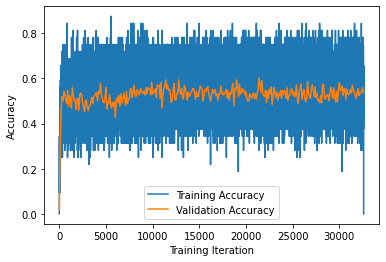

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.225 Validation Loss: 2.220 Accuracy: 0.039 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.220 Validation Loss: 2.220 Accuracy: 0.035 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.219 Validation Loss: 2.220 Accuracy: 0.034 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.221 Validation Loss: 2.220 Accuracy: 0.027 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.222 Validation Loss: 2.220 Accuracy: 0.034 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.222 Validation Loss: 2.220 Accuracy: 0.034 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.222 Validation Loss: 2.220 Accuracy: 0.032 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.219 Validation Loss: 2.220 Accuracy: 0.040 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.219 Validation Loss: 2.220 Accuracy: 0.041 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.217 Validation Loss: 2.220 Accuracy: 0.045 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.217 Validation Loss: 2.220 Accuracy: 0.045 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.217 Validation Loss: 2.220 Accuracy: 0.046 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.217 Validation Loss: 2.220 Accuracy: 0.047 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.216 Validation Loss: 2.220 Accuracy: 0.050 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.216 Validation Loss: 2.220 Accuracy: 0.048 Validation Accuracy: 0.025:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.216 Validation Loss: 2.220 Accuracy: 0.048 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 15 Loss: 2.216 Validation Loss: 2.220 Accuracy: 0.050 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 16 Loss: 2.214 Validation Loss: 2.220 Accuracy: 0.053 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 17 Loss: 2.213 Validation Loss: 2.220 Accuracy: 0.048 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 18 Loss: 2.213 Validation Loss: 2.220 Accuracy: 0.050 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 19 Loss: 2.212 Validation Loss: 2.220 Accuracy: 0.049 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 20 Loss: 2.210 Validation Loss: 2.220 Accuracy: 0.052 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 21 Loss: 2.209 Validation Loss: 2.220 Accuracy: 0.059 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 22 Loss: 2.209 Validation Loss: 2.220 Accuracy: 0.061 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 23 Loss: 2.207 Validation Loss: 2.220 Accuracy: 0.067 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 24 Loss: 2.205 Validation Loss: 2.220 Accuracy: 0.075 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 25 Loss: 2.204 Validation Loss: 2.220 Accuracy: 0.078 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 26 Loss: 2.202 Validation Loss: 2.220 Accuracy: 0.081 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 27 Loss: 2.201 Validation Loss: 2.220 Accuracy: 0.087 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 28 Loss: 2.199 Validation Loss: 2.220 Accuracy: 0.092 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 29 Loss: 2.198 Validation Loss: 2.220 Accuracy: 0.095 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 30 Loss: 2.197 Validation Loss: 2.220 Accuracy: 0.098 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 31 Loss: 2.195 Validation Loss: 2.220 Accuracy: 0.093 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 32 Loss: 2.193 Validation Loss: 2.220 Accuracy: 0.099 Validation Accuracy: 0.025:   1%|          | 15/1519 [00:00<00:10, 142.43it/s]

Epoch: 0 Iteration: 32 Loss: 2.193 Validation Loss: 2.220 Accuracy: 0.099 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 33 Loss: 2.191 Validation Loss: 2.220 Accuracy: 0.101 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 34 Loss: 2.189 Validation Loss: 2.220 Accuracy: 0.105 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 35 Loss: 2.187 Validation Loss: 2.220 Accuracy: 0.110 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 36 Loss: 2.186 Validation Loss: 2.220 Accuracy: 0.114 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 37 Loss: 2.184 Validation Loss: 2.220 Accuracy: 0.126 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 38 Loss: 2.183 Validation Loss: 2.220 Accuracy: 0.127 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 39 Loss: 2.180 Validation Loss: 2.220 Accuracy: 0.134 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 40 Loss: 2.179 Validation Loss: 2.220 Accuracy: 0.144 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 41 Loss: 2.178 Validation Loss: 2.220 Accuracy: 0.152 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 42 Loss: 2.175 Validation Loss: 2.220 Accuracy: 0.161 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 43 Loss: 2.174 Validation Loss: 2.220 Accuracy: 0.161 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 44 Loss: 2.173 Validation Loss: 2.220 Accuracy: 0.157 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 45 Loss: 2.171 Validation Loss: 2.220 Accuracy: 0.162 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 46 Loss: 2.170 Validation Loss: 2.220 Accuracy: 0.161 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 47 Loss: 2.168 Validation Loss: 2.220 Accuracy: 0.159 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 48 Loss: 2.167 Validation Loss: 2.220 Accuracy: 0.168 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 49 Loss: 2.165 Validation Loss: 2.220 Accuracy: 0.170 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 50 Loss: 2.164 Validation Loss: 2.220 Accuracy: 0.169 Validation Accuracy: 0.025:   2%|▏         | 33/1519 [00:00<00:09, 162.52it/s]

Epoch: 0 Iteration: 50 Loss: 2.164 Validation Loss: 2.220 Accuracy: 0.169 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 51 Loss: 2.163 Validation Loss: 2.220 Accuracy: 0.176 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 52 Loss: 2.161 Validation Loss: 2.220 Accuracy: 0.171 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 53 Loss: 2.160 Validation Loss: 2.220 Accuracy: 0.180 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 54 Loss: 2.158 Validation Loss: 2.220 Accuracy: 0.189 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 55 Loss: 2.156 Validation Loss: 2.220 Accuracy: 0.197 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 56 Loss: 2.155 Validation Loss: 2.220 Accuracy: 0.202 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 57 Loss: 2.153 Validation Loss: 2.220 Accuracy: 0.210 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 58 Loss: 2.151 Validation Loss: 2.220 Accuracy: 0.215 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 59 Loss: 2.150 Validation Loss: 2.220 Accuracy: 0.221 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 60 Loss: 2.148 Validation Loss: 2.220 Accuracy: 0.227 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 61 Loss: 2.147 Validation Loss: 2.220 Accuracy: 0.227 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 62 Loss: 2.145 Validation Loss: 2.220 Accuracy: 0.236 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 63 Loss: 2.143 Validation Loss: 2.220 Accuracy: 0.239 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 64 Loss: 2.140 Validation Loss: 2.220 Accuracy: 0.254 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 65 Loss: 2.139 Validation Loss: 2.220 Accuracy: 0.255 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 66 Loss: 2.137 Validation Loss: 2.220 Accuracy: 0.266 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 67 Loss: 2.135 Validation Loss: 2.220 Accuracy: 0.268 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 68 Loss: 2.134 Validation Loss: 2.220 Accuracy: 0.272 Validation Accuracy: 0.025:   3%|▎         | 51/1519 [00:00<00:08, 168.38it/s]

Epoch: 0 Iteration: 68 Loss: 2.134 Validation Loss: 2.220 Accuracy: 0.272 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 69 Loss: 2.133 Validation Loss: 2.220 Accuracy: 0.268 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 70 Loss: 2.131 Validation Loss: 2.220 Accuracy: 0.266 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 71 Loss: 2.130 Validation Loss: 2.220 Accuracy: 0.270 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 72 Loss: 2.129 Validation Loss: 2.220 Accuracy: 0.273 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 73 Loss: 2.127 Validation Loss: 2.220 Accuracy: 0.283 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 74 Loss: 2.126 Validation Loss: 2.220 Accuracy: 0.271 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 75 Loss: 2.125 Validation Loss: 2.220 Accuracy: 0.273 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 76 Loss: 2.123 Validation Loss: 2.220 Accuracy: 0.274 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 77 Loss: 2.122 Validation Loss: 2.220 Accuracy: 0.280 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 78 Loss: 2.122 Validation Loss: 2.220 Accuracy: 0.278 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 79 Loss: 2.121 Validation Loss: 2.220 Accuracy: 0.288 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 80 Loss: 2.120 Validation Loss: 2.220 Accuracy: 0.305 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 81 Loss: 2.119 Validation Loss: 2.220 Accuracy: 0.312 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 82 Loss: 2.117 Validation Loss: 2.220 Accuracy: 0.312 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 83 Loss: 2.116 Validation Loss: 2.220 Accuracy: 0.315 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 84 Loss: 2.115 Validation Loss: 2.220 Accuracy: 0.329 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 85 Loss: 2.114 Validation Loss: 2.220 Accuracy: 0.335 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 86 Loss: 2.112 Validation Loss: 2.220 Accuracy: 0.342 Validation Accuracy: 0.025:   5%|▍         | 69/1519 [00:00<00:08, 171.42it/s]

Epoch: 0 Iteration: 86 Loss: 2.112 Validation Loss: 2.220 Accuracy: 0.342 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 87 Loss: 2.111 Validation Loss: 2.220 Accuracy: 0.342 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 88 Loss: 2.109 Validation Loss: 2.220 Accuracy: 0.352 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 89 Loss: 2.108 Validation Loss: 2.220 Accuracy: 0.355 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 90 Loss: 2.106 Validation Loss: 2.220 Accuracy: 0.345 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 91 Loss: 2.104 Validation Loss: 2.220 Accuracy: 0.350 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 92 Loss: 2.103 Validation Loss: 2.220 Accuracy: 0.352 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 93 Loss: 2.103 Validation Loss: 2.220 Accuracy: 0.352 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 94 Loss: 2.101 Validation Loss: 2.220 Accuracy: 0.353 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 95 Loss: 2.099 Validation Loss: 2.220 Accuracy: 0.352 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 96 Loss: 2.099 Validation Loss: 2.220 Accuracy: 0.350 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 97 Loss: 2.097 Validation Loss: 2.220 Accuracy: 0.359 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 98 Loss: 2.095 Validation Loss: 2.220 Accuracy: 0.365 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 99 Loss: 2.093 Validation Loss: 2.220 Accuracy: 0.369 Validation Accuracy: 0.025:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 100 Loss: 2.092 Validation Loss: 2.072 Accuracy: 0.379 Validation Accuracy: 0.224:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 101 Loss: 2.091 Validation Loss: 2.072 Accuracy: 0.370 Validation Accuracy: 0.224:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 102 Loss: 2.089 Validation Loss: 2.072 Accuracy: 0.384 Validation Accuracy: 0.224:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 103 Loss: 2.088 Validation Loss: 2.072 Accuracy: 0.382 Validation Accuracy: 0.224:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 104 Loss: 2.086 Validation Loss: 2.072 Accuracy: 0.384 Validation Accuracy: 0.224:   6%|▌         | 87/1519 [00:00<00:08, 173.12it/s]

Epoch: 0 Iteration: 104 Loss: 2.086 Validation Loss: 2.072 Accuracy: 0.384 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 105 Loss: 2.086 Validation Loss: 2.072 Accuracy: 0.390 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 106 Loss: 2.085 Validation Loss: 2.072 Accuracy: 0.388 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 107 Loss: 2.084 Validation Loss: 2.072 Accuracy: 0.384 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 108 Loss: 2.083 Validation Loss: 2.072 Accuracy: 0.384 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 109 Loss: 2.081 Validation Loss: 2.072 Accuracy: 0.380 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 110 Loss: 2.079 Validation Loss: 2.072 Accuracy: 0.388 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 111 Loss: 2.077 Validation Loss: 2.072 Accuracy: 0.396 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 112 Loss: 2.075 Validation Loss: 2.072 Accuracy: 0.392 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 113 Loss: 2.073 Validation Loss: 2.072 Accuracy: 0.405 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 114 Loss: 2.071 Validation Loss: 2.072 Accuracy: 0.408 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 115 Loss: 2.071 Validation Loss: 2.072 Accuracy: 0.405 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 116 Loss: 2.069 Validation Loss: 2.072 Accuracy: 0.421 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 117 Loss: 2.068 Validation Loss: 2.072 Accuracy: 0.421 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 118 Loss: 2.067 Validation Loss: 2.072 Accuracy: 0.422 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 119 Loss: 2.065 Validation Loss: 2.072 Accuracy: 0.434 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 120 Loss: 2.062 Validation Loss: 2.072 Accuracy: 0.430 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 121 Loss: 2.061 Validation Loss: 2.072 Accuracy: 0.430 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 122 Loss: 2.060 Validation Loss: 2.072 Accuracy: 0.434 Validation Accuracy: 0.224:   7%|▋         | 105/1519 [00:00<00:08, 170.37it/s]

Epoch: 0 Iteration: 122 Loss: 2.060 Validation Loss: 2.072 Accuracy: 0.434 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 123 Loss: 2.058 Validation Loss: 2.072 Accuracy: 0.430 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 124 Loss: 2.056 Validation Loss: 2.072 Accuracy: 0.430 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 125 Loss: 2.055 Validation Loss: 2.072 Accuracy: 0.441 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 126 Loss: 2.053 Validation Loss: 2.072 Accuracy: 0.434 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 127 Loss: 2.052 Validation Loss: 2.072 Accuracy: 0.436 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 128 Loss: 2.050 Validation Loss: 2.072 Accuracy: 0.435 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 129 Loss: 2.049 Validation Loss: 2.072 Accuracy: 0.435 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 130 Loss: 2.047 Validation Loss: 2.072 Accuracy: 0.442 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 131 Loss: 2.046 Validation Loss: 2.072 Accuracy: 0.453 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 132 Loss: 2.044 Validation Loss: 2.072 Accuracy: 0.462 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 133 Loss: 2.043 Validation Loss: 2.072 Accuracy: 0.470 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 134 Loss: 2.043 Validation Loss: 2.072 Accuracy: 0.466 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 135 Loss: 2.040 Validation Loss: 2.072 Accuracy: 0.473 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 136 Loss: 2.039 Validation Loss: 2.072 Accuracy: 0.473 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 137 Loss: 2.037 Validation Loss: 2.072 Accuracy: 0.474 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 138 Loss: 2.036 Validation Loss: 2.072 Accuracy: 0.477 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 139 Loss: 2.035 Validation Loss: 2.072 Accuracy: 0.476 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 140 Loss: 2.035 Validation Loss: 2.072 Accuracy: 0.468 Validation Accuracy: 0.224:   8%|▊         | 123/1519 [00:00<00:08, 170.70it/s]

Epoch: 0 Iteration: 140 Loss: 2.035 Validation Loss: 2.072 Accuracy: 0.468 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 141 Loss: 2.032 Validation Loss: 2.072 Accuracy: 0.470 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 142 Loss: 2.030 Validation Loss: 2.072 Accuracy: 0.468 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 143 Loss: 2.029 Validation Loss: 2.072 Accuracy: 0.459 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 144 Loss: 2.028 Validation Loss: 2.072 Accuracy: 0.464 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 145 Loss: 2.026 Validation Loss: 2.072 Accuracy: 0.461 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 146 Loss: 2.023 Validation Loss: 2.072 Accuracy: 0.472 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 147 Loss: 2.021 Validation Loss: 2.072 Accuracy: 0.479 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 148 Loss: 2.019 Validation Loss: 2.072 Accuracy: 0.481 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 149 Loss: 2.017 Validation Loss: 2.072 Accuracy: 0.480 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 150 Loss: 2.017 Validation Loss: 2.072 Accuracy: 0.486 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 151 Loss: 2.015 Validation Loss: 2.072 Accuracy: 0.485 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 152 Loss: 2.013 Validation Loss: 2.072 Accuracy: 0.478 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 153 Loss: 2.012 Validation Loss: 2.072 Accuracy: 0.491 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 154 Loss: 2.009 Validation Loss: 2.072 Accuracy: 0.495 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 155 Loss: 2.008 Validation Loss: 2.072 Accuracy: 0.491 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 156 Loss: 2.004 Validation Loss: 2.072 Accuracy: 0.489 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 157 Loss: 2.002 Validation Loss: 2.072 Accuracy: 0.494 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 158 Loss: 2.002 Validation Loss: 2.072 Accuracy: 0.497 Validation Accuracy: 0.224:   9%|▉         | 141/1519 [00:00<00:08, 171.16it/s]

Epoch: 0 Iteration: 158 Loss: 2.002 Validation Loss: 2.072 Accuracy: 0.497 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 159 Loss: 2.000 Validation Loss: 2.072 Accuracy: 0.498 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 160 Loss: 1.998 Validation Loss: 2.072 Accuracy: 0.506 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 161 Loss: 1.996 Validation Loss: 2.072 Accuracy: 0.515 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 162 Loss: 1.994 Validation Loss: 2.072 Accuracy: 0.523 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 163 Loss: 1.993 Validation Loss: 2.072 Accuracy: 0.513 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 164 Loss: 1.990 Validation Loss: 2.072 Accuracy: 0.522 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 165 Loss: 1.989 Validation Loss: 2.072 Accuracy: 0.526 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 166 Loss: 1.989 Validation Loss: 2.072 Accuracy: 0.526 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 167 Loss: 1.989 Validation Loss: 2.072 Accuracy: 0.520 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 168 Loss: 1.988 Validation Loss: 2.072 Accuracy: 0.520 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 169 Loss: 1.986 Validation Loss: 2.072 Accuracy: 0.526 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:00<00:07, 172.54it/s]

Epoch: 0 Iteration: 170 Loss: 1.983 Validation Loss: 2.072 Accuracy: 0.520 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 171 Loss: 1.980 Validation Loss: 2.072 Accuracy: 0.512 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 172 Loss: 1.980 Validation Loss: 2.072 Accuracy: 0.510 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 173 Loss: 1.978 Validation Loss: 2.072 Accuracy: 0.516 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 174 Loss: 1.977 Validation Loss: 2.072 Accuracy: 0.511 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 175 Loss: 1.976 Validation Loss: 2.072 Accuracy: 0.511 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 176 Loss: 1.976 Validation Loss: 2.072 Accuracy: 0.516 Validation Accuracy: 0.224:  10%|█         | 159/1519 [00:01<00:07, 172.54it/s]

Epoch: 0 Iteration: 176 Loss: 1.976 Validation Loss: 2.072 Accuracy: 0.516 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 177 Loss: 1.975 Validation Loss: 2.072 Accuracy: 0.516 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 178 Loss: 1.973 Validation Loss: 2.072 Accuracy: 0.512 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 179 Loss: 1.971 Validation Loss: 2.072 Accuracy: 0.511 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 180 Loss: 1.969 Validation Loss: 2.072 Accuracy: 0.513 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 181 Loss: 1.969 Validation Loss: 2.072 Accuracy: 0.516 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 182 Loss: 1.967 Validation Loss: 2.072 Accuracy: 0.522 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 183 Loss: 1.966 Validation Loss: 2.072 Accuracy: 0.521 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 184 Loss: 1.964 Validation Loss: 2.072 Accuracy: 0.525 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 185 Loss: 1.963 Validation Loss: 2.072 Accuracy: 0.527 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 186 Loss: 1.961 Validation Loss: 2.072 Accuracy: 0.531 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 187 Loss: 1.958 Validation Loss: 2.072 Accuracy: 0.534 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 188 Loss: 1.956 Validation Loss: 2.072 Accuracy: 0.538 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 189 Loss: 1.955 Validation Loss: 2.072 Accuracy: 0.537 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 190 Loss: 1.955 Validation Loss: 2.072 Accuracy: 0.536 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 191 Loss: 1.954 Validation Loss: 2.072 Accuracy: 0.538 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 192 Loss: 1.950 Validation Loss: 2.072 Accuracy: 0.535 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 193 Loss: 1.948 Validation Loss: 2.072 Accuracy: 0.534 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 194 Loss: 1.947 Validation Loss: 2.072 Accuracy: 0.532 Validation Accuracy: 0.224:  12%|█▏        | 177/1519 [00:01<00:07, 173.39it/s]

Epoch: 0 Iteration: 194 Loss: 1.947 Validation Loss: 2.072 Accuracy: 0.532 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 195 Loss: 1.944 Validation Loss: 2.072 Accuracy: 0.534 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 196 Loss: 1.943 Validation Loss: 2.072 Accuracy: 0.529 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 197 Loss: 1.942 Validation Loss: 2.072 Accuracy: 0.534 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 198 Loss: 1.938 Validation Loss: 2.072 Accuracy: 0.540 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 199 Loss: 1.935 Validation Loss: 2.072 Accuracy: 0.550 Validation Accuracy: 0.224:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 200 Loss: 1.933 Validation Loss: 1.926 Accuracy: 0.559 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 201 Loss: 1.931 Validation Loss: 1.926 Accuracy: 0.559 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 202 Loss: 1.930 Validation Loss: 1.926 Accuracy: 0.552 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 203 Loss: 1.930 Validation Loss: 1.926 Accuracy: 0.552 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 204 Loss: 1.929 Validation Loss: 1.926 Accuracy: 0.551 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 205 Loss: 1.927 Validation Loss: 1.926 Accuracy: 0.548 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 206 Loss: 1.923 Validation Loss: 1.926 Accuracy: 0.558 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 207 Loss: 1.922 Validation Loss: 1.926 Accuracy: 0.551 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 208 Loss: 1.921 Validation Loss: 1.926 Accuracy: 0.548 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 209 Loss: 1.919 Validation Loss: 1.926 Accuracy: 0.546 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 210 Loss: 1.915 Validation Loss: 1.926 Accuracy: 0.544 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 211 Loss: 1.914 Validation Loss: 1.926 Accuracy: 0.551 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 212 Loss: 1.914 Validation Loss: 1.926 Accuracy: 0.559 Validation Accuracy: 0.329:  13%|█▎        | 195/1519 [00:01<00:07, 174.16it/s]

Epoch: 0 Iteration: 212 Loss: 1.914 Validation Loss: 1.926 Accuracy: 0.559 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 213 Loss: 1.911 Validation Loss: 1.926 Accuracy: 0.565 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 214 Loss: 1.909 Validation Loss: 1.926 Accuracy: 0.569 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 215 Loss: 1.909 Validation Loss: 1.926 Accuracy: 0.572 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 216 Loss: 1.907 Validation Loss: 1.926 Accuracy: 0.563 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 217 Loss: 1.904 Validation Loss: 1.926 Accuracy: 0.573 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 218 Loss: 1.904 Validation Loss: 1.926 Accuracy: 0.582 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 219 Loss: 1.905 Validation Loss: 1.926 Accuracy: 0.582 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 220 Loss: 1.904 Validation Loss: 1.926 Accuracy: 0.586 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 221 Loss: 1.902 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 222 Loss: 1.900 Validation Loss: 1.926 Accuracy: 0.583 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 223 Loss: 1.897 Validation Loss: 1.926 Accuracy: 0.581 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 224 Loss: 1.892 Validation Loss: 1.926 Accuracy: 0.591 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 225 Loss: 1.892 Validation Loss: 1.926 Accuracy: 0.591 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 226 Loss: 1.894 Validation Loss: 1.926 Accuracy: 0.598 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 227 Loss: 1.893 Validation Loss: 1.926 Accuracy: 0.595 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 228 Loss: 1.892 Validation Loss: 1.926 Accuracy: 0.585 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 229 Loss: 1.891 Validation Loss: 1.926 Accuracy: 0.585 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 230 Loss: 1.891 Validation Loss: 1.926 Accuracy: 0.586 Validation Accuracy: 0.329:  14%|█▍        | 213/1519 [00:01<00:07, 170.71it/s]

Epoch: 0 Iteration: 230 Loss: 1.891 Validation Loss: 1.926 Accuracy: 0.586 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 231 Loss: 1.890 Validation Loss: 1.926 Accuracy: 0.588 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 232 Loss: 1.888 Validation Loss: 1.926 Accuracy: 0.583 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 233 Loss: 1.888 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 234 Loss: 1.889 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 235 Loss: 1.886 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 236 Loss: 1.883 Validation Loss: 1.926 Accuracy: 0.558 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 237 Loss: 1.882 Validation Loss: 1.926 Accuracy: 0.567 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 238 Loss: 1.881 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 239 Loss: 1.879 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 240 Loss: 1.878 Validation Loss: 1.926 Accuracy: 0.565 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 241 Loss: 1.876 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 242 Loss: 1.876 Validation Loss: 1.926 Accuracy: 0.567 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 243 Loss: 1.875 Validation Loss: 1.926 Accuracy: 0.565 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 244 Loss: 1.874 Validation Loss: 1.926 Accuracy: 0.573 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 245 Loss: 1.872 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 246 Loss: 1.870 Validation Loss: 1.926 Accuracy: 0.578 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 247 Loss: 1.868 Validation Loss: 1.926 Accuracy: 0.567 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 248 Loss: 1.869 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  15%|█▌        | 231/1519 [00:01<00:07, 172.05it/s]

Epoch: 0 Iteration: 248 Loss: 1.869 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 249 Loss: 1.867 Validation Loss: 1.926 Accuracy: 0.555 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 250 Loss: 1.865 Validation Loss: 1.926 Accuracy: 0.548 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 251 Loss: 1.863 Validation Loss: 1.926 Accuracy: 0.547 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 252 Loss: 1.860 Validation Loss: 1.926 Accuracy: 0.555 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 253 Loss: 1.858 Validation Loss: 1.926 Accuracy: 0.568 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 254 Loss: 1.855 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 255 Loss: 1.854 Validation Loss: 1.926 Accuracy: 0.572 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 256 Loss: 1.853 Validation Loss: 1.926 Accuracy: 0.568 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 257 Loss: 1.853 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 258 Loss: 1.851 Validation Loss: 1.926 Accuracy: 0.574 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 259 Loss: 1.851 Validation Loss: 1.926 Accuracy: 0.578 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 260 Loss: 1.848 Validation Loss: 1.926 Accuracy: 0.588 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 261 Loss: 1.846 Validation Loss: 1.926 Accuracy: 0.586 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 262 Loss: 1.845 Validation Loss: 1.926 Accuracy: 0.586 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 263 Loss: 1.841 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 264 Loss: 1.842 Validation Loss: 1.926 Accuracy: 0.576 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 265 Loss: 1.840 Validation Loss: 1.926 Accuracy: 0.571 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 266 Loss: 1.840 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  16%|█▋        | 249/1519 [00:01<00:07, 173.46it/s]

Epoch: 0 Iteration: 266 Loss: 1.840 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 267 Loss: 1.838 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 268 Loss: 1.836 Validation Loss: 1.926 Accuracy: 0.565 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 269 Loss: 1.832 Validation Loss: 1.926 Accuracy: 0.573 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 270 Loss: 1.832 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 271 Loss: 1.831 Validation Loss: 1.926 Accuracy: 0.568 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 272 Loss: 1.830 Validation Loss: 1.926 Accuracy: 0.561 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 273 Loss: 1.829 Validation Loss: 1.926 Accuracy: 0.564 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 274 Loss: 1.828 Validation Loss: 1.926 Accuracy: 0.563 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 275 Loss: 1.827 Validation Loss: 1.926 Accuracy: 0.562 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 276 Loss: 1.825 Validation Loss: 1.926 Accuracy: 0.573 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 277 Loss: 1.824 Validation Loss: 1.926 Accuracy: 0.578 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 278 Loss: 1.821 Validation Loss: 1.926 Accuracy: 0.577 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 279 Loss: 1.817 Validation Loss: 1.926 Accuracy: 0.569 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 280 Loss: 1.816 Validation Loss: 1.926 Accuracy: 0.571 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 281 Loss: 1.816 Validation Loss: 1.926 Accuracy: 0.571 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 282 Loss: 1.814 Validation Loss: 1.926 Accuracy: 0.577 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 283 Loss: 1.815 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 284 Loss: 1.813 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  18%|█▊        | 267/1519 [00:01<00:07, 174.17it/s]

Epoch: 0 Iteration: 284 Loss: 1.813 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 285 Loss: 1.813 Validation Loss: 1.926 Accuracy: 0.582 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 286 Loss: 1.811 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 287 Loss: 1.809 Validation Loss: 1.926 Accuracy: 0.577 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 288 Loss: 1.807 Validation Loss: 1.926 Accuracy: 0.574 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 289 Loss: 1.808 Validation Loss: 1.926 Accuracy: 0.577 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 290 Loss: 1.807 Validation Loss: 1.926 Accuracy: 0.570 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 291 Loss: 1.806 Validation Loss: 1.926 Accuracy: 0.571 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 292 Loss: 1.803 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 293 Loss: 1.805 Validation Loss: 1.926 Accuracy: 0.568 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 294 Loss: 1.802 Validation Loss: 1.926 Accuracy: 0.566 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 295 Loss: 1.800 Validation Loss: 1.926 Accuracy: 0.573 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 296 Loss: 1.800 Validation Loss: 1.926 Accuracy: 0.578 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 297 Loss: 1.797 Validation Loss: 1.926 Accuracy: 0.577 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 298 Loss: 1.794 Validation Loss: 1.926 Accuracy: 0.581 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 299 Loss: 1.793 Validation Loss: 1.926 Accuracy: 0.580 Validation Accuracy: 0.329:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 300 Loss: 1.794 Validation Loss: 1.785 Accuracy: 0.592 Validation Accuracy: 0.385:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 301 Loss: 1.793 Validation Loss: 1.785 Accuracy: 0.587 Validation Accuracy: 0.385:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 302 Loss: 1.792 Validation Loss: 1.785 Accuracy: 0.596 Validation Accuracy: 0.385:  19%|█▉        | 285/1519 [00:01<00:07, 174.67it/s]

Epoch: 0 Iteration: 302 Loss: 1.792 Validation Loss: 1.785 Accuracy: 0.596 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 303 Loss: 1.789 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 304 Loss: 1.788 Validation Loss: 1.785 Accuracy: 0.606 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 305 Loss: 1.786 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 306 Loss: 1.784 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 307 Loss: 1.783 Validation Loss: 1.785 Accuracy: 0.599 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 308 Loss: 1.780 Validation Loss: 1.785 Accuracy: 0.594 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 309 Loss: 1.778 Validation Loss: 1.785 Accuracy: 0.593 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 310 Loss: 1.776 Validation Loss: 1.785 Accuracy: 0.589 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 311 Loss: 1.774 Validation Loss: 1.785 Accuracy: 0.601 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 312 Loss: 1.775 Validation Loss: 1.785 Accuracy: 0.595 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 313 Loss: 1.773 Validation Loss: 1.785 Accuracy: 0.586 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 314 Loss: 1.772 Validation Loss: 1.785 Accuracy: 0.594 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 315 Loss: 1.773 Validation Loss: 1.785 Accuracy: 0.583 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 316 Loss: 1.771 Validation Loss: 1.785 Accuracy: 0.573 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 317 Loss: 1.772 Validation Loss: 1.785 Accuracy: 0.562 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 318 Loss: 1.775 Validation Loss: 1.785 Accuracy: 0.566 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 319 Loss: 1.773 Validation Loss: 1.785 Accuracy: 0.569 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 320 Loss: 1.771 Validation Loss: 1.785 Accuracy: 0.574 Validation Accuracy: 0.385:  20%|█▉        | 303/1519 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 320 Loss: 1.771 Validation Loss: 1.785 Accuracy: 0.574 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 321 Loss: 1.768 Validation Loss: 1.785 Accuracy: 0.565 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 322 Loss: 1.767 Validation Loss: 1.785 Accuracy: 0.567 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 323 Loss: 1.766 Validation Loss: 1.785 Accuracy: 0.572 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 324 Loss: 1.766 Validation Loss: 1.785 Accuracy: 0.566 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 325 Loss: 1.765 Validation Loss: 1.785 Accuracy: 0.574 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 326 Loss: 1.766 Validation Loss: 1.785 Accuracy: 0.574 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 327 Loss: 1.765 Validation Loss: 1.785 Accuracy: 0.589 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 328 Loss: 1.765 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 329 Loss: 1.765 Validation Loss: 1.785 Accuracy: 0.596 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 330 Loss: 1.763 Validation Loss: 1.785 Accuracy: 0.601 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 331 Loss: 1.760 Validation Loss: 1.785 Accuracy: 0.612 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 332 Loss: 1.758 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 333 Loss: 1.755 Validation Loss: 1.785 Accuracy: 0.610 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 334 Loss: 1.753 Validation Loss: 1.785 Accuracy: 0.618 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 335 Loss: 1.751 Validation Loss: 1.785 Accuracy: 0.621 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 336 Loss: 1.752 Validation Loss: 1.785 Accuracy: 0.632 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 337 Loss: 1.749 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 338 Loss: 1.746 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.385:  21%|██        | 321/1519 [00:01<00:06, 172.57it/s]

Epoch: 0 Iteration: 338 Loss: 1.746 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:01<00:06, 173.41it/s]

Epoch: 0 Iteration: 339 Loss: 1.746 Validation Loss: 1.785 Accuracy: 0.641 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:01<00:06, 173.41it/s]

Epoch: 0 Iteration: 340 Loss: 1.743 Validation Loss: 1.785 Accuracy: 0.636 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:01<00:06, 173.41it/s]

Epoch: 0 Iteration: 341 Loss: 1.742 Validation Loss: 1.785 Accuracy: 0.629 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:01<00:06, 173.41it/s]

Epoch: 0 Iteration: 342 Loss: 1.740 Validation Loss: 1.785 Accuracy: 0.628 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:01<00:06, 173.41it/s]

Epoch: 0 Iteration: 343 Loss: 1.739 Validation Loss: 1.785 Accuracy: 0.627 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 344 Loss: 1.736 Validation Loss: 1.785 Accuracy: 0.617 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 345 Loss: 1.735 Validation Loss: 1.785 Accuracy: 0.617 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 346 Loss: 1.731 Validation Loss: 1.785 Accuracy: 0.611 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 347 Loss: 1.730 Validation Loss: 1.785 Accuracy: 0.607 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 348 Loss: 1.729 Validation Loss: 1.785 Accuracy: 0.603 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 349 Loss: 1.726 Validation Loss: 1.785 Accuracy: 0.595 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 350 Loss: 1.722 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 351 Loss: 1.724 Validation Loss: 1.785 Accuracy: 0.595 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 352 Loss: 1.722 Validation Loss: 1.785 Accuracy: 0.589 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 353 Loss: 1.720 Validation Loss: 1.785 Accuracy: 0.595 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 354 Loss: 1.717 Validation Loss: 1.785 Accuracy: 0.603 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 355 Loss: 1.712 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 356 Loss: 1.709 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  22%|██▏       | 339/1519 [00:02<00:06, 173.41it/s]

Epoch: 0 Iteration: 356 Loss: 1.709 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 357 Loss: 1.710 Validation Loss: 1.785 Accuracy: 0.606 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 358 Loss: 1.708 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 359 Loss: 1.707 Validation Loss: 1.785 Accuracy: 0.597 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 360 Loss: 1.705 Validation Loss: 1.785 Accuracy: 0.593 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 361 Loss: 1.703 Validation Loss: 1.785 Accuracy: 0.593 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 362 Loss: 1.703 Validation Loss: 1.785 Accuracy: 0.596 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 363 Loss: 1.701 Validation Loss: 1.785 Accuracy: 0.590 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 364 Loss: 1.700 Validation Loss: 1.785 Accuracy: 0.585 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 365 Loss: 1.696 Validation Loss: 1.785 Accuracy: 0.585 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 366 Loss: 1.695 Validation Loss: 1.785 Accuracy: 0.592 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 367 Loss: 1.695 Validation Loss: 1.785 Accuracy: 0.594 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 368 Loss: 1.693 Validation Loss: 1.785 Accuracy: 0.594 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 369 Loss: 1.691 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 370 Loss: 1.692 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 371 Loss: 1.690 Validation Loss: 1.785 Accuracy: 0.604 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 372 Loss: 1.689 Validation Loss: 1.785 Accuracy: 0.602 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 373 Loss: 1.687 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 374 Loss: 1.688 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  24%|██▎       | 357/1519 [00:02<00:06, 174.10it/s]

Epoch: 0 Iteration: 374 Loss: 1.688 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 375 Loss: 1.687 Validation Loss: 1.785 Accuracy: 0.615 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 376 Loss: 1.686 Validation Loss: 1.785 Accuracy: 0.606 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 377 Loss: 1.684 Validation Loss: 1.785 Accuracy: 0.611 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 378 Loss: 1.682 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 379 Loss: 1.679 Validation Loss: 1.785 Accuracy: 0.614 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 380 Loss: 1.680 Validation Loss: 1.785 Accuracy: 0.610 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 381 Loss: 1.682 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 382 Loss: 1.681 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 383 Loss: 1.680 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 384 Loss: 1.680 Validation Loss: 1.785 Accuracy: 0.599 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 385 Loss: 1.679 Validation Loss: 1.785 Accuracy: 0.602 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 386 Loss: 1.677 Validation Loss: 1.785 Accuracy: 0.602 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 387 Loss: 1.673 Validation Loss: 1.785 Accuracy: 0.600 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 388 Loss: 1.671 Validation Loss: 1.785 Accuracy: 0.592 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 389 Loss: 1.671 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 390 Loss: 1.665 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 391 Loss: 1.667 Validation Loss: 1.785 Accuracy: 0.608 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 392 Loss: 1.660 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.385:  25%|██▍       | 375/1519 [00:02<00:06, 172.02it/s]

Epoch: 0 Iteration: 392 Loss: 1.660 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 393 Loss: 1.662 Validation Loss: 1.785 Accuracy: 0.607 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 394 Loss: 1.662 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 395 Loss: 1.664 Validation Loss: 1.785 Accuracy: 0.608 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 396 Loss: 1.662 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 397 Loss: 1.663 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 398 Loss: 1.663 Validation Loss: 1.785 Accuracy: 0.608 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 399 Loss: 1.662 Validation Loss: 1.785 Accuracy: 0.601 Validation Accuracy: 0.385:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 400 Loss: 1.658 Validation Loss: 1.658 Accuracy: 0.591 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 401 Loss: 1.657 Validation Loss: 1.658 Accuracy: 0.588 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 402 Loss: 1.656 Validation Loss: 1.658 Accuracy: 0.580 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 403 Loss: 1.654 Validation Loss: 1.658 Accuracy: 0.589 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 404 Loss: 1.651 Validation Loss: 1.658 Accuracy: 0.584 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 405 Loss: 1.652 Validation Loss: 1.658 Accuracy: 0.584 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 406 Loss: 1.653 Validation Loss: 1.658 Accuracy: 0.584 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 407 Loss: 1.652 Validation Loss: 1.658 Accuracy: 0.590 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 408 Loss: 1.651 Validation Loss: 1.658 Accuracy: 0.595 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 409 Loss: 1.648 Validation Loss: 1.658 Accuracy: 0.605 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 410 Loss: 1.647 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  26%|██▌       | 393/1519 [00:02<00:06, 172.34it/s]

Epoch: 0 Iteration: 410 Loss: 1.647 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 411 Loss: 1.641 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 412 Loss: 1.643 Validation Loss: 1.658 Accuracy: 0.622 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 413 Loss: 1.639 Validation Loss: 1.658 Accuracy: 0.625 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 414 Loss: 1.638 Validation Loss: 1.658 Accuracy: 0.629 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 415 Loss: 1.635 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 416 Loss: 1.635 Validation Loss: 1.658 Accuracy: 0.630 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 417 Loss: 1.630 Validation Loss: 1.658 Accuracy: 0.626 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 418 Loss: 1.628 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 419 Loss: 1.625 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 420 Loss: 1.624 Validation Loss: 1.658 Accuracy: 0.617 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 421 Loss: 1.621 Validation Loss: 1.658 Accuracy: 0.620 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 422 Loss: 1.617 Validation Loss: 1.658 Accuracy: 0.626 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 423 Loss: 1.616 Validation Loss: 1.658 Accuracy: 0.620 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 424 Loss: 1.613 Validation Loss: 1.658 Accuracy: 0.621 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 425 Loss: 1.611 Validation Loss: 1.658 Accuracy: 0.625 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 426 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 427 Loss: 1.606 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 428 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.618 Validation Accuracy: 0.423:  27%|██▋       | 411/1519 [00:02<00:06, 170.12it/s]

Epoch: 0 Iteration: 428 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.618 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 429 Loss: 1.606 Validation Loss: 1.658 Accuracy: 0.619 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 430 Loss: 1.606 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 431 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 432 Loss: 1.608 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 433 Loss: 1.610 Validation Loss: 1.658 Accuracy: 0.620 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 434 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.620 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 435 Loss: 1.605 Validation Loss: 1.658 Accuracy: 0.620 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 436 Loss: 1.602 Validation Loss: 1.658 Accuracy: 0.613 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 437 Loss: 1.604 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 438 Loss: 1.603 Validation Loss: 1.658 Accuracy: 0.618 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 439 Loss: 1.605 Validation Loss: 1.658 Accuracy: 0.614 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 440 Loss: 1.606 Validation Loss: 1.658 Accuracy: 0.609 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 441 Loss: 1.608 Validation Loss: 1.658 Accuracy: 0.602 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 442 Loss: 1.611 Validation Loss: 1.658 Accuracy: 0.598 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 443 Loss: 1.613 Validation Loss: 1.658 Accuracy: 0.586 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 444 Loss: 1.612 Validation Loss: 1.658 Accuracy: 0.588 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 445 Loss: 1.610 Validation Loss: 1.658 Accuracy: 0.594 Validation Accuracy: 0.423:  28%|██▊       | 429/1519 [00:02<00:06, 169.51it/s]

Epoch: 0 Iteration: 445 Loss: 1.610 Validation Loss: 1.658 Accuracy: 0.594 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 446 Loss: 1.610 Validation Loss: 1.658 Accuracy: 0.598 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 447 Loss: 1.609 Validation Loss: 1.658 Accuracy: 0.606 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 448 Loss: 1.605 Validation Loss: 1.658 Accuracy: 0.609 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 449 Loss: 1.606 Validation Loss: 1.658 Accuracy: 0.605 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 450 Loss: 1.607 Validation Loss: 1.658 Accuracy: 0.613 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 451 Loss: 1.605 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 452 Loss: 1.603 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 453 Loss: 1.600 Validation Loss: 1.658 Accuracy: 0.644 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 454 Loss: 1.601 Validation Loss: 1.658 Accuracy: 0.643 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 455 Loss: 1.599 Validation Loss: 1.658 Accuracy: 0.644 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 456 Loss: 1.602 Validation Loss: 1.658 Accuracy: 0.641 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 457 Loss: 1.597 Validation Loss: 1.658 Accuracy: 0.637 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 458 Loss: 1.593 Validation Loss: 1.658 Accuracy: 0.637 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 459 Loss: 1.588 Validation Loss: 1.658 Accuracy: 0.648 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 460 Loss: 1.585 Validation Loss: 1.658 Accuracy: 0.643 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 461 Loss: 1.580 Validation Loss: 1.658 Accuracy: 0.647 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 462 Loss: 1.578 Validation Loss: 1.658 Accuracy: 0.642 Validation Accuracy: 0.423:  29%|██▉       | 446/1519 [00:02<00:06, 168.17it/s]

Epoch: 0 Iteration: 462 Loss: 1.578 Validation Loss: 1.658 Accuracy: 0.642 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 463 Loss: 1.575 Validation Loss: 1.658 Accuracy: 0.634 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 464 Loss: 1.575 Validation Loss: 1.658 Accuracy: 0.629 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 465 Loss: 1.575 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 466 Loss: 1.574 Validation Loss: 1.658 Accuracy: 0.629 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 467 Loss: 1.574 Validation Loss: 1.658 Accuracy: 0.626 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 468 Loss: 1.572 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 469 Loss: 1.570 Validation Loss: 1.658 Accuracy: 0.624 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 470 Loss: 1.569 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 471 Loss: 1.568 Validation Loss: 1.658 Accuracy: 0.619 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 472 Loss: 1.566 Validation Loss: 1.658 Accuracy: 0.623 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 473 Loss: 1.566 Validation Loss: 1.658 Accuracy: 0.614 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 474 Loss: 1.562 Validation Loss: 1.658 Accuracy: 0.618 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 475 Loss: 1.560 Validation Loss: 1.658 Accuracy: 0.616 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 476 Loss: 1.556 Validation Loss: 1.658 Accuracy: 0.626 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 477 Loss: 1.556 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 478 Loss: 1.557 Validation Loss: 1.658 Accuracy: 0.634 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 479 Loss: 1.557 Validation Loss: 1.658 Accuracy: 0.625 Validation Accuracy: 0.423:  30%|███       | 463/1519 [00:02<00:06, 167.01it/s]

Epoch: 0 Iteration: 479 Loss: 1.557 Validation Loss: 1.658 Accuracy: 0.625 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 480 Loss: 1.557 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 481 Loss: 1.553 Validation Loss: 1.658 Accuracy: 0.634 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 482 Loss: 1.550 Validation Loss: 1.658 Accuracy: 0.628 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 483 Loss: 1.551 Validation Loss: 1.658 Accuracy: 0.641 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 484 Loss: 1.548 Validation Loss: 1.658 Accuracy: 0.647 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 485 Loss: 1.549 Validation Loss: 1.658 Accuracy: 0.645 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 486 Loss: 1.547 Validation Loss: 1.658 Accuracy: 0.645 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 487 Loss: 1.544 Validation Loss: 1.658 Accuracy: 0.645 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 488 Loss: 1.545 Validation Loss: 1.658 Accuracy: 0.636 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 489 Loss: 1.544 Validation Loss: 1.658 Accuracy: 0.641 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 490 Loss: 1.546 Validation Loss: 1.658 Accuracy: 0.638 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 491 Loss: 1.546 Validation Loss: 1.658 Accuracy: 0.629 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 492 Loss: 1.546 Validation Loss: 1.658 Accuracy: 0.635 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 493 Loss: 1.543 Validation Loss: 1.658 Accuracy: 0.627 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 494 Loss: 1.544 Validation Loss: 1.658 Accuracy: 0.619 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 495 Loss: 1.544 Validation Loss: 1.658 Accuracy: 0.613 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 496 Loss: 1.542 Validation Loss: 1.658 Accuracy: 0.605 Validation Accuracy: 0.423:  32%|███▏      | 480/1519 [00:02<00:06, 165.70it/s]

Epoch: 0 Iteration: 496 Loss: 1.542 Validation Loss: 1.658 Accuracy: 0.605 Validation Accuracy: 0.423:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 497 Loss: 1.540 Validation Loss: 1.658 Accuracy: 0.604 Validation Accuracy: 0.423:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 498 Loss: 1.541 Validation Loss: 1.658 Accuracy: 0.609 Validation Accuracy: 0.423:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 499 Loss: 1.543 Validation Loss: 1.658 Accuracy: 0.602 Validation Accuracy: 0.423:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 500 Loss: 1.541 Validation Loss: 1.547 Accuracy: 0.603 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 501 Loss: 1.546 Validation Loss: 1.547 Accuracy: 0.606 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 502 Loss: 1.545 Validation Loss: 1.547 Accuracy: 0.603 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 503 Loss: 1.543 Validation Loss: 1.547 Accuracy: 0.605 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 504 Loss: 1.541 Validation Loss: 1.547 Accuracy: 0.608 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 505 Loss: 1.537 Validation Loss: 1.547 Accuracy: 0.618 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 506 Loss: 1.535 Validation Loss: 1.547 Accuracy: 0.619 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 507 Loss: 1.535 Validation Loss: 1.547 Accuracy: 0.623 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 508 Loss: 1.532 Validation Loss: 1.547 Accuracy: 0.622 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 509 Loss: 1.533 Validation Loss: 1.547 Accuracy: 0.624 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:02<00:06, 165.54it/s]

Epoch: 0 Iteration: 510 Loss: 1.530 Validation Loss: 1.547 Accuracy: 0.628 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:03<00:06, 165.54it/s]

Epoch: 0 Iteration: 511 Loss: 1.528 Validation Loss: 1.547 Accuracy: 0.636 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:03<00:06, 165.54it/s]

Epoch: 0 Iteration: 512 Loss: 1.528 Validation Loss: 1.547 Accuracy: 0.638 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:03<00:06, 165.54it/s]

Epoch: 0 Iteration: 513 Loss: 1.528 Validation Loss: 1.547 Accuracy: 0.647 Validation Accuracy: 0.450:  33%|███▎      | 497/1519 [00:03<00:06, 165.54it/s]

Epoch: 0 Iteration: 513 Loss: 1.528 Validation Loss: 1.547 Accuracy: 0.647 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 514 Loss: 1.528 Validation Loss: 1.547 Accuracy: 0.647 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 515 Loss: 1.527 Validation Loss: 1.547 Accuracy: 0.639 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 516 Loss: 1.525 Validation Loss: 1.547 Accuracy: 0.644 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 517 Loss: 1.525 Validation Loss: 1.547 Accuracy: 0.645 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 518 Loss: 1.525 Validation Loss: 1.547 Accuracy: 0.645 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 519 Loss: 1.522 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 520 Loss: 1.520 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 521 Loss: 1.516 Validation Loss: 1.547 Accuracy: 0.645 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 522 Loss: 1.515 Validation Loss: 1.547 Accuracy: 0.649 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 523 Loss: 1.511 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 524 Loss: 1.512 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 525 Loss: 1.514 Validation Loss: 1.547 Accuracy: 0.653 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 526 Loss: 1.513 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 527 Loss: 1.515 Validation Loss: 1.547 Accuracy: 0.634 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 528 Loss: 1.516 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 529 Loss: 1.517 Validation Loss: 1.547 Accuracy: 0.615 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 530 Loss: 1.512 Validation Loss: 1.547 Accuracy: 0.623 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 531 Loss: 1.511 Validation Loss: 1.547 Accuracy: 0.620 Validation Accuracy: 0.450:  34%|███▍      | 514/1519 [00:03<00:06, 165.10it/s]

Epoch: 0 Iteration: 531 Loss: 1.511 Validation Loss: 1.547 Accuracy: 0.620 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 532 Loss: 1.508 Validation Loss: 1.547 Accuracy: 0.616 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 533 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.613 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 534 Loss: 1.508 Validation Loss: 1.547 Accuracy: 0.602 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 535 Loss: 1.509 Validation Loss: 1.547 Accuracy: 0.598 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 536 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.605 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 537 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.616 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 538 Loss: 1.506 Validation Loss: 1.547 Accuracy: 0.615 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 539 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.629 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 540 Loss: 1.506 Validation Loss: 1.547 Accuracy: 0.627 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 541 Loss: 1.506 Validation Loss: 1.547 Accuracy: 0.627 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 542 Loss: 1.506 Validation Loss: 1.547 Accuracy: 0.623 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 543 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.618 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 544 Loss: 1.508 Validation Loss: 1.547 Accuracy: 0.624 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 545 Loss: 1.507 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 546 Loss: 1.506 Validation Loss: 1.547 Accuracy: 0.626 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 547 Loss: 1.501 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 548 Loss: 1.499 Validation Loss: 1.547 Accuracy: 0.633 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 549 Loss: 1.495 Validation Loss: 1.547 Accuracy: 0.634 Validation Accuracy: 0.450:  35%|███▌      | 532/1519 [00:03<00:05, 168.41it/s]

Epoch: 0 Iteration: 549 Loss: 1.495 Validation Loss: 1.547 Accuracy: 0.634 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 550 Loss: 1.500 Validation Loss: 1.547 Accuracy: 0.628 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 551 Loss: 1.499 Validation Loss: 1.547 Accuracy: 0.629 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 552 Loss: 1.499 Validation Loss: 1.547 Accuracy: 0.631 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 553 Loss: 1.495 Validation Loss: 1.547 Accuracy: 0.640 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 554 Loss: 1.491 Validation Loss: 1.547 Accuracy: 0.642 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 555 Loss: 1.488 Validation Loss: 1.547 Accuracy: 0.647 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 556 Loss: 1.488 Validation Loss: 1.547 Accuracy: 0.652 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 557 Loss: 1.487 Validation Loss: 1.547 Accuracy: 0.647 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 558 Loss: 1.483 Validation Loss: 1.547 Accuracy: 0.644 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 559 Loss: 1.481 Validation Loss: 1.547 Accuracy: 0.640 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 560 Loss: 1.480 Validation Loss: 1.547 Accuracy: 0.645 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 561 Loss: 1.479 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 562 Loss: 1.476 Validation Loss: 1.547 Accuracy: 0.655 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 563 Loss: 1.472 Validation Loss: 1.547 Accuracy: 0.654 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 564 Loss: 1.469 Validation Loss: 1.547 Accuracy: 0.659 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 565 Loss: 1.465 Validation Loss: 1.547 Accuracy: 0.659 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 566 Loss: 1.466 Validation Loss: 1.547 Accuracy: 0.653 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 567 Loss: 1.465 Validation Loss: 1.547 Accuracy: 0.658 Validation Accuracy: 0.450:  36%|███▌      | 550/1519 [00:03<00:05, 170.56it/s]

Epoch: 0 Iteration: 567 Loss: 1.465 Validation Loss: 1.547 Accuracy: 0.658 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 568 Loss: 1.463 Validation Loss: 1.547 Accuracy: 0.658 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 569 Loss: 1.461 Validation Loss: 1.547 Accuracy: 0.666 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 570 Loss: 1.455 Validation Loss: 1.547 Accuracy: 0.665 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 571 Loss: 1.453 Validation Loss: 1.547 Accuracy: 0.665 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 572 Loss: 1.454 Validation Loss: 1.547 Accuracy: 0.658 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 573 Loss: 1.456 Validation Loss: 1.547 Accuracy: 0.655 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 574 Loss: 1.455 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 575 Loss: 1.457 Validation Loss: 1.547 Accuracy: 0.646 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 576 Loss: 1.458 Validation Loss: 1.547 Accuracy: 0.641 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 577 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.629 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 578 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.628 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 579 Loss: 1.458 Validation Loss: 1.547 Accuracy: 0.632 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 580 Loss: 1.458 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 581 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.629 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 582 Loss: 1.461 Validation Loss: 1.547 Accuracy: 0.633 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 583 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 584 Loss: 1.456 Validation Loss: 1.547 Accuracy: 0.634 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 585 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  37%|███▋      | 568/1519 [00:03<00:05, 172.16it/s]

Epoch: 0 Iteration: 585 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.630 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 586 Loss: 1.456 Validation Loss: 1.547 Accuracy: 0.641 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 587 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 588 Loss: 1.459 Validation Loss: 1.547 Accuracy: 0.659 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 589 Loss: 1.456 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 590 Loss: 1.454 Validation Loss: 1.547 Accuracy: 0.653 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 591 Loss: 1.453 Validation Loss: 1.547 Accuracy: 0.652 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 592 Loss: 1.451 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 593 Loss: 1.449 Validation Loss: 1.547 Accuracy: 0.652 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 594 Loss: 1.446 Validation Loss: 1.547 Accuracy: 0.655 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 595 Loss: 1.443 Validation Loss: 1.547 Accuracy: 0.664 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 596 Loss: 1.442 Validation Loss: 1.547 Accuracy: 0.651 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 597 Loss: 1.440 Validation Loss: 1.547 Accuracy: 0.654 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 598 Loss: 1.441 Validation Loss: 1.547 Accuracy: 0.648 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 599 Loss: 1.439 Validation Loss: 1.547 Accuracy: 0.653 Validation Accuracy: 0.450:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 600 Loss: 1.436 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 601 Loss: 1.431 Validation Loss: 1.452 Accuracy: 0.655 Validation Accuracy: 0.470:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 602 Loss: 1.427 Validation Loss: 1.452 Accuracy: 0.656 Validation Accuracy: 0.470:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 603 Loss: 1.427 Validation Loss: 1.452 Accuracy: 0.657 Validation Accuracy: 0.470:  39%|███▊      | 586/1519 [00:03<00:05, 173.49it/s]

Epoch: 0 Iteration: 603 Loss: 1.427 Validation Loss: 1.452 Accuracy: 0.657 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 604 Loss: 1.427 Validation Loss: 1.452 Accuracy: 0.650 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 605 Loss: 1.421 Validation Loss: 1.452 Accuracy: 0.651 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 606 Loss: 1.419 Validation Loss: 1.452 Accuracy: 0.659 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 607 Loss: 1.417 Validation Loss: 1.452 Accuracy: 0.659 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 608 Loss: 1.414 Validation Loss: 1.452 Accuracy: 0.660 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 609 Loss: 1.417 Validation Loss: 1.452 Accuracy: 0.645 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 610 Loss: 1.418 Validation Loss: 1.452 Accuracy: 0.649 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 611 Loss: 1.417 Validation Loss: 1.452 Accuracy: 0.637 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 612 Loss: 1.417 Validation Loss: 1.452 Accuracy: 0.637 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 613 Loss: 1.417 Validation Loss: 1.452 Accuracy: 0.636 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 614 Loss: 1.416 Validation Loss: 1.452 Accuracy: 0.639 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 615 Loss: 1.416 Validation Loss: 1.452 Accuracy: 0.631 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 616 Loss: 1.415 Validation Loss: 1.452 Accuracy: 0.631 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 617 Loss: 1.410 Validation Loss: 1.452 Accuracy: 0.631 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 618 Loss: 1.404 Validation Loss: 1.452 Accuracy: 0.634 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 619 Loss: 1.403 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 620 Loss: 1.405 Validation Loss: 1.452 Accuracy: 0.638 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 621 Loss: 1.407 Validation Loss: 1.452 Accuracy: 0.644 Validation Accuracy: 0.470:  40%|███▉      | 604/1519 [00:03<00:05, 171.19it/s]

Epoch: 0 Iteration: 621 Loss: 1.407 Validation Loss: 1.452 Accuracy: 0.644 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 622 Loss: 1.405 Validation Loss: 1.452 Accuracy: 0.646 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 623 Loss: 1.406 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 624 Loss: 1.406 Validation Loss: 1.452 Accuracy: 0.645 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 625 Loss: 1.408 Validation Loss: 1.452 Accuracy: 0.644 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 626 Loss: 1.409 Validation Loss: 1.452 Accuracy: 0.642 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 627 Loss: 1.405 Validation Loss: 1.452 Accuracy: 0.651 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 628 Loss: 1.403 Validation Loss: 1.452 Accuracy: 0.647 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 629 Loss: 1.401 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 630 Loss: 1.401 Validation Loss: 1.452 Accuracy: 0.647 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 631 Loss: 1.400 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 632 Loss: 1.399 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 633 Loss: 1.396 Validation Loss: 1.452 Accuracy: 0.643 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 634 Loss: 1.397 Validation Loss: 1.452 Accuracy: 0.640 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 635 Loss: 1.398 Validation Loss: 1.452 Accuracy: 0.639 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 636 Loss: 1.395 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 637 Loss: 1.397 Validation Loss: 1.452 Accuracy: 0.630 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 638 Loss: 1.392 Validation Loss: 1.452 Accuracy: 0.634 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 639 Loss: 1.392 Validation Loss: 1.452 Accuracy: 0.632 Validation Accuracy: 0.470:  41%|████      | 622/1519 [00:03<00:05, 172.75it/s]

Epoch: 0 Iteration: 639 Loss: 1.392 Validation Loss: 1.452 Accuracy: 0.632 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 640 Loss: 1.387 Validation Loss: 1.452 Accuracy: 0.634 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 641 Loss: 1.385 Validation Loss: 1.452 Accuracy: 0.633 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 642 Loss: 1.387 Validation Loss: 1.452 Accuracy: 0.638 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 643 Loss: 1.384 Validation Loss: 1.452 Accuracy: 0.640 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 644 Loss: 1.382 Validation Loss: 1.452 Accuracy: 0.647 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 645 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.652 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 646 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.649 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 647 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.657 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 648 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.652 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 649 Loss: 1.379 Validation Loss: 1.452 Accuracy: 0.658 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 650 Loss: 1.380 Validation Loss: 1.452 Accuracy: 0.652 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 651 Loss: 1.379 Validation Loss: 1.452 Accuracy: 0.654 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 652 Loss: 1.374 Validation Loss: 1.452 Accuracy: 0.652 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 653 Loss: 1.375 Validation Loss: 1.452 Accuracy: 0.645 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 654 Loss: 1.373 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 655 Loss: 1.373 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 656 Loss: 1.374 Validation Loss: 1.452 Accuracy: 0.645 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 657 Loss: 1.371 Validation Loss: 1.452 Accuracy: 0.642 Validation Accuracy: 0.470:  42%|████▏     | 640/1519 [00:03<00:05, 173.79it/s]

Epoch: 0 Iteration: 657 Loss: 1.371 Validation Loss: 1.452 Accuracy: 0.642 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 658 Loss: 1.379 Validation Loss: 1.452 Accuracy: 0.641 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 659 Loss: 1.380 Validation Loss: 1.452 Accuracy: 0.638 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 660 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.647 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 661 Loss: 1.381 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 662 Loss: 1.377 Validation Loss: 1.452 Accuracy: 0.658 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 663 Loss: 1.376 Validation Loss: 1.452 Accuracy: 0.662 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 664 Loss: 1.379 Validation Loss: 1.452 Accuracy: 0.663 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 665 Loss: 1.379 Validation Loss: 1.452 Accuracy: 0.667 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 666 Loss: 1.377 Validation Loss: 1.452 Accuracy: 0.668 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 667 Loss: 1.380 Validation Loss: 1.452 Accuracy: 0.662 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 668 Loss: 1.380 Validation Loss: 1.452 Accuracy: 0.664 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 669 Loss: 1.377 Validation Loss: 1.452 Accuracy: 0.666 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 670 Loss: 1.373 Validation Loss: 1.452 Accuracy: 0.669 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 671 Loss: 1.371 Validation Loss: 1.452 Accuracy: 0.670 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 672 Loss: 1.370 Validation Loss: 1.452 Accuracy: 0.660 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 673 Loss: 1.365 Validation Loss: 1.452 Accuracy: 0.666 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 674 Loss: 1.364 Validation Loss: 1.452 Accuracy: 0.673 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 675 Loss: 1.358 Validation Loss: 1.452 Accuracy: 0.675 Validation Accuracy: 0.470:  43%|████▎     | 658/1519 [00:03<00:04, 174.48it/s]

Epoch: 0 Iteration: 675 Loss: 1.358 Validation Loss: 1.452 Accuracy: 0.675 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 676 Loss: 1.357 Validation Loss: 1.452 Accuracy: 0.676 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 677 Loss: 1.355 Validation Loss: 1.452 Accuracy: 0.687 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 678 Loss: 1.352 Validation Loss: 1.452 Accuracy: 0.688 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 679 Loss: 1.352 Validation Loss: 1.452 Accuracy: 0.681 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 680 Loss: 1.349 Validation Loss: 1.452 Accuracy: 0.681 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 681 Loss: 1.348 Validation Loss: 1.452 Accuracy: 0.677 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 682 Loss: 1.349 Validation Loss: 1.452 Accuracy: 0.680 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 683 Loss: 1.350 Validation Loss: 1.452 Accuracy: 0.677 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 684 Loss: 1.350 Validation Loss: 1.452 Accuracy: 0.662 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:03<00:04, 175.05it/s]

Epoch: 0 Iteration: 685 Loss: 1.347 Validation Loss: 1.452 Accuracy: 0.659 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 686 Loss: 1.343 Validation Loss: 1.452 Accuracy: 0.659 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 687 Loss: 1.341 Validation Loss: 1.452 Accuracy: 0.653 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 688 Loss: 1.340 Validation Loss: 1.452 Accuracy: 0.649 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 689 Loss: 1.344 Validation Loss: 1.452 Accuracy: 0.651 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 690 Loss: 1.342 Validation Loss: 1.452 Accuracy: 0.650 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 691 Loss: 1.343 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 692 Loss: 1.343 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 693 Loss: 1.348 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  45%|████▍     | 676/1519 [00:04<00:04, 175.05it/s]

Epoch: 0 Iteration: 693 Loss: 1.348 Validation Loss: 1.452 Accuracy: 0.648 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 694 Loss: 1.348 Validation Loss: 1.452 Accuracy: 0.659 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 695 Loss: 1.348 Validation Loss: 1.452 Accuracy: 0.657 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 696 Loss: 1.347 Validation Loss: 1.452 Accuracy: 0.658 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 697 Loss: 1.350 Validation Loss: 1.452 Accuracy: 0.658 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 698 Loss: 1.347 Validation Loss: 1.452 Accuracy: 0.661 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 699 Loss: 1.345 Validation Loss: 1.452 Accuracy: 0.661 Validation Accuracy: 0.470:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 700 Loss: 1.344 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 701 Loss: 1.344 Validation Loss: 1.371 Accuracy: 0.665 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 702 Loss: 1.344 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 703 Loss: 1.341 Validation Loss: 1.371 Accuracy: 0.668 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 704 Loss: 1.340 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 705 Loss: 1.337 Validation Loss: 1.371 Accuracy: 0.666 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 706 Loss: 1.339 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 707 Loss: 1.335 Validation Loss: 1.371 Accuracy: 0.666 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 708 Loss: 1.333 Validation Loss: 1.371 Accuracy: 0.661 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 709 Loss: 1.332 Validation Loss: 1.371 Accuracy: 0.657 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 710 Loss: 1.331 Validation Loss: 1.371 Accuracy: 0.663 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 711 Loss: 1.332 Validation Loss: 1.371 Accuracy: 0.660 Validation Accuracy: 0.486:  46%|████▌     | 694/1519 [00:04<00:04, 175.48it/s]

Epoch: 0 Iteration: 711 Loss: 1.332 Validation Loss: 1.371 Accuracy: 0.660 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 712 Loss: 1.334 Validation Loss: 1.371 Accuracy: 0.657 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 713 Loss: 1.331 Validation Loss: 1.371 Accuracy: 0.650 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 714 Loss: 1.328 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 715 Loss: 1.328 Validation Loss: 1.371 Accuracy: 0.650 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 716 Loss: 1.327 Validation Loss: 1.371 Accuracy: 0.652 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 717 Loss: 1.325 Validation Loss: 1.371 Accuracy: 0.647 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 718 Loss: 1.324 Validation Loss: 1.371 Accuracy: 0.653 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 719 Loss: 1.319 Validation Loss: 1.371 Accuracy: 0.657 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 720 Loss: 1.320 Validation Loss: 1.371 Accuracy: 0.654 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 721 Loss: 1.320 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 722 Loss: 1.320 Validation Loss: 1.371 Accuracy: 0.657 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 723 Loss: 1.320 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 724 Loss: 1.316 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 725 Loss: 1.315 Validation Loss: 1.371 Accuracy: 0.669 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 726 Loss: 1.311 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 727 Loss: 1.314 Validation Loss: 1.371 Accuracy: 0.673 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 728 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.673 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 729 Loss: 1.311 Validation Loss: 1.371 Accuracy: 0.677 Validation Accuracy: 0.486:  47%|████▋     | 712/1519 [00:04<00:04, 172.62it/s]

Epoch: 0 Iteration: 729 Loss: 1.311 Validation Loss: 1.371 Accuracy: 0.677 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 730 Loss: 1.316 Validation Loss: 1.371 Accuracy: 0.673 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 731 Loss: 1.315 Validation Loss: 1.371 Accuracy: 0.671 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 732 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.677 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 733 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.671 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 734 Loss: 1.314 Validation Loss: 1.371 Accuracy: 0.671 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 735 Loss: 1.314 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 736 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.664 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 737 Loss: 1.315 Validation Loss: 1.371 Accuracy: 0.654 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 738 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.656 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 739 Loss: 1.318 Validation Loss: 1.371 Accuracy: 0.648 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 740 Loss: 1.317 Validation Loss: 1.371 Accuracy: 0.653 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 741 Loss: 1.314 Validation Loss: 1.371 Accuracy: 0.658 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 742 Loss: 1.312 Validation Loss: 1.371 Accuracy: 0.656 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 743 Loss: 1.312 Validation Loss: 1.371 Accuracy: 0.656 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 744 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.652 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 745 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 746 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.656 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 747 Loss: 1.310 Validation Loss: 1.371 Accuracy: 0.667 Validation Accuracy: 0.486:  48%|████▊     | 730/1519 [00:04<00:04, 173.10it/s]

Epoch: 0 Iteration: 747 Loss: 1.310 Validation Loss: 1.371 Accuracy: 0.667 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 748 Loss: 1.311 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 749 Loss: 1.313 Validation Loss: 1.371 Accuracy: 0.665 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 750 Loss: 1.307 Validation Loss: 1.371 Accuracy: 0.663 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 751 Loss: 1.308 Validation Loss: 1.371 Accuracy: 0.653 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 752 Loss: 1.307 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 753 Loss: 1.306 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 754 Loss: 1.305 Validation Loss: 1.371 Accuracy: 0.661 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 755 Loss: 1.303 Validation Loss: 1.371 Accuracy: 0.658 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 756 Loss: 1.304 Validation Loss: 1.371 Accuracy: 0.662 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 757 Loss: 1.297 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 758 Loss: 1.300 Validation Loss: 1.371 Accuracy: 0.672 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 759 Loss: 1.299 Validation Loss: 1.371 Accuracy: 0.675 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 760 Loss: 1.298 Validation Loss: 1.371 Accuracy: 0.677 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 761 Loss: 1.302 Validation Loss: 1.371 Accuracy: 0.679 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 762 Loss: 1.301 Validation Loss: 1.371 Accuracy: 0.676 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 763 Loss: 1.301 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 764 Loss: 1.300 Validation Loss: 1.371 Accuracy: 0.667 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 765 Loss: 1.306 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  49%|████▉     | 748/1519 [00:04<00:04, 173.84it/s]

Epoch: 0 Iteration: 765 Loss: 1.306 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 766 Loss: 1.306 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 767 Loss: 1.305 Validation Loss: 1.371 Accuracy: 0.647 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 768 Loss: 1.301 Validation Loss: 1.371 Accuracy: 0.650 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 769 Loss: 1.297 Validation Loss: 1.371 Accuracy: 0.657 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 770 Loss: 1.296 Validation Loss: 1.371 Accuracy: 0.659 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 771 Loss: 1.294 Validation Loss: 1.371 Accuracy: 0.660 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 772 Loss: 1.291 Validation Loss: 1.371 Accuracy: 0.666 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 773 Loss: 1.290 Validation Loss: 1.371 Accuracy: 0.671 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 774 Loss: 1.291 Validation Loss: 1.371 Accuracy: 0.669 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 775 Loss: 1.293 Validation Loss: 1.371 Accuracy: 0.674 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 776 Loss: 1.293 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 777 Loss: 1.294 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 778 Loss: 1.291 Validation Loss: 1.371 Accuracy: 0.672 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 779 Loss: 1.291 Validation Loss: 1.371 Accuracy: 0.667 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 780 Loss: 1.290 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 781 Loss: 1.286 Validation Loss: 1.371 Accuracy: 0.670 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 782 Loss: 1.291 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 783 Loss: 1.287 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  50%|█████     | 766/1519 [00:04<00:04, 174.48it/s]

Epoch: 0 Iteration: 783 Loss: 1.287 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 784 Loss: 1.286 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 785 Loss: 1.283 Validation Loss: 1.371 Accuracy: 0.650 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 786 Loss: 1.283 Validation Loss: 1.371 Accuracy: 0.652 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 787 Loss: 1.285 Validation Loss: 1.371 Accuracy: 0.647 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 788 Loss: 1.286 Validation Loss: 1.371 Accuracy: 0.647 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 789 Loss: 1.287 Validation Loss: 1.371 Accuracy: 0.643 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 790 Loss: 1.290 Validation Loss: 1.371 Accuracy: 0.631 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 791 Loss: 1.288 Validation Loss: 1.371 Accuracy: 0.630 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 792 Loss: 1.292 Validation Loss: 1.371 Accuracy: 0.635 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 793 Loss: 1.288 Validation Loss: 1.371 Accuracy: 0.643 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 794 Loss: 1.285 Validation Loss: 1.371 Accuracy: 0.645 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 795 Loss: 1.281 Validation Loss: 1.371 Accuracy: 0.654 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 796 Loss: 1.277 Validation Loss: 1.371 Accuracy: 0.653 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 797 Loss: 1.280 Validation Loss: 1.371 Accuracy: 0.655 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 798 Loss: 1.278 Validation Loss: 1.371 Accuracy: 0.654 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 799 Loss: 1.276 Validation Loss: 1.371 Accuracy: 0.649 Validation Accuracy: 0.486:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 800 Loss: 1.275 Validation Loss: 1.303 Accuracy: 0.660 Validation Accuracy: 0.501:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 801 Loss: 1.274 Validation Loss: 1.303 Accuracy: 0.668 Validation Accuracy: 0.501:  52%|█████▏    | 784/1519 [00:04<00:04, 174.83it/s]

Epoch: 0 Iteration: 801 Loss: 1.274 Validation Loss: 1.303 Accuracy: 0.668 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 802 Loss: 1.269 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 803 Loss: 1.270 Validation Loss: 1.303 Accuracy: 0.668 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 804 Loss: 1.269 Validation Loss: 1.303 Accuracy: 0.672 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 805 Loss: 1.262 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 806 Loss: 1.263 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 807 Loss: 1.262 Validation Loss: 1.303 Accuracy: 0.672 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 808 Loss: 1.263 Validation Loss: 1.303 Accuracy: 0.661 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 809 Loss: 1.262 Validation Loss: 1.303 Accuracy: 0.667 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 810 Loss: 1.261 Validation Loss: 1.303 Accuracy: 0.662 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 811 Loss: 1.264 Validation Loss: 1.303 Accuracy: 0.653 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 812 Loss: 1.259 Validation Loss: 1.303 Accuracy: 0.659 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 813 Loss: 1.260 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 814 Loss: 1.260 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 815 Loss: 1.263 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 816 Loss: 1.266 Validation Loss: 1.303 Accuracy: 0.658 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 817 Loss: 1.265 Validation Loss: 1.303 Accuracy: 0.657 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 818 Loss: 1.262 Validation Loss: 1.303 Accuracy: 0.671 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 819 Loss: 1.258 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  53%|█████▎    | 802/1519 [00:04<00:04, 172.20it/s]

Epoch: 0 Iteration: 819 Loss: 1.258 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 820 Loss: 1.258 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 821 Loss: 1.258 Validation Loss: 1.303 Accuracy: 0.683 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 822 Loss: 1.253 Validation Loss: 1.303 Accuracy: 0.683 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 823 Loss: 1.252 Validation Loss: 1.303 Accuracy: 0.692 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 824 Loss: 1.251 Validation Loss: 1.303 Accuracy: 0.691 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 825 Loss: 1.251 Validation Loss: 1.303 Accuracy: 0.693 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 826 Loss: 1.248 Validation Loss: 1.303 Accuracy: 0.696 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 827 Loss: 1.248 Validation Loss: 1.303 Accuracy: 0.700 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 828 Loss: 1.245 Validation Loss: 1.303 Accuracy: 0.696 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 829 Loss: 1.244 Validation Loss: 1.303 Accuracy: 0.691 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 830 Loss: 1.241 Validation Loss: 1.303 Accuracy: 0.691 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 831 Loss: 1.234 Validation Loss: 1.303 Accuracy: 0.700 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 832 Loss: 1.235 Validation Loss: 1.303 Accuracy: 0.694 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 833 Loss: 1.236 Validation Loss: 1.303 Accuracy: 0.688 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 834 Loss: 1.237 Validation Loss: 1.303 Accuracy: 0.688 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 835 Loss: 1.233 Validation Loss: 1.303 Accuracy: 0.685 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 836 Loss: 1.233 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 837 Loss: 1.232 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  54%|█████▍    | 820/1519 [00:04<00:04, 173.55it/s]

Epoch: 0 Iteration: 837 Loss: 1.232 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 838 Loss: 1.235 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 839 Loss: 1.236 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 840 Loss: 1.237 Validation Loss: 1.303 Accuracy: 0.662 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 841 Loss: 1.240 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 842 Loss: 1.240 Validation Loss: 1.303 Accuracy: 0.658 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 843 Loss: 1.243 Validation Loss: 1.303 Accuracy: 0.659 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 844 Loss: 1.244 Validation Loss: 1.303 Accuracy: 0.658 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 845 Loss: 1.243 Validation Loss: 1.303 Accuracy: 0.661 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 846 Loss: 1.243 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 847 Loss: 1.240 Validation Loss: 1.303 Accuracy: 0.678 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 848 Loss: 1.239 Validation Loss: 1.303 Accuracy: 0.678 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 849 Loss: 1.241 Validation Loss: 1.303 Accuracy: 0.662 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 850 Loss: 1.243 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 851 Loss: 1.246 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 852 Loss: 1.246 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 853 Loss: 1.247 Validation Loss: 1.303 Accuracy: 0.664 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 854 Loss: 1.244 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 855 Loss: 1.244 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  55%|█████▌    | 838/1519 [00:04<00:03, 174.05it/s]

Epoch: 0 Iteration: 855 Loss: 1.244 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:04<00:03, 171.27it/s]

Epoch: 0 Iteration: 856 Loss: 1.239 Validation Loss: 1.303 Accuracy: 0.665 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:04<00:03, 171.27it/s]

Epoch: 0 Iteration: 857 Loss: 1.238 Validation Loss: 1.303 Accuracy: 0.663 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 858 Loss: 1.239 Validation Loss: 1.303 Accuracy: 0.661 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 859 Loss: 1.235 Validation Loss: 1.303 Accuracy: 0.677 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 860 Loss: 1.233 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 861 Loss: 1.229 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 862 Loss: 1.228 Validation Loss: 1.303 Accuracy: 0.687 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 863 Loss: 1.227 Validation Loss: 1.303 Accuracy: 0.688 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 864 Loss: 1.229 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 865 Loss: 1.229 Validation Loss: 1.303 Accuracy: 0.684 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 866 Loss: 1.229 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 867 Loss: 1.227 Validation Loss: 1.303 Accuracy: 0.687 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 868 Loss: 1.227 Validation Loss: 1.303 Accuracy: 0.690 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 869 Loss: 1.224 Validation Loss: 1.303 Accuracy: 0.686 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 870 Loss: 1.222 Validation Loss: 1.303 Accuracy: 0.679 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 871 Loss: 1.218 Validation Loss: 1.303 Accuracy: 0.677 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 872 Loss: 1.217 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 873 Loss: 1.218 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.501:  56%|█████▋    | 856/1519 [00:05<00:03, 171.27it/s]

Epoch: 0 Iteration: 873 Loss: 1.218 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 874 Loss: 1.216 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 875 Loss: 1.214 Validation Loss: 1.303 Accuracy: 0.675 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 876 Loss: 1.217 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 877 Loss: 1.216 Validation Loss: 1.303 Accuracy: 0.660 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 878 Loss: 1.215 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 879 Loss: 1.213 Validation Loss: 1.303 Accuracy: 0.661 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 880 Loss: 1.213 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 881 Loss: 1.210 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 882 Loss: 1.213 Validation Loss: 1.303 Accuracy: 0.675 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 883 Loss: 1.213 Validation Loss: 1.303 Accuracy: 0.667 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 884 Loss: 1.209 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 885 Loss: 1.211 Validation Loss: 1.303 Accuracy: 0.662 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 886 Loss: 1.210 Validation Loss: 1.303 Accuracy: 0.665 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 887 Loss: 1.209 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 888 Loss: 1.207 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 889 Loss: 1.203 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 890 Loss: 1.203 Validation Loss: 1.303 Accuracy: 0.675 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 891 Loss: 1.205 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  58%|█████▊    | 874/1519 [00:05<00:03, 171.40it/s]

Epoch: 0 Iteration: 891 Loss: 1.205 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 892 Loss: 1.200 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 893 Loss: 1.197 Validation Loss: 1.303 Accuracy: 0.667 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 894 Loss: 1.194 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 895 Loss: 1.195 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 896 Loss: 1.184 Validation Loss: 1.303 Accuracy: 0.688 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 897 Loss: 1.182 Validation Loss: 1.303 Accuracy: 0.691 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 898 Loss: 1.186 Validation Loss: 1.303 Accuracy: 0.676 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 899 Loss: 1.190 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.501:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 900 Loss: 1.191 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 901 Loss: 1.193 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 902 Loss: 1.191 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 903 Loss: 1.186 Validation Loss: 1.246 Accuracy: 0.676 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 904 Loss: 1.190 Validation Loss: 1.246 Accuracy: 0.660 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 905 Loss: 1.194 Validation Loss: 1.246 Accuracy: 0.662 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 906 Loss: 1.193 Validation Loss: 1.246 Accuracy: 0.653 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 907 Loss: 1.193 Validation Loss: 1.246 Accuracy: 0.644 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 908 Loss: 1.194 Validation Loss: 1.246 Accuracy: 0.655 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 909 Loss: 1.195 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  59%|█████▊    | 892/1519 [00:05<00:03, 170.55it/s]

Epoch: 0 Iteration: 909 Loss: 1.195 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 910 Loss: 1.192 Validation Loss: 1.246 Accuracy: 0.657 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 911 Loss: 1.190 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 912 Loss: 1.194 Validation Loss: 1.246 Accuracy: 0.662 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 913 Loss: 1.188 Validation Loss: 1.246 Accuracy: 0.667 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 914 Loss: 1.195 Validation Loss: 1.246 Accuracy: 0.680 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 915 Loss: 1.199 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 916 Loss: 1.205 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 917 Loss: 1.204 Validation Loss: 1.246 Accuracy: 0.680 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 918 Loss: 1.201 Validation Loss: 1.246 Accuracy: 0.672 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 919 Loss: 1.201 Validation Loss: 1.246 Accuracy: 0.672 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 920 Loss: 1.202 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 921 Loss: 1.199 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 922 Loss: 1.201 Validation Loss: 1.246 Accuracy: 0.675 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 923 Loss: 1.204 Validation Loss: 1.246 Accuracy: 0.674 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 924 Loss: 1.199 Validation Loss: 1.246 Accuracy: 0.674 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 925 Loss: 1.199 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 926 Loss: 1.200 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  60%|█████▉    | 910/1519 [00:05<00:03, 167.39it/s]

Epoch: 0 Iteration: 926 Loss: 1.200 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 927 Loss: 1.198 Validation Loss: 1.246 Accuracy: 0.668 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 928 Loss: 1.197 Validation Loss: 1.246 Accuracy: 0.672 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 929 Loss: 1.199 Validation Loss: 1.246 Accuracy: 0.668 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 930 Loss: 1.198 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 931 Loss: 1.198 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 932 Loss: 1.193 Validation Loss: 1.246 Accuracy: 0.669 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 933 Loss: 1.197 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 934 Loss: 1.194 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 935 Loss: 1.189 Validation Loss: 1.246 Accuracy: 0.675 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 936 Loss: 1.186 Validation Loss: 1.246 Accuracy: 0.677 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 937 Loss: 1.187 Validation Loss: 1.246 Accuracy: 0.677 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 938 Loss: 1.183 Validation Loss: 1.246 Accuracy: 0.683 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 939 Loss: 1.183 Validation Loss: 1.246 Accuracy: 0.684 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 940 Loss: 1.176 Validation Loss: 1.246 Accuracy: 0.685 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 941 Loss: 1.178 Validation Loss: 1.246 Accuracy: 0.683 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 942 Loss: 1.179 Validation Loss: 1.246 Accuracy: 0.674 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 943 Loss: 1.177 Validation Loss: 1.246 Accuracy: 0.665 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 944 Loss: 1.180 Validation Loss: 1.246 Accuracy: 0.661 Validation Accuracy: 0.513:  61%|██████    | 927/1519 [00:05<00:03, 167.36it/s]

Epoch: 0 Iteration: 944 Loss: 1.180 Validation Loss: 1.246 Accuracy: 0.661 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 945 Loss: 1.175 Validation Loss: 1.246 Accuracy: 0.656 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 946 Loss: 1.173 Validation Loss: 1.246 Accuracy: 0.651 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 947 Loss: 1.178 Validation Loss: 1.246 Accuracy: 0.646 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 948 Loss: 1.177 Validation Loss: 1.246 Accuracy: 0.648 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 949 Loss: 1.178 Validation Loss: 1.246 Accuracy: 0.655 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 950 Loss: 1.182 Validation Loss: 1.246 Accuracy: 0.650 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 951 Loss: 1.181 Validation Loss: 1.246 Accuracy: 0.652 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 952 Loss: 1.185 Validation Loss: 1.246 Accuracy: 0.656 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 953 Loss: 1.185 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 954 Loss: 1.182 Validation Loss: 1.246 Accuracy: 0.668 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 955 Loss: 1.184 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 956 Loss: 1.185 Validation Loss: 1.246 Accuracy: 0.681 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 957 Loss: 1.182 Validation Loss: 1.246 Accuracy: 0.690 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 958 Loss: 1.183 Validation Loss: 1.246 Accuracy: 0.688 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 959 Loss: 1.176 Validation Loss: 1.246 Accuracy: 0.691 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 960 Loss: 1.177 Validation Loss: 1.246 Accuracy: 0.691 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 961 Loss: 1.176 Validation Loss: 1.246 Accuracy: 0.693 Validation Accuracy: 0.513:  62%|██████▏   | 945/1519 [00:05<00:03, 169.39it/s]

Epoch: 0 Iteration: 961 Loss: 1.176 Validation Loss: 1.246 Accuracy: 0.693 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 962 Loss: 1.174 Validation Loss: 1.246 Accuracy: 0.687 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 963 Loss: 1.171 Validation Loss: 1.246 Accuracy: 0.695 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 964 Loss: 1.166 Validation Loss: 1.246 Accuracy: 0.690 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 965 Loss: 1.166 Validation Loss: 1.246 Accuracy: 0.685 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 966 Loss: 1.160 Validation Loss: 1.246 Accuracy: 0.686 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 967 Loss: 1.158 Validation Loss: 1.246 Accuracy: 0.676 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 968 Loss: 1.158 Validation Loss: 1.246 Accuracy: 0.677 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 969 Loss: 1.155 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 970 Loss: 1.152 Validation Loss: 1.246 Accuracy: 0.673 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 971 Loss: 1.152 Validation Loss: 1.246 Accuracy: 0.669 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 972 Loss: 1.152 Validation Loss: 1.246 Accuracy: 0.672 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 973 Loss: 1.152 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 974 Loss: 1.154 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 975 Loss: 1.154 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 976 Loss: 1.154 Validation Loss: 1.246 Accuracy: 0.652 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 977 Loss: 1.153 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 978 Loss: 1.150 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  63%|██████▎   | 962/1519 [00:05<00:03, 168.22it/s]

Epoch: 0 Iteration: 978 Loss: 1.150 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 979 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 980 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 981 Loss: 1.148 Validation Loss: 1.246 Accuracy: 0.667 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 982 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.671 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 983 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.666 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 984 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.676 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 985 Loss: 1.144 Validation Loss: 1.246 Accuracy: 0.684 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 986 Loss: 1.153 Validation Loss: 1.246 Accuracy: 0.677 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 987 Loss: 1.153 Validation Loss: 1.246 Accuracy: 0.678 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 988 Loss: 1.150 Validation Loss: 1.246 Accuracy: 0.677 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 989 Loss: 1.148 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 990 Loss: 1.148 Validation Loss: 1.246 Accuracy: 0.670 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 991 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.669 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 992 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.668 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 993 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.675 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 994 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.669 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 995 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  64%|██████▍   | 979/1519 [00:05<00:03, 164.50it/s]

Epoch: 0 Iteration: 995 Loss: 1.147 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 996 Loss: 1.149 Validation Loss: 1.246 Accuracy: 0.659 Validation Accuracy: 0.513:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 997 Loss: 1.148 Validation Loss: 1.246 Accuracy: 0.658 Validation Accuracy: 0.513:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 998 Loss: 1.151 Validation Loss: 1.246 Accuracy: 0.654 Validation Accuracy: 0.513:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 999 Loss: 1.156 Validation Loss: 1.246 Accuracy: 0.646 Validation Accuracy: 0.513:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1000 Loss: 1.159 Validation Loss: 1.198 Accuracy: 0.648 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1001 Loss: 1.154 Validation Loss: 1.198 Accuracy: 0.658 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1002 Loss: 1.151 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1003 Loss: 1.149 Validation Loss: 1.198 Accuracy: 0.658 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1004 Loss: 1.151 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1005 Loss: 1.151 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1006 Loss: 1.151 Validation Loss: 1.198 Accuracy: 0.676 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1007 Loss: 1.147 Validation Loss: 1.198 Accuracy: 0.676 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1008 Loss: 1.148 Validation Loss: 1.198 Accuracy: 0.678 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1009 Loss: 1.147 Validation Loss: 1.198 Accuracy: 0.686 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1010 Loss: 1.149 Validation Loss: 1.198 Accuracy: 0.675 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1011 Loss: 1.145 Validation Loss: 1.198 Accuracy: 0.667 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1012 Loss: 1.143 Validation Loss: 1.198 Accuracy: 0.663 Validation Accuracy: 0.572:  66%|██████▌   | 996/1519 [00:05<00:03, 161.96it/s]

Epoch: 0 Iteration: 1012 Loss: 1.143 Validation Loss: 1.198 Accuracy: 0.663 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1013 Loss: 1.138 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1014 Loss: 1.137 Validation Loss: 1.198 Accuracy: 0.666 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1015 Loss: 1.133 Validation Loss: 1.198 Accuracy: 0.667 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1016 Loss: 1.132 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1017 Loss: 1.135 Validation Loss: 1.198 Accuracy: 0.667 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1018 Loss: 1.131 Validation Loss: 1.198 Accuracy: 0.672 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1019 Loss: 1.132 Validation Loss: 1.198 Accuracy: 0.670 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1020 Loss: 1.133 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1021 Loss: 1.138 Validation Loss: 1.198 Accuracy: 0.680 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:05<00:03, 161.72it/s]

Epoch: 0 Iteration: 1022 Loss: 1.141 Validation Loss: 1.198 Accuracy: 0.674 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1023 Loss: 1.143 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1024 Loss: 1.142 Validation Loss: 1.198 Accuracy: 0.678 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1025 Loss: 1.144 Validation Loss: 1.198 Accuracy: 0.670 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1026 Loss: 1.141 Validation Loss: 1.198 Accuracy: 0.674 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1027 Loss: 1.144 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1028 Loss: 1.142 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1029 Loss: 1.144 Validation Loss: 1.198 Accuracy: 0.663 Validation Accuracy: 0.572:  67%|██████▋   | 1013/1519 [00:06<00:03, 161.72it/s]

Epoch: 0 Iteration: 1029 Loss: 1.144 Validation Loss: 1.198 Accuracy: 0.663 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1030 Loss: 1.139 Validation Loss: 1.198 Accuracy: 0.666 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1031 Loss: 1.143 Validation Loss: 1.198 Accuracy: 0.659 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1032 Loss: 1.147 Validation Loss: 1.198 Accuracy: 0.655 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1033 Loss: 1.153 Validation Loss: 1.198 Accuracy: 0.650 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1034 Loss: 1.149 Validation Loss: 1.198 Accuracy: 0.646 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1035 Loss: 1.159 Validation Loss: 1.198 Accuracy: 0.634 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1036 Loss: 1.160 Validation Loss: 1.198 Accuracy: 0.630 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1037 Loss: 1.156 Validation Loss: 1.198 Accuracy: 0.634 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1038 Loss: 1.163 Validation Loss: 1.198 Accuracy: 0.623 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1039 Loss: 1.159 Validation Loss: 1.198 Accuracy: 0.617 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1040 Loss: 1.152 Validation Loss: 1.198 Accuracy: 0.619 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1041 Loss: 1.150 Validation Loss: 1.198 Accuracy: 0.623 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1042 Loss: 1.148 Validation Loss: 1.198 Accuracy: 0.625 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1043 Loss: 1.144 Validation Loss: 1.198 Accuracy: 0.634 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1044 Loss: 1.147 Validation Loss: 1.198 Accuracy: 0.621 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1045 Loss: 1.141 Validation Loss: 1.198 Accuracy: 0.638 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1046 Loss: 1.140 Validation Loss: 1.198 Accuracy: 0.638 Validation Accuracy: 0.572:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.86it/s]

Epoch: 0 Iteration: 1046 Loss: 1.140 Validation Loss: 1.198 Accuracy: 0.638 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1047 Loss: 1.134 Validation Loss: 1.198 Accuracy: 0.646 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1048 Loss: 1.140 Validation Loss: 1.198 Accuracy: 0.653 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1049 Loss: 1.137 Validation Loss: 1.198 Accuracy: 0.661 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1050 Loss: 1.135 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1051 Loss: 1.129 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1052 Loss: 1.124 Validation Loss: 1.198 Accuracy: 0.679 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1053 Loss: 1.121 Validation Loss: 1.198 Accuracy: 0.680 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1054 Loss: 1.120 Validation Loss: 1.198 Accuracy: 0.690 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1055 Loss: 1.114 Validation Loss: 1.198 Accuracy: 0.684 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1056 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.687 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1057 Loss: 1.111 Validation Loss: 1.198 Accuracy: 0.680 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1058 Loss: 1.109 Validation Loss: 1.198 Accuracy: 0.680 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1059 Loss: 1.106 Validation Loss: 1.198 Accuracy: 0.684 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1060 Loss: 1.107 Validation Loss: 1.198 Accuracy: 0.678 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1061 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1062 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.669 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1063 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.675 Validation Accuracy: 0.572:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.58it/s]

Epoch: 0 Iteration: 1063 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.675 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1064 Loss: 1.108 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1065 Loss: 1.109 Validation Loss: 1.198 Accuracy: 0.675 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1066 Loss: 1.107 Validation Loss: 1.198 Accuracy: 0.676 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1067 Loss: 1.111 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1068 Loss: 1.108 Validation Loss: 1.198 Accuracy: 0.683 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1069 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.676 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1070 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.670 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1071 Loss: 1.118 Validation Loss: 1.198 Accuracy: 0.666 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1072 Loss: 1.116 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1073 Loss: 1.114 Validation Loss: 1.198 Accuracy: 0.669 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1074 Loss: 1.114 Validation Loss: 1.198 Accuracy: 0.671 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1075 Loss: 1.115 Validation Loss: 1.198 Accuracy: 0.669 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1076 Loss: 1.117 Validation Loss: 1.198 Accuracy: 0.671 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1077 Loss: 1.113 Validation Loss: 1.198 Accuracy: 0.671 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1078 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.667 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1079 Loss: 1.118 Validation Loss: 1.198 Accuracy: 0.664 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1080 Loss: 1.123 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  70%|███████   | 1064/1519 [00:06<00:02, 164.55it/s]

Epoch: 0 Iteration: 1080 Loss: 1.123 Validation Loss: 1.198 Accuracy: 0.668 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1081 Loss: 1.120 Validation Loss: 1.198 Accuracy: 0.671 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1082 Loss: 1.120 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1083 Loss: 1.122 Validation Loss: 1.198 Accuracy: 0.655 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1084 Loss: 1.115 Validation Loss: 1.198 Accuracy: 0.655 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1085 Loss: 1.114 Validation Loss: 1.198 Accuracy: 0.661 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1086 Loss: 1.115 Validation Loss: 1.198 Accuracy: 0.659 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1087 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.662 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1088 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.670 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1089 Loss: 1.109 Validation Loss: 1.198 Accuracy: 0.674 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1090 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1091 Loss: 1.107 Validation Loss: 1.198 Accuracy: 0.673 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1092 Loss: 1.110 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1093 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.681 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1094 Loss: 1.111 Validation Loss: 1.198 Accuracy: 0.686 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1095 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.676 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1096 Loss: 1.108 Validation Loss: 1.198 Accuracy: 0.683 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1097 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  71%|███████   | 1081/1519 [00:06<00:02, 164.69it/s]

Epoch: 0 Iteration: 1097 Loss: 1.112 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1098 Loss: 1.107 Validation Loss: 1.198 Accuracy: 0.674 Validation Accuracy: 0.572:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1099 Loss: 1.100 Validation Loss: 1.198 Accuracy: 0.677 Validation Accuracy: 0.572:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1100 Loss: 1.100 Validation Loss: 1.158 Accuracy: 0.677 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1101 Loss: 1.098 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1102 Loss: 1.096 Validation Loss: 1.158 Accuracy: 0.683 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1103 Loss: 1.093 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1104 Loss: 1.094 Validation Loss: 1.158 Accuracy: 0.683 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1105 Loss: 1.094 Validation Loss: 1.158 Accuracy: 0.692 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1106 Loss: 1.095 Validation Loss: 1.158 Accuracy: 0.680 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1107 Loss: 1.098 Validation Loss: 1.158 Accuracy: 0.682 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1108 Loss: 1.098 Validation Loss: 1.158 Accuracy: 0.673 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1109 Loss: 1.096 Validation Loss: 1.158 Accuracy: 0.678 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1110 Loss: 1.094 Validation Loss: 1.158 Accuracy: 0.683 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1111 Loss: 1.092 Validation Loss: 1.158 Accuracy: 0.680 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1112 Loss: 1.091 Validation Loss: 1.158 Accuracy: 0.676 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1113 Loss: 1.090 Validation Loss: 1.158 Accuracy: 0.675 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1114 Loss: 1.088 Validation Loss: 1.158 Accuracy: 0.674 Validation Accuracy: 0.592:  72%|███████▏  | 1098/1519 [00:06<00:02, 164.70it/s]

Epoch: 0 Iteration: 1114 Loss: 1.088 Validation Loss: 1.158 Accuracy: 0.674 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1115 Loss: 1.085 Validation Loss: 1.158 Accuracy: 0.670 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1116 Loss: 1.088 Validation Loss: 1.158 Accuracy: 0.677 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1117 Loss: 1.084 Validation Loss: 1.158 Accuracy: 0.680 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1118 Loss: 1.083 Validation Loss: 1.158 Accuracy: 0.689 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1119 Loss: 1.088 Validation Loss: 1.158 Accuracy: 0.687 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1120 Loss: 1.082 Validation Loss: 1.158 Accuracy: 0.686 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1121 Loss: 1.082 Validation Loss: 1.158 Accuracy: 0.690 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1122 Loss: 1.076 Validation Loss: 1.158 Accuracy: 0.704 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1123 Loss: 1.077 Validation Loss: 1.158 Accuracy: 0.708 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1124 Loss: 1.082 Validation Loss: 1.158 Accuracy: 0.699 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1125 Loss: 1.085 Validation Loss: 1.158 Accuracy: 0.697 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1126 Loss: 1.082 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1127 Loss: 1.078 Validation Loss: 1.158 Accuracy: 0.701 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1128 Loss: 1.077 Validation Loss: 1.158 Accuracy: 0.696 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1129 Loss: 1.075 Validation Loss: 1.158 Accuracy: 0.697 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1130 Loss: 1.073 Validation Loss: 1.158 Accuracy: 0.699 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1131 Loss: 1.075 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  73%|███████▎  | 1115/1519 [00:06<00:02, 161.59it/s]

Epoch: 0 Iteration: 1131 Loss: 1.075 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1132 Loss: 1.075 Validation Loss: 1.158 Accuracy: 0.677 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1133 Loss: 1.074 Validation Loss: 1.158 Accuracy: 0.677 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1134 Loss: 1.073 Validation Loss: 1.158 Accuracy: 0.691 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1135 Loss: 1.071 Validation Loss: 1.158 Accuracy: 0.694 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1136 Loss: 1.071 Validation Loss: 1.158 Accuracy: 0.695 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1137 Loss: 1.072 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1138 Loss: 1.071 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1139 Loss: 1.065 Validation Loss: 1.158 Accuracy: 0.705 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1140 Loss: 1.065 Validation Loss: 1.158 Accuracy: 0.706 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1141 Loss: 1.067 Validation Loss: 1.158 Accuracy: 0.712 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1142 Loss: 1.070 Validation Loss: 1.158 Accuracy: 0.717 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1143 Loss: 1.070 Validation Loss: 1.158 Accuracy: 0.710 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1144 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.701 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1145 Loss: 1.067 Validation Loss: 1.158 Accuracy: 0.694 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1146 Loss: 1.066 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1147 Loss: 1.068 Validation Loss: 1.158 Accuracy: 0.691 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1148 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.685 Validation Accuracy: 0.592:  75%|███████▍  | 1132/1519 [00:06<00:02, 162.18it/s]

Epoch: 0 Iteration: 1148 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.685 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1149 Loss: 1.072 Validation Loss: 1.158 Accuracy: 0.673 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1150 Loss: 1.073 Validation Loss: 1.158 Accuracy: 0.669 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1151 Loss: 1.073 Validation Loss: 1.158 Accuracy: 0.664 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1152 Loss: 1.071 Validation Loss: 1.158 Accuracy: 0.661 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1153 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.668 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1154 Loss: 1.072 Validation Loss: 1.158 Accuracy: 0.662 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1155 Loss: 1.074 Validation Loss: 1.158 Accuracy: 0.670 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1156 Loss: 1.073 Validation Loss: 1.158 Accuracy: 0.671 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1157 Loss: 1.072 Validation Loss: 1.158 Accuracy: 0.671 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1158 Loss: 1.075 Validation Loss: 1.158 Accuracy: 0.670 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1159 Loss: 1.078 Validation Loss: 1.158 Accuracy: 0.678 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1160 Loss: 1.083 Validation Loss: 1.158 Accuracy: 0.680 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1161 Loss: 1.078 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1162 Loss: 1.078 Validation Loss: 1.158 Accuracy: 0.687 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1163 Loss: 1.077 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1164 Loss: 1.074 Validation Loss: 1.158 Accuracy: 0.697 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1165 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.702 Validation Accuracy: 0.592:  76%|███████▌  | 1149/1519 [00:06<00:02, 164.31it/s]

Epoch: 0 Iteration: 1165 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.702 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1166 Loss: 1.070 Validation Loss: 1.158 Accuracy: 0.702 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1167 Loss: 1.069 Validation Loss: 1.158 Accuracy: 0.700 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1168 Loss: 1.066 Validation Loss: 1.158 Accuracy: 0.705 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1169 Loss: 1.064 Validation Loss: 1.158 Accuracy: 0.703 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1170 Loss: 1.063 Validation Loss: 1.158 Accuracy: 0.705 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1171 Loss: 1.058 Validation Loss: 1.158 Accuracy: 0.709 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1172 Loss: 1.057 Validation Loss: 1.158 Accuracy: 0.713 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1173 Loss: 1.058 Validation Loss: 1.158 Accuracy: 0.716 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1174 Loss: 1.057 Validation Loss: 1.158 Accuracy: 0.714 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1175 Loss: 1.054 Validation Loss: 1.158 Accuracy: 0.704 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1176 Loss: 1.051 Validation Loss: 1.158 Accuracy: 0.713 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1177 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.715 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1178 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.708 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1179 Loss: 1.052 Validation Loss: 1.158 Accuracy: 0.700 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1180 Loss: 1.048 Validation Loss: 1.158 Accuracy: 0.696 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1181 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.693 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1182 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  77%|███████▋  | 1166/1519 [00:06<00:02, 165.75it/s]

Epoch: 0 Iteration: 1182 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:06<00:02, 164.37it/s]

Epoch: 0 Iteration: 1183 Loss: 1.053 Validation Loss: 1.158 Accuracy: 0.685 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:06<00:02, 164.37it/s]

Epoch: 0 Iteration: 1184 Loss: 1.055 Validation Loss: 1.158 Accuracy: 0.679 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:06<00:02, 164.37it/s]

Epoch: 0 Iteration: 1185 Loss: 1.057 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:06<00:02, 164.37it/s]

Epoch: 0 Iteration: 1186 Loss: 1.050 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1187 Loss: 1.048 Validation Loss: 1.158 Accuracy: 0.684 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1188 Loss: 1.047 Validation Loss: 1.158 Accuracy: 0.695 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1189 Loss: 1.049 Validation Loss: 1.158 Accuracy: 0.702 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1190 Loss: 1.052 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1191 Loss: 1.056 Validation Loss: 1.158 Accuracy: 0.691 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1192 Loss: 1.058 Validation Loss: 1.158 Accuracy: 0.689 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1193 Loss: 1.059 Validation Loss: 1.158 Accuracy: 0.695 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1194 Loss: 1.061 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1195 Loss: 1.058 Validation Loss: 1.158 Accuracy: 0.698 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1196 Loss: 1.063 Validation Loss: 1.158 Accuracy: 0.692 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1197 Loss: 1.065 Validation Loss: 1.158 Accuracy: 0.688 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1198 Loss: 1.063 Validation Loss: 1.158 Accuracy: 0.685 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1199 Loss: 1.064 Validation Loss: 1.158 Accuracy: 0.678 Validation Accuracy: 0.592:  78%|███████▊  | 1183/1519 [00:07<00:02, 164.37it/s]

Epoch: 0 Iteration: 1199 Loss: 1.064 Validation Loss: 1.158 Accuracy: 0.678 Validation Accuracy: 0.592:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1200 Loss: 1.063 Validation Loss: 1.123 Accuracy: 0.680 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1201 Loss: 1.064 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1202 Loss: 1.067 Validation Loss: 1.123 Accuracy: 0.686 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1203 Loss: 1.059 Validation Loss: 1.123 Accuracy: 0.693 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1204 Loss: 1.059 Validation Loss: 1.123 Accuracy: 0.692 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1205 Loss: 1.063 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1206 Loss: 1.068 Validation Loss: 1.123 Accuracy: 0.684 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1207 Loss: 1.066 Validation Loss: 1.123 Accuracy: 0.689 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1208 Loss: 1.067 Validation Loss: 1.123 Accuracy: 0.687 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1209 Loss: 1.068 Validation Loss: 1.123 Accuracy: 0.682 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1210 Loss: 1.064 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1211 Loss: 1.063 Validation Loss: 1.123 Accuracy: 0.679 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1212 Loss: 1.059 Validation Loss: 1.123 Accuracy: 0.684 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1213 Loss: 1.062 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1214 Loss: 1.059 Validation Loss: 1.123 Accuracy: 0.680 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1215 Loss: 1.057 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.600:  79%|███████▉  | 1200/1519 [00:07<00:02, 151.84it/s]

Epoch: 0 Iteration: 1215 Loss: 1.057 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1216 Loss: 1.058 Validation Loss: 1.123 Accuracy: 0.693 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1217 Loss: 1.060 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1218 Loss: 1.061 Validation Loss: 1.123 Accuracy: 0.687 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1219 Loss: 1.053 Validation Loss: 1.123 Accuracy: 0.700 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1220 Loss: 1.054 Validation Loss: 1.123 Accuracy: 0.692 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1221 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.698 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1222 Loss: 1.051 Validation Loss: 1.123 Accuracy: 0.693 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1223 Loss: 1.050 Validation Loss: 1.123 Accuracy: 0.698 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1224 Loss: 1.050 Validation Loss: 1.123 Accuracy: 0.689 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1225 Loss: 1.044 Validation Loss: 1.123 Accuracy: 0.684 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1226 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1227 Loss: 1.054 Validation Loss: 1.123 Accuracy: 0.678 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1228 Loss: 1.053 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1229 Loss: 1.051 Validation Loss: 1.123 Accuracy: 0.669 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1230 Loss: 1.054 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  80%|████████  | 1216/1519 [00:07<00:02, 142.93it/s]

Epoch: 0 Iteration: 1230 Loss: 1.054 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1231 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.665 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1232 Loss: 1.054 Validation Loss: 1.123 Accuracy: 0.668 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1233 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.665 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1234 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1235 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.672 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1236 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.679 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1237 Loss: 1.040 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1238 Loss: 1.042 Validation Loss: 1.123 Accuracy: 0.681 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1239 Loss: 1.044 Validation Loss: 1.123 Accuracy: 0.680 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1240 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.675 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1241 Loss: 1.049 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1242 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1243 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.670 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1244 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.662 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1245 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.664 Validation Accuracy: 0.600:  81%|████████  | 1231/1519 [00:07<00:02, 140.64it/s]

Epoch: 0 Iteration: 1245 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.664 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1246 Loss: 1.047 Validation Loss: 1.123 Accuracy: 0.667 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1247 Loss: 1.043 Validation Loss: 1.123 Accuracy: 0.660 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1248 Loss: 1.042 Validation Loss: 1.123 Accuracy: 0.667 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1249 Loss: 1.041 Validation Loss: 1.123 Accuracy: 0.668 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1250 Loss: 1.041 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1251 Loss: 1.039 Validation Loss: 1.123 Accuracy: 0.681 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1252 Loss: 1.037 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1253 Loss: 1.032 Validation Loss: 1.123 Accuracy: 0.693 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1254 Loss: 1.041 Validation Loss: 1.123 Accuracy: 0.690 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1255 Loss: 1.041 Validation Loss: 1.123 Accuracy: 0.681 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1256 Loss: 1.043 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1257 Loss: 1.046 Validation Loss: 1.123 Accuracy: 0.675 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1258 Loss: 1.046 Validation Loss: 1.123 Accuracy: 0.659 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1259 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.662 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1260 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.662 Validation Accuracy: 0.600:  82%|████████▏ | 1246/1519 [00:07<00:01, 140.28it/s]

Epoch: 0 Iteration: 1260 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.662 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1261 Loss: 1.043 Validation Loss: 1.123 Accuracy: 0.655 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1262 Loss: 1.051 Validation Loss: 1.123 Accuracy: 0.639 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1263 Loss: 1.047 Validation Loss: 1.123 Accuracy: 0.632 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1264 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.635 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1265 Loss: 1.045 Validation Loss: 1.123 Accuracy: 0.646 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1266 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.648 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1267 Loss: 1.044 Validation Loss: 1.123 Accuracy: 0.655 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1268 Loss: 1.047 Validation Loss: 1.123 Accuracy: 0.665 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1269 Loss: 1.041 Validation Loss: 1.123 Accuracy: 0.673 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1270 Loss: 1.038 Validation Loss: 1.123 Accuracy: 0.671 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1271 Loss: 1.035 Validation Loss: 1.123 Accuracy: 0.678 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1272 Loss: 1.037 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1273 Loss: 1.038 Validation Loss: 1.123 Accuracy: 0.696 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1274 Loss: 1.033 Validation Loss: 1.123 Accuracy: 0.689 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1275 Loss: 1.029 Validation Loss: 1.123 Accuracy: 0.695 Validation Accuracy: 0.600:  83%|████████▎ | 1261/1519 [00:07<00:01, 140.09it/s]

Epoch: 0 Iteration: 1275 Loss: 1.029 Validation Loss: 1.123 Accuracy: 0.695 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1276 Loss: 1.024 Validation Loss: 1.123 Accuracy: 0.699 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1277 Loss: 1.022 Validation Loss: 1.123 Accuracy: 0.695 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1278 Loss: 1.019 Validation Loss: 1.123 Accuracy: 0.699 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1279 Loss: 1.017 Validation Loss: 1.123 Accuracy: 0.695 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1280 Loss: 1.012 Validation Loss: 1.123 Accuracy: 0.707 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1281 Loss: 1.009 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1282 Loss: 1.001 Validation Loss: 1.123 Accuracy: 0.706 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1283 Loss: 1.003 Validation Loss: 1.123 Accuracy: 0.698 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1284 Loss: 1.000 Validation Loss: 1.123 Accuracy: 0.704 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1285 Loss: 1.002 Validation Loss: 1.123 Accuracy: 0.694 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1286 Loss: 1.000 Validation Loss: 1.123 Accuracy: 0.689 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1287 Loss: 1.007 Validation Loss: 1.123 Accuracy: 0.680 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1288 Loss: 1.013 Validation Loss: 1.123 Accuracy: 0.674 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1289 Loss: 1.020 Validation Loss: 1.123 Accuracy: 0.666 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1290 Loss: 1.019 Validation Loss: 1.123 Accuracy: 0.655 Validation Accuracy: 0.600:  84%|████████▍ | 1276/1519 [00:07<00:01, 139.92it/s]

Epoch: 0 Iteration: 1290 Loss: 1.019 Validation Loss: 1.123 Accuracy: 0.655 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1291 Loss: 1.027 Validation Loss: 1.123 Accuracy: 0.648 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1292 Loss: 1.024 Validation Loss: 1.123 Accuracy: 0.648 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1293 Loss: 1.028 Validation Loss: 1.123 Accuracy: 0.649 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1294 Loss: 1.027 Validation Loss: 1.123 Accuracy: 0.650 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1295 Loss: 1.029 Validation Loss: 1.123 Accuracy: 0.652 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1296 Loss: 1.032 Validation Loss: 1.123 Accuracy: 0.653 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1297 Loss: 1.038 Validation Loss: 1.123 Accuracy: 0.651 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1298 Loss: 1.035 Validation Loss: 1.123 Accuracy: 0.658 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1299 Loss: 1.037 Validation Loss: 1.123 Accuracy: 0.655 Validation Accuracy: 0.600:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1300 Loss: 1.042 Validation Loss: 1.093 Accuracy: 0.650 Validation Accuracy: 0.605:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1301 Loss: 1.042 Validation Loss: 1.093 Accuracy: 0.657 Validation Accuracy: 0.605:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1302 Loss: 1.046 Validation Loss: 1.093 Accuracy: 0.653 Validation Accuracy: 0.605:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1303 Loss: 1.041 Validation Loss: 1.093 Accuracy: 0.658 Validation Accuracy: 0.605:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1304 Loss: 1.041 Validation Loss: 1.093 Accuracy: 0.661 Validation Accuracy: 0.605:  85%|████████▍ | 1291/1519 [00:07<00:01, 139.22it/s]

Epoch: 0 Iteration: 1304 Loss: 1.041 Validation Loss: 1.093 Accuracy: 0.661 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1305 Loss: 1.036 Validation Loss: 1.093 Accuracy: 0.663 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1306 Loss: 1.042 Validation Loss: 1.093 Accuracy: 0.658 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1307 Loss: 1.042 Validation Loss: 1.093 Accuracy: 0.659 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1308 Loss: 1.036 Validation Loss: 1.093 Accuracy: 0.660 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1309 Loss: 1.034 Validation Loss: 1.093 Accuracy: 0.666 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1310 Loss: 1.033 Validation Loss: 1.093 Accuracy: 0.677 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1311 Loss: 1.025 Validation Loss: 1.093 Accuracy: 0.685 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1312 Loss: 1.026 Validation Loss: 1.093 Accuracy: 0.693 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1313 Loss: 1.022 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1314 Loss: 1.017 Validation Loss: 1.093 Accuracy: 0.701 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1315 Loss: 1.016 Validation Loss: 1.093 Accuracy: 0.702 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1316 Loss: 1.012 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1317 Loss: 1.008 Validation Loss: 1.093 Accuracy: 0.715 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1318 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.708 Validation Accuracy: 0.605:  86%|████████▌ | 1305/1519 [00:07<00:01, 136.78it/s]

Epoch: 0 Iteration: 1318 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.708 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:07<00:01, 137.19it/s]

Epoch: 0 Iteration: 1319 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.712 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:07<00:01, 137.19it/s]

Epoch: 0 Iteration: 1320 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.709 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1321 Loss: 1.009 Validation Loss: 1.093 Accuracy: 0.698 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1322 Loss: 1.007 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1323 Loss: 1.005 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1324 Loss: 1.007 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1325 Loss: 1.009 Validation Loss: 1.093 Accuracy: 0.682 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1326 Loss: 1.005 Validation Loss: 1.093 Accuracy: 0.683 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1327 Loss: 1.000 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1328 Loss: 1.000 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1329 Loss: 1.001 Validation Loss: 1.093 Accuracy: 0.683 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1330 Loss: 1.003 Validation Loss: 1.093 Accuracy: 0.682 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1331 Loss: 1.004 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1332 Loss: 1.004 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.605:  87%|████████▋ | 1319/1519 [00:08<00:01, 137.19it/s]

Epoch: 0 Iteration: 1332 Loss: 1.004 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1333 Loss: 1.004 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1334 Loss: 1.008 Validation Loss: 1.093 Accuracy: 0.685 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1335 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1336 Loss: 1.012 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1337 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1338 Loss: 1.009 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1339 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1340 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1341 Loss: 1.008 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1342 Loss: 1.007 Validation Loss: 1.093 Accuracy: 0.688 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1343 Loss: 1.011 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1344 Loss: 1.011 Validation Loss: 1.093 Accuracy: 0.686 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1345 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1346 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.685 Validation Accuracy: 0.605:  88%|████████▊ | 1333/1519 [00:08<00:01, 137.79it/s]

Epoch: 0 Iteration: 1346 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.685 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1347 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1348 Loss: 1.017 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1349 Loss: 1.012 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1350 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1351 Loss: 1.011 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1352 Loss: 1.011 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1353 Loss: 1.007 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1354 Loss: 1.003 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1355 Loss: 1.005 Validation Loss: 1.093 Accuracy: 0.684 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1356 Loss: 1.006 Validation Loss: 1.093 Accuracy: 0.688 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1357 Loss: 1.011 Validation Loss: 1.093 Accuracy: 0.687 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1358 Loss: 1.012 Validation Loss: 1.093 Accuracy: 0.675 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1359 Loss: 1.014 Validation Loss: 1.093 Accuracy: 0.669 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1360 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.677 Validation Accuracy: 0.605:  89%|████████▊ | 1347/1519 [00:08<00:01, 138.20it/s]

Epoch: 0 Iteration: 1360 Loss: 1.010 Validation Loss: 1.093 Accuracy: 0.677 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1361 Loss: 1.013 Validation Loss: 1.093 Accuracy: 0.673 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1362 Loss: 1.009 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1363 Loss: 1.012 Validation Loss: 1.093 Accuracy: 0.669 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1364 Loss: 1.006 Validation Loss: 1.093 Accuracy: 0.673 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1365 Loss: 0.999 Validation Loss: 1.093 Accuracy: 0.683 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1366 Loss: 0.995 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1367 Loss: 0.998 Validation Loss: 1.093 Accuracy: 0.682 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1368 Loss: 0.994 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1369 Loss: 0.999 Validation Loss: 1.093 Accuracy: 0.694 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1370 Loss: 0.999 Validation Loss: 1.093 Accuracy: 0.683 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1371 Loss: 0.996 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1372 Loss: 0.992 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1373 Loss: 0.993 Validation Loss: 1.093 Accuracy: 0.701 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1374 Loss: 0.999 Validation Loss: 1.093 Accuracy: 0.693 Validation Accuracy: 0.605:  90%|████████▉ | 1361/1519 [00:08<00:01, 138.36it/s]

Epoch: 0 Iteration: 1374 Loss: 0.999 Validation Loss: 1.093 Accuracy: 0.693 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1375 Loss: 0.991 Validation Loss: 1.093 Accuracy: 0.692 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1376 Loss: 0.992 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1377 Loss: 0.987 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1378 Loss: 0.983 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1379 Loss: 0.981 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1380 Loss: 0.981 Validation Loss: 1.093 Accuracy: 0.699 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1381 Loss: 0.980 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1382 Loss: 0.981 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1383 Loss: 0.973 Validation Loss: 1.093 Accuracy: 0.689 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1384 Loss: 0.978 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1385 Loss: 0.985 Validation Loss: 1.093 Accuracy: 0.675 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1386 Loss: 0.984 Validation Loss: 1.093 Accuracy: 0.679 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1387 Loss: 0.982 Validation Loss: 1.093 Accuracy: 0.679 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1388 Loss: 0.983 Validation Loss: 1.093 Accuracy: 0.674 Validation Accuracy: 0.605:  91%|█████████ | 1375/1519 [00:08<00:01, 137.91it/s]

Epoch: 0 Iteration: 1388 Loss: 0.983 Validation Loss: 1.093 Accuracy: 0.674 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1389 Loss: 0.979 Validation Loss: 1.093 Accuracy: 0.680 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1390 Loss: 0.976 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1391 Loss: 0.986 Validation Loss: 1.093 Accuracy: 0.690 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1392 Loss: 0.987 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1393 Loss: 0.988 Validation Loss: 1.093 Accuracy: 0.691 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1394 Loss: 0.987 Validation Loss: 1.093 Accuracy: 0.695 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1395 Loss: 0.992 Validation Loss: 1.093 Accuracy: 0.707 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1396 Loss: 0.994 Validation Loss: 1.093 Accuracy: 0.704 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1397 Loss: 0.995 Validation Loss: 1.093 Accuracy: 0.705 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1398 Loss: 0.996 Validation Loss: 1.093 Accuracy: 0.705 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1399 Loss: 0.998 Validation Loss: 1.093 Accuracy: 0.697 Validation Accuracy: 0.605:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1400 Loss: 1.003 Validation Loss: 1.065 Accuracy: 0.688 Validation Accuracy: 0.610:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1401 Loss: 1.003 Validation Loss: 1.065 Accuracy: 0.691 Validation Accuracy: 0.610:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1402 Loss: 1.006 Validation Loss: 1.065 Accuracy: 0.688 Validation Accuracy: 0.610:  91%|█████████▏| 1389/1519 [00:08<00:00, 137.88it/s]

Epoch: 0 Iteration: 1402 Loss: 1.006 Validation Loss: 1.065 Accuracy: 0.688 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1403 Loss: 1.010 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1404 Loss: 1.007 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1405 Loss: 1.003 Validation Loss: 1.065 Accuracy: 0.679 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1406 Loss: 1.005 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1407 Loss: 1.005 Validation Loss: 1.065 Accuracy: 0.673 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1408 Loss: 1.003 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1409 Loss: 1.007 Validation Loss: 1.065 Accuracy: 0.676 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1410 Loss: 1.009 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1411 Loss: 1.003 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1412 Loss: 1.007 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1413 Loss: 1.007 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1414 Loss: 1.004 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1415 Loss: 1.004 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1416 Loss: 0.998 Validation Loss: 1.065 Accuracy: 0.675 Validation Accuracy: 0.610:  92%|█████████▏| 1403/1519 [00:08<00:00, 135.49it/s]

Epoch: 0 Iteration: 1416 Loss: 0.998 Validation Loss: 1.065 Accuracy: 0.675 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1417 Loss: 0.999 Validation Loss: 1.065 Accuracy: 0.676 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1418 Loss: 0.998 Validation Loss: 1.065 Accuracy: 0.678 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1419 Loss: 0.998 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1420 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1421 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1422 Loss: 0.998 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1423 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.686 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1424 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1425 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1426 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.678 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1427 Loss: 0.994 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1428 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1429 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.671 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1430 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.667 Validation Accuracy: 0.610:  93%|█████████▎| 1417/1519 [00:08<00:00, 136.14it/s]

Epoch: 0 Iteration: 1430 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.667 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1431 Loss: 0.994 Validation Loss: 1.065 Accuracy: 0.668 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1432 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.662 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1433 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1434 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.660 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1435 Loss: 0.991 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1436 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1437 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.660 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1438 Loss: 0.992 Validation Loss: 1.065 Accuracy: 0.663 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1439 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1440 Loss: 0.997 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1441 Loss: 1.000 Validation Loss: 1.065 Accuracy: 0.663 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1442 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1443 Loss: 0.997 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1444 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  94%|█████████▍| 1431/1519 [00:08<00:00, 136.71it/s]

Epoch: 0 Iteration: 1444 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1445 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.671 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1446 Loss: 0.997 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1447 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.668 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1448 Loss: 0.996 Validation Loss: 1.065 Accuracy: 0.668 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1449 Loss: 0.995 Validation Loss: 1.065 Accuracy: 0.667 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1450 Loss: 0.993 Validation Loss: 1.065 Accuracy: 0.678 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1451 Loss: 0.990 Validation Loss: 1.065 Accuracy: 0.691 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1452 Loss: 0.986 Validation Loss: 1.065 Accuracy: 0.690 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1453 Loss: 0.989 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1454 Loss: 0.991 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1455 Loss: 0.994 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1456 Loss: 0.987 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:08<00:00, 137.06it/s]

Epoch: 0 Iteration: 1457 Loss: 0.990 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:09<00:00, 137.06it/s]

Epoch: 0 Iteration: 1458 Loss: 0.989 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  95%|█████████▌| 1445/1519 [00:09<00:00, 137.06it/s]

Epoch: 0 Iteration: 1458 Loss: 0.989 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1459 Loss: 0.983 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1460 Loss: 0.978 Validation Loss: 1.065 Accuracy: 0.678 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1461 Loss: 0.972 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1462 Loss: 0.972 Validation Loss: 1.065 Accuracy: 0.673 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1463 Loss: 0.974 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1464 Loss: 0.972 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1465 Loss: 0.973 Validation Loss: 1.065 Accuracy: 0.689 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1466 Loss: 0.973 Validation Loss: 1.065 Accuracy: 0.684 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1467 Loss: 0.972 Validation Loss: 1.065 Accuracy: 0.688 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1468 Loss: 0.976 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1469 Loss: 0.975 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1470 Loss: 0.974 Validation Loss: 1.065 Accuracy: 0.673 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1471 Loss: 0.977 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1472 Loss: 0.979 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  96%|█████████▌| 1459/1519 [00:09<00:00, 137.13it/s]

Epoch: 0 Iteration: 1472 Loss: 0.979 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1473 Loss: 0.974 Validation Loss: 1.065 Accuracy: 0.671 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1474 Loss: 0.978 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1475 Loss: 0.979 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1476 Loss: 0.980 Validation Loss: 1.065 Accuracy: 0.665 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1477 Loss: 0.978 Validation Loss: 1.065 Accuracy: 0.668 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1478 Loss: 0.978 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1479 Loss: 0.986 Validation Loss: 1.065 Accuracy: 0.677 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1480 Loss: 0.983 Validation Loss: 1.065 Accuracy: 0.684 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1481 Loss: 0.986 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1482 Loss: 0.987 Validation Loss: 1.065 Accuracy: 0.684 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1483 Loss: 0.985 Validation Loss: 1.065 Accuracy: 0.679 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1484 Loss: 0.988 Validation Loss: 1.065 Accuracy: 0.684 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1485 Loss: 0.986 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1486 Loss: 0.983 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  97%|█████████▋| 1473/1519 [00:09<00:00, 137.41it/s]

Epoch: 0 Iteration: 1486 Loss: 0.983 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1487 Loss: 0.983 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1488 Loss: 0.981 Validation Loss: 1.065 Accuracy: 0.678 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1489 Loss: 0.979 Validation Loss: 1.065 Accuracy: 0.682 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1490 Loss: 0.984 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1491 Loss: 0.985 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1492 Loss: 0.985 Validation Loss: 1.065 Accuracy: 0.674 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1493 Loss: 0.984 Validation Loss: 1.065 Accuracy: 0.680 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1494 Loss: 0.974 Validation Loss: 1.065 Accuracy: 0.681 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1495 Loss: 0.973 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1496 Loss: 0.974 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1497 Loss: 0.973 Validation Loss: 1.065 Accuracy: 0.683 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1498 Loss: 0.971 Validation Loss: 1.065 Accuracy: 0.685 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1499 Loss: 0.963 Validation Loss: 1.065 Accuracy: 0.684 Validation Accuracy: 0.610:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1500 Loss: 0.964 Validation Loss: 1.042 Accuracy: 0.688 Validation Accuracy: 0.614:  98%|█████████▊| 1487/1519 [00:09<00:00, 134.11it/s]

Epoch: 0 Iteration: 1500 Loss: 0.964 Validation Loss: 1.042 Accuracy: 0.688 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1501 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.690 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1502 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.689 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1503 Loss: 0.954 Validation Loss: 1.042 Accuracy: 0.686 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1504 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.679 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1505 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.688 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1506 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.686 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1507 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.689 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1508 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.680 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1509 Loss: 0.962 Validation Loss: 1.042 Accuracy: 0.682 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1510 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.682 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1511 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.678 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1512 Loss: 0.948 Validation Loss: 1.042 Accuracy: 0.681 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1513 Loss: 0.948 Validation Loss: 1.042 Accuracy: 0.681 Validation Accuracy: 0.614:  99%|█████████▉| 1501/1519 [00:09<00:00, 129.18it/s]

Epoch: 0 Iteration: 1513 Loss: 0.948 Validation Loss: 1.042 Accuracy: 0.681 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1514 Loss: 0.950 Validation Loss: 1.042 Accuracy: 0.688 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1515 Loss: 0.951 Validation Loss: 1.042 Accuracy: 0.680 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1516 Loss: 0.951 Validation Loss: 1.042 Accuracy: 0.677 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1517 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.670 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1518 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.683 Validation Accuracy: 0.614: 100%|█████████▉| 1514/1519 [00:09<00:00, 128.56it/s]

Epoch: 0 Iteration: 1518 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.683 Validation Accuracy: 0.614: 100%|██████████| 1519/1519 [00:09<00:00, 160.25it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.957 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.961 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.963 Validation Loss: 1.038 Accuracy: 0.676 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.963 Validation Loss: 1.038 Accuracy: 0.676 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.959 Validation Loss: 1.038 Accuracy: 0.683 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.956 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.952 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.949 Validation Loss: 1.038 Accuracy: 0.698 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.950 Validation Loss: 1.038 Accuracy: 0.706 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.948 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.946 Validation Loss: 1.038 Accuracy: 0.701 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.940 Validation Loss: 1.038 Accuracy: 0.710 Validation Accuracy: 0.618:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.940 Validation Loss: 1.038 Accuracy: 0.710 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 12 Loss: 0.941 Validation Loss: 1.038 Accuracy: 0.714 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 13 Loss: 0.944 Validation Loss: 1.038 Accuracy: 0.709 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 14 Loss: 0.949 Validation Loss: 1.038 Accuracy: 0.703 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 15 Loss: 0.951 Validation Loss: 1.038 Accuracy: 0.703 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 16 Loss: 0.948 Validation Loss: 1.038 Accuracy: 0.701 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 17 Loss: 0.948 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 18 Loss: 0.945 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 19 Loss: 0.946 Validation Loss: 1.038 Accuracy: 0.692 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 20 Loss: 0.942 Validation Loss: 1.038 Accuracy: 0.689 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 21 Loss: 0.944 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 22 Loss: 0.949 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 23 Loss: 0.952 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 24 Loss: 0.954 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.618:   1%|          | 12/1519 [00:00<00:12, 117.35it/s]

Epoch: 1 Iteration: 24 Loss: 0.954 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 25 Loss: 0.956 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 26 Loss: 0.963 Validation Loss: 1.038 Accuracy: 0.669 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 27 Loss: 0.963 Validation Loss: 1.038 Accuracy: 0.668 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 28 Loss: 0.968 Validation Loss: 1.038 Accuracy: 0.666 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 29 Loss: 0.965 Validation Loss: 1.038 Accuracy: 0.662 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 30 Loss: 0.969 Validation Loss: 1.038 Accuracy: 0.660 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 31 Loss: 0.975 Validation Loss: 1.038 Accuracy: 0.665 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 32 Loss: 0.980 Validation Loss: 1.038 Accuracy: 0.667 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 33 Loss: 0.975 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 34 Loss: 0.976 Validation Loss: 1.038 Accuracy: 0.659 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 35 Loss: 0.977 Validation Loss: 1.038 Accuracy: 0.652 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 36 Loss: 0.977 Validation Loss: 1.038 Accuracy: 0.663 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 37 Loss: 0.976 Validation Loss: 1.038 Accuracy: 0.664 Validation Accuracy: 0.618:   2%|▏         | 25/1519 [00:00<00:12, 122.58it/s]

Epoch: 1 Iteration: 37 Loss: 0.976 Validation Loss: 1.038 Accuracy: 0.664 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 38 Loss: 0.974 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 39 Loss: 0.976 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 40 Loss: 0.975 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 41 Loss: 0.971 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 42 Loss: 0.965 Validation Loss: 1.038 Accuracy: 0.687 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 43 Loss: 0.965 Validation Loss: 1.038 Accuracy: 0.678 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 44 Loss: 0.966 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 45 Loss: 0.966 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 46 Loss: 0.960 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 47 Loss: 0.962 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 48 Loss: 0.959 Validation Loss: 1.038 Accuracy: 0.683 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 49 Loss: 0.956 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 50 Loss: 0.951 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 51 Loss: 0.947 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.618:   3%|▎         | 38/1519 [00:00<00:11, 124.68it/s]

Epoch: 1 Iteration: 51 Loss: 0.947 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 52 Loss: 0.940 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 53 Loss: 0.947 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 54 Loss: 0.946 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 55 Loss: 0.944 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 56 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 57 Loss: 0.942 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 58 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.692 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 59 Loss: 0.940 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 60 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 61 Loss: 0.942 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 62 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 63 Loss: 0.937 Validation Loss: 1.038 Accuracy: 0.688 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 64 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 65 Loss: 0.934 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 66 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 67 Loss: 0.934 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 68 Loss: 0.932 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.618:   3%|▎         | 52/1519 [00:00<00:11, 129.28it/s]

Epoch: 1 Iteration: 68 Loss: 0.932 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 69 Loss: 0.937 Validation Loss: 1.038 Accuracy: 0.689 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 70 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.699 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 71 Loss: 0.940 Validation Loss: 1.038 Accuracy: 0.697 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 72 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.694 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 73 Loss: 0.939 Validation Loss: 1.038 Accuracy: 0.702 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 74 Loss: 0.937 Validation Loss: 1.038 Accuracy: 0.695 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 75 Loss: 0.935 Validation Loss: 1.038 Accuracy: 0.697 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 76 Loss: 0.934 Validation Loss: 1.038 Accuracy: 0.702 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 77 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.705 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 78 Loss: 0.930 Validation Loss: 1.038 Accuracy: 0.707 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 79 Loss: 0.934 Validation Loss: 1.038 Accuracy: 0.709 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 80 Loss: 0.931 Validation Loss: 1.038 Accuracy: 0.707 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 81 Loss: 0.928 Validation Loss: 1.038 Accuracy: 0.714 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 82 Loss: 0.927 Validation Loss: 1.038 Accuracy: 0.716 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 83 Loss: 0.930 Validation Loss: 1.038 Accuracy: 0.709 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 84 Loss: 0.936 Validation Loss: 1.038 Accuracy: 0.705 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 85 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.706 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 86 Loss: 0.935 Validation Loss: 1.038 Accuracy: 0.699 Validation Accuracy: 0.618:   5%|▍         | 69/1519 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 86 Loss: 0.935 Validation Loss: 1.038 Accuracy: 0.699 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 87 Loss: 0.932 Validation Loss: 1.038 Accuracy: 0.692 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 88 Loss: 0.929 Validation Loss: 1.038 Accuracy: 0.694 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 89 Loss: 0.929 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 90 Loss: 0.938 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 91 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 92 Loss: 0.933 Validation Loss: 1.038 Accuracy: 0.667 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 93 Loss: 0.931 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 94 Loss: 0.931 Validation Loss: 1.038 Accuracy: 0.685 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 95 Loss: 0.938 Validation Loss: 1.038 Accuracy: 0.675 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 96 Loss: 0.941 Validation Loss: 1.038 Accuracy: 0.669 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 97 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.671 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 98 Loss: 0.943 Validation Loss: 1.038 Accuracy: 0.666 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 99 Loss: 0.941 Validation Loss: 1.038 Accuracy: 0.675 Validation Accuracy: 0.618:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 100 Loss: 0.938 Validation Loss: 1.017 Accuracy: 0.689 Validation Accuracy: 0.620:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 101 Loss: 0.941 Validation Loss: 1.017 Accuracy: 0.687 Validation Accuracy: 0.620:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 102 Loss: 0.949 Validation Loss: 1.017 Accuracy: 0.679 Validation Accuracy: 0.620:   6%|▌         | 87/1519 [00:00<00:09, 152.82it/s]

Epoch: 1 Iteration: 102 Loss: 0.949 Validation Loss: 1.017 Accuracy: 0.679 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 103 Loss: 0.951 Validation Loss: 1.017 Accuracy: 0.667 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 104 Loss: 0.948 Validation Loss: 1.017 Accuracy: 0.662 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 105 Loss: 0.946 Validation Loss: 1.017 Accuracy: 0.674 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 106 Loss: 0.946 Validation Loss: 1.017 Accuracy: 0.677 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 107 Loss: 0.949 Validation Loss: 1.017 Accuracy: 0.674 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 108 Loss: 0.951 Validation Loss: 1.017 Accuracy: 0.677 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 109 Loss: 0.943 Validation Loss: 1.017 Accuracy: 0.683 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 110 Loss: 0.942 Validation Loss: 1.017 Accuracy: 0.668 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 111 Loss: 0.943 Validation Loss: 1.017 Accuracy: 0.674 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 112 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 113 Loss: 0.938 Validation Loss: 1.017 Accuracy: 0.698 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 114 Loss: 0.936 Validation Loss: 1.017 Accuracy: 0.700 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 115 Loss: 0.930 Validation Loss: 1.017 Accuracy: 0.698 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 116 Loss: 0.932 Validation Loss: 1.017 Accuracy: 0.692 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 117 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.694 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 118 Loss: 0.935 Validation Loss: 1.017 Accuracy: 0.685 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 119 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.674 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 120 Loss: 0.941 Validation Loss: 1.017 Accuracy: 0.679 Validation Accuracy: 0.620:   7%|▋         | 103/1519 [00:00<00:09, 154.97it/s]

Epoch: 1 Iteration: 120 Loss: 0.941 Validation Loss: 1.017 Accuracy: 0.679 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 121 Loss: 0.939 Validation Loss: 1.017 Accuracy: 0.677 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 122 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.666 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 123 Loss: 0.935 Validation Loss: 1.017 Accuracy: 0.656 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 124 Loss: 0.930 Validation Loss: 1.017 Accuracy: 0.659 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 125 Loss: 0.934 Validation Loss: 1.017 Accuracy: 0.661 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 126 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.669 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 127 Loss: 0.927 Validation Loss: 1.017 Accuracy: 0.670 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 128 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.675 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 129 Loss: 0.939 Validation Loss: 1.017 Accuracy: 0.672 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 130 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.673 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 131 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.671 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 132 Loss: 0.945 Validation Loss: 1.017 Accuracy: 0.668 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 133 Loss: 0.946 Validation Loss: 1.017 Accuracy: 0.678 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 134 Loss: 0.943 Validation Loss: 1.017 Accuracy: 0.682 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 135 Loss: 0.938 Validation Loss: 1.017 Accuracy: 0.683 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 136 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.688 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 137 Loss: 0.932 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 138 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.688 Validation Accuracy: 0.620:   8%|▊         | 121/1519 [00:00<00:08, 162.36it/s]

Epoch: 1 Iteration: 138 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.688 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 139 Loss: 0.934 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 140 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.694 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 141 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 142 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.700 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 143 Loss: 0.929 Validation Loss: 1.017 Accuracy: 0.685 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 144 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.680 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 145 Loss: 0.934 Validation Loss: 1.017 Accuracy: 0.673 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 146 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.665 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 147 Loss: 0.943 Validation Loss: 1.017 Accuracy: 0.659 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 148 Loss: 0.942 Validation Loss: 1.017 Accuracy: 0.659 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 149 Loss: 0.934 Validation Loss: 1.017 Accuracy: 0.663 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 150 Loss: 0.929 Validation Loss: 1.017 Accuracy: 0.670 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 151 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.672 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 152 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.674 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:00<00:08, 167.29it/s]

Epoch: 1 Iteration: 153 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.681 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:01<00:08, 167.29it/s]

Epoch: 1 Iteration: 154 Loss: 0.936 Validation Loss: 1.017 Accuracy: 0.686 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:01<00:08, 167.29it/s]

Epoch: 1 Iteration: 155 Loss: 0.940 Validation Loss: 1.017 Accuracy: 0.685 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:01<00:08, 167.29it/s]

Epoch: 1 Iteration: 156 Loss: 0.942 Validation Loss: 1.017 Accuracy: 0.690 Validation Accuracy: 0.620:   9%|▉         | 139/1519 [00:01<00:08, 167.29it/s]

Epoch: 1 Iteration: 156 Loss: 0.942 Validation Loss: 1.017 Accuracy: 0.690 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 157 Loss: 0.939 Validation Loss: 1.017 Accuracy: 0.698 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 158 Loss: 0.938 Validation Loss: 1.017 Accuracy: 0.706 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 159 Loss: 0.936 Validation Loss: 1.017 Accuracy: 0.706 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 160 Loss: 0.940 Validation Loss: 1.017 Accuracy: 0.697 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 161 Loss: 0.942 Validation Loss: 1.017 Accuracy: 0.692 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 162 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.696 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 163 Loss: 0.934 Validation Loss: 1.017 Accuracy: 0.699 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 164 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.686 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 165 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.695 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 166 Loss: 0.929 Validation Loss: 1.017 Accuracy: 0.695 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 167 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 168 Loss: 0.922 Validation Loss: 1.017 Accuracy: 0.692 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 169 Loss: 0.924 Validation Loss: 1.017 Accuracy: 0.689 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 170 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.691 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 171 Loss: 0.924 Validation Loss: 1.017 Accuracy: 0.693 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 172 Loss: 0.926 Validation Loss: 1.017 Accuracy: 0.677 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 173 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.678 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 174 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.688 Validation Accuracy: 0.620:  10%|█         | 157/1519 [00:01<00:07, 170.70it/s]

Epoch: 1 Iteration: 174 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.688 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 175 Loss: 0.926 Validation Loss: 1.017 Accuracy: 0.682 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 176 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.677 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 177 Loss: 0.930 Validation Loss: 1.017 Accuracy: 0.673 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 178 Loss: 0.931 Validation Loss: 1.017 Accuracy: 0.666 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 179 Loss: 0.929 Validation Loss: 1.017 Accuracy: 0.670 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 180 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.670 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 181 Loss: 0.925 Validation Loss: 1.017 Accuracy: 0.670 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 182 Loss: 0.932 Validation Loss: 1.017 Accuracy: 0.675 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 183 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.675 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 184 Loss: 0.926 Validation Loss: 1.017 Accuracy: 0.675 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 185 Loss: 0.924 Validation Loss: 1.017 Accuracy: 0.678 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 186 Loss: 0.928 Validation Loss: 1.017 Accuracy: 0.680 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 187 Loss: 0.929 Validation Loss: 1.017 Accuracy: 0.683 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 188 Loss: 0.932 Validation Loss: 1.017 Accuracy: 0.676 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 189 Loss: 0.933 Validation Loss: 1.017 Accuracy: 0.671 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 190 Loss: 0.935 Validation Loss: 1.017 Accuracy: 0.669 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 191 Loss: 0.939 Validation Loss: 1.017 Accuracy: 0.662 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 192 Loss: 0.936 Validation Loss: 1.017 Accuracy: 0.665 Validation Accuracy: 0.620:  12%|█▏        | 175/1519 [00:01<00:07, 173.17it/s]

Epoch: 1 Iteration: 192 Loss: 0.936 Validation Loss: 1.017 Accuracy: 0.665 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 193 Loss: 0.937 Validation Loss: 1.017 Accuracy: 0.660 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 194 Loss: 0.945 Validation Loss: 1.017 Accuracy: 0.652 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 195 Loss: 0.945 Validation Loss: 1.017 Accuracy: 0.648 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 196 Loss: 0.944 Validation Loss: 1.017 Accuracy: 0.648 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 197 Loss: 0.944 Validation Loss: 1.017 Accuracy: 0.652 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 198 Loss: 0.945 Validation Loss: 1.017 Accuracy: 0.659 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 199 Loss: 0.949 Validation Loss: 1.017 Accuracy: 0.657 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 200 Loss: 0.947 Validation Loss: 1.000 Accuracy: 0.661 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 201 Loss: 0.944 Validation Loss: 1.000 Accuracy: 0.678 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 202 Loss: 0.941 Validation Loss: 1.000 Accuracy: 0.683 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 203 Loss: 0.942 Validation Loss: 1.000 Accuracy: 0.684 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 204 Loss: 0.942 Validation Loss: 1.000 Accuracy: 0.693 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 205 Loss: 0.944 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 206 Loss: 0.945 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 207 Loss: 0.939 Validation Loss: 1.000 Accuracy: 0.695 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 208 Loss: 0.938 Validation Loss: 1.000 Accuracy: 0.698 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 209 Loss: 0.935 Validation Loss: 1.000 Accuracy: 0.706 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 210 Loss: 0.933 Validation Loss: 1.000 Accuracy: 0.699 Validation Accuracy: 0.620:  13%|█▎        | 193/1519 [00:01<00:07, 174.86it/s]

Epoch: 1 Iteration: 210 Loss: 0.933 Validation Loss: 1.000 Accuracy: 0.699 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 211 Loss: 0.928 Validation Loss: 1.000 Accuracy: 0.693 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 212 Loss: 0.927 Validation Loss: 1.000 Accuracy: 0.686 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 213 Loss: 0.921 Validation Loss: 1.000 Accuracy: 0.694 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 214 Loss: 0.915 Validation Loss: 1.000 Accuracy: 0.690 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 215 Loss: 0.917 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 216 Loss: 0.914 Validation Loss: 1.000 Accuracy: 0.698 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 217 Loss: 0.915 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 218 Loss: 0.911 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 219 Loss: 0.911 Validation Loss: 1.000 Accuracy: 0.683 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 220 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.695 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 221 Loss: 0.915 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 222 Loss: 0.915 Validation Loss: 1.000 Accuracy: 0.695 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 223 Loss: 0.921 Validation Loss: 1.000 Accuracy: 0.683 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 224 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 225 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.697 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 226 Loss: 0.914 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 227 Loss: 0.920 Validation Loss: 1.000 Accuracy: 0.684 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 228 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.687 Validation Accuracy: 0.620:  14%|█▍        | 211/1519 [00:01<00:07, 172.84it/s]

Epoch: 1 Iteration: 228 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.687 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 229 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.692 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 230 Loss: 0.919 Validation Loss: 1.000 Accuracy: 0.682 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 231 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.689 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 232 Loss: 0.920 Validation Loss: 1.000 Accuracy: 0.680 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 233 Loss: 0.922 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 234 Loss: 0.922 Validation Loss: 1.000 Accuracy: 0.684 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 235 Loss: 0.919 Validation Loss: 1.000 Accuracy: 0.680 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 236 Loss: 0.921 Validation Loss: 1.000 Accuracy: 0.680 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 237 Loss: 0.921 Validation Loss: 1.000 Accuracy: 0.686 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 238 Loss: 0.925 Validation Loss: 1.000 Accuracy: 0.676 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 239 Loss: 0.922 Validation Loss: 1.000 Accuracy: 0.674 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 240 Loss: 0.923 Validation Loss: 1.000 Accuracy: 0.680 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 241 Loss: 0.920 Validation Loss: 1.000 Accuracy: 0.677 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 242 Loss: 0.917 Validation Loss: 1.000 Accuracy: 0.692 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 243 Loss: 0.910 Validation Loss: 1.000 Accuracy: 0.690 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 244 Loss: 0.913 Validation Loss: 1.000 Accuracy: 0.687 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 245 Loss: 0.912 Validation Loss: 1.000 Accuracy: 0.689 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 246 Loss: 0.910 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  15%|█▌        | 229/1519 [00:01<00:07, 174.60it/s]

Epoch: 1 Iteration: 246 Loss: 0.910 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 247 Loss: 0.911 Validation Loss: 1.000 Accuracy: 0.681 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 248 Loss: 0.913 Validation Loss: 1.000 Accuracy: 0.692 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 249 Loss: 0.918 Validation Loss: 1.000 Accuracy: 0.685 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 250 Loss: 0.916 Validation Loss: 1.000 Accuracy: 0.686 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 251 Loss: 0.912 Validation Loss: 1.000 Accuracy: 0.690 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 252 Loss: 0.903 Validation Loss: 1.000 Accuracy: 0.681 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 253 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.680 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 254 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.674 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 255 Loss: 0.905 Validation Loss: 1.000 Accuracy: 0.673 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 256 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.673 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 257 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.670 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 258 Loss: 0.902 Validation Loss: 1.000 Accuracy: 0.662 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 259 Loss: 0.903 Validation Loss: 1.000 Accuracy: 0.666 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 260 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.671 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 261 Loss: 0.903 Validation Loss: 1.000 Accuracy: 0.666 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 262 Loss: 0.902 Validation Loss: 1.000 Accuracy: 0.670 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 263 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.662 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 264 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.672 Validation Accuracy: 0.620:  16%|█▋        | 247/1519 [00:01<00:07, 175.83it/s]

Epoch: 1 Iteration: 264 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.672 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 265 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.671 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 266 Loss: 0.910 Validation Loss: 1.000 Accuracy: 0.667 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 267 Loss: 0.906 Validation Loss: 1.000 Accuracy: 0.682 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 268 Loss: 0.906 Validation Loss: 1.000 Accuracy: 0.687 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 269 Loss: 0.905 Validation Loss: 1.000 Accuracy: 0.681 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 270 Loss: 0.905 Validation Loss: 1.000 Accuracy: 0.674 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 271 Loss: 0.914 Validation Loss: 1.000 Accuracy: 0.670 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 272 Loss: 0.913 Validation Loss: 1.000 Accuracy: 0.677 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 273 Loss: 0.913 Validation Loss: 1.000 Accuracy: 0.684 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 274 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 275 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.695 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 276 Loss: 0.902 Validation Loss: 1.000 Accuracy: 0.700 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 277 Loss: 0.906 Validation Loss: 1.000 Accuracy: 0.689 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 278 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 279 Loss: 0.905 Validation Loss: 1.000 Accuracy: 0.698 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 280 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.692 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 281 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.698 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 282 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  17%|█▋        | 265/1519 [00:01<00:07, 176.65it/s]

Epoch: 1 Iteration: 282 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.688 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 283 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.685 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 284 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.684 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 285 Loss: 0.900 Validation Loss: 1.000 Accuracy: 0.682 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 286 Loss: 0.903 Validation Loss: 1.000 Accuracy: 0.672 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 287 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.679 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 288 Loss: 0.907 Validation Loss: 1.000 Accuracy: 0.673 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 289 Loss: 0.906 Validation Loss: 1.000 Accuracy: 0.670 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 290 Loss: 0.909 Validation Loss: 1.000 Accuracy: 0.674 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 291 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.677 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 292 Loss: 0.908 Validation Loss: 1.000 Accuracy: 0.677 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 293 Loss: 0.911 Validation Loss: 1.000 Accuracy: 0.678 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 294 Loss: 0.910 Validation Loss: 1.000 Accuracy: 0.679 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 295 Loss: 0.909 Validation Loss: 1.000 Accuracy: 0.687 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 296 Loss: 0.913 Validation Loss: 1.000 Accuracy: 0.690 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 297 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.694 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 298 Loss: 0.904 Validation Loss: 1.000 Accuracy: 0.693 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 299 Loss: 0.906 Validation Loss: 1.000 Accuracy: 0.691 Validation Accuracy: 0.620:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 300 Loss: 0.904 Validation Loss: 0.986 Accuracy: 0.692 Validation Accuracy: 0.621:  19%|█▊        | 283/1519 [00:01<00:07, 174.25it/s]

Epoch: 1 Iteration: 300 Loss: 0.904 Validation Loss: 0.986 Accuracy: 0.692 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 301 Loss: 0.901 Validation Loss: 0.986 Accuracy: 0.687 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 302 Loss: 0.901 Validation Loss: 0.986 Accuracy: 0.689 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 303 Loss: 0.897 Validation Loss: 0.986 Accuracy: 0.689 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 304 Loss: 0.898 Validation Loss: 0.986 Accuracy: 0.688 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 305 Loss: 0.903 Validation Loss: 0.986 Accuracy: 0.679 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 306 Loss: 0.897 Validation Loss: 0.986 Accuracy: 0.684 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 307 Loss: 0.891 Validation Loss: 0.986 Accuracy: 0.688 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 308 Loss: 0.887 Validation Loss: 0.986 Accuracy: 0.696 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 309 Loss: 0.884 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 310 Loss: 0.885 Validation Loss: 0.986 Accuracy: 0.695 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 311 Loss: 0.884 Validation Loss: 0.986 Accuracy: 0.703 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 312 Loss: 0.881 Validation Loss: 0.986 Accuracy: 0.704 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 313 Loss: 0.875 Validation Loss: 0.986 Accuracy: 0.713 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 314 Loss: 0.878 Validation Loss: 0.986 Accuracy: 0.711 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 315 Loss: 0.887 Validation Loss: 0.986 Accuracy: 0.707 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 316 Loss: 0.887 Validation Loss: 0.986 Accuracy: 0.705 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 317 Loss: 0.892 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 318 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  20%|█▉        | 301/1519 [00:01<00:07, 169.68it/s]

Epoch: 1 Iteration: 318 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 319 Loss: 0.886 Validation Loss: 0.986 Accuracy: 0.699 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 320 Loss: 0.885 Validation Loss: 0.986 Accuracy: 0.705 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 321 Loss: 0.888 Validation Loss: 0.986 Accuracy: 0.703 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 322 Loss: 0.894 Validation Loss: 0.986 Accuracy: 0.694 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 323 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.691 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 324 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.690 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 325 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.694 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 326 Loss: 0.896 Validation Loss: 0.986 Accuracy: 0.691 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:01<00:06, 172.38it/s]

Epoch: 1 Iteration: 327 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 328 Loss: 0.898 Validation Loss: 0.986 Accuracy: 0.691 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 329 Loss: 0.900 Validation Loss: 0.986 Accuracy: 0.697 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 330 Loss: 0.897 Validation Loss: 0.986 Accuracy: 0.700 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 331 Loss: 0.898 Validation Loss: 0.986 Accuracy: 0.693 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 332 Loss: 0.900 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 333 Loss: 0.899 Validation Loss: 0.986 Accuracy: 0.703 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 334 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.705 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 335 Loss: 0.892 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 336 Loss: 0.891 Validation Loss: 0.986 Accuracy: 0.697 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 337 Loss: 0.896 Validation Loss: 0.986 Accuracy: 0.680 Validation Accuracy: 0.621:  21%|██        | 319/1519 [00:02<00:06, 172.38it/s]

Epoch: 1 Iteration: 337 Loss: 0.896 Validation Loss: 0.986 Accuracy: 0.680 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 338 Loss: 0.902 Validation Loss: 0.986 Accuracy: 0.674 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 339 Loss: 0.908 Validation Loss: 0.986 Accuracy: 0.664 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 340 Loss: 0.913 Validation Loss: 0.986 Accuracy: 0.655 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 341 Loss: 0.914 Validation Loss: 0.986 Accuracy: 0.658 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 342 Loss: 0.916 Validation Loss: 0.986 Accuracy: 0.646 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 343 Loss: 0.916 Validation Loss: 0.986 Accuracy: 0.641 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 344 Loss: 0.916 Validation Loss: 0.986 Accuracy: 0.637 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 345 Loss: 0.914 Validation Loss: 0.986 Accuracy: 0.645 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 346 Loss: 0.919 Validation Loss: 0.986 Accuracy: 0.644 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 347 Loss: 0.923 Validation Loss: 0.986 Accuracy: 0.652 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 348 Loss: 0.920 Validation Loss: 0.986 Accuracy: 0.655 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 349 Loss: 0.923 Validation Loss: 0.986 Accuracy: 0.657 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 350 Loss: 0.923 Validation Loss: 0.986 Accuracy: 0.662 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 351 Loss: 0.923 Validation Loss: 0.986 Accuracy: 0.658 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 352 Loss: 0.921 Validation Loss: 0.986 Accuracy: 0.670 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 353 Loss: 0.922 Validation Loss: 0.986 Accuracy: 0.675 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 354 Loss: 0.931 Validation Loss: 0.986 Accuracy: 0.666 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 355 Loss: 0.931 Validation Loss: 0.986 Accuracy: 0.666 Validation Accuracy: 0.621:  22%|██▏       | 338/1519 [00:02<00:06, 174.73it/s]

Epoch: 1 Iteration: 355 Loss: 0.931 Validation Loss: 0.986 Accuracy: 0.666 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 356 Loss: 0.932 Validation Loss: 0.986 Accuracy: 0.672 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 357 Loss: 0.923 Validation Loss: 0.986 Accuracy: 0.672 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 358 Loss: 0.925 Validation Loss: 0.986 Accuracy: 0.675 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 359 Loss: 0.915 Validation Loss: 0.986 Accuracy: 0.684 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 360 Loss: 0.912 Validation Loss: 0.986 Accuracy: 0.688 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 361 Loss: 0.911 Validation Loss: 0.986 Accuracy: 0.690 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 362 Loss: 0.900 Validation Loss: 0.986 Accuracy: 0.691 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 363 Loss: 0.902 Validation Loss: 0.986 Accuracy: 0.685 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 364 Loss: 0.900 Validation Loss: 0.986 Accuracy: 0.693 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 365 Loss: 0.901 Validation Loss: 0.986 Accuracy: 0.688 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 366 Loss: 0.898 Validation Loss: 0.986 Accuracy: 0.684 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 367 Loss: 0.903 Validation Loss: 0.986 Accuracy: 0.679 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 368 Loss: 0.904 Validation Loss: 0.986 Accuracy: 0.677 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 369 Loss: 0.901 Validation Loss: 0.986 Accuracy: 0.677 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 370 Loss: 0.897 Validation Loss: 0.986 Accuracy: 0.683 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 371 Loss: 0.896 Validation Loss: 0.986 Accuracy: 0.686 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 372 Loss: 0.897 Validation Loss: 0.986 Accuracy: 0.688 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 373 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.694 Validation Accuracy: 0.621:  23%|██▎       | 356/1519 [00:02<00:06, 175.47it/s]

Epoch: 1 Iteration: 373 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.694 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 374 Loss: 0.890 Validation Loss: 0.986 Accuracy: 0.697 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 375 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 376 Loss: 0.892 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 377 Loss: 0.895 Validation Loss: 0.986 Accuracy: 0.700 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 378 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.700 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 379 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 380 Loss: 0.891 Validation Loss: 0.986 Accuracy: 0.696 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 381 Loss: 0.888 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 382 Loss: 0.889 Validation Loss: 0.986 Accuracy: 0.695 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 383 Loss: 0.888 Validation Loss: 0.986 Accuracy: 0.695 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 384 Loss: 0.885 Validation Loss: 0.986 Accuracy: 0.704 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 385 Loss: 0.883 Validation Loss: 0.986 Accuracy: 0.705 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 386 Loss: 0.885 Validation Loss: 0.986 Accuracy: 0.707 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 387 Loss: 0.878 Validation Loss: 0.986 Accuracy: 0.712 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 388 Loss: 0.876 Validation Loss: 0.986 Accuracy: 0.716 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 389 Loss: 0.876 Validation Loss: 0.986 Accuracy: 0.715 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 390 Loss: 0.878 Validation Loss: 0.986 Accuracy: 0.711 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 391 Loss: 0.879 Validation Loss: 0.986 Accuracy: 0.706 Validation Accuracy: 0.621:  25%|██▍       | 374/1519 [00:02<00:06, 176.73it/s]

Epoch: 1 Iteration: 391 Loss: 0.879 Validation Loss: 0.986 Accuracy: 0.706 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 392 Loss: 0.878 Validation Loss: 0.986 Accuracy: 0.705 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 393 Loss: 0.883 Validation Loss: 0.986 Accuracy: 0.702 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 394 Loss: 0.879 Validation Loss: 0.986 Accuracy: 0.696 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 395 Loss: 0.876 Validation Loss: 0.986 Accuracy: 0.697 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 396 Loss: 0.876 Validation Loss: 0.986 Accuracy: 0.697 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 397 Loss: 0.875 Validation Loss: 0.986 Accuracy: 0.700 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 398 Loss: 0.875 Validation Loss: 0.986 Accuracy: 0.698 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 399 Loss: 0.876 Validation Loss: 0.986 Accuracy: 0.699 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 400 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.700 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 401 Loss: 0.872 Validation Loss: 0.971 Accuracy: 0.697 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 402 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.693 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 403 Loss: 0.872 Validation Loss: 0.971 Accuracy: 0.693 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 404 Loss: 0.879 Validation Loss: 0.971 Accuracy: 0.685 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 405 Loss: 0.880 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 406 Loss: 0.879 Validation Loss: 0.971 Accuracy: 0.684 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 407 Loss: 0.879 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 408 Loss: 0.880 Validation Loss: 0.971 Accuracy: 0.682 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 409 Loss: 0.882 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.621:  26%|██▌       | 392/1519 [00:02<00:06, 176.98it/s]

Epoch: 1 Iteration: 409 Loss: 0.882 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 410 Loss: 0.884 Validation Loss: 0.971 Accuracy: 0.674 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 411 Loss: 0.884 Validation Loss: 0.971 Accuracy: 0.679 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 412 Loss: 0.884 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 413 Loss: 0.882 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 414 Loss: 0.880 Validation Loss: 0.971 Accuracy: 0.688 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 415 Loss: 0.884 Validation Loss: 0.971 Accuracy: 0.686 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 416 Loss: 0.885 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 417 Loss: 0.879 Validation Loss: 0.971 Accuracy: 0.682 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 418 Loss: 0.885 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 419 Loss: 0.889 Validation Loss: 0.971 Accuracy: 0.678 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 420 Loss: 0.889 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 421 Loss: 0.889 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 422 Loss: 0.888 Validation Loss: 0.971 Accuracy: 0.678 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 423 Loss: 0.891 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 424 Loss: 0.888 Validation Loss: 0.971 Accuracy: 0.676 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 425 Loss: 0.889 Validation Loss: 0.971 Accuracy: 0.673 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 426 Loss: 0.889 Validation Loss: 0.971 Accuracy: 0.673 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 427 Loss: 0.887 Validation Loss: 0.971 Accuracy: 0.671 Validation Accuracy: 0.621:  27%|██▋       | 410/1519 [00:02<00:06, 174.78it/s]

Epoch: 1 Iteration: 427 Loss: 0.887 Validation Loss: 0.971 Accuracy: 0.671 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 428 Loss: 0.893 Validation Loss: 0.971 Accuracy: 0.668 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 429 Loss: 0.892 Validation Loss: 0.971 Accuracy: 0.673 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 430 Loss: 0.886 Validation Loss: 0.971 Accuracy: 0.678 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 431 Loss: 0.884 Validation Loss: 0.971 Accuracy: 0.678 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 432 Loss: 0.888 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 433 Loss: 0.882 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 434 Loss: 0.886 Validation Loss: 0.971 Accuracy: 0.684 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 435 Loss: 0.883 Validation Loss: 0.971 Accuracy: 0.688 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 436 Loss: 0.879 Validation Loss: 0.971 Accuracy: 0.691 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 437 Loss: 0.880 Validation Loss: 0.971 Accuracy: 0.691 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 438 Loss: 0.873 Validation Loss: 0.971 Accuracy: 0.698 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 439 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.692 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 440 Loss: 0.875 Validation Loss: 0.971 Accuracy: 0.687 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 441 Loss: 0.873 Validation Loss: 0.971 Accuracy: 0.686 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 442 Loss: 0.876 Validation Loss: 0.971 Accuracy: 0.688 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 443 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.684 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 444 Loss: 0.876 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 445 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.681 Validation Accuracy: 0.621:  28%|██▊       | 428/1519 [00:02<00:06, 172.97it/s]

Epoch: 1 Iteration: 445 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.681 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 446 Loss: 0.867 Validation Loss: 0.971 Accuracy: 0.691 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 447 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.690 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 448 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.679 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 449 Loss: 0.864 Validation Loss: 0.971 Accuracy: 0.689 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 450 Loss: 0.870 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 451 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 452 Loss: 0.868 Validation Loss: 0.971 Accuracy: 0.684 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 453 Loss: 0.875 Validation Loss: 0.971 Accuracy: 0.690 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 454 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.696 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 455 Loss: 0.875 Validation Loss: 0.971 Accuracy: 0.701 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 456 Loss: 0.868 Validation Loss: 0.971 Accuracy: 0.704 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 457 Loss: 0.872 Validation Loss: 0.971 Accuracy: 0.700 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 458 Loss: 0.875 Validation Loss: 0.971 Accuracy: 0.701 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 459 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.703 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 460 Loss: 0.867 Validation Loss: 0.971 Accuracy: 0.714 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 461 Loss: 0.873 Validation Loss: 0.971 Accuracy: 0.706 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 462 Loss: 0.868 Validation Loss: 0.971 Accuracy: 0.705 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 463 Loss: 0.864 Validation Loss: 0.971 Accuracy: 0.707 Validation Accuracy: 0.621:  29%|██▉       | 446/1519 [00:02<00:06, 173.86it/s]

Epoch: 1 Iteration: 463 Loss: 0.864 Validation Loss: 0.971 Accuracy: 0.707 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 464 Loss: 0.862 Validation Loss: 0.971 Accuracy: 0.705 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 465 Loss: 0.860 Validation Loss: 0.971 Accuracy: 0.701 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 466 Loss: 0.861 Validation Loss: 0.971 Accuracy: 0.695 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 467 Loss: 0.856 Validation Loss: 0.971 Accuracy: 0.703 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 468 Loss: 0.852 Validation Loss: 0.971 Accuracy: 0.710 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 469 Loss: 0.853 Validation Loss: 0.971 Accuracy: 0.709 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 470 Loss: 0.852 Validation Loss: 0.971 Accuracy: 0.702 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 471 Loss: 0.850 Validation Loss: 0.971 Accuracy: 0.709 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 472 Loss: 0.851 Validation Loss: 0.971 Accuracy: 0.709 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 473 Loss: 0.852 Validation Loss: 0.971 Accuracy: 0.699 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 474 Loss: 0.854 Validation Loss: 0.971 Accuracy: 0.696 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 475 Loss: 0.853 Validation Loss: 0.971 Accuracy: 0.695 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 476 Loss: 0.856 Validation Loss: 0.971 Accuracy: 0.695 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 477 Loss: 0.858 Validation Loss: 0.971 Accuracy: 0.691 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 478 Loss: 0.859 Validation Loss: 0.971 Accuracy: 0.689 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 479 Loss: 0.860 Validation Loss: 0.971 Accuracy: 0.683 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 480 Loss: 0.864 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 481 Loss: 0.859 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  31%|███       | 464/1519 [00:02<00:06, 172.77it/s]

Epoch: 1 Iteration: 481 Loss: 0.859 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 482 Loss: 0.861 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 483 Loss: 0.868 Validation Loss: 0.971 Accuracy: 0.681 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 484 Loss: 0.868 Validation Loss: 0.971 Accuracy: 0.682 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 485 Loss: 0.870 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 486 Loss: 0.873 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 487 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 488 Loss: 0.874 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 489 Loss: 0.875 Validation Loss: 0.971 Accuracy: 0.680 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 490 Loss: 0.871 Validation Loss: 0.971 Accuracy: 0.691 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 491 Loss: 0.871 Validation Loss: 0.971 Accuracy: 0.689 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 492 Loss: 0.872 Validation Loss: 0.971 Accuracy: 0.690 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 493 Loss: 0.866 Validation Loss: 0.971 Accuracy: 0.698 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 494 Loss: 0.865 Validation Loss: 0.971 Accuracy: 0.699 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 495 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.702 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 496 Loss: 0.873 Validation Loss: 0.971 Accuracy: 0.694 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 497 Loss: 0.869 Validation Loss: 0.971 Accuracy: 0.686 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 498 Loss: 0.863 Validation Loss: 0.971 Accuracy: 0.693 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 499 Loss: 0.865 Validation Loss: 0.971 Accuracy: 0.695 Validation Accuracy: 0.621:  32%|███▏      | 482/1519 [00:02<00:05, 174.39it/s]

Epoch: 1 Iteration: 499 Loss: 0.865 Validation Loss: 0.971 Accuracy: 0.695 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:02<00:05, 175.97it/s]

Epoch: 1 Iteration: 500 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:02<00:05, 175.97it/s]

Epoch: 1 Iteration: 501 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.681 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:02<00:05, 175.97it/s]

Epoch: 1 Iteration: 502 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 503 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.677 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 504 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.675 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 505 Loss: 0.861 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 506 Loss: 0.859 Validation Loss: 0.957 Accuracy: 0.692 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 507 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.691 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 508 Loss: 0.868 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 509 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.678 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 510 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.681 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 511 Loss: 0.868 Validation Loss: 0.957 Accuracy: 0.690 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 512 Loss: 0.867 Validation Loss: 0.957 Accuracy: 0.691 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 513 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 514 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 515 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.682 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 516 Loss: 0.862 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 517 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  33%|███▎      | 500/1519 [00:03<00:05, 175.97it/s]

Epoch: 1 Iteration: 517 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 518 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 519 Loss: 0.867 Validation Loss: 0.957 Accuracy: 0.691 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 520 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.686 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 521 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 522 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.676 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 523 Loss: 0.875 Validation Loss: 0.957 Accuracy: 0.678 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 524 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.681 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 525 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 526 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.686 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 527 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 528 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 529 Loss: 0.862 Validation Loss: 0.957 Accuracy: 0.679 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 530 Loss: 0.865 Validation Loss: 0.957 Accuracy: 0.678 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 531 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.682 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 532 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 533 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 534 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 535 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.675 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 536 Loss: 0.874 Validation Loss: 0.957 Accuracy: 0.673 Validation Accuracy: 0.621:  34%|███▍      | 518/1519 [00:03<00:05, 173.56it/s]

Epoch: 1 Iteration: 536 Loss: 0.874 Validation Loss: 0.957 Accuracy: 0.673 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 537 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.678 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 538 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.681 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 539 Loss: 0.876 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 540 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 541 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 542 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 543 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.697 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 544 Loss: 0.861 Validation Loss: 0.957 Accuracy: 0.701 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 545 Loss: 0.861 Validation Loss: 0.957 Accuracy: 0.702 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 546 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.698 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 547 Loss: 0.860 Validation Loss: 0.957 Accuracy: 0.699 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 548 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.693 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 549 Loss: 0.865 Validation Loss: 0.957 Accuracy: 0.696 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 550 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 551 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 552 Loss: 0.866 Validation Loss: 0.957 Accuracy: 0.687 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 553 Loss: 0.868 Validation Loss: 0.957 Accuracy: 0.670 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 554 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.667 Validation Accuracy: 0.621:  35%|███▌      | 537/1519 [00:03<00:05, 175.52it/s]

Epoch: 1 Iteration: 554 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.667 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 555 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.667 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 556 Loss: 0.880 Validation Loss: 0.957 Accuracy: 0.667 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 557 Loss: 0.882 Validation Loss: 0.957 Accuracy: 0.663 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 558 Loss: 0.881 Validation Loss: 0.957 Accuracy: 0.670 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 559 Loss: 0.883 Validation Loss: 0.957 Accuracy: 0.663 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 560 Loss: 0.881 Validation Loss: 0.957 Accuracy: 0.667 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 561 Loss: 0.881 Validation Loss: 0.957 Accuracy: 0.669 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 562 Loss: 0.883 Validation Loss: 0.957 Accuracy: 0.666 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 563 Loss: 0.885 Validation Loss: 0.957 Accuracy: 0.676 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 564 Loss: 0.883 Validation Loss: 0.957 Accuracy: 0.677 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 565 Loss: 0.885 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 566 Loss: 0.886 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 567 Loss: 0.888 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 568 Loss: 0.884 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 569 Loss: 0.883 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 570 Loss: 0.877 Validation Loss: 0.957 Accuracy: 0.690 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 571 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.695 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 572 Loss: 0.874 Validation Loss: 0.957 Accuracy: 0.691 Validation Accuracy: 0.621:  37%|███▋      | 555/1519 [00:03<00:05, 176.24it/s]

Epoch: 1 Iteration: 572 Loss: 0.874 Validation Loss: 0.957 Accuracy: 0.691 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 573 Loss: 0.869 Validation Loss: 0.957 Accuracy: 0.694 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 574 Loss: 0.867 Validation Loss: 0.957 Accuracy: 0.690 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 575 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 576 Loss: 0.861 Validation Loss: 0.957 Accuracy: 0.690 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 577 Loss: 0.859 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 578 Loss: 0.857 Validation Loss: 0.957 Accuracy: 0.693 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 579 Loss: 0.848 Validation Loss: 0.957 Accuracy: 0.697 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 580 Loss: 0.851 Validation Loss: 0.957 Accuracy: 0.695 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 581 Loss: 0.852 Validation Loss: 0.957 Accuracy: 0.686 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 582 Loss: 0.857 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 583 Loss: 0.851 Validation Loss: 0.957 Accuracy: 0.690 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 584 Loss: 0.859 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 585 Loss: 0.860 Validation Loss: 0.957 Accuracy: 0.688 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 586 Loss: 0.859 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 587 Loss: 0.861 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 588 Loss: 0.856 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 589 Loss: 0.856 Validation Loss: 0.957 Accuracy: 0.689 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 590 Loss: 0.862 Validation Loss: 0.957 Accuracy: 0.683 Validation Accuracy: 0.621:  38%|███▊      | 573/1519 [00:03<00:05, 176.99it/s]

Epoch: 1 Iteration: 590 Loss: 0.862 Validation Loss: 0.957 Accuracy: 0.683 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 591 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.683 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 592 Loss: 0.871 Validation Loss: 0.957 Accuracy: 0.680 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 593 Loss: 0.870 Validation Loss: 0.957 Accuracy: 0.670 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 594 Loss: 0.874 Validation Loss: 0.957 Accuracy: 0.669 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 595 Loss: 0.872 Validation Loss: 0.957 Accuracy: 0.675 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 596 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.684 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 597 Loss: 0.863 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 598 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.686 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 599 Loss: 0.864 Validation Loss: 0.957 Accuracy: 0.685 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 600 Loss: 0.866 Validation Loss: 0.944 Accuracy: 0.686 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 601 Loss: 0.865 Validation Loss: 0.944 Accuracy: 0.686 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 602 Loss: 0.862 Validation Loss: 0.944 Accuracy: 0.686 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 603 Loss: 0.867 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 604 Loss: 0.868 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 605 Loss: 0.866 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 606 Loss: 0.868 Validation Loss: 0.944 Accuracy: 0.674 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 607 Loss: 0.871 Validation Loss: 0.944 Accuracy: 0.673 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 608 Loss: 0.871 Validation Loss: 0.944 Accuracy: 0.670 Validation Accuracy: 0.621:  39%|███▉      | 591/1519 [00:03<00:05, 177.51it/s]

Epoch: 1 Iteration: 608 Loss: 0.871 Validation Loss: 0.944 Accuracy: 0.670 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 609 Loss: 0.870 Validation Loss: 0.944 Accuracy: 0.673 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 610 Loss: 0.868 Validation Loss: 0.944 Accuracy: 0.673 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 611 Loss: 0.865 Validation Loss: 0.944 Accuracy: 0.678 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 612 Loss: 0.860 Validation Loss: 0.944 Accuracy: 0.686 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 613 Loss: 0.852 Validation Loss: 0.944 Accuracy: 0.692 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 614 Loss: 0.849 Validation Loss: 0.944 Accuracy: 0.693 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 615 Loss: 0.851 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 616 Loss: 0.854 Validation Loss: 0.944 Accuracy: 0.689 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 617 Loss: 0.853 Validation Loss: 0.944 Accuracy: 0.696 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 618 Loss: 0.854 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 619 Loss: 0.854 Validation Loss: 0.944 Accuracy: 0.685 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 620 Loss: 0.852 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 621 Loss: 0.850 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 622 Loss: 0.848 Validation Loss: 0.944 Accuracy: 0.685 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 623 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 624 Loss: 0.837 Validation Loss: 0.944 Accuracy: 0.694 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 625 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.702 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 626 Loss: 0.830 Validation Loss: 0.944 Accuracy: 0.704 Validation Accuracy: 0.621:  40%|████      | 609/1519 [00:03<00:05, 174.81it/s]

Epoch: 1 Iteration: 626 Loss: 0.830 Validation Loss: 0.944 Accuracy: 0.704 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 627 Loss: 0.828 Validation Loss: 0.944 Accuracy: 0.696 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 628 Loss: 0.832 Validation Loss: 0.944 Accuracy: 0.701 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 629 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.701 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 630 Loss: 0.838 Validation Loss: 0.944 Accuracy: 0.694 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 631 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.686 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 632 Loss: 0.845 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 633 Loss: 0.854 Validation Loss: 0.944 Accuracy: 0.673 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 634 Loss: 0.858 Validation Loss: 0.944 Accuracy: 0.667 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 635 Loss: 0.857 Validation Loss: 0.944 Accuracy: 0.666 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 636 Loss: 0.859 Validation Loss: 0.944 Accuracy: 0.662 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 637 Loss: 0.863 Validation Loss: 0.944 Accuracy: 0.660 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 638 Loss: 0.860 Validation Loss: 0.944 Accuracy: 0.664 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 639 Loss: 0.860 Validation Loss: 0.944 Accuracy: 0.667 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 640 Loss: 0.861 Validation Loss: 0.944 Accuracy: 0.669 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 641 Loss: 0.860 Validation Loss: 0.944 Accuracy: 0.675 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 642 Loss: 0.861 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 643 Loss: 0.863 Validation Loss: 0.944 Accuracy: 0.682 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 644 Loss: 0.868 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  41%|████▏     | 627/1519 [00:03<00:05, 174.96it/s]

Epoch: 1 Iteration: 644 Loss: 0.868 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 645 Loss: 0.867 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 646 Loss: 0.867 Validation Loss: 0.944 Accuracy: 0.695 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 647 Loss: 0.864 Validation Loss: 0.944 Accuracy: 0.705 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 648 Loss: 0.861 Validation Loss: 0.944 Accuracy: 0.706 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 649 Loss: 0.863 Validation Loss: 0.944 Accuracy: 0.697 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 650 Loss: 0.862 Validation Loss: 0.944 Accuracy: 0.698 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 651 Loss: 0.862 Validation Loss: 0.944 Accuracy: 0.698 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 652 Loss: 0.854 Validation Loss: 0.944 Accuracy: 0.705 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 653 Loss: 0.851 Validation Loss: 0.944 Accuracy: 0.706 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 654 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.707 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 655 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.706 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 656 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.700 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 657 Loss: 0.842 Validation Loss: 0.944 Accuracy: 0.690 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 658 Loss: 0.845 Validation Loss: 0.944 Accuracy: 0.681 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 659 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.689 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 660 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.693 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 661 Loss: 0.848 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 662 Loss: 0.844 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  42%|████▏     | 645/1519 [00:03<00:04, 175.63it/s]

Epoch: 1 Iteration: 662 Loss: 0.844 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 663 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.682 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 664 Loss: 0.839 Validation Loss: 0.944 Accuracy: 0.678 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 665 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.672 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 666 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.673 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 667 Loss: 0.845 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 668 Loss: 0.852 Validation Loss: 0.944 Accuracy: 0.678 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 669 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.677 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 670 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.677 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 671 Loss: 0.842 Validation Loss: 0.944 Accuracy: 0.683 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 672 Loss: 0.844 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 673 Loss: 0.846 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 674 Loss: 0.850 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 675 Loss: 0.856 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 676 Loss: 0.853 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 677 Loss: 0.846 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:03<00:04, 172.38it/s]

Epoch: 1 Iteration: 678 Loss: 0.847 Validation Loss: 0.944 Accuracy: 0.694 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:04<00:04, 172.38it/s]

Epoch: 1 Iteration: 679 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.695 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:04<00:04, 172.38it/s]

Epoch: 1 Iteration: 680 Loss: 0.844 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  44%|████▎     | 663/1519 [00:04<00:04, 172.38it/s]

Epoch: 1 Iteration: 680 Loss: 0.844 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 681 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 682 Loss: 0.846 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 683 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 684 Loss: 0.843 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 685 Loss: 0.842 Validation Loss: 0.944 Accuracy: 0.691 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 686 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.695 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 687 Loss: 0.837 Validation Loss: 0.944 Accuracy: 0.692 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 688 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.687 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 689 Loss: 0.838 Validation Loss: 0.944 Accuracy: 0.684 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 690 Loss: 0.832 Validation Loss: 0.944 Accuracy: 0.689 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 691 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.693 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 692 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.693 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 693 Loss: 0.836 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 694 Loss: 0.832 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 695 Loss: 0.832 Validation Loss: 0.944 Accuracy: 0.688 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 696 Loss: 0.828 Validation Loss: 0.944 Accuracy: 0.683 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 697 Loss: 0.835 Validation Loss: 0.944 Accuracy: 0.680 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 698 Loss: 0.835 Validation Loss: 0.944 Accuracy: 0.679 Validation Accuracy: 0.621:  45%|████▍     | 681/1519 [00:04<00:04, 174.05it/s]

Epoch: 1 Iteration: 698 Loss: 0.835 Validation Loss: 0.944 Accuracy: 0.679 Validation Accuracy: 0.621:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 699 Loss: 0.840 Validation Loss: 0.944 Accuracy: 0.672 Validation Accuracy: 0.621:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 700 Loss: 0.845 Validation Loss: 0.936 Accuracy: 0.668 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 701 Loss: 0.844 Validation Loss: 0.936 Accuracy: 0.666 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 702 Loss: 0.839 Validation Loss: 0.936 Accuracy: 0.673 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 703 Loss: 0.845 Validation Loss: 0.936 Accuracy: 0.674 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 704 Loss: 0.850 Validation Loss: 0.936 Accuracy: 0.669 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 705 Loss: 0.852 Validation Loss: 0.936 Accuracy: 0.662 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 706 Loss: 0.852 Validation Loss: 0.936 Accuracy: 0.666 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 707 Loss: 0.853 Validation Loss: 0.936 Accuracy: 0.670 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 708 Loss: 0.852 Validation Loss: 0.936 Accuracy: 0.666 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 709 Loss: 0.847 Validation Loss: 0.936 Accuracy: 0.680 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 710 Loss: 0.850 Validation Loss: 0.936 Accuracy: 0.680 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 711 Loss: 0.847 Validation Loss: 0.936 Accuracy: 0.682 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 712 Loss: 0.847 Validation Loss: 0.936 Accuracy: 0.683 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 713 Loss: 0.844 Validation Loss: 0.936 Accuracy: 0.685 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 714 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 715 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.694 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 716 Loss: 0.845 Validation Loss: 0.936 Accuracy: 0.689 Validation Accuracy: 0.623:  46%|████▌     | 699/1519 [00:04<00:04, 175.56it/s]

Epoch: 1 Iteration: 716 Loss: 0.845 Validation Loss: 0.936 Accuracy: 0.689 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 717 Loss: 0.842 Validation Loss: 0.936 Accuracy: 0.688 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 718 Loss: 0.840 Validation Loss: 0.936 Accuracy: 0.700 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 719 Loss: 0.838 Validation Loss: 0.936 Accuracy: 0.694 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 720 Loss: 0.839 Validation Loss: 0.936 Accuracy: 0.688 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 721 Loss: 0.842 Validation Loss: 0.936 Accuracy: 0.686 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 722 Loss: 0.840 Validation Loss: 0.936 Accuracy: 0.685 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 723 Loss: 0.837 Validation Loss: 0.936 Accuracy: 0.685 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 724 Loss: 0.835 Validation Loss: 0.936 Accuracy: 0.683 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 725 Loss: 0.837 Validation Loss: 0.936 Accuracy: 0.683 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 726 Loss: 0.842 Validation Loss: 0.936 Accuracy: 0.677 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 727 Loss: 0.847 Validation Loss: 0.936 Accuracy: 0.669 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 728 Loss: 0.845 Validation Loss: 0.936 Accuracy: 0.670 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 729 Loss: 0.853 Validation Loss: 0.936 Accuracy: 0.663 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 730 Loss: 0.856 Validation Loss: 0.936 Accuracy: 0.670 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 731 Loss: 0.858 Validation Loss: 0.936 Accuracy: 0.670 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 732 Loss: 0.857 Validation Loss: 0.936 Accuracy: 0.672 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 733 Loss: 0.863 Validation Loss: 0.936 Accuracy: 0.660 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 734 Loss: 0.866 Validation Loss: 0.936 Accuracy: 0.661 Validation Accuracy: 0.623:  47%|████▋     | 717/1519 [00:04<00:04, 173.04it/s]

Epoch: 1 Iteration: 734 Loss: 0.866 Validation Loss: 0.936 Accuracy: 0.661 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 735 Loss: 0.864 Validation Loss: 0.936 Accuracy: 0.659 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 736 Loss: 0.862 Validation Loss: 0.936 Accuracy: 0.669 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 737 Loss: 0.861 Validation Loss: 0.936 Accuracy: 0.676 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 738 Loss: 0.862 Validation Loss: 0.936 Accuracy: 0.671 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 739 Loss: 0.864 Validation Loss: 0.936 Accuracy: 0.680 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 740 Loss: 0.860 Validation Loss: 0.936 Accuracy: 0.679 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 741 Loss: 0.854 Validation Loss: 0.936 Accuracy: 0.684 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 742 Loss: 0.859 Validation Loss: 0.936 Accuracy: 0.680 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 743 Loss: 0.860 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 744 Loss: 0.856 Validation Loss: 0.936 Accuracy: 0.694 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 745 Loss: 0.856 Validation Loss: 0.936 Accuracy: 0.693 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 746 Loss: 0.848 Validation Loss: 0.936 Accuracy: 0.695 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 747 Loss: 0.851 Validation Loss: 0.936 Accuracy: 0.684 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 748 Loss: 0.847 Validation Loss: 0.936 Accuracy: 0.689 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 749 Loss: 0.844 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 750 Loss: 0.839 Validation Loss: 0.936 Accuracy: 0.698 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 751 Loss: 0.842 Validation Loss: 0.936 Accuracy: 0.688 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 752 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.688 Validation Accuracy: 0.623:  48%|████▊     | 735/1519 [00:04<00:04, 174.62it/s]

Epoch: 1 Iteration: 752 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.688 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 753 Loss: 0.837 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 754 Loss: 0.838 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 755 Loss: 0.844 Validation Loss: 0.936 Accuracy: 0.686 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 756 Loss: 0.850 Validation Loss: 0.936 Accuracy: 0.677 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 757 Loss: 0.854 Validation Loss: 0.936 Accuracy: 0.687 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 758 Loss: 0.853 Validation Loss: 0.936 Accuracy: 0.684 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 759 Loss: 0.849 Validation Loss: 0.936 Accuracy: 0.690 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 760 Loss: 0.850 Validation Loss: 0.936 Accuracy: 0.680 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 761 Loss: 0.849 Validation Loss: 0.936 Accuracy: 0.691 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 762 Loss: 0.849 Validation Loss: 0.936 Accuracy: 0.689 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 763 Loss: 0.850 Validation Loss: 0.936 Accuracy: 0.685 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 764 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.695 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 765 Loss: 0.838 Validation Loss: 0.936 Accuracy: 0.704 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 766 Loss: 0.843 Validation Loss: 0.936 Accuracy: 0.707 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 767 Loss: 0.834 Validation Loss: 0.936 Accuracy: 0.710 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 768 Loss: 0.836 Validation Loss: 0.936 Accuracy: 0.709 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 769 Loss: 0.830 Validation Loss: 0.936 Accuracy: 0.705 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 770 Loss: 0.831 Validation Loss: 0.936 Accuracy: 0.713 Validation Accuracy: 0.623:  50%|████▉     | 753/1519 [00:04<00:04, 175.85it/s]

Epoch: 1 Iteration: 770 Loss: 0.831 Validation Loss: 0.936 Accuracy: 0.713 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 771 Loss: 0.824 Validation Loss: 0.936 Accuracy: 0.716 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 772 Loss: 0.823 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 773 Loss: 0.826 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 774 Loss: 0.822 Validation Loss: 0.936 Accuracy: 0.709 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 775 Loss: 0.812 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 776 Loss: 0.810 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 777 Loss: 0.806 Validation Loss: 0.936 Accuracy: 0.716 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 778 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.718 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 779 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.716 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 780 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.713 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 781 Loss: 0.808 Validation Loss: 0.936 Accuracy: 0.706 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 782 Loss: 0.804 Validation Loss: 0.936 Accuracy: 0.709 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 783 Loss: 0.800 Validation Loss: 0.936 Accuracy: 0.711 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 784 Loss: 0.806 Validation Loss: 0.936 Accuracy: 0.715 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 785 Loss: 0.806 Validation Loss: 0.936 Accuracy: 0.710 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 786 Loss: 0.804 Validation Loss: 0.936 Accuracy: 0.717 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 787 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.723 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 788 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.724 Validation Accuracy: 0.623:  51%|█████     | 771/1519 [00:04<00:04, 176.63it/s]

Epoch: 1 Iteration: 788 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.724 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 789 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.728 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 790 Loss: 0.803 Validation Loss: 0.936 Accuracy: 0.736 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 791 Loss: 0.805 Validation Loss: 0.936 Accuracy: 0.730 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 792 Loss: 0.809 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 793 Loss: 0.808 Validation Loss: 0.936 Accuracy: 0.720 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 794 Loss: 0.816 Validation Loss: 0.936 Accuracy: 0.712 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 795 Loss: 0.826 Validation Loss: 0.936 Accuracy: 0.701 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 796 Loss: 0.826 Validation Loss: 0.936 Accuracy: 0.692 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 797 Loss: 0.827 Validation Loss: 0.936 Accuracy: 0.682 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 798 Loss: 0.828 Validation Loss: 0.936 Accuracy: 0.677 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 799 Loss: 0.829 Validation Loss: 0.936 Accuracy: 0.675 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 800 Loss: 0.826 Validation Loss: 0.926 Accuracy: 0.667 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 801 Loss: 0.823 Validation Loss: 0.926 Accuracy: 0.676 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 802 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.679 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 803 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.679 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 804 Loss: 0.829 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 805 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 806 Loss: 0.830 Validation Loss: 0.926 Accuracy: 0.694 Validation Accuracy: 0.623:  52%|█████▏    | 789/1519 [00:04<00:04, 177.40it/s]

Epoch: 1 Iteration: 806 Loss: 0.830 Validation Loss: 0.926 Accuracy: 0.694 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 807 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.702 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 808 Loss: 0.831 Validation Loss: 0.926 Accuracy: 0.696 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 809 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.694 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 810 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.698 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 811 Loss: 0.847 Validation Loss: 0.926 Accuracy: 0.672 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 812 Loss: 0.845 Validation Loss: 0.926 Accuracy: 0.672 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 813 Loss: 0.843 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 814 Loss: 0.837 Validation Loss: 0.926 Accuracy: 0.679 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 815 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.674 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 816 Loss: 0.824 Validation Loss: 0.926 Accuracy: 0.678 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 817 Loss: 0.824 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 818 Loss: 0.822 Validation Loss: 0.926 Accuracy: 0.683 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 819 Loss: 0.817 Validation Loss: 0.926 Accuracy: 0.689 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 820 Loss: 0.815 Validation Loss: 0.926 Accuracy: 0.688 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 821 Loss: 0.820 Validation Loss: 0.926 Accuracy: 0.703 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 822 Loss: 0.813 Validation Loss: 0.926 Accuracy: 0.711 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 823 Loss: 0.812 Validation Loss: 0.926 Accuracy: 0.714 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 824 Loss: 0.812 Validation Loss: 0.926 Accuracy: 0.709 Validation Accuracy: 0.623:  53%|█████▎    | 807/1519 [00:04<00:04, 174.47it/s]

Epoch: 1 Iteration: 824 Loss: 0.812 Validation Loss: 0.926 Accuracy: 0.709 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 825 Loss: 0.810 Validation Loss: 0.926 Accuracy: 0.717 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 826 Loss: 0.812 Validation Loss: 0.926 Accuracy: 0.705 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 827 Loss: 0.818 Validation Loss: 0.926 Accuracy: 0.698 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 828 Loss: 0.817 Validation Loss: 0.926 Accuracy: 0.693 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 829 Loss: 0.818 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 830 Loss: 0.817 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 831 Loss: 0.808 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 832 Loss: 0.808 Validation Loss: 0.926 Accuracy: 0.681 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 833 Loss: 0.808 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 834 Loss: 0.802 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 835 Loss: 0.803 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 836 Loss: 0.808 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 837 Loss: 0.809 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 838 Loss: 0.812 Validation Loss: 0.926 Accuracy: 0.690 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 839 Loss: 0.822 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 840 Loss: 0.826 Validation Loss: 0.926 Accuracy: 0.674 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 841 Loss: 0.825 Validation Loss: 0.926 Accuracy: 0.673 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 842 Loss: 0.823 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  54%|█████▍    | 825/1519 [00:04<00:03, 175.59it/s]

Epoch: 1 Iteration: 842 Loss: 0.823 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 843 Loss: 0.825 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 844 Loss: 0.821 Validation Loss: 0.926 Accuracy: 0.683 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 845 Loss: 0.830 Validation Loss: 0.926 Accuracy: 0.677 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 846 Loss: 0.829 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 847 Loss: 0.824 Validation Loss: 0.926 Accuracy: 0.676 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 848 Loss: 0.822 Validation Loss: 0.926 Accuracy: 0.674 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 849 Loss: 0.821 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 850 Loss: 0.830 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 851 Loss: 0.830 Validation Loss: 0.926 Accuracy: 0.681 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 852 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.676 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 853 Loss: 0.828 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:04<00:03, 176.55it/s]

Epoch: 1 Iteration: 854 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.664 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 855 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.670 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 856 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 857 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.677 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 858 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.677 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 859 Loss: 0.829 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 860 Loss: 0.829 Validation Loss: 0.926 Accuracy: 0.682 Validation Accuracy: 0.623:  55%|█████▌    | 843/1519 [00:05<00:03, 176.55it/s]

Epoch: 1 Iteration: 860 Loss: 0.829 Validation Loss: 0.926 Accuracy: 0.682 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 861 Loss: 0.823 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 862 Loss: 0.837 Validation Loss: 0.926 Accuracy: 0.675 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 863 Loss: 0.833 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 864 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.681 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 865 Loss: 0.838 Validation Loss: 0.926 Accuracy: 0.677 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 866 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.676 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 867 Loss: 0.837 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 868 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 869 Loss: 0.834 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 870 Loss: 0.831 Validation Loss: 0.926 Accuracy: 0.685 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 871 Loss: 0.834 Validation Loss: 0.926 Accuracy: 0.679 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 872 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 873 Loss: 0.838 Validation Loss: 0.926 Accuracy: 0.674 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 874 Loss: 0.840 Validation Loss: 0.926 Accuracy: 0.681 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 875 Loss: 0.843 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 876 Loss: 0.845 Validation Loss: 0.926 Accuracy: 0.672 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 877 Loss: 0.840 Validation Loss: 0.926 Accuracy: 0.670 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 878 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.671 Validation Accuracy: 0.623:  57%|█████▋    | 861/1519 [00:05<00:03, 177.24it/s]

Epoch: 1 Iteration: 878 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.671 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 879 Loss: 0.841 Validation Loss: 0.926 Accuracy: 0.668 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 880 Loss: 0.838 Validation Loss: 0.926 Accuracy: 0.672 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 881 Loss: 0.840 Validation Loss: 0.926 Accuracy: 0.678 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 882 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.679 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 883 Loss: 0.837 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 884 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.687 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 885 Loss: 0.836 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 886 Loss: 0.840 Validation Loss: 0.926 Accuracy: 0.688 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 887 Loss: 0.835 Validation Loss: 0.926 Accuracy: 0.688 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 888 Loss: 0.838 Validation Loss: 0.926 Accuracy: 0.680 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 889 Loss: 0.839 Validation Loss: 0.926 Accuracy: 0.682 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 890 Loss: 0.834 Validation Loss: 0.926 Accuracy: 0.684 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 891 Loss: 0.827 Validation Loss: 0.926 Accuracy: 0.687 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 892 Loss: 0.826 Validation Loss: 0.926 Accuracy: 0.688 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 893 Loss: 0.827 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 894 Loss: 0.820 Validation Loss: 0.926 Accuracy: 0.691 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 895 Loss: 0.819 Validation Loss: 0.926 Accuracy: 0.686 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 896 Loss: 0.815 Validation Loss: 0.926 Accuracy: 0.695 Validation Accuracy: 0.623:  58%|█████▊    | 879/1519 [00:05<00:03, 177.66it/s]

Epoch: 1 Iteration: 896 Loss: 0.815 Validation Loss: 0.926 Accuracy: 0.695 Validation Accuracy: 0.623:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 897 Loss: 0.816 Validation Loss: 0.926 Accuracy: 0.692 Validation Accuracy: 0.623:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 898 Loss: 0.814 Validation Loss: 0.926 Accuracy: 0.699 Validation Accuracy: 0.623:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 899 Loss: 0.807 Validation Loss: 0.926 Accuracy: 0.706 Validation Accuracy: 0.623:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 900 Loss: 0.805 Validation Loss: 0.916 Accuracy: 0.705 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 901 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 902 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 903 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 904 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 905 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 906 Loss: 0.798 Validation Loss: 0.916 Accuracy: 0.694 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 907 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.695 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 908 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 909 Loss: 0.805 Validation Loss: 0.916 Accuracy: 0.684 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 910 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.683 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 911 Loss: 0.811 Validation Loss: 0.916 Accuracy: 0.689 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 912 Loss: 0.809 Validation Loss: 0.916 Accuracy: 0.695 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 913 Loss: 0.808 Validation Loss: 0.916 Accuracy: 0.695 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 914 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.694 Validation Accuracy: 0.624:  59%|█████▉    | 897/1519 [00:05<00:03, 178.02it/s]

Epoch: 1 Iteration: 914 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.694 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 915 Loss: 0.805 Validation Loss: 0.916 Accuracy: 0.704 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 916 Loss: 0.810 Validation Loss: 0.916 Accuracy: 0.697 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 917 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.700 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 918 Loss: 0.810 Validation Loss: 0.916 Accuracy: 0.703 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 919 Loss: 0.811 Validation Loss: 0.916 Accuracy: 0.706 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 920 Loss: 0.814 Validation Loss: 0.916 Accuracy: 0.708 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 921 Loss: 0.812 Validation Loss: 0.916 Accuracy: 0.710 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 922 Loss: 0.813 Validation Loss: 0.916 Accuracy: 0.712 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 923 Loss: 0.814 Validation Loss: 0.916 Accuracy: 0.709 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 924 Loss: 0.816 Validation Loss: 0.916 Accuracy: 0.709 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 925 Loss: 0.810 Validation Loss: 0.916 Accuracy: 0.711 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 926 Loss: 0.811 Validation Loss: 0.916 Accuracy: 0.720 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 927 Loss: 0.802 Validation Loss: 0.916 Accuracy: 0.725 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 928 Loss: 0.798 Validation Loss: 0.916 Accuracy: 0.726 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 929 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.727 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 930 Loss: 0.790 Validation Loss: 0.916 Accuracy: 0.729 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 931 Loss: 0.794 Validation Loss: 0.916 Accuracy: 0.716 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 932 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.717 Validation Accuracy: 0.624:  60%|██████    | 915/1519 [00:05<00:03, 175.17it/s]

Epoch: 1 Iteration: 932 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.717 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 933 Loss: 0.794 Validation Loss: 0.916 Accuracy: 0.716 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 934 Loss: 0.799 Validation Loss: 0.916 Accuracy: 0.711 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 935 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.712 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 936 Loss: 0.790 Validation Loss: 0.916 Accuracy: 0.711 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 937 Loss: 0.797 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 938 Loss: 0.799 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 939 Loss: 0.808 Validation Loss: 0.916 Accuracy: 0.672 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 940 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.673 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 941 Loss: 0.811 Validation Loss: 0.916 Accuracy: 0.678 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 942 Loss: 0.808 Validation Loss: 0.916 Accuracy: 0.676 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 943 Loss: 0.809 Validation Loss: 0.916 Accuracy: 0.676 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 944 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.684 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 945 Loss: 0.805 Validation Loss: 0.916 Accuracy: 0.681 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 946 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.676 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 947 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.686 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 948 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.692 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 949 Loss: 0.813 Validation Loss: 0.916 Accuracy: 0.699 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 950 Loss: 0.812 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  61%|██████▏   | 933/1519 [00:05<00:03, 176.40it/s]

Epoch: 1 Iteration: 950 Loss: 0.812 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 951 Loss: 0.815 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 952 Loss: 0.816 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 953 Loss: 0.816 Validation Loss: 0.916 Accuracy: 0.688 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 954 Loss: 0.812 Validation Loss: 0.916 Accuracy: 0.689 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 955 Loss: 0.814 Validation Loss: 0.916 Accuracy: 0.688 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 956 Loss: 0.818 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 957 Loss: 0.815 Validation Loss: 0.916 Accuracy: 0.683 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 958 Loss: 0.813 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 959 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 960 Loss: 0.799 Validation Loss: 0.916 Accuracy: 0.702 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 961 Loss: 0.799 Validation Loss: 0.916 Accuracy: 0.707 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 962 Loss: 0.792 Validation Loss: 0.916 Accuracy: 0.717 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 963 Loss: 0.791 Validation Loss: 0.916 Accuracy: 0.717 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 964 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.710 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 965 Loss: 0.797 Validation Loss: 0.916 Accuracy: 0.707 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 966 Loss: 0.803 Validation Loss: 0.916 Accuracy: 0.703 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 967 Loss: 0.803 Validation Loss: 0.916 Accuracy: 0.706 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 968 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  63%|██████▎   | 951/1519 [00:05<00:03, 176.83it/s]

Epoch: 1 Iteration: 968 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 969 Loss: 0.802 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 970 Loss: 0.802 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 971 Loss: 0.793 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 972 Loss: 0.795 Validation Loss: 0.916 Accuracy: 0.680 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 973 Loss: 0.791 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 974 Loss: 0.792 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 975 Loss: 0.792 Validation Loss: 0.916 Accuracy: 0.692 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 976 Loss: 0.789 Validation Loss: 0.916 Accuracy: 0.694 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 977 Loss: 0.783 Validation Loss: 0.916 Accuracy: 0.696 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 978 Loss: 0.782 Validation Loss: 0.916 Accuracy: 0.701 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 979 Loss: 0.787 Validation Loss: 0.916 Accuracy: 0.705 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 980 Loss: 0.789 Validation Loss: 0.916 Accuracy: 0.702 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 981 Loss: 0.792 Validation Loss: 0.916 Accuracy: 0.697 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 982 Loss: 0.801 Validation Loss: 0.916 Accuracy: 0.698 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 983 Loss: 0.803 Validation Loss: 0.916 Accuracy: 0.692 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 984 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.686 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 985 Loss: 0.802 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 986 Loss: 0.796 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  64%|██████▍   | 969/1519 [00:05<00:03, 177.16it/s]

Epoch: 1 Iteration: 986 Loss: 0.796 Validation Loss: 0.916 Accuracy: 0.690 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 987 Loss: 0.798 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 988 Loss: 0.799 Validation Loss: 0.916 Accuracy: 0.681 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 989 Loss: 0.805 Validation Loss: 0.916 Accuracy: 0.677 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 990 Loss: 0.803 Validation Loss: 0.916 Accuracy: 0.683 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 991 Loss: 0.802 Validation Loss: 0.916 Accuracy: 0.694 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 992 Loss: 0.804 Validation Loss: 0.916 Accuracy: 0.685 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 993 Loss: 0.806 Validation Loss: 0.916 Accuracy: 0.688 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 994 Loss: 0.807 Validation Loss: 0.916 Accuracy: 0.695 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 995 Loss: 0.811 Validation Loss: 0.916 Accuracy: 0.695 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 996 Loss: 0.815 Validation Loss: 0.916 Accuracy: 0.691 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 997 Loss: 0.820 Validation Loss: 0.916 Accuracy: 0.684 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 998 Loss: 0.821 Validation Loss: 0.916 Accuracy: 0.687 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 999 Loss: 0.821 Validation Loss: 0.916 Accuracy: 0.685 Validation Accuracy: 0.624:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1000 Loss: 0.820 Validation Loss: 0.909 Accuracy: 0.681 Validation Accuracy: 0.625:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1001 Loss: 0.812 Validation Loss: 0.909 Accuracy: 0.679 Validation Accuracy: 0.625:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1002 Loss: 0.809 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.625:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1003 Loss: 0.805 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1004 Loss: 0.802 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  65%|██████▍   | 987/1519 [00:05<00:03, 177.26it/s]

Epoch: 1 Iteration: 1004 Loss: 0.802 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1005 Loss: 0.799 Validation Loss: 0.909 Accuracy: 0.692 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1006 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1007 Loss: 0.809 Validation Loss: 0.909 Accuracy: 0.694 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1008 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.690 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1009 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1010 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1011 Loss: 0.811 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1012 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1013 Loss: 0.811 Validation Loss: 0.909 Accuracy: 0.666 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1014 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.668 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1015 Loss: 0.807 Validation Loss: 0.909 Accuracy: 0.655 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1016 Loss: 0.802 Validation Loss: 0.909 Accuracy: 0.662 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1017 Loss: 0.803 Validation Loss: 0.909 Accuracy: 0.670 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1018 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1019 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.679 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1020 Loss: 0.806 Validation Loss: 0.909 Accuracy: 0.681 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1021 Loss: 0.811 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1022 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  66%|██████▌   | 1005/1519 [00:05<00:02, 174.61it/s]

Epoch: 1 Iteration: 1022 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1023 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.689 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1024 Loss: 0.815 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1025 Loss: 0.816 Validation Loss: 0.909 Accuracy: 0.692 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1026 Loss: 0.811 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1027 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1028 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:05<00:02, 174.03it/s]

Epoch: 1 Iteration: 1029 Loss: 0.798 Validation Loss: 0.909 Accuracy: 0.688 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1030 Loss: 0.801 Validation Loss: 0.909 Accuracy: 0.683 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1031 Loss: 0.801 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1032 Loss: 0.801 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1033 Loss: 0.797 Validation Loss: 0.909 Accuracy: 0.689 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1034 Loss: 0.791 Validation Loss: 0.909 Accuracy: 0.702 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1035 Loss: 0.785 Validation Loss: 0.909 Accuracy: 0.705 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1036 Loss: 0.790 Validation Loss: 0.909 Accuracy: 0.709 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1037 Loss: 0.788 Validation Loss: 0.909 Accuracy: 0.705 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1038 Loss: 0.789 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1039 Loss: 0.786 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1040 Loss: 0.791 Validation Loss: 0.909 Accuracy: 0.697 Validation Accuracy: 0.625:  67%|██████▋   | 1023/1519 [00:06<00:02, 174.03it/s]

Epoch: 1 Iteration: 1040 Loss: 0.791 Validation Loss: 0.909 Accuracy: 0.697 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1041 Loss: 0.786 Validation Loss: 0.909 Accuracy: 0.699 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1042 Loss: 0.781 Validation Loss: 0.909 Accuracy: 0.705 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1043 Loss: 0.788 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1044 Loss: 0.787 Validation Loss: 0.909 Accuracy: 0.693 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1045 Loss: 0.789 Validation Loss: 0.909 Accuracy: 0.690 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1046 Loss: 0.793 Validation Loss: 0.909 Accuracy: 0.688 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1047 Loss: 0.801 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1048 Loss: 0.796 Validation Loss: 0.909 Accuracy: 0.696 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1049 Loss: 0.798 Validation Loss: 0.909 Accuracy: 0.691 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1050 Loss: 0.793 Validation Loss: 0.909 Accuracy: 0.700 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1051 Loss: 0.797 Validation Loss: 0.909 Accuracy: 0.693 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1052 Loss: 0.794 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1053 Loss: 0.793 Validation Loss: 0.909 Accuracy: 0.701 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1054 Loss: 0.799 Validation Loss: 0.909 Accuracy: 0.700 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1055 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.689 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1056 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1057 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.688 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1058 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  69%|██████▊   | 1041/1519 [00:06<00:02, 171.52it/s]

Epoch: 1 Iteration: 1058 Loss: 0.814 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1059 Loss: 0.813 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1060 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.683 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1061 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1062 Loss: 0.812 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1063 Loss: 0.807 Validation Loss: 0.909 Accuracy: 0.684 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1064 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.689 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1065 Loss: 0.808 Validation Loss: 0.909 Accuracy: 0.699 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1066 Loss: 0.804 Validation Loss: 0.909 Accuracy: 0.709 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1067 Loss: 0.803 Validation Loss: 0.909 Accuracy: 0.704 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1068 Loss: 0.807 Validation Loss: 0.909 Accuracy: 0.700 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1069 Loss: 0.810 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1070 Loss: 0.818 Validation Loss: 0.909 Accuracy: 0.690 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1071 Loss: 0.819 Validation Loss: 0.909 Accuracy: 0.690 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1072 Loss: 0.818 Validation Loss: 0.909 Accuracy: 0.686 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1073 Loss: 0.821 Validation Loss: 0.909 Accuracy: 0.687 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1074 Loss: 0.820 Validation Loss: 0.909 Accuracy: 0.680 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1075 Loss: 0.812 Validation Loss: 0.909 Accuracy: 0.673 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1076 Loss: 0.809 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.625:  70%|██████▉   | 1059/1519 [00:06<00:02, 172.79it/s]

Epoch: 1 Iteration: 1076 Loss: 0.809 Validation Loss: 0.909 Accuracy: 0.671 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1077 Loss: 0.802 Validation Loss: 0.909 Accuracy: 0.685 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1078 Loss: 0.794 Validation Loss: 0.909 Accuracy: 0.696 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1079 Loss: 0.792 Validation Loss: 0.909 Accuracy: 0.702 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1080 Loss: 0.787 Validation Loss: 0.909 Accuracy: 0.712 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1081 Loss: 0.791 Validation Loss: 0.909 Accuracy: 0.709 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1082 Loss: 0.792 Validation Loss: 0.909 Accuracy: 0.710 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1083 Loss: 0.789 Validation Loss: 0.909 Accuracy: 0.709 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1084 Loss: 0.790 Validation Loss: 0.909 Accuracy: 0.704 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1085 Loss: 0.790 Validation Loss: 0.909 Accuracy: 0.707 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1086 Loss: 0.789 Validation Loss: 0.909 Accuracy: 0.707 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1087 Loss: 0.785 Validation Loss: 0.909 Accuracy: 0.702 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1088 Loss: 0.786 Validation Loss: 0.909 Accuracy: 0.692 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1089 Loss: 0.782 Validation Loss: 0.909 Accuracy: 0.696 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1090 Loss: 0.778 Validation Loss: 0.909 Accuracy: 0.691 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1091 Loss: 0.778 Validation Loss: 0.909 Accuracy: 0.694 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1092 Loss: 0.777 Validation Loss: 0.909 Accuracy: 0.697 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1093 Loss: 0.777 Validation Loss: 0.909 Accuracy: 0.695 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1094 Loss: 0.780 Validation Loss: 0.909 Accuracy: 0.703 Validation Accuracy: 0.625:  71%|███████   | 1077/1519 [00:06<00:02, 174.13it/s]

Epoch: 1 Iteration: 1094 Loss: 0.780 Validation Loss: 0.909 Accuracy: 0.703 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1095 Loss: 0.785 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1096 Loss: 0.785 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1097 Loss: 0.790 Validation Loss: 0.909 Accuracy: 0.698 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1098 Loss: 0.792 Validation Loss: 0.909 Accuracy: 0.704 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1099 Loss: 0.794 Validation Loss: 0.909 Accuracy: 0.702 Validation Accuracy: 0.625:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1100 Loss: 0.797 Validation Loss: 0.901 Accuracy: 0.707 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1101 Loss: 0.793 Validation Loss: 0.901 Accuracy: 0.706 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1102 Loss: 0.791 Validation Loss: 0.901 Accuracy: 0.704 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1103 Loss: 0.794 Validation Loss: 0.901 Accuracy: 0.699 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1104 Loss: 0.794 Validation Loss: 0.901 Accuracy: 0.694 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1105 Loss: 0.793 Validation Loss: 0.901 Accuracy: 0.698 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1106 Loss: 0.798 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1107 Loss: 0.791 Validation Loss: 0.901 Accuracy: 0.699 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1108 Loss: 0.786 Validation Loss: 0.901 Accuracy: 0.703 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1109 Loss: 0.784 Validation Loss: 0.901 Accuracy: 0.707 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1110 Loss: 0.788 Validation Loss: 0.901 Accuracy: 0.698 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1111 Loss: 0.786 Validation Loss: 0.901 Accuracy: 0.702 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1112 Loss: 0.793 Validation Loss: 0.901 Accuracy: 0.695 Validation Accuracy: 0.627:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1112 Loss: 0.793 Validation Loss: 0.901 Accuracy: 0.695 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1113 Loss: 0.788 Validation Loss: 0.901 Accuracy: 0.704 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1114 Loss: 0.784 Validation Loss: 0.901 Accuracy: 0.709 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1115 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.707 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1116 Loss: 0.780 Validation Loss: 0.901 Accuracy: 0.713 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1117 Loss: 0.776 Validation Loss: 0.901 Accuracy: 0.705 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1118 Loss: 0.778 Validation Loss: 0.901 Accuracy: 0.702 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1119 Loss: 0.781 Validation Loss: 0.901 Accuracy: 0.695 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1120 Loss: 0.787 Validation Loss: 0.901 Accuracy: 0.692 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1121 Loss: 0.790 Validation Loss: 0.901 Accuracy: 0.693 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1122 Loss: 0.790 Validation Loss: 0.901 Accuracy: 0.700 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1123 Loss: 0.789 Validation Loss: 0.901 Accuracy: 0.697 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1124 Loss: 0.781 Validation Loss: 0.901 Accuracy: 0.705 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1125 Loss: 0.789 Validation Loss: 0.901 Accuracy: 0.698 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1126 Loss: 0.786 Validation Loss: 0.901 Accuracy: 0.693 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1127 Loss: 0.791 Validation Loss: 0.901 Accuracy: 0.692 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1128 Loss: 0.795 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1129 Loss: 0.800 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1130 Loss: 0.795 Validation Loss: 0.901 Accuracy: 0.690 Validation Accuracy: 0.627:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.92it/s]

Epoch: 1 Iteration: 1130 Loss: 0.795 Validation Loss: 0.901 Accuracy: 0.690 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1131 Loss: 0.790 Validation Loss: 0.901 Accuracy: 0.695 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1132 Loss: 0.783 Validation Loss: 0.901 Accuracy: 0.697 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1133 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.701 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1134 Loss: 0.784 Validation Loss: 0.901 Accuracy: 0.692 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1135 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.703 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1136 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.702 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1137 Loss: 0.781 Validation Loss: 0.901 Accuracy: 0.706 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1138 Loss: 0.784 Validation Loss: 0.901 Accuracy: 0.708 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1139 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.708 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1140 Loss: 0.779 Validation Loss: 0.901 Accuracy: 0.709 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1141 Loss: 0.775 Validation Loss: 0.901 Accuracy: 0.702 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1142 Loss: 0.776 Validation Loss: 0.901 Accuracy: 0.697 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1143 Loss: 0.773 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1144 Loss: 0.782 Validation Loss: 0.901 Accuracy: 0.686 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1145 Loss: 0.777 Validation Loss: 0.901 Accuracy: 0.690 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1146 Loss: 0.774 Validation Loss: 0.901 Accuracy: 0.692 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1147 Loss: 0.778 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1148 Loss: 0.778 Validation Loss: 0.901 Accuracy: 0.681 Validation Accuracy: 0.627:  74%|███████▍  | 1131/1519 [00:06<00:02, 174.40it/s]

Epoch: 1 Iteration: 1148 Loss: 0.778 Validation Loss: 0.901 Accuracy: 0.681 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1149 Loss: 0.775 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1150 Loss: 0.772 Validation Loss: 0.901 Accuracy: 0.689 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1151 Loss: 0.780 Validation Loss: 0.901 Accuracy: 0.687 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1152 Loss: 0.779 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1153 Loss: 0.787 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1154 Loss: 0.789 Validation Loss: 0.901 Accuracy: 0.694 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1155 Loss: 0.789 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1156 Loss: 0.790 Validation Loss: 0.901 Accuracy: 0.687 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1157 Loss: 0.798 Validation Loss: 0.901 Accuracy: 0.686 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1158 Loss: 0.799 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1159 Loss: 0.800 Validation Loss: 0.901 Accuracy: 0.680 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1160 Loss: 0.804 Validation Loss: 0.901 Accuracy: 0.676 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1161 Loss: 0.803 Validation Loss: 0.901 Accuracy: 0.680 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1162 Loss: 0.804 Validation Loss: 0.901 Accuracy: 0.678 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1163 Loss: 0.811 Validation Loss: 0.901 Accuracy: 0.679 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1164 Loss: 0.805 Validation Loss: 0.901 Accuracy: 0.686 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1165 Loss: 0.809 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1166 Loss: 0.816 Validation Loss: 0.901 Accuracy: 0.676 Validation Accuracy: 0.627:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.13it/s]

Epoch: 1 Iteration: 1166 Loss: 0.816 Validation Loss: 0.901 Accuracy: 0.676 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1167 Loss: 0.812 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1168 Loss: 0.811 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1169 Loss: 0.812 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1170 Loss: 0.815 Validation Loss: 0.901 Accuracy: 0.689 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1171 Loss: 0.813 Validation Loss: 0.901 Accuracy: 0.687 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1172 Loss: 0.819 Validation Loss: 0.901 Accuracy: 0.681 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1173 Loss: 0.811 Validation Loss: 0.901 Accuracy: 0.689 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1174 Loss: 0.810 Validation Loss: 0.901 Accuracy: 0.685 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1175 Loss: 0.811 Validation Loss: 0.901 Accuracy: 0.689 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1176 Loss: 0.814 Validation Loss: 0.901 Accuracy: 0.697 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1177 Loss: 0.813 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1178 Loss: 0.812 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1179 Loss: 0.813 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1180 Loss: 0.810 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1181 Loss: 0.809 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1182 Loss: 0.810 Validation Loss: 0.901 Accuracy: 0.691 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1183 Loss: 0.806 Validation Loss: 0.901 Accuracy: 0.681 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1184 Loss: 0.804 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.94it/s]

Epoch: 1 Iteration: 1184 Loss: 0.804 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1185 Loss: 0.800 Validation Loss: 0.901 Accuracy: 0.676 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1186 Loss: 0.794 Validation Loss: 0.901 Accuracy: 0.681 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1187 Loss: 0.796 Validation Loss: 0.901 Accuracy: 0.677 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1188 Loss: 0.797 Validation Loss: 0.901 Accuracy: 0.675 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1189 Loss: 0.798 Validation Loss: 0.901 Accuracy: 0.679 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1190 Loss: 0.803 Validation Loss: 0.901 Accuracy: 0.674 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1191 Loss: 0.797 Validation Loss: 0.901 Accuracy: 0.673 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1192 Loss: 0.794 Validation Loss: 0.901 Accuracy: 0.676 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1193 Loss: 0.797 Validation Loss: 0.901 Accuracy: 0.682 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1194 Loss: 0.799 Validation Loss: 0.901 Accuracy: 0.678 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1195 Loss: 0.796 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1196 Loss: 0.795 Validation Loss: 0.901 Accuracy: 0.684 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1197 Loss: 0.791 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1198 Loss: 0.789 Validation Loss: 0.901 Accuracy: 0.688 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1199 Loss: 0.783 Validation Loss: 0.901 Accuracy: 0.692 Validation Accuracy: 0.627:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1200 Loss: 0.780 Validation Loss: 0.895 Accuracy: 0.701 Validation Accuracy: 0.628:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1201 Loss: 0.780 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1202 Loss: 0.776 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.628:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.49it/s]

Epoch: 1 Iteration: 1202 Loss: 0.776 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:06<00:01, 173.67it/s]

Epoch: 1 Iteration: 1203 Loss: 0.775 Validation Loss: 0.895 Accuracy: 0.704 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:06<00:01, 173.67it/s]

Epoch: 1 Iteration: 1204 Loss: 0.775 Validation Loss: 0.895 Accuracy: 0.712 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1205 Loss: 0.773 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1206 Loss: 0.774 Validation Loss: 0.895 Accuracy: 0.711 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1207 Loss: 0.773 Validation Loss: 0.895 Accuracy: 0.714 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1208 Loss: 0.770 Validation Loss: 0.895 Accuracy: 0.715 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1209 Loss: 0.770 Validation Loss: 0.895 Accuracy: 0.710 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1210 Loss: 0.767 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1211 Loss: 0.769 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1212 Loss: 0.768 Validation Loss: 0.895 Accuracy: 0.704 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1213 Loss: 0.769 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1214 Loss: 0.763 Validation Loss: 0.895 Accuracy: 0.700 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1215 Loss: 0.759 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1216 Loss: 0.757 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1217 Loss: 0.760 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1218 Loss: 0.761 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1219 Loss: 0.770 Validation Loss: 0.895 Accuracy: 0.700 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1220 Loss: 0.773 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.628:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.67it/s]

Epoch: 1 Iteration: 1220 Loss: 0.773 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1221 Loss: 0.777 Validation Loss: 0.895 Accuracy: 0.700 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1222 Loss: 0.780 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1223 Loss: 0.783 Validation Loss: 0.895 Accuracy: 0.696 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1224 Loss: 0.787 Validation Loss: 0.895 Accuracy: 0.689 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1225 Loss: 0.786 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1226 Loss: 0.786 Validation Loss: 0.895 Accuracy: 0.682 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1227 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.688 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1228 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.692 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1229 Loss: 0.787 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1230 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1231 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1232 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1233 Loss: 0.784 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1234 Loss: 0.791 Validation Loss: 0.895 Accuracy: 0.701 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1235 Loss: 0.792 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1236 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1237 Loss: 0.782 Validation Loss: 0.895 Accuracy: 0.712 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1238 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.628:  80%|████████  | 1221/1519 [00:07<00:01, 175.25it/s]

Epoch: 1 Iteration: 1238 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1239 Loss: 0.781 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1240 Loss: 0.783 Validation Loss: 0.895 Accuracy: 0.696 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1241 Loss: 0.783 Validation Loss: 0.895 Accuracy: 0.691 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1242 Loss: 0.789 Validation Loss: 0.895 Accuracy: 0.688 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1243 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.684 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1244 Loss: 0.784 Validation Loss: 0.895 Accuracy: 0.698 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1245 Loss: 0.790 Validation Loss: 0.895 Accuracy: 0.688 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1246 Loss: 0.789 Validation Loss: 0.895 Accuracy: 0.687 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1247 Loss: 0.796 Validation Loss: 0.895 Accuracy: 0.671 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1248 Loss: 0.799 Validation Loss: 0.895 Accuracy: 0.674 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1249 Loss: 0.798 Validation Loss: 0.895 Accuracy: 0.673 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1250 Loss: 0.796 Validation Loss: 0.895 Accuracy: 0.679 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1251 Loss: 0.798 Validation Loss: 0.895 Accuracy: 0.681 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1252 Loss: 0.796 Validation Loss: 0.895 Accuracy: 0.689 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1253 Loss: 0.797 Validation Loss: 0.895 Accuracy: 0.687 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1254 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.681 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1255 Loss: 0.804 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1256 Loss: 0.811 Validation Loss: 0.895 Accuracy: 0.674 Validation Accuracy: 0.628:  82%|████████▏ | 1239/1519 [00:07<00:01, 176.22it/s]

Epoch: 1 Iteration: 1256 Loss: 0.811 Validation Loss: 0.895 Accuracy: 0.674 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1257 Loss: 0.818 Validation Loss: 0.895 Accuracy: 0.675 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1258 Loss: 0.811 Validation Loss: 0.895 Accuracy: 0.679 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1259 Loss: 0.811 Validation Loss: 0.895 Accuracy: 0.687 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1260 Loss: 0.806 Validation Loss: 0.895 Accuracy: 0.686 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1261 Loss: 0.806 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1262 Loss: 0.804 Validation Loss: 0.895 Accuracy: 0.673 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1263 Loss: 0.801 Validation Loss: 0.895 Accuracy: 0.683 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1264 Loss: 0.805 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1265 Loss: 0.798 Validation Loss: 0.895 Accuracy: 0.690 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1266 Loss: 0.795 Validation Loss: 0.895 Accuracy: 0.698 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1267 Loss: 0.795 Validation Loss: 0.895 Accuracy: 0.700 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1268 Loss: 0.796 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1269 Loss: 0.792 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1270 Loss: 0.793 Validation Loss: 0.895 Accuracy: 0.695 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1271 Loss: 0.795 Validation Loss: 0.895 Accuracy: 0.694 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1272 Loss: 0.797 Validation Loss: 0.895 Accuracy: 0.701 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1273 Loss: 0.802 Validation Loss: 0.895 Accuracy: 0.695 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1274 Loss: 0.801 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.98it/s]

Epoch: 1 Iteration: 1274 Loss: 0.801 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1275 Loss: 0.800 Validation Loss: 0.895 Accuracy: 0.693 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1276 Loss: 0.797 Validation Loss: 0.895 Accuracy: 0.692 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1277 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1278 Loss: 0.789 Validation Loss: 0.895 Accuracy: 0.700 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1279 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.692 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1280 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.698 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1281 Loss: 0.791 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1282 Loss: 0.791 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1283 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.696 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1284 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1285 Loss: 0.800 Validation Loss: 0.895 Accuracy: 0.692 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1286 Loss: 0.800 Validation Loss: 0.895 Accuracy: 0.691 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1287 Loss: 0.793 Validation Loss: 0.895 Accuracy: 0.686 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1288 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.677 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1289 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.679 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1290 Loss: 0.794 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1291 Loss: 0.787 Validation Loss: 0.895 Accuracy: 0.680 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1292 Loss: 0.790 Validation Loss: 0.895 Accuracy: 0.681 Validation Accuracy: 0.628:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.63it/s]

Epoch: 1 Iteration: 1292 Loss: 0.790 Validation Loss: 0.895 Accuracy: 0.681 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1293 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.681 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1294 Loss: 0.788 Validation Loss: 0.895 Accuracy: 0.676 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1295 Loss: 0.785 Validation Loss: 0.895 Accuracy: 0.683 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1296 Loss: 0.783 Validation Loss: 0.895 Accuracy: 0.690 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1297 Loss: 0.786 Validation Loss: 0.895 Accuracy: 0.691 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1298 Loss: 0.797 Validation Loss: 0.895 Accuracy: 0.694 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1299 Loss: 0.801 Validation Loss: 0.895 Accuracy: 0.695 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1300 Loss: 0.796 Validation Loss: 0.891 Accuracy: 0.697 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1301 Loss: 0.797 Validation Loss: 0.891 Accuracy: 0.694 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1302 Loss: 0.798 Validation Loss: 0.891 Accuracy: 0.693 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1303 Loss: 0.798 Validation Loss: 0.891 Accuracy: 0.700 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1304 Loss: 0.800 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1305 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.697 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1306 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.693 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1307 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.687 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1308 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1309 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1310 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.694 Validation Accuracy: 0.629:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.92it/s]

Epoch: 1 Iteration: 1310 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.694 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1311 Loss: 0.795 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1312 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1313 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.684 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1314 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.681 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1315 Loss: 0.795 Validation Loss: 0.891 Accuracy: 0.680 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1316 Loss: 0.799 Validation Loss: 0.891 Accuracy: 0.678 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1317 Loss: 0.799 Validation Loss: 0.891 Accuracy: 0.687 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1318 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.684 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1319 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.678 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1320 Loss: 0.791 Validation Loss: 0.891 Accuracy: 0.678 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1321 Loss: 0.785 Validation Loss: 0.891 Accuracy: 0.689 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1322 Loss: 0.786 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1323 Loss: 0.782 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1324 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1325 Loss: 0.784 Validation Loss: 0.891 Accuracy: 0.694 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1326 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1327 Loss: 0.791 Validation Loss: 0.891 Accuracy: 0.686 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1328 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.689 Validation Accuracy: 0.629:  86%|████████▋ | 1311/1519 [00:07<00:01, 175.21it/s]

Epoch: 1 Iteration: 1328 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.689 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1329 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1330 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1331 Loss: 0.790 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1332 Loss: 0.791 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1333 Loss: 0.791 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1334 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1335 Loss: 0.797 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1336 Loss: 0.800 Validation Loss: 0.891 Accuracy: 0.690 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1337 Loss: 0.801 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1338 Loss: 0.796 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1339 Loss: 0.794 Validation Loss: 0.891 Accuracy: 0.692 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1340 Loss: 0.799 Validation Loss: 0.891 Accuracy: 0.684 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1341 Loss: 0.805 Validation Loss: 0.891 Accuracy: 0.675 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1342 Loss: 0.803 Validation Loss: 0.891 Accuracy: 0.672 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1343 Loss: 0.805 Validation Loss: 0.891 Accuracy: 0.667 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1344 Loss: 0.809 Validation Loss: 0.891 Accuracy: 0.662 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1345 Loss: 0.804 Validation Loss: 0.891 Accuracy: 0.670 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1346 Loss: 0.798 Validation Loss: 0.891 Accuracy: 0.682 Validation Accuracy: 0.629:  87%|████████▋ | 1329/1519 [00:07<00:01, 175.60it/s]

Epoch: 1 Iteration: 1346 Loss: 0.798 Validation Loss: 0.891 Accuracy: 0.682 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1347 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.686 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1348 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.678 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1349 Loss: 0.792 Validation Loss: 0.891 Accuracy: 0.685 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1350 Loss: 0.793 Validation Loss: 0.891 Accuracy: 0.690 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1351 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1352 Loss: 0.784 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1353 Loss: 0.782 Validation Loss: 0.891 Accuracy: 0.715 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1354 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.722 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1355 Loss: 0.775 Validation Loss: 0.891 Accuracy: 0.718 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1356 Loss: 0.771 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1357 Loss: 0.771 Validation Loss: 0.891 Accuracy: 0.699 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1358 Loss: 0.778 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1359 Loss: 0.777 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1360 Loss: 0.774 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1361 Loss: 0.771 Validation Loss: 0.891 Accuracy: 0.692 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1362 Loss: 0.765 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1363 Loss: 0.767 Validation Loss: 0.891 Accuracy: 0.684 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1364 Loss: 0.765 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  89%|████████▊ | 1347/1519 [00:07<00:00, 176.18it/s]

Epoch: 1 Iteration: 1364 Loss: 0.765 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1365 Loss: 0.769 Validation Loss: 0.891 Accuracy: 0.683 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1366 Loss: 0.774 Validation Loss: 0.891 Accuracy: 0.680 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1367 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.686 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1368 Loss: 0.777 Validation Loss: 0.891 Accuracy: 0.693 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1369 Loss: 0.773 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1370 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1371 Loss: 0.786 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1372 Loss: 0.786 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1373 Loss: 0.789 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1374 Loss: 0.787 Validation Loss: 0.891 Accuracy: 0.691 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1375 Loss: 0.787 Validation Loss: 0.891 Accuracy: 0.696 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1376 Loss: 0.779 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1377 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.705 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1378 Loss: 0.777 Validation Loss: 0.891 Accuracy: 0.705 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1379 Loss: 0.775 Validation Loss: 0.891 Accuracy: 0.708 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1380 Loss: 0.776 Validation Loss: 0.891 Accuracy: 0.707 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:07<00:00, 177.19it/s]

Epoch: 1 Iteration: 1381 Loss: 0.779 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:08<00:00, 177.19it/s]

Epoch: 1 Iteration: 1382 Loss: 0.783 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.629:  90%|████████▉ | 1365/1519 [00:08<00:00, 177.19it/s]

Epoch: 1 Iteration: 1382 Loss: 0.783 Validation Loss: 0.891 Accuracy: 0.698 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1383 Loss: 0.778 Validation Loss: 0.891 Accuracy: 0.701 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1384 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.695 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1385 Loss: 0.782 Validation Loss: 0.891 Accuracy: 0.693 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1386 Loss: 0.778 Validation Loss: 0.891 Accuracy: 0.686 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1387 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.687 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1388 Loss: 0.779 Validation Loss: 0.891 Accuracy: 0.688 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1389 Loss: 0.780 Validation Loss: 0.891 Accuracy: 0.682 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1390 Loss: 0.772 Validation Loss: 0.891 Accuracy: 0.692 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1391 Loss: 0.766 Validation Loss: 0.891 Accuracy: 0.705 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1392 Loss: 0.767 Validation Loss: 0.891 Accuracy: 0.709 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1393 Loss: 0.765 Validation Loss: 0.891 Accuracy: 0.710 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1394 Loss: 0.767 Validation Loss: 0.891 Accuracy: 0.714 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1395 Loss: 0.764 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1396 Loss: 0.771 Validation Loss: 0.891 Accuracy: 0.712 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1397 Loss: 0.764 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1398 Loss: 0.761 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1399 Loss: 0.762 Validation Loss: 0.891 Accuracy: 0.716 Validation Accuracy: 0.629:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1400 Loss: 0.757 Validation Loss: 0.886 Accuracy: 0.715 Validation Accuracy: 0.631:  91%|█████████ | 1383/1519 [00:08<00:00, 177.51it/s]

Epoch: 1 Iteration: 1400 Loss: 0.757 Validation Loss: 0.886 Accuracy: 0.715 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1401 Loss: 0.758 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1402 Loss: 0.752 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1403 Loss: 0.757 Validation Loss: 0.886 Accuracy: 0.693 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1404 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.688 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1405 Loss: 0.754 Validation Loss: 0.886 Accuracy: 0.683 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1406 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.687 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1407 Loss: 0.757 Validation Loss: 0.886 Accuracy: 0.684 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1408 Loss: 0.762 Validation Loss: 0.886 Accuracy: 0.680 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1409 Loss: 0.762 Validation Loss: 0.886 Accuracy: 0.684 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1410 Loss: 0.767 Validation Loss: 0.886 Accuracy: 0.671 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1411 Loss: 0.772 Validation Loss: 0.886 Accuracy: 0.677 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1412 Loss: 0.769 Validation Loss: 0.886 Accuracy: 0.682 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1413 Loss: 0.769 Validation Loss: 0.886 Accuracy: 0.688 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1414 Loss: 0.767 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1415 Loss: 0.767 Validation Loss: 0.886 Accuracy: 0.709 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1416 Loss: 0.767 Validation Loss: 0.886 Accuracy: 0.708 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1417 Loss: 0.771 Validation Loss: 0.886 Accuracy: 0.710 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1418 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.717 Validation Accuracy: 0.631:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.08it/s]

Epoch: 1 Iteration: 1418 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.717 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1419 Loss: 0.772 Validation Loss: 0.886 Accuracy: 0.702 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1420 Loss: 0.778 Validation Loss: 0.886 Accuracy: 0.708 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1421 Loss: 0.772 Validation Loss: 0.886 Accuracy: 0.713 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1422 Loss: 0.777 Validation Loss: 0.886 Accuracy: 0.706 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1423 Loss: 0.776 Validation Loss: 0.886 Accuracy: 0.705 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1424 Loss: 0.775 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1425 Loss: 0.771 Validation Loss: 0.886 Accuracy: 0.694 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1426 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.695 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1427 Loss: 0.764 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1428 Loss: 0.760 Validation Loss: 0.886 Accuracy: 0.692 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1429 Loss: 0.764 Validation Loss: 0.886 Accuracy: 0.704 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1430 Loss: 0.763 Validation Loss: 0.886 Accuracy: 0.699 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1431 Loss: 0.764 Validation Loss: 0.886 Accuracy: 0.691 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1432 Loss: 0.769 Validation Loss: 0.886 Accuracy: 0.692 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1433 Loss: 0.771 Validation Loss: 0.886 Accuracy: 0.691 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1434 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.696 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1435 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.698 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1436 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.696 Validation Accuracy: 0.631:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.33it/s]

Epoch: 1 Iteration: 1436 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.696 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1437 Loss: 0.774 Validation Loss: 0.886 Accuracy: 0.690 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1438 Loss: 0.776 Validation Loss: 0.886 Accuracy: 0.690 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1439 Loss: 0.774 Validation Loss: 0.886 Accuracy: 0.689 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1440 Loss: 0.775 Validation Loss: 0.886 Accuracy: 0.692 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1441 Loss: 0.781 Validation Loss: 0.886 Accuracy: 0.692 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1442 Loss: 0.778 Validation Loss: 0.886 Accuracy: 0.695 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1443 Loss: 0.774 Validation Loss: 0.886 Accuracy: 0.699 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1444 Loss: 0.772 Validation Loss: 0.886 Accuracy: 0.699 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1445 Loss: 0.774 Validation Loss: 0.886 Accuracy: 0.700 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1446 Loss: 0.778 Validation Loss: 0.886 Accuracy: 0.696 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1447 Loss: 0.777 Validation Loss: 0.886 Accuracy: 0.701 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1448 Loss: 0.772 Validation Loss: 0.886 Accuracy: 0.711 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1449 Loss: 0.769 Validation Loss: 0.886 Accuracy: 0.709 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1450 Loss: 0.770 Validation Loss: 0.886 Accuracy: 0.713 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1451 Loss: 0.765 Validation Loss: 0.886 Accuracy: 0.723 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1452 Loss: 0.768 Validation Loss: 0.886 Accuracy: 0.718 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1453 Loss: 0.763 Validation Loss: 0.886 Accuracy: 0.713 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1454 Loss: 0.762 Validation Loss: 0.886 Accuracy: 0.717 Validation Accuracy: 0.631:  95%|█████████▍| 1437/1519 [00:08<00:00, 173.65it/s]

Epoch: 1 Iteration: 1454 Loss: 0.762 Validation Loss: 0.886 Accuracy: 0.717 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1455 Loss: 0.760 Validation Loss: 0.886 Accuracy: 0.719 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1456 Loss: 0.762 Validation Loss: 0.886 Accuracy: 0.719 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1457 Loss: 0.753 Validation Loss: 0.886 Accuracy: 0.720 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1458 Loss: 0.753 Validation Loss: 0.886 Accuracy: 0.711 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1459 Loss: 0.752 Validation Loss: 0.886 Accuracy: 0.714 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1460 Loss: 0.750 Validation Loss: 0.886 Accuracy: 0.709 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1461 Loss: 0.744 Validation Loss: 0.886 Accuracy: 0.704 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1462 Loss: 0.746 Validation Loss: 0.886 Accuracy: 0.705 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1463 Loss: 0.747 Validation Loss: 0.886 Accuracy: 0.710 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1464 Loss: 0.747 Validation Loss: 0.886 Accuracy: 0.703 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1465 Loss: 0.744 Validation Loss: 0.886 Accuracy: 0.702 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1466 Loss: 0.745 Validation Loss: 0.886 Accuracy: 0.701 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1467 Loss: 0.751 Validation Loss: 0.886 Accuracy: 0.695 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1468 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.699 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1469 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.694 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1470 Loss: 0.757 Validation Loss: 0.886 Accuracy: 0.694 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1471 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.695 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1472 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.693 Validation Accuracy: 0.631:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.91it/s]

Epoch: 1 Iteration: 1472 Loss: 0.756 Validation Loss: 0.886 Accuracy: 0.693 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1473 Loss: 0.763 Validation Loss: 0.886 Accuracy: 0.684 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1474 Loss: 0.763 Validation Loss: 0.886 Accuracy: 0.687 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1475 Loss: 0.769 Validation Loss: 0.886 Accuracy: 0.680 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1476 Loss: 0.771 Validation Loss: 0.886 Accuracy: 0.680 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1477 Loss: 0.780 Validation Loss: 0.886 Accuracy: 0.680 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1478 Loss: 0.780 Validation Loss: 0.886 Accuracy: 0.673 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1479 Loss: 0.782 Validation Loss: 0.886 Accuracy: 0.677 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1480 Loss: 0.787 Validation Loss: 0.886 Accuracy: 0.670 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1481 Loss: 0.794 Validation Loss: 0.886 Accuracy: 0.663 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1482 Loss: 0.794 Validation Loss: 0.886 Accuracy: 0.662 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1483 Loss: 0.798 Validation Loss: 0.886 Accuracy: 0.664 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1484 Loss: 0.798 Validation Loss: 0.886 Accuracy: 0.662 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1485 Loss: 0.797 Validation Loss: 0.886 Accuracy: 0.670 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1486 Loss: 0.796 Validation Loss: 0.886 Accuracy: 0.673 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1487 Loss: 0.794 Validation Loss: 0.886 Accuracy: 0.675 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1488 Loss: 0.796 Validation Loss: 0.886 Accuracy: 0.673 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1489 Loss: 0.795 Validation Loss: 0.886 Accuracy: 0.674 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1490 Loss: 0.800 Validation Loss: 0.886 Accuracy: 0.676 Validation Accuracy: 0.631:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.45it/s]

Epoch: 1 Iteration: 1490 Loss: 0.800 Validation Loss: 0.886 Accuracy: 0.676 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1491 Loss: 0.805 Validation Loss: 0.886 Accuracy: 0.677 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1492 Loss: 0.803 Validation Loss: 0.886 Accuracy: 0.684 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1493 Loss: 0.798 Validation Loss: 0.886 Accuracy: 0.688 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1494 Loss: 0.802 Validation Loss: 0.886 Accuracy: 0.684 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1495 Loss: 0.796 Validation Loss: 0.886 Accuracy: 0.683 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1496 Loss: 0.788 Validation Loss: 0.886 Accuracy: 0.691 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1497 Loss: 0.783 Validation Loss: 0.886 Accuracy: 0.692 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1498 Loss: 0.781 Validation Loss: 0.886 Accuracy: 0.699 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1499 Loss: 0.779 Validation Loss: 0.886 Accuracy: 0.701 Validation Accuracy: 0.631:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1500 Loss: 0.772 Validation Loss: 0.882 Accuracy: 0.709 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1501 Loss: 0.768 Validation Loss: 0.882 Accuracy: 0.711 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1502 Loss: 0.768 Validation Loss: 0.882 Accuracy: 0.707 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1503 Loss: 0.769 Validation Loss: 0.882 Accuracy: 0.700 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1504 Loss: 0.766 Validation Loss: 0.882 Accuracy: 0.706 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1505 Loss: 0.766 Validation Loss: 0.882 Accuracy: 0.712 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1506 Loss: 0.763 Validation Loss: 0.882 Accuracy: 0.706 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1507 Loss: 0.764 Validation Loss: 0.882 Accuracy: 0.702 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1508 Loss: 0.768 Validation Loss: 0.882 Accuracy: 0.693 Validation Accuracy: 0.633:  98%|█████████▊| 1491/1519 [00:08<00:00, 176.22it/s]

Epoch: 1 Iteration: 1508 Loss: 0.768 Validation Loss: 0.882 Accuracy: 0.693 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1509 Loss: 0.764 Validation Loss: 0.882 Accuracy: 0.698 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1510 Loss: 0.757 Validation Loss: 0.882 Accuracy: 0.702 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1511 Loss: 0.758 Validation Loss: 0.882 Accuracy: 0.697 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1512 Loss: 0.756 Validation Loss: 0.882 Accuracy: 0.700 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1513 Loss: 0.751 Validation Loss: 0.882 Accuracy: 0.713 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1514 Loss: 0.751 Validation Loss: 0.882 Accuracy: 0.713 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1515 Loss: 0.760 Validation Loss: 0.882 Accuracy: 0.701 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1516 Loss: 0.761 Validation Loss: 0.882 Accuracy: 0.702 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1517 Loss: 0.761 Validation Loss: 0.882 Accuracy: 0.708 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1518 Loss: 0.769 Validation Loss: 0.882 Accuracy: 0.707 Validation Accuracy: 0.633:  99%|█████████▉| 1509/1519 [00:08<00:00, 173.46it/s]

Epoch: 1 Iteration: 1518 Loss: 0.769 Validation Loss: 0.882 Accuracy: 0.707 Validation Accuracy: 0.633: 100%|██████████| 1519/1519 [00:08<00:00, 172.72it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.765 Validation Loss: 0.881 Accuracy: 0.705 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.707 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.765 Validation Loss: 0.881 Accuracy: 0.714 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.714 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.705 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.696 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.775 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.778 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.776 Validation Loss: 0.881 Accuracy: 0.688 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.770 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.774 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.779 Validation Loss: 0.881 Accuracy: 0.680 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.778 Validation Loss: 0.881 Accuracy: 0.672 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.781 Validation Loss: 0.881 Accuracy: 0.667 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.785 Validation Loss: 0.881 Accuracy: 0.670 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.786 Validation Loss: 0.881 Accuracy: 0.675 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.784 Validation Loss: 0.881 Accuracy: 0.678 Validation Accuracy: 0.636:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.784 Validation Loss: 0.881 Accuracy: 0.678 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 17 Loss: 0.788 Validation Loss: 0.881 Accuracy: 0.678 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 18 Loss: 0.786 Validation Loss: 0.881 Accuracy: 0.684 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 19 Loss: 0.780 Validation Loss: 0.881 Accuracy: 0.680 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 20 Loss: 0.780 Validation Loss: 0.881 Accuracy: 0.677 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 21 Loss: 0.784 Validation Loss: 0.881 Accuracy: 0.680 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 22 Loss: 0.786 Validation Loss: 0.881 Accuracy: 0.684 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 23 Loss: 0.785 Validation Loss: 0.881 Accuracy: 0.688 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 24 Loss: 0.781 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 25 Loss: 0.782 Validation Loss: 0.881 Accuracy: 0.688 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 26 Loss: 0.779 Validation Loss: 0.881 Accuracy: 0.687 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 27 Loss: 0.772 Validation Loss: 0.881 Accuracy: 0.697 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 28 Loss: 0.770 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 29 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 30 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.704 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 31 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.703 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 32 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 33 Loss: 0.760 Validation Loss: 0.881 Accuracy: 0.701 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 34 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   1%|          | 17/1519 [00:00<00:08, 168.42it/s]

Epoch: 2 Iteration: 34 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 35 Loss: 0.760 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 36 Loss: 0.759 Validation Loss: 0.881 Accuracy: 0.699 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 37 Loss: 0.763 Validation Loss: 0.881 Accuracy: 0.681 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 38 Loss: 0.760 Validation Loss: 0.881 Accuracy: 0.687 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 39 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.677 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 40 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.679 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 41 Loss: 0.765 Validation Loss: 0.881 Accuracy: 0.681 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 42 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.678 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 43 Loss: 0.772 Validation Loss: 0.881 Accuracy: 0.670 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 44 Loss: 0.775 Validation Loss: 0.881 Accuracy: 0.673 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 45 Loss: 0.775 Validation Loss: 0.881 Accuracy: 0.674 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 46 Loss: 0.769 Validation Loss: 0.881 Accuracy: 0.681 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 47 Loss: 0.777 Validation Loss: 0.881 Accuracy: 0.694 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 48 Loss: 0.777 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 49 Loss: 0.780 Validation Loss: 0.881 Accuracy: 0.692 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 50 Loss: 0.778 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 51 Loss: 0.777 Validation Loss: 0.881 Accuracy: 0.694 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 52 Loss: 0.773 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   2%|▏         | 35/1519 [00:00<00:08, 174.64it/s]

Epoch: 2 Iteration: 52 Loss: 0.773 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 53 Loss: 0.774 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 54 Loss: 0.774 Validation Loss: 0.881 Accuracy: 0.701 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 55 Loss: 0.773 Validation Loss: 0.881 Accuracy: 0.703 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 56 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.709 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 57 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 58 Loss: 0.770 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 59 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.697 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 60 Loss: 0.763 Validation Loss: 0.881 Accuracy: 0.697 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 61 Loss: 0.763 Validation Loss: 0.881 Accuracy: 0.697 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 62 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 63 Loss: 0.761 Validation Loss: 0.881 Accuracy: 0.691 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 64 Loss: 0.765 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 65 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 66 Loss: 0.763 Validation Loss: 0.881 Accuracy: 0.682 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 67 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.687 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 68 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.686 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 69 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.694 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 70 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.689 Validation Accuracy: 0.636:   3%|▎         | 53/1519 [00:00<00:08, 176.01it/s]

Epoch: 2 Iteration: 70 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.689 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 71 Loss: 0.761 Validation Loss: 0.881 Accuracy: 0.688 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 72 Loss: 0.762 Validation Loss: 0.881 Accuracy: 0.692 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 73 Loss: 0.764 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 74 Loss: 0.759 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 75 Loss: 0.763 Validation Loss: 0.881 Accuracy: 0.693 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 76 Loss: 0.769 Validation Loss: 0.881 Accuracy: 0.691 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 77 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.692 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 78 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 79 Loss: 0.767 Validation Loss: 0.881 Accuracy: 0.687 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 80 Loss: 0.768 Validation Loss: 0.881 Accuracy: 0.691 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 81 Loss: 0.766 Validation Loss: 0.881 Accuracy: 0.689 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 82 Loss: 0.761 Validation Loss: 0.881 Accuracy: 0.691 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 83 Loss: 0.756 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 84 Loss: 0.750 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 85 Loss: 0.749 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 86 Loss: 0.756 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 87 Loss: 0.748 Validation Loss: 0.881 Accuracy: 0.706 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 88 Loss: 0.747 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   5%|▍         | 71/1519 [00:00<00:08, 177.20it/s]

Epoch: 2 Iteration: 88 Loss: 0.747 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 89 Loss: 0.753 Validation Loss: 0.881 Accuracy: 0.703 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 90 Loss: 0.753 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 91 Loss: 0.758 Validation Loss: 0.881 Accuracy: 0.699 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 92 Loss: 0.755 Validation Loss: 0.881 Accuracy: 0.703 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 93 Loss: 0.754 Validation Loss: 0.881 Accuracy: 0.699 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 94 Loss: 0.754 Validation Loss: 0.881 Accuracy: 0.702 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 95 Loss: 0.758 Validation Loss: 0.881 Accuracy: 0.695 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 96 Loss: 0.757 Validation Loss: 0.881 Accuracy: 0.690 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 97 Loss: 0.758 Validation Loss: 0.881 Accuracy: 0.680 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 98 Loss: 0.756 Validation Loss: 0.881 Accuracy: 0.685 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 99 Loss: 0.751 Validation Loss: 0.881 Accuracy: 0.698 Validation Accuracy: 0.636:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 100 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.708 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 101 Loss: 0.751 Validation Loss: 0.877 Accuracy: 0.707 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 102 Loss: 0.752 Validation Loss: 0.877 Accuracy: 0.702 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 103 Loss: 0.754 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 104 Loss: 0.760 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 105 Loss: 0.765 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 106 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.702 Validation Accuracy: 0.637:   6%|▌         | 89/1519 [00:00<00:08, 177.38it/s]

Epoch: 2 Iteration: 106 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.702 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 107 Loss: 0.765 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 108 Loss: 0.765 Validation Loss: 0.877 Accuracy: 0.702 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 109 Loss: 0.766 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 110 Loss: 0.774 Validation Loss: 0.877 Accuracy: 0.675 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 111 Loss: 0.771 Validation Loss: 0.877 Accuracy: 0.675 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 112 Loss: 0.773 Validation Loss: 0.877 Accuracy: 0.679 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 113 Loss: 0.777 Validation Loss: 0.877 Accuracy: 0.675 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 114 Loss: 0.785 Validation Loss: 0.877 Accuracy: 0.677 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 115 Loss: 0.779 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 116 Loss: 0.778 Validation Loss: 0.877 Accuracy: 0.683 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 117 Loss: 0.775 Validation Loss: 0.877 Accuracy: 0.683 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 118 Loss: 0.775 Validation Loss: 0.877 Accuracy: 0.680 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 119 Loss: 0.780 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 120 Loss: 0.781 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 121 Loss: 0.775 Validation Loss: 0.877 Accuracy: 0.696 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 122 Loss: 0.775 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 123 Loss: 0.775 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 124 Loss: 0.773 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.637:   7%|▋         | 107/1519 [00:00<00:08, 174.20it/s]

Epoch: 2 Iteration: 124 Loss: 0.773 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 125 Loss: 0.767 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 126 Loss: 0.762 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 127 Loss: 0.766 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 128 Loss: 0.769 Validation Loss: 0.877 Accuracy: 0.685 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 129 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 130 Loss: 0.755 Validation Loss: 0.877 Accuracy: 0.690 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 131 Loss: 0.757 Validation Loss: 0.877 Accuracy: 0.685 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 132 Loss: 0.760 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 133 Loss: 0.759 Validation Loss: 0.877 Accuracy: 0.682 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 134 Loss: 0.750 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 135 Loss: 0.745 Validation Loss: 0.877 Accuracy: 0.695 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 136 Loss: 0.746 Validation Loss: 0.877 Accuracy: 0.685 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 137 Loss: 0.749 Validation Loss: 0.877 Accuracy: 0.692 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 138 Loss: 0.748 Validation Loss: 0.877 Accuracy: 0.696 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 139 Loss: 0.756 Validation Loss: 0.877 Accuracy: 0.687 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 140 Loss: 0.763 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 141 Loss: 0.765 Validation Loss: 0.877 Accuracy: 0.683 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 142 Loss: 0.764 Validation Loss: 0.877 Accuracy: 0.689 Validation Accuracy: 0.637:   8%|▊         | 125/1519 [00:00<00:07, 175.61it/s]

Epoch: 2 Iteration: 142 Loss: 0.764 Validation Loss: 0.877 Accuracy: 0.689 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 143 Loss: 0.762 Validation Loss: 0.877 Accuracy: 0.701 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 144 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.699 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 145 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 146 Loss: 0.766 Validation Loss: 0.877 Accuracy: 0.699 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 147 Loss: 0.762 Validation Loss: 0.877 Accuracy: 0.700 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 148 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.698 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 149 Loss: 0.764 Validation Loss: 0.877 Accuracy: 0.702 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 150 Loss: 0.765 Validation Loss: 0.877 Accuracy: 0.696 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 151 Loss: 0.766 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 152 Loss: 0.759 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 153 Loss: 0.754 Validation Loss: 0.877 Accuracy: 0.695 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 154 Loss: 0.757 Validation Loss: 0.877 Accuracy: 0.699 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 155 Loss: 0.767 Validation Loss: 0.877 Accuracy: 0.689 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 156 Loss: 0.764 Validation Loss: 0.877 Accuracy: 0.692 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 157 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.689 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 158 Loss: 0.761 Validation Loss: 0.877 Accuracy: 0.691 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 159 Loss: 0.751 Validation Loss: 0.877 Accuracy: 0.698 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 160 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:   9%|▉         | 143/1519 [00:00<00:07, 176.53it/s]

Epoch: 2 Iteration: 160 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 161 Loss: 0.744 Validation Loss: 0.877 Accuracy: 0.716 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 162 Loss: 0.742 Validation Loss: 0.877 Accuracy: 0.711 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 163 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.710 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 164 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 165 Loss: 0.740 Validation Loss: 0.877 Accuracy: 0.713 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 166 Loss: 0.742 Validation Loss: 0.877 Accuracy: 0.711 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 167 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.715 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 168 Loss: 0.743 Validation Loss: 0.877 Accuracy: 0.715 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 169 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.714 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 170 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.716 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 171 Loss: 0.738 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 172 Loss: 0.743 Validation Loss: 0.877 Accuracy: 0.704 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 173 Loss: 0.743 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 174 Loss: 0.742 Validation Loss: 0.877 Accuracy: 0.712 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 175 Loss: 0.738 Validation Loss: 0.877 Accuracy: 0.712 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:00<00:07, 176.71it/s]

Epoch: 2 Iteration: 176 Loss: 0.740 Validation Loss: 0.877 Accuracy: 0.707 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:01<00:07, 176.71it/s]

Epoch: 2 Iteration: 177 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:01<00:07, 176.71it/s]

Epoch: 2 Iteration: 178 Loss: 0.736 Validation Loss: 0.877 Accuracy: 0.712 Validation Accuracy: 0.637:  11%|█         | 161/1519 [00:01<00:07, 176.71it/s]

Epoch: 2 Iteration: 178 Loss: 0.736 Validation Loss: 0.877 Accuracy: 0.712 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 179 Loss: 0.740 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 180 Loss: 0.737 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 181 Loss: 0.742 Validation Loss: 0.877 Accuracy: 0.709 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 182 Loss: 0.748 Validation Loss: 0.877 Accuracy: 0.704 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 183 Loss: 0.750 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 184 Loss: 0.749 Validation Loss: 0.877 Accuracy: 0.692 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 185 Loss: 0.746 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 186 Loss: 0.750 Validation Loss: 0.877 Accuracy: 0.698 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 187 Loss: 0.754 Validation Loss: 0.877 Accuracy: 0.687 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 188 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 189 Loss: 0.745 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 190 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.693 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 191 Loss: 0.746 Validation Loss: 0.877 Accuracy: 0.696 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 192 Loss: 0.741 Validation Loss: 0.877 Accuracy: 0.709 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 193 Loss: 0.744 Validation Loss: 0.877 Accuracy: 0.705 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 194 Loss: 0.748 Validation Loss: 0.877 Accuracy: 0.709 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 195 Loss: 0.750 Validation Loss: 0.877 Accuracy: 0.698 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 196 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:  12%|█▏        | 179/1519 [00:01<00:07, 177.15it/s]

Epoch: 2 Iteration: 196 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.706 Validation Accuracy: 0.637:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 197 Loss: 0.747 Validation Loss: 0.877 Accuracy: 0.716 Validation Accuracy: 0.637:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 198 Loss: 0.746 Validation Loss: 0.877 Accuracy: 0.716 Validation Accuracy: 0.637:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 199 Loss: 0.745 Validation Loss: 0.877 Accuracy: 0.711 Validation Accuracy: 0.637:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 200 Loss: 0.753 Validation Loss: 0.873 Accuracy: 0.709 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 201 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.708 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 202 Loss: 0.753 Validation Loss: 0.873 Accuracy: 0.696 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 203 Loss: 0.753 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 204 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 205 Loss: 0.755 Validation Loss: 0.873 Accuracy: 0.707 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 206 Loss: 0.748 Validation Loss: 0.873 Accuracy: 0.708 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 207 Loss: 0.754 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 208 Loss: 0.760 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 209 Loss: 0.765 Validation Loss: 0.873 Accuracy: 0.692 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 210 Loss: 0.765 Validation Loss: 0.873 Accuracy: 0.685 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 211 Loss: 0.761 Validation Loss: 0.873 Accuracy: 0.688 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 212 Loss: 0.769 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 213 Loss: 0.770 Validation Loss: 0.873 Accuracy: 0.681 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 214 Loss: 0.770 Validation Loss: 0.873 Accuracy: 0.677 Validation Accuracy: 0.638:  13%|█▎        | 197/1519 [00:01<00:07, 177.60it/s]

Epoch: 2 Iteration: 214 Loss: 0.770 Validation Loss: 0.873 Accuracy: 0.677 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 215 Loss: 0.766 Validation Loss: 0.873 Accuracy: 0.680 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 216 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.680 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 217 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.681 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 218 Loss: 0.773 Validation Loss: 0.873 Accuracy: 0.682 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 219 Loss: 0.770 Validation Loss: 0.873 Accuracy: 0.689 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 220 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.694 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 221 Loss: 0.769 Validation Loss: 0.873 Accuracy: 0.683 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 222 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.684 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 223 Loss: 0.768 Validation Loss: 0.873 Accuracy: 0.690 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 224 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 225 Loss: 0.773 Validation Loss: 0.873 Accuracy: 0.688 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 226 Loss: 0.772 Validation Loss: 0.873 Accuracy: 0.683 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 227 Loss: 0.769 Validation Loss: 0.873 Accuracy: 0.684 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 228 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.687 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 229 Loss: 0.766 Validation Loss: 0.873 Accuracy: 0.684 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 230 Loss: 0.759 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 231 Loss: 0.766 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 232 Loss: 0.761 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.638:  14%|█▍        | 215/1519 [00:01<00:07, 174.64it/s]

Epoch: 2 Iteration: 232 Loss: 0.761 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 233 Loss: 0.756 Validation Loss: 0.873 Accuracy: 0.709 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 234 Loss: 0.759 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 235 Loss: 0.759 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 236 Loss: 0.760 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 237 Loss: 0.758 Validation Loss: 0.873 Accuracy: 0.711 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 238 Loss: 0.761 Validation Loss: 0.873 Accuracy: 0.703 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 239 Loss: 0.762 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 240 Loss: 0.758 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 241 Loss: 0.760 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 242 Loss: 0.761 Validation Loss: 0.873 Accuracy: 0.700 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 243 Loss: 0.757 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 244 Loss: 0.765 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 245 Loss: 0.760 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 246 Loss: 0.759 Validation Loss: 0.873 Accuracy: 0.699 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 247 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 248 Loss: 0.745 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 249 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 250 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  15%|█▌        | 233/1519 [00:01<00:07, 174.66it/s]

Epoch: 2 Iteration: 250 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 251 Loss: 0.754 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 252 Loss: 0.751 Validation Loss: 0.873 Accuracy: 0.706 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 253 Loss: 0.753 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 254 Loss: 0.748 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 255 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 256 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 257 Loss: 0.754 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 258 Loss: 0.747 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 259 Loss: 0.747 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 260 Loss: 0.748 Validation Loss: 0.873 Accuracy: 0.719 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 261 Loss: 0.750 Validation Loss: 0.873 Accuracy: 0.719 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 262 Loss: 0.748 Validation Loss: 0.873 Accuracy: 0.711 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 263 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.713 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 264 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.707 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 265 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 266 Loss: 0.758 Validation Loss: 0.873 Accuracy: 0.697 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 267 Loss: 0.764 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 268 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  17%|█▋        | 251/1519 [00:01<00:07, 171.93it/s]

Epoch: 2 Iteration: 268 Loss: 0.767 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 269 Loss: 0.757 Validation Loss: 0.873 Accuracy: 0.706 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 270 Loss: 0.757 Validation Loss: 0.873 Accuracy: 0.709 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 271 Loss: 0.756 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 272 Loss: 0.759 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 273 Loss: 0.762 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 274 Loss: 0.758 Validation Loss: 0.873 Accuracy: 0.709 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 275 Loss: 0.755 Validation Loss: 0.873 Accuracy: 0.712 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 276 Loss: 0.757 Validation Loss: 0.873 Accuracy: 0.716 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 277 Loss: 0.755 Validation Loss: 0.873 Accuracy: 0.718 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 278 Loss: 0.754 Validation Loss: 0.873 Accuracy: 0.711 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 279 Loss: 0.756 Validation Loss: 0.873 Accuracy: 0.710 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 280 Loss: 0.758 Validation Loss: 0.873 Accuracy: 0.707 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 281 Loss: 0.752 Validation Loss: 0.873 Accuracy: 0.720 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 282 Loss: 0.753 Validation Loss: 0.873 Accuracy: 0.712 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 283 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.715 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 284 Loss: 0.744 Validation Loss: 0.873 Accuracy: 0.710 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 285 Loss: 0.745 Validation Loss: 0.873 Accuracy: 0.703 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 286 Loss: 0.741 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  18%|█▊        | 269/1519 [00:01<00:07, 172.18it/s]

Epoch: 2 Iteration: 286 Loss: 0.741 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 287 Loss: 0.741 Validation Loss: 0.873 Accuracy: 0.705 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 288 Loss: 0.747 Validation Loss: 0.873 Accuracy: 0.703 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 289 Loss: 0.751 Validation Loss: 0.873 Accuracy: 0.696 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 290 Loss: 0.750 Validation Loss: 0.873 Accuracy: 0.695 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 291 Loss: 0.744 Validation Loss: 0.873 Accuracy: 0.691 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 292 Loss: 0.743 Validation Loss: 0.873 Accuracy: 0.696 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 293 Loss: 0.742 Validation Loss: 0.873 Accuracy: 0.693 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 294 Loss: 0.750 Validation Loss: 0.873 Accuracy: 0.693 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 295 Loss: 0.748 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 296 Loss: 0.743 Validation Loss: 0.873 Accuracy: 0.704 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 297 Loss: 0.744 Validation Loss: 0.873 Accuracy: 0.700 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 298 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.698 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 299 Loss: 0.749 Validation Loss: 0.873 Accuracy: 0.702 Validation Accuracy: 0.638:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 300 Loss: 0.747 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 301 Loss: 0.747 Validation Loss: 0.871 Accuracy: 0.703 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 302 Loss: 0.748 Validation Loss: 0.871 Accuracy: 0.705 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 303 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.708 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 304 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.705 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:07, 173.94it/s]

Epoch: 2 Iteration: 304 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.705 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 305 Loss: 0.747 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 306 Loss: 0.744 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 307 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.703 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 308 Loss: 0.743 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 309 Loss: 0.748 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 310 Loss: 0.746 Validation Loss: 0.871 Accuracy: 0.700 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 311 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.698 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 312 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 313 Loss: 0.745 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 314 Loss: 0.739 Validation Loss: 0.871 Accuracy: 0.701 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 315 Loss: 0.746 Validation Loss: 0.871 Accuracy: 0.696 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 316 Loss: 0.750 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 317 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 318 Loss: 0.749 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 319 Loss: 0.743 Validation Loss: 0.871 Accuracy: 0.717 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 320 Loss: 0.744 Validation Loss: 0.871 Accuracy: 0.713 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 321 Loss: 0.744 Validation Loss: 0.871 Accuracy: 0.715 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 322 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.717 Validation Accuracy: 0.639:  20%|██        | 305/1519 [00:01<00:07, 171.98it/s]

Epoch: 2 Iteration: 322 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.717 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 323 Loss: 0.744 Validation Loss: 0.871 Accuracy: 0.709 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 324 Loss: 0.745 Validation Loss: 0.871 Accuracy: 0.709 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 325 Loss: 0.748 Validation Loss: 0.871 Accuracy: 0.709 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 326 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.709 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 327 Loss: 0.761 Validation Loss: 0.871 Accuracy: 0.703 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 328 Loss: 0.758 Validation Loss: 0.871 Accuracy: 0.697 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 329 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 330 Loss: 0.755 Validation Loss: 0.871 Accuracy: 0.689 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 331 Loss: 0.757 Validation Loss: 0.871 Accuracy: 0.681 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 332 Loss: 0.762 Validation Loss: 0.871 Accuracy: 0.671 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 333 Loss: 0.770 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 334 Loss: 0.770 Validation Loss: 0.871 Accuracy: 0.668 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 335 Loss: 0.766 Validation Loss: 0.871 Accuracy: 0.673 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 336 Loss: 0.764 Validation Loss: 0.871 Accuracy: 0.678 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 337 Loss: 0.759 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 338 Loss: 0.761 Validation Loss: 0.871 Accuracy: 0.692 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 339 Loss: 0.766 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 340 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  21%|██▏       | 323/1519 [00:01<00:06, 173.76it/s]

Epoch: 2 Iteration: 340 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 341 Loss: 0.770 Validation Loss: 0.871 Accuracy: 0.693 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 342 Loss: 0.774 Validation Loss: 0.871 Accuracy: 0.697 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 343 Loss: 0.774 Validation Loss: 0.871 Accuracy: 0.697 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 344 Loss: 0.773 Validation Loss: 0.871 Accuracy: 0.703 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 345 Loss: 0.778 Validation Loss: 0.871 Accuracy: 0.693 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 346 Loss: 0.772 Validation Loss: 0.871 Accuracy: 0.694 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 347 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.682 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 348 Loss: 0.762 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 349 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.684 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:01<00:06, 175.15it/s]

Epoch: 2 Iteration: 350 Loss: 0.768 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 351 Loss: 0.762 Validation Loss: 0.871 Accuracy: 0.693 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 352 Loss: 0.758 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 353 Loss: 0.755 Validation Loss: 0.871 Accuracy: 0.698 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 354 Loss: 0.763 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 355 Loss: 0.762 Validation Loss: 0.871 Accuracy: 0.696 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 356 Loss: 0.765 Validation Loss: 0.871 Accuracy: 0.692 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 357 Loss: 0.766 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 358 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  22%|██▏       | 341/1519 [00:02<00:06, 175.15it/s]

Epoch: 2 Iteration: 358 Loss: 0.767 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 359 Loss: 0.765 Validation Loss: 0.871 Accuracy: 0.697 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 360 Loss: 0.763 Validation Loss: 0.871 Accuracy: 0.692 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 361 Loss: 0.760 Validation Loss: 0.871 Accuracy: 0.692 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 362 Loss: 0.758 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 363 Loss: 0.755 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 364 Loss: 0.753 Validation Loss: 0.871 Accuracy: 0.707 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 365 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 366 Loss: 0.763 Validation Loss: 0.871 Accuracy: 0.697 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 367 Loss: 0.758 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 368 Loss: 0.759 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 369 Loss: 0.753 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 370 Loss: 0.752 Validation Loss: 0.871 Accuracy: 0.698 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 371 Loss: 0.750 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 372 Loss: 0.750 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 373 Loss: 0.748 Validation Loss: 0.871 Accuracy: 0.703 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 374 Loss: 0.741 Validation Loss: 0.871 Accuracy: 0.695 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 375 Loss: 0.742 Validation Loss: 0.871 Accuracy: 0.706 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 376 Loss: 0.742 Validation Loss: 0.871 Accuracy: 0.713 Validation Accuracy: 0.639:  24%|██▎       | 359/1519 [00:02<00:06, 176.30it/s]

Epoch: 2 Iteration: 376 Loss: 0.742 Validation Loss: 0.871 Accuracy: 0.713 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 377 Loss: 0.742 Validation Loss: 0.871 Accuracy: 0.715 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 378 Loss: 0.739 Validation Loss: 0.871 Accuracy: 0.718 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 379 Loss: 0.737 Validation Loss: 0.871 Accuracy: 0.721 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 380 Loss: 0.738 Validation Loss: 0.871 Accuracy: 0.719 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 381 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.711 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 382 Loss: 0.742 Validation Loss: 0.871 Accuracy: 0.709 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 383 Loss: 0.737 Validation Loss: 0.871 Accuracy: 0.708 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 384 Loss: 0.738 Validation Loss: 0.871 Accuracy: 0.713 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 385 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.702 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 386 Loss: 0.728 Validation Loss: 0.871 Accuracy: 0.704 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 387 Loss: 0.730 Validation Loss: 0.871 Accuracy: 0.699 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 388 Loss: 0.736 Validation Loss: 0.871 Accuracy: 0.694 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 389 Loss: 0.738 Validation Loss: 0.871 Accuracy: 0.689 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 390 Loss: 0.740 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 391 Loss: 0.746 Validation Loss: 0.871 Accuracy: 0.690 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 392 Loss: 0.751 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 393 Loss: 0.753 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 394 Loss: 0.754 Validation Loss: 0.871 Accuracy: 0.690 Validation Accuracy: 0.639:  25%|██▍       | 377/1519 [00:02<00:06, 176.98it/s]

Epoch: 2 Iteration: 394 Loss: 0.754 Validation Loss: 0.871 Accuracy: 0.690 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 395 Loss: 0.759 Validation Loss: 0.871 Accuracy: 0.691 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 396 Loss: 0.757 Validation Loss: 0.871 Accuracy: 0.686 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 397 Loss: 0.762 Validation Loss: 0.871 Accuracy: 0.688 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 398 Loss: 0.759 Validation Loss: 0.871 Accuracy: 0.692 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 399 Loss: 0.760 Validation Loss: 0.871 Accuracy: 0.700 Validation Accuracy: 0.639:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 400 Loss: 0.754 Validation Loss: 0.867 Accuracy: 0.707 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 401 Loss: 0.754 Validation Loss: 0.867 Accuracy: 0.710 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 402 Loss: 0.747 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 403 Loss: 0.753 Validation Loss: 0.867 Accuracy: 0.713 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 404 Loss: 0.755 Validation Loss: 0.867 Accuracy: 0.712 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 405 Loss: 0.747 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 406 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.723 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 407 Loss: 0.754 Validation Loss: 0.867 Accuracy: 0.713 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 408 Loss: 0.750 Validation Loss: 0.867 Accuracy: 0.708 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 409 Loss: 0.750 Validation Loss: 0.867 Accuracy: 0.700 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 410 Loss: 0.753 Validation Loss: 0.867 Accuracy: 0.693 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 411 Loss: 0.751 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 412 Loss: 0.744 Validation Loss: 0.867 Accuracy: 0.688 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.39it/s]

Epoch: 2 Iteration: 412 Loss: 0.744 Validation Loss: 0.867 Accuracy: 0.688 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 413 Loss: 0.741 Validation Loss: 0.867 Accuracy: 0.691 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 414 Loss: 0.745 Validation Loss: 0.867 Accuracy: 0.689 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 415 Loss: 0.742 Validation Loss: 0.867 Accuracy: 0.691 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 416 Loss: 0.739 Validation Loss: 0.867 Accuracy: 0.689 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 417 Loss: 0.736 Validation Loss: 0.867 Accuracy: 0.693 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 418 Loss: 0.738 Validation Loss: 0.867 Accuracy: 0.702 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 419 Loss: 0.746 Validation Loss: 0.867 Accuracy: 0.700 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 420 Loss: 0.747 Validation Loss: 0.867 Accuracy: 0.706 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 421 Loss: 0.740 Validation Loss: 0.867 Accuracy: 0.713 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 422 Loss: 0.743 Validation Loss: 0.867 Accuracy: 0.712 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 423 Loss: 0.740 Validation Loss: 0.867 Accuracy: 0.715 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 424 Loss: 0.743 Validation Loss: 0.867 Accuracy: 0.717 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 425 Loss: 0.738 Validation Loss: 0.867 Accuracy: 0.723 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 426 Loss: 0.743 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 427 Loss: 0.742 Validation Loss: 0.867 Accuracy: 0.729 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 428 Loss: 0.750 Validation Loss: 0.867 Accuracy: 0.715 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 429 Loss: 0.751 Validation Loss: 0.867 Accuracy: 0.712 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 430 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.705 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.60it/s]

Epoch: 2 Iteration: 430 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.705 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 431 Loss: 0.755 Validation Loss: 0.867 Accuracy: 0.700 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 432 Loss: 0.756 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 433 Loss: 0.759 Validation Loss: 0.867 Accuracy: 0.693 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 434 Loss: 0.757 Validation Loss: 0.867 Accuracy: 0.688 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 435 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.673 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 436 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.674 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 437 Loss: 0.763 Validation Loss: 0.867 Accuracy: 0.672 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 438 Loss: 0.764 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 439 Loss: 0.765 Validation Loss: 0.867 Accuracy: 0.683 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 440 Loss: 0.773 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 441 Loss: 0.778 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 442 Loss: 0.782 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 443 Loss: 0.780 Validation Loss: 0.867 Accuracy: 0.684 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 444 Loss: 0.784 Validation Loss: 0.867 Accuracy: 0.675 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 445 Loss: 0.795 Validation Loss: 0.867 Accuracy: 0.675 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 446 Loss: 0.797 Validation Loss: 0.867 Accuracy: 0.673 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 447 Loss: 0.796 Validation Loss: 0.867 Accuracy: 0.672 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 448 Loss: 0.789 Validation Loss: 0.867 Accuracy: 0.671 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.78it/s]

Epoch: 2 Iteration: 448 Loss: 0.789 Validation Loss: 0.867 Accuracy: 0.671 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 449 Loss: 0.783 Validation Loss: 0.867 Accuracy: 0.675 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 450 Loss: 0.780 Validation Loss: 0.867 Accuracy: 0.673 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 451 Loss: 0.778 Validation Loss: 0.867 Accuracy: 0.674 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 452 Loss: 0.781 Validation Loss: 0.867 Accuracy: 0.667 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 453 Loss: 0.785 Validation Loss: 0.867 Accuracy: 0.659 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 454 Loss: 0.790 Validation Loss: 0.867 Accuracy: 0.665 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 455 Loss: 0.783 Validation Loss: 0.867 Accuracy: 0.670 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 456 Loss: 0.781 Validation Loss: 0.867 Accuracy: 0.678 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 457 Loss: 0.782 Validation Loss: 0.867 Accuracy: 0.676 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 458 Loss: 0.780 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 459 Loss: 0.777 Validation Loss: 0.867 Accuracy: 0.679 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 460 Loss: 0.776 Validation Loss: 0.867 Accuracy: 0.681 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 461 Loss: 0.772 Validation Loss: 0.867 Accuracy: 0.688 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 462 Loss: 0.768 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 463 Loss: 0.771 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 464 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.704 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 465 Loss: 0.757 Validation Loss: 0.867 Accuracy: 0.709 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 466 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.699 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.62it/s]

Epoch: 2 Iteration: 466 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.699 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 467 Loss: 0.755 Validation Loss: 0.867 Accuracy: 0.694 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 468 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.693 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 469 Loss: 0.755 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 470 Loss: 0.750 Validation Loss: 0.867 Accuracy: 0.702 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 471 Loss: 0.752 Validation Loss: 0.867 Accuracy: 0.690 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 472 Loss: 0.745 Validation Loss: 0.867 Accuracy: 0.696 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 473 Loss: 0.741 Validation Loss: 0.867 Accuracy: 0.702 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 474 Loss: 0.739 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 475 Loss: 0.744 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 476 Loss: 0.756 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 477 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.696 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 478 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 479 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.684 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 480 Loss: 0.759 Validation Loss: 0.867 Accuracy: 0.672 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 481 Loss: 0.764 Validation Loss: 0.867 Accuracy: 0.676 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 482 Loss: 0.763 Validation Loss: 0.867 Accuracy: 0.673 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 483 Loss: 0.760 Validation Loss: 0.867 Accuracy: 0.675 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 484 Loss: 0.767 Validation Loss: 0.867 Accuracy: 0.677 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.21it/s]

Epoch: 2 Iteration: 484 Loss: 0.767 Validation Loss: 0.867 Accuracy: 0.677 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 485 Loss: 0.769 Validation Loss: 0.867 Accuracy: 0.675 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 486 Loss: 0.765 Validation Loss: 0.867 Accuracy: 0.680 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 487 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.684 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 488 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 489 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.701 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 490 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.716 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 491 Loss: 0.763 Validation Loss: 0.867 Accuracy: 0.709 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 492 Loss: 0.764 Validation Loss: 0.867 Accuracy: 0.712 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 493 Loss: 0.764 Validation Loss: 0.867 Accuracy: 0.707 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 494 Loss: 0.758 Validation Loss: 0.867 Accuracy: 0.710 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 495 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.703 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 496 Loss: 0.753 Validation Loss: 0.867 Accuracy: 0.702 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 497 Loss: 0.750 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 498 Loss: 0.748 Validation Loss: 0.867 Accuracy: 0.692 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 499 Loss: 0.743 Validation Loss: 0.867 Accuracy: 0.695 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 500 Loss: 0.744 Validation Loss: 0.866 Accuracy: 0.681 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 501 Loss: 0.747 Validation Loss: 0.866 Accuracy: 0.680 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 502 Loss: 0.750 Validation Loss: 0.866 Accuracy: 0.675 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 177.61it/s]

Epoch: 2 Iteration: 502 Loss: 0.750 Validation Loss: 0.866 Accuracy: 0.675 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 503 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.675 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 504 Loss: 0.750 Validation Loss: 0.866 Accuracy: 0.673 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 505 Loss: 0.749 Validation Loss: 0.866 Accuracy: 0.679 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 506 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.675 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 507 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.682 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 508 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.677 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 509 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.669 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 510 Loss: 0.768 Validation Loss: 0.866 Accuracy: 0.670 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 511 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.678 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 512 Loss: 0.764 Validation Loss: 0.866 Accuracy: 0.681 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 513 Loss: 0.759 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 514 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.689 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 515 Loss: 0.763 Validation Loss: 0.866 Accuracy: 0.683 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 516 Loss: 0.766 Validation Loss: 0.866 Accuracy: 0.686 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 517 Loss: 0.767 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 518 Loss: 0.770 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 519 Loss: 0.778 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 520 Loss: 0.773 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.85it/s]

Epoch: 2 Iteration: 520 Loss: 0.773 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 521 Loss: 0.774 Validation Loss: 0.866 Accuracy: 0.689 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 522 Loss: 0.770 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 523 Loss: 0.770 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 524 Loss: 0.773 Validation Loss: 0.866 Accuracy: 0.686 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 525 Loss: 0.782 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 176.04it/s]

Epoch: 2 Iteration: 526 Loss: 0.779 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 527 Loss: 0.780 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 528 Loss: 0.783 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 529 Loss: 0.784 Validation Loss: 0.866 Accuracy: 0.693 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 530 Loss: 0.778 Validation Loss: 0.866 Accuracy: 0.686 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 531 Loss: 0.779 Validation Loss: 0.866 Accuracy: 0.691 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 532 Loss: 0.777 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 533 Loss: 0.780 Validation Loss: 0.866 Accuracy: 0.689 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 534 Loss: 0.783 Validation Loss: 0.866 Accuracy: 0.681 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 535 Loss: 0.779 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 536 Loss: 0.775 Validation Loss: 0.866 Accuracy: 0.691 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 537 Loss: 0.766 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 538 Loss: 0.763 Validation Loss: 0.866 Accuracy: 0.703 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 176.04it/s]

Epoch: 2 Iteration: 538 Loss: 0.763 Validation Loss: 0.866 Accuracy: 0.703 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 539 Loss: 0.766 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 540 Loss: 0.771 Validation Loss: 0.866 Accuracy: 0.697 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 541 Loss: 0.764 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 542 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.707 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 543 Loss: 0.760 Validation Loss: 0.866 Accuracy: 0.706 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 544 Loss: 0.766 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 545 Loss: 0.761 Validation Loss: 0.866 Accuracy: 0.704 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 546 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.699 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 547 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 548 Loss: 0.764 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 549 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.690 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 550 Loss: 0.760 Validation Loss: 0.866 Accuracy: 0.697 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 551 Loss: 0.760 Validation Loss: 0.866 Accuracy: 0.694 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 552 Loss: 0.762 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 553 Loss: 0.760 Validation Loss: 0.866 Accuracy: 0.690 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 554 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.702 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 555 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.693 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 556 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 176.89it/s]

Epoch: 2 Iteration: 556 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 557 Loss: 0.761 Validation Loss: 0.866 Accuracy: 0.694 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 558 Loss: 0.767 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 559 Loss: 0.753 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 560 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 561 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.690 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 562 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.696 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 563 Loss: 0.760 Validation Loss: 0.866 Accuracy: 0.685 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 564 Loss: 0.753 Validation Loss: 0.866 Accuracy: 0.684 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 565 Loss: 0.753 Validation Loss: 0.866 Accuracy: 0.691 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 566 Loss: 0.756 Validation Loss: 0.866 Accuracy: 0.686 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 567 Loss: 0.757 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 568 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.702 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 569 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.696 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 570 Loss: 0.756 Validation Loss: 0.866 Accuracy: 0.696 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 571 Loss: 0.756 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 572 Loss: 0.751 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 573 Loss: 0.751 Validation Loss: 0.866 Accuracy: 0.701 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 574 Loss: 0.751 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 177.30it/s]

Epoch: 2 Iteration: 574 Loss: 0.751 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 575 Loss: 0.748 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 576 Loss: 0.749 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 577 Loss: 0.757 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 578 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.687 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 579 Loss: 0.757 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 580 Loss: 0.766 Validation Loss: 0.866 Accuracy: 0.688 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 581 Loss: 0.770 Validation Loss: 0.866 Accuracy: 0.689 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 582 Loss: 0.768 Validation Loss: 0.866 Accuracy: 0.689 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 583 Loss: 0.767 Validation Loss: 0.866 Accuracy: 0.691 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 584 Loss: 0.769 Validation Loss: 0.866 Accuracy: 0.693 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 585 Loss: 0.765 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 586 Loss: 0.757 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 587 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.696 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 588 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.702 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 589 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 590 Loss: 0.748 Validation Loss: 0.866 Accuracy: 0.710 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 591 Loss: 0.749 Validation Loss: 0.866 Accuracy: 0.708 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 592 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 177.87it/s]

Epoch: 2 Iteration: 592 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 593 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.704 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 594 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.701 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 595 Loss: 0.753 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 596 Loss: 0.758 Validation Loss: 0.866 Accuracy: 0.691 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 597 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.695 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 598 Loss: 0.747 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 599 Loss: 0.743 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 600 Loss: 0.738 Validation Loss: 0.863 Accuracy: 0.701 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 601 Loss: 0.738 Validation Loss: 0.863 Accuracy: 0.704 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 602 Loss: 0.747 Validation Loss: 0.863 Accuracy: 0.698 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 603 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 604 Loss: 0.747 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 605 Loss: 0.748 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 606 Loss: 0.748 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 607 Loss: 0.743 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 608 Loss: 0.747 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 609 Loss: 0.747 Validation Loss: 0.863 Accuracy: 0.678 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 610 Loss: 0.743 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  39%|███▉      | 593/1519 [00:03<00:05, 177.99it/s]

Epoch: 2 Iteration: 610 Loss: 0.743 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 611 Loss: 0.744 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 612 Loss: 0.744 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 613 Loss: 0.746 Validation Loss: 0.863 Accuracy: 0.705 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 614 Loss: 0.743 Validation Loss: 0.863 Accuracy: 0.709 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 615 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.703 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 616 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.699 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 617 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.705 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 618 Loss: 0.756 Validation Loss: 0.863 Accuracy: 0.705 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 619 Loss: 0.769 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 620 Loss: 0.768 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 621 Loss: 0.766 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 622 Loss: 0.759 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 623 Loss: 0.753 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 624 Loss: 0.752 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 625 Loss: 0.749 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 626 Loss: 0.753 Validation Loss: 0.863 Accuracy: 0.692 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 627 Loss: 0.758 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 628 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  40%|████      | 611/1519 [00:03<00:05, 173.65it/s]

Epoch: 2 Iteration: 628 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 629 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.699 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 630 Loss: 0.760 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 631 Loss: 0.760 Validation Loss: 0.863 Accuracy: 0.694 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 632 Loss: 0.761 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 633 Loss: 0.762 Validation Loss: 0.863 Accuracy: 0.689 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 634 Loss: 0.766 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 635 Loss: 0.758 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 636 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 637 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 638 Loss: 0.747 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 639 Loss: 0.739 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 640 Loss: 0.735 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 641 Loss: 0.734 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 642 Loss: 0.734 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 643 Loss: 0.731 Validation Loss: 0.863 Accuracy: 0.699 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 644 Loss: 0.735 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 645 Loss: 0.732 Validation Loss: 0.863 Accuracy: 0.709 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 646 Loss: 0.734 Validation Loss: 0.863 Accuracy: 0.708 Validation Accuracy: 0.641:  41%|████▏     | 629/1519 [00:03<00:05, 172.40it/s]

Epoch: 2 Iteration: 646 Loss: 0.734 Validation Loss: 0.863 Accuracy: 0.708 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 647 Loss: 0.732 Validation Loss: 0.863 Accuracy: 0.705 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 648 Loss: 0.733 Validation Loss: 0.863 Accuracy: 0.709 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 649 Loss: 0.730 Validation Loss: 0.863 Accuracy: 0.711 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 650 Loss: 0.729 Validation Loss: 0.863 Accuracy: 0.713 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 651 Loss: 0.727 Validation Loss: 0.863 Accuracy: 0.713 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 652 Loss: 0.726 Validation Loss: 0.863 Accuracy: 0.715 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 653 Loss: 0.722 Validation Loss: 0.863 Accuracy: 0.716 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 654 Loss: 0.726 Validation Loss: 0.863 Accuracy: 0.709 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 655 Loss: 0.733 Validation Loss: 0.863 Accuracy: 0.692 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 656 Loss: 0.731 Validation Loss: 0.863 Accuracy: 0.694 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 657 Loss: 0.734 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 658 Loss: 0.731 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 659 Loss: 0.728 Validation Loss: 0.863 Accuracy: 0.698 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 660 Loss: 0.728 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 661 Loss: 0.730 Validation Loss: 0.863 Accuracy: 0.701 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 662 Loss: 0.726 Validation Loss: 0.863 Accuracy: 0.706 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 663 Loss: 0.732 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 664 Loss: 0.739 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  43%|████▎     | 647/1519 [00:03<00:05, 174.17it/s]

Epoch: 2 Iteration: 664 Loss: 0.739 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 665 Loss: 0.739 Validation Loss: 0.863 Accuracy: 0.702 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 666 Loss: 0.744 Validation Loss: 0.863 Accuracy: 0.692 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 667 Loss: 0.746 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 668 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.698 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 669 Loss: 0.754 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 670 Loss: 0.749 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 671 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 672 Loss: 0.752 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 673 Loss: 0.762 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 674 Loss: 0.757 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 675 Loss: 0.748 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 676 Loss: 0.751 Validation Loss: 0.863 Accuracy: 0.701 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 677 Loss: 0.750 Validation Loss: 0.863 Accuracy: 0.698 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 678 Loss: 0.761 Validation Loss: 0.863 Accuracy: 0.692 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 679 Loss: 0.765 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 680 Loss: 0.768 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 681 Loss: 0.769 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 682 Loss: 0.776 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  44%|████▍     | 665/1519 [00:03<00:04, 175.38it/s]

Epoch: 2 Iteration: 682 Loss: 0.776 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 683 Loss: 0.770 Validation Loss: 0.863 Accuracy: 0.700 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 684 Loss: 0.764 Validation Loss: 0.863 Accuracy: 0.696 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 685 Loss: 0.769 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 686 Loss: 0.761 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 687 Loss: 0.758 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 688 Loss: 0.758 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 689 Loss: 0.759 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 690 Loss: 0.760 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 691 Loss: 0.757 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 692 Loss: 0.759 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 693 Loss: 0.753 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 694 Loss: 0.756 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 695 Loss: 0.755 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 696 Loss: 0.763 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 697 Loss: 0.762 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 698 Loss: 0.757 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 699 Loss: 0.754 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 700 Loss: 0.755 Validation Loss: 0.861 Accuracy: 0.686 Validation Accuracy: 0.641:  45%|████▍     | 683/1519 [00:03<00:04, 176.23it/s]

Epoch: 2 Iteration: 700 Loss: 0.755 Validation Loss: 0.861 Accuracy: 0.686 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:03<00:04, 173.67it/s]

Epoch: 2 Iteration: 701 Loss: 0.751 Validation Loss: 0.861 Accuracy: 0.692 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 702 Loss: 0.751 Validation Loss: 0.861 Accuracy: 0.692 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 703 Loss: 0.754 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 704 Loss: 0.747 Validation Loss: 0.861 Accuracy: 0.695 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 705 Loss: 0.749 Validation Loss: 0.861 Accuracy: 0.691 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 706 Loss: 0.756 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 707 Loss: 0.757 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 708 Loss: 0.756 Validation Loss: 0.861 Accuracy: 0.686 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 709 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 710 Loss: 0.763 Validation Loss: 0.861 Accuracy: 0.680 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 711 Loss: 0.764 Validation Loss: 0.861 Accuracy: 0.675 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 712 Loss: 0.763 Validation Loss: 0.861 Accuracy: 0.675 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 713 Loss: 0.761 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 714 Loss: 0.762 Validation Loss: 0.861 Accuracy: 0.670 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 715 Loss: 0.770 Validation Loss: 0.861 Accuracy: 0.666 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 716 Loss: 0.764 Validation Loss: 0.861 Accuracy: 0.675 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 717 Loss: 0.762 Validation Loss: 0.861 Accuracy: 0.678 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 718 Loss: 0.765 Validation Loss: 0.861 Accuracy: 0.673 Validation Accuracy: 0.641:  46%|████▌     | 701/1519 [00:04<00:04, 173.67it/s]

Epoch: 2 Iteration: 718 Loss: 0.765 Validation Loss: 0.861 Accuracy: 0.673 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 719 Loss: 0.768 Validation Loss: 0.861 Accuracy: 0.673 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 720 Loss: 0.771 Validation Loss: 0.861 Accuracy: 0.673 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 721 Loss: 0.767 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 722 Loss: 0.766 Validation Loss: 0.861 Accuracy: 0.682 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 723 Loss: 0.764 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 724 Loss: 0.772 Validation Loss: 0.861 Accuracy: 0.678 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 725 Loss: 0.770 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 726 Loss: 0.773 Validation Loss: 0.861 Accuracy: 0.671 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 727 Loss: 0.777 Validation Loss: 0.861 Accuracy: 0.663 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 728 Loss: 0.771 Validation Loss: 0.861 Accuracy: 0.674 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 729 Loss: 0.764 Validation Loss: 0.861 Accuracy: 0.679 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 730 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 731 Loss: 0.759 Validation Loss: 0.861 Accuracy: 0.691 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 732 Loss: 0.757 Validation Loss: 0.861 Accuracy: 0.695 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 733 Loss: 0.761 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 734 Loss: 0.757 Validation Loss: 0.861 Accuracy: 0.696 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 735 Loss: 0.754 Validation Loss: 0.861 Accuracy: 0.695 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 736 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.697 Validation Accuracy: 0.641:  47%|████▋     | 719/1519 [00:04<00:04, 175.08it/s]

Epoch: 2 Iteration: 736 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.697 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 737 Loss: 0.764 Validation Loss: 0.861 Accuracy: 0.698 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 738 Loss: 0.765 Validation Loss: 0.861 Accuracy: 0.692 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 739 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.695 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 740 Loss: 0.757 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 741 Loss: 0.763 Validation Loss: 0.861 Accuracy: 0.682 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 742 Loss: 0.761 Validation Loss: 0.861 Accuracy: 0.679 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 743 Loss: 0.762 Validation Loss: 0.861 Accuracy: 0.687 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 744 Loss: 0.756 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 745 Loss: 0.752 Validation Loss: 0.861 Accuracy: 0.692 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 746 Loss: 0.744 Validation Loss: 0.861 Accuracy: 0.698 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 747 Loss: 0.748 Validation Loss: 0.861 Accuracy: 0.696 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 748 Loss: 0.755 Validation Loss: 0.861 Accuracy: 0.698 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 749 Loss: 0.758 Validation Loss: 0.861 Accuracy: 0.694 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 750 Loss: 0.762 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 751 Loss: 0.758 Validation Loss: 0.861 Accuracy: 0.694 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 752 Loss: 0.760 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 753 Loss: 0.753 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 754 Loss: 0.754 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  49%|████▊     | 737/1519 [00:04<00:04, 176.04it/s]

Epoch: 2 Iteration: 754 Loss: 0.754 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 755 Loss: 0.755 Validation Loss: 0.861 Accuracy: 0.684 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 756 Loss: 0.750 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 757 Loss: 0.750 Validation Loss: 0.861 Accuracy: 0.678 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 758 Loss: 0.743 Validation Loss: 0.861 Accuracy: 0.677 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 759 Loss: 0.744 Validation Loss: 0.861 Accuracy: 0.680 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 760 Loss: 0.743 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 761 Loss: 0.741 Validation Loss: 0.861 Accuracy: 0.684 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 762 Loss: 0.742 Validation Loss: 0.861 Accuracy: 0.685 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 763 Loss: 0.743 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 764 Loss: 0.748 Validation Loss: 0.861 Accuracy: 0.687 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 765 Loss: 0.747 Validation Loss: 0.861 Accuracy: 0.690 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 766 Loss: 0.744 Validation Loss: 0.861 Accuracy: 0.701 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 767 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.707 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 768 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.703 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 769 Loss: 0.741 Validation Loss: 0.861 Accuracy: 0.696 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 770 Loss: 0.741 Validation Loss: 0.861 Accuracy: 0.695 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 771 Loss: 0.747 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 772 Loss: 0.753 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  50%|████▉     | 755/1519 [00:04<00:04, 176.84it/s]

Epoch: 2 Iteration: 772 Loss: 0.753 Validation Loss: 0.861 Accuracy: 0.683 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 773 Loss: 0.755 Validation Loss: 0.861 Accuracy: 0.682 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 774 Loss: 0.749 Validation Loss: 0.861 Accuracy: 0.685 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 775 Loss: 0.742 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 776 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.684 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 777 Loss: 0.737 Validation Loss: 0.861 Accuracy: 0.688 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 778 Loss: 0.736 Validation Loss: 0.861 Accuracy: 0.697 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 779 Loss: 0.737 Validation Loss: 0.861 Accuracy: 0.703 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 780 Loss: 0.737 Validation Loss: 0.861 Accuracy: 0.704 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 781 Loss: 0.737 Validation Loss: 0.861 Accuracy: 0.706 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 782 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.719 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 783 Loss: 0.740 Validation Loss: 0.861 Accuracy: 0.719 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 784 Loss: 0.735 Validation Loss: 0.861 Accuracy: 0.717 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 785 Loss: 0.738 Validation Loss: 0.861 Accuracy: 0.711 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 786 Loss: 0.742 Validation Loss: 0.861 Accuracy: 0.709 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 787 Loss: 0.741 Validation Loss: 0.861 Accuracy: 0.705 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 788 Loss: 0.738 Validation Loss: 0.861 Accuracy: 0.703 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 789 Loss: 0.737 Validation Loss: 0.861 Accuracy: 0.701 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 790 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.702 Validation Accuracy: 0.641:  51%|█████     | 773/1519 [00:04<00:04, 177.34it/s]

Epoch: 2 Iteration: 790 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.702 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 791 Loss: 0.739 Validation Loss: 0.861 Accuracy: 0.701 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 792 Loss: 0.736 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 793 Loss: 0.738 Validation Loss: 0.861 Accuracy: 0.691 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 794 Loss: 0.741 Validation Loss: 0.861 Accuracy: 0.694 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 795 Loss: 0.746 Validation Loss: 0.861 Accuracy: 0.693 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 796 Loss: 0.754 Validation Loss: 0.861 Accuracy: 0.686 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 797 Loss: 0.752 Validation Loss: 0.861 Accuracy: 0.689 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 798 Loss: 0.762 Validation Loss: 0.861 Accuracy: 0.674 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 799 Loss: 0.757 Validation Loss: 0.861 Accuracy: 0.679 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 800 Loss: 0.752 Validation Loss: 0.860 Accuracy: 0.677 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 801 Loss: 0.753 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 802 Loss: 0.753 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 803 Loss: 0.754 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 804 Loss: 0.751 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 805 Loss: 0.754 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 806 Loss: 0.756 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 807 Loss: 0.748 Validation Loss: 0.860 Accuracy: 0.692 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 808 Loss: 0.748 Validation Loss: 0.860 Accuracy: 0.703 Validation Accuracy: 0.641:  52%|█████▏    | 791/1519 [00:04<00:04, 172.53it/s]

Epoch: 2 Iteration: 808 Loss: 0.748 Validation Loss: 0.860 Accuracy: 0.703 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 809 Loss: 0.750 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 810 Loss: 0.747 Validation Loss: 0.860 Accuracy: 0.707 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 811 Loss: 0.751 Validation Loss: 0.860 Accuracy: 0.704 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 812 Loss: 0.750 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 813 Loss: 0.745 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 814 Loss: 0.743 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 815 Loss: 0.746 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 816 Loss: 0.739 Validation Loss: 0.860 Accuracy: 0.709 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 817 Loss: 0.741 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 818 Loss: 0.734 Validation Loss: 0.860 Accuracy: 0.703 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 819 Loss: 0.743 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 820 Loss: 0.747 Validation Loss: 0.860 Accuracy: 0.687 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 821 Loss: 0.746 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 822 Loss: 0.743 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 823 Loss: 0.740 Validation Loss: 0.860 Accuracy: 0.693 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 824 Loss: 0.743 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 825 Loss: 0.741 Validation Loss: 0.860 Accuracy: 0.692 Validation Accuracy: 0.641:  53%|█████▎    | 809/1519 [00:04<00:04, 168.53it/s]

Epoch: 2 Iteration: 825 Loss: 0.741 Validation Loss: 0.860 Accuracy: 0.692 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 826 Loss: 0.735 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 827 Loss: 0.737 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 828 Loss: 0.734 Validation Loss: 0.860 Accuracy: 0.701 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 829 Loss: 0.733 Validation Loss: 0.860 Accuracy: 0.704 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 830 Loss: 0.731 Validation Loss: 0.860 Accuracy: 0.713 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 831 Loss: 0.728 Validation Loss: 0.860 Accuracy: 0.705 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 832 Loss: 0.724 Validation Loss: 0.860 Accuracy: 0.701 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 833 Loss: 0.732 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 834 Loss: 0.734 Validation Loss: 0.860 Accuracy: 0.701 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 835 Loss: 0.729 Validation Loss: 0.860 Accuracy: 0.699 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 836 Loss: 0.726 Validation Loss: 0.860 Accuracy: 0.701 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 837 Loss: 0.726 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 838 Loss: 0.725 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 839 Loss: 0.721 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 840 Loss: 0.721 Validation Loss: 0.860 Accuracy: 0.687 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 841 Loss: 0.723 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 842 Loss: 0.719 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  54%|█████▍    | 826/1519 [00:04<00:04, 168.86it/s]

Epoch: 2 Iteration: 842 Loss: 0.719 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 843 Loss: 0.719 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 844 Loss: 0.717 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 845 Loss: 0.716 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 846 Loss: 0.722 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 847 Loss: 0.721 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 848 Loss: 0.722 Validation Loss: 0.860 Accuracy: 0.705 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 849 Loss: 0.726 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 850 Loss: 0.730 Validation Loss: 0.860 Accuracy: 0.702 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 851 Loss: 0.727 Validation Loss: 0.860 Accuracy: 0.705 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 852 Loss: 0.732 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 853 Loss: 0.727 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 854 Loss: 0.722 Validation Loss: 0.860 Accuracy: 0.708 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 855 Loss: 0.729 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 856 Loss: 0.731 Validation Loss: 0.860 Accuracy: 0.707 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 857 Loss: 0.732 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 858 Loss: 0.739 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 859 Loss: 0.739 Validation Loss: 0.860 Accuracy: 0.693 Validation Accuracy: 0.641:  55%|█████▌    | 843/1519 [00:04<00:04, 168.68it/s]

Epoch: 2 Iteration: 859 Loss: 0.739 Validation Loss: 0.860 Accuracy: 0.693 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 860 Loss: 0.733 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 861 Loss: 0.730 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 862 Loss: 0.733 Validation Loss: 0.860 Accuracy: 0.701 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 863 Loss: 0.735 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 864 Loss: 0.736 Validation Loss: 0.860 Accuracy: 0.694 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 865 Loss: 0.740 Validation Loss: 0.860 Accuracy: 0.693 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 866 Loss: 0.736 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 867 Loss: 0.740 Validation Loss: 0.860 Accuracy: 0.693 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 868 Loss: 0.745 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 869 Loss: 0.744 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 870 Loss: 0.737 Validation Loss: 0.860 Accuracy: 0.696 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:04<00:03, 167.71it/s]

Epoch: 2 Iteration: 871 Loss: 0.737 Validation Loss: 0.860 Accuracy: 0.694 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 872 Loss: 0.733 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 873 Loss: 0.743 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 874 Loss: 0.750 Validation Loss: 0.860 Accuracy: 0.688 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 875 Loss: 0.744 Validation Loss: 0.860 Accuracy: 0.695 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 876 Loss: 0.748 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  57%|█████▋    | 860/1519 [00:05<00:03, 167.71it/s]

Epoch: 2 Iteration: 876 Loss: 0.748 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 877 Loss: 0.751 Validation Loss: 0.860 Accuracy: 0.684 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 878 Loss: 0.745 Validation Loss: 0.860 Accuracy: 0.685 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 879 Loss: 0.737 Validation Loss: 0.860 Accuracy: 0.703 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 880 Loss: 0.746 Validation Loss: 0.860 Accuracy: 0.694 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 881 Loss: 0.753 Validation Loss: 0.860 Accuracy: 0.683 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 882 Loss: 0.758 Validation Loss: 0.860 Accuracy: 0.677 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 883 Loss: 0.761 Validation Loss: 0.860 Accuracy: 0.679 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 884 Loss: 0.766 Validation Loss: 0.860 Accuracy: 0.680 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 885 Loss: 0.769 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 886 Loss: 0.768 Validation Loss: 0.860 Accuracy: 0.677 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 887 Loss: 0.774 Validation Loss: 0.860 Accuracy: 0.682 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 888 Loss: 0.771 Validation Loss: 0.860 Accuracy: 0.683 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 889 Loss: 0.762 Validation Loss: 0.860 Accuracy: 0.680 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 890 Loss: 0.771 Validation Loss: 0.860 Accuracy: 0.683 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 891 Loss: 0.777 Validation Loss: 0.860 Accuracy: 0.690 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 892 Loss: 0.777 Validation Loss: 0.860 Accuracy: 0.691 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 893 Loss: 0.766 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  58%|█████▊    | 877/1519 [00:05<00:03, 167.20it/s]

Epoch: 2 Iteration: 893 Loss: 0.766 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 894 Loss: 0.766 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 895 Loss: 0.770 Validation Loss: 0.860 Accuracy: 0.700 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 896 Loss: 0.768 Validation Loss: 0.860 Accuracy: 0.697 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 897 Loss: 0.766 Validation Loss: 0.860 Accuracy: 0.699 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 898 Loss: 0.767 Validation Loss: 0.860 Accuracy: 0.698 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 899 Loss: 0.768 Validation Loss: 0.860 Accuracy: 0.694 Validation Accuracy: 0.641:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 900 Loss: 0.763 Validation Loss: 0.857 Accuracy: 0.693 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 901 Loss: 0.761 Validation Loss: 0.857 Accuracy: 0.696 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 902 Loss: 0.769 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 903 Loss: 0.770 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 904 Loss: 0.761 Validation Loss: 0.857 Accuracy: 0.687 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 905 Loss: 0.754 Validation Loss: 0.857 Accuracy: 0.693 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 906 Loss: 0.755 Validation Loss: 0.857 Accuracy: 0.696 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 907 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.697 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 908 Loss: 0.746 Validation Loss: 0.857 Accuracy: 0.702 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 909 Loss: 0.747 Validation Loss: 0.857 Accuracy: 0.702 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 910 Loss: 0.743 Validation Loss: 0.857 Accuracy: 0.706 Validation Accuracy: 0.640:  59%|█████▉    | 894/1519 [00:05<00:03, 166.56it/s]

Epoch: 2 Iteration: 910 Loss: 0.743 Validation Loss: 0.857 Accuracy: 0.706 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 911 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.706 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 912 Loss: 0.740 Validation Loss: 0.857 Accuracy: 0.708 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 913 Loss: 0.746 Validation Loss: 0.857 Accuracy: 0.708 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 914 Loss: 0.746 Validation Loss: 0.857 Accuracy: 0.708 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 915 Loss: 0.747 Validation Loss: 0.857 Accuracy: 0.700 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 916 Loss: 0.745 Validation Loss: 0.857 Accuracy: 0.698 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 917 Loss: 0.741 Validation Loss: 0.857 Accuracy: 0.698 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 918 Loss: 0.745 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 919 Loss: 0.747 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 920 Loss: 0.756 Validation Loss: 0.857 Accuracy: 0.677 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 921 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 922 Loss: 0.739 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 923 Loss: 0.733 Validation Loss: 0.857 Accuracy: 0.697 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 924 Loss: 0.739 Validation Loss: 0.857 Accuracy: 0.694 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 925 Loss: 0.748 Validation Loss: 0.857 Accuracy: 0.692 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 926 Loss: 0.752 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 927 Loss: 0.760 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  60%|█████▉    | 911/1519 [00:05<00:03, 162.29it/s]

Epoch: 2 Iteration: 927 Loss: 0.760 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 928 Loss: 0.761 Validation Loss: 0.857 Accuracy: 0.689 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 929 Loss: 0.766 Validation Loss: 0.857 Accuracy: 0.678 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 930 Loss: 0.767 Validation Loss: 0.857 Accuracy: 0.689 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 931 Loss: 0.767 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 932 Loss: 0.766 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 933 Loss: 0.761 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 934 Loss: 0.762 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 935 Loss: 0.760 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 936 Loss: 0.762 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 937 Loss: 0.761 Validation Loss: 0.857 Accuracy: 0.700 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 938 Loss: 0.754 Validation Loss: 0.857 Accuracy: 0.707 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 939 Loss: 0.756 Validation Loss: 0.857 Accuracy: 0.713 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 940 Loss: 0.747 Validation Loss: 0.857 Accuracy: 0.714 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 941 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.707 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 942 Loss: 0.751 Validation Loss: 0.857 Accuracy: 0.713 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 943 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.715 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 944 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.711 Validation Accuracy: 0.640:  61%|██████    | 928/1519 [00:05<00:03, 162.60it/s]

Epoch: 2 Iteration: 944 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.711 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 945 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.710 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 946 Loss: 0.751 Validation Loss: 0.857 Accuracy: 0.700 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 947 Loss: 0.745 Validation Loss: 0.857 Accuracy: 0.696 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 948 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 949 Loss: 0.750 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 950 Loss: 0.750 Validation Loss: 0.857 Accuracy: 0.681 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 951 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.677 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 952 Loss: 0.754 Validation Loss: 0.857 Accuracy: 0.667 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 953 Loss: 0.755 Validation Loss: 0.857 Accuracy: 0.666 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 954 Loss: 0.748 Validation Loss: 0.857 Accuracy: 0.675 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 955 Loss: 0.744 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 956 Loss: 0.751 Validation Loss: 0.857 Accuracy: 0.683 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 957 Loss: 0.754 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 958 Loss: 0.752 Validation Loss: 0.857 Accuracy: 0.687 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 959 Loss: 0.752 Validation Loss: 0.857 Accuracy: 0.695 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 960 Loss: 0.758 Validation Loss: 0.857 Accuracy: 0.687 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 961 Loss: 0.763 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  62%|██████▏   | 945/1519 [00:05<00:03, 163.34it/s]

Epoch: 2 Iteration: 961 Loss: 0.763 Validation Loss: 0.857 Accuracy: 0.688 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 962 Loss: 0.764 Validation Loss: 0.857 Accuracy: 0.695 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 963 Loss: 0.762 Validation Loss: 0.857 Accuracy: 0.699 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 964 Loss: 0.762 Validation Loss: 0.857 Accuracy: 0.692 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 965 Loss: 0.763 Validation Loss: 0.857 Accuracy: 0.689 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 966 Loss: 0.757 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 967 Loss: 0.755 Validation Loss: 0.857 Accuracy: 0.692 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 968 Loss: 0.755 Validation Loss: 0.857 Accuracy: 0.687 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 969 Loss: 0.751 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 970 Loss: 0.750 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 971 Loss: 0.745 Validation Loss: 0.857 Accuracy: 0.692 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 972 Loss: 0.744 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 973 Loss: 0.742 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 974 Loss: 0.744 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 975 Loss: 0.748 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 976 Loss: 0.747 Validation Loss: 0.857 Accuracy: 0.679 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 977 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.674 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 978 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.683 Validation Accuracy: 0.640:  63%|██████▎   | 962/1519 [00:05<00:03, 164.28it/s]

Epoch: 2 Iteration: 978 Loss: 0.753 Validation Loss: 0.857 Accuracy: 0.683 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 979 Loss: 0.751 Validation Loss: 0.857 Accuracy: 0.689 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 980 Loss: 0.749 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 981 Loss: 0.743 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 982 Loss: 0.738 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 983 Loss: 0.738 Validation Loss: 0.857 Accuracy: 0.698 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 984 Loss: 0.742 Validation Loss: 0.857 Accuracy: 0.693 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 985 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 986 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.699 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 987 Loss: 0.740 Validation Loss: 0.857 Accuracy: 0.701 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 988 Loss: 0.736 Validation Loss: 0.857 Accuracy: 0.698 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 989 Loss: 0.736 Validation Loss: 0.857 Accuracy: 0.695 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 990 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.697 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 991 Loss: 0.739 Validation Loss: 0.857 Accuracy: 0.700 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 992 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.697 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 993 Loss: 0.734 Validation Loss: 0.857 Accuracy: 0.695 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 994 Loss: 0.739 Validation Loss: 0.857 Accuracy: 0.700 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 995 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.701 Validation Accuracy: 0.640:  64%|██████▍   | 979/1519 [00:05<00:03, 162.89it/s]

Epoch: 2 Iteration: 995 Loss: 0.737 Validation Loss: 0.857 Accuracy: 0.701 Validation Accuracy: 0.640:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 996 Loss: 0.730 Validation Loss: 0.857 Accuracy: 0.698 Validation Accuracy: 0.640:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 997 Loss: 0.733 Validation Loss: 0.857 Accuracy: 0.695 Validation Accuracy: 0.640:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 998 Loss: 0.740 Validation Loss: 0.857 Accuracy: 0.687 Validation Accuracy: 0.640:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 999 Loss: 0.745 Validation Loss: 0.857 Accuracy: 0.689 Validation Accuracy: 0.640:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1000 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1001 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1002 Loss: 0.746 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1003 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1004 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1005 Loss: 0.735 Validation Loss: 0.855 Accuracy: 0.701 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1006 Loss: 0.736 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1007 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1008 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.707 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1009 Loss: 0.748 Validation Loss: 0.855 Accuracy: 0.696 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1010 Loss: 0.746 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1011 Loss: 0.748 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1012 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.639:  66%|██████▌   | 996/1519 [00:05<00:03, 164.23it/s]

Epoch: 2 Iteration: 1012 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1013 Loss: 0.754 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1014 Loss: 0.752 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1015 Loss: 0.748 Validation Loss: 0.855 Accuracy: 0.676 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1016 Loss: 0.752 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1017 Loss: 0.747 Validation Loss: 0.855 Accuracy: 0.671 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1018 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1019 Loss: 0.735 Validation Loss: 0.855 Accuracy: 0.693 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1020 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1021 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1022 Loss: 0.726 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1023 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1024 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1025 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1026 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1027 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1028 Loss: 0.723 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1029 Loss: 0.715 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  67%|██████▋   | 1013/1519 [00:05<00:03, 162.01it/s]

Epoch: 2 Iteration: 1029 Loss: 0.715 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:05<00:02, 163.55it/s]

Epoch: 2 Iteration: 1030 Loss: 0.718 Validation Loss: 0.855 Accuracy: 0.704 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:05<00:02, 163.55it/s]

Epoch: 2 Iteration: 1031 Loss: 0.713 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:05<00:02, 163.55it/s]

Epoch: 2 Iteration: 1032 Loss: 0.714 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:05<00:02, 163.55it/s]

Epoch: 2 Iteration: 1033 Loss: 0.711 Validation Loss: 0.855 Accuracy: 0.700 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:05<00:02, 163.55it/s]

Epoch: 2 Iteration: 1034 Loss: 0.713 Validation Loss: 0.855 Accuracy: 0.701 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1035 Loss: 0.714 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1036 Loss: 0.706 Validation Loss: 0.855 Accuracy: 0.719 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1037 Loss: 0.708 Validation Loss: 0.855 Accuracy: 0.715 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1038 Loss: 0.711 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1039 Loss: 0.713 Validation Loss: 0.855 Accuracy: 0.714 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1040 Loss: 0.720 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1041 Loss: 0.721 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1042 Loss: 0.726 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1043 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.707 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1044 Loss: 0.726 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1045 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.700 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1046 Loss: 0.732 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.639:  68%|██████▊   | 1030/1519 [00:06<00:02, 163.55it/s]

Epoch: 2 Iteration: 1046 Loss: 0.732 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1047 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1048 Loss: 0.732 Validation Loss: 0.855 Accuracy: 0.710 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1049 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1050 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.712 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1051 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.718 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1052 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.715 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1053 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.720 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1054 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.719 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1055 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.715 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1056 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1057 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.700 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1058 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.687 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1059 Loss: 0.747 Validation Loss: 0.855 Accuracy: 0.678 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1060 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1061 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1062 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.679 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1063 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.639:  69%|██████▉   | 1047/1519 [00:06<00:02, 164.88it/s]

Epoch: 2 Iteration: 1063 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.674 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1064 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.667 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1065 Loss: 0.746 Validation Loss: 0.855 Accuracy: 0.671 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1066 Loss: 0.750 Validation Loss: 0.855 Accuracy: 0.669 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1067 Loss: 0.751 Validation Loss: 0.855 Accuracy: 0.667 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1068 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.679 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1069 Loss: 0.750 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1070 Loss: 0.754 Validation Loss: 0.855 Accuracy: 0.675 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1071 Loss: 0.754 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1072 Loss: 0.751 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1073 Loss: 0.756 Validation Loss: 0.855 Accuracy: 0.677 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1074 Loss: 0.758 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1075 Loss: 0.756 Validation Loss: 0.855 Accuracy: 0.679 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1076 Loss: 0.752 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1077 Loss: 0.752 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1078 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.699 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1079 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.701 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1080 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.639:  70%|███████   | 1064/1519 [00:06<00:02, 165.68it/s]

Epoch: 2 Iteration: 1080 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1081 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1082 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1083 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1084 Loss: 0.737 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1085 Loss: 0.739 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1086 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.704 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1087 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.703 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1088 Loss: 0.747 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1089 Loss: 0.747 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1090 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1091 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1092 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1093 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1094 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.710 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1095 Loss: 0.737 Validation Loss: 0.855 Accuracy: 0.710 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1096 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1097 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.719 Validation Accuracy: 0.639:  71%|███████   | 1081/1519 [00:06<00:02, 166.33it/s]

Epoch: 2 Iteration: 1097 Loss: 0.742 Validation Loss: 0.855 Accuracy: 0.719 Validation Accuracy: 0.639:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1098 Loss: 0.747 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.639:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1099 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.714 Validation Accuracy: 0.639:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1100 Loss: 0.748 Validation Loss: 0.855 Accuracy: 0.710 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1101 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.704 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1102 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.697 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1103 Loss: 0.754 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1104 Loss: 0.755 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1105 Loss: 0.751 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1106 Loss: 0.744 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1107 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.685 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1108 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1109 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.692 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1110 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1111 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.692 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1112 Loss: 0.732 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1113 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1114 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.640:  72%|███████▏  | 1098/1519 [00:06<00:02, 166.73it/s]

Epoch: 2 Iteration: 1114 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.706 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1115 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1116 Loss: 0.719 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1117 Loss: 0.718 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1118 Loss: 0.711 Validation Loss: 0.855 Accuracy: 0.715 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1119 Loss: 0.704 Validation Loss: 0.855 Accuracy: 0.717 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1120 Loss: 0.709 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1121 Loss: 0.714 Validation Loss: 0.855 Accuracy: 0.713 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1122 Loss: 0.710 Validation Loss: 0.855 Accuracy: 0.710 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1123 Loss: 0.711 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1124 Loss: 0.703 Validation Loss: 0.855 Accuracy: 0.708 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1125 Loss: 0.709 Validation Loss: 0.855 Accuracy: 0.697 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1126 Loss: 0.715 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1127 Loss: 0.719 Validation Loss: 0.855 Accuracy: 0.687 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1128 Loss: 0.722 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1129 Loss: 0.725 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1130 Loss: 0.725 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1131 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.640:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.27it/s]

Epoch: 2 Iteration: 1131 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.680 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1132 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.681 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1133 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1134 Loss: 0.732 Validation Loss: 0.855 Accuracy: 0.682 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1135 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1136 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1137 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1138 Loss: 0.746 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1139 Loss: 0.754 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1140 Loss: 0.749 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1141 Loss: 0.746 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1142 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1143 Loss: 0.745 Validation Loss: 0.855 Accuracy: 0.699 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1144 Loss: 0.753 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1145 Loss: 0.752 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1146 Loss: 0.751 Validation Loss: 0.855 Accuracy: 0.697 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1147 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1148 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  75%|███████▍  | 1132/1519 [00:06<00:02, 165.28it/s]

Epoch: 2 Iteration: 1148 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1149 Loss: 0.737 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1150 Loss: 0.740 Validation Loss: 0.855 Accuracy: 0.714 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1151 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1152 Loss: 0.739 Validation Loss: 0.855 Accuracy: 0.707 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1153 Loss: 0.739 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1154 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.712 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1155 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.714 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1156 Loss: 0.737 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1157 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1158 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.684 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1159 Loss: 0.737 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1160 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1161 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.690 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1162 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.693 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1163 Loss: 0.741 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1164 Loss: 0.735 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1165 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  76%|███████▌  | 1149/1519 [00:06<00:02, 165.96it/s]

Epoch: 2 Iteration: 1165 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.688 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1166 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1167 Loss: 0.736 Validation Loss: 0.855 Accuracy: 0.705 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1168 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.707 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1169 Loss: 0.743 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1170 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.699 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1171 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1172 Loss: 0.728 Validation Loss: 0.855 Accuracy: 0.715 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1173 Loss: 0.733 Validation Loss: 0.855 Accuracy: 0.714 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1174 Loss: 0.734 Validation Loss: 0.855 Accuracy: 0.717 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1175 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.718 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1176 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1177 Loss: 0.723 Validation Loss: 0.855 Accuracy: 0.716 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1178 Loss: 0.724 Validation Loss: 0.855 Accuracy: 0.720 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1179 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.718 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1180 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.718 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1181 Loss: 0.725 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1182 Loss: 0.727 Validation Loss: 0.855 Accuracy: 0.711 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1183 Loss: 0.723 Validation Loss: 0.855 Accuracy: 0.713 Validation Accuracy: 0.640:  77%|███████▋  | 1166/1519 [00:06<00:02, 166.47it/s]

Epoch: 2 Iteration: 1183 Loss: 0.723 Validation Loss: 0.855 Accuracy: 0.713 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1184 Loss: 0.724 Validation Loss: 0.855 Accuracy: 0.709 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1185 Loss: 0.726 Validation Loss: 0.855 Accuracy: 0.704 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1186 Loss: 0.726 Validation Loss: 0.855 Accuracy: 0.703 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1187 Loss: 0.729 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1188 Loss: 0.721 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1189 Loss: 0.717 Validation Loss: 0.855 Accuracy: 0.702 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1190 Loss: 0.719 Validation Loss: 0.855 Accuracy: 0.698 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1191 Loss: 0.725 Validation Loss: 0.855 Accuracy: 0.695 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1192 Loss: 0.731 Validation Loss: 0.855 Accuracy: 0.691 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1193 Loss: 0.725 Validation Loss: 0.855 Accuracy: 0.694 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1194 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1195 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.687 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1196 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.681 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1197 Loss: 0.738 Validation Loss: 0.855 Accuracy: 0.689 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1198 Loss: 0.735 Validation Loss: 0.855 Accuracy: 0.687 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1199 Loss: 0.730 Validation Loss: 0.855 Accuracy: 0.686 Validation Accuracy: 0.640:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1200 Loss: 0.734 Validation Loss: 0.854 Accuracy: 0.690 Validation Accuracy: 0.639:  78%|███████▊  | 1184/1519 [00:06<00:01, 167.78it/s]

Epoch: 2 Iteration: 1200 Loss: 0.734 Validation Loss: 0.854 Accuracy: 0.690 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:06<00:01, 166.73it/s]

Epoch: 2 Iteration: 1201 Loss: 0.731 Validation Loss: 0.854 Accuracy: 0.698 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1202 Loss: 0.727 Validation Loss: 0.854 Accuracy: 0.698 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1203 Loss: 0.737 Validation Loss: 0.854 Accuracy: 0.688 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1204 Loss: 0.738 Validation Loss: 0.854 Accuracy: 0.691 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1205 Loss: 0.738 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1206 Loss: 0.737 Validation Loss: 0.854 Accuracy: 0.701 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1207 Loss: 0.736 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1208 Loss: 0.752 Validation Loss: 0.854 Accuracy: 0.682 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1209 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.681 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1210 Loss: 0.747 Validation Loss: 0.854 Accuracy: 0.688 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1211 Loss: 0.744 Validation Loss: 0.854 Accuracy: 0.691 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1212 Loss: 0.738 Validation Loss: 0.854 Accuracy: 0.701 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1213 Loss: 0.742 Validation Loss: 0.854 Accuracy: 0.710 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1214 Loss: 0.741 Validation Loss: 0.854 Accuracy: 0.706 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1215 Loss: 0.735 Validation Loss: 0.854 Accuracy: 0.711 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1216 Loss: 0.735 Validation Loss: 0.854 Accuracy: 0.703 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1217 Loss: 0.736 Validation Loss: 0.854 Accuracy: 0.708 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1218 Loss: 0.741 Validation Loss: 0.854 Accuracy: 0.713 Validation Accuracy: 0.639:  79%|███████▉  | 1201/1519 [00:07<00:01, 166.73it/s]

Epoch: 2 Iteration: 1218 Loss: 0.741 Validation Loss: 0.854 Accuracy: 0.713 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1219 Loss: 0.739 Validation Loss: 0.854 Accuracy: 0.713 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1220 Loss: 0.738 Validation Loss: 0.854 Accuracy: 0.709 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1221 Loss: 0.739 Validation Loss: 0.854 Accuracy: 0.704 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1222 Loss: 0.739 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1223 Loss: 0.731 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1224 Loss: 0.730 Validation Loss: 0.854 Accuracy: 0.700 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1225 Loss: 0.719 Validation Loss: 0.854 Accuracy: 0.709 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1226 Loss: 0.720 Validation Loss: 0.854 Accuracy: 0.720 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1227 Loss: 0.721 Validation Loss: 0.854 Accuracy: 0.720 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1228 Loss: 0.714 Validation Loss: 0.854 Accuracy: 0.723 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1229 Loss: 0.713 Validation Loss: 0.854 Accuracy: 0.720 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1230 Loss: 0.717 Validation Loss: 0.854 Accuracy: 0.716 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1231 Loss: 0.712 Validation Loss: 0.854 Accuracy: 0.720 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1232 Loss: 0.713 Validation Loss: 0.854 Accuracy: 0.720 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1233 Loss: 0.715 Validation Loss: 0.854 Accuracy: 0.716 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1234 Loss: 0.712 Validation Loss: 0.854 Accuracy: 0.721 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1235 Loss: 0.715 Validation Loss: 0.854 Accuracy: 0.711 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1236 Loss: 0.710 Validation Loss: 0.854 Accuracy: 0.712 Validation Accuracy: 0.639:  80%|████████  | 1219/1519 [00:07<00:01, 168.70it/s]

Epoch: 2 Iteration: 1236 Loss: 0.710 Validation Loss: 0.854 Accuracy: 0.712 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1237 Loss: 0.715 Validation Loss: 0.854 Accuracy: 0.707 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1238 Loss: 0.712 Validation Loss: 0.854 Accuracy: 0.707 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1239 Loss: 0.713 Validation Loss: 0.854 Accuracy: 0.713 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1240 Loss: 0.718 Validation Loss: 0.854 Accuracy: 0.707 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1241 Loss: 0.713 Validation Loss: 0.854 Accuracy: 0.709 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1242 Loss: 0.718 Validation Loss: 0.854 Accuracy: 0.706 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1243 Loss: 0.720 Validation Loss: 0.854 Accuracy: 0.703 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1244 Loss: 0.725 Validation Loss: 0.854 Accuracy: 0.691 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1245 Loss: 0.738 Validation Loss: 0.854 Accuracy: 0.688 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1246 Loss: 0.745 Validation Loss: 0.854 Accuracy: 0.679 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1247 Loss: 0.745 Validation Loss: 0.854 Accuracy: 0.681 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1248 Loss: 0.749 Validation Loss: 0.854 Accuracy: 0.679 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1249 Loss: 0.751 Validation Loss: 0.854 Accuracy: 0.677 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1250 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.680 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1251 Loss: 0.770 Validation Loss: 0.854 Accuracy: 0.671 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1252 Loss: 0.773 Validation Loss: 0.854 Accuracy: 0.674 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1253 Loss: 0.778 Validation Loss: 0.854 Accuracy: 0.666 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1254 Loss: 0.781 Validation Loss: 0.854 Accuracy: 0.670 Validation Accuracy: 0.639:  81%|████████▏ | 1237/1519 [00:07<00:01, 170.21it/s]

Epoch: 2 Iteration: 1254 Loss: 0.781 Validation Loss: 0.854 Accuracy: 0.670 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1255 Loss: 0.774 Validation Loss: 0.854 Accuracy: 0.677 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1256 Loss: 0.781 Validation Loss: 0.854 Accuracy: 0.671 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1257 Loss: 0.779 Validation Loss: 0.854 Accuracy: 0.672 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1258 Loss: 0.776 Validation Loss: 0.854 Accuracy: 0.679 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1259 Loss: 0.778 Validation Loss: 0.854 Accuracy: 0.675 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1260 Loss: 0.777 Validation Loss: 0.854 Accuracy: 0.677 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1261 Loss: 0.784 Validation Loss: 0.854 Accuracy: 0.678 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1262 Loss: 0.791 Validation Loss: 0.854 Accuracy: 0.670 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1263 Loss: 0.784 Validation Loss: 0.854 Accuracy: 0.690 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1264 Loss: 0.786 Validation Loss: 0.854 Accuracy: 0.688 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1265 Loss: 0.784 Validation Loss: 0.854 Accuracy: 0.684 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1266 Loss: 0.774 Validation Loss: 0.854 Accuracy: 0.701 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1267 Loss: 0.774 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1268 Loss: 0.764 Validation Loss: 0.854 Accuracy: 0.692 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1269 Loss: 0.761 Validation Loss: 0.854 Accuracy: 0.697 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1270 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.698 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1271 Loss: 0.754 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1272 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.702 Validation Accuracy: 0.639:  83%|████████▎ | 1255/1519 [00:07<00:01, 170.69it/s]

Epoch: 2 Iteration: 1272 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.702 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1273 Loss: 0.754 Validation Loss: 0.854 Accuracy: 0.687 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1274 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.683 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1275 Loss: 0.760 Validation Loss: 0.854 Accuracy: 0.688 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1276 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.686 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1277 Loss: 0.755 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1278 Loss: 0.758 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1279 Loss: 0.760 Validation Loss: 0.854 Accuracy: 0.695 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1280 Loss: 0.758 Validation Loss: 0.854 Accuracy: 0.700 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1281 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.704 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1282 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.700 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1283 Loss: 0.763 Validation Loss: 0.854 Accuracy: 0.705 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1284 Loss: 0.760 Validation Loss: 0.854 Accuracy: 0.710 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1285 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.705 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1286 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.703 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1287 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.702 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1288 Loss: 0.762 Validation Loss: 0.854 Accuracy: 0.698 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1289 Loss: 0.762 Validation Loss: 0.854 Accuracy: 0.697 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1290 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.686 Validation Accuracy: 0.639:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.10it/s]

Epoch: 2 Iteration: 1290 Loss: 0.759 Validation Loss: 0.854 Accuracy: 0.686 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1291 Loss: 0.756 Validation Loss: 0.854 Accuracy: 0.687 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1292 Loss: 0.753 Validation Loss: 0.854 Accuracy: 0.693 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1293 Loss: 0.746 Validation Loss: 0.854 Accuracy: 0.696 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1294 Loss: 0.740 Validation Loss: 0.854 Accuracy: 0.705 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1295 Loss: 0.744 Validation Loss: 0.854 Accuracy: 0.702 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1296 Loss: 0.749 Validation Loss: 0.854 Accuracy: 0.698 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1297 Loss: 0.751 Validation Loss: 0.854 Accuracy: 0.696 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1298 Loss: 0.752 Validation Loss: 0.854 Accuracy: 0.696 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1299 Loss: 0.747 Validation Loss: 0.854 Accuracy: 0.699 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1300 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.708 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1301 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.707 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1302 Loss: 0.734 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1303 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.697 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1304 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1305 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.697 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1306 Loss: 0.738 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1307 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.693 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1308 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  85%|████████▍ | 1291/1519 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1308 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1309 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.700 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1310 Loss: 0.734 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1311 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.701 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1312 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.714 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1313 Loss: 0.741 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1314 Loss: 0.741 Validation Loss: 0.853 Accuracy: 0.704 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1315 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1316 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1317 Loss: 0.722 Validation Loss: 0.853 Accuracy: 0.723 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1318 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.719 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1319 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1320 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.706 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1321 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1322 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1323 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1324 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.707 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1325 Loss: 0.723 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.99it/s]

Epoch: 2 Iteration: 1325 Loss: 0.723 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1326 Loss: 0.723 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1327 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1328 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1329 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1330 Loss: 0.731 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1331 Loss: 0.725 Validation Loss: 0.853 Accuracy: 0.695 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1332 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.701 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1333 Loss: 0.722 Validation Loss: 0.853 Accuracy: 0.708 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1334 Loss: 0.722 Validation Loss: 0.853 Accuracy: 0.712 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1335 Loss: 0.720 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1336 Loss: 0.725 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1337 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1338 Loss: 0.727 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1339 Loss: 0.720 Validation Loss: 0.853 Accuracy: 0.717 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1340 Loss: 0.725 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1341 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1342 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1343 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.687 Validation Accuracy: 0.639:  87%|████████▋ | 1326/1519 [00:07<00:01, 167.59it/s]

Epoch: 2 Iteration: 1343 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.687 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1344 Loss: 0.731 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1345 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1346 Loss: 0.734 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1347 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1348 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1349 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1350 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.701 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1351 Loss: 0.742 Validation Loss: 0.853 Accuracy: 0.704 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1352 Loss: 0.755 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1353 Loss: 0.760 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1354 Loss: 0.767 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1355 Loss: 0.766 Validation Loss: 0.853 Accuracy: 0.680 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1356 Loss: 0.767 Validation Loss: 0.853 Accuracy: 0.670 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1357 Loss: 0.767 Validation Loss: 0.853 Accuracy: 0.664 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1358 Loss: 0.769 Validation Loss: 0.853 Accuracy: 0.671 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1359 Loss: 0.776 Validation Loss: 0.853 Accuracy: 0.672 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1360 Loss: 0.768 Validation Loss: 0.853 Accuracy: 0.674 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1361 Loss: 0.767 Validation Loss: 0.853 Accuracy: 0.674 Validation Accuracy: 0.639:  88%|████████▊ | 1344/1519 [00:07<00:01, 168.82it/s]

Epoch: 2 Iteration: 1361 Loss: 0.767 Validation Loss: 0.853 Accuracy: 0.674 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1362 Loss: 0.756 Validation Loss: 0.853 Accuracy: 0.685 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1363 Loss: 0.753 Validation Loss: 0.853 Accuracy: 0.689 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1364 Loss: 0.757 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1365 Loss: 0.759 Validation Loss: 0.853 Accuracy: 0.704 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1366 Loss: 0.763 Validation Loss: 0.853 Accuracy: 0.701 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1367 Loss: 0.760 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1368 Loss: 0.756 Validation Loss: 0.853 Accuracy: 0.700 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1369 Loss: 0.754 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1370 Loss: 0.757 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1371 Loss: 0.758 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:07<00:00, 171.51it/s]

Epoch: 2 Iteration: 1372 Loss: 0.749 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1373 Loss: 0.742 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1374 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1375 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1376 Loss: 0.743 Validation Loss: 0.853 Accuracy: 0.684 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1377 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1378 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.690 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1379 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.693 Validation Accuracy: 0.639:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.51it/s]

Epoch: 2 Iteration: 1379 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.693 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1380 Loss: 0.746 Validation Loss: 0.853 Accuracy: 0.680 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1381 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1382 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1383 Loss: 0.742 Validation Loss: 0.853 Accuracy: 0.694 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1384 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.704 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1385 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.712 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1386 Loss: 0.726 Validation Loss: 0.853 Accuracy: 0.721 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1387 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1388 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.707 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1389 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1390 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.720 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1391 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.714 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1392 Loss: 0.731 Validation Loss: 0.853 Accuracy: 0.717 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1393 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1394 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1395 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1396 Loss: 0.738 Validation Loss: 0.853 Accuracy: 0.682 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1397 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.675 Validation Accuracy: 0.639:  91%|█████████ | 1380/1519 [00:08<00:00, 173.44it/s]

Epoch: 2 Iteration: 1397 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.675 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1398 Loss: 0.745 Validation Loss: 0.853 Accuracy: 0.684 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1399 Loss: 0.751 Validation Loss: 0.853 Accuracy: 0.684 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1400 Loss: 0.745 Validation Loss: 0.853 Accuracy: 0.677 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1401 Loss: 0.738 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1402 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.690 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1403 Loss: 0.741 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1404 Loss: 0.748 Validation Loss: 0.853 Accuracy: 0.690 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1405 Loss: 0.754 Validation Loss: 0.853 Accuracy: 0.697 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1406 Loss: 0.752 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1407 Loss: 0.749 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1408 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.720 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1409 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.724 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1410 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.727 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1411 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.716 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1412 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.714 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1413 Loss: 0.717 Validation Loss: 0.853 Accuracy: 0.719 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1414 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.717 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1415 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.710 Validation Accuracy: 0.639:  92%|█████████▏| 1398/1519 [00:08<00:00, 175.09it/s]

Epoch: 2 Iteration: 1415 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.710 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1416 Loss: 0.716 Validation Loss: 0.853 Accuracy: 0.711 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1417 Loss: 0.719 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1418 Loss: 0.717 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1419 Loss: 0.704 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1420 Loss: 0.696 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1421 Loss: 0.707 Validation Loss: 0.853 Accuracy: 0.709 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1422 Loss: 0.715 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1423 Loss: 0.712 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1424 Loss: 0.705 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1425 Loss: 0.704 Validation Loss: 0.853 Accuracy: 0.719 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1426 Loss: 0.706 Validation Loss: 0.853 Accuracy: 0.716 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1427 Loss: 0.705 Validation Loss: 0.853 Accuracy: 0.720 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1428 Loss: 0.713 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1429 Loss: 0.715 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1430 Loss: 0.716 Validation Loss: 0.853 Accuracy: 0.687 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1431 Loss: 0.712 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1432 Loss: 0.718 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1433 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  93%|█████████▎| 1416/1519 [00:08<00:00, 172.88it/s]

Epoch: 2 Iteration: 1433 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1434 Loss: 0.718 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1435 Loss: 0.717 Validation Loss: 0.853 Accuracy: 0.689 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1436 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.684 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1437 Loss: 0.717 Validation Loss: 0.853 Accuracy: 0.687 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1438 Loss: 0.717 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1439 Loss: 0.730 Validation Loss: 0.853 Accuracy: 0.690 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1440 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.697 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1441 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1442 Loss: 0.726 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1443 Loss: 0.728 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1444 Loss: 0.731 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1445 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1446 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1447 Loss: 0.741 Validation Loss: 0.853 Accuracy: 0.687 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1448 Loss: 0.737 Validation Loss: 0.853 Accuracy: 0.692 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1449 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.695 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1450 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1451 Loss: 0.747 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  94%|█████████▍| 1434/1519 [00:08<00:00, 174.36it/s]

Epoch: 2 Iteration: 1451 Loss: 0.747 Validation Loss: 0.853 Accuracy: 0.686 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1452 Loss: 0.746 Validation Loss: 0.853 Accuracy: 0.681 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1453 Loss: 0.743 Validation Loss: 0.853 Accuracy: 0.680 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1454 Loss: 0.747 Validation Loss: 0.853 Accuracy: 0.684 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1455 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1456 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1457 Loss: 0.733 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1458 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.701 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1459 Loss: 0.724 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1460 Loss: 0.727 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1461 Loss: 0.727 Validation Loss: 0.853 Accuracy: 0.715 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1462 Loss: 0.729 Validation Loss: 0.853 Accuracy: 0.716 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1463 Loss: 0.728 Validation Loss: 0.853 Accuracy: 0.718 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1464 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1465 Loss: 0.727 Validation Loss: 0.853 Accuracy: 0.713 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1466 Loss: 0.725 Validation Loss: 0.853 Accuracy: 0.712 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1467 Loss: 0.725 Validation Loss: 0.853 Accuracy: 0.704 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1468 Loss: 0.726 Validation Loss: 0.853 Accuracy: 0.705 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1469 Loss: 0.728 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.50it/s]

Epoch: 2 Iteration: 1469 Loss: 0.728 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1470 Loss: 0.732 Validation Loss: 0.853 Accuracy: 0.694 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1471 Loss: 0.727 Validation Loss: 0.853 Accuracy: 0.700 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1472 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.690 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1473 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.682 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1474 Loss: 0.742 Validation Loss: 0.853 Accuracy: 0.681 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1475 Loss: 0.745 Validation Loss: 0.853 Accuracy: 0.673 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1476 Loss: 0.749 Validation Loss: 0.853 Accuracy: 0.670 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1477 Loss: 0.754 Validation Loss: 0.853 Accuracy: 0.661 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1478 Loss: 0.752 Validation Loss: 0.853 Accuracy: 0.662 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1479 Loss: 0.756 Validation Loss: 0.853 Accuracy: 0.661 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1480 Loss: 0.757 Validation Loss: 0.853 Accuracy: 0.662 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1481 Loss: 0.754 Validation Loss: 0.853 Accuracy: 0.663 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1482 Loss: 0.758 Validation Loss: 0.853 Accuracy: 0.673 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1483 Loss: 0.757 Validation Loss: 0.853 Accuracy: 0.678 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1484 Loss: 0.756 Validation Loss: 0.853 Accuracy: 0.682 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1485 Loss: 0.756 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1486 Loss: 0.758 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1487 Loss: 0.762 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.40it/s]

Epoch: 2 Iteration: 1487 Loss: 0.762 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1488 Loss: 0.761 Validation Loss: 0.853 Accuracy: 0.695 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1489 Loss: 0.763 Validation Loss: 0.853 Accuracy: 0.696 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1490 Loss: 0.751 Validation Loss: 0.853 Accuracy: 0.703 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1491 Loss: 0.750 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1492 Loss: 0.742 Validation Loss: 0.853 Accuracy: 0.698 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1493 Loss: 0.736 Validation Loss: 0.853 Accuracy: 0.699 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1494 Loss: 0.735 Validation Loss: 0.853 Accuracy: 0.702 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1495 Loss: 0.740 Validation Loss: 0.853 Accuracy: 0.693 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1496 Loss: 0.739 Validation Loss: 0.853 Accuracy: 0.695 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1497 Loss: 0.744 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1498 Loss: 0.747 Validation Loss: 0.853 Accuracy: 0.688 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1499 Loss: 0.743 Validation Loss: 0.853 Accuracy: 0.691 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1500 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1501 Loss: 0.732 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1502 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1503 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.699 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1504 Loss: 0.737 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1505 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.639:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.99it/s]

Epoch: 2 Iteration: 1505 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1506 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1507 Loss: 0.736 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1508 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1509 Loss: 0.740 Validation Loss: 0.851 Accuracy: 0.689 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1510 Loss: 0.750 Validation Loss: 0.851 Accuracy: 0.680 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1511 Loss: 0.752 Validation Loss: 0.851 Accuracy: 0.674 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1512 Loss: 0.756 Validation Loss: 0.851 Accuracy: 0.678 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1513 Loss: 0.760 Validation Loss: 0.851 Accuracy: 0.673 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1514 Loss: 0.757 Validation Loss: 0.851 Accuracy: 0.667 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1515 Loss: 0.748 Validation Loss: 0.851 Accuracy: 0.681 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1516 Loss: 0.749 Validation Loss: 0.851 Accuracy: 0.684 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1517 Loss: 0.747 Validation Loss: 0.851 Accuracy: 0.682 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1518 Loss: 0.753 Validation Loss: 0.851 Accuracy: 0.680 Validation Accuracy: 0.639:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.21it/s]

Epoch: 2 Iteration: 1518 Loss: 0.753 Validation Loss: 0.851 Accuracy: 0.680 Validation Accuracy: 0.639: 100%|██████████| 1519/1519 [00:08<00:00, 171.93it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.758 Validation Loss: 0.851 Accuracy: 0.679 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.759 Validation Loss: 0.851 Accuracy: 0.680 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.767 Validation Loss: 0.851 Accuracy: 0.673 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.761 Validation Loss: 0.851 Accuracy: 0.675 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.757 Validation Loss: 0.851 Accuracy: 0.679 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.754 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.747 Validation Loss: 0.851 Accuracy: 0.682 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.742 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.745 Validation Loss: 0.851 Accuracy: 0.689 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.739 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.736 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.730 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.703 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.729 Validation Loss: 0.851 Accuracy: 0.703 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.722 Validation Loss: 0.851 Accuracy: 0.707 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.724 Validation Loss: 0.851 Accuracy: 0.699 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.728 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.638:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.728 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 17 Loss: 0.730 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 18 Loss: 0.728 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 19 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 20 Loss: 0.720 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 21 Loss: 0.723 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 22 Loss: 0.714 Validation Loss: 0.851 Accuracy: 0.700 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 23 Loss: 0.713 Validation Loss: 0.851 Accuracy: 0.704 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 24 Loss: 0.717 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 25 Loss: 0.717 Validation Loss: 0.851 Accuracy: 0.699 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 26 Loss: 0.724 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 27 Loss: 0.730 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 28 Loss: 0.733 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 29 Loss: 0.733 Validation Loss: 0.851 Accuracy: 0.711 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 30 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 31 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 32 Loss: 0.739 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 33 Loss: 0.745 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 34 Loss: 0.748 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.638:   1%|          | 17/1519 [00:00<00:08, 167.36it/s]

Epoch: 3 Iteration: 34 Loss: 0.748 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 35 Loss: 0.748 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 36 Loss: 0.749 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 37 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 38 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 39 Loss: 0.732 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 40 Loss: 0.731 Validation Loss: 0.851 Accuracy: 0.697 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 41 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 42 Loss: 0.740 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 43 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 44 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.708 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 45 Loss: 0.735 Validation Loss: 0.851 Accuracy: 0.716 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 46 Loss: 0.729 Validation Loss: 0.851 Accuracy: 0.716 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 47 Loss: 0.724 Validation Loss: 0.851 Accuracy: 0.709 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 48 Loss: 0.720 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 49 Loss: 0.723 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 50 Loss: 0.719 Validation Loss: 0.851 Accuracy: 0.709 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 51 Loss: 0.714 Validation Loss: 0.851 Accuracy: 0.718 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 52 Loss: 0.710 Validation Loss: 0.851 Accuracy: 0.720 Validation Accuracy: 0.638:   2%|▏         | 35/1519 [00:00<00:08, 174.43it/s]

Epoch: 3 Iteration: 52 Loss: 0.710 Validation Loss: 0.851 Accuracy: 0.720 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 53 Loss: 0.706 Validation Loss: 0.851 Accuracy: 0.723 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 54 Loss: 0.704 Validation Loss: 0.851 Accuracy: 0.719 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 55 Loss: 0.706 Validation Loss: 0.851 Accuracy: 0.713 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 56 Loss: 0.710 Validation Loss: 0.851 Accuracy: 0.703 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 57 Loss: 0.713 Validation Loss: 0.851 Accuracy: 0.704 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 58 Loss: 0.713 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 59 Loss: 0.712 Validation Loss: 0.851 Accuracy: 0.708 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 60 Loss: 0.719 Validation Loss: 0.851 Accuracy: 0.700 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 61 Loss: 0.711 Validation Loss: 0.851 Accuracy: 0.701 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 62 Loss: 0.708 Validation Loss: 0.851 Accuracy: 0.698 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 63 Loss: 0.711 Validation Loss: 0.851 Accuracy: 0.690 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 64 Loss: 0.718 Validation Loss: 0.851 Accuracy: 0.690 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 65 Loss: 0.719 Validation Loss: 0.851 Accuracy: 0.696 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 66 Loss: 0.721 Validation Loss: 0.851 Accuracy: 0.709 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 67 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.705 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 68 Loss: 0.723 Validation Loss: 0.851 Accuracy: 0.707 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 69 Loss: 0.721 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 70 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.704 Validation Accuracy: 0.638:   3%|▎         | 53/1519 [00:00<00:08, 176.15it/s]

Epoch: 3 Iteration: 70 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.704 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 71 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 72 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.701 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 73 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.702 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 74 Loss: 0.734 Validation Loss: 0.851 Accuracy: 0.693 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 75 Loss: 0.729 Validation Loss: 0.851 Accuracy: 0.692 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 76 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.684 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 77 Loss: 0.725 Validation Loss: 0.851 Accuracy: 0.690 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 78 Loss: 0.726 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 79 Loss: 0.732 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 80 Loss: 0.724 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 81 Loss: 0.732 Validation Loss: 0.851 Accuracy: 0.691 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 82 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.690 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 83 Loss: 0.737 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 84 Loss: 0.736 Validation Loss: 0.851 Accuracy: 0.693 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 85 Loss: 0.739 Validation Loss: 0.851 Accuracy: 0.689 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 86 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.695 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 87 Loss: 0.740 Validation Loss: 0.851 Accuracy: 0.688 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 88 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.638:   5%|▍         | 71/1519 [00:00<00:08, 177.13it/s]

Epoch: 3 Iteration: 88 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 89 Loss: 0.741 Validation Loss: 0.851 Accuracy: 0.686 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 90 Loss: 0.738 Validation Loss: 0.851 Accuracy: 0.674 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 91 Loss: 0.743 Validation Loss: 0.851 Accuracy: 0.669 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 92 Loss: 0.748 Validation Loss: 0.851 Accuracy: 0.665 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 93 Loss: 0.753 Validation Loss: 0.851 Accuracy: 0.667 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 94 Loss: 0.749 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 95 Loss: 0.749 Validation Loss: 0.851 Accuracy: 0.673 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 96 Loss: 0.747 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 97 Loss: 0.754 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 98 Loss: 0.755 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 99 Loss: 0.759 Validation Loss: 0.851 Accuracy: 0.670 Validation Accuracy: 0.638:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 100 Loss: 0.768 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 101 Loss: 0.764 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 102 Loss: 0.766 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 103 Loss: 0.768 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 104 Loss: 0.770 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 105 Loss: 0.769 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 106 Loss: 0.764 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.639:   6%|▌         | 89/1519 [00:00<00:08, 177.63it/s]

Epoch: 3 Iteration: 106 Loss: 0.764 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 107 Loss: 0.764 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 108 Loss: 0.767 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 109 Loss: 0.762 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 110 Loss: 0.757 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 111 Loss: 0.751 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 112 Loss: 0.747 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 113 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 114 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 115 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 116 Loss: 0.740 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 117 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 118 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 119 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 120 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 121 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 122 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 123 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 124 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.661 Validation Accuracy: 0.639:   7%|▋         | 107/1519 [00:00<00:08, 174.46it/s]

Epoch: 3 Iteration: 124 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.661 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 125 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.669 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 126 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.667 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 127 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 128 Loss: 0.714 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 129 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.669 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 130 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.672 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 131 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 132 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 133 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 134 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 135 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 136 Loss: 0.720 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 137 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 138 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 139 Loss: 0.720 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 140 Loss: 0.718 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 141 Loss: 0.714 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 142 Loss: 0.707 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.639:   8%|▊         | 125/1519 [00:00<00:08, 173.93it/s]

Epoch: 3 Iteration: 142 Loss: 0.707 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 143 Loss: 0.701 Validation Loss: 0.848 Accuracy: 0.718 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 144 Loss: 0.693 Validation Loss: 0.848 Accuracy: 0.732 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 145 Loss: 0.693 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 146 Loss: 0.693 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 147 Loss: 0.700 Validation Loss: 0.848 Accuracy: 0.733 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 148 Loss: 0.709 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 149 Loss: 0.704 Validation Loss: 0.848 Accuracy: 0.721 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 150 Loss: 0.702 Validation Loss: 0.848 Accuracy: 0.724 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 151 Loss: 0.700 Validation Loss: 0.848 Accuracy: 0.733 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 152 Loss: 0.700 Validation Loss: 0.848 Accuracy: 0.723 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 153 Loss: 0.701 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 154 Loss: 0.695 Validation Loss: 0.848 Accuracy: 0.719 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 155 Loss: 0.693 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 156 Loss: 0.695 Validation Loss: 0.848 Accuracy: 0.726 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 157 Loss: 0.691 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 158 Loss: 0.696 Validation Loss: 0.848 Accuracy: 0.729 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 159 Loss: 0.699 Validation Loss: 0.848 Accuracy: 0.726 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 160 Loss: 0.695 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.639:   9%|▉         | 143/1519 [00:00<00:07, 173.73it/s]

Epoch: 3 Iteration: 160 Loss: 0.695 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 161 Loss: 0.701 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 162 Loss: 0.707 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 163 Loss: 0.708 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 164 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 165 Loss: 0.712 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 166 Loss: 0.720 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 167 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 168 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 169 Loss: 0.718 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 170 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 171 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 172 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 173 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:00<00:07, 173.64it/s]

Epoch: 3 Iteration: 174 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:01<00:07, 173.64it/s]

Epoch: 3 Iteration: 175 Loss: 0.732 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:01<00:07, 173.64it/s]

Epoch: 3 Iteration: 176 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:01<00:07, 173.64it/s]

Epoch: 3 Iteration: 177 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:01<00:07, 173.64it/s]

Epoch: 3 Iteration: 178 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  11%|█         | 161/1519 [00:01<00:07, 173.64it/s]

Epoch: 3 Iteration: 178 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 179 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 180 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 181 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 182 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 183 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 184 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 185 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 186 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.699 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 187 Loss: 0.714 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 188 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.699 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 189 Loss: 0.716 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 190 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 191 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.699 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 192 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 193 Loss: 0.712 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 194 Loss: 0.717 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 195 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 196 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  12%|█▏        | 179/1519 [00:01<00:07, 173.28it/s]

Epoch: 3 Iteration: 196 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 197 Loss: 0.715 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 198 Loss: 0.712 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 199 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 200 Loss: 0.714 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 201 Loss: 0.716 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 202 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 203 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 204 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 205 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 206 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 207 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 208 Loss: 0.732 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 209 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 210 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 211 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 212 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 213 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 214 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  13%|█▎        | 197/1519 [00:01<00:07, 174.52it/s]

Epoch: 3 Iteration: 214 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 215 Loss: 0.743 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 216 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 217 Loss: 0.747 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 218 Loss: 0.748 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 219 Loss: 0.747 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 220 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 221 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 222 Loss: 0.743 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 223 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 224 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 225 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 226 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.699 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 227 Loss: 0.717 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 228 Loss: 0.716 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 229 Loss: 0.718 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 230 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.714 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 231 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 232 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.639:  14%|█▍        | 215/1519 [00:01<00:07, 171.50it/s]

Epoch: 3 Iteration: 232 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 233 Loss: 0.708 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 234 Loss: 0.698 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 235 Loss: 0.699 Validation Loss: 0.848 Accuracy: 0.726 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 236 Loss: 0.702 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 237 Loss: 0.697 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 238 Loss: 0.693 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 239 Loss: 0.698 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 240 Loss: 0.690 Validation Loss: 0.848 Accuracy: 0.726 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 241 Loss: 0.691 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 242 Loss: 0.695 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 243 Loss: 0.706 Validation Loss: 0.848 Accuracy: 0.715 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 244 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 245 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 246 Loss: 0.707 Validation Loss: 0.848 Accuracy: 0.701 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 247 Loss: 0.709 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 248 Loss: 0.714 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 249 Loss: 0.709 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 250 Loss: 0.710 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  15%|█▌        | 233/1519 [00:01<00:07, 173.52it/s]

Epoch: 3 Iteration: 250 Loss: 0.710 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 251 Loss: 0.716 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 252 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 253 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 254 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 255 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 256 Loss: 0.737 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 257 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 258 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 259 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 260 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 261 Loss: 0.737 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 262 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 263 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 264 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 265 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 266 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 267 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 268 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:  17%|█▋        | 251/1519 [00:01<00:07, 175.05it/s]

Epoch: 3 Iteration: 268 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 269 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 270 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 271 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 272 Loss: 0.727 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 273 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 274 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 275 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 276 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 277 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 278 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 279 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 280 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 281 Loss: 0.732 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 282 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 283 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 284 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 285 Loss: 0.732 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 286 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  18%|█▊        | 269/1519 [00:01<00:07, 176.03it/s]

Epoch: 3 Iteration: 286 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 287 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 288 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 289 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.672 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 290 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 291 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.667 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 292 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 293 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 294 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 295 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 296 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 297 Loss: 0.747 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 298 Loss: 0.750 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 299 Loss: 0.757 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.639:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 300 Loss: 0.759 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.640:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 301 Loss: 0.759 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 302 Loss: 0.753 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.640:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 303 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.640:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 304 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  19%|█▉        | 287/1519 [00:01<00:06, 176.50it/s]

Epoch: 3 Iteration: 304 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 305 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 306 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 307 Loss: 0.743 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 308 Loss: 0.741 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 309 Loss: 0.741 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 310 Loss: 0.732 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 311 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.715 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 312 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 313 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 314 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 315 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 316 Loss: 0.741 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 317 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 318 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 319 Loss: 0.737 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 320 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 321 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 322 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.640:  20%|██        | 305/1519 [00:01<00:06, 173.88it/s]

Epoch: 3 Iteration: 322 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 323 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 324 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 325 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.687 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 326 Loss: 0.730 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 327 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 328 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 329 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 330 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.701 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 331 Loss: 0.740 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 332 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 333 Loss: 0.738 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 334 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 335 Loss: 0.737 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 336 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 337 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 338 Loss: 0.725 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 339 Loss: 0.722 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 340 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.640:  21%|██▏       | 323/1519 [00:01<00:06, 175.08it/s]

Epoch: 3 Iteration: 340 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 341 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 342 Loss: 0.726 Validation Loss: 0.848 Accuracy: 0.699 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 343 Loss: 0.729 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 344 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 345 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 346 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 347 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 348 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:01<00:06, 175.76it/s]

Epoch: 3 Iteration: 349 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 350 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 351 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 352 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 353 Loss: 0.740 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 354 Loss: 0.745 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 355 Loss: 0.745 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 356 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.701 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 357 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 358 Loss: 0.750 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.640:  22%|██▏       | 341/1519 [00:02<00:06, 175.76it/s]

Epoch: 3 Iteration: 358 Loss: 0.750 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 359 Loss: 0.752 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 360 Loss: 0.755 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 361 Loss: 0.752 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 362 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 363 Loss: 0.745 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 364 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 365 Loss: 0.746 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 366 Loss: 0.745 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 367 Loss: 0.748 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 368 Loss: 0.742 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 369 Loss: 0.749 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 370 Loss: 0.748 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 371 Loss: 0.751 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 372 Loss: 0.747 Validation Loss: 0.848 Accuracy: 0.690 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 373 Loss: 0.744 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 374 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 375 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 376 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.640:  24%|██▎       | 359/1519 [00:02<00:06, 176.07it/s]

Epoch: 3 Iteration: 376 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 377 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 378 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 379 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 380 Loss: 0.734 Validation Loss: 0.848 Accuracy: 0.690 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 381 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 382 Loss: 0.736 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 383 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 384 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 385 Loss: 0.728 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 386 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 387 Loss: 0.723 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 388 Loss: 0.724 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 389 Loss: 0.719 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 390 Loss: 0.717 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 391 Loss: 0.711 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 392 Loss: 0.713 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 393 Loss: 0.721 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 394 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.640:  25%|██▍       | 377/1519 [00:02<00:06, 176.57it/s]

Epoch: 3 Iteration: 394 Loss: 0.733 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 395 Loss: 0.731 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 396 Loss: 0.739 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 397 Loss: 0.750 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 398 Loss: 0.740 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 399 Loss: 0.735 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 400 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 401 Loss: 0.743 Validation Loss: 0.845 Accuracy: 0.674 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 402 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.666 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 403 Loss: 0.748 Validation Loss: 0.845 Accuracy: 0.667 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 404 Loss: 0.752 Validation Loss: 0.845 Accuracy: 0.671 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 405 Loss: 0.748 Validation Loss: 0.845 Accuracy: 0.668 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 406 Loss: 0.751 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 407 Loss: 0.753 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 408 Loss: 0.758 Validation Loss: 0.845 Accuracy: 0.676 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 409 Loss: 0.755 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 410 Loss: 0.760 Validation Loss: 0.845 Accuracy: 0.677 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 411 Loss: 0.759 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 412 Loss: 0.764 Validation Loss: 0.845 Accuracy: 0.687 Validation Accuracy: 0.640:  26%|██▌       | 395/1519 [00:02<00:06, 177.08it/s]

Epoch: 3 Iteration: 412 Loss: 0.764 Validation Loss: 0.845 Accuracy: 0.687 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 413 Loss: 0.757 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 414 Loss: 0.745 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 415 Loss: 0.748 Validation Loss: 0.845 Accuracy: 0.694 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 416 Loss: 0.742 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 417 Loss: 0.729 Validation Loss: 0.845 Accuracy: 0.702 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 418 Loss: 0.736 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 419 Loss: 0.742 Validation Loss: 0.845 Accuracy: 0.701 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 420 Loss: 0.738 Validation Loss: 0.845 Accuracy: 0.705 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 421 Loss: 0.730 Validation Loss: 0.845 Accuracy: 0.707 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 422 Loss: 0.731 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 423 Loss: 0.728 Validation Loss: 0.845 Accuracy: 0.699 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 424 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 425 Loss: 0.723 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 426 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.701 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 427 Loss: 0.728 Validation Loss: 0.845 Accuracy: 0.694 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 428 Loss: 0.729 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 429 Loss: 0.733 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 430 Loss: 0.730 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  27%|██▋       | 413/1519 [00:02<00:06, 174.49it/s]

Epoch: 3 Iteration: 430 Loss: 0.730 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 431 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 432 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 433 Loss: 0.737 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 434 Loss: 0.744 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 435 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.678 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 436 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.675 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 437 Loss: 0.746 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 438 Loss: 0.741 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 439 Loss: 0.738 Validation Loss: 0.845 Accuracy: 0.689 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 440 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.687 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 441 Loss: 0.738 Validation Loss: 0.845 Accuracy: 0.697 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 442 Loss: 0.736 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 443 Loss: 0.742 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 444 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 445 Loss: 0.745 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 446 Loss: 0.746 Validation Loss: 0.845 Accuracy: 0.688 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 447 Loss: 0.743 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 448 Loss: 0.744 Validation Loss: 0.845 Accuracy: 0.686 Validation Accuracy: 0.640:  28%|██▊       | 431/1519 [00:02<00:06, 175.51it/s]

Epoch: 3 Iteration: 448 Loss: 0.744 Validation Loss: 0.845 Accuracy: 0.686 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 449 Loss: 0.744 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 450 Loss: 0.747 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 451 Loss: 0.741 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 452 Loss: 0.736 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 453 Loss: 0.733 Validation Loss: 0.845 Accuracy: 0.696 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 454 Loss: 0.731 Validation Loss: 0.845 Accuracy: 0.694 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 455 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 456 Loss: 0.735 Validation Loss: 0.845 Accuracy: 0.695 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 457 Loss: 0.731 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 458 Loss: 0.737 Validation Loss: 0.845 Accuracy: 0.692 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 459 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 460 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 461 Loss: 0.739 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 462 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.706 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 463 Loss: 0.728 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 464 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.711 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 465 Loss: 0.726 Validation Loss: 0.845 Accuracy: 0.716 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 466 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.707 Validation Accuracy: 0.640:  30%|██▉       | 449/1519 [00:02<00:06, 176.42it/s]

Epoch: 3 Iteration: 466 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.707 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 467 Loss: 0.727 Validation Loss: 0.845 Accuracy: 0.702 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 468 Loss: 0.724 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 469 Loss: 0.720 Validation Loss: 0.845 Accuracy: 0.698 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 470 Loss: 0.722 Validation Loss: 0.845 Accuracy: 0.689 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 471 Loss: 0.725 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 472 Loss: 0.726 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 473 Loss: 0.735 Validation Loss: 0.845 Accuracy: 0.683 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 474 Loss: 0.738 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 475 Loss: 0.732 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 476 Loss: 0.734 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 477 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 478 Loss: 0.735 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 479 Loss: 0.740 Validation Loss: 0.845 Accuracy: 0.680 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 480 Loss: 0.742 Validation Loss: 0.845 Accuracy: 0.685 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 481 Loss: 0.749 Validation Loss: 0.845 Accuracy: 0.678 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 482 Loss: 0.752 Validation Loss: 0.845 Accuracy: 0.673 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 483 Loss: 0.751 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 484 Loss: 0.755 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.640:  31%|███       | 467/1519 [00:02<00:05, 177.04it/s]

Epoch: 3 Iteration: 484 Loss: 0.755 Validation Loss: 0.845 Accuracy: 0.679 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 485 Loss: 0.755 Validation Loss: 0.845 Accuracy: 0.678 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 486 Loss: 0.756 Validation Loss: 0.845 Accuracy: 0.682 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 487 Loss: 0.759 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 488 Loss: 0.761 Validation Loss: 0.845 Accuracy: 0.684 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 489 Loss: 0.763 Validation Loss: 0.845 Accuracy: 0.681 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 490 Loss: 0.758 Validation Loss: 0.845 Accuracy: 0.691 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 491 Loss: 0.759 Validation Loss: 0.845 Accuracy: 0.690 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 492 Loss: 0.756 Validation Loss: 0.845 Accuracy: 0.697 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 493 Loss: 0.742 Validation Loss: 0.845 Accuracy: 0.704 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 494 Loss: 0.743 Validation Loss: 0.845 Accuracy: 0.702 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 495 Loss: 0.744 Validation Loss: 0.845 Accuracy: 0.709 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 496 Loss: 0.746 Validation Loss: 0.845 Accuracy: 0.710 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 497 Loss: 0.743 Validation Loss: 0.845 Accuracy: 0.717 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 498 Loss: 0.739 Validation Loss: 0.845 Accuracy: 0.722 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 499 Loss: 0.737 Validation Loss: 0.845 Accuracy: 0.729 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 500 Loss: 0.733 Validation Loss: 0.844 Accuracy: 0.726 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 501 Loss: 0.728 Validation Loss: 0.844 Accuracy: 0.729 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 502 Loss: 0.731 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  32%|███▏      | 485/1519 [00:02<00:05, 176.71it/s]

Epoch: 3 Iteration: 502 Loss: 0.731 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 503 Loss: 0.728 Validation Loss: 0.844 Accuracy: 0.708 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 504 Loss: 0.724 Validation Loss: 0.844 Accuracy: 0.713 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 505 Loss: 0.725 Validation Loss: 0.844 Accuracy: 0.702 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 506 Loss: 0.724 Validation Loss: 0.844 Accuracy: 0.707 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 507 Loss: 0.713 Validation Loss: 0.844 Accuracy: 0.709 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 508 Loss: 0.715 Validation Loss: 0.844 Accuracy: 0.700 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 509 Loss: 0.719 Validation Loss: 0.844 Accuracy: 0.691 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 510 Loss: 0.722 Validation Loss: 0.844 Accuracy: 0.688 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 511 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.688 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 512 Loss: 0.723 Validation Loss: 0.844 Accuracy: 0.691 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 513 Loss: 0.730 Validation Loss: 0.844 Accuracy: 0.686 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 514 Loss: 0.728 Validation Loss: 0.844 Accuracy: 0.678 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 515 Loss: 0.729 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 516 Loss: 0.719 Validation Loss: 0.844 Accuracy: 0.685 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 517 Loss: 0.719 Validation Loss: 0.844 Accuracy: 0.678 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 518 Loss: 0.723 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 519 Loss: 0.723 Validation Loss: 0.844 Accuracy: 0.692 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 520 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.699 Validation Accuracy: 0.640:  33%|███▎      | 503/1519 [00:02<00:05, 174.10it/s]

Epoch: 3 Iteration: 520 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.699 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 175.12it/s]

Epoch: 3 Iteration: 521 Loss: 0.722 Validation Loss: 0.844 Accuracy: 0.700 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 175.12it/s]

Epoch: 3 Iteration: 522 Loss: 0.718 Validation Loss: 0.844 Accuracy: 0.706 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 175.12it/s]

Epoch: 3 Iteration: 523 Loss: 0.723 Validation Loss: 0.844 Accuracy: 0.706 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 175.12it/s]

Epoch: 3 Iteration: 524 Loss: 0.725 Validation Loss: 0.844 Accuracy: 0.719 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:02<00:05, 175.12it/s]

Epoch: 3 Iteration: 525 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.719 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 526 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.717 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 527 Loss: 0.724 Validation Loss: 0.844 Accuracy: 0.718 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 528 Loss: 0.714 Validation Loss: 0.844 Accuracy: 0.713 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 529 Loss: 0.714 Validation Loss: 0.844 Accuracy: 0.704 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 530 Loss: 0.713 Validation Loss: 0.844 Accuracy: 0.695 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 531 Loss: 0.712 Validation Loss: 0.844 Accuracy: 0.698 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 532 Loss: 0.712 Validation Loss: 0.844 Accuracy: 0.691 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 533 Loss: 0.715 Validation Loss: 0.844 Accuracy: 0.689 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 534 Loss: 0.712 Validation Loss: 0.844 Accuracy: 0.679 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 535 Loss: 0.709 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 536 Loss: 0.716 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 537 Loss: 0.711 Validation Loss: 0.844 Accuracy: 0.688 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 538 Loss: 0.709 Validation Loss: 0.844 Accuracy: 0.695 Validation Accuracy: 0.640:  34%|███▍      | 521/1519 [00:03<00:05, 175.12it/s]

Epoch: 3 Iteration: 538 Loss: 0.709 Validation Loss: 0.844 Accuracy: 0.695 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 539 Loss: 0.711 Validation Loss: 0.844 Accuracy: 0.699 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 540 Loss: 0.717 Validation Loss: 0.844 Accuracy: 0.697 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 541 Loss: 0.715 Validation Loss: 0.844 Accuracy: 0.692 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 542 Loss: 0.719 Validation Loss: 0.844 Accuracy: 0.688 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 543 Loss: 0.719 Validation Loss: 0.844 Accuracy: 0.687 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 544 Loss: 0.721 Validation Loss: 0.844 Accuracy: 0.691 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 545 Loss: 0.725 Validation Loss: 0.844 Accuracy: 0.686 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 546 Loss: 0.729 Validation Loss: 0.844 Accuracy: 0.672 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 547 Loss: 0.732 Validation Loss: 0.844 Accuracy: 0.664 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 548 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.659 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 549 Loss: 0.738 Validation Loss: 0.844 Accuracy: 0.655 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 550 Loss: 0.742 Validation Loss: 0.844 Accuracy: 0.657 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 551 Loss: 0.744 Validation Loss: 0.844 Accuracy: 0.659 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 552 Loss: 0.744 Validation Loss: 0.844 Accuracy: 0.666 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 553 Loss: 0.738 Validation Loss: 0.844 Accuracy: 0.677 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 554 Loss: 0.741 Validation Loss: 0.844 Accuracy: 0.673 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 555 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.670 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 556 Loss: 0.751 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  35%|███▌      | 539/1519 [00:03<00:05, 172.22it/s]

Epoch: 3 Iteration: 556 Loss: 0.751 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 557 Loss: 0.757 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 558 Loss: 0.763 Validation Loss: 0.844 Accuracy: 0.682 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 559 Loss: 0.758 Validation Loss: 0.844 Accuracy: 0.694 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 560 Loss: 0.758 Validation Loss: 0.844 Accuracy: 0.694 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 561 Loss: 0.752 Validation Loss: 0.844 Accuracy: 0.698 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 562 Loss: 0.747 Validation Loss: 0.844 Accuracy: 0.702 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 563 Loss: 0.742 Validation Loss: 0.844 Accuracy: 0.704 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 564 Loss: 0.739 Validation Loss: 0.844 Accuracy: 0.713 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 565 Loss: 0.736 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 566 Loss: 0.733 Validation Loss: 0.844 Accuracy: 0.719 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 567 Loss: 0.731 Validation Loss: 0.844 Accuracy: 0.717 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 568 Loss: 0.728 Validation Loss: 0.844 Accuracy: 0.730 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 569 Loss: 0.724 Validation Loss: 0.844 Accuracy: 0.727 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 570 Loss: 0.722 Validation Loss: 0.844 Accuracy: 0.727 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 571 Loss: 0.720 Validation Loss: 0.844 Accuracy: 0.724 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 572 Loss: 0.718 Validation Loss: 0.844 Accuracy: 0.720 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 573 Loss: 0.721 Validation Loss: 0.844 Accuracy: 0.714 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 574 Loss: 0.714 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  37%|███▋      | 557/1519 [00:03<00:05, 171.89it/s]

Epoch: 3 Iteration: 574 Loss: 0.714 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 575 Loss: 0.714 Validation Loss: 0.844 Accuracy: 0.716 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 576 Loss: 0.711 Validation Loss: 0.844 Accuracy: 0.702 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 577 Loss: 0.715 Validation Loss: 0.844 Accuracy: 0.697 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 578 Loss: 0.712 Validation Loss: 0.844 Accuracy: 0.686 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 579 Loss: 0.713 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 580 Loss: 0.724 Validation Loss: 0.844 Accuracy: 0.677 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 581 Loss: 0.725 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 582 Loss: 0.731 Validation Loss: 0.844 Accuracy: 0.680 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 583 Loss: 0.731 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 584 Loss: 0.729 Validation Loss: 0.844 Accuracy: 0.685 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 585 Loss: 0.730 Validation Loss: 0.844 Accuracy: 0.685 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 586 Loss: 0.728 Validation Loss: 0.844 Accuracy: 0.698 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 587 Loss: 0.730 Validation Loss: 0.844 Accuracy: 0.702 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 588 Loss: 0.735 Validation Loss: 0.844 Accuracy: 0.697 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 589 Loss: 0.736 Validation Loss: 0.844 Accuracy: 0.695 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 590 Loss: 0.736 Validation Loss: 0.844 Accuracy: 0.700 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 591 Loss: 0.738 Validation Loss: 0.844 Accuracy: 0.694 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 592 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.689 Validation Accuracy: 0.640:  38%|███▊      | 575/1519 [00:03<00:05, 173.30it/s]

Epoch: 3 Iteration: 592 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.689 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 593 Loss: 0.746 Validation Loss: 0.844 Accuracy: 0.687 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 594 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.682 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 595 Loss: 0.743 Validation Loss: 0.844 Accuracy: 0.684 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 596 Loss: 0.745 Validation Loss: 0.844 Accuracy: 0.679 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 597 Loss: 0.742 Validation Loss: 0.844 Accuracy: 0.678 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 598 Loss: 0.735 Validation Loss: 0.844 Accuracy: 0.688 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 599 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.682 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 600 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.674 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 601 Loss: 0.741 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 602 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.687 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 603 Loss: 0.750 Validation Loss: 0.842 Accuracy: 0.676 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 604 Loss: 0.753 Validation Loss: 0.842 Accuracy: 0.674 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 605 Loss: 0.754 Validation Loss: 0.842 Accuracy: 0.675 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 606 Loss: 0.760 Validation Loss: 0.842 Accuracy: 0.671 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 607 Loss: 0.756 Validation Loss: 0.842 Accuracy: 0.674 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 608 Loss: 0.750 Validation Loss: 0.842 Accuracy: 0.673 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 609 Loss: 0.751 Validation Loss: 0.842 Accuracy: 0.678 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 610 Loss: 0.752 Validation Loss: 0.842 Accuracy: 0.684 Validation Accuracy: 0.640:  39%|███▉      | 593/1519 [00:03<00:05, 174.57it/s]

Epoch: 3 Iteration: 610 Loss: 0.752 Validation Loss: 0.842 Accuracy: 0.684 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 611 Loss: 0.748 Validation Loss: 0.842 Accuracy: 0.685 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 612 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.687 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 613 Loss: 0.742 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 614 Loss: 0.745 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 615 Loss: 0.751 Validation Loss: 0.842 Accuracy: 0.681 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 616 Loss: 0.747 Validation Loss: 0.842 Accuracy: 0.693 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 617 Loss: 0.745 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 618 Loss: 0.752 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 619 Loss: 0.746 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 620 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 621 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 622 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 623 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 624 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 625 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 626 Loss: 0.721 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 627 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.710 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 628 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  40%|████      | 611/1519 [00:03<00:05, 172.41it/s]

Epoch: 3 Iteration: 628 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 629 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 630 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 631 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 632 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 633 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 634 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 635 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 636 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 637 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 638 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 639 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 640 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.715 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 641 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 642 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 643 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 644 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.705 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 645 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 646 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  41%|████▏     | 629/1519 [00:03<00:05, 174.09it/s]

Epoch: 3 Iteration: 646 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 647 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 648 Loss: 0.712 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 649 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 650 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 651 Loss: 0.707 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 652 Loss: 0.705 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 653 Loss: 0.705 Validation Loss: 0.842 Accuracy: 0.710 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 654 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 655 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 656 Loss: 0.707 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 657 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 658 Loss: 0.711 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 659 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.724 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 660 Loss: 0.718 Validation Loss: 0.842 Accuracy: 0.714 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 661 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 662 Loss: 0.712 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 663 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 664 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  43%|████▎     | 647/1519 [00:03<00:04, 175.21it/s]

Epoch: 3 Iteration: 664 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 665 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.714 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 666 Loss: 0.707 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 667 Loss: 0.711 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 668 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.718 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 669 Loss: 0.703 Validation Loss: 0.842 Accuracy: 0.711 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 670 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 671 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 672 Loss: 0.712 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 673 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 674 Loss: 0.703 Validation Loss: 0.842 Accuracy: 0.711 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 675 Loss: 0.705 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 676 Loss: 0.713 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 677 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 678 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.678 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 679 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.679 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 680 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.682 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 681 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.673 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 682 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.640:  44%|████▍     | 665/1519 [00:03<00:04, 175.32it/s]

Epoch: 3 Iteration: 682 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 683 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.677 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 684 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.675 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 685 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.673 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 686 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.682 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 687 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 688 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 689 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 690 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 691 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 692 Loss: 0.718 Validation Loss: 0.842 Accuracy: 0.717 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 693 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.723 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 694 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.726 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 695 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.729 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 696 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.726 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 697 Loss: 0.707 Validation Loss: 0.842 Accuracy: 0.723 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 698 Loss: 0.709 Validation Loss: 0.842 Accuracy: 0.726 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:03<00:04, 175.66it/s]

Epoch: 3 Iteration: 699 Loss: 0.704 Validation Loss: 0.842 Accuracy: 0.721 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:04<00:04, 175.66it/s]

Epoch: 3 Iteration: 700 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.718 Validation Accuracy: 0.640:  45%|████▍     | 683/1519 [00:04<00:04, 175.66it/s]

Epoch: 3 Iteration: 700 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.718 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 701 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 702 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.715 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 703 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 704 Loss: 0.701 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 705 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 706 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 707 Loss: 0.711 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 708 Loss: 0.711 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 709 Loss: 0.713 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 710 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 711 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 712 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.687 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 713 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 714 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 715 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 716 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 717 Loss: 0.743 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 718 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  46%|████▌     | 701/1519 [00:04<00:04, 171.73it/s]

Epoch: 3 Iteration: 718 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 719 Loss: 0.741 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 720 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.705 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 721 Loss: 0.742 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 722 Loss: 0.748 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 723 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 724 Loss: 0.742 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 725 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 726 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 727 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 728 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 729 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.705 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 730 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 731 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 732 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.714 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 733 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 734 Loss: 0.721 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 735 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 736 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  47%|████▋     | 719/1519 [00:04<00:04, 172.74it/s]

Epoch: 3 Iteration: 736 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 737 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 738 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.705 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 739 Loss: 0.718 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 740 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 741 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 742 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 743 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 744 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.684 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 745 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.684 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 746 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 747 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 748 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 749 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 750 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.685 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 751 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 752 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 753 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 754 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.710 Validation Accuracy: 0.640:  49%|████▊     | 737/1519 [00:04<00:04, 173.92it/s]

Epoch: 3 Iteration: 754 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.710 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 755 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 756 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 757 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 758 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 759 Loss: 0.739 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 760 Loss: 0.742 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 761 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 762 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 763 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 764 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 765 Loss: 0.729 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 766 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 767 Loss: 0.737 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 768 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 769 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 770 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 771 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 772 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  50%|████▉     | 755/1519 [00:04<00:04, 175.14it/s]

Epoch: 3 Iteration: 772 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 773 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 774 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 775 Loss: 0.721 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 776 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 777 Loss: 0.724 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 778 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 779 Loss: 0.720 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 780 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 781 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 782 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 783 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 784 Loss: 0.713 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 785 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 786 Loss: 0.713 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 787 Loss: 0.718 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 788 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 789 Loss: 0.719 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 790 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  51%|█████     | 773/1519 [00:04<00:04, 175.93it/s]

Epoch: 3 Iteration: 790 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.706 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 791 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 792 Loss: 0.721 Validation Loss: 0.842 Accuracy: 0.699 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 793 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 794 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 795 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 796 Loss: 0.707 Validation Loss: 0.842 Accuracy: 0.708 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 797 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 798 Loss: 0.705 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 799 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 800 Loss: 0.706 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 801 Loss: 0.706 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 802 Loss: 0.707 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 803 Loss: 0.711 Validation Loss: 0.843 Accuracy: 0.697 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 804 Loss: 0.708 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 805 Loss: 0.704 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 806 Loss: 0.699 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 807 Loss: 0.695 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 808 Loss: 0.703 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  52%|█████▏    | 791/1519 [00:04<00:04, 176.42it/s]

Epoch: 3 Iteration: 808 Loss: 0.703 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 809 Loss: 0.698 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 810 Loss: 0.701 Validation Loss: 0.843 Accuracy: 0.704 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 811 Loss: 0.702 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 812 Loss: 0.705 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 813 Loss: 0.715 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 814 Loss: 0.724 Validation Loss: 0.843 Accuracy: 0.691 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 815 Loss: 0.725 Validation Loss: 0.843 Accuracy: 0.688 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 816 Loss: 0.729 Validation Loss: 0.843 Accuracy: 0.678 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 817 Loss: 0.735 Validation Loss: 0.843 Accuracy: 0.676 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 818 Loss: 0.735 Validation Loss: 0.843 Accuracy: 0.687 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 819 Loss: 0.742 Validation Loss: 0.843 Accuracy: 0.675 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 820 Loss: 0.740 Validation Loss: 0.843 Accuracy: 0.680 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 821 Loss: 0.747 Validation Loss: 0.843 Accuracy: 0.673 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 822 Loss: 0.746 Validation Loss: 0.843 Accuracy: 0.676 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 823 Loss: 0.745 Validation Loss: 0.843 Accuracy: 0.681 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 824 Loss: 0.743 Validation Loss: 0.843 Accuracy: 0.691 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 825 Loss: 0.743 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 826 Loss: 0.751 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.640:  53%|█████▎    | 809/1519 [00:04<00:04, 173.56it/s]

Epoch: 3 Iteration: 826 Loss: 0.751 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 827 Loss: 0.745 Validation Loss: 0.843 Accuracy: 0.710 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 828 Loss: 0.747 Validation Loss: 0.843 Accuracy: 0.701 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 829 Loss: 0.748 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 830 Loss: 0.742 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 831 Loss: 0.739 Validation Loss: 0.843 Accuracy: 0.720 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 832 Loss: 0.740 Validation Loss: 0.843 Accuracy: 0.719 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 833 Loss: 0.742 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 834 Loss: 0.740 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 835 Loss: 0.733 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 836 Loss: 0.729 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 837 Loss: 0.726 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 838 Loss: 0.723 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 839 Loss: 0.716 Validation Loss: 0.843 Accuracy: 0.714 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 840 Loss: 0.718 Validation Loss: 0.843 Accuracy: 0.715 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 841 Loss: 0.710 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 842 Loss: 0.711 Validation Loss: 0.843 Accuracy: 0.706 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 843 Loss: 0.712 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 844 Loss: 0.717 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.640:  54%|█████▍    | 827/1519 [00:04<00:03, 174.65it/s]

Epoch: 3 Iteration: 844 Loss: 0.717 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 845 Loss: 0.725 Validation Loss: 0.843 Accuracy: 0.700 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 846 Loss: 0.721 Validation Loss: 0.843 Accuracy: 0.695 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 847 Loss: 0.732 Validation Loss: 0.843 Accuracy: 0.688 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 848 Loss: 0.734 Validation Loss: 0.843 Accuracy: 0.683 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 849 Loss: 0.736 Validation Loss: 0.843 Accuracy: 0.676 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 850 Loss: 0.738 Validation Loss: 0.843 Accuracy: 0.676 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 851 Loss: 0.737 Validation Loss: 0.843 Accuracy: 0.681 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 852 Loss: 0.738 Validation Loss: 0.843 Accuracy: 0.680 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 853 Loss: 0.733 Validation Loss: 0.843 Accuracy: 0.677 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 854 Loss: 0.729 Validation Loss: 0.843 Accuracy: 0.679 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 855 Loss: 0.737 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 856 Loss: 0.742 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 857 Loss: 0.739 Validation Loss: 0.843 Accuracy: 0.698 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 858 Loss: 0.737 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 859 Loss: 0.736 Validation Loss: 0.843 Accuracy: 0.718 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 860 Loss: 0.736 Validation Loss: 0.843 Accuracy: 0.716 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 861 Loss: 0.743 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 862 Loss: 0.744 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.640:  56%|█████▌    | 845/1519 [00:04<00:03, 175.59it/s]

Epoch: 3 Iteration: 862 Loss: 0.744 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 863 Loss: 0.749 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 864 Loss: 0.747 Validation Loss: 0.843 Accuracy: 0.713 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 865 Loss: 0.746 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 866 Loss: 0.752 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 867 Loss: 0.746 Validation Loss: 0.843 Accuracy: 0.698 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 868 Loss: 0.738 Validation Loss: 0.843 Accuracy: 0.697 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 869 Loss: 0.739 Validation Loss: 0.843 Accuracy: 0.686 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 870 Loss: 0.745 Validation Loss: 0.843 Accuracy: 0.682 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 871 Loss: 0.754 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 872 Loss: 0.751 Validation Loss: 0.843 Accuracy: 0.687 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 873 Loss: 0.753 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:04<00:03, 176.04it/s]

Epoch: 3 Iteration: 874 Loss: 0.759 Validation Loss: 0.843 Accuracy: 0.677 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 875 Loss: 0.751 Validation Loss: 0.843 Accuracy: 0.687 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 876 Loss: 0.754 Validation Loss: 0.843 Accuracy: 0.691 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 877 Loss: 0.754 Validation Loss: 0.843 Accuracy: 0.690 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 878 Loss: 0.756 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 879 Loss: 0.762 Validation Loss: 0.843 Accuracy: 0.685 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 880 Loss: 0.762 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  57%|█████▋    | 863/1519 [00:05<00:03, 176.04it/s]

Epoch: 3 Iteration: 880 Loss: 0.762 Validation Loss: 0.843 Accuracy: 0.684 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 881 Loss: 0.754 Validation Loss: 0.843 Accuracy: 0.690 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 882 Loss: 0.751 Validation Loss: 0.843 Accuracy: 0.691 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 883 Loss: 0.748 Validation Loss: 0.843 Accuracy: 0.697 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 884 Loss: 0.748 Validation Loss: 0.843 Accuracy: 0.698 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 885 Loss: 0.739 Validation Loss: 0.843 Accuracy: 0.702 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 886 Loss: 0.736 Validation Loss: 0.843 Accuracy: 0.699 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 887 Loss: 0.735 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 888 Loss: 0.738 Validation Loss: 0.843 Accuracy: 0.698 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 889 Loss: 0.728 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 890 Loss: 0.725 Validation Loss: 0.843 Accuracy: 0.708 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 891 Loss: 0.718 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 892 Loss: 0.717 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 893 Loss: 0.714 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 894 Loss: 0.709 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 895 Loss: 0.715 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 896 Loss: 0.715 Validation Loss: 0.843 Accuracy: 0.703 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 897 Loss: 0.714 Validation Loss: 0.843 Accuracy: 0.705 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 898 Loss: 0.715 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  58%|█████▊    | 881/1519 [00:05<00:03, 176.30it/s]

Epoch: 3 Iteration: 898 Loss: 0.715 Validation Loss: 0.843 Accuracy: 0.707 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 899 Loss: 0.707 Validation Loss: 0.843 Accuracy: 0.709 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 900 Loss: 0.710 Validation Loss: 0.840 Accuracy: 0.710 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 901 Loss: 0.711 Validation Loss: 0.840 Accuracy: 0.713 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 902 Loss: 0.715 Validation Loss: 0.840 Accuracy: 0.710 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 903 Loss: 0.710 Validation Loss: 0.840 Accuracy: 0.709 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 904 Loss: 0.710 Validation Loss: 0.840 Accuracy: 0.708 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 905 Loss: 0.711 Validation Loss: 0.840 Accuracy: 0.711 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 906 Loss: 0.708 Validation Loss: 0.840 Accuracy: 0.715 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 907 Loss: 0.714 Validation Loss: 0.840 Accuracy: 0.706 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 908 Loss: 0.713 Validation Loss: 0.840 Accuracy: 0.703 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 909 Loss: 0.718 Validation Loss: 0.840 Accuracy: 0.696 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 910 Loss: 0.712 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 911 Loss: 0.718 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 912 Loss: 0.719 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 913 Loss: 0.724 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 914 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 915 Loss: 0.725 Validation Loss: 0.840 Accuracy: 0.674 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 916 Loss: 0.716 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.640:  59%|█████▉    | 899/1519 [00:05<00:03, 174.82it/s]

Epoch: 3 Iteration: 916 Loss: 0.716 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 917 Loss: 0.721 Validation Loss: 0.840 Accuracy: 0.679 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 918 Loss: 0.716 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 919 Loss: 0.722 Validation Loss: 0.840 Accuracy: 0.694 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 920 Loss: 0.719 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 921 Loss: 0.721 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 922 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.697 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 923 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 924 Loss: 0.726 Validation Loss: 0.840 Accuracy: 0.713 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 925 Loss: 0.727 Validation Loss: 0.840 Accuracy: 0.712 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 926 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 927 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.706 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 928 Loss: 0.718 Validation Loss: 0.840 Accuracy: 0.700 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 929 Loss: 0.719 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 930 Loss: 0.724 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 931 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 932 Loss: 0.724 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 933 Loss: 0.721 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 934 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.640:  60%|██████    | 917/1519 [00:05<00:03, 169.83it/s]

Epoch: 3 Iteration: 934 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 935 Loss: 0.727 Validation Loss: 0.840 Accuracy: 0.663 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 936 Loss: 0.736 Validation Loss: 0.840 Accuracy: 0.664 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 937 Loss: 0.732 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 938 Loss: 0.741 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 939 Loss: 0.735 Validation Loss: 0.840 Accuracy: 0.670 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 940 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 941 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.680 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 942 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.683 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 943 Loss: 0.729 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 944 Loss: 0.727 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 945 Loss: 0.735 Validation Loss: 0.840 Accuracy: 0.696 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 946 Loss: 0.741 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 947 Loss: 0.750 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 948 Loss: 0.751 Validation Loss: 0.840 Accuracy: 0.699 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 949 Loss: 0.747 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 950 Loss: 0.749 Validation Loss: 0.840 Accuracy: 0.687 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 951 Loss: 0.746 Validation Loss: 0.840 Accuracy: 0.694 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 952 Loss: 0.742 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  62%|██████▏   | 935/1519 [00:05<00:03, 172.02it/s]

Epoch: 3 Iteration: 952 Loss: 0.742 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 953 Loss: 0.737 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 954 Loss: 0.736 Validation Loss: 0.840 Accuracy: 0.696 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 955 Loss: 0.724 Validation Loss: 0.840 Accuracy: 0.710 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 956 Loss: 0.721 Validation Loss: 0.840 Accuracy: 0.713 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 957 Loss: 0.717 Validation Loss: 0.840 Accuracy: 0.724 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 958 Loss: 0.712 Validation Loss: 0.840 Accuracy: 0.717 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 959 Loss: 0.719 Validation Loss: 0.840 Accuracy: 0.712 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 960 Loss: 0.727 Validation Loss: 0.840 Accuracy: 0.711 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 961 Loss: 0.726 Validation Loss: 0.840 Accuracy: 0.702 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 962 Loss: 0.723 Validation Loss: 0.840 Accuracy: 0.708 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 963 Loss: 0.720 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 964 Loss: 0.717 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 965 Loss: 0.711 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 966 Loss: 0.704 Validation Loss: 0.840 Accuracy: 0.706 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 967 Loss: 0.698 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 968 Loss: 0.692 Validation Loss: 0.840 Accuracy: 0.708 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 969 Loss: 0.695 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 970 Loss: 0.692 Validation Loss: 0.840 Accuracy: 0.712 Validation Accuracy: 0.640:  63%|██████▎   | 953/1519 [00:05<00:03, 173.75it/s]

Epoch: 3 Iteration: 970 Loss: 0.692 Validation Loss: 0.840 Accuracy: 0.712 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 971 Loss: 0.695 Validation Loss: 0.840 Accuracy: 0.713 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 972 Loss: 0.698 Validation Loss: 0.840 Accuracy: 0.702 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 973 Loss: 0.698 Validation Loss: 0.840 Accuracy: 0.701 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 974 Loss: 0.699 Validation Loss: 0.840 Accuracy: 0.702 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 975 Loss: 0.707 Validation Loss: 0.840 Accuracy: 0.699 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 976 Loss: 0.706 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 977 Loss: 0.712 Validation Loss: 0.840 Accuracy: 0.697 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 978 Loss: 0.717 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 979 Loss: 0.716 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 980 Loss: 0.717 Validation Loss: 0.840 Accuracy: 0.682 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 981 Loss: 0.716 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 982 Loss: 0.721 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 983 Loss: 0.727 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 984 Loss: 0.729 Validation Loss: 0.840 Accuracy: 0.680 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 985 Loss: 0.728 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 986 Loss: 0.737 Validation Loss: 0.840 Accuracy: 0.680 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 987 Loss: 0.735 Validation Loss: 0.840 Accuracy: 0.680 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 988 Loss: 0.733 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.640:  64%|██████▍   | 971/1519 [00:05<00:03, 174.93it/s]

Epoch: 3 Iteration: 988 Loss: 0.733 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 989 Loss: 0.733 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 990 Loss: 0.741 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 991 Loss: 0.739 Validation Loss: 0.840 Accuracy: 0.697 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 992 Loss: 0.735 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 993 Loss: 0.735 Validation Loss: 0.840 Accuracy: 0.706 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 994 Loss: 0.732 Validation Loss: 0.840 Accuracy: 0.709 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 995 Loss: 0.729 Validation Loss: 0.840 Accuracy: 0.708 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 996 Loss: 0.730 Validation Loss: 0.840 Accuracy: 0.709 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 997 Loss: 0.736 Validation Loss: 0.840 Accuracy: 0.699 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 998 Loss: 0.729 Validation Loss: 0.840 Accuracy: 0.696 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 999 Loss: 0.731 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.640:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1000 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1001 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1002 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1003 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1004 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.688 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1005 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1006 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.641:  65%|██████▌   | 989/1519 [00:05<00:03, 175.60it/s]

Epoch: 3 Iteration: 1006 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1007 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1008 Loss: 0.745 Validation Loss: 0.842 Accuracy: 0.684 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1009 Loss: 0.745 Validation Loss: 0.842 Accuracy: 0.681 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1010 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1011 Loss: 0.743 Validation Loss: 0.842 Accuracy: 0.685 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1012 Loss: 0.743 Validation Loss: 0.842 Accuracy: 0.681 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1013 Loss: 0.745 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1014 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.688 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1015 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.693 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1016 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.700 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1017 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1018 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1019 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1020 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1021 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.701 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1022 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1023 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1024 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  66%|██████▋   | 1007/1519 [00:05<00:02, 172.86it/s]

Epoch: 3 Iteration: 1024 Loss: 0.731 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1025 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.683 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1026 Loss: 0.741 Validation Loss: 0.842 Accuracy: 0.677 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1027 Loss: 0.739 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1028 Loss: 0.734 Validation Loss: 0.842 Accuracy: 0.676 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1029 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.676 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1030 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.679 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1031 Loss: 0.728 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1032 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1033 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1034 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.689 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1035 Loss: 0.735 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1036 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1037 Loss: 0.730 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1038 Loss: 0.725 Validation Loss: 0.842 Accuracy: 0.723 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1039 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.725 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1040 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.725 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1041 Loss: 0.708 Validation Loss: 0.842 Accuracy: 0.725 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1042 Loss: 0.701 Validation Loss: 0.842 Accuracy: 0.723 Validation Accuracy: 0.641:  67%|██████▋   | 1025/1519 [00:05<00:02, 172.50it/s]

Epoch: 3 Iteration: 1042 Loss: 0.701 Validation Loss: 0.842 Accuracy: 0.723 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:05<00:02, 173.08it/s]

Epoch: 3 Iteration: 1043 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.734 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:05<00:02, 173.08it/s]

Epoch: 3 Iteration: 1044 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.735 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:05<00:02, 173.08it/s]

Epoch: 3 Iteration: 1045 Loss: 0.693 Validation Loss: 0.842 Accuracy: 0.736 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:05<00:02, 173.08it/s]

Epoch: 3 Iteration: 1046 Loss: 0.694 Validation Loss: 0.842 Accuracy: 0.737 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1047 Loss: 0.695 Validation Loss: 0.842 Accuracy: 0.736 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1048 Loss: 0.695 Validation Loss: 0.842 Accuracy: 0.724 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1049 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.721 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1050 Loss: 0.696 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1051 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1052 Loss: 0.696 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1053 Loss: 0.692 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1054 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1055 Loss: 0.692 Validation Loss: 0.842 Accuracy: 0.717 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1056 Loss: 0.689 Validation Loss: 0.842 Accuracy: 0.719 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1057 Loss: 0.689 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1058 Loss: 0.694 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1059 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1060 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.718 Validation Accuracy: 0.641:  69%|██████▊   | 1043/1519 [00:06<00:02, 173.08it/s]

Epoch: 3 Iteration: 1060 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.718 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1061 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.727 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1062 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.722 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1063 Loss: 0.700 Validation Loss: 0.842 Accuracy: 0.724 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1064 Loss: 0.703 Validation Loss: 0.842 Accuracy: 0.727 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1065 Loss: 0.703 Validation Loss: 0.842 Accuracy: 0.717 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1066 Loss: 0.701 Validation Loss: 0.842 Accuracy: 0.711 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1067 Loss: 0.702 Validation Loss: 0.842 Accuracy: 0.710 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1068 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1069 Loss: 0.699 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1070 Loss: 0.695 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1071 Loss: 0.695 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1072 Loss: 0.695 Validation Loss: 0.842 Accuracy: 0.712 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1073 Loss: 0.697 Validation Loss: 0.842 Accuracy: 0.707 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1074 Loss: 0.687 Validation Loss: 0.842 Accuracy: 0.716 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1075 Loss: 0.693 Validation Loss: 0.842 Accuracy: 0.720 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1076 Loss: 0.698 Validation Loss: 0.842 Accuracy: 0.721 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1077 Loss: 0.704 Validation Loss: 0.842 Accuracy: 0.713 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1078 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.641:  70%|██████▉   | 1061/1519 [00:06<00:02, 174.27it/s]

Epoch: 3 Iteration: 1078 Loss: 0.706 Validation Loss: 0.842 Accuracy: 0.709 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1079 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.705 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1080 Loss: 0.710 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1081 Loss: 0.717 Validation Loss: 0.842 Accuracy: 0.696 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1082 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1083 Loss: 0.716 Validation Loss: 0.842 Accuracy: 0.703 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1084 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.693 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1085 Loss: 0.715 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1086 Loss: 0.714 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1087 Loss: 0.722 Validation Loss: 0.842 Accuracy: 0.690 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1088 Loss: 0.727 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1089 Loss: 0.718 Validation Loss: 0.842 Accuracy: 0.704 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1090 Loss: 0.723 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1091 Loss: 0.726 Validation Loss: 0.842 Accuracy: 0.702 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1092 Loss: 0.733 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1093 Loss: 0.732 Validation Loss: 0.842 Accuracy: 0.694 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1094 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1095 Loss: 0.738 Validation Loss: 0.842 Accuracy: 0.692 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1096 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  71%|███████   | 1079/1519 [00:06<00:02, 175.59it/s]

Epoch: 3 Iteration: 1096 Loss: 0.736 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1097 Loss: 0.744 Validation Loss: 0.842 Accuracy: 0.688 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1098 Loss: 0.740 Validation Loss: 0.842 Accuracy: 0.692 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1099 Loss: 0.739 Validation Loss: 0.842 Accuracy: 0.678 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1100 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1101 Loss: 0.734 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1102 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1103 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1104 Loss: 0.733 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1105 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.690 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1106 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.681 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1107 Loss: 0.727 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1108 Loss: 0.730 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1109 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1110 Loss: 0.728 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1111 Loss: 0.729 Validation Loss: 0.841 Accuracy: 0.692 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1112 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.696 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1113 Loss: 0.729 Validation Loss: 0.841 Accuracy: 0.699 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1114 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.641:  72%|███████▏  | 1097/1519 [00:06<00:02, 176.51it/s]

Epoch: 3 Iteration: 1114 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1115 Loss: 0.733 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1116 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1117 Loss: 0.727 Validation Loss: 0.841 Accuracy: 0.690 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1118 Loss: 0.729 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1119 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1120 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1121 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1122 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.690 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1123 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.689 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1124 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1125 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1126 Loss: 0.744 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1127 Loss: 0.739 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1128 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1129 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.717 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1130 Loss: 0.739 Validation Loss: 0.841 Accuracy: 0.716 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1131 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.711 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1132 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.89it/s]

Epoch: 3 Iteration: 1132 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1133 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.714 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1134 Loss: 0.734 Validation Loss: 0.841 Accuracy: 0.723 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1135 Loss: 0.729 Validation Loss: 0.841 Accuracy: 0.722 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1136 Loss: 0.734 Validation Loss: 0.841 Accuracy: 0.713 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1137 Loss: 0.739 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1138 Loss: 0.744 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1139 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.700 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1140 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.692 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1141 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1142 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1143 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.705 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1144 Loss: 0.729 Validation Loss: 0.841 Accuracy: 0.700 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1145 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.697 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1146 Loss: 0.730 Validation Loss: 0.841 Accuracy: 0.699 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1147 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1148 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.706 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1149 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.702 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1150 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.702 Validation Accuracy: 0.641:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.22it/s]

Epoch: 3 Iteration: 1150 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.702 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1151 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1152 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1153 Loss: 0.745 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1154 Loss: 0.739 Validation Loss: 0.841 Accuracy: 0.685 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1155 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1156 Loss: 0.744 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1157 Loss: 0.742 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1158 Loss: 0.733 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1159 Loss: 0.740 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1160 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.685 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1161 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1162 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.689 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1163 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1164 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1165 Loss: 0.730 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1166 Loss: 0.734 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1167 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1168 Loss: 0.744 Validation Loss: 0.841 Accuracy: 0.674 Validation Accuracy: 0.641:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.30it/s]

Epoch: 3 Iteration: 1168 Loss: 0.744 Validation Loss: 0.841 Accuracy: 0.674 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1169 Loss: 0.741 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1170 Loss: 0.745 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1171 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.672 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1172 Loss: 0.751 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1173 Loss: 0.746 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1174 Loss: 0.757 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1175 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.666 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1176 Loss: 0.743 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1177 Loss: 0.746 Validation Loss: 0.841 Accuracy: 0.672 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1178 Loss: 0.753 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1179 Loss: 0.748 Validation Loss: 0.841 Accuracy: 0.680 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1180 Loss: 0.747 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1181 Loss: 0.747 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1182 Loss: 0.745 Validation Loss: 0.841 Accuracy: 0.692 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1183 Loss: 0.742 Validation Loss: 0.841 Accuracy: 0.700 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1184 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.708 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1185 Loss: 0.745 Validation Loss: 0.841 Accuracy: 0.704 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1186 Loss: 0.743 Validation Loss: 0.841 Accuracy: 0.699 Validation Accuracy: 0.641:  77%|███████▋  | 1169/1519 [00:06<00:01, 176.87it/s]

Epoch: 3 Iteration: 1186 Loss: 0.743 Validation Loss: 0.841 Accuracy: 0.699 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1187 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.704 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1188 Loss: 0.725 Validation Loss: 0.841 Accuracy: 0.707 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1189 Loss: 0.726 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1190 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.702 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1191 Loss: 0.726 Validation Loss: 0.841 Accuracy: 0.696 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1192 Loss: 0.723 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1193 Loss: 0.720 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1194 Loss: 0.712 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1195 Loss: 0.716 Validation Loss: 0.841 Accuracy: 0.697 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1196 Loss: 0.711 Validation Loss: 0.841 Accuracy: 0.708 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1197 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.707 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1198 Loss: 0.701 Validation Loss: 0.841 Accuracy: 0.706 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1199 Loss: 0.695 Validation Loss: 0.841 Accuracy: 0.712 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1200 Loss: 0.700 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1201 Loss: 0.700 Validation Loss: 0.837 Accuracy: 0.715 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1202 Loss: 0.704 Validation Loss: 0.837 Accuracy: 0.717 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1203 Loss: 0.703 Validation Loss: 0.837 Accuracy: 0.720 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1204 Loss: 0.699 Validation Loss: 0.837 Accuracy: 0.721 Validation Accuracy: 0.641:  78%|███████▊  | 1187/1519 [00:06<00:01, 177.41it/s]

Epoch: 3 Iteration: 1204 Loss: 0.699 Validation Loss: 0.837 Accuracy: 0.721 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1205 Loss: 0.693 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1206 Loss: 0.697 Validation Loss: 0.837 Accuracy: 0.709 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1207 Loss: 0.701 Validation Loss: 0.837 Accuracy: 0.706 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1208 Loss: 0.696 Validation Loss: 0.837 Accuracy: 0.710 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1209 Loss: 0.695 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1210 Loss: 0.692 Validation Loss: 0.837 Accuracy: 0.715 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1211 Loss: 0.691 Validation Loss: 0.837 Accuracy: 0.716 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1212 Loss: 0.690 Validation Loss: 0.837 Accuracy: 0.718 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1213 Loss: 0.689 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1214 Loss: 0.693 Validation Loss: 0.837 Accuracy: 0.702 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1215 Loss: 0.696 Validation Loss: 0.837 Accuracy: 0.699 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1216 Loss: 0.697 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1217 Loss: 0.699 Validation Loss: 0.837 Accuracy: 0.717 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1218 Loss: 0.697 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1219 Loss: 0.701 Validation Loss: 0.837 Accuracy: 0.718 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1220 Loss: 0.696 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1221 Loss: 0.696 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1222 Loss: 0.698 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  79%|███████▉  | 1205/1519 [00:06<00:01, 174.79it/s]

Epoch: 3 Iteration: 1222 Loss: 0.698 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:06<00:01, 176.02it/s]

Epoch: 3 Iteration: 1223 Loss: 0.705 Validation Loss: 0.837 Accuracy: 0.709 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1224 Loss: 0.713 Validation Loss: 0.837 Accuracy: 0.708 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1225 Loss: 0.718 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1226 Loss: 0.713 Validation Loss: 0.837 Accuracy: 0.702 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1227 Loss: 0.713 Validation Loss: 0.837 Accuracy: 0.698 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1228 Loss: 0.721 Validation Loss: 0.837 Accuracy: 0.696 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1229 Loss: 0.727 Validation Loss: 0.837 Accuracy: 0.686 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1230 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.686 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1231 Loss: 0.727 Validation Loss: 0.837 Accuracy: 0.685 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1232 Loss: 0.726 Validation Loss: 0.837 Accuracy: 0.684 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1233 Loss: 0.728 Validation Loss: 0.837 Accuracy: 0.685 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1234 Loss: 0.722 Validation Loss: 0.837 Accuracy: 0.692 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1235 Loss: 0.716 Validation Loss: 0.837 Accuracy: 0.695 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1236 Loss: 0.716 Validation Loss: 0.837 Accuracy: 0.700 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1237 Loss: 0.709 Validation Loss: 0.837 Accuracy: 0.710 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1238 Loss: 0.708 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1239 Loss: 0.713 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1240 Loss: 0.722 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  81%|████████  | 1223/1519 [00:07<00:01, 176.02it/s]

Epoch: 3 Iteration: 1240 Loss: 0.722 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1241 Loss: 0.720 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1242 Loss: 0.718 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1243 Loss: 0.715 Validation Loss: 0.837 Accuracy: 0.710 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1244 Loss: 0.711 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1245 Loss: 0.710 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1246 Loss: 0.716 Validation Loss: 0.837 Accuracy: 0.701 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1247 Loss: 0.715 Validation Loss: 0.837 Accuracy: 0.692 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1248 Loss: 0.708 Validation Loss: 0.837 Accuracy: 0.696 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1249 Loss: 0.701 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1250 Loss: 0.706 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1251 Loss: 0.709 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1252 Loss: 0.712 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1253 Loss: 0.714 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1254 Loss: 0.712 Validation Loss: 0.837 Accuracy: 0.704 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1255 Loss: 0.714 Validation Loss: 0.837 Accuracy: 0.702 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1256 Loss: 0.721 Validation Loss: 0.837 Accuracy: 0.705 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1257 Loss: 0.726 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1258 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.701 Validation Accuracy: 0.641:  82%|████████▏ | 1241/1519 [00:07<00:01, 176.72it/s]

Epoch: 3 Iteration: 1258 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.701 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1259 Loss: 0.730 Validation Loss: 0.837 Accuracy: 0.699 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1260 Loss: 0.724 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1261 Loss: 0.733 Validation Loss: 0.837 Accuracy: 0.703 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1262 Loss: 0.730 Validation Loss: 0.837 Accuracy: 0.707 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1263 Loss: 0.729 Validation Loss: 0.837 Accuracy: 0.705 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1264 Loss: 0.728 Validation Loss: 0.837 Accuracy: 0.705 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1265 Loss: 0.722 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1266 Loss: 0.724 Validation Loss: 0.837 Accuracy: 0.709 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1267 Loss: 0.723 Validation Loss: 0.837 Accuracy: 0.700 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1268 Loss: 0.726 Validation Loss: 0.837 Accuracy: 0.705 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1269 Loss: 0.726 Validation Loss: 0.837 Accuracy: 0.710 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1270 Loss: 0.714 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1271 Loss: 0.717 Validation Loss: 0.837 Accuracy: 0.718 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1272 Loss: 0.712 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1273 Loss: 0.712 Validation Loss: 0.837 Accuracy: 0.724 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1274 Loss: 0.716 Validation Loss: 0.837 Accuracy: 0.720 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1275 Loss: 0.717 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1276 Loss: 0.710 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.641:  83%|████████▎ | 1259/1519 [00:07<00:01, 177.35it/s]

Epoch: 3 Iteration: 1276 Loss: 0.710 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1277 Loss: 0.718 Validation Loss: 0.837 Accuracy: 0.721 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1278 Loss: 0.714 Validation Loss: 0.837 Accuracy: 0.722 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1279 Loss: 0.717 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1280 Loss: 0.720 Validation Loss: 0.837 Accuracy: 0.699 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1281 Loss: 0.716 Validation Loss: 0.837 Accuracy: 0.698 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1282 Loss: 0.723 Validation Loss: 0.837 Accuracy: 0.685 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1283 Loss: 0.720 Validation Loss: 0.837 Accuracy: 0.690 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1284 Loss: 0.728 Validation Loss: 0.837 Accuracy: 0.683 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1285 Loss: 0.736 Validation Loss: 0.837 Accuracy: 0.682 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1286 Loss: 0.728 Validation Loss: 0.837 Accuracy: 0.679 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1287 Loss: 0.733 Validation Loss: 0.837 Accuracy: 0.677 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1288 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.677 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1289 Loss: 0.735 Validation Loss: 0.837 Accuracy: 0.679 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1290 Loss: 0.737 Validation Loss: 0.837 Accuracy: 0.689 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1291 Loss: 0.734 Validation Loss: 0.837 Accuracy: 0.694 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1292 Loss: 0.735 Validation Loss: 0.837 Accuracy: 0.705 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1293 Loss: 0.735 Validation Loss: 0.837 Accuracy: 0.700 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1294 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.716 Validation Accuracy: 0.641:  84%|████████▍ | 1277/1519 [00:07<00:01, 174.32it/s]

Epoch: 3 Iteration: 1294 Loss: 0.732 Validation Loss: 0.837 Accuracy: 0.716 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1295 Loss: 0.733 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1296 Loss: 0.738 Validation Loss: 0.837 Accuracy: 0.710 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1297 Loss: 0.737 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1298 Loss: 0.733 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1299 Loss: 0.726 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1300 Loss: 0.719 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1301 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1302 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1303 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1304 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.690 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1305 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1306 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1307 Loss: 0.701 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1308 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1309 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.682 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1310 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.685 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1311 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1312 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.682 Validation Accuracy: 0.641:  85%|████████▌ | 1295/1519 [00:07<00:01, 172.88it/s]

Epoch: 3 Iteration: 1312 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.682 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1313 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1314 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1315 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1316 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1317 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1318 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1319 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.703 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1320 Loss: 0.724 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1321 Loss: 0.726 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1322 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1323 Loss: 0.726 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1324 Loss: 0.724 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1325 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1326 Loss: 0.732 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1327 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1328 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1329 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1330 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.719 Validation Accuracy: 0.641:  86%|████████▋ | 1313/1519 [00:07<00:01, 169.75it/s]

Epoch: 3 Iteration: 1330 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.719 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1331 Loss: 0.724 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1332 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1333 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1334 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1335 Loss: 0.723 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1336 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1337 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1338 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1339 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1340 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1341 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1342 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1343 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1344 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1345 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1346 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1347 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.712 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1348 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:  88%|████████▊ | 1331/1519 [00:07<00:01, 171.55it/s]

Epoch: 3 Iteration: 1348 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1349 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.703 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1350 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1351 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1352 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1353 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1354 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1355 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1356 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1357 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1358 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1359 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1360 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.719 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1361 Loss: 0.693 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1362 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1363 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1364 Loss: 0.695 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1365 Loss: 0.693 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1366 Loss: 0.689 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.641:  89%|████████▉ | 1349/1519 [00:07<00:00, 173.24it/s]

Epoch: 3 Iteration: 1366 Loss: 0.689 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1367 Loss: 0.696 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1368 Loss: 0.697 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1369 Loss: 0.689 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1370 Loss: 0.688 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1371 Loss: 0.685 Validation Loss: 0.838 Accuracy: 0.719 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1372 Loss: 0.690 Validation Loss: 0.838 Accuracy: 0.725 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1373 Loss: 0.694 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1374 Loss: 0.697 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1375 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1376 Loss: 0.696 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1377 Loss: 0.698 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1378 Loss: 0.699 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1379 Loss: 0.696 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1380 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1381 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1382 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1383 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1384 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  90%|████████▉ | 1367/1519 [00:07<00:00, 174.28it/s]

Epoch: 3 Iteration: 1384 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1385 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1386 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1387 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1388 Loss: 0.699 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1389 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1390 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.719 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1391 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1392 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1393 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1394 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1395 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:07<00:00, 175.15it/s]

Epoch: 3 Iteration: 1396 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1397 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1398 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1399 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1400 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1401 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.710 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1402 Loss: 0.697 Validation Loss: 0.841 Accuracy: 0.711 Validation Accuracy: 0.641:  91%|█████████ | 1385/1519 [00:08<00:00, 175.15it/s]

Epoch: 3 Iteration: 1402 Loss: 0.697 Validation Loss: 0.841 Accuracy: 0.711 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1403 Loss: 0.699 Validation Loss: 0.841 Accuracy: 0.715 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1404 Loss: 0.697 Validation Loss: 0.841 Accuracy: 0.722 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1405 Loss: 0.699 Validation Loss: 0.841 Accuracy: 0.720 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1406 Loss: 0.709 Validation Loss: 0.841 Accuracy: 0.715 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1407 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.729 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1408 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.730 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1409 Loss: 0.707 Validation Loss: 0.841 Accuracy: 0.734 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1410 Loss: 0.709 Validation Loss: 0.841 Accuracy: 0.729 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1411 Loss: 0.701 Validation Loss: 0.841 Accuracy: 0.731 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1412 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.721 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1413 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.719 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1414 Loss: 0.703 Validation Loss: 0.841 Accuracy: 0.718 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1415 Loss: 0.697 Validation Loss: 0.841 Accuracy: 0.727 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1416 Loss: 0.695 Validation Loss: 0.841 Accuracy: 0.730 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1417 Loss: 0.692 Validation Loss: 0.841 Accuracy: 0.721 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1418 Loss: 0.693 Validation Loss: 0.841 Accuracy: 0.720 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1419 Loss: 0.691 Validation Loss: 0.841 Accuracy: 0.715 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1420 Loss: 0.688 Validation Loss: 0.841 Accuracy: 0.720 Validation Accuracy: 0.641:  92%|█████████▏| 1403/1519 [00:08<00:00, 172.14it/s]

Epoch: 3 Iteration: 1420 Loss: 0.688 Validation Loss: 0.841 Accuracy: 0.720 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1421 Loss: 0.685 Validation Loss: 0.841 Accuracy: 0.724 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1422 Loss: 0.689 Validation Loss: 0.841 Accuracy: 0.727 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1423 Loss: 0.688 Validation Loss: 0.841 Accuracy: 0.732 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1424 Loss: 0.693 Validation Loss: 0.841 Accuracy: 0.724 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1425 Loss: 0.697 Validation Loss: 0.841 Accuracy: 0.711 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1426 Loss: 0.691 Validation Loss: 0.841 Accuracy: 0.708 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1427 Loss: 0.691 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1428 Loss: 0.693 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1429 Loss: 0.696 Validation Loss: 0.841 Accuracy: 0.708 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1430 Loss: 0.701 Validation Loss: 0.841 Accuracy: 0.700 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1431 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.697 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1432 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1433 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1434 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.699 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1435 Loss: 0.712 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1436 Loss: 0.716 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1437 Loss: 0.721 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1438 Loss: 0.721 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  94%|█████████▎| 1421/1519 [00:08<00:00, 173.55it/s]

Epoch: 3 Iteration: 1438 Loss: 0.721 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1439 Loss: 0.726 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1440 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1441 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1442 Loss: 0.731 Validation Loss: 0.841 Accuracy: 0.691 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1443 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.687 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1444 Loss: 0.736 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1445 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.686 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1446 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1447 Loss: 0.726 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1448 Loss: 0.722 Validation Loss: 0.841 Accuracy: 0.702 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1449 Loss: 0.715 Validation Loss: 0.841 Accuracy: 0.706 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1450 Loss: 0.712 Validation Loss: 0.841 Accuracy: 0.704 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1451 Loss: 0.716 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1452 Loss: 0.709 Validation Loss: 0.841 Accuracy: 0.708 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1453 Loss: 0.709 Validation Loss: 0.841 Accuracy: 0.710 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1454 Loss: 0.707 Validation Loss: 0.841 Accuracy: 0.716 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1455 Loss: 0.701 Validation Loss: 0.841 Accuracy: 0.723 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1456 Loss: 0.698 Validation Loss: 0.841 Accuracy: 0.718 Validation Accuracy: 0.641:  95%|█████████▍| 1439/1519 [00:08<00:00, 174.88it/s]

Epoch: 3 Iteration: 1456 Loss: 0.698 Validation Loss: 0.841 Accuracy: 0.718 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1457 Loss: 0.696 Validation Loss: 0.841 Accuracy: 0.716 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1458 Loss: 0.701 Validation Loss: 0.841 Accuracy: 0.713 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1459 Loss: 0.700 Validation Loss: 0.841 Accuracy: 0.705 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1460 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.705 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1461 Loss: 0.712 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1462 Loss: 0.708 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1463 Loss: 0.709 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1464 Loss: 0.707 Validation Loss: 0.841 Accuracy: 0.689 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1465 Loss: 0.710 Validation Loss: 0.841 Accuracy: 0.682 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1466 Loss: 0.716 Validation Loss: 0.841 Accuracy: 0.678 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1467 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.673 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1468 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.672 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1469 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.677 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1470 Loss: 0.732 Validation Loss: 0.841 Accuracy: 0.685 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1471 Loss: 0.725 Validation Loss: 0.841 Accuracy: 0.693 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1472 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.697 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1473 Loss: 0.725 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1474 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  96%|█████████▌| 1457/1519 [00:08<00:00, 175.63it/s]

Epoch: 3 Iteration: 1474 Loss: 0.724 Validation Loss: 0.841 Accuracy: 0.701 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1475 Loss: 0.727 Validation Loss: 0.841 Accuracy: 0.705 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1476 Loss: 0.725 Validation Loss: 0.841 Accuracy: 0.712 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1477 Loss: 0.728 Validation Loss: 0.841 Accuracy: 0.711 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1478 Loss: 0.723 Validation Loss: 0.841 Accuracy: 0.712 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1479 Loss: 0.720 Validation Loss: 0.841 Accuracy: 0.709 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1480 Loss: 0.719 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1481 Loss: 0.717 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1482 Loss: 0.719 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1483 Loss: 0.708 Validation Loss: 0.841 Accuracy: 0.704 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1484 Loss: 0.714 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1485 Loss: 0.703 Validation Loss: 0.841 Accuracy: 0.703 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1486 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.694 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1487 Loss: 0.704 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1488 Loss: 0.702 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1489 Loss: 0.705 Validation Loss: 0.841 Accuracy: 0.696 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1490 Loss: 0.714 Validation Loss: 0.841 Accuracy: 0.695 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1491 Loss: 0.716 Validation Loss: 0.841 Accuracy: 0.698 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1492 Loss: 0.723 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  97%|█████████▋| 1475/1519 [00:08<00:00, 176.08it/s]

Epoch: 3 Iteration: 1492 Loss: 0.723 Validation Loss: 0.841 Accuracy: 0.688 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1493 Loss: 0.726 Validation Loss: 0.841 Accuracy: 0.679 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1494 Loss: 0.733 Validation Loss: 0.841 Accuracy: 0.683 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1495 Loss: 0.735 Validation Loss: 0.841 Accuracy: 0.675 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1496 Loss: 0.743 Validation Loss: 0.841 Accuracy: 0.670 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1497 Loss: 0.741 Validation Loss: 0.841 Accuracy: 0.676 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1498 Loss: 0.738 Validation Loss: 0.841 Accuracy: 0.684 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1499 Loss: 0.737 Validation Loss: 0.841 Accuracy: 0.685 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1500 Loss: 0.731 Validation Loss: 0.839 Accuracy: 0.697 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1501 Loss: 0.731 Validation Loss: 0.839 Accuracy: 0.699 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1502 Loss: 0.731 Validation Loss: 0.839 Accuracy: 0.704 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1503 Loss: 0.735 Validation Loss: 0.839 Accuracy: 0.708 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1504 Loss: 0.726 Validation Loss: 0.839 Accuracy: 0.715 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1505 Loss: 0.731 Validation Loss: 0.839 Accuracy: 0.716 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1506 Loss: 0.733 Validation Loss: 0.839 Accuracy: 0.719 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1507 Loss: 0.729 Validation Loss: 0.839 Accuracy: 0.720 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1508 Loss: 0.729 Validation Loss: 0.839 Accuracy: 0.716 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1509 Loss: 0.733 Validation Loss: 0.839 Accuracy: 0.712 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1510 Loss: 0.728 Validation Loss: 0.839 Accuracy: 0.709 Validation Accuracy: 0.641:  98%|█████████▊| 1493/1519 [00:08<00:00, 176.20it/s]

Epoch: 3 Iteration: 1510 Loss: 0.728 Validation Loss: 0.839 Accuracy: 0.709 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1511 Loss: 0.731 Validation Loss: 0.839 Accuracy: 0.700 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1512 Loss: 0.733 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1513 Loss: 0.730 Validation Loss: 0.839 Accuracy: 0.691 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1514 Loss: 0.721 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1515 Loss: 0.715 Validation Loss: 0.839 Accuracy: 0.686 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1516 Loss: 0.708 Validation Loss: 0.839 Accuracy: 0.694 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1517 Loss: 0.704 Validation Loss: 0.839 Accuracy: 0.694 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1518 Loss: 0.710 Validation Loss: 0.839 Accuracy: 0.693 Validation Accuracy: 0.641:  99%|█████████▉| 1511/1519 [00:08<00:00, 173.37it/s]

Epoch: 3 Iteration: 1518 Loss: 0.710 Validation Loss: 0.839 Accuracy: 0.693 Validation Accuracy: 0.641: 100%|██████████| 1519/1519 [00:08<00:00, 174.56it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.716 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.727 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.712 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 17 Loss: 0.724 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 18 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 19 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 20 Loss: 0.724 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 21 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 22 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 23 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 24 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 25 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 26 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 27 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 28 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 29 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 30 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 31 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 32 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 33 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 34 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   1%|          | 17/1519 [00:00<00:08, 167.29it/s]

Epoch: 4 Iteration: 34 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 35 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 36 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 37 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 38 Loss: 0.719 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 39 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 40 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 41 Loss: 0.727 Validation Loss: 0.838 Accuracy: 0.690 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 42 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.703 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 43 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 44 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 45 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 46 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 47 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.696 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 48 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 49 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 50 Loss: 0.737 Validation Loss: 0.838 Accuracy: 0.696 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 51 Loss: 0.736 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 52 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   2%|▏         | 35/1519 [00:00<00:08, 172.57it/s]

Epoch: 4 Iteration: 52 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 53 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.683 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 54 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 55 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 56 Loss: 0.719 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 57 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 58 Loss: 0.718 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 59 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 60 Loss: 0.723 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 61 Loss: 0.730 Validation Loss: 0.838 Accuracy: 0.688 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 62 Loss: 0.737 Validation Loss: 0.838 Accuracy: 0.677 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 63 Loss: 0.737 Validation Loss: 0.838 Accuracy: 0.687 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 64 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 65 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.676 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 66 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.681 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 67 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.681 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 68 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 69 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.690 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 70 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   3%|▎         | 53/1519 [00:00<00:08, 174.50it/s]

Epoch: 4 Iteration: 70 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 71 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 72 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 73 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 74 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 75 Loss: 0.744 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 76 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 77 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 78 Loss: 0.728 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 79 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 80 Loss: 0.721 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 81 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 82 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 83 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 84 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 85 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 86 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 87 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 88 Loss: 0.693 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:   5%|▍         | 71/1519 [00:00<00:08, 175.43it/s]

Epoch: 4 Iteration: 88 Loss: 0.693 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 89 Loss: 0.699 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 90 Loss: 0.698 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 91 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 92 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 93 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 94 Loss: 0.696 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 95 Loss: 0.699 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 96 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 97 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 98 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 99 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.641:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 100 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 101 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.712 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 102 Loss: 0.697 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 103 Loss: 0.696 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 104 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 105 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 106 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   6%|▌         | 89/1519 [00:00<00:08, 176.15it/s]

Epoch: 4 Iteration: 106 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 107 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 108 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 109 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 110 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 111 Loss: 0.712 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 112 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 113 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 114 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 115 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 116 Loss: 0.698 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 117 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 118 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.685 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 119 Loss: 0.709 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 120 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.688 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 121 Loss: 0.727 Validation Loss: 0.838 Accuracy: 0.687 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 122 Loss: 0.732 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 123 Loss: 0.732 Validation Loss: 0.838 Accuracy: 0.674 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 124 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.671 Validation Accuracy: 0.642:   7%|▋         | 107/1519 [00:00<00:08, 171.90it/s]

Epoch: 4 Iteration: 124 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.671 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 125 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.671 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 126 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.673 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 127 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.685 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 128 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 129 Loss: 0.736 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 130 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 131 Loss: 0.736 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 132 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.704 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 133 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 134 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 135 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 136 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 137 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 138 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 139 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 140 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.699 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 141 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 142 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.642:   8%|▊         | 125/1519 [00:00<00:08, 169.35it/s]

Epoch: 4 Iteration: 142 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.694 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 143 Loss: 0.720 Validation Loss: 0.838 Accuracy: 0.686 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 144 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.690 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 145 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 146 Loss: 0.705 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 147 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.697 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 148 Loss: 0.695 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 149 Loss: 0.700 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 150 Loss: 0.706 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 151 Loss: 0.702 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 152 Loss: 0.703 Validation Loss: 0.838 Accuracy: 0.718 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 153 Loss: 0.704 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 154 Loss: 0.710 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 155 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.712 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 156 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.703 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 157 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 158 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 159 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.696 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 160 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.642:   9%|▉         | 143/1519 [00:00<00:08, 171.69it/s]

Epoch: 4 Iteration: 160 Loss: 0.707 Validation Loss: 0.838 Accuracy: 0.698 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 161 Loss: 0.708 Validation Loss: 0.838 Accuracy: 0.686 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 162 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.683 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 163 Loss: 0.711 Validation Loss: 0.838 Accuracy: 0.682 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 164 Loss: 0.715 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 165 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 166 Loss: 0.722 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 167 Loss: 0.728 Validation Loss: 0.838 Accuracy: 0.685 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 168 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 169 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.681 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:00<00:07, 170.12it/s]

Epoch: 4 Iteration: 170 Loss: 0.729 Validation Loss: 0.838 Accuracy: 0.683 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 171 Loss: 0.728 Validation Loss: 0.838 Accuracy: 0.693 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 172 Loss: 0.727 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 173 Loss: 0.731 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 174 Loss: 0.732 Validation Loss: 0.838 Accuracy: 0.696 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 175 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 176 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 177 Loss: 0.743 Validation Loss: 0.838 Accuracy: 0.688 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 178 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:  11%|█         | 161/1519 [00:01<00:07, 170.12it/s]

Epoch: 4 Iteration: 178 Loss: 0.739 Validation Loss: 0.838 Accuracy: 0.691 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 179 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 180 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.684 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 181 Loss: 0.741 Validation Loss: 0.838 Accuracy: 0.671 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 182 Loss: 0.740 Validation Loss: 0.838 Accuracy: 0.666 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 183 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 184 Loss: 0.736 Validation Loss: 0.838 Accuracy: 0.678 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 185 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.680 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 186 Loss: 0.734 Validation Loss: 0.838 Accuracy: 0.686 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 187 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.689 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 188 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.688 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 189 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.692 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 190 Loss: 0.735 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 191 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.701 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 192 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.700 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 193 Loss: 0.738 Validation Loss: 0.838 Accuracy: 0.695 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 194 Loss: 0.733 Validation Loss: 0.838 Accuracy: 0.702 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 195 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.642:  12%|█▏        | 179/1519 [00:01<00:08, 164.74it/s]

Epoch: 4 Iteration: 195 Loss: 0.725 Validation Loss: 0.838 Accuracy: 0.707 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 196 Loss: 0.717 Validation Loss: 0.838 Accuracy: 0.706 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 197 Loss: 0.713 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 198 Loss: 0.719 Validation Loss: 0.838 Accuracy: 0.705 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 199 Loss: 0.714 Validation Loss: 0.838 Accuracy: 0.708 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 200 Loss: 0.711 Validation Loss: 0.835 Accuracy: 0.708 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 201 Loss: 0.703 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 202 Loss: 0.700 Validation Loss: 0.835 Accuracy: 0.718 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 203 Loss: 0.705 Validation Loss: 0.835 Accuracy: 0.719 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 204 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.707 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 205 Loss: 0.699 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 206 Loss: 0.697 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 207 Loss: 0.692 Validation Loss: 0.835 Accuracy: 0.712 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 208 Loss: 0.694 Validation Loss: 0.835 Accuracy: 0.716 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 209 Loss: 0.693 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 210 Loss: 0.690 Validation Loss: 0.835 Accuracy: 0.716 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 211 Loss: 0.696 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 212 Loss: 0.691 Validation Loss: 0.835 Accuracy: 0.712 Validation Accuracy: 0.642:  13%|█▎        | 196/1519 [00:01<00:08, 159.99it/s]

Epoch: 4 Iteration: 212 Loss: 0.691 Validation Loss: 0.835 Accuracy: 0.712 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 213 Loss: 0.686 Validation Loss: 0.835 Accuracy: 0.708 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 214 Loss: 0.688 Validation Loss: 0.835 Accuracy: 0.714 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 215 Loss: 0.696 Validation Loss: 0.835 Accuracy: 0.698 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 216 Loss: 0.702 Validation Loss: 0.835 Accuracy: 0.689 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 217 Loss: 0.702 Validation Loss: 0.835 Accuracy: 0.691 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 218 Loss: 0.698 Validation Loss: 0.835 Accuracy: 0.689 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 219 Loss: 0.703 Validation Loss: 0.835 Accuracy: 0.688 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 220 Loss: 0.704 Validation Loss: 0.835 Accuracy: 0.686 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 221 Loss: 0.707 Validation Loss: 0.835 Accuracy: 0.688 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 222 Loss: 0.713 Validation Loss: 0.835 Accuracy: 0.674 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 223 Loss: 0.710 Validation Loss: 0.835 Accuracy: 0.684 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 224 Loss: 0.710 Validation Loss: 0.835 Accuracy: 0.678 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 225 Loss: 0.713 Validation Loss: 0.835 Accuracy: 0.689 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 226 Loss: 0.710 Validation Loss: 0.835 Accuracy: 0.698 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 227 Loss: 0.707 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 228 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.708 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 229 Loss: 0.699 Validation Loss: 0.835 Accuracy: 0.716 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 230 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  14%|█▍        | 213/1519 [00:01<00:08, 158.02it/s]

Epoch: 4 Iteration: 230 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 231 Loss: 0.705 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 232 Loss: 0.709 Validation Loss: 0.835 Accuracy: 0.717 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 233 Loss: 0.717 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 234 Loss: 0.717 Validation Loss: 0.835 Accuracy: 0.715 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 235 Loss: 0.714 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 236 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 237 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.702 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 238 Loss: 0.701 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 239 Loss: 0.696 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 240 Loss: 0.701 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 241 Loss: 0.702 Validation Loss: 0.835 Accuracy: 0.707 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 242 Loss: 0.697 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 243 Loss: 0.703 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 244 Loss: 0.695 Validation Loss: 0.835 Accuracy: 0.719 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 245 Loss: 0.700 Validation Loss: 0.835 Accuracy: 0.715 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 246 Loss: 0.708 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 247 Loss: 0.714 Validation Loss: 0.835 Accuracy: 0.703 Validation Accuracy: 0.642:  15%|█▌        | 231/1519 [00:01<00:07, 161.98it/s]

Epoch: 4 Iteration: 247 Loss: 0.714 Validation Loss: 0.835 Accuracy: 0.703 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 248 Loss: 0.712 Validation Loss: 0.835 Accuracy: 0.703 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 249 Loss: 0.717 Validation Loss: 0.835 Accuracy: 0.698 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 250 Loss: 0.709 Validation Loss: 0.835 Accuracy: 0.703 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 251 Loss: 0.702 Validation Loss: 0.835 Accuracy: 0.708 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 252 Loss: 0.703 Validation Loss: 0.835 Accuracy: 0.705 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 253 Loss: 0.695 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 254 Loss: 0.697 Validation Loss: 0.835 Accuracy: 0.700 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 255 Loss: 0.697 Validation Loss: 0.835 Accuracy: 0.701 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 256 Loss: 0.699 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 257 Loss: 0.706 Validation Loss: 0.835 Accuracy: 0.707 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 258 Loss: 0.712 Validation Loss: 0.835 Accuracy: 0.703 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 259 Loss: 0.714 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 260 Loss: 0.708 Validation Loss: 0.835 Accuracy: 0.707 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 261 Loss: 0.712 Validation Loss: 0.835 Accuracy: 0.696 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 262 Loss: 0.713 Validation Loss: 0.835 Accuracy: 0.695 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 263 Loss: 0.719 Validation Loss: 0.835 Accuracy: 0.685 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 264 Loss: 0.717 Validation Loss: 0.835 Accuracy: 0.697 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 265 Loss: 0.722 Validation Loss: 0.835 Accuracy: 0.688 Validation Accuracy: 0.642:  16%|█▋        | 248/1519 [00:01<00:07, 163.84it/s]

Epoch: 4 Iteration: 265 Loss: 0.722 Validation Loss: 0.835 Accuracy: 0.688 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 266 Loss: 0.721 Validation Loss: 0.835 Accuracy: 0.684 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 267 Loss: 0.721 Validation Loss: 0.835 Accuracy: 0.689 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 268 Loss: 0.728 Validation Loss: 0.835 Accuracy: 0.689 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 269 Loss: 0.724 Validation Loss: 0.835 Accuracy: 0.694 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 270 Loss: 0.733 Validation Loss: 0.835 Accuracy: 0.684 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 271 Loss: 0.737 Validation Loss: 0.835 Accuracy: 0.693 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 272 Loss: 0.736 Validation Loss: 0.835 Accuracy: 0.696 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 273 Loss: 0.736 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 274 Loss: 0.730 Validation Loss: 0.835 Accuracy: 0.695 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 275 Loss: 0.722 Validation Loss: 0.835 Accuracy: 0.713 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 276 Loss: 0.721 Validation Loss: 0.835 Accuracy: 0.717 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 277 Loss: 0.716 Validation Loss: 0.835 Accuracy: 0.723 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 278 Loss: 0.721 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 279 Loss: 0.720 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 280 Loss: 0.726 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 281 Loss: 0.717 Validation Loss: 0.835 Accuracy: 0.711 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 282 Loss: 0.719 Validation Loss: 0.835 Accuracy: 0.707 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 283 Loss: 0.724 Validation Loss: 0.835 Accuracy: 0.694 Validation Accuracy: 0.642:  18%|█▊        | 266/1519 [00:01<00:07, 166.66it/s]

Epoch: 4 Iteration: 283 Loss: 0.724 Validation Loss: 0.835 Accuracy: 0.694 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 284 Loss: 0.732 Validation Loss: 0.835 Accuracy: 0.693 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 285 Loss: 0.723 Validation Loss: 0.835 Accuracy: 0.693 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 286 Loss: 0.720 Validation Loss: 0.835 Accuracy: 0.690 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 287 Loss: 0.719 Validation Loss: 0.835 Accuracy: 0.691 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 288 Loss: 0.714 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 289 Loss: 0.715 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 290 Loss: 0.710 Validation Loss: 0.835 Accuracy: 0.712 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 291 Loss: 0.713 Validation Loss: 0.835 Accuracy: 0.709 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 292 Loss: 0.723 Validation Loss: 0.835 Accuracy: 0.704 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 293 Loss: 0.730 Validation Loss: 0.835 Accuracy: 0.710 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 294 Loss: 0.733 Validation Loss: 0.835 Accuracy: 0.706 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 295 Loss: 0.743 Validation Loss: 0.835 Accuracy: 0.698 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 296 Loss: 0.743 Validation Loss: 0.835 Accuracy: 0.699 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 297 Loss: 0.744 Validation Loss: 0.835 Accuracy: 0.692 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 298 Loss: 0.736 Validation Loss: 0.835 Accuracy: 0.685 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 299 Loss: 0.735 Validation Loss: 0.835 Accuracy: 0.684 Validation Accuracy: 0.642:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 300 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.643:  19%|█▊        | 284/1519 [00:01<00:07, 167.76it/s]

Epoch: 4 Iteration: 300 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 301 Loss: 0.737 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 302 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 303 Loss: 0.717 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 304 Loss: 0.717 Validation Loss: 0.836 Accuracy: 0.692 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 305 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 306 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 307 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 308 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 309 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 310 Loss: 0.722 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 311 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 312 Loss: 0.712 Validation Loss: 0.836 Accuracy: 0.690 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 313 Loss: 0.713 Validation Loss: 0.836 Accuracy: 0.686 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 314 Loss: 0.717 Validation Loss: 0.836 Accuracy: 0.692 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 315 Loss: 0.715 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 316 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 317 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 318 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  20%|█▉        | 301/1519 [00:01<00:07, 164.62it/s]

Epoch: 4 Iteration: 318 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 319 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 320 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 321 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 322 Loss: 0.731 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 323 Loss: 0.734 Validation Loss: 0.836 Accuracy: 0.681 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 324 Loss: 0.729 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 325 Loss: 0.735 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 326 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 327 Loss: 0.727 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 328 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 329 Loss: 0.727 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 330 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 331 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 332 Loss: 0.726 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 333 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 334 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:01<00:07, 167.90it/s]

Epoch: 4 Iteration: 335 Loss: 0.717 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  21%|██        | 319/1519 [00:02<00:07, 167.90it/s]

Epoch: 4 Iteration: 335 Loss: 0.717 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 336 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 337 Loss: 0.713 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 338 Loss: 0.710 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 339 Loss: 0.708 Validation Loss: 0.836 Accuracy: 0.699 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 340 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 341 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 342 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 343 Loss: 0.700 Validation Loss: 0.836 Accuracy: 0.704 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 344 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 345 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.710 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 346 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 347 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 348 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 349 Loss: 0.707 Validation Loss: 0.836 Accuracy: 0.712 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 350 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 351 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.719 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 352 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  22%|██▏       | 336/1519 [00:02<00:07, 167.93it/s]

Epoch: 4 Iteration: 352 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 353 Loss: 0.697 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 354 Loss: 0.695 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 355 Loss: 0.697 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 356 Loss: 0.694 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 357 Loss: 0.692 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 358 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 359 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 360 Loss: 0.703 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 361 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 362 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 363 Loss: 0.694 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 364 Loss: 0.690 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 365 Loss: 0.692 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 366 Loss: 0.697 Validation Loss: 0.836 Accuracy: 0.699 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 367 Loss: 0.696 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 368 Loss: 0.694 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 369 Loss: 0.693 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 370 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  23%|██▎       | 353/1519 [00:02<00:06, 167.71it/s]

Epoch: 4 Iteration: 370 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 371 Loss: 0.703 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 372 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 373 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 374 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 375 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 376 Loss: 0.708 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 377 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.710 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 378 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 379 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 380 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.699 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 381 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 382 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 383 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 384 Loss: 0.711 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 385 Loss: 0.710 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 386 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 387 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  24%|██▍       | 371/1519 [00:02<00:06, 168.42it/s]

Epoch: 4 Iteration: 387 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 388 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.706 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 389 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.700 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 390 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.704 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 391 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 392 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 393 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 394 Loss: 0.724 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 395 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.686 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 396 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 397 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.685 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 398 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.690 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 399 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 400 Loss: 0.724 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 401 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 402 Loss: 0.726 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 403 Loss: 0.727 Validation Loss: 0.836 Accuracy: 0.700 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 404 Loss: 0.731 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.643:  26%|██▌       | 388/1519 [00:02<00:06, 167.41it/s]

Epoch: 4 Iteration: 404 Loss: 0.731 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 405 Loss: 0.733 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 406 Loss: 0.735 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 407 Loss: 0.744 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 408 Loss: 0.739 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 409 Loss: 0.738 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 410 Loss: 0.740 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 411 Loss: 0.747 Validation Loss: 0.836 Accuracy: 0.668 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 412 Loss: 0.742 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 413 Loss: 0.738 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 414 Loss: 0.732 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 415 Loss: 0.741 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 416 Loss: 0.746 Validation Loss: 0.836 Accuracy: 0.681 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 417 Loss: 0.744 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 418 Loss: 0.744 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 419 Loss: 0.744 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 420 Loss: 0.742 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 421 Loss: 0.746 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  27%|██▋       | 405/1519 [00:02<00:06, 163.89it/s]

Epoch: 4 Iteration: 421 Loss: 0.746 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 422 Loss: 0.744 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 423 Loss: 0.743 Validation Loss: 0.836 Accuracy: 0.683 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 424 Loss: 0.741 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 425 Loss: 0.739 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 426 Loss: 0.734 Validation Loss: 0.836 Accuracy: 0.692 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 427 Loss: 0.730 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 428 Loss: 0.734 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 429 Loss: 0.731 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 430 Loss: 0.731 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 431 Loss: 0.722 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 432 Loss: 0.724 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 433 Loss: 0.727 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 434 Loss: 0.730 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 435 Loss: 0.725 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 436 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 437 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 438 Loss: 0.724 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 439 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  28%|██▊       | 422/1519 [00:02<00:06, 165.09it/s]

Epoch: 4 Iteration: 439 Loss: 0.723 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 440 Loss: 0.721 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 441 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 442 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 443 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.710 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 444 Loss: 0.712 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 445 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 446 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 447 Loss: 0.713 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 448 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 449 Loss: 0.712 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 450 Loss: 0.715 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 451 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 452 Loss: 0.713 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 453 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 454 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 455 Loss: 0.705 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 456 Loss: 0.707 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  29%|██▉       | 440/1519 [00:02<00:06, 167.21it/s]

Epoch: 4 Iteration: 456 Loss: 0.707 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 457 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 458 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 459 Loss: 0.714 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 460 Loss: 0.712 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 461 Loss: 0.719 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 462 Loss: 0.726 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 463 Loss: 0.727 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 464 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.686 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 465 Loss: 0.720 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 466 Loss: 0.722 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 467 Loss: 0.715 Validation Loss: 0.836 Accuracy: 0.701 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 468 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 469 Loss: 0.711 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 470 Loss: 0.708 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 471 Loss: 0.707 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 472 Loss: 0.716 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 473 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  30%|███       | 457/1519 [00:02<00:06, 167.85it/s]

Epoch: 4 Iteration: 473 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 474 Loss: 0.729 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 475 Loss: 0.728 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 476 Loss: 0.726 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 477 Loss: 0.718 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 478 Loss: 0.707 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 479 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 480 Loss: 0.709 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 481 Loss: 0.706 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 482 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.700 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 483 Loss: 0.694 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 484 Loss: 0.692 Validation Loss: 0.836 Accuracy: 0.724 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 485 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.723 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 486 Loss: 0.697 Validation Loss: 0.836 Accuracy: 0.723 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 487 Loss: 0.702 Validation Loss: 0.836 Accuracy: 0.723 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 488 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.724 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 489 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.722 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 490 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.722 Validation Accuracy: 0.643:  31%|███       | 474/1519 [00:02<00:06, 166.22it/s]

Epoch: 4 Iteration: 490 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.722 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 491 Loss: 0.704 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 492 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.718 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 493 Loss: 0.698 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 494 Loss: 0.691 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 495 Loss: 0.692 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 496 Loss: 0.692 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 497 Loss: 0.701 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 498 Loss: 0.699 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 499 Loss: 0.697 Validation Loss: 0.836 Accuracy: 0.716 Validation Accuracy: 0.643:  32%|███▏      | 491/1519 [00:02<00:06, 166.10it/s]

Epoch: 4 Iteration: 500 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.710 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 501 Loss: 0.712 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 502 Loss: 0.714 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 503 Loss: 0.720 Validation Loss: 0.833 Accuracy: 0.702 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 504 Loss: 0.720 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 505 Loss: 0.711 Validation Loss: 0.833 Accuracy: 0.718 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 506 Loss: 0.710 Validation Loss: 0.833 Accuracy: 0.715 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 507 Loss: 0.712 Validation Loss: 0.833 Accuracy: 0.718 Validation Accuracy: 0.644:  32%|███▏      | 491/1519 [00:03<00:06, 166.10it/s]

Epoch: 4 Iteration: 507 Loss: 0.712 Validation Loss: 0.833 Accuracy: 0.718 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 508 Loss: 0.713 Validation Loss: 0.833 Accuracy: 0.717 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 509 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.702 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 510 Loss: 0.722 Validation Loss: 0.833 Accuracy: 0.700 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 511 Loss: 0.714 Validation Loss: 0.833 Accuracy: 0.713 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 512 Loss: 0.712 Validation Loss: 0.833 Accuracy: 0.716 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 513 Loss: 0.714 Validation Loss: 0.833 Accuracy: 0.717 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 514 Loss: 0.709 Validation Loss: 0.833 Accuracy: 0.716 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 515 Loss: 0.707 Validation Loss: 0.833 Accuracy: 0.704 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 516 Loss: 0.703 Validation Loss: 0.833 Accuracy: 0.709 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 517 Loss: 0.697 Validation Loss: 0.833 Accuracy: 0.711 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 518 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.704 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 519 Loss: 0.710 Validation Loss: 0.833 Accuracy: 0.712 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 520 Loss: 0.699 Validation Loss: 0.833 Accuracy: 0.720 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 521 Loss: 0.694 Validation Loss: 0.833 Accuracy: 0.709 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 522 Loss: 0.701 Validation Loss: 0.833 Accuracy: 0.700 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 523 Loss: 0.701 Validation Loss: 0.833 Accuracy: 0.699 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 524 Loss: 0.704 Validation Loss: 0.833 Accuracy: 0.688 Validation Accuracy: 0.644:  33%|███▎      | 508/1519 [00:03<00:06, 162.88it/s]

Epoch: 4 Iteration: 524 Loss: 0.704 Validation Loss: 0.833 Accuracy: 0.688 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 525 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.692 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 526 Loss: 0.705 Validation Loss: 0.833 Accuracy: 0.694 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 527 Loss: 0.703 Validation Loss: 0.833 Accuracy: 0.694 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 528 Loss: 0.703 Validation Loss: 0.833 Accuracy: 0.697 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 529 Loss: 0.701 Validation Loss: 0.833 Accuracy: 0.696 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 530 Loss: 0.695 Validation Loss: 0.833 Accuracy: 0.694 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 531 Loss: 0.697 Validation Loss: 0.833 Accuracy: 0.704 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 532 Loss: 0.699 Validation Loss: 0.833 Accuracy: 0.713 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 533 Loss: 0.700 Validation Loss: 0.833 Accuracy: 0.710 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 534 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.713 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 535 Loss: 0.703 Validation Loss: 0.833 Accuracy: 0.716 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 536 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.707 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 537 Loss: 0.711 Validation Loss: 0.833 Accuracy: 0.698 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 538 Loss: 0.706 Validation Loss: 0.833 Accuracy: 0.698 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 539 Loss: 0.703 Validation Loss: 0.833 Accuracy: 0.698 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 540 Loss: 0.705 Validation Loss: 0.833 Accuracy: 0.698 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 541 Loss: 0.708 Validation Loss: 0.833 Accuracy: 0.689 Validation Accuracy: 0.644:  35%|███▍      | 525/1519 [00:03<00:06, 163.69it/s]

Epoch: 4 Iteration: 541 Loss: 0.708 Validation Loss: 0.833 Accuracy: 0.689 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 542 Loss: 0.695 Validation Loss: 0.833 Accuracy: 0.697 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 543 Loss: 0.698 Validation Loss: 0.833 Accuracy: 0.692 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 544 Loss: 0.705 Validation Loss: 0.833 Accuracy: 0.688 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 545 Loss: 0.707 Validation Loss: 0.833 Accuracy: 0.687 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 546 Loss: 0.715 Validation Loss: 0.833 Accuracy: 0.685 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 547 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.691 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 548 Loss: 0.713 Validation Loss: 0.833 Accuracy: 0.691 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 549 Loss: 0.713 Validation Loss: 0.833 Accuracy: 0.689 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 550 Loss: 0.714 Validation Loss: 0.833 Accuracy: 0.691 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 551 Loss: 0.719 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 552 Loss: 0.717 Validation Loss: 0.833 Accuracy: 0.689 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 553 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 554 Loss: 0.714 Validation Loss: 0.833 Accuracy: 0.705 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 555 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.701 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 556 Loss: 0.724 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 557 Loss: 0.717 Validation Loss: 0.833 Accuracy: 0.693 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 558 Loss: 0.718 Validation Loss: 0.833 Accuracy: 0.694 Validation Accuracy: 0.644:  36%|███▌      | 542/1519 [00:03<00:05, 164.49it/s]

Epoch: 4 Iteration: 558 Loss: 0.718 Validation Loss: 0.833 Accuracy: 0.694 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 559 Loss: 0.719 Validation Loss: 0.833 Accuracy: 0.700 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 560 Loss: 0.722 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 561 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 562 Loss: 0.727 Validation Loss: 0.833 Accuracy: 0.687 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 563 Loss: 0.729 Validation Loss: 0.833 Accuracy: 0.688 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 564 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.690 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 565 Loss: 0.716 Validation Loss: 0.833 Accuracy: 0.691 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 566 Loss: 0.722 Validation Loss: 0.833 Accuracy: 0.692 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 567 Loss: 0.727 Validation Loss: 0.833 Accuracy: 0.685 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 568 Loss: 0.731 Validation Loss: 0.833 Accuracy: 0.679 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 569 Loss: 0.734 Validation Loss: 0.833 Accuracy: 0.670 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 570 Loss: 0.738 Validation Loss: 0.833 Accuracy: 0.670 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 571 Loss: 0.731 Validation Loss: 0.833 Accuracy: 0.671 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 572 Loss: 0.732 Validation Loss: 0.833 Accuracy: 0.680 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 573 Loss: 0.728 Validation Loss: 0.833 Accuracy: 0.683 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 574 Loss: 0.734 Validation Loss: 0.833 Accuracy: 0.680 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 575 Loss: 0.736 Validation Loss: 0.833 Accuracy: 0.682 Validation Accuracy: 0.644:  37%|███▋      | 559/1519 [00:03<00:05, 164.47it/s]

Epoch: 4 Iteration: 575 Loss: 0.736 Validation Loss: 0.833 Accuracy: 0.682 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 576 Loss: 0.734 Validation Loss: 0.833 Accuracy: 0.684 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 577 Loss: 0.742 Validation Loss: 0.833 Accuracy: 0.688 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 578 Loss: 0.754 Validation Loss: 0.833 Accuracy: 0.683 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 579 Loss: 0.759 Validation Loss: 0.833 Accuracy: 0.684 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 580 Loss: 0.759 Validation Loss: 0.833 Accuracy: 0.689 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 581 Loss: 0.757 Validation Loss: 0.833 Accuracy: 0.690 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 582 Loss: 0.751 Validation Loss: 0.833 Accuracy: 0.690 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 583 Loss: 0.745 Validation Loss: 0.833 Accuracy: 0.685 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 584 Loss: 0.749 Validation Loss: 0.833 Accuracy: 0.682 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 585 Loss: 0.744 Validation Loss: 0.833 Accuracy: 0.695 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 586 Loss: 0.735 Validation Loss: 0.833 Accuracy: 0.704 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 587 Loss: 0.733 Validation Loss: 0.833 Accuracy: 0.700 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 588 Loss: 0.730 Validation Loss: 0.833 Accuracy: 0.706 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 589 Loss: 0.729 Validation Loss: 0.833 Accuracy: 0.713 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 590 Loss: 0.726 Validation Loss: 0.833 Accuracy: 0.708 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 591 Loss: 0.730 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 592 Loss: 0.729 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  38%|███▊      | 576/1519 [00:03<00:05, 165.18it/s]

Epoch: 4 Iteration: 592 Loss: 0.729 Validation Loss: 0.833 Accuracy: 0.703 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 593 Loss: 0.732 Validation Loss: 0.833 Accuracy: 0.702 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 594 Loss: 0.728 Validation Loss: 0.833 Accuracy: 0.707 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 595 Loss: 0.723 Validation Loss: 0.833 Accuracy: 0.700 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 596 Loss: 0.715 Validation Loss: 0.833 Accuracy: 0.701 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 597 Loss: 0.715 Validation Loss: 0.833 Accuracy: 0.704 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 598 Loss: 0.705 Validation Loss: 0.833 Accuracy: 0.707 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 599 Loss: 0.702 Validation Loss: 0.833 Accuracy: 0.702 Validation Accuracy: 0.644:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 600 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 601 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 602 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 603 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 604 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 605 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 606 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 607 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 608 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 609 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  39%|███▉      | 593/1519 [00:03<00:05, 166.19it/s]

Epoch: 4 Iteration: 609 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 610 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 611 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 612 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 613 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 614 Loss: 0.732 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 615 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 616 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 617 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 618 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 619 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 620 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 621 Loss: 0.732 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 622 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 623 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 624 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.693 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 625 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 626 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.676 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 627 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.669 Validation Accuracy: 0.645:  40%|████      | 610/1519 [00:03<00:05, 164.72it/s]

Epoch: 4 Iteration: 627 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.669 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 628 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.670 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 629 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.673 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 630 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 631 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 632 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 633 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.678 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 634 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 635 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 636 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 637 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 638 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 639 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 640 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 641 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 642 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 643 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.693 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 644 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.645:  41%|████▏     | 628/1519 [00:03<00:05, 166.94it/s]

Epoch: 4 Iteration: 644 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 645 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 646 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 647 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 648 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 649 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 650 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 651 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 652 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 653 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 654 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 655 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 656 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 657 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 658 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 659 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 660 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 661 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.645:  42%|████▏     | 645/1519 [00:03<00:05, 167.16it/s]

Epoch: 4 Iteration: 661 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:03<00:05, 167.39it/s]

Epoch: 4 Iteration: 662 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:03<00:05, 167.39it/s]

Epoch: 4 Iteration: 663 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:03<00:05, 167.39it/s]

Epoch: 4 Iteration: 664 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:03<00:05, 167.39it/s]

Epoch: 4 Iteration: 665 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:03<00:05, 167.39it/s]

Epoch: 4 Iteration: 666 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 667 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 668 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 669 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.721 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 670 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.722 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 671 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 672 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 673 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 674 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 675 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 676 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 677 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 678 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  44%|████▎     | 662/1519 [00:04<00:05, 167.39it/s]

Epoch: 4 Iteration: 678 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 679 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 680 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 681 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 682 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 683 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 684 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 685 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 686 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 687 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 688 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 689 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 690 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.723 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 691 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 692 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 693 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 694 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 695 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  45%|████▍     | 679/1519 [00:04<00:05, 167.64it/s]

Epoch: 4 Iteration: 695 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.645:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 696 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.645:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 697 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.645:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 698 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.645:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 699 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.645:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 700 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.680 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 701 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 702 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 703 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 704 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 705 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 706 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 707 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 708 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 709 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 710 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 711 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 712 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  46%|████▌     | 696/1519 [00:04<00:04, 167.74it/s]

Epoch: 4 Iteration: 712 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 713 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 714 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 715 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 716 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 717 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 718 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.722 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 719 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.721 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 720 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 721 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 722 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 723 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 724 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 725 Loss: 0.690 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 726 Loss: 0.690 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 727 Loss: 0.681 Validation Loss: 0.832 Accuracy: 0.723 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 728 Loss: 0.688 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 729 Loss: 0.685 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  47%|████▋     | 713/1519 [00:04<00:04, 162.25it/s]

Epoch: 4 Iteration: 729 Loss: 0.685 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 730 Loss: 0.688 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 731 Loss: 0.687 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 732 Loss: 0.683 Validation Loss: 0.832 Accuracy: 0.726 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 733 Loss: 0.682 Validation Loss: 0.832 Accuracy: 0.726 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 734 Loss: 0.678 Validation Loss: 0.832 Accuracy: 0.718 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 735 Loss: 0.677 Validation Loss: 0.832 Accuracy: 0.718 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 736 Loss: 0.684 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 737 Loss: 0.687 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 738 Loss: 0.690 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 739 Loss: 0.685 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 740 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 741 Loss: 0.681 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 742 Loss: 0.681 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 743 Loss: 0.694 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 744 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.685 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 745 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.680 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 746 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 747 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.646:  48%|████▊     | 730/1519 [00:04<00:04, 163.12it/s]

Epoch: 4 Iteration: 747 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 748 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 749 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 750 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 751 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 752 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 753 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 754 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 755 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 756 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 757 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 758 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 759 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 760 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 761 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 762 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 763 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 764 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 765 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.646:  49%|████▉     | 748/1519 [00:04<00:04, 165.25it/s]

Epoch: 4 Iteration: 765 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 766 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 767 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 768 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 769 Loss: 0.732 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 770 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 771 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 772 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 773 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 774 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 775 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 776 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 777 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 778 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 779 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 780 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 781 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 782 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.646:  50%|█████     | 766/1519 [00:04<00:04, 166.74it/s]

Epoch: 4 Iteration: 782 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 783 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 784 Loss: 0.732 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 785 Loss: 0.739 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 786 Loss: 0.741 Validation Loss: 0.832 Accuracy: 0.679 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 787 Loss: 0.742 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 788 Loss: 0.747 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 789 Loss: 0.735 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 790 Loss: 0.735 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 791 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 792 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 793 Loss: 0.743 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 794 Loss: 0.738 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 795 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 796 Loss: 0.732 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 797 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 798 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 799 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.646:  52%|█████▏    | 783/1519 [00:04<00:04, 166.32it/s]

Epoch: 4 Iteration: 799 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.646:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 800 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 801 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 802 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 803 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 804 Loss: 0.730 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 805 Loss: 0.728 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 806 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 807 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 808 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 809 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 810 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 811 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.718 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 812 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 813 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 814 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 815 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 816 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.647:  53%|█████▎    | 800/1519 [00:04<00:04, 166.82it/s]

Epoch: 4 Iteration: 816 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 817 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 818 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 819 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 820 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 821 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 822 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 823 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 824 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 825 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 826 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 827 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 828 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 829 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:04<00:04, 161.94it/s]

Epoch: 4 Iteration: 830 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:05<00:04, 161.94it/s]

Epoch: 4 Iteration: 831 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:05<00:04, 161.94it/s]

Epoch: 4 Iteration: 832 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:05<00:04, 161.94it/s]

Epoch: 4 Iteration: 833 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.647:  54%|█████▍    | 817/1519 [00:05<00:04, 161.94it/s]

Epoch: 4 Iteration: 833 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 834 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 835 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 836 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 837 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 838 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.685 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 839 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 840 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 841 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 842 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 843 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 844 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 845 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 846 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 847 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 848 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 849 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 850 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 851 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  55%|█████▍    | 834/1519 [00:05<00:04, 162.76it/s]

Epoch: 4 Iteration: 851 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 852 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 853 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 854 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 855 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 856 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 857 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 858 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 859 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 860 Loss: 0.697 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 861 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 862 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 863 Loss: 0.691 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 864 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 865 Loss: 0.689 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 866 Loss: 0.684 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 867 Loss: 0.687 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 868 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  56%|█████▌    | 852/1519 [00:05<00:04, 165.37it/s]

Epoch: 4 Iteration: 868 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 869 Loss: 0.692 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 870 Loss: 0.693 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 871 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 872 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 873 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 874 Loss: 0.690 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 875 Loss: 0.692 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 876 Loss: 0.689 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 877 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 878 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 879 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 880 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 881 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 882 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 883 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 884 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 885 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.647:  57%|█████▋    | 869/1519 [00:05<00:03, 166.56it/s]

Epoch: 4 Iteration: 885 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 886 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 887 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 888 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 889 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 890 Loss: 0.697 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 891 Loss: 0.692 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 892 Loss: 0.685 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 893 Loss: 0.692 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 894 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 895 Loss: 0.691 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 896 Loss: 0.687 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 897 Loss: 0.690 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 898 Loss: 0.687 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 899 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.647:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 900 Loss: 0.693 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 901 Loss: 0.695 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 902 Loss: 0.693 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  58%|█████▊    | 886/1519 [00:05<00:03, 166.98it/s]

Epoch: 4 Iteration: 902 Loss: 0.693 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 903 Loss: 0.695 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 904 Loss: 0.691 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 905 Loss: 0.692 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 906 Loss: 0.690 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 907 Loss: 0.694 Validation Loss: 0.834 Accuracy: 0.704 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 908 Loss: 0.695 Validation Loss: 0.834 Accuracy: 0.702 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 909 Loss: 0.696 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 910 Loss: 0.697 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 911 Loss: 0.698 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 912 Loss: 0.701 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 913 Loss: 0.698 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 914 Loss: 0.701 Validation Loss: 0.834 Accuracy: 0.710 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 915 Loss: 0.707 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 916 Loss: 0.720 Validation Loss: 0.834 Accuracy: 0.709 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 917 Loss: 0.709 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 918 Loss: 0.718 Validation Loss: 0.834 Accuracy: 0.706 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 919 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.699 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 920 Loss: 0.715 Validation Loss: 0.834 Accuracy: 0.691 Validation Accuracy: 0.648:  59%|█████▉    | 903/1519 [00:05<00:03, 163.44it/s]

Epoch: 4 Iteration: 920 Loss: 0.715 Validation Loss: 0.834 Accuracy: 0.691 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 921 Loss: 0.712 Validation Loss: 0.834 Accuracy: 0.697 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 922 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.699 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 923 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.694 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 924 Loss: 0.720 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 925 Loss: 0.720 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 926 Loss: 0.718 Validation Loss: 0.834 Accuracy: 0.693 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 927 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.690 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 928 Loss: 0.715 Validation Loss: 0.834 Accuracy: 0.700 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 929 Loss: 0.721 Validation Loss: 0.834 Accuracy: 0.702 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 930 Loss: 0.722 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 931 Loss: 0.721 Validation Loss: 0.834 Accuracy: 0.702 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 932 Loss: 0.717 Validation Loss: 0.834 Accuracy: 0.706 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 933 Loss: 0.724 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 934 Loss: 0.720 Validation Loss: 0.834 Accuracy: 0.709 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 935 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 936 Loss: 0.706 Validation Loss: 0.834 Accuracy: 0.719 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 937 Loss: 0.714 Validation Loss: 0.834 Accuracy: 0.715 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 938 Loss: 0.706 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  61%|██████    | 921/1519 [00:05<00:03, 166.14it/s]

Epoch: 4 Iteration: 938 Loss: 0.706 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 939 Loss: 0.703 Validation Loss: 0.834 Accuracy: 0.720 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 940 Loss: 0.700 Validation Loss: 0.834 Accuracy: 0.719 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 941 Loss: 0.706 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 942 Loss: 0.701 Validation Loss: 0.834 Accuracy: 0.714 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 943 Loss: 0.695 Validation Loss: 0.834 Accuracy: 0.724 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 944 Loss: 0.696 Validation Loss: 0.834 Accuracy: 0.720 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 945 Loss: 0.693 Validation Loss: 0.834 Accuracy: 0.716 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 946 Loss: 0.700 Validation Loss: 0.834 Accuracy: 0.704 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 947 Loss: 0.704 Validation Loss: 0.834 Accuracy: 0.709 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 948 Loss: 0.705 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 949 Loss: 0.704 Validation Loss: 0.834 Accuracy: 0.709 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 950 Loss: 0.699 Validation Loss: 0.834 Accuracy: 0.715 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 951 Loss: 0.706 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 952 Loss: 0.715 Validation Loss: 0.834 Accuracy: 0.700 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 953 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.687 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 954 Loss: 0.716 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 955 Loss: 0.720 Validation Loss: 0.834 Accuracy: 0.681 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 956 Loss: 0.723 Validation Loss: 0.834 Accuracy: 0.687 Validation Accuracy: 0.648:  62%|██████▏   | 939/1519 [00:05<00:03, 168.31it/s]

Epoch: 4 Iteration: 956 Loss: 0.723 Validation Loss: 0.834 Accuracy: 0.687 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 957 Loss: 0.721 Validation Loss: 0.834 Accuracy: 0.686 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 958 Loss: 0.724 Validation Loss: 0.834 Accuracy: 0.686 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 959 Loss: 0.724 Validation Loss: 0.834 Accuracy: 0.688 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 960 Loss: 0.724 Validation Loss: 0.834 Accuracy: 0.685 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 961 Loss: 0.725 Validation Loss: 0.834 Accuracy: 0.692 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 962 Loss: 0.727 Validation Loss: 0.834 Accuracy: 0.698 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 963 Loss: 0.731 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 964 Loss: 0.737 Validation Loss: 0.834 Accuracy: 0.702 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 965 Loss: 0.745 Validation Loss: 0.834 Accuracy: 0.704 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 966 Loss: 0.741 Validation Loss: 0.834 Accuracy: 0.701 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 967 Loss: 0.733 Validation Loss: 0.834 Accuracy: 0.704 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 968 Loss: 0.744 Validation Loss: 0.834 Accuracy: 0.696 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 969 Loss: 0.737 Validation Loss: 0.834 Accuracy: 0.695 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 970 Loss: 0.743 Validation Loss: 0.834 Accuracy: 0.692 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 971 Loss: 0.737 Validation Loss: 0.834 Accuracy: 0.695 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 972 Loss: 0.730 Validation Loss: 0.834 Accuracy: 0.700 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 973 Loss: 0.727 Validation Loss: 0.834 Accuracy: 0.693 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 974 Loss: 0.730 Validation Loss: 0.834 Accuracy: 0.698 Validation Accuracy: 0.648:  63%|██████▎   | 957/1519 [00:05<00:03, 169.83it/s]

Epoch: 4 Iteration: 974 Loss: 0.730 Validation Loss: 0.834 Accuracy: 0.698 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 975 Loss: 0.728 Validation Loss: 0.834 Accuracy: 0.701 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 976 Loss: 0.727 Validation Loss: 0.834 Accuracy: 0.706 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 977 Loss: 0.725 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 978 Loss: 0.722 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 979 Loss: 0.721 Validation Loss: 0.834 Accuracy: 0.711 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 980 Loss: 0.719 Validation Loss: 0.834 Accuracy: 0.711 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 981 Loss: 0.714 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 982 Loss: 0.715 Validation Loss: 0.834 Accuracy: 0.703 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 983 Loss: 0.722 Validation Loss: 0.834 Accuracy: 0.706 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 984 Loss: 0.708 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 985 Loss: 0.701 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 986 Loss: 0.698 Validation Loss: 0.834 Accuracy: 0.712 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 987 Loss: 0.698 Validation Loss: 0.834 Accuracy: 0.711 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 988 Loss: 0.685 Validation Loss: 0.834 Accuracy: 0.713 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 989 Loss: 0.683 Validation Loss: 0.834 Accuracy: 0.718 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 990 Loss: 0.680 Validation Loss: 0.834 Accuracy: 0.721 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 991 Loss: 0.679 Validation Loss: 0.834 Accuracy: 0.717 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 992 Loss: 0.685 Validation Loss: 0.834 Accuracy: 0.717 Validation Accuracy: 0.648:  64%|██████▍   | 975/1519 [00:05<00:03, 170.98it/s]

Epoch: 4 Iteration: 992 Loss: 0.685 Validation Loss: 0.834 Accuracy: 0.717 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 993 Loss: 0.685 Validation Loss: 0.834 Accuracy: 0.720 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 994 Loss: 0.681 Validation Loss: 0.834 Accuracy: 0.716 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 995 Loss: 0.685 Validation Loss: 0.834 Accuracy: 0.711 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 996 Loss: 0.684 Validation Loss: 0.834 Accuracy: 0.707 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 997 Loss: 0.683 Validation Loss: 0.834 Accuracy: 0.711 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 998 Loss: 0.679 Validation Loss: 0.834 Accuracy: 0.709 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 999 Loss: 0.677 Validation Loss: 0.834 Accuracy: 0.705 Validation Accuracy: 0.648:  65%|██████▌   | 993/1519 [00:05<00:03, 171.68it/s]

Epoch: 4 Iteration: 1000 Loss: 0.678 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1001 Loss: 0.685 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1002 Loss: 0.682 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1003 Loss: 0.678 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1004 Loss: 0.682 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1005 Loss: 0.683 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1006 Loss: 0.688 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1007 Loss: 0.686 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1008 Loss: 0.693 Validation Loss: 0.832 Accuracy: 0.697 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1009 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1010 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  65%|██████▌   | 993/1519 [00:06<00:03, 171.68it/s]

Epoch: 4 Iteration: 1010 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1011 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1012 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1013 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1014 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1015 Loss: 0.693 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1016 Loss: 0.694 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1017 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1018 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1019 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.715 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1020 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1021 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1022 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1023 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1024 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1025 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1026 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1027 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1028 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.649:  67%|██████▋   | 1011/1519 [00:06<00:03, 169.17it/s]

Epoch: 4 Iteration: 1028 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1029 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1030 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.685 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1031 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1032 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1033 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1034 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1035 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1036 Loss: 0.717 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1037 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1038 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1039 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1040 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1041 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1042 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1043 Loss: 0.697 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1044 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1045 Loss: 0.696 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1046 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.649:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.30it/s]

Epoch: 4 Iteration: 1046 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1047 Loss: 0.688 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1048 Loss: 0.691 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1049 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1050 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1051 Loss: 0.694 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1052 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1053 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1054 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1055 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1056 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.693 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1057 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1058 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1059 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1060 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1061 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1062 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1063 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1064 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.679 Validation Accuracy: 0.649:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.71it/s]

Epoch: 4 Iteration: 1064 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.679 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1065 Loss: 0.735 Validation Loss: 0.832 Accuracy: 0.671 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1066 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.677 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1067 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1068 Loss: 0.737 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1069 Loss: 0.734 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1070 Loss: 0.737 Validation Loss: 0.832 Accuracy: 0.677 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1071 Loss: 0.738 Validation Loss: 0.832 Accuracy: 0.679 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1072 Loss: 0.738 Validation Loss: 0.832 Accuracy: 0.681 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1073 Loss: 0.736 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1074 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1075 Loss: 0.733 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1076 Loss: 0.731 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1077 Loss: 0.729 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1078 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1079 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1080 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.735 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1081 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.731 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1082 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.736 Validation Accuracy: 0.649:  70%|███████   | 1065/1519 [00:06<00:02, 172.03it/s]

Epoch: 4 Iteration: 1082 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.736 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1083 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.735 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1084 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.728 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1085 Loss: 0.698 Validation Loss: 0.832 Accuracy: 0.731 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1086 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.724 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1087 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.726 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1088 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.719 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1089 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1090 Loss: 0.693 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1091 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1092 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.693 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1093 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1094 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1095 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1096 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1097 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1098 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1099 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1100 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  71%|███████▏  | 1083/1519 [00:06<00:02, 171.97it/s]

Epoch: 4 Iteration: 1100 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1101 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1102 Loss: 0.725 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1103 Loss: 0.723 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1104 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1105 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1106 Loss: 0.725 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1107 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1108 Loss: 0.725 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1109 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1110 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1111 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1112 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1113 Loss: 0.707 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1114 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1115 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.696 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1116 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.693 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1117 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1118 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.696 Validation Accuracy: 0.649:  72%|███████▏  | 1101/1519 [00:06<00:02, 168.26it/s]

Epoch: 4 Iteration: 1118 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.696 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1119 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1120 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.690 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1121 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1122 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.685 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1123 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1124 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.682 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1125 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.679 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1126 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.694 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1127 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.687 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1128 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1129 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.690 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1130 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1131 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1132 Loss: 0.709 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1133 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1134 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.722 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1135 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.726 Validation Accuracy: 0.649:  74%|███████▎  | 1119/1519 [00:06<00:02, 168.98it/s]

Epoch: 4 Iteration: 1135 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.726 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1136 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.725 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1137 Loss: 0.696 Validation Loss: 0.830 Accuracy: 0.729 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1138 Loss: 0.697 Validation Loss: 0.830 Accuracy: 0.730 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1139 Loss: 0.698 Validation Loss: 0.830 Accuracy: 0.730 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1140 Loss: 0.696 Validation Loss: 0.830 Accuracy: 0.730 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1141 Loss: 0.697 Validation Loss: 0.830 Accuracy: 0.729 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1142 Loss: 0.688 Validation Loss: 0.830 Accuracy: 0.730 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1143 Loss: 0.688 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1144 Loss: 0.685 Validation Loss: 0.830 Accuracy: 0.718 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1145 Loss: 0.680 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1146 Loss: 0.680 Validation Loss: 0.830 Accuracy: 0.719 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1147 Loss: 0.679 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1148 Loss: 0.683 Validation Loss: 0.830 Accuracy: 0.715 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1149 Loss: 0.687 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1150 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1151 Loss: 0.704 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  75%|███████▍  | 1136/1519 [00:06<00:02, 158.96it/s]

Epoch: 4 Iteration: 1151 Loss: 0.704 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1152 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1153 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.697 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1154 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1155 Loss: 0.706 Validation Loss: 0.830 Accuracy: 0.697 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1156 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.690 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1157 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:06<00:02, 151.03it/s]

Epoch: 4 Iteration: 1158 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1159 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1160 Loss: 0.701 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1161 Loss: 0.706 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1162 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1163 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1164 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1165 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1166 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.693 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1167 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.690 Validation Accuracy: 0.649:  76%|███████▌  | 1152/1519 [00:07<00:02, 151.03it/s]

Epoch: 4 Iteration: 1167 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.690 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1168 Loss: 0.735 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1169 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1170 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1171 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.687 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1172 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1173 Loss: 0.709 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1174 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1175 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1176 Loss: 0.709 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1177 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.718 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1178 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1179 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1180 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1181 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.711 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1182 Loss: 0.702 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  77%|███████▋  | 1168/1519 [00:07<00:02, 140.58it/s]

Epoch: 4 Iteration: 1182 Loss: 0.702 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1183 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1184 Loss: 0.698 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1185 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1186 Loss: 0.687 Validation Loss: 0.830 Accuracy: 0.715 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1187 Loss: 0.687 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1188 Loss: 0.683 Validation Loss: 0.830 Accuracy: 0.714 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1189 Loss: 0.685 Validation Loss: 0.830 Accuracy: 0.719 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1190 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1191 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1192 Loss: 0.698 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1193 Loss: 0.699 Validation Loss: 0.830 Accuracy: 0.717 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1194 Loss: 0.696 Validation Loss: 0.830 Accuracy: 0.715 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1195 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.706 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1196 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.711 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1197 Loss: 0.698 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1198 Loss: 0.696 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1199 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  78%|███████▊  | 1183/1519 [00:07<00:02, 138.99it/s]

Epoch: 4 Iteration: 1199 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1200 Loss: 0.694 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1201 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1202 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1203 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1204 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1205 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1206 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1207 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1208 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1209 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1210 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1211 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1212 Loss: 0.695 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1213 Loss: 0.697 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1214 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1215 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  79%|███████▉  | 1200/1519 [00:07<00:02, 147.02it/s]

Epoch: 4 Iteration: 1215 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1216 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1217 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1218 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1219 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1220 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.703 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1221 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1222 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1223 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1224 Loss: 0.708 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1225 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1226 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1227 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1228 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.700 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1229 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1230 Loss: 0.725 Validation Loss: 0.832 Accuracy: 0.702 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1231 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1232 Loss: 0.724 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1233 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  80%|████████  | 1216/1519 [00:07<00:02, 149.28it/s]

Epoch: 4 Iteration: 1233 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1234 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1235 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1236 Loss: 0.726 Validation Loss: 0.832 Accuracy: 0.687 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1237 Loss: 0.727 Validation Loss: 0.832 Accuracy: 0.689 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1238 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.692 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1239 Loss: 0.722 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1240 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1241 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.677 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1242 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.677 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1243 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.684 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1244 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1245 Loss: 0.723 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1246 Loss: 0.721 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1247 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1248 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.706 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1249 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1250 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1251 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  81%|████████  | 1234/1519 [00:07<00:01, 156.16it/s]

Epoch: 4 Iteration: 1251 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.704 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1252 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1253 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.698 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1254 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.694 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1255 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.695 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1256 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.685 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1257 Loss: 0.704 Validation Loss: 0.832 Accuracy: 0.683 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1258 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.673 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1259 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.677 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1260 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.682 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1261 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.686 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1262 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1263 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1264 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.691 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1265 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.688 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1266 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.690 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1267 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.696 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1268 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1269 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  82%|████████▏ | 1252/1519 [00:07<00:01, 161.57it/s]

Epoch: 4 Iteration: 1269 Loss: 0.719 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1270 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1271 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1272 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.712 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1273 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1274 Loss: 0.709 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1275 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1276 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1277 Loss: 0.720 Validation Loss: 0.832 Accuracy: 0.708 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1278 Loss: 0.711 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1279 Loss: 0.705 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1280 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1281 Loss: 0.703 Validation Loss: 0.832 Accuracy: 0.711 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1282 Loss: 0.706 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1283 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.699 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1284 Loss: 0.702 Validation Loss: 0.832 Accuracy: 0.713 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1285 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1286 Loss: 0.700 Validation Loss: 0.832 Accuracy: 0.720 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1287 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.649:  84%|████████▎ | 1270/1519 [00:07<00:01, 164.63it/s]

Epoch: 4 Iteration: 1287 Loss: 0.710 Validation Loss: 0.832 Accuracy: 0.714 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1288 Loss: 0.715 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1289 Loss: 0.713 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1290 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.705 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1291 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.709 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1292 Loss: 0.714 Validation Loss: 0.832 Accuracy: 0.710 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1293 Loss: 0.716 Validation Loss: 0.832 Accuracy: 0.716 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1294 Loss: 0.718 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1295 Loss: 0.712 Validation Loss: 0.832 Accuracy: 0.701 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1296 Loss: 0.707 Validation Loss: 0.832 Accuracy: 0.707 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1297 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1298 Loss: 0.701 Validation Loss: 0.832 Accuracy: 0.717 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1299 Loss: 0.699 Validation Loss: 0.832 Accuracy: 0.721 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1300 Loss: 0.702 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1301 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1302 Loss: 0.689 Validation Loss: 0.830 Accuracy: 0.727 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1303 Loss: 0.683 Validation Loss: 0.830 Accuracy: 0.725 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1304 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.732 Validation Accuracy: 0.649:  85%|████████▍ | 1288/1519 [00:07<00:01, 167.13it/s]

Epoch: 4 Iteration: 1304 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.732 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1305 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.730 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1306 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.724 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1307 Loss: 0.681 Validation Loss: 0.830 Accuracy: 0.721 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1308 Loss: 0.681 Validation Loss: 0.830 Accuracy: 0.719 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1309 Loss: 0.682 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1310 Loss: 0.675 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1311 Loss: 0.677 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1312 Loss: 0.677 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1313 Loss: 0.675 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1314 Loss: 0.671 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1315 Loss: 0.669 Validation Loss: 0.830 Accuracy: 0.715 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1316 Loss: 0.672 Validation Loss: 0.830 Accuracy: 0.718 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1317 Loss: 0.675 Validation Loss: 0.830 Accuracy: 0.718 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1318 Loss: 0.678 Validation Loss: 0.830 Accuracy: 0.719 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1319 Loss: 0.692 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:07<00:01, 166.34it/s]

Epoch: 4 Iteration: 1320 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:08<00:01, 166.34it/s]

Epoch: 4 Iteration: 1321 Loss: 0.692 Validation Loss: 0.830 Accuracy: 0.714 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:08<00:01, 166.34it/s]

Epoch: 4 Iteration: 1322 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  86%|████████▌ | 1305/1519 [00:08<00:01, 166.34it/s]

Epoch: 4 Iteration: 1322 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.723 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1323 Loss: 0.689 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1324 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1325 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1326 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1327 Loss: 0.696 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1328 Loss: 0.692 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1329 Loss: 0.688 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1330 Loss: 0.689 Validation Loss: 0.830 Accuracy: 0.716 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1331 Loss: 0.688 Validation Loss: 0.830 Accuracy: 0.719 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1332 Loss: 0.691 Validation Loss: 0.830 Accuracy: 0.706 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1333 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1334 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1335 Loss: 0.701 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1336 Loss: 0.697 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1337 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1338 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1339 Loss: 0.694 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1340 Loss: 0.705 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.649:  87%|████████▋ | 1323/1519 [00:08<00:01, 168.43it/s]

Epoch: 4 Iteration: 1340 Loss: 0.705 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1341 Loss: 0.700 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1342 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1343 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1344 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.668 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1345 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1346 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.675 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1347 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.672 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1348 Loss: 0.719 Validation Loss: 0.830 Accuracy: 0.664 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1349 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1350 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1351 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1352 Loss: 0.725 Validation Loss: 0.830 Accuracy: 0.681 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1353 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.678 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1354 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.687 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1355 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1356 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.684 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1357 Loss: 0.737 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1358 Loss: 0.737 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  88%|████████▊ | 1341/1519 [00:08<00:01, 169.79it/s]

Epoch: 4 Iteration: 1358 Loss: 0.737 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1359 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1360 Loss: 0.719 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1361 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.711 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1362 Loss: 0.725 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1363 Loss: 0.726 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1364 Loss: 0.721 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1365 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1366 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1367 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1368 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1369 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1370 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1371 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1372 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1373 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.694 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1374 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1375 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1376 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  89%|████████▉ | 1359/1519 [00:08<00:00, 170.98it/s]

Epoch: 4 Iteration: 1376 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1377 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1378 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1379 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1380 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1381 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1382 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1383 Loss: 0.710 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1384 Loss: 0.707 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1385 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1386 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1387 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1388 Loss: 0.715 Validation Loss: 0.830 Accuracy: 0.696 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1389 Loss: 0.721 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1390 Loss: 0.718 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1391 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1392 Loss: 0.728 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1393 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.697 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1394 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  91%|█████████ | 1377/1519 [00:08<00:00, 171.67it/s]

Epoch: 4 Iteration: 1394 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1395 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.685 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1396 Loss: 0.728 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1397 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.694 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1398 Loss: 0.739 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1399 Loss: 0.743 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1400 Loss: 0.744 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1401 Loss: 0.745 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1402 Loss: 0.732 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1403 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1404 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.714 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1405 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1406 Loss: 0.735 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1407 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1408 Loss: 0.732 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1409 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1410 Loss: 0.726 Validation Loss: 0.830 Accuracy: 0.712 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1411 Loss: 0.717 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1412 Loss: 0.709 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  92%|█████████▏| 1395/1519 [00:08<00:00, 172.19it/s]

Epoch: 4 Iteration: 1412 Loss: 0.709 Validation Loss: 0.830 Accuracy: 0.707 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1413 Loss: 0.707 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1414 Loss: 0.706 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1415 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1416 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1417 Loss: 0.706 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1418 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1419 Loss: 0.697 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1420 Loss: 0.695 Validation Loss: 0.830 Accuracy: 0.704 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1421 Loss: 0.693 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1422 Loss: 0.697 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1423 Loss: 0.706 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1424 Loss: 0.701 Validation Loss: 0.830 Accuracy: 0.705 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1425 Loss: 0.701 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1426 Loss: 0.687 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1427 Loss: 0.685 Validation Loss: 0.830 Accuracy: 0.714 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1428 Loss: 0.682 Validation Loss: 0.830 Accuracy: 0.727 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1429 Loss: 0.684 Validation Loss: 0.830 Accuracy: 0.718 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1430 Loss: 0.684 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  93%|█████████▎| 1413/1519 [00:08<00:00, 169.82it/s]

Epoch: 4 Iteration: 1430 Loss: 0.684 Validation Loss: 0.830 Accuracy: 0.720 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1431 Loss: 0.685 Validation Loss: 0.830 Accuracy: 0.722 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1432 Loss: 0.680 Validation Loss: 0.830 Accuracy: 0.724 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1433 Loss: 0.677 Validation Loss: 0.830 Accuracy: 0.736 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1434 Loss: 0.679 Validation Loss: 0.830 Accuracy: 0.732 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1435 Loss: 0.682 Validation Loss: 0.830 Accuracy: 0.728 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1436 Loss: 0.676 Validation Loss: 0.830 Accuracy: 0.722 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1437 Loss: 0.678 Validation Loss: 0.830 Accuracy: 0.715 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1438 Loss: 0.670 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1439 Loss: 0.676 Validation Loss: 0.830 Accuracy: 0.713 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1440 Loss: 0.676 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1441 Loss: 0.684 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1442 Loss: 0.689 Validation Loss: 0.830 Accuracy: 0.692 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1443 Loss: 0.688 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1444 Loss: 0.690 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1445 Loss: 0.692 Validation Loss: 0.830 Accuracy: 0.693 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1446 Loss: 0.702 Validation Loss: 0.830 Accuracy: 0.686 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1447 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.687 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1448 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  94%|█████████▍| 1431/1519 [00:08<00:00, 170.87it/s]

Epoch: 4 Iteration: 1448 Loss: 0.712 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1449 Loss: 0.714 Validation Loss: 0.830 Accuracy: 0.685 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1450 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.681 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1451 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1452 Loss: 0.737 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1453 Loss: 0.732 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1454 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1455 Loss: 0.728 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1456 Loss: 0.726 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1457 Loss: 0.721 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1458 Loss: 0.728 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1459 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1460 Loss: 0.744 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1461 Loss: 0.739 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1462 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1463 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.693 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1464 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1465 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.689 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1466 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  95%|█████████▌| 1449/1519 [00:08<00:00, 172.33it/s]

Epoch: 4 Iteration: 1466 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1467 Loss: 0.728 Validation Loss: 0.830 Accuracy: 0.680 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1468 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.688 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1469 Loss: 0.726 Validation Loss: 0.830 Accuracy: 0.696 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1470 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1471 Loss: 0.724 Validation Loss: 0.830 Accuracy: 0.706 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1472 Loss: 0.723 Validation Loss: 0.830 Accuracy: 0.700 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1473 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.698 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1474 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.699 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1475 Loss: 0.732 Validation Loss: 0.830 Accuracy: 0.694 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1476 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.701 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1477 Loss: 0.730 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1478 Loss: 0.721 Validation Loss: 0.830 Accuracy: 0.711 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1479 Loss: 0.716 Validation Loss: 0.830 Accuracy: 0.710 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1480 Loss: 0.705 Validation Loss: 0.830 Accuracy: 0.703 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1481 Loss: 0.703 Validation Loss: 0.830 Accuracy: 0.708 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1482 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1483 Loss: 0.711 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1484 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  97%|█████████▋| 1467/1519 [00:08<00:00, 173.28it/s]

Epoch: 4 Iteration: 1484 Loss: 0.708 Validation Loss: 0.830 Accuracy: 0.702 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1485 Loss: 0.713 Validation Loss: 0.830 Accuracy: 0.695 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1486 Loss: 0.722 Validation Loss: 0.830 Accuracy: 0.676 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1487 Loss: 0.720 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1488 Loss: 0.726 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1489 Loss: 0.735 Validation Loss: 0.830 Accuracy: 0.644 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1490 Loss: 0.740 Validation Loss: 0.830 Accuracy: 0.642 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1491 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.640 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1492 Loss: 0.729 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:08<00:00, 172.99it/s]

Epoch: 4 Iteration: 1493 Loss: 0.727 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1494 Loss: 0.733 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1495 Loss: 0.731 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1496 Loss: 0.738 Validation Loss: 0.830 Accuracy: 0.677 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1497 Loss: 0.738 Validation Loss: 0.830 Accuracy: 0.685 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1498 Loss: 0.740 Validation Loss: 0.830 Accuracy: 0.691 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1499 Loss: 0.738 Validation Loss: 0.830 Accuracy: 0.709 Validation Accuracy: 0.649:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1500 Loss: 0.734 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.648:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1501 Loss: 0.734 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.648:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1502 Loss: 0.730 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.648:  98%|█████████▊| 1485/1519 [00:09<00:00, 172.99it/s]

Epoch: 4 Iteration: 1502 Loss: 0.730 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1503 Loss: 0.731 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1504 Loss: 0.734 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1505 Loss: 0.734 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1506 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.725 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1507 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1508 Loss: 0.713 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1509 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1510 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1511 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1512 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1513 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1514 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1515 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1516 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1517 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1518 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.648:  99%|█████████▉| 1503/1519 [00:09<00:00, 170.67it/s]

Epoch: 4 Iteration: 1518 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.648: 100%|██████████| 1519/1519 [00:09<00:00, 165.83it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.718 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.730 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.691 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 16 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 17 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 18 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 19 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 20 Loss: 0.693 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 21 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 22 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 23 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 24 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 25 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 26 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 27 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 28 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 29 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 30 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 31 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.725 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 32 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 33 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.648:   1%|          | 16/1519 [00:00<00:09, 155.68it/s]

Epoch: 5 Iteration: 33 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 34 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 35 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 36 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 37 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 38 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 39 Loss: 0.724 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 40 Loss: 0.724 Validation Loss: 0.829 Accuracy: 0.673 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 41 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.680 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 42 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.690 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 43 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 44 Loss: 0.710 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 45 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 46 Loss: 0.710 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 47 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 48 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 49 Loss: 0.710 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 50 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 51 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:   2%|▏         | 34/1519 [00:00<00:08, 168.11it/s]

Epoch: 5 Iteration: 51 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 52 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 53 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 54 Loss: 0.693 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 55 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 56 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 57 Loss: 0.693 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 58 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 59 Loss: 0.687 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 60 Loss: 0.687 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 61 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 62 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 63 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 64 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.694 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 65 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 66 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 67 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 68 Loss: 0.691 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 69 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.648:   3%|▎         | 52/1519 [00:00<00:08, 172.84it/s]

Epoch: 5 Iteration: 69 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 70 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 71 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 72 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 73 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 74 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 75 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 76 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 77 Loss: 0.690 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 78 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 79 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 80 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 81 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 82 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 83 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 84 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 85 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.690 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 86 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 87 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.648:   5%|▍         | 70/1519 [00:00<00:08, 175.36it/s]

Epoch: 5 Iteration: 87 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 88 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.694 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 89 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 90 Loss: 0.714 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 91 Loss: 0.726 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 92 Loss: 0.725 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 93 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 94 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 95 Loss: 0.730 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 96 Loss: 0.731 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 97 Loss: 0.741 Validation Loss: 0.829 Accuracy: 0.682 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 98 Loss: 0.733 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 99 Loss: 0.732 Validation Loss: 0.829 Accuracy: 0.687 Validation Accuracy: 0.648:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 100 Loss: 0.733 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 101 Loss: 0.730 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 102 Loss: 0.730 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 103 Loss: 0.724 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 104 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 105 Loss: 0.724 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:   6%|▌         | 88/1519 [00:00<00:08, 176.27it/s]

Epoch: 5 Iteration: 105 Loss: 0.724 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 106 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 107 Loss: 0.726 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 108 Loss: 0.728 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 109 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 110 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 111 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 112 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 113 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 114 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 115 Loss: 0.713 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 116 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 117 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 118 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.725 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 119 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 120 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.731 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 121 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.729 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 122 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.727 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 123 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.647:   7%|▋         | 106/1519 [00:00<00:08, 173.59it/s]

Epoch: 5 Iteration: 123 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 124 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 125 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 126 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 127 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 128 Loss: 0.693 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 129 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 130 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 131 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 132 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 133 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 134 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 135 Loss: 0.698 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 136 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 137 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 138 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 139 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 140 Loss: 0.695 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 141 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:   8%|▊         | 124/1519 [00:00<00:07, 175.37it/s]

Epoch: 5 Iteration: 141 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 142 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 143 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 144 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 145 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 146 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 147 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.690 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 148 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 149 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 150 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.687 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 151 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 152 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 153 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 154 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 155 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 156 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 157 Loss: 0.699 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 158 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 159 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.647:   9%|▉         | 142/1519 [00:00<00:07, 176.52it/s]

Epoch: 5 Iteration: 159 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 160 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.731 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 161 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.726 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 162 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.732 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 163 Loss: 0.686 Validation Loss: 0.829 Accuracy: 0.726 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 164 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.718 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 165 Loss: 0.687 Validation Loss: 0.829 Accuracy: 0.718 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 166 Loss: 0.690 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 167 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 168 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 169 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 170 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 171 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 172 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 173 Loss: 0.710 Validation Loss: 0.829 Accuracy: 0.681 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 174 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:00<00:07, 177.17it/s]

Epoch: 5 Iteration: 175 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:01<00:07, 177.17it/s]

Epoch: 5 Iteration: 176 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:01<00:07, 177.17it/s]

Epoch: 5 Iteration: 177 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  11%|█         | 160/1519 [00:01<00:07, 177.17it/s]

Epoch: 5 Iteration: 177 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 178 Loss: 0.710 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 179 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 180 Loss: 0.717 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 181 Loss: 0.713 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 182 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 183 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 184 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 185 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 186 Loss: 0.726 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 187 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 188 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 189 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 190 Loss: 0.701 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 191 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 192 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 193 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 194 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 195 Loss: 0.714 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  12%|█▏        | 178/1519 [00:01<00:07, 177.44it/s]

Epoch: 5 Iteration: 195 Loss: 0.714 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 196 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 197 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 198 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.693 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 199 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 200 Loss: 0.720 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 201 Loss: 0.719 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 202 Loss: 0.718 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 203 Loss: 0.717 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 204 Loss: 0.719 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 205 Loss: 0.722 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 206 Loss: 0.717 Validation Loss: 0.828 Accuracy: 0.692 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 207 Loss: 0.720 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 208 Loss: 0.724 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 209 Loss: 0.722 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 210 Loss: 0.720 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 211 Loss: 0.715 Validation Loss: 0.828 Accuracy: 0.715 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 212 Loss: 0.715 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 213 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.647:  13%|█▎        | 196/1519 [00:01<00:07, 177.61it/s]

Epoch: 5 Iteration: 213 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 214 Loss: 0.714 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 215 Loss: 0.714 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 216 Loss: 0.717 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 217 Loss: 0.709 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 218 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.703 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 219 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.711 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 220 Loss: 0.709 Validation Loss: 0.828 Accuracy: 0.710 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 221 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 222 Loss: 0.714 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 223 Loss: 0.718 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 224 Loss: 0.715 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 225 Loss: 0.703 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 226 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 227 Loss: 0.703 Validation Loss: 0.828 Accuracy: 0.707 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 228 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 229 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.701 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 230 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 231 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:07, 174.61it/s]

Epoch: 5 Iteration: 231 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 232 Loss: 0.709 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 233 Loss: 0.702 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 234 Loss: 0.698 Validation Loss: 0.828 Accuracy: 0.724 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 235 Loss: 0.700 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 236 Loss: 0.700 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 237 Loss: 0.702 Validation Loss: 0.828 Accuracy: 0.708 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 238 Loss: 0.700 Validation Loss: 0.828 Accuracy: 0.719 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 239 Loss: 0.708 Validation Loss: 0.828 Accuracy: 0.711 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 240 Loss: 0.703 Validation Loss: 0.828 Accuracy: 0.710 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 241 Loss: 0.691 Validation Loss: 0.828 Accuracy: 0.715 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 242 Loss: 0.695 Validation Loss: 0.828 Accuracy: 0.716 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 243 Loss: 0.691 Validation Loss: 0.828 Accuracy: 0.715 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 244 Loss: 0.690 Validation Loss: 0.828 Accuracy: 0.713 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 245 Loss: 0.691 Validation Loss: 0.828 Accuracy: 0.718 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 246 Loss: 0.689 Validation Loss: 0.828 Accuracy: 0.722 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 247 Loss: 0.684 Validation Loss: 0.828 Accuracy: 0.726 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 248 Loss: 0.679 Validation Loss: 0.828 Accuracy: 0.723 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 249 Loss: 0.681 Validation Loss: 0.828 Accuracy: 0.727 Validation Accuracy: 0.647:  15%|█▌        | 232/1519 [00:01<00:07, 175.79it/s]

Epoch: 5 Iteration: 249 Loss: 0.681 Validation Loss: 0.828 Accuracy: 0.727 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 250 Loss: 0.685 Validation Loss: 0.828 Accuracy: 0.723 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 251 Loss: 0.688 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 252 Loss: 0.684 Validation Loss: 0.828 Accuracy: 0.717 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 253 Loss: 0.688 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 254 Loss: 0.689 Validation Loss: 0.828 Accuracy: 0.720 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 255 Loss: 0.683 Validation Loss: 0.828 Accuracy: 0.719 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 256 Loss: 0.682 Validation Loss: 0.828 Accuracy: 0.717 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 257 Loss: 0.681 Validation Loss: 0.828 Accuracy: 0.710 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 258 Loss: 0.680 Validation Loss: 0.828 Accuracy: 0.710 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 259 Loss: 0.675 Validation Loss: 0.828 Accuracy: 0.712 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 260 Loss: 0.680 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 261 Loss: 0.684 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 262 Loss: 0.682 Validation Loss: 0.828 Accuracy: 0.715 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 263 Loss: 0.690 Validation Loss: 0.828 Accuracy: 0.700 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 264 Loss: 0.691 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 265 Loss: 0.695 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 266 Loss: 0.695 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 267 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  16%|█▋        | 250/1519 [00:01<00:07, 176.62it/s]

Epoch: 5 Iteration: 267 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 268 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 269 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 270 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.701 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 271 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 272 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 273 Loss: 0.710 Validation Loss: 0.828 Accuracy: 0.706 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 274 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.708 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 275 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 276 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 277 Loss: 0.714 Validation Loss: 0.828 Accuracy: 0.706 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 278 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 279 Loss: 0.709 Validation Loss: 0.828 Accuracy: 0.717 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 280 Loss: 0.704 Validation Loss: 0.828 Accuracy: 0.714 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 281 Loss: 0.711 Validation Loss: 0.828 Accuracy: 0.707 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 282 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 283 Loss: 0.708 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 284 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 285 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.647:  18%|█▊        | 268/1519 [00:01<00:07, 177.25it/s]

Epoch: 5 Iteration: 285 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 286 Loss: 0.717 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 287 Loss: 0.715 Validation Loss: 0.828 Accuracy: 0.689 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 288 Loss: 0.709 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 289 Loss: 0.712 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 290 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 291 Loss: 0.717 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 292 Loss: 0.716 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 293 Loss: 0.719 Validation Loss: 0.828 Accuracy: 0.709 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 294 Loss: 0.719 Validation Loss: 0.828 Accuracy: 0.708 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 295 Loss: 0.722 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 296 Loss: 0.733 Validation Loss: 0.828 Accuracy: 0.700 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 297 Loss: 0.733 Validation Loss: 0.828 Accuracy: 0.706 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 298 Loss: 0.736 Validation Loss: 0.828 Accuracy: 0.699 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 299 Loss: 0.741 Validation Loss: 0.828 Accuracy: 0.700 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 300 Loss: 0.740 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 301 Loss: 0.733 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 302 Loss: 0.731 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 303 Loss: 0.727 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  19%|█▉        | 286/1519 [00:01<00:06, 177.46it/s]

Epoch: 5 Iteration: 303 Loss: 0.727 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 304 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 305 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 306 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 307 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 308 Loss: 0.717 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 309 Loss: 0.717 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 310 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 311 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.722 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 312 Loss: 0.714 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 313 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 314 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 315 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.690 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 316 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 317 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 318 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 319 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 320 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.685 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 321 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.674 Validation Accuracy: 0.647:  20%|██        | 304/1519 [00:01<00:06, 174.87it/s]

Epoch: 5 Iteration: 321 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.674 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 322 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.687 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 323 Loss: 0.717 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 324 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 325 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 326 Loss: 0.726 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 327 Loss: 0.725 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 328 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 329 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 330 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 331 Loss: 0.731 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 332 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 333 Loss: 0.719 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 334 Loss: 0.717 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 335 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 336 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 337 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 338 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 339 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  21%|██        | 322/1519 [00:01<00:06, 175.94it/s]

Epoch: 5 Iteration: 339 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 340 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.686 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 341 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 342 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 343 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.687 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 344 Loss: 0.725 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 345 Loss: 0.725 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 346 Loss: 0.727 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 347 Loss: 0.723 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 348 Loss: 0.722 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 349 Loss: 0.728 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 350 Loss: 0.721 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:01<00:06, 176.71it/s]

Epoch: 5 Iteration: 351 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.727 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 352 Loss: 0.713 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 353 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 354 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 355 Loss: 0.715 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 356 Loss: 0.720 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 357 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.647:  22%|██▏       | 340/1519 [00:02<00:06, 176.71it/s]

Epoch: 5 Iteration: 357 Loss: 0.718 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 358 Loss: 0.714 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 359 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 360 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 361 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 362 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 363 Loss: 0.700 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 364 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 365 Loss: 0.696 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 366 Loss: 0.686 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 367 Loss: 0.692 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 368 Loss: 0.702 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 369 Loss: 0.703 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 370 Loss: 0.706 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 371 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 372 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 373 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 374 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 375 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  24%|██▎       | 358/1519 [00:02<00:06, 175.77it/s]

Epoch: 5 Iteration: 375 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 376 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 377 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.706 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 378 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 379 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 380 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 381 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 382 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 383 Loss: 0.712 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 384 Loss: 0.708 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 385 Loss: 0.711 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 386 Loss: 0.716 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 387 Loss: 0.713 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 388 Loss: 0.705 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 389 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 390 Loss: 0.709 Validation Loss: 0.829 Accuracy: 0.697 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 391 Loss: 0.704 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 392 Loss: 0.707 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 393 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:  25%|██▍       | 376/1519 [00:02<00:06, 172.75it/s]

Epoch: 5 Iteration: 393 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 394 Loss: 0.697 Validation Loss: 0.829 Accuracy: 0.695 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 395 Loss: 0.694 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 396 Loss: 0.689 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 397 Loss: 0.685 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 398 Loss: 0.693 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 399 Loss: 0.691 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 400 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 401 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 402 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 403 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 404 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 405 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 406 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 407 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 408 Loss: 0.712 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 409 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 410 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 411 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.647:  26%|██▌       | 394/1519 [00:02<00:06, 171.74it/s]

Epoch: 5 Iteration: 411 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 412 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 413 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 414 Loss: 0.712 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 415 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 416 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 417 Loss: 0.720 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 418 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 419 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 420 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 421 Loss: 0.709 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 422 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 423 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 424 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.692 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 425 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 426 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 427 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 428 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 429 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  27%|██▋       | 412/1519 [00:02<00:06, 170.04it/s]

Epoch: 5 Iteration: 429 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 430 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 431 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 432 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 433 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 434 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 435 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 436 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 437 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 438 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 439 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 440 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 441 Loss: 0.724 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 442 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 443 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 444 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 445 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 446 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 447 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.647:  28%|██▊       | 430/1519 [00:02<00:06, 172.55it/s]

Epoch: 5 Iteration: 447 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 448 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 449 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 450 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 451 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 452 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 453 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 454 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 455 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.701 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 456 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 457 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.687 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 458 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.679 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 459 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 460 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 461 Loss: 0.712 Validation Loss: 0.825 Accuracy: 0.674 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 462 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 463 Loss: 0.726 Validation Loss: 0.825 Accuracy: 0.678 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 464 Loss: 0.731 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 465 Loss: 0.728 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.647:  29%|██▉       | 448/1519 [00:02<00:06, 174.39it/s]

Epoch: 5 Iteration: 465 Loss: 0.728 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 466 Loss: 0.734 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 467 Loss: 0.738 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 468 Loss: 0.733 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 469 Loss: 0.733 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 470 Loss: 0.732 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 471 Loss: 0.738 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 472 Loss: 0.739 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 473 Loss: 0.741 Validation Loss: 0.825 Accuracy: 0.680 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 474 Loss: 0.737 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 475 Loss: 0.733 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 476 Loss: 0.731 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 477 Loss: 0.724 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 478 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 479 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 480 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 481 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 482 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 483 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.647:  31%|███       | 466/1519 [00:02<00:05, 175.53it/s]

Epoch: 5 Iteration: 483 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 484 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 485 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 486 Loss: 0.700 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 487 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 488 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 489 Loss: 0.690 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 490 Loss: 0.689 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 491 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.717 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 492 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 493 Loss: 0.682 Validation Loss: 0.825 Accuracy: 0.719 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 494 Loss: 0.680 Validation Loss: 0.825 Accuracy: 0.721 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 495 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 496 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.722 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 497 Loss: 0.688 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 498 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.717 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 499 Loss: 0.691 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 500 Loss: 0.689 Validation Loss: 0.826 Accuracy: 0.716 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 501 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.647:  32%|███▏      | 484/1519 [00:02<00:05, 176.53it/s]

Epoch: 5 Iteration: 501 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 502 Loss: 0.689 Validation Loss: 0.826 Accuracy: 0.719 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 503 Loss: 0.698 Validation Loss: 0.826 Accuracy: 0.713 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 504 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 505 Loss: 0.700 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 506 Loss: 0.704 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 507 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 508 Loss: 0.717 Validation Loss: 0.826 Accuracy: 0.694 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 509 Loss: 0.720 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 510 Loss: 0.721 Validation Loss: 0.826 Accuracy: 0.688 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 511 Loss: 0.722 Validation Loss: 0.826 Accuracy: 0.690 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 512 Loss: 0.716 Validation Loss: 0.826 Accuracy: 0.685 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 513 Loss: 0.722 Validation Loss: 0.826 Accuracy: 0.681 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 514 Loss: 0.724 Validation Loss: 0.826 Accuracy: 0.684 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 515 Loss: 0.719 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 516 Loss: 0.717 Validation Loss: 0.826 Accuracy: 0.690 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 517 Loss: 0.718 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 518 Loss: 0.722 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 519 Loss: 0.724 Validation Loss: 0.826 Accuracy: 0.693 Validation Accuracy: 0.647:  33%|███▎      | 502/1519 [00:02<00:05, 174.09it/s]

Epoch: 5 Iteration: 519 Loss: 0.724 Validation Loss: 0.826 Accuracy: 0.693 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:02<00:05, 175.48it/s]

Epoch: 5 Iteration: 520 Loss: 0.725 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:02<00:05, 175.48it/s]

Epoch: 5 Iteration: 521 Loss: 0.724 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:02<00:05, 175.48it/s]

Epoch: 5 Iteration: 522 Loss: 0.734 Validation Loss: 0.826 Accuracy: 0.685 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:02<00:05, 175.48it/s]

Epoch: 5 Iteration: 523 Loss: 0.728 Validation Loss: 0.826 Accuracy: 0.694 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:02<00:05, 175.48it/s]

Epoch: 5 Iteration: 524 Loss: 0.723 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 525 Loss: 0.722 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 526 Loss: 0.715 Validation Loss: 0.826 Accuracy: 0.699 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 527 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 528 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 529 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 530 Loss: 0.705 Validation Loss: 0.826 Accuracy: 0.708 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 531 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.716 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 532 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.727 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 533 Loss: 0.698 Validation Loss: 0.826 Accuracy: 0.725 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 534 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.723 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 535 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.719 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 536 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.716 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 537 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.708 Validation Accuracy: 0.647:  34%|███▍      | 520/1519 [00:03<00:05, 175.48it/s]

Epoch: 5 Iteration: 537 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.708 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 538 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.713 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 539 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.710 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 540 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 541 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 542 Loss: 0.695 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 543 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 544 Loss: 0.695 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 545 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 546 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 547 Loss: 0.688 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 548 Loss: 0.675 Validation Loss: 0.826 Accuracy: 0.712 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 549 Loss: 0.680 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 550 Loss: 0.684 Validation Loss: 0.826 Accuracy: 0.712 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 551 Loss: 0.696 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 552 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 553 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.706 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 554 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 555 Loss: 0.689 Validation Loss: 0.826 Accuracy: 0.710 Validation Accuracy: 0.647:  35%|███▌      | 538/1519 [00:03<00:05, 176.35it/s]

Epoch: 5 Iteration: 555 Loss: 0.689 Validation Loss: 0.826 Accuracy: 0.710 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 556 Loss: 0.687 Validation Loss: 0.826 Accuracy: 0.715 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 557 Loss: 0.687 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 558 Loss: 0.683 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 559 Loss: 0.685 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 560 Loss: 0.683 Validation Loss: 0.826 Accuracy: 0.694 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 561 Loss: 0.687 Validation Loss: 0.826 Accuracy: 0.700 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 562 Loss: 0.688 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 563 Loss: 0.693 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 564 Loss: 0.693 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 565 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 566 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.684 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 567 Loss: 0.704 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 568 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 569 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.703 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 570 Loss: 0.717 Validation Loss: 0.826 Accuracy: 0.693 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 571 Loss: 0.704 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 572 Loss: 0.705 Validation Loss: 0.826 Accuracy: 0.700 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 573 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  37%|███▋      | 556/1519 [00:03<00:05, 176.86it/s]

Epoch: 5 Iteration: 573 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 574 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 575 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 576 Loss: 0.716 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 577 Loss: 0.709 Validation Loss: 0.826 Accuracy: 0.690 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 578 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.683 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 579 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 580 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.703 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 581 Loss: 0.709 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 582 Loss: 0.705 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 583 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 584 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.697 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 585 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.697 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 586 Loss: 0.709 Validation Loss: 0.826 Accuracy: 0.696 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 587 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.699 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 588 Loss: 0.715 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 589 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 590 Loss: 0.703 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 591 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.647:  38%|███▊      | 574/1519 [00:03<00:05, 176.54it/s]

Epoch: 5 Iteration: 591 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 592 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 593 Loss: 0.709 Validation Loss: 0.826 Accuracy: 0.687 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 594 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.700 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 595 Loss: 0.705 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 596 Loss: 0.700 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 597 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 598 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 599 Loss: 0.705 Validation Loss: 0.826 Accuracy: 0.685 Validation Accuracy: 0.647:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 600 Loss: 0.713 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 601 Loss: 0.714 Validation Loss: 0.827 Accuracy: 0.679 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 602 Loss: 0.716 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 603 Loss: 0.710 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 604 Loss: 0.705 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 605 Loss: 0.709 Validation Loss: 0.827 Accuracy: 0.692 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 606 Loss: 0.709 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 607 Loss: 0.717 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 608 Loss: 0.719 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 609 Loss: 0.726 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  39%|███▉      | 592/1519 [00:03<00:05, 176.63it/s]

Epoch: 5 Iteration: 609 Loss: 0.726 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 610 Loss: 0.725 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 611 Loss: 0.725 Validation Loss: 0.827 Accuracy: 0.692 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 612 Loss: 0.720 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 613 Loss: 0.718 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 614 Loss: 0.718 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 615 Loss: 0.723 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 616 Loss: 0.724 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 617 Loss: 0.729 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 618 Loss: 0.722 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 619 Loss: 0.724 Validation Loss: 0.827 Accuracy: 0.701 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 620 Loss: 0.724 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 621 Loss: 0.720 Validation Loss: 0.827 Accuracy: 0.704 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 622 Loss: 0.725 Validation Loss: 0.827 Accuracy: 0.700 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 623 Loss: 0.728 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 624 Loss: 0.726 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 625 Loss: 0.715 Validation Loss: 0.827 Accuracy: 0.701 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 626 Loss: 0.708 Validation Loss: 0.827 Accuracy: 0.707 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 627 Loss: 0.703 Validation Loss: 0.827 Accuracy: 0.711 Validation Accuracy: 0.648:  40%|████      | 610/1519 [00:03<00:05, 173.56it/s]

Epoch: 5 Iteration: 627 Loss: 0.703 Validation Loss: 0.827 Accuracy: 0.711 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 628 Loss: 0.695 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 629 Loss: 0.690 Validation Loss: 0.827 Accuracy: 0.708 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 630 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.711 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 631 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.713 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 632 Loss: 0.687 Validation Loss: 0.827 Accuracy: 0.720 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 633 Loss: 0.689 Validation Loss: 0.827 Accuracy: 0.718 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 634 Loss: 0.694 Validation Loss: 0.827 Accuracy: 0.722 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 635 Loss: 0.691 Validation Loss: 0.827 Accuracy: 0.716 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 636 Loss: 0.699 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 637 Loss: 0.691 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 638 Loss: 0.691 Validation Loss: 0.827 Accuracy: 0.710 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 639 Loss: 0.693 Validation Loss: 0.827 Accuracy: 0.709 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 640 Loss: 0.687 Validation Loss: 0.827 Accuracy: 0.709 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 641 Loss: 0.686 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 642 Loss: 0.686 Validation Loss: 0.827 Accuracy: 0.699 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 643 Loss: 0.682 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 644 Loss: 0.681 Validation Loss: 0.827 Accuracy: 0.707 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 645 Loss: 0.681 Validation Loss: 0.827 Accuracy: 0.716 Validation Accuracy: 0.648:  41%|████▏     | 628/1519 [00:03<00:05, 175.18it/s]

Epoch: 5 Iteration: 645 Loss: 0.681 Validation Loss: 0.827 Accuracy: 0.716 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 646 Loss: 0.684 Validation Loss: 0.827 Accuracy: 0.723 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 647 Loss: 0.681 Validation Loss: 0.827 Accuracy: 0.728 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 648 Loss: 0.685 Validation Loss: 0.827 Accuracy: 0.726 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 649 Loss: 0.693 Validation Loss: 0.827 Accuracy: 0.718 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 650 Loss: 0.694 Validation Loss: 0.827 Accuracy: 0.715 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 651 Loss: 0.699 Validation Loss: 0.827 Accuracy: 0.719 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 652 Loss: 0.699 Validation Loss: 0.827 Accuracy: 0.720 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 653 Loss: 0.697 Validation Loss: 0.827 Accuracy: 0.714 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 654 Loss: 0.702 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 655 Loss: 0.699 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 656 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.706 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 657 Loss: 0.692 Validation Loss: 0.827 Accuracy: 0.700 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 658 Loss: 0.697 Validation Loss: 0.827 Accuracy: 0.697 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 659 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.709 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 660 Loss: 0.689 Validation Loss: 0.827 Accuracy: 0.712 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 661 Loss: 0.683 Validation Loss: 0.827 Accuracy: 0.720 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 662 Loss: 0.681 Validation Loss: 0.827 Accuracy: 0.722 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 663 Loss: 0.684 Validation Loss: 0.827 Accuracy: 0.722 Validation Accuracy: 0.648:  43%|████▎     | 646/1519 [00:03<00:04, 176.09it/s]

Epoch: 5 Iteration: 663 Loss: 0.684 Validation Loss: 0.827 Accuracy: 0.722 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 664 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.723 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 665 Loss: 0.690 Validation Loss: 0.827 Accuracy: 0.722 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 666 Loss: 0.689 Validation Loss: 0.827 Accuracy: 0.717 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 667 Loss: 0.691 Validation Loss: 0.827 Accuracy: 0.717 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 668 Loss: 0.688 Validation Loss: 0.827 Accuracy: 0.718 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 669 Loss: 0.691 Validation Loss: 0.827 Accuracy: 0.708 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 670 Loss: 0.697 Validation Loss: 0.827 Accuracy: 0.700 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 671 Loss: 0.690 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 672 Loss: 0.700 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 673 Loss: 0.703 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 674 Loss: 0.701 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 675 Loss: 0.700 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 676 Loss: 0.711 Validation Loss: 0.827 Accuracy: 0.681 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 677 Loss: 0.708 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 678 Loss: 0.708 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 679 Loss: 0.715 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 680 Loss: 0.717 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 681 Loss: 0.723 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  44%|████▎     | 664/1519 [00:03<00:04, 177.02it/s]

Epoch: 5 Iteration: 681 Loss: 0.723 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 682 Loss: 0.726 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 683 Loss: 0.731 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 684 Loss: 0.729 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 685 Loss: 0.730 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 686 Loss: 0.734 Validation Loss: 0.827 Accuracy: 0.707 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 687 Loss: 0.735 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 688 Loss: 0.732 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 689 Loss: 0.722 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 690 Loss: 0.714 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 691 Loss: 0.712 Validation Loss: 0.827 Accuracy: 0.708 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 692 Loss: 0.709 Validation Loss: 0.827 Accuracy: 0.700 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 693 Loss: 0.705 Validation Loss: 0.827 Accuracy: 0.699 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 694 Loss: 0.705 Validation Loss: 0.827 Accuracy: 0.697 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 695 Loss: 0.706 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 696 Loss: 0.706 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 697 Loss: 0.707 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 698 Loss: 0.703 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 699 Loss: 0.698 Validation Loss: 0.827 Accuracy: 0.693 Validation Accuracy: 0.648:  45%|████▍     | 682/1519 [00:03<00:04, 177.45it/s]

Epoch: 5 Iteration: 699 Loss: 0.698 Validation Loss: 0.827 Accuracy: 0.693 Validation Accuracy: 0.648:  46%|████▌     | 700/1519 [00:03<00:04, 177.88it/s]

Epoch: 5 Iteration: 700 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 701 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 702 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 703 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 704 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 705 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 706 Loss: 0.696 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 707 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 708 Loss: 0.696 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 709 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 710 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.689 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 711 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 712 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.695 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 713 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 714 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 715 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.685 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 716 Loss: 0.713 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 717 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.649:  46%|████▌     | 700/1519 [00:04<00:04, 177.88it/s]

Epoch: 5 Iteration: 717 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.670 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 718 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 719 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 720 Loss: 0.727 Validation Loss: 0.825 Accuracy: 0.676 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 721 Loss: 0.721 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 722 Loss: 0.721 Validation Loss: 0.825 Accuracy: 0.673 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 723 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.669 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 724 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 725 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 726 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 727 Loss: 0.716 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 728 Loss: 0.719 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 729 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 730 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 731 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 732 Loss: 0.715 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 733 Loss: 0.720 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 734 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 735 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  47%|████▋     | 718/1519 [00:04<00:04, 174.74it/s]

Epoch: 5 Iteration: 735 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 736 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 737 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 738 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 739 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 740 Loss: 0.709 Validation Loss: 0.825 Accuracy: 0.701 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 741 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 742 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 743 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 744 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 745 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 746 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.717 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 747 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 748 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 749 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 750 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.718 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 751 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 752 Loss: 0.709 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 753 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.649:  48%|████▊     | 736/1519 [00:04<00:04, 173.40it/s]

Epoch: 5 Iteration: 753 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 754 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 755 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 756 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 757 Loss: 0.700 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 758 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.701 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 759 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 760 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 761 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.707 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 762 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 763 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 764 Loss: 0.700 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 765 Loss: 0.689 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 766 Loss: 0.688 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 767 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.722 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 768 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.731 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 769 Loss: 0.686 Validation Loss: 0.825 Accuracy: 0.729 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 770 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.729 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 771 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.724 Validation Accuracy: 0.649:  50%|████▉     | 754/1519 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 771 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.724 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 772 Loss: 0.681 Validation Loss: 0.825 Accuracy: 0.724 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 773 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.721 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 774 Loss: 0.682 Validation Loss: 0.825 Accuracy: 0.723 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 775 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 776 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 777 Loss: 0.691 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 778 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 779 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 780 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 781 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 782 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 783 Loss: 0.688 Validation Loss: 0.825 Accuracy: 0.718 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 784 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 785 Loss: 0.696 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 786 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 787 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 788 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 789 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.649:  51%|█████     | 772/1519 [00:04<00:04, 173.68it/s]

Epoch: 5 Iteration: 789 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 790 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 791 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 792 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 793 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 794 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 795 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 796 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.719 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 797 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 798 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 799 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.694 Validation Accuracy: 0.649:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 801 Loss: 0.713 Validation Loss: 0.826 Accuracy: 0.685 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 802 Loss: 0.709 Validation Loss: 0.826 Accuracy: 0.689 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 803 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 804 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 805 Loss: 0.715 Validation Loss: 0.826 Accuracy: 0.683 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 806 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.679 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 807 Loss: 0.718 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  52%|█████▏    | 790/1519 [00:04<00:04, 174.19it/s]

Epoch: 5 Iteration: 807 Loss: 0.718 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 808 Loss: 0.729 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 809 Loss: 0.727 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 810 Loss: 0.732 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 811 Loss: 0.734 Validation Loss: 0.826 Accuracy: 0.690 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 812 Loss: 0.737 Validation Loss: 0.826 Accuracy: 0.679 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 813 Loss: 0.734 Validation Loss: 0.826 Accuracy: 0.686 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 814 Loss: 0.731 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 815 Loss: 0.731 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 816 Loss: 0.736 Validation Loss: 0.826 Accuracy: 0.693 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 817 Loss: 0.733 Validation Loss: 0.826 Accuracy: 0.694 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 818 Loss: 0.730 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 819 Loss: 0.722 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 820 Loss: 0.717 Validation Loss: 0.826 Accuracy: 0.716 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 821 Loss: 0.714 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 822 Loss: 0.720 Validation Loss: 0.826 Accuracy: 0.722 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 823 Loss: 0.723 Validation Loss: 0.826 Accuracy: 0.717 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 824 Loss: 0.713 Validation Loss: 0.826 Accuracy: 0.714 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 825 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  53%|█████▎    | 808/1519 [00:04<00:04, 171.13it/s]

Epoch: 5 Iteration: 825 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 826 Loss: 0.712 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 827 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.727 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 828 Loss: 0.698 Validation Loss: 0.826 Accuracy: 0.721 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 829 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.714 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 830 Loss: 0.692 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 831 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 832 Loss: 0.690 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 833 Loss: 0.694 Validation Loss: 0.826 Accuracy: 0.710 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 834 Loss: 0.693 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 835 Loss: 0.696 Validation Loss: 0.826 Accuracy: 0.699 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 836 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.696 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 837 Loss: 0.700 Validation Loss: 0.826 Accuracy: 0.680 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 838 Loss: 0.700 Validation Loss: 0.826 Accuracy: 0.685 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 839 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.689 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 840 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 841 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 842 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.692 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 843 Loss: 0.703 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.650:  54%|█████▍    | 826/1519 [00:04<00:04, 170.93it/s]

Epoch: 5 Iteration: 843 Loss: 0.703 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 844 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.688 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 845 Loss: 0.720 Validation Loss: 0.826 Accuracy: 0.693 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 846 Loss: 0.720 Validation Loss: 0.826 Accuracy: 0.691 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 847 Loss: 0.730 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 848 Loss: 0.728 Validation Loss: 0.826 Accuracy: 0.699 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 849 Loss: 0.730 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 850 Loss: 0.728 Validation Loss: 0.826 Accuracy: 0.696 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 851 Loss: 0.725 Validation Loss: 0.826 Accuracy: 0.696 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 852 Loss: 0.726 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 853 Loss: 0.721 Validation Loss: 0.826 Accuracy: 0.708 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 854 Loss: 0.727 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 855 Loss: 0.718 Validation Loss: 0.826 Accuracy: 0.714 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 856 Loss: 0.715 Validation Loss: 0.826 Accuracy: 0.717 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 857 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 858 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.717 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 859 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.722 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 860 Loss: 0.715 Validation Loss: 0.826 Accuracy: 0.711 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 861 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.712 Validation Accuracy: 0.650:  56%|█████▌    | 844/1519 [00:04<00:03, 173.02it/s]

Epoch: 5 Iteration: 861 Loss: 0.710 Validation Loss: 0.826 Accuracy: 0.712 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 862 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.711 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 863 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.707 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 864 Loss: 0.711 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 865 Loss: 0.700 Validation Loss: 0.826 Accuracy: 0.698 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 866 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 867 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.700 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 868 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 869 Loss: 0.696 Validation Loss: 0.826 Accuracy: 0.695 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 870 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 871 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 872 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 873 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.701 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:04<00:03, 174.58it/s]

Epoch: 5 Iteration: 874 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 875 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.711 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 876 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 877 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 878 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.706 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 879 Loss: 0.706 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.650:  57%|█████▋    | 862/1519 [00:05<00:03, 174.58it/s]

Epoch: 5 Iteration: 879 Loss: 0.706 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 880 Loss: 0.698 Validation Loss: 0.826 Accuracy: 0.708 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 881 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 882 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 883 Loss: 0.708 Validation Loss: 0.826 Accuracy: 0.702 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 884 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.704 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 885 Loss: 0.704 Validation Loss: 0.826 Accuracy: 0.705 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 886 Loss: 0.707 Validation Loss: 0.826 Accuracy: 0.709 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 887 Loss: 0.695 Validation Loss: 0.826 Accuracy: 0.717 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 888 Loss: 0.695 Validation Loss: 0.826 Accuracy: 0.727 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 889 Loss: 0.697 Validation Loss: 0.826 Accuracy: 0.727 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 890 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.720 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 891 Loss: 0.702 Validation Loss: 0.826 Accuracy: 0.727 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 892 Loss: 0.703 Validation Loss: 0.826 Accuracy: 0.730 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 893 Loss: 0.704 Validation Loss: 0.826 Accuracy: 0.729 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 894 Loss: 0.699 Validation Loss: 0.826 Accuracy: 0.730 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 895 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.725 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 896 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.729 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 897 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.721 Validation Accuracy: 0.650:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 5 Iteration: 897 Loss: 0.701 Validation Loss: 0.826 Accuracy: 0.721 Validation Accuracy: 0.650:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 898 Loss: 0.696 Validation Loss: 0.826 Accuracy: 0.716 Validation Accuracy: 0.650:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 899 Loss: 0.693 Validation Loss: 0.826 Accuracy: 0.719 Validation Accuracy: 0.650:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 900 Loss: 0.696 Validation Loss: 0.825 Accuracy: 0.723 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 901 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 902 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 903 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.710 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 904 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 905 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.708 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 906 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 907 Loss: 0.699 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 908 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 909 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 910 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 911 Loss: 0.691 Validation Loss: 0.825 Accuracy: 0.723 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 912 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.721 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 913 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.723 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 914 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 915 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  59%|█████▉    | 898/1519 [00:05<00:03, 176.67it/s]

Epoch: 5 Iteration: 915 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 916 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 917 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 918 Loss: 0.714 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 919 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 920 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.702 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 921 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 922 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 923 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 924 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.693 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 925 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 926 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 927 Loss: 0.704 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 928 Loss: 0.711 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 929 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 930 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 931 Loss: 0.710 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 932 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 933 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.651:  60%|██████    | 916/1519 [00:05<00:03, 174.43it/s]

Epoch: 5 Iteration: 933 Loss: 0.708 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 934 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.690 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 935 Loss: 0.701 Validation Loss: 0.825 Accuracy: 0.688 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 936 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.681 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 937 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 938 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 939 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 940 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.699 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 941 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.701 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 942 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 943 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 944 Loss: 0.692 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 945 Loss: 0.696 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 946 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 947 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 948 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.724 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 949 Loss: 0.688 Validation Loss: 0.825 Accuracy: 0.720 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 950 Loss: 0.686 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 951 Loss: 0.684 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  61%|██████▏   | 934/1519 [00:05<00:03, 175.63it/s]

Epoch: 5 Iteration: 951 Loss: 0.684 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 952 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 953 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 954 Loss: 0.681 Validation Loss: 0.825 Accuracy: 0.704 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 955 Loss: 0.683 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 956 Loss: 0.688 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 957 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 958 Loss: 0.679 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 959 Loss: 0.680 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 960 Loss: 0.684 Validation Loss: 0.825 Accuracy: 0.717 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 961 Loss: 0.687 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 962 Loss: 0.686 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 963 Loss: 0.684 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 964 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 965 Loss: 0.685 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 966 Loss: 0.693 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 967 Loss: 0.694 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 968 Loss: 0.695 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 969 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  63%|██████▎   | 952/1519 [00:05<00:03, 176.53it/s]

Epoch: 5 Iteration: 969 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 970 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 971 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.711 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 972 Loss: 0.702 Validation Loss: 0.825 Accuracy: 0.717 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 973 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 974 Loss: 0.707 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 975 Loss: 0.720 Validation Loss: 0.825 Accuracy: 0.703 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 976 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.700 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 977 Loss: 0.721 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 978 Loss: 0.718 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 979 Loss: 0.720 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 980 Loss: 0.726 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 981 Loss: 0.728 Validation Loss: 0.825 Accuracy: 0.691 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 982 Loss: 0.731 Validation Loss: 0.825 Accuracy: 0.677 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 983 Loss: 0.732 Validation Loss: 0.825 Accuracy: 0.683 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 984 Loss: 0.734 Validation Loss: 0.825 Accuracy: 0.684 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 985 Loss: 0.726 Validation Loss: 0.825 Accuracy: 0.697 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 986 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 987 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  64%|██████▍   | 970/1519 [00:05<00:03, 177.31it/s]

Epoch: 5 Iteration: 987 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 988 Loss: 0.724 Validation Loss: 0.825 Accuracy: 0.696 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 989 Loss: 0.721 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 990 Loss: 0.726 Validation Loss: 0.825 Accuracy: 0.698 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 991 Loss: 0.722 Validation Loss: 0.825 Accuracy: 0.706 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 992 Loss: 0.727 Validation Loss: 0.825 Accuracy: 0.714 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 993 Loss: 0.721 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 994 Loss: 0.717 Validation Loss: 0.825 Accuracy: 0.715 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 995 Loss: 0.705 Validation Loss: 0.825 Accuracy: 0.712 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 996 Loss: 0.698 Validation Loss: 0.825 Accuracy: 0.716 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 997 Loss: 0.697 Validation Loss: 0.825 Accuracy: 0.713 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 998 Loss: 0.706 Validation Loss: 0.825 Accuracy: 0.705 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 999 Loss: 0.703 Validation Loss: 0.825 Accuracy: 0.709 Validation Accuracy: 0.651:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1000 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.721 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1001 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.723 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1002 Loss: 0.682 Validation Loss: 0.824 Accuracy: 0.718 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1003 Loss: 0.682 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1004 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.708 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1005 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  65%|██████▌   | 988/1519 [00:05<00:02, 177.57it/s]

Epoch: 5 Iteration: 1005 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1006 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1007 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1008 Loss: 0.696 Validation Loss: 0.824 Accuracy: 0.722 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1009 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.724 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1010 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.724 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1011 Loss: 0.682 Validation Loss: 0.824 Accuracy: 0.717 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1012 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1013 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1014 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.729 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1015 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.733 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1016 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.722 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1017 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.723 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1018 Loss: 0.686 Validation Loss: 0.824 Accuracy: 0.722 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1019 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.715 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1020 Loss: 0.701 Validation Loss: 0.824 Accuracy: 0.707 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1021 Loss: 0.711 Validation Loss: 0.824 Accuracy: 0.701 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1022 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.699 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1023 Loss: 0.710 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.652:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.19it/s]

Epoch: 5 Iteration: 1023 Loss: 0.710 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1024 Loss: 0.711 Validation Loss: 0.824 Accuracy: 0.694 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1025 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.690 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1026 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.694 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1027 Loss: 0.703 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1028 Loss: 0.699 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1029 Loss: 0.703 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1030 Loss: 0.704 Validation Loss: 0.824 Accuracy: 0.702 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1031 Loss: 0.710 Validation Loss: 0.824 Accuracy: 0.700 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1032 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.701 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1033 Loss: 0.712 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1034 Loss: 0.709 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1035 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.704 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1036 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.715 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1037 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1038 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1039 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1040 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.707 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1041 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.652:  67%|██████▋   | 1024/1519 [00:05<00:02, 176.22it/s]

Epoch: 5 Iteration: 1041 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1042 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1043 Loss: 0.688 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1044 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.716 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1045 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1046 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.702 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1047 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1048 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.696 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1049 Loss: 0.696 Validation Loss: 0.824 Accuracy: 0.694 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1050 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.689 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:05<00:02, 177.07it/s]

Epoch: 5 Iteration: 1051 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1052 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1053 Loss: 0.696 Validation Loss: 0.824 Accuracy: 0.692 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1054 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.685 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1055 Loss: 0.706 Validation Loss: 0.824 Accuracy: 0.688 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1056 Loss: 0.713 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1057 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1058 Loss: 0.720 Validation Loss: 0.824 Accuracy: 0.690 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1059 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.688 Validation Accuracy: 0.652:  69%|██████▊   | 1042/1519 [00:06<00:02, 177.07it/s]

Epoch: 5 Iteration: 1059 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.688 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1060 Loss: 0.719 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1061 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.671 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1062 Loss: 0.721 Validation Loss: 0.824 Accuracy: 0.677 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1063 Loss: 0.727 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1064 Loss: 0.731 Validation Loss: 0.824 Accuracy: 0.677 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1065 Loss: 0.730 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1066 Loss: 0.729 Validation Loss: 0.824 Accuracy: 0.667 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1067 Loss: 0.729 Validation Loss: 0.824 Accuracy: 0.672 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1068 Loss: 0.723 Validation Loss: 0.824 Accuracy: 0.671 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1069 Loss: 0.713 Validation Loss: 0.824 Accuracy: 0.682 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1070 Loss: 0.712 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1071 Loss: 0.717 Validation Loss: 0.824 Accuracy: 0.701 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1072 Loss: 0.711 Validation Loss: 0.824 Accuracy: 0.703 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1073 Loss: 0.705 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1074 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1075 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.728 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1076 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1077 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.652:  70%|██████▉   | 1060/1519 [00:06<00:02, 177.51it/s]

Epoch: 5 Iteration: 1077 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1078 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.727 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1079 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1080 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.721 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1081 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1082 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1083 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.684 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1084 Loss: 0.688 Validation Loss: 0.824 Accuracy: 0.684 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1085 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.676 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1086 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.680 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1087 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.680 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1088 Loss: 0.686 Validation Loss: 0.824 Accuracy: 0.690 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1089 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1090 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1091 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.699 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1092 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.702 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1093 Loss: 0.701 Validation Loss: 0.824 Accuracy: 0.714 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1094 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1095 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  71%|███████   | 1078/1519 [00:06<00:02, 177.93it/s]

Epoch: 5 Iteration: 1095 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1096 Loss: 0.705 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.652:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1097 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.706 Validation Accuracy: 0.652:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1098 Loss: 0.709 Validation Loss: 0.824 Accuracy: 0.701 Validation Accuracy: 0.652:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1099 Loss: 0.701 Validation Loss: 0.824 Accuracy: 0.706 Validation Accuracy: 0.652:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1100 Loss: 0.696 Validation Loss: 0.824 Accuracy: 0.705 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1101 Loss: 0.699 Validation Loss: 0.824 Accuracy: 0.706 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1102 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1103 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1104 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.716 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1105 Loss: 0.681 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1106 Loss: 0.676 Validation Loss: 0.824 Accuracy: 0.724 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1107 Loss: 0.675 Validation Loss: 0.824 Accuracy: 0.727 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1108 Loss: 0.685 Validation Loss: 0.824 Accuracy: 0.723 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1109 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1110 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.707 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1111 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1112 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.702 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1113 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.708 Validation Accuracy: 0.654:  72%|███████▏  | 1096/1519 [00:06<00:02, 176.74it/s]

Epoch: 5 Iteration: 1113 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.708 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1114 Loss: 0.678 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1115 Loss: 0.677 Validation Loss: 0.824 Accuracy: 0.716 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1116 Loss: 0.678 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1117 Loss: 0.674 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1118 Loss: 0.678 Validation Loss: 0.824 Accuracy: 0.714 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1119 Loss: 0.682 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1120 Loss: 0.688 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1121 Loss: 0.686 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1122 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1123 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.705 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1124 Loss: 0.696 Validation Loss: 0.824 Accuracy: 0.697 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1125 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.691 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1126 Loss: 0.704 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1127 Loss: 0.702 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1128 Loss: 0.700 Validation Loss: 0.824 Accuracy: 0.685 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1129 Loss: 0.701 Validation Loss: 0.824 Accuracy: 0.687 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1130 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.689 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1131 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.654:  73%|███████▎  | 1114/1519 [00:06<00:02, 172.87it/s]

Epoch: 5 Iteration: 1131 Loss: 0.698 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1132 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.698 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1133 Loss: 0.697 Validation Loss: 0.824 Accuracy: 0.705 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1134 Loss: 0.694 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1135 Loss: 0.700 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1136 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.703 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1137 Loss: 0.705 Validation Loss: 0.824 Accuracy: 0.705 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1138 Loss: 0.704 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1139 Loss: 0.702 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1140 Loss: 0.705 Validation Loss: 0.824 Accuracy: 0.715 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1141 Loss: 0.699 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1142 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1143 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.715 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1144 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1145 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.727 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1146 Loss: 0.683 Validation Loss: 0.824 Accuracy: 0.737 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1147 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.741 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1148 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.736 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1149 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.726 Validation Accuracy: 0.654:  75%|███████▍  | 1132/1519 [00:06<00:02, 174.74it/s]

Epoch: 5 Iteration: 1149 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.726 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1150 Loss: 0.689 Validation Loss: 0.824 Accuracy: 0.734 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1151 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1152 Loss: 0.690 Validation Loss: 0.824 Accuracy: 0.727 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1153 Loss: 0.697 Validation Loss: 0.824 Accuracy: 0.717 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1154 Loss: 0.700 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1155 Loss: 0.704 Validation Loss: 0.824 Accuracy: 0.702 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1156 Loss: 0.708 Validation Loss: 0.824 Accuracy: 0.695 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1157 Loss: 0.715 Validation Loss: 0.824 Accuracy: 0.680 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1158 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.682 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1159 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.683 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1160 Loss: 0.716 Validation Loss: 0.824 Accuracy: 0.682 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1161 Loss: 0.721 Validation Loss: 0.824 Accuracy: 0.686 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1162 Loss: 0.719 Validation Loss: 0.824 Accuracy: 0.688 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1163 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.696 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1164 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.701 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1165 Loss: 0.728 Validation Loss: 0.824 Accuracy: 0.705 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1166 Loss: 0.726 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1167 Loss: 0.730 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.654:  76%|███████▌  | 1150/1519 [00:06<00:02, 175.76it/s]

Epoch: 5 Iteration: 1167 Loss: 0.730 Validation Loss: 0.824 Accuracy: 0.719 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1168 Loss: 0.728 Validation Loss: 0.824 Accuracy: 0.714 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1169 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1170 Loss: 0.722 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1171 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.714 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1172 Loss: 0.719 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1173 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1174 Loss: 0.723 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1175 Loss: 0.718 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1176 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.712 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1177 Loss: 0.707 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1178 Loss: 0.703 Validation Loss: 0.824 Accuracy: 0.716 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1179 Loss: 0.704 Validation Loss: 0.824 Accuracy: 0.708 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1180 Loss: 0.699 Validation Loss: 0.824 Accuracy: 0.711 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1181 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1182 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.721 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1183 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1184 Loss: 0.692 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1185 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.724 Validation Accuracy: 0.654:  77%|███████▋  | 1168/1519 [00:06<00:01, 176.86it/s]

Epoch: 5 Iteration: 1185 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.724 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1186 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.723 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1187 Loss: 0.693 Validation Loss: 0.824 Accuracy: 0.726 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1188 Loss: 0.688 Validation Loss: 0.824 Accuracy: 0.730 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1189 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.738 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1190 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.728 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1191 Loss: 0.695 Validation Loss: 0.824 Accuracy: 0.725 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1192 Loss: 0.699 Validation Loss: 0.824 Accuracy: 0.714 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1193 Loss: 0.691 Validation Loss: 0.824 Accuracy: 0.716 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1194 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.720 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1195 Loss: 0.680 Validation Loss: 0.824 Accuracy: 0.723 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1196 Loss: 0.686 Validation Loss: 0.824 Accuracy: 0.713 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1197 Loss: 0.684 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1198 Loss: 0.682 Validation Loss: 0.824 Accuracy: 0.710 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1199 Loss: 0.680 Validation Loss: 0.824 Accuracy: 0.709 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1200 Loss: 0.684 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1201 Loss: 0.688 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1202 Loss: 0.688 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1203 Loss: 0.687 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  78%|███████▊  | 1186/1519 [00:06<00:01, 177.36it/s]

Epoch: 5 Iteration: 1203 Loss: 0.687 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1204 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1205 Loss: 0.679 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1206 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1207 Loss: 0.686 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1208 Loss: 0.683 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1209 Loss: 0.680 Validation Loss: 0.823 Accuracy: 0.717 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1210 Loss: 0.683 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1211 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1212 Loss: 0.684 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1213 Loss: 0.696 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1214 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1215 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1216 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1217 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1218 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1219 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.679 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1220 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1221 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.654:  79%|███████▉  | 1204/1519 [00:06<00:01, 174.69it/s]

Epoch: 5 Iteration: 1221 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:06<00:01, 175.99it/s]

Epoch: 5 Iteration: 1222 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.681 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:06<00:01, 175.99it/s]

Epoch: 5 Iteration: 1223 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.681 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:06<00:01, 175.99it/s]

Epoch: 5 Iteration: 1224 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:06<00:01, 175.99it/s]

Epoch: 5 Iteration: 1225 Loss: 0.728 Validation Loss: 0.823 Accuracy: 0.677 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:06<00:01, 175.99it/s]

Epoch: 5 Iteration: 1226 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1227 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1228 Loss: 0.726 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1229 Loss: 0.728 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1230 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1231 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1232 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1233 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1234 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.717 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1235 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.730 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1236 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.738 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1237 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.738 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1238 Loss: 0.692 Validation Loss: 0.823 Accuracy: 0.734 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1239 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.730 Validation Accuracy: 0.654:  80%|████████  | 1222/1519 [00:07<00:01, 175.99it/s]

Epoch: 5 Iteration: 1239 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.730 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1240 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.726 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1241 Loss: 0.686 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1242 Loss: 0.684 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1243 Loss: 0.680 Validation Loss: 0.823 Accuracy: 0.721 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1244 Loss: 0.679 Validation Loss: 0.823 Accuracy: 0.725 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1245 Loss: 0.675 Validation Loss: 0.823 Accuracy: 0.712 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1246 Loss: 0.677 Validation Loss: 0.823 Accuracy: 0.708 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1247 Loss: 0.679 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1248 Loss: 0.680 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1249 Loss: 0.679 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1250 Loss: 0.684 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1251 Loss: 0.689 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1252 Loss: 0.683 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1253 Loss: 0.687 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1254 Loss: 0.688 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1255 Loss: 0.696 Validation Loss: 0.823 Accuracy: 0.697 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1256 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1257 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  82%|████████▏ | 1240/1519 [00:07<00:01, 176.73it/s]

Epoch: 5 Iteration: 1257 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1258 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1259 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1260 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1261 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1262 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1263 Loss: 0.728 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1264 Loss: 0.726 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1265 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1266 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1267 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1268 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1269 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1270 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1271 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1272 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1273 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1274 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1275 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.52it/s]

Epoch: 5 Iteration: 1275 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1276 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1277 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1278 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1279 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1280 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1281 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1282 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1283 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1284 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1285 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1286 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1287 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.679 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1288 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.673 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1289 Loss: 0.721 Validation Loss: 0.823 Accuracy: 0.678 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1290 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1291 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1292 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.654:  84%|████████▍ | 1276/1519 [00:07<00:01, 168.27it/s]

Epoch: 5 Iteration: 1292 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1293 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1294 Loss: 0.721 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1295 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1296 Loss: 0.721 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1297 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1298 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1299 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.654:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1300 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1301 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1302 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1303 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1304 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1305 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1306 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1307 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1308 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1309 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  85%|████████▌ | 1293/1519 [00:07<00:01, 165.75it/s]

Epoch: 5 Iteration: 1309 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1310 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1311 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1312 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1313 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1314 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1315 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1316 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1317 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.722 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1318 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.725 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1319 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1320 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.729 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1321 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.729 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1322 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1323 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1324 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1325 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1326 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1327 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  86%|████████▌ | 1310/1519 [00:07<00:01, 159.79it/s]

Epoch: 5 Iteration: 1327 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1328 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1329 Loss: 0.689 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1330 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1331 Loss: 0.681 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1332 Loss: 0.683 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1333 Loss: 0.692 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1334 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1335 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1336 Loss: 0.703 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1337 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1338 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1339 Loss: 0.690 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1340 Loss: 0.694 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1341 Loss: 0.696 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1342 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1343 Loss: 0.690 Validation Loss: 0.823 Accuracy: 0.727 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1344 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1345 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  87%|████████▋ | 1328/1519 [00:07<00:01, 163.76it/s]

Epoch: 5 Iteration: 1345 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1346 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1347 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1348 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1349 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1350 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1351 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1352 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.697 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1353 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1354 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1355 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.678 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1356 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.683 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1357 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1358 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1359 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1360 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1361 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.724 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1362 Loss: 0.690 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  89%|████████▊ | 1346/1519 [00:07<00:01, 165.69it/s]

Epoch: 5 Iteration: 1362 Loss: 0.690 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1363 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.717 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1364 Loss: 0.693 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1365 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.730 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1366 Loss: 0.692 Validation Loss: 0.823 Accuracy: 0.732 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1367 Loss: 0.689 Validation Loss: 0.823 Accuracy: 0.735 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1368 Loss: 0.691 Validation Loss: 0.823 Accuracy: 0.727 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1369 Loss: 0.681 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1370 Loss: 0.682 Validation Loss: 0.823 Accuracy: 0.719 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1371 Loss: 0.679 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1372 Loss: 0.686 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1373 Loss: 0.682 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1374 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1375 Loss: 0.681 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1376 Loss: 0.684 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1377 Loss: 0.683 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1378 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1379 Loss: 0.693 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  90%|████████▉ | 1363/1519 [00:07<00:00, 164.77it/s]

Epoch: 5 Iteration: 1379 Loss: 0.693 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1380 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1381 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1382 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1383 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1384 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1385 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1386 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1387 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:07<00:00, 162.06it/s]

Epoch: 5 Iteration: 1388 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1389 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1390 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1391 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1392 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1393 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1394 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1395 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1396 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  91%|█████████ | 1380/1519 [00:08<00:00, 162.06it/s]

Epoch: 5 Iteration: 1396 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1397 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.655:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1398 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.655:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1399 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.655:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1400 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1401 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1402 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1403 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.675 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1404 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.673 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1405 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1406 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1407 Loss: 0.721 Validation Loss: 0.823 Accuracy: 0.683 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1408 Loss: 0.721 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1409 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1410 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1411 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1412 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1413 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.656:  92%|█████████▏| 1397/1519 [00:08<00:00, 159.72it/s]

Epoch: 5 Iteration: 1413 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1414 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1415 Loss: 0.728 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1416 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1417 Loss: 0.728 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1418 Loss: 0.729 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1419 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1420 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1421 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1422 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1423 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1424 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1425 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1426 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.721 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1427 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1428 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1429 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1430 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1431 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.656:  93%|█████████▎| 1414/1519 [00:08<00:00, 160.50it/s]

Epoch: 5 Iteration: 1431 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1432 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1433 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1434 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1435 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1436 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1437 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1438 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1439 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1440 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1441 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1442 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1443 Loss: 0.730 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1444 Loss: 0.726 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1445 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1446 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1447 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.683 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1448 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.687 Validation Accuracy: 0.656:  94%|█████████▍| 1432/1519 [00:08<00:00, 164.19it/s]

Epoch: 5 Iteration: 1448 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.687 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1449 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1450 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1451 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1452 Loss: 0.730 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1453 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1454 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1455 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1456 Loss: 0.743 Validation Loss: 0.823 Accuracy: 0.675 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1457 Loss: 0.742 Validation Loss: 0.823 Accuracy: 0.678 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1458 Loss: 0.740 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1459 Loss: 0.742 Validation Loss: 0.823 Accuracy: 0.670 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1460 Loss: 0.743 Validation Loss: 0.823 Accuracy: 0.671 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1461 Loss: 0.743 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1462 Loss: 0.737 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1463 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1464 Loss: 0.729 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1465 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 164.87it/s]

Epoch: 5 Iteration: 1465 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1466 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1467 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1468 Loss: 0.726 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1469 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.719 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1470 Loss: 0.729 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1471 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1472 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1473 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1474 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1475 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1476 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1477 Loss: 0.726 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1478 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1479 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1480 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.687 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1481 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.670 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1482 Loss: 0.734 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1483 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.656:  97%|█████████▋| 1466/1519 [00:08<00:00, 166.06it/s]

Epoch: 5 Iteration: 1483 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1484 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1485 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1486 Loss: 0.730 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1487 Loss: 0.725 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1488 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1489 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1490 Loss: 0.717 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1491 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1492 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1493 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1494 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.715 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1495 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1496 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1497 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1498 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1499 Loss: 0.697 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1500 Loss: 0.698 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.656:  98%|█████████▊| 1484/1519 [00:08<00:00, 168.84it/s]

Epoch: 5 Iteration: 1500 Loss: 0.698 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1501 Loss: 0.684 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1502 Loss: 0.685 Validation Loss: 0.822 Accuracy: 0.710 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1503 Loss: 0.684 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1504 Loss: 0.685 Validation Loss: 0.822 Accuracy: 0.709 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1505 Loss: 0.691 Validation Loss: 0.822 Accuracy: 0.701 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1506 Loss: 0.689 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1507 Loss: 0.694 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1508 Loss: 0.694 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1509 Loss: 0.700 Validation Loss: 0.822 Accuracy: 0.713 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1510 Loss: 0.700 Validation Loss: 0.822 Accuracy: 0.719 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1511 Loss: 0.698 Validation Loss: 0.822 Accuracy: 0.715 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1512 Loss: 0.705 Validation Loss: 0.822 Accuracy: 0.703 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1513 Loss: 0.707 Validation Loss: 0.822 Accuracy: 0.693 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1514 Loss: 0.716 Validation Loss: 0.822 Accuracy: 0.689 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1515 Loss: 0.715 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1516 Loss: 0.719 Validation Loss: 0.822 Accuracy: 0.687 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1517 Loss: 0.714 Validation Loss: 0.822 Accuracy: 0.686 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1518 Loss: 0.714 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.656:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.08it/s]

Epoch: 5 Iteration: 1518 Loss: 0.714 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.656: 100%|██████████| 1519/1519 [00:08<00:00, 169.65it/s]

Epoch: 5 Iteration: 1518 Loss: 0.714 Validation Loss: 0.822 Accuracy: 0.681 Validation Accuracy: 0.656: 100%|██████████| 1519/1519 [00:08<00:00, 173.11it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.676 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.676 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.679 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.719 Validation Loss: 0.823 Accuracy: 0.697 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.712 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.712 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.710 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 17 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 18 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 19 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.696 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 20 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 21 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.687 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 22 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 23 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 24 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 25 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.671 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 26 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.679 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 27 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 28 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 29 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.699 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 30 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 31 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 32 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.708 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 33 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 34 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.657:   1%|          | 17/1519 [00:00<00:09, 165.68it/s]

Epoch: 6 Iteration: 34 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 35 Loss: 0.707 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 36 Loss: 0.702 Validation Loss: 0.823 Accuracy: 0.713 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 37 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.711 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 38 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.706 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 39 Loss: 0.698 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 40 Loss: 0.700 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 41 Loss: 0.695 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 42 Loss: 0.693 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 43 Loss: 0.693 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 44 Loss: 0.687 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 45 Loss: 0.685 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 46 Loss: 0.692 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 47 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.682 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 48 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 49 Loss: 0.708 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 50 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 51 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 52 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.657:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 6 Iteration: 52 Loss: 0.712 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 53 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 54 Loss: 0.716 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 55 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.693 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 56 Loss: 0.715 Validation Loss: 0.823 Accuracy: 0.702 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 57 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.704 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 58 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 59 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.707 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 60 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 61 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.709 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 62 Loss: 0.706 Validation Loss: 0.823 Accuracy: 0.714 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 63 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.717 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 64 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.705 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 65 Loss: 0.713 Validation Loss: 0.823 Accuracy: 0.703 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 66 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.700 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 67 Loss: 0.711 Validation Loss: 0.823 Accuracy: 0.701 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 68 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 69 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 70 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.657:   3%|▎         | 53/1519 [00:00<00:08, 171.68it/s]

Epoch: 6 Iteration: 70 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 71 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 72 Loss: 0.701 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 73 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 74 Loss: 0.699 Validation Loss: 0.823 Accuracy: 0.697 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 75 Loss: 0.704 Validation Loss: 0.823 Accuracy: 0.698 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 76 Loss: 0.709 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 77 Loss: 0.705 Validation Loss: 0.823 Accuracy: 0.695 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 78 Loss: 0.710 Validation Loss: 0.823 Accuracy: 0.694 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 79 Loss: 0.714 Validation Loss: 0.823 Accuracy: 0.692 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 80 Loss: 0.730 Validation Loss: 0.823 Accuracy: 0.678 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 81 Loss: 0.730 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 82 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.678 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 83 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.686 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 84 Loss: 0.723 Validation Loss: 0.823 Accuracy: 0.683 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 85 Loss: 0.718 Validation Loss: 0.823 Accuracy: 0.683 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 86 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.677 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 87 Loss: 0.720 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 88 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.657:   5%|▍         | 71/1519 [00:00<00:08, 173.19it/s]

Epoch: 6 Iteration: 88 Loss: 0.724 Validation Loss: 0.823 Accuracy: 0.680 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 89 Loss: 0.722 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 90 Loss: 0.729 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 91 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.691 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 92 Loss: 0.740 Validation Loss: 0.823 Accuracy: 0.689 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 93 Loss: 0.739 Validation Loss: 0.823 Accuracy: 0.684 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 94 Loss: 0.739 Validation Loss: 0.823 Accuracy: 0.688 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 95 Loss: 0.742 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 96 Loss: 0.744 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 97 Loss: 0.743 Validation Loss: 0.823 Accuracy: 0.685 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 98 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.690 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 99 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.681 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 100 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 101 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 102 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 103 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 104 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 105 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 106 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   6%|▌         | 89/1519 [00:00<00:08, 173.23it/s]

Epoch: 6 Iteration: 106 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 107 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 108 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 109 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 110 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 111 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 112 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 113 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 114 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 115 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 116 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 117 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 118 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 119 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 120 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 121 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 122 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 123 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:   7%|▋         | 107/1519 [00:00<00:08, 163.41it/s]

Epoch: 6 Iteration: 123 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 124 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 125 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 126 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 127 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 128 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 129 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 130 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 131 Loss: 0.699 Validation Loss: 0.820 Accuracy: 0.712 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 132 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 133 Loss: 0.699 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 134 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 135 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 136 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 137 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 138 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 139 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 140 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 141 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:   8%|▊         | 124/1519 [00:00<00:08, 164.89it/s]

Epoch: 6 Iteration: 141 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 142 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 143 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 144 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 145 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 146 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.721 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 147 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.729 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 148 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.732 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 149 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.731 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 150 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 151 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 152 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 153 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 154 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 155 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 156 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 157 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 158 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 159 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:   9%|▉         | 142/1519 [00:00<00:08, 167.48it/s]

Epoch: 6 Iteration: 159 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 160 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 161 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 162 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 163 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 164 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.716 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 165 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.722 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 166 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.724 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 167 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.727 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 168 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.727 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:00<00:08, 169.57it/s]

Epoch: 6 Iteration: 169 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.728 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 170 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.726 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 171 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 172 Loss: 0.682 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 173 Loss: 0.682 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 174 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 175 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 176 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 177 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:  11%|█         | 160/1519 [00:01<00:08, 169.57it/s]

Epoch: 6 Iteration: 177 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 178 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 179 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 180 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 181 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 182 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 183 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 184 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 185 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 186 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 187 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 188 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 189 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 190 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.683 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 191 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 192 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 193 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 194 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 195 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  12%|█▏        | 178/1519 [00:01<00:07, 170.81it/s]

Epoch: 6 Iteration: 195 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 196 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 197 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 198 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 199 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 200 Loss: 0.694 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 201 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.708 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 202 Loss: 0.682 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 203 Loss: 0.679 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 204 Loss: 0.672 Validation Loss: 0.821 Accuracy: 0.722 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 205 Loss: 0.670 Validation Loss: 0.821 Accuracy: 0.736 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 206 Loss: 0.667 Validation Loss: 0.821 Accuracy: 0.738 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 207 Loss: 0.663 Validation Loss: 0.821 Accuracy: 0.744 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 208 Loss: 0.662 Validation Loss: 0.821 Accuracy: 0.748 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 209 Loss: 0.666 Validation Loss: 0.821 Accuracy: 0.748 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 210 Loss: 0.661 Validation Loss: 0.821 Accuracy: 0.755 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 211 Loss: 0.664 Validation Loss: 0.821 Accuracy: 0.751 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 212 Loss: 0.662 Validation Loss: 0.821 Accuracy: 0.746 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 213 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.739 Validation Accuracy: 0.657:  13%|█▎        | 196/1519 [00:01<00:07, 171.72it/s]

Epoch: 6 Iteration: 213 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.739 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 214 Loss: 0.675 Validation Loss: 0.821 Accuracy: 0.730 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 215 Loss: 0.668 Validation Loss: 0.821 Accuracy: 0.724 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 216 Loss: 0.674 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 217 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.714 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 218 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 219 Loss: 0.672 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 220 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 221 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 222 Loss: 0.675 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 223 Loss: 0.677 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 224 Loss: 0.677 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 225 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 226 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 227 Loss: 0.689 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 228 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 229 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 230 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 231 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  14%|█▍        | 214/1519 [00:01<00:07, 169.51it/s]

Epoch: 6 Iteration: 231 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 232 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.714 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 233 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 234 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 235 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 236 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 237 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 238 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 239 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 240 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 241 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 242 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 243 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 244 Loss: 0.710 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 245 Loss: 0.707 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 246 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 247 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 248 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.693 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 249 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.657:  15%|█▌        | 232/1519 [00:01<00:07, 170.64it/s]

Epoch: 6 Iteration: 249 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 250 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 251 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 252 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.719 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 253 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 254 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 255 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.715 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 256 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 257 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 258 Loss: 0.694 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 259 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 260 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 261 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 262 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 263 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 264 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 265 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 266 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 267 Loss: 0.712 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.657:  16%|█▋        | 250/1519 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 267 Loss: 0.712 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 268 Loss: 0.713 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 269 Loss: 0.714 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 270 Loss: 0.721 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 271 Loss: 0.728 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 272 Loss: 0.732 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 273 Loss: 0.728 Validation Loss: 0.821 Accuracy: 0.683 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 274 Loss: 0.721 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 275 Loss: 0.730 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 276 Loss: 0.727 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 277 Loss: 0.727 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 278 Loss: 0.718 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 279 Loss: 0.719 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 280 Loss: 0.721 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 281 Loss: 0.722 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 282 Loss: 0.723 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 283 Loss: 0.720 Validation Loss: 0.821 Accuracy: 0.708 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 284 Loss: 0.715 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  18%|█▊        | 268/1519 [00:01<00:07, 167.87it/s]

Epoch: 6 Iteration: 284 Loss: 0.715 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 285 Loss: 0.709 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 286 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 287 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 288 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 289 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.715 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 290 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 291 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.714 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 292 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 293 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.715 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 294 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 295 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 296 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 297 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 298 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.719 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 299 Loss: 0.684 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 300 Loss: 0.680 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 301 Loss: 0.677 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  19%|█▉        | 285/1519 [00:01<00:07, 163.21it/s]

Epoch: 6 Iteration: 301 Loss: 0.677 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 302 Loss: 0.674 Validation Loss: 0.821 Accuracy: 0.729 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 303 Loss: 0.676 Validation Loss: 0.821 Accuracy: 0.728 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 304 Loss: 0.681 Validation Loss: 0.821 Accuracy: 0.721 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 305 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 306 Loss: 0.685 Validation Loss: 0.821 Accuracy: 0.714 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 307 Loss: 0.682 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 308 Loss: 0.676 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 309 Loss: 0.678 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 310 Loss: 0.673 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 311 Loss: 0.672 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 312 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 313 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 314 Loss: 0.680 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 315 Loss: 0.679 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 316 Loss: 0.678 Validation Loss: 0.821 Accuracy: 0.725 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 317 Loss: 0.683 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 318 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.706 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 319 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  20%|█▉        | 302/1519 [00:01<00:07, 161.05it/s]

Epoch: 6 Iteration: 319 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 320 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 321 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.712 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 322 Loss: 0.686 Validation Loss: 0.821 Accuracy: 0.719 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 323 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 324 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.722 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 325 Loss: 0.685 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 326 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.719 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 327 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 328 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.724 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 329 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 330 Loss: 0.707 Validation Loss: 0.821 Accuracy: 0.700 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 331 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 332 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.708 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 333 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 334 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 335 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.708 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:01<00:07, 164.71it/s]

Epoch: 6 Iteration: 336 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:02<00:07, 164.71it/s]

Epoch: 6 Iteration: 337 Loss: 0.694 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  21%|██        | 320/1519 [00:02<00:07, 164.71it/s]

Epoch: 6 Iteration: 337 Loss: 0.694 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 338 Loss: 0.686 Validation Loss: 0.821 Accuracy: 0.715 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 339 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.721 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 340 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 341 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 342 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 343 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.722 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 344 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 345 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 346 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.706 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 347 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 348 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.708 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 349 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 350 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 351 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 352 Loss: 0.709 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 353 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 354 Loss: 0.707 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 355 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  22%|██▏       | 338/1519 [00:02<00:07, 167.47it/s]

Epoch: 6 Iteration: 355 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 356 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 357 Loss: 0.712 Validation Loss: 0.821 Accuracy: 0.701 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 358 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 359 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 360 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 361 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 362 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 363 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 364 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 365 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 366 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.691 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 367 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.693 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 368 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.693 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 369 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 370 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 371 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 372 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  23%|██▎       | 356/1519 [00:02<00:06, 169.25it/s]

Epoch: 6 Iteration: 372 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 373 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 374 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 375 Loss: 0.691 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 376 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 377 Loss: 0.687 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 378 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 379 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 380 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 381 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 382 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 383 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 384 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 385 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 386 Loss: 0.710 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 387 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.714 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 388 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 389 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 390 Loss: 0.711 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  25%|██▍       | 373/1519 [00:02<00:06, 167.30it/s]

Epoch: 6 Iteration: 390 Loss: 0.711 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 391 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 392 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 393 Loss: 0.696 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 394 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 395 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.700 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 396 Loss: 0.709 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 397 Loss: 0.711 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 398 Loss: 0.713 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 399 Loss: 0.711 Validation Loss: 0.821 Accuracy: 0.685 Validation Accuracy: 0.657:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 400 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 401 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 402 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 403 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 404 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 405 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 406 Loss: 0.699 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 407 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  26%|██▌       | 391/1519 [00:02<00:06, 169.23it/s]

Epoch: 6 Iteration: 407 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 408 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 409 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 410 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 411 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 412 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 413 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 414 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 415 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 416 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 417 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 418 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 419 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 420 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 421 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 422 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 423 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 424 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  27%|██▋       | 408/1519 [00:02<00:06, 167.69it/s]

Epoch: 6 Iteration: 424 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 425 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 426 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 427 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 428 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 429 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 430 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 431 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 432 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 433 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 434 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 435 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 436 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 437 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 438 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 439 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 440 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 441 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.656:  28%|██▊       | 425/1519 [00:02<00:06, 166.55it/s]

Epoch: 6 Iteration: 441 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 442 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 443 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 444 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 445 Loss: 0.681 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 446 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 447 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 448 Loss: 0.681 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 449 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.726 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 450 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 451 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 452 Loss: 0.678 Validation Loss: 0.820 Accuracy: 0.727 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 453 Loss: 0.676 Validation Loss: 0.820 Accuracy: 0.732 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 454 Loss: 0.676 Validation Loss: 0.820 Accuracy: 0.730 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 455 Loss: 0.675 Validation Loss: 0.820 Accuracy: 0.730 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 456 Loss: 0.674 Validation Loss: 0.820 Accuracy: 0.738 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 457 Loss: 0.674 Validation Loss: 0.820 Accuracy: 0.730 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 458 Loss: 0.680 Validation Loss: 0.820 Accuracy: 0.718 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 459 Loss: 0.673 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.656:  29%|██▉       | 442/1519 [00:02<00:06, 167.00it/s]

Epoch: 6 Iteration: 459 Loss: 0.673 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 460 Loss: 0.674 Validation Loss: 0.820 Accuracy: 0.727 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 461 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 462 Loss: 0.678 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 463 Loss: 0.674 Validation Loss: 0.820 Accuracy: 0.712 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 464 Loss: 0.680 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 465 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 466 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 467 Loss: 0.685 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 468 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 469 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 470 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 471 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.675 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 472 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.675 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 473 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.670 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 474 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 475 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 476 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 477 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.656:  30%|███       | 460/1519 [00:02<00:06, 169.03it/s]

Epoch: 6 Iteration: 477 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 478 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 479 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 480 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 481 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 482 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 483 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 484 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 485 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 486 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 487 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 488 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 489 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 490 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 491 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.682 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 492 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 493 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 494 Loss: 0.725 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 495 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.656:  31%|███▏      | 478/1519 [00:02<00:06, 170.44it/s]

Epoch: 6 Iteration: 495 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.656:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 496 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.656:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 497 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.656:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 498 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 499 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 500 Loss: 0.718 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 501 Loss: 0.724 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 502 Loss: 0.722 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 503 Loss: 0.720 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 504 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:02<00:05, 171.52it/s]

Epoch: 6 Iteration: 505 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 506 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 507 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 508 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 509 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 510 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 511 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 512 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.714 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 513 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.657:  33%|███▎      | 496/1519 [00:03<00:05, 171.52it/s]

Epoch: 6 Iteration: 513 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 514 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 515 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 516 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 517 Loss: 0.702 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 518 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 519 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.676 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 520 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 521 Loss: 0.699 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 522 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 523 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 524 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 525 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 526 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 527 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 528 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 529 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 530 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 531 Loss: 0.696 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  34%|███▍      | 514/1519 [00:03<00:05, 169.48it/s]

Epoch: 6 Iteration: 531 Loss: 0.696 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 532 Loss: 0.691 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 533 Loss: 0.694 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 534 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 535 Loss: 0.688 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 536 Loss: 0.689 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 537 Loss: 0.682 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 538 Loss: 0.686 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 539 Loss: 0.690 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 540 Loss: 0.689 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 541 Loss: 0.698 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 542 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 543 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 544 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 545 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 546 Loss: 0.691 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 547 Loss: 0.699 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 548 Loss: 0.699 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 549 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  35%|███▌      | 532/1519 [00:03<00:05, 170.73it/s]

Epoch: 6 Iteration: 549 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 550 Loss: 0.701 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 551 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 552 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 553 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 554 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 555 Loss: 0.723 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 556 Loss: 0.723 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 557 Loss: 0.725 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 558 Loss: 0.722 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 559 Loss: 0.718 Validation Loss: 0.818 Accuracy: 0.697 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 560 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 561 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 562 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.707 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 563 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 564 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 565 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 566 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 567 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.657:  36%|███▌      | 550/1519 [00:03<00:05, 170.86it/s]

Epoch: 6 Iteration: 567 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 568 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 569 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 570 Loss: 0.722 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 571 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 572 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 573 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 574 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 575 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 576 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 577 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 578 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 579 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 580 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 581 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 582 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 583 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 584 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.657:  37%|███▋      | 568/1519 [00:03<00:05, 168.48it/s]

Epoch: 6 Iteration: 584 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 585 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 586 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.697 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 587 Loss: 0.714 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 588 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 589 Loss: 0.701 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 590 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 591 Loss: 0.702 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 592 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 593 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 594 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 595 Loss: 0.701 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 596 Loss: 0.693 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 597 Loss: 0.694 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 598 Loss: 0.690 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 599 Loss: 0.688 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 600 Loss: 0.683 Validation Loss: 0.821 Accuracy: 0.720 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 601 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  39%|███▊      | 585/1519 [00:03<00:05, 166.83it/s]

Epoch: 6 Iteration: 601 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 602 Loss: 0.686 Validation Loss: 0.821 Accuracy: 0.725 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 603 Loss: 0.682 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 604 Loss: 0.678 Validation Loss: 0.821 Accuracy: 0.733 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 605 Loss: 0.681 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 606 Loss: 0.677 Validation Loss: 0.821 Accuracy: 0.729 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 607 Loss: 0.673 Validation Loss: 0.821 Accuracy: 0.730 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 608 Loss: 0.675 Validation Loss: 0.821 Accuracy: 0.731 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 609 Loss: 0.673 Validation Loss: 0.821 Accuracy: 0.734 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 610 Loss: 0.673 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 611 Loss: 0.674 Validation Loss: 0.821 Accuracy: 0.729 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 612 Loss: 0.673 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 613 Loss: 0.675 Validation Loss: 0.821 Accuracy: 0.723 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 614 Loss: 0.678 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 615 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 616 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.703 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 617 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 618 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  40%|███▉      | 602/1519 [00:03<00:05, 164.97it/s]

Epoch: 6 Iteration: 618 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 619 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 620 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 621 Loss: 0.693 Validation Loss: 0.821 Accuracy: 0.696 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 622 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 623 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 624 Loss: 0.705 Validation Loss: 0.821 Accuracy: 0.706 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 625 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 626 Loss: 0.714 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 627 Loss: 0.718 Validation Loss: 0.821 Accuracy: 0.701 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 628 Loss: 0.719 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 629 Loss: 0.724 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 630 Loss: 0.730 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 631 Loss: 0.725 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 632 Loss: 0.724 Validation Loss: 0.821 Accuracy: 0.691 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 633 Loss: 0.717 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 634 Loss: 0.715 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 635 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  41%|████      | 619/1519 [00:03<00:05, 163.79it/s]

Epoch: 6 Iteration: 635 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 636 Loss: 0.711 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 637 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 638 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 639 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 640 Loss: 0.707 Validation Loss: 0.821 Accuracy: 0.701 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 641 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 642 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 643 Loss: 0.700 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 644 Loss: 0.707 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 645 Loss: 0.706 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 646 Loss: 0.704 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 647 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 648 Loss: 0.702 Validation Loss: 0.821 Accuracy: 0.704 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 649 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 650 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 651 Loss: 0.701 Validation Loss: 0.821 Accuracy: 0.706 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 652 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  42%|████▏     | 636/1519 [00:03<00:05, 159.01it/s]

Epoch: 6 Iteration: 652 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 653 Loss: 0.697 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 654 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 655 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.713 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 656 Loss: 0.699 Validation Loss: 0.821 Accuracy: 0.711 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 657 Loss: 0.694 Validation Loss: 0.821 Accuracy: 0.718 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 658 Loss: 0.690 Validation Loss: 0.821 Accuracy: 0.722 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 659 Loss: 0.687 Validation Loss: 0.821 Accuracy: 0.726 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 660 Loss: 0.686 Validation Loss: 0.821 Accuracy: 0.733 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 661 Loss: 0.688 Validation Loss: 0.821 Accuracy: 0.734 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 662 Loss: 0.687 Validation Loss: 0.821 Accuracy: 0.728 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 663 Loss: 0.685 Validation Loss: 0.821 Accuracy: 0.727 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 664 Loss: 0.674 Validation Loss: 0.821 Accuracy: 0.732 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 665 Loss: 0.674 Validation Loss: 0.821 Accuracy: 0.733 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 666 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.738 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 667 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.733 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 668 Loss: 0.669 Validation Loss: 0.821 Accuracy: 0.725 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:03<00:05, 159.88it/s]

Epoch: 6 Iteration: 669 Loss: 0.672 Validation Loss: 0.821 Accuracy: 0.715 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:04<00:05, 159.88it/s]

Epoch: 6 Iteration: 670 Loss: 0.663 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  43%|████▎     | 653/1519 [00:04<00:05, 159.88it/s]

Epoch: 6 Iteration: 670 Loss: 0.663 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 671 Loss: 0.667 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 672 Loss: 0.667 Validation Loss: 0.821 Accuracy: 0.717 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 673 Loss: 0.668 Validation Loss: 0.821 Accuracy: 0.716 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 674 Loss: 0.671 Validation Loss: 0.821 Accuracy: 0.709 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 675 Loss: 0.678 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 676 Loss: 0.679 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 677 Loss: 0.685 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 678 Loss: 0.692 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 679 Loss: 0.695 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 680 Loss: 0.698 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 681 Loss: 0.703 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 682 Loss: 0.708 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 683 Loss: 0.717 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 684 Loss: 0.719 Validation Loss: 0.821 Accuracy: 0.683 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 685 Loss: 0.718 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 686 Loss: 0.722 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 687 Loss: 0.722 Validation Loss: 0.821 Accuracy: 0.685 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 688 Loss: 0.720 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  44%|████▍     | 671/1519 [00:04<00:05, 163.61it/s]

Epoch: 6 Iteration: 688 Loss: 0.720 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 689 Loss: 0.717 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 690 Loss: 0.722 Validation Loss: 0.821 Accuracy: 0.694 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 691 Loss: 0.718 Validation Loss: 0.821 Accuracy: 0.702 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 692 Loss: 0.725 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 693 Loss: 0.728 Validation Loss: 0.821 Accuracy: 0.705 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 694 Loss: 0.726 Validation Loss: 0.821 Accuracy: 0.699 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 695 Loss: 0.721 Validation Loss: 0.821 Accuracy: 0.697 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 696 Loss: 0.722 Validation Loss: 0.821 Accuracy: 0.695 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 697 Loss: 0.718 Validation Loss: 0.821 Accuracy: 0.706 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 698 Loss: 0.716 Validation Loss: 0.821 Accuracy: 0.710 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 699 Loss: 0.713 Validation Loss: 0.821 Accuracy: 0.707 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 700 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 701 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 702 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 703 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 704 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 705 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  45%|████▌     | 689/1519 [00:04<00:04, 166.55it/s]

Epoch: 6 Iteration: 705 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 706 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 707 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 708 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 709 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 710 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 711 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 712 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.678 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 713 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 714 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 715 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 716 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 717 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 718 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 719 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 720 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 721 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 722 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 723 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  46%|████▋     | 706/1519 [00:04<00:04, 165.27it/s]

Epoch: 6 Iteration: 723 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 724 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.725 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 725 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 726 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 727 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.724 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 728 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 729 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 730 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 731 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 732 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 733 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 734 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 735 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.716 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 736 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 737 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 738 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 739 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 740 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.712 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 741 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:  48%|████▊     | 724/1519 [00:04<00:04, 167.62it/s]

Epoch: 6 Iteration: 741 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 742 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 743 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 744 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 745 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 746 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 747 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 748 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 749 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 750 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 751 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 752 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 753 Loss: 0.724 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 754 Loss: 0.723 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 755 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 756 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 757 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 758 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 759 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.657:  49%|████▉     | 742/1519 [00:04<00:04, 169.49it/s]

Epoch: 6 Iteration: 759 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 760 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 761 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 762 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 763 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.721 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 764 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 765 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 766 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 767 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 768 Loss: 0.685 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 769 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 770 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 771 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 772 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 773 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 774 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 775 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 776 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 777 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.657:  50%|█████     | 760/1519 [00:04<00:04, 170.73it/s]

Epoch: 6 Iteration: 777 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 778 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 779 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 780 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 781 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 782 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 783 Loss: 0.699 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 784 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 785 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 786 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 787 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 788 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 789 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 790 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 791 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 792 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 793 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 794 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 795 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.657:  51%|█████     | 778/1519 [00:04<00:04, 170.60it/s]

Epoch: 6 Iteration: 795 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.657:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 796 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.678 Validation Accuracy: 0.657:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 797 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.657:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 798 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.673 Validation Accuracy: 0.657:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 799 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.657:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 800 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 801 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 802 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 803 Loss: 0.719 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 804 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 805 Loss: 0.724 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 806 Loss: 0.722 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 807 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 808 Loss: 0.718 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 809 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 810 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 811 Loss: 0.719 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 812 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 813 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  52%|█████▏    | 796/1519 [00:04<00:04, 170.05it/s]

Epoch: 6 Iteration: 813 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 814 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 815 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 816 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 817 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 818 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 819 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 820 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 821 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 822 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 823 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 824 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 825 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 826 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 827 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 828 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 829 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 830 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  54%|█████▎    | 814/1519 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 830 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 831 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 832 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 833 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 834 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 835 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 836 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 837 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:04<00:04, 167.68it/s]

Epoch: 6 Iteration: 838 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 839 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 840 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 841 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 842 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 843 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 844 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 845 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 846 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 847 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  55%|█████▍    | 831/1519 [00:05<00:04, 167.68it/s]

Epoch: 6 Iteration: 847 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 848 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 849 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 850 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 851 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 852 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 853 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 854 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 855 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 856 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 857 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 858 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 859 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 860 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 861 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 862 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 863 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 864 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  56%|█████▌    | 848/1519 [00:05<00:04, 166.92it/s]

Epoch: 6 Iteration: 864 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 865 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 866 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 867 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 868 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 869 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 870 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 871 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 872 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 873 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 874 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 875 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 876 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 877 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 878 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 879 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 880 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 881 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  57%|█████▋    | 865/1519 [00:05<00:03, 167.46it/s]

Epoch: 6 Iteration: 881 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 882 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 883 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 884 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 885 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 886 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.728 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 887 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 888 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 889 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 890 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 891 Loss: 0.687 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 892 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 893 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 894 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 895 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 896 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 897 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 898 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  58%|█████▊    | 882/1519 [00:05<00:03, 166.93it/s]

Epoch: 6 Iteration: 898 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 899 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 900 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 901 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 902 Loss: 0.676 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 903 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 904 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 905 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 906 Loss: 0.665 Validation Loss: 0.819 Accuracy: 0.737 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 907 Loss: 0.656 Validation Loss: 0.819 Accuracy: 0.749 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 908 Loss: 0.659 Validation Loss: 0.819 Accuracy: 0.743 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 909 Loss: 0.662 Validation Loss: 0.819 Accuracy: 0.738 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 910 Loss: 0.655 Validation Loss: 0.819 Accuracy: 0.742 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 911 Loss: 0.663 Validation Loss: 0.819 Accuracy: 0.735 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 912 Loss: 0.660 Validation Loss: 0.819 Accuracy: 0.734 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 913 Loss: 0.657 Validation Loss: 0.819 Accuracy: 0.729 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 914 Loss: 0.656 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 915 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  59%|█████▉    | 899/1519 [00:05<00:03, 165.67it/s]

Epoch: 6 Iteration: 915 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 916 Loss: 0.664 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 917 Loss: 0.667 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 918 Loss: 0.669 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 919 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 920 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 921 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 922 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 923 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 924 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 925 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 926 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 927 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 928 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 929 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 930 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.735 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 931 Loss: 0.685 Validation Loss: 0.819 Accuracy: 0.739 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 932 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.740 Validation Accuracy: 0.656:  60%|██████    | 916/1519 [00:05<00:03, 163.04it/s]

Epoch: 6 Iteration: 932 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.740 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 933 Loss: 0.685 Validation Loss: 0.819 Accuracy: 0.745 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 934 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.740 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 935 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.738 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 936 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 937 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 938 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 939 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 940 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 941 Loss: 0.685 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 942 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 943 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.674 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 944 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.667 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 945 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.670 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 946 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 947 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.673 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 948 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.672 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 949 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.666 Validation Accuracy: 0.656:  61%|██████▏   | 933/1519 [00:05<00:03, 164.57it/s]

Epoch: 6 Iteration: 949 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.666 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 950 Loss: 0.728 Validation Loss: 0.819 Accuracy: 0.666 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 951 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 952 Loss: 0.728 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 953 Loss: 0.728 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 954 Loss: 0.729 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 955 Loss: 0.728 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 956 Loss: 0.732 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 957 Loss: 0.731 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 958 Loss: 0.731 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 959 Loss: 0.726 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 960 Loss: 0.731 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 961 Loss: 0.733 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 962 Loss: 0.726 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 963 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 964 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 965 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 966 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  63%|██████▎   | 950/1519 [00:05<00:03, 166.05it/s]

Epoch: 6 Iteration: 966 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 967 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 968 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 969 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 970 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 971 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 972 Loss: 0.722 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 973 Loss: 0.723 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 974 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 975 Loss: 0.722 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 976 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 977 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 978 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 979 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 980 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 981 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 982 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 983 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.656:  64%|██████▎   | 967/1519 [00:05<00:03, 166.98it/s]

Epoch: 6 Iteration: 983 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 984 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.734 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 985 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.738 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 986 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.741 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 987 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.737 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 988 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.736 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 989 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 990 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 991 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 992 Loss: 0.671 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 993 Loss: 0.666 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 994 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 995 Loss: 0.675 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 996 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 997 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 998 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 999 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 1000 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  65%|██████▍   | 984/1519 [00:05<00:03, 167.28it/s]

Epoch: 6 Iteration: 1000 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:05<00:03, 163.84it/s]

Epoch: 6 Iteration: 1001 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:05<00:03, 163.84it/s]

Epoch: 6 Iteration: 1002 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:05<00:03, 163.84it/s]

Epoch: 6 Iteration: 1003 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1004 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1005 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1006 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1007 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1008 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1009 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1010 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1011 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1012 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1013 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1014 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1015 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1016 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1017 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  66%|██████▌   | 1001/1519 [00:06<00:03, 163.84it/s]

Epoch: 6 Iteration: 1017 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1018 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1019 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1020 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1021 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1022 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1023 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1024 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1025 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1026 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1027 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1028 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1029 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1030 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1031 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1032 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1033 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1034 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  67%|██████▋   | 1018/1519 [00:06<00:03, 163.71it/s]

Epoch: 6 Iteration: 1034 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1035 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1036 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1037 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1038 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1039 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1040 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1041 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1042 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1043 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1044 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1045 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1046 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1047 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1048 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1049 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1050 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1051 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1052 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  68%|██████▊   | 1035/1519 [00:06<00:02, 164.23it/s]

Epoch: 6 Iteration: 1052 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1053 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1054 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1055 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1056 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1057 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1058 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1059 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1060 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1061 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1062 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1063 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1064 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1065 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1066 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1067 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1068 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1069 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1070 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  69%|██████▉   | 1053/1519 [00:06<00:02, 166.70it/s]

Epoch: 6 Iteration: 1070 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1071 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1072 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1073 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1074 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1075 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1076 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1077 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1078 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1079 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1080 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1081 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1082 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1083 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1084 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1085 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1086 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1087 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.728 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1088 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.733 Validation Accuracy: 0.656:  71%|███████   | 1071/1519 [00:06<00:02, 169.19it/s]

Epoch: 6 Iteration: 1088 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.733 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1089 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1090 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1091 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1092 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1093 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1094 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1095 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1096 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1097 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1098 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1099 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1100 Loss: 0.677 Validation Loss: 0.820 Accuracy: 0.721 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1101 Loss: 0.680 Validation Loss: 0.820 Accuracy: 0.718 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1102 Loss: 0.674 Validation Loss: 0.820 Accuracy: 0.731 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1103 Loss: 0.678 Validation Loss: 0.820 Accuracy: 0.729 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1104 Loss: 0.679 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1105 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1106 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  72%|███████▏  | 1089/1519 [00:06<00:02, 170.87it/s]

Epoch: 6 Iteration: 1106 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1107 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1108 Loss: 0.682 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1109 Loss: 0.679 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1110 Loss: 0.673 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1111 Loss: 0.671 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1112 Loss: 0.666 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1113 Loss: 0.665 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1114 Loss: 0.668 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1115 Loss: 0.673 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1116 Loss: 0.679 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1117 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1118 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1119 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1120 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1121 Loss: 0.680 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1122 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1123 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1124 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  73%|███████▎  | 1107/1519 [00:06<00:02, 169.35it/s]

Epoch: 6 Iteration: 1124 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1125 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1126 Loss: 0.682 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1127 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1128 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.712 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1129 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1130 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1131 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1132 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1133 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1134 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1135 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1136 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1137 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1138 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1139 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1140 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1141 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1142 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  74%|███████▍  | 1125/1519 [00:06<00:02, 171.09it/s]

Epoch: 6 Iteration: 1142 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1143 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1144 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1145 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1146 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1147 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1148 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1149 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1150 Loss: 0.694 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1151 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1152 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1153 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1154 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1155 Loss: 0.699 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1156 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1157 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1158 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1159 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1160 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  75%|███████▌  | 1143/1519 [00:06<00:02, 172.50it/s]

Epoch: 6 Iteration: 1160 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1161 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.699 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1162 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1163 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1164 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1165 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1166 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1167 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1168 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1169 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1170 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1171 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1172 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1173 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.690 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1174 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:06<00:02, 173.37it/s]

Epoch: 6 Iteration: 1175 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:07<00:02, 173.37it/s]

Epoch: 6 Iteration: 1176 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:07<00:02, 173.37it/s]

Epoch: 6 Iteration: 1177 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:07<00:02, 173.37it/s]

Epoch: 6 Iteration: 1178 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  76%|███████▋  | 1161/1519 [00:07<00:02, 173.37it/s]

Epoch: 6 Iteration: 1178 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1179 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1180 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1181 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.706 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1182 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1183 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1184 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1185 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1186 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1187 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1188 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1189 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1190 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1191 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1192 Loss: 0.683 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1193 Loss: 0.685 Validation Loss: 0.820 Accuracy: 0.718 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1194 Loss: 0.688 Validation Loss: 0.820 Accuracy: 0.716 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1195 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1196 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.722 Validation Accuracy: 0.656:  78%|███████▊  | 1179/1519 [00:07<00:01, 173.84it/s]

Epoch: 6 Iteration: 1196 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.722 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1197 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.717 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1198 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1199 Loss: 0.685 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1200 Loss: 0.687 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1201 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1202 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1203 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1204 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1205 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1206 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1207 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1208 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1209 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1210 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1211 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1212 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1213 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1214 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  79%|███████▉  | 1197/1519 [00:07<00:01, 174.35it/s]

Epoch: 6 Iteration: 1214 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1215 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1216 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1217 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1218 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1219 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1220 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1221 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1222 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1223 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1224 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1225 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1226 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1227 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1228 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1229 Loss: 0.718 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1230 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1231 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1232 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  80%|███████▉  | 1215/1519 [00:07<00:01, 171.80it/s]

Epoch: 6 Iteration: 1232 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1233 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1234 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1235 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1236 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1237 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1238 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1239 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1240 Loss: 0.687 Validation Loss: 0.819 Accuracy: 0.725 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1241 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1242 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1243 Loss: 0.675 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1244 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1245 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1246 Loss: 0.685 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1247 Loss: 0.687 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1248 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1249 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1250 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  81%|████████  | 1233/1519 [00:07<00:01, 173.15it/s]

Epoch: 6 Iteration: 1250 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1251 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1252 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1253 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1254 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1255 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1256 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1257 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1258 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1259 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1260 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1261 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1262 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1263 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1264 Loss: 0.722 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1265 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1266 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1267 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1268 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  82%|████████▏ | 1251/1519 [00:07<00:01, 174.39it/s]

Epoch: 6 Iteration: 1268 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1269 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1270 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1271 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1272 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1273 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1274 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1275 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1276 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1277 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1278 Loss: 0.718 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1279 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1280 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1281 Loss: 0.719 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1282 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1283 Loss: 0.718 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1284 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1285 Loss: 0.719 Validation Loss: 0.819 Accuracy: 0.675 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1286 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.675 Validation Accuracy: 0.656:  84%|████████▎ | 1269/1519 [00:07<00:01, 175.42it/s]

Epoch: 6 Iteration: 1286 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.675 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1287 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1288 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1289 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.673 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1290 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.671 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1291 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1292 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1293 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1294 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1295 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1296 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1297 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1298 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1299 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.656:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1300 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.657:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1301 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.687 Validation Accuracy: 0.657:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1302 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.657:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1303 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1304 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  85%|████████▍ | 1287/1519 [00:07<00:01, 175.75it/s]

Epoch: 6 Iteration: 1304 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1305 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1306 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1307 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1308 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1309 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1310 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1311 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1312 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1313 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1314 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1315 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1316 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1317 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1318 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1319 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.689 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1320 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1321 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1322 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.657:  86%|████████▌ | 1305/1519 [00:07<00:01, 172.52it/s]

Epoch: 6 Iteration: 1322 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1323 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1324 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.693 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1325 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1326 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1327 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1328 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1329 Loss: 0.720 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1330 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1331 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1332 Loss: 0.715 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1333 Loss: 0.715 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1334 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1335 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1336 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1337 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1338 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1339 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1340 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  87%|████████▋ | 1323/1519 [00:07<00:01, 172.83it/s]

Epoch: 6 Iteration: 1340 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1341 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1342 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1343 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1344 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1345 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1346 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1347 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:07<00:01, 173.28it/s]

Epoch: 6 Iteration: 1348 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1349 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1350 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1351 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1352 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1353 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1354 Loss: 0.723 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1355 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1356 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.689 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1357 Loss: 0.723 Validation Loss: 0.816 Accuracy: 0.681 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1358 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.657:  88%|████████▊ | 1341/1519 [00:08<00:01, 173.28it/s]

Epoch: 6 Iteration: 1358 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1359 Loss: 0.715 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1360 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1361 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1362 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1363 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1364 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1365 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1366 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1367 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.728 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1368 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.730 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1369 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1370 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1371 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1372 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1373 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.731 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1374 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1375 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1376 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:08<00:00, 172.07it/s]

Epoch: 6 Iteration: 1376 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1377 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1378 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1379 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1380 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1381 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1382 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1383 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1384 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1385 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1386 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1387 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1388 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1389 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1390 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1391 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1392 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1393 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1394 Loss: 0.717 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.657:  91%|█████████ | 1377/1519 [00:08<00:00, 173.80it/s]

Epoch: 6 Iteration: 1394 Loss: 0.717 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1395 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1396 Loss: 0.717 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1397 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1398 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1399 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.693 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1400 Loss: 0.719 Validation Loss: 0.817 Accuracy: 0.692 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1401 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1402 Loss: 0.709 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1403 Loss: 0.707 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1404 Loss: 0.713 Validation Loss: 0.817 Accuracy: 0.698 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1405 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1406 Loss: 0.713 Validation Loss: 0.817 Accuracy: 0.706 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1407 Loss: 0.711 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1408 Loss: 0.709 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1409 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1410 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.714 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1411 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1412 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.657:  92%|█████████▏| 1395/1519 [00:08<00:00, 174.94it/s]

Epoch: 6 Iteration: 1412 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1413 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1414 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1415 Loss: 0.697 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1416 Loss: 0.696 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1417 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.724 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1418 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.725 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1419 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.718 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1420 Loss: 0.695 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1421 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1422 Loss: 0.692 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1423 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1424 Loss: 0.684 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1425 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1426 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1427 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.706 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1428 Loss: 0.684 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1429 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.714 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1430 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  93%|█████████▎| 1413/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1430 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1431 Loss: 0.683 Validation Loss: 0.817 Accuracy: 0.714 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1432 Loss: 0.684 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1433 Loss: 0.678 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1434 Loss: 0.677 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1435 Loss: 0.682 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1436 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1437 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.735 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1438 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1439 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1440 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.733 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1441 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.730 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1442 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.727 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1443 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.724 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1444 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1445 Loss: 0.677 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1446 Loss: 0.684 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1447 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1448 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 174.85it/s]

Epoch: 6 Iteration: 1448 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1449 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1450 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1451 Loss: 0.684 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1452 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1453 Loss: 0.697 Validation Loss: 0.817 Accuracy: 0.701 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1454 Loss: 0.697 Validation Loss: 0.817 Accuracy: 0.697 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1455 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1456 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.700 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1457 Loss: 0.689 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1458 Loss: 0.683 Validation Loss: 0.817 Accuracy: 0.708 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1459 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.703 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1460 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.692 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1461 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.703 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1462 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.706 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1463 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1464 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.712 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1465 Loss: 0.687 Validation Loss: 0.817 Accuracy: 0.721 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1466 Loss: 0.679 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 176.07it/s]

Epoch: 6 Iteration: 1466 Loss: 0.679 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1467 Loss: 0.679 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1468 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1469 Loss: 0.676 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1470 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.726 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1471 Loss: 0.676 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1472 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1473 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.718 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1474 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1475 Loss: 0.676 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1476 Loss: 0.680 Validation Loss: 0.817 Accuracy: 0.696 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1477 Loss: 0.677 Validation Loss: 0.817 Accuracy: 0.699 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1478 Loss: 0.682 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1479 Loss: 0.676 Validation Loss: 0.817 Accuracy: 0.694 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1480 Loss: 0.675 Validation Loss: 0.817 Accuracy: 0.692 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1481 Loss: 0.689 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1482 Loss: 0.689 Validation Loss: 0.817 Accuracy: 0.690 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1483 Loss: 0.692 Validation Loss: 0.817 Accuracy: 0.682 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1484 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.677 Validation Accuracy: 0.657:  97%|█████████▋| 1467/1519 [00:08<00:00, 176.45it/s]

Epoch: 6 Iteration: 1484 Loss: 0.690 Validation Loss: 0.817 Accuracy: 0.677 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1485 Loss: 0.695 Validation Loss: 0.817 Accuracy: 0.680 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1486 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.685 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1487 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.684 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1488 Loss: 0.696 Validation Loss: 0.817 Accuracy: 0.687 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1489 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.679 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1490 Loss: 0.705 Validation Loss: 0.817 Accuracy: 0.679 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1491 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.681 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1492 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.679 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1493 Loss: 0.707 Validation Loss: 0.817 Accuracy: 0.683 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1494 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1495 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.685 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1496 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1497 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.684 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1498 Loss: 0.707 Validation Loss: 0.817 Accuracy: 0.683 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1499 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1500 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1501 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1502 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.657:  98%|█████████▊| 1485/1519 [00:08<00:00, 173.72it/s]

Epoch: 6 Iteration: 1502 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1503 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1504 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1505 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1506 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1507 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1508 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1509 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1510 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1511 Loss: 0.675 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1512 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1513 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1514 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1515 Loss: 0.676 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1516 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1517 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1518 Loss: 0.679 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.657:  99%|█████████▉| 1503/1519 [00:08<00:00, 169.03it/s]

Epoch: 6 Iteration: 1518 Loss: 0.679 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.657: 100%|██████████| 1519/1519 [00:08<00:00, 169.02it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.671 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.679 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.658:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 16 Loss: 0.675 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 17 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.729 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 18 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 19 Loss: 0.665 Validation Loss: 0.819 Accuracy: 0.733 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 20 Loss: 0.656 Validation Loss: 0.819 Accuracy: 0.736 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 21 Loss: 0.666 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 22 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 23 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 24 Loss: 0.671 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 25 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 26 Loss: 0.671 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 27 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 28 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 29 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 30 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 31 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 32 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   1%|          | 16/1519 [00:00<00:09, 158.77it/s]

Epoch: 7 Iteration: 32 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 33 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 34 Loss: 0.665 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 35 Loss: 0.661 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 36 Loss: 0.664 Validation Loss: 0.819 Accuracy: 0.732 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 37 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.737 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 38 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.739 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 39 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.733 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 40 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 41 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 42 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 43 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 44 Loss: 0.672 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 45 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 46 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 47 Loss: 0.666 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 48 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 49 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   2%|▏         | 33/1519 [00:00<00:09, 163.42it/s]

Epoch: 7 Iteration: 49 Loss: 0.670 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 50 Loss: 0.666 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 51 Loss: 0.664 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 52 Loss: 0.659 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 53 Loss: 0.662 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 54 Loss: 0.667 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 55 Loss: 0.669 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 56 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 57 Loss: 0.663 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 58 Loss: 0.665 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 59 Loss: 0.662 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 60 Loss: 0.658 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 61 Loss: 0.667 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 62 Loss: 0.666 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 63 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 64 Loss: 0.668 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 65 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 66 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:   3%|▎         | 50/1519 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 66 Loss: 0.674 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 67 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 68 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 69 Loss: 0.681 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 70 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 71 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 72 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 73 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 74 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 75 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 76 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 77 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.694 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 78 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 79 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 80 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 81 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 82 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 83 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 84 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:   4%|▍         | 67/1519 [00:00<00:08, 166.00it/s]

Epoch: 7 Iteration: 84 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 85 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 86 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 87 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 88 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 89 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 90 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 91 Loss: 0.695 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 92 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 93 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 94 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.725 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 95 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 96 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 97 Loss: 0.683 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 98 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 99 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 100 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 101 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.658:   6%|▌         | 85/1519 [00:00<00:08, 167.96it/s]

Epoch: 7 Iteration: 101 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.723 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 102 Loss: 0.687 Validation Loss: 0.820 Accuracy: 0.720 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 103 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 104 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 105 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 106 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 107 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 108 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 109 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 110 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 111 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 112 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 113 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 114 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 115 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.708 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 116 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 117 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 118 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.658:   7%|▋         | 102/1519 [00:00<00:08, 163.76it/s]

Epoch: 7 Iteration: 118 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 119 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 120 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 121 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 122 Loss: 0.718 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 123 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.693 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 124 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 125 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.689 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 126 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 127 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 128 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 129 Loss: 0.698 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 130 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 131 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 132 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 133 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 134 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 135 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.658:   8%|▊         | 119/1519 [00:00<00:08, 163.64it/s]

Epoch: 7 Iteration: 135 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.687 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 136 Loss: 0.705 Validation Loss: 0.820 Accuracy: 0.681 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 137 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 138 Loss: 0.703 Validation Loss: 0.820 Accuracy: 0.685 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 139 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 140 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 141 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 142 Loss: 0.691 Validation Loss: 0.820 Accuracy: 0.680 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 143 Loss: 0.696 Validation Loss: 0.820 Accuracy: 0.686 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 144 Loss: 0.690 Validation Loss: 0.820 Accuracy: 0.694 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 145 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 146 Loss: 0.689 Validation Loss: 0.820 Accuracy: 0.718 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 147 Loss: 0.695 Validation Loss: 0.820 Accuracy: 0.711 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 148 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.712 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 149 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.714 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 150 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 151 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 152 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.716 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 153 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.658:   9%|▉         | 136/1519 [00:00<00:08, 164.47it/s]

Epoch: 7 Iteration: 153 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.710 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 154 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 155 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 156 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 157 Loss: 0.711 Validation Loss: 0.820 Accuracy: 0.692 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 158 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 159 Loss: 0.706 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 160 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 161 Loss: 0.713 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 162 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.696 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 163 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 164 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 165 Loss: 0.716 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:00<00:08, 167.86it/s]

Epoch: 7 Iteration: 166 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 167 Loss: 0.717 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 168 Loss: 0.715 Validation Loss: 0.820 Accuracy: 0.697 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 169 Loss: 0.722 Validation Loss: 0.820 Accuracy: 0.684 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 170 Loss: 0.712 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 171 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  10%|█         | 154/1519 [00:01<00:08, 167.86it/s]

Epoch: 7 Iteration: 171 Loss: 0.720 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 172 Loss: 0.721 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 173 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 174 Loss: 0.719 Validation Loss: 0.820 Accuracy: 0.674 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 175 Loss: 0.714 Validation Loss: 0.820 Accuracy: 0.677 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 176 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.679 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 177 Loss: 0.708 Validation Loss: 0.820 Accuracy: 0.688 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 178 Loss: 0.702 Validation Loss: 0.820 Accuracy: 0.691 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 179 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 180 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.705 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 181 Loss: 0.701 Validation Loss: 0.820 Accuracy: 0.709 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 182 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.718 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 183 Loss: 0.700 Validation Loss: 0.820 Accuracy: 0.713 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 184 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.715 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 185 Loss: 0.710 Validation Loss: 0.820 Accuracy: 0.703 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 186 Loss: 0.707 Validation Loss: 0.820 Accuracy: 0.702 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 187 Loss: 0.704 Validation Loss: 0.820 Accuracy: 0.700 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 188 Loss: 0.709 Validation Loss: 0.820 Accuracy: 0.695 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 189 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.658:  11%|█▏        | 172/1519 [00:01<00:07, 169.95it/s]

Epoch: 7 Iteration: 189 Loss: 0.693 Validation Loss: 0.820 Accuracy: 0.704 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 190 Loss: 0.697 Validation Loss: 0.820 Accuracy: 0.698 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 191 Loss: 0.692 Validation Loss: 0.820 Accuracy: 0.701 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 192 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.707 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 193 Loss: 0.680 Validation Loss: 0.820 Accuracy: 0.719 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 194 Loss: 0.678 Validation Loss: 0.820 Accuracy: 0.722 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 195 Loss: 0.685 Validation Loss: 0.820 Accuracy: 0.727 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 196 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.728 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 197 Loss: 0.681 Validation Loss: 0.820 Accuracy: 0.731 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 198 Loss: 0.684 Validation Loss: 0.820 Accuracy: 0.738 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 199 Loss: 0.686 Validation Loss: 0.820 Accuracy: 0.730 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 200 Loss: 0.686 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 201 Loss: 0.684 Validation Loss: 0.819 Accuracy: 0.729 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 202 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 203 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 204 Loss: 0.687 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 205 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 206 Loss: 0.679 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.658:  13%|█▎        | 190/1519 [00:01<00:07, 167.44it/s]

Epoch: 7 Iteration: 206 Loss: 0.679 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 207 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 208 Loss: 0.673 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 209 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 210 Loss: 0.677 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 211 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 212 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 213 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 214 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 215 Loss: 0.688 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 216 Loss: 0.685 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 217 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 218 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 219 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 220 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 221 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 222 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 223 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 224 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:  14%|█▎        | 207/1519 [00:01<00:07, 164.86it/s]

Epoch: 7 Iteration: 224 Loss: 0.689 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 225 Loss: 0.690 Validation Loss: 0.819 Accuracy: 0.722 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 226 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 227 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 228 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 229 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 230 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 231 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 232 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 233 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 234 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 235 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 236 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 237 Loss: 0.706 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 238 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 239 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 240 Loss: 0.704 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 241 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 242 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  15%|█▍        | 225/1519 [00:01<00:07, 167.83it/s]

Epoch: 7 Iteration: 242 Loss: 0.701 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 243 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 244 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 245 Loss: 0.702 Validation Loss: 0.819 Accuracy: 0.704 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 246 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 247 Loss: 0.691 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 248 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 249 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 250 Loss: 0.680 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 251 Loss: 0.678 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 252 Loss: 0.682 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 253 Loss: 0.692 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 254 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 255 Loss: 0.700 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 256 Loss: 0.699 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 257 Loss: 0.697 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 258 Loss: 0.696 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 259 Loss: 0.693 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 260 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.658:  16%|█▌        | 243/1519 [00:01<00:07, 169.92it/s]

Epoch: 7 Iteration: 260 Loss: 0.694 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 261 Loss: 0.698 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 262 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 263 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 264 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 265 Loss: 0.703 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 266 Loss: 0.705 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 267 Loss: 0.708 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 268 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 269 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 270 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 271 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 272 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 273 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 274 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 275 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.685 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 276 Loss: 0.710 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 277 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 278 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.658:  17%|█▋        | 261/1519 [00:01<00:07, 171.48it/s]

Epoch: 7 Iteration: 278 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 279 Loss: 0.712 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 280 Loss: 0.718 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 281 Loss: 0.717 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 282 Loss: 0.713 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 283 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 284 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 285 Loss: 0.720 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 286 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 287 Loss: 0.719 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 288 Loss: 0.723 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 289 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 290 Loss: 0.721 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 291 Loss: 0.724 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 292 Loss: 0.722 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 293 Loss: 0.716 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 294 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 295 Loss: 0.709 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 296 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:  18%|█▊        | 279/1519 [00:01<00:07, 172.44it/s]

Epoch: 7 Iteration: 296 Loss: 0.714 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 297 Loss: 0.715 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.658:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 298 Loss: 0.707 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.658:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 299 Loss: 0.711 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.658:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 300 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.710 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 301 Loss: 0.705 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 302 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.717 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 303 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.712 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 304 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 305 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.697 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 306 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.697 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 307 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 308 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.686 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 309 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.675 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 310 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.680 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 311 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.677 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 312 Loss: 0.709 Validation Loss: 0.817 Accuracy: 0.677 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 313 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.684 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 314 Loss: 0.712 Validation Loss: 0.817 Accuracy: 0.686 Validation Accuracy: 0.659:  20%|█▉        | 297/1519 [00:01<00:07, 173.20it/s]

Epoch: 7 Iteration: 314 Loss: 0.712 Validation Loss: 0.817 Accuracy: 0.686 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 315 Loss: 0.718 Validation Loss: 0.817 Accuracy: 0.684 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 316 Loss: 0.713 Validation Loss: 0.817 Accuracy: 0.693 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 317 Loss: 0.713 Validation Loss: 0.817 Accuracy: 0.687 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 318 Loss: 0.718 Validation Loss: 0.817 Accuracy: 0.682 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 319 Loss: 0.718 Validation Loss: 0.817 Accuracy: 0.687 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 320 Loss: 0.715 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 321 Loss: 0.717 Validation Loss: 0.817 Accuracy: 0.687 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 322 Loss: 0.719 Validation Loss: 0.817 Accuracy: 0.692 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 323 Loss: 0.715 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 324 Loss: 0.718 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 325 Loss: 0.714 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 326 Loss: 0.711 Validation Loss: 0.817 Accuracy: 0.694 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 327 Loss: 0.709 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 328 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 329 Loss: 0.705 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 330 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 331 Loss: 0.707 Validation Loss: 0.817 Accuracy: 0.698 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 332 Loss: 0.701 Validation Loss: 0.817 Accuracy: 0.693 Validation Accuracy: 0.659:  21%|██        | 315/1519 [00:01<00:07, 170.46it/s]

Epoch: 7 Iteration: 332 Loss: 0.701 Validation Loss: 0.817 Accuracy: 0.693 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:01<00:06, 171.45it/s]

Epoch: 7 Iteration: 333 Loss: 0.705 Validation Loss: 0.817 Accuracy: 0.686 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:01<00:06, 171.45it/s]

Epoch: 7 Iteration: 334 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:01<00:06, 171.45it/s]

Epoch: 7 Iteration: 335 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.694 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:01<00:06, 171.45it/s]

Epoch: 7 Iteration: 336 Loss: 0.712 Validation Loss: 0.817 Accuracy: 0.684 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 337 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 338 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 339 Loss: 0.700 Validation Loss: 0.817 Accuracy: 0.694 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 340 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 341 Loss: 0.701 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 342 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 343 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 344 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 345 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 346 Loss: 0.698 Validation Loss: 0.817 Accuracy: 0.720 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 347 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.708 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 348 Loss: 0.701 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 349 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 350 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  22%|██▏       | 333/1519 [00:02<00:06, 171.45it/s]

Epoch: 7 Iteration: 350 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 351 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 352 Loss: 0.695 Validation Loss: 0.817 Accuracy: 0.697 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 353 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 354 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.696 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 355 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.687 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 356 Loss: 0.685 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 357 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.697 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 358 Loss: 0.687 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 359 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.701 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 360 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 361 Loss: 0.695 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 362 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.690 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 363 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.682 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 364 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.691 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 365 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.700 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 366 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.698 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 367 Loss: 0.689 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 368 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  23%|██▎       | 351/1519 [00:02<00:06, 172.17it/s]

Epoch: 7 Iteration: 368 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 369 Loss: 0.687 Validation Loss: 0.817 Accuracy: 0.708 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 370 Loss: 0.688 Validation Loss: 0.817 Accuracy: 0.704 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 371 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.716 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 372 Loss: 0.689 Validation Loss: 0.817 Accuracy: 0.719 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 373 Loss: 0.698 Validation Loss: 0.817 Accuracy: 0.723 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 374 Loss: 0.697 Validation Loss: 0.817 Accuracy: 0.722 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 375 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.718 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 376 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 377 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 378 Loss: 0.694 Validation Loss: 0.817 Accuracy: 0.713 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 379 Loss: 0.695 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 380 Loss: 0.693 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 381 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.702 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 382 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 383 Loss: 0.687 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 384 Loss: 0.686 Validation Loss: 0.817 Accuracy: 0.708 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 385 Loss: 0.691 Validation Loss: 0.817 Accuracy: 0.706 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 386 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.659:  24%|██▍       | 369/1519 [00:02<00:06, 172.58it/s]

Epoch: 7 Iteration: 386 Loss: 0.699 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 387 Loss: 0.698 Validation Loss: 0.817 Accuracy: 0.711 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 388 Loss: 0.701 Validation Loss: 0.817 Accuracy: 0.709 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 389 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.715 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 390 Loss: 0.710 Validation Loss: 0.817 Accuracy: 0.701 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 391 Loss: 0.708 Validation Loss: 0.817 Accuracy: 0.705 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 392 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.707 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 393 Loss: 0.704 Validation Loss: 0.817 Accuracy: 0.699 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 394 Loss: 0.703 Validation Loss: 0.817 Accuracy: 0.698 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 395 Loss: 0.706 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 396 Loss: 0.702 Validation Loss: 0.817 Accuracy: 0.695 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 397 Loss: 0.709 Validation Loss: 0.817 Accuracy: 0.688 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 398 Loss: 0.714 Validation Loss: 0.817 Accuracy: 0.683 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 399 Loss: 0.714 Validation Loss: 0.817 Accuracy: 0.679 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 400 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 401 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 402 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 403 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 404 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  25%|██▌       | 387/1519 [00:02<00:06, 173.04it/s]

Epoch: 7 Iteration: 404 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 405 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 406 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 407 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 408 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 409 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 410 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 411 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 412 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 413 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 414 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 415 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 416 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 417 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 418 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 419 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 420 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 421 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 422 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  27%|██▋       | 405/1519 [00:02<00:06, 170.38it/s]

Epoch: 7 Iteration: 422 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 423 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.693 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 424 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 425 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 426 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 427 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 428 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 429 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 430 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 431 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 432 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 433 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 434 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 435 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 436 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 437 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 438 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 439 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 440 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.659:  28%|██▊       | 423/1519 [00:02<00:06, 171.41it/s]

Epoch: 7 Iteration: 440 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 441 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 442 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 443 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 444 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 445 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 446 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 447 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 448 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 449 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 450 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.724 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 451 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 452 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 453 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 454 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 455 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 456 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 457 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 458 Loss: 0.668 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  29%|██▉       | 441/1519 [00:02<00:06, 172.28it/s]

Epoch: 7 Iteration: 458 Loss: 0.668 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 459 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 460 Loss: 0.666 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 461 Loss: 0.664 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 462 Loss: 0.660 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 463 Loss: 0.668 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 464 Loss: 0.671 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 465 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 466 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 467 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 468 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 469 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 470 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 471 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 472 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 473 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 474 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.721 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 475 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 476 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  30%|███       | 459/1519 [00:02<00:06, 172.73it/s]

Epoch: 7 Iteration: 476 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 477 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 478 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 479 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 480 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 481 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 482 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 483 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 484 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 485 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 486 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 487 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 488 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 489 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 490 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 491 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 492 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 493 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 494 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  31%|███▏      | 477/1519 [00:02<00:06, 173.16it/s]

Epoch: 7 Iteration: 494 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 495 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 496 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 497 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 498 Loss: 0.679 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 499 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 500 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 501 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 502 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.712 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 503 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 504 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 505 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 506 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 507 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:02<00:05, 173.27it/s]

Epoch: 7 Iteration: 508 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:03<00:05, 173.27it/s]

Epoch: 7 Iteration: 509 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:03<00:05, 173.27it/s]

Epoch: 7 Iteration: 510 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:03<00:05, 173.27it/s]

Epoch: 7 Iteration: 511 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:03<00:05, 173.27it/s]

Epoch: 7 Iteration: 512 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.659:  33%|███▎      | 495/1519 [00:03<00:05, 173.27it/s]

Epoch: 7 Iteration: 512 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 513 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.721 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 514 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 515 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.721 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 516 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 517 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 518 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 519 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 520 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 521 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 522 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 523 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 524 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 525 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 526 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 527 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 528 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 529 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 530 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  34%|███▍      | 513/1519 [00:03<00:05, 170.67it/s]

Epoch: 7 Iteration: 530 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 531 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 532 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 533 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 534 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 535 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 536 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 537 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 538 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 539 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 540 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 541 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 542 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 543 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 544 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 545 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 546 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 547 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.659:  35%|███▍      | 531/1519 [00:03<00:05, 169.89it/s]

Epoch: 7 Iteration: 547 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 548 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 549 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 550 Loss: 0.686 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 551 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 552 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 553 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 554 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 555 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 556 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.732 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 557 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 558 Loss: 0.669 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 559 Loss: 0.667 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 560 Loss: 0.668 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 561 Loss: 0.661 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 562 Loss: 0.663 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 563 Loss: 0.661 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 564 Loss: 0.656 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.659:  36%|███▌      | 548/1519 [00:03<00:05, 167.19it/s]

Epoch: 7 Iteration: 564 Loss: 0.656 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 565 Loss: 0.651 Validation Loss: 0.815 Accuracy: 0.726 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 566 Loss: 0.650 Validation Loss: 0.815 Accuracy: 0.735 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 567 Loss: 0.653 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 568 Loss: 0.648 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 569 Loss: 0.642 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 570 Loss: 0.643 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 571 Loss: 0.639 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 572 Loss: 0.641 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 573 Loss: 0.647 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 574 Loss: 0.649 Validation Loss: 0.815 Accuracy: 0.726 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 575 Loss: 0.654 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 576 Loss: 0.656 Validation Loss: 0.815 Accuracy: 0.721 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 577 Loss: 0.659 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 578 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 579 Loss: 0.669 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 580 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 581 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 582 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  37%|███▋      | 565/1519 [00:03<00:05, 167.29it/s]

Epoch: 7 Iteration: 582 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 583 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 584 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 585 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 586 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 587 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 588 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 589 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 590 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 591 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 592 Loss: 0.706 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 593 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 594 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 595 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 596 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 597 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 598 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 599 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.659:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 600 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.658:  38%|███▊      | 583/1519 [00:03<00:05, 168.74it/s]

Epoch: 7 Iteration: 600 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 601 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.710 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 602 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 603 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 604 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 605 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 606 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 607 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 608 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 609 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 610 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 611 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 612 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 613 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 614 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.721 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 615 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 616 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 617 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  40%|███▉      | 601/1519 [00:03<00:05, 166.82it/s]

Epoch: 7 Iteration: 617 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 618 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 619 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 620 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 621 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 622 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 623 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 624 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 625 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 626 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 627 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 628 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 629 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 630 Loss: 0.712 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 631 Loss: 0.715 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 632 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 633 Loss: 0.723 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 634 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  41%|████      | 618/1519 [00:03<00:05, 167.59it/s]

Epoch: 7 Iteration: 634 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 635 Loss: 0.725 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 636 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 637 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 638 Loss: 0.720 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 639 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 640 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 641 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 642 Loss: 0.710 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 643 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 644 Loss: 0.716 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 645 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 646 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 647 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 648 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 649 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 650 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 651 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.658:  42%|████▏     | 635/1519 [00:03<00:05, 167.77it/s]

Epoch: 7 Iteration: 651 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 652 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 653 Loss: 0.717 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 654 Loss: 0.714 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 655 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 656 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 657 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 658 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 659 Loss: 0.715 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 660 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 661 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 662 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 663 Loss: 0.712 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 664 Loss: 0.710 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 665 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 666 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 667 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 668 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 669 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  43%|████▎     | 652/1519 [00:03<00:05, 168.10it/s]

Epoch: 7 Iteration: 669 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 670 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 671 Loss: 0.680 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 672 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 673 Loss: 0.680 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 674 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 675 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:03<00:05, 168.80it/s]

Epoch: 7 Iteration: 676 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 677 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 678 Loss: 0.673 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 679 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 680 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 681 Loss: 0.669 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 682 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 683 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 684 Loss: 0.680 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 685 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.712 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 686 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 687 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.658:  44%|████▍     | 670/1519 [00:04<00:05, 168.80it/s]

Epoch: 7 Iteration: 687 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 688 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 689 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 690 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 691 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 692 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 693 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 694 Loss: 0.713 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 695 Loss: 0.715 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 696 Loss: 0.714 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 697 Loss: 0.713 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 698 Loss: 0.714 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 699 Loss: 0.717 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 700 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 701 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 702 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 703 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 704 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.658:  45%|████▌     | 688/1519 [00:04<00:04, 169.37it/s]

Epoch: 7 Iteration: 704 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 705 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 706 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 707 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 708 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 709 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 710 Loss: 0.715 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 711 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 712 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 713 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 714 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 715 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 716 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.687 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 717 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 718 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 719 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 720 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 721 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.658:  46%|████▋     | 705/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 721 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 722 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.693 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 723 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 724 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 725 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 726 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 727 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 728 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 729 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 730 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 731 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 732 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 733 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 734 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 735 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 736 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 737 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 738 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.658:  48%|████▊     | 722/1519 [00:04<00:04, 166.90it/s]

Epoch: 7 Iteration: 738 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 739 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 740 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 741 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 742 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 743 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 744 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 745 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 746 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 747 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 748 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 749 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 750 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 751 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 752 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 753 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 754 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 755 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  49%|████▊     | 739/1519 [00:04<00:04, 167.64it/s]

Epoch: 7 Iteration: 755 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 756 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 757 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 758 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 759 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 760 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 761 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 762 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 763 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 764 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.689 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 765 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 766 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 767 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 768 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 769 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.685 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 770 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.678 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 771 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.676 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 772 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.678 Validation Accuracy: 0.658:  50%|████▉     | 756/1519 [00:04<00:04, 167.90it/s]

Epoch: 7 Iteration: 772 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.678 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 773 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.680 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 774 Loss: 0.720 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 775 Loss: 0.724 Validation Loss: 0.816 Accuracy: 0.685 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 776 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 777 Loss: 0.729 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 778 Loss: 0.731 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 779 Loss: 0.731 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 780 Loss: 0.733 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 781 Loss: 0.727 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 782 Loss: 0.725 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 783 Loss: 0.727 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 784 Loss: 0.723 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 785 Loss: 0.722 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 786 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 787 Loss: 0.725 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 788 Loss: 0.720 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 789 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.658:  51%|█████     | 773/1519 [00:04<00:04, 168.25it/s]

Epoch: 7 Iteration: 789 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 790 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 791 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 792 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 793 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.721 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 794 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 795 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 796 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 797 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 798 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.730 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 799 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 800 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 801 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 802 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 803 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 804 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 805 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 806 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 168.48it/s]

Epoch: 7 Iteration: 806 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 807 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 808 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 809 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 810 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 811 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 812 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 813 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 814 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 815 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 816 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 817 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 818 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 819 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 820 Loss: 0.708 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 821 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 822 Loss: 0.712 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 823 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.659:  53%|█████▎    | 807/1519 [00:04<00:04, 165.53it/s]

Epoch: 7 Iteration: 823 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 824 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 825 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 826 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 827 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 828 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 829 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 830 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 831 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 832 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 833 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 834 Loss: 0.714 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 835 Loss: 0.714 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 836 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 837 Loss: 0.712 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 838 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 839 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 840 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  54%|█████▍    | 824/1519 [00:04<00:04, 166.50it/s]

Epoch: 7 Iteration: 840 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:04<00:04, 167.11it/s]

Epoch: 7 Iteration: 841 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:04<00:04, 167.11it/s]

Epoch: 7 Iteration: 842 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:04<00:04, 167.11it/s]

Epoch: 7 Iteration: 843 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 844 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 845 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 846 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 847 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 848 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 849 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 850 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 851 Loss: 0.709 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 852 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 853 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 854 Loss: 0.720 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 855 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 856 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 857 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.659:  55%|█████▌    | 841/1519 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 857 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 858 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 859 Loss: 0.725 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 860 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 861 Loss: 0.725 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 862 Loss: 0.720 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 863 Loss: 0.718 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 864 Loss: 0.718 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 865 Loss: 0.721 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 866 Loss: 0.722 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 867 Loss: 0.729 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 868 Loss: 0.731 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 869 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 870 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 871 Loss: 0.722 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 872 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 873 Loss: 0.718 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 874 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.659:  56%|█████▋    | 858/1519 [00:05<00:03, 167.54it/s]

Epoch: 7 Iteration: 874 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 875 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 876 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 877 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 878 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 879 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 880 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 881 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 882 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 883 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 884 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 885 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 886 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 887 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 888 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 889 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 890 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 891 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 892 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  58%|█████▊    | 875/1519 [00:05<00:03, 168.16it/s]

Epoch: 7 Iteration: 892 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 893 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 894 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 895 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 896 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 897 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 898 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 899 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 900 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 901 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 902 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 903 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 904 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 905 Loss: 0.709 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 906 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 907 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 908 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 909 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  59%|█████▉    | 893/1519 [00:05<00:03, 168.30it/s]

Epoch: 7 Iteration: 909 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 910 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 911 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 912 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 913 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 914 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 915 Loss: 0.673 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 916 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 917 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 918 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 919 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 920 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 921 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 922 Loss: 0.671 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 923 Loss: 0.674 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 924 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 925 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 926 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  60%|█████▉    | 910/1519 [00:05<00:03, 162.47it/s]

Epoch: 7 Iteration: 926 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 927 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.726 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 928 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 929 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 930 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 931 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 932 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 933 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 934 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 935 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 936 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 937 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 938 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 939 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 940 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 941 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 942 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 943 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 927/1519 [00:05<00:03, 163.99it/s]

Epoch: 7 Iteration: 943 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 944 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 945 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 946 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 947 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 948 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 949 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 950 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 951 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 952 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 953 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 954 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 955 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 956 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 957 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 958 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 959 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 960 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  62%|██████▏   | 944/1519 [00:05<00:03, 165.24it/s]

Epoch: 7 Iteration: 960 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 961 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 962 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 963 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 964 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 965 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 966 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 967 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 968 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 969 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 970 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 971 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 972 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 973 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 974 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 975 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 976 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 977 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 961/1519 [00:05<00:03, 166.22it/s]

Epoch: 7 Iteration: 977 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 978 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 979 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 980 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 981 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 982 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 983 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 984 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 985 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 986 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 987 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 988 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 989 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 990 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.712 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 991 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 992 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 993 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 994 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 166.80it/s]

Epoch: 7 Iteration: 994 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 995 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 996 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 997 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 998 Loss: 0.674 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 999 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1000 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.725 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1001 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1002 Loss: 0.667 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1003 Loss: 0.668 Validation Loss: 0.816 Accuracy: 0.725 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1004 Loss: 0.669 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1005 Loss: 0.668 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1006 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:05<00:03, 166.07it/s]

Epoch: 7 Iteration: 1007 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.724 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:06<00:03, 166.07it/s]

Epoch: 7 Iteration: 1008 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:06<00:03, 166.07it/s]

Epoch: 7 Iteration: 1009 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:06<00:03, 166.07it/s]

Epoch: 7 Iteration: 1010 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:06<00:03, 166.07it/s]

Epoch: 7 Iteration: 1011 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  66%|██████▌   | 995/1519 [00:06<00:03, 166.07it/s]

Epoch: 7 Iteration: 1011 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1012 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1013 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1014 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1015 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1016 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1017 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1018 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1019 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1020 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1021 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1022 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1023 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1024 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1025 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1026 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1027 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.659:  67%|██████▋   | 1012/1519 [00:06<00:03, 158.29it/s]

Epoch: 7 Iteration: 1027 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1028 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1029 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1030 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1031 Loss: 0.679 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1032 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1033 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1034 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1035 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1036 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1037 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1038 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1039 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1040 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1041 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1042 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1043 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  68%|██████▊   | 1028/1519 [00:06<00:03, 157.22it/s]

Epoch: 7 Iteration: 1043 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1044 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1045 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1046 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1047 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1048 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1049 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1050 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1051 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1052 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1053 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1054 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1055 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1056 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1057 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1058 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1059 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  69%|██████▊   | 1044/1519 [00:06<00:03, 156.42it/s]

Epoch: 7 Iteration: 1059 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1060 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1061 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1062 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1063 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1064 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1065 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1066 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.730 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1067 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1068 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.733 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1069 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1070 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1071 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1072 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1073 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1074 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1075 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.721 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 155.47it/s]

Epoch: 7 Iteration: 1075 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.721 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1076 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1077 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1078 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.686 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1079 Loss: 0.715 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1080 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1081 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1082 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1083 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1084 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1085 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1086 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1087 Loss: 0.725 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1088 Loss: 0.727 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1089 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1090 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1091 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  71%|███████   | 1076/1519 [00:06<00:02, 155.19it/s]

Epoch: 7 Iteration: 1091 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1092 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1093 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1094 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1095 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1096 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1097 Loss: 0.706 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1098 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1099 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.659:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1100 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1101 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1102 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1103 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1104 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1105 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1106 Loss: 0.693 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1107 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 154.94it/s]

Epoch: 7 Iteration: 1107 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1108 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1109 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1110 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1111 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.706 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1112 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1113 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1114 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1115 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1116 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1117 Loss: 0.667 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1118 Loss: 0.669 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1119 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1120 Loss: 0.679 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1121 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1122 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1123 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  73%|███████▎  | 1108/1519 [00:06<00:02, 152.13it/s]

Epoch: 7 Iteration: 1123 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1124 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1125 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1126 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1127 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1128 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1129 Loss: 0.688 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1130 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.696 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1131 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1132 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1133 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1134 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1135 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1136 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1137 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1138 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1139 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  74%|███████▍  | 1124/1519 [00:06<00:02, 152.77it/s]

Epoch: 7 Iteration: 1139 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1140 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.734 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1141 Loss: 0.669 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1142 Loss: 0.671 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1143 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1144 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1145 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1146 Loss: 0.660 Validation Loss: 0.816 Accuracy: 0.725 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1147 Loss: 0.654 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1148 Loss: 0.662 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1149 Loss: 0.664 Validation Loss: 0.816 Accuracy: 0.724 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1150 Loss: 0.659 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1151 Loss: 0.665 Validation Loss: 0.816 Accuracy: 0.725 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1152 Loss: 0.666 Validation Loss: 0.816 Accuracy: 0.734 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1153 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.735 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1154 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.730 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1155 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 153.30it/s]

Epoch: 7 Iteration: 1155 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:06<00:02, 153.69it/s]

Epoch: 7 Iteration: 1156 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:06<00:02, 153.69it/s]

Epoch: 7 Iteration: 1157 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:06<00:02, 153.69it/s]

Epoch: 7 Iteration: 1158 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.734 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:06<00:02, 153.69it/s]

Epoch: 7 Iteration: 1159 Loss: 0.671 Validation Loss: 0.816 Accuracy: 0.733 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:06<00:02, 153.69it/s]

Epoch: 7 Iteration: 1160 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1161 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.733 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1162 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.728 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1163 Loss: 0.665 Validation Loss: 0.816 Accuracy: 0.732 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1164 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.729 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1165 Loss: 0.686 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1166 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1167 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1168 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1169 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1170 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1171 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  76%|███████▌  | 1156/1519 [00:07<00:02, 153.69it/s]

Epoch: 7 Iteration: 1171 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1172 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1173 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1174 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1175 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1176 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1177 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1178 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1179 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1180 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1181 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1182 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1183 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1184 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1185 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1186 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1187 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 153.91it/s]

Epoch: 7 Iteration: 1187 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1188 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1189 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1190 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1191 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1192 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.704 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1193 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.700 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1194 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1195 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1196 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1197 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1198 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.703 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1199 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1200 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1201 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1202 Loss: 0.712 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1203 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1188/1519 [00:07<00:02, 154.07it/s]

Epoch: 7 Iteration: 1203 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1204 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1205 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1206 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1207 Loss: 0.707 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1208 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1209 Loss: 0.720 Validation Loss: 0.816 Accuracy: 0.687 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1210 Loss: 0.711 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1211 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1212 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1213 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1214 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.695 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1215 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1216 Loss: 0.713 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1217 Loss: 0.718 Validation Loss: 0.816 Accuracy: 0.685 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1218 Loss: 0.722 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1219 Loss: 0.724 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.660:  79%|███████▉  | 1204/1519 [00:07<00:02, 150.50it/s]

Epoch: 7 Iteration: 1219 Loss: 0.724 Validation Loss: 0.816 Accuracy: 0.692 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1220 Loss: 0.723 Validation Loss: 0.816 Accuracy: 0.682 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1221 Loss: 0.722 Validation Loss: 0.816 Accuracy: 0.681 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1222 Loss: 0.723 Validation Loss: 0.816 Accuracy: 0.684 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1223 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.688 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1224 Loss: 0.719 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1225 Loss: 0.721 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1226 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1227 Loss: 0.716 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1228 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1229 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1230 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1231 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1232 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1233 Loss: 0.701 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1234 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1235 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|████████  | 1220/1519 [00:07<00:01, 149.63it/s]

Epoch: 7 Iteration: 1235 Loss: 0.694 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1236 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1237 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1238 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.717 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1239 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.718 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1240 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1241 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1242 Loss: 0.674 Validation Loss: 0.816 Accuracy: 0.724 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1243 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.723 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1244 Loss: 0.672 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1245 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1246 Loss: 0.680 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1247 Loss: 0.677 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1248 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1249 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1250 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1251 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1252 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  81%|████████▏ | 1236/1519 [00:07<00:01, 152.38it/s]

Epoch: 7 Iteration: 1252 Loss: 0.684 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1253 Loss: 0.685 Validation Loss: 0.816 Accuracy: 0.707 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1254 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1255 Loss: 0.683 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1256 Loss: 0.691 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1257 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1258 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1259 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1260 Loss: 0.708 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1261 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.699 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1262 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.691 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1263 Loss: 0.710 Validation Loss: 0.816 Accuracy: 0.694 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1264 Loss: 0.714 Validation Loss: 0.816 Accuracy: 0.690 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1265 Loss: 0.709 Validation Loss: 0.816 Accuracy: 0.698 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1266 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.697 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1267 Loss: 0.705 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1268 Loss: 0.699 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1269 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  82%|████████▏ | 1253/1519 [00:07<00:01, 156.40it/s]

Epoch: 7 Iteration: 1269 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1270 Loss: 0.697 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1271 Loss: 0.700 Validation Loss: 0.816 Accuracy: 0.708 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1272 Loss: 0.702 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1273 Loss: 0.703 Validation Loss: 0.816 Accuracy: 0.714 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1274 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.727 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1275 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1276 Loss: 0.695 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1277 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1278 Loss: 0.690 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1279 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1280 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1281 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1282 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.722 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1283 Loss: 0.673 Validation Loss: 0.816 Accuracy: 0.726 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1284 Loss: 0.670 Validation Loss: 0.816 Accuracy: 0.719 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1285 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  84%|████████▎ | 1270/1519 [00:07<00:01, 159.65it/s]

Epoch: 7 Iteration: 1285 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.715 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1286 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.720 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1287 Loss: 0.676 Validation Loss: 0.816 Accuracy: 0.711 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1288 Loss: 0.681 Validation Loss: 0.816 Accuracy: 0.712 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1289 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1290 Loss: 0.682 Validation Loss: 0.816 Accuracy: 0.713 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1291 Loss: 0.675 Validation Loss: 0.816 Accuracy: 0.716 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1292 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1293 Loss: 0.678 Validation Loss: 0.816 Accuracy: 0.709 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1294 Loss: 0.687 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1295 Loss: 0.689 Validation Loss: 0.816 Accuracy: 0.710 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1296 Loss: 0.692 Validation Loss: 0.816 Accuracy: 0.702 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1297 Loss: 0.696 Validation Loss: 0.816 Accuracy: 0.705 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1298 Loss: 0.698 Validation Loss: 0.816 Accuracy: 0.701 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1299 Loss: 0.704 Validation Loss: 0.816 Accuracy: 0.693 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1300 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1301 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.660:  85%|████████▍ | 1286/1519 [00:07<00:01, 157.55it/s]

Epoch: 7 Iteration: 1301 Loss: 0.712 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1302 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1303 Loss: 0.718 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1304 Loss: 0.718 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1305 Loss: 0.720 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1306 Loss: 0.724 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1307 Loss: 0.728 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1308 Loss: 0.726 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1309 Loss: 0.732 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1310 Loss: 0.732 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1311 Loss: 0.736 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1312 Loss: 0.733 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1313 Loss: 0.729 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1314 Loss: 0.723 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:07<00:01, 152.84it/s]

Epoch: 7 Iteration: 1315 Loss: 0.720 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:08<00:01, 152.84it/s]

Epoch: 7 Iteration: 1316 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:08<00:01, 152.84it/s]

Epoch: 7 Iteration: 1317 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:08<00:01, 152.84it/s]

Epoch: 7 Iteration: 1318 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  86%|████████▌ | 1302/1519 [00:08<00:01, 152.84it/s]

Epoch: 7 Iteration: 1318 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1319 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1320 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1321 Loss: 0.714 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1322 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1323 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1324 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1325 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1326 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1327 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1328 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1329 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1330 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1331 Loss: 0.702 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1332 Loss: 0.700 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1333 Loss: 0.701 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1334 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1335 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1336 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.707 Validation Accuracy: 0.660:  87%|████████▋ | 1319/1519 [00:08<00:01, 157.19it/s]

Epoch: 7 Iteration: 1336 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.707 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1337 Loss: 0.715 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1338 Loss: 0.722 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1339 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1340 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1341 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1342 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1343 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1344 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1345 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1346 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1347 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1348 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.721 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1349 Loss: 0.699 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1350 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1351 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1352 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1353 Loss: 0.707 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1354 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.660:  88%|████████▊ | 1337/1519 [00:08<00:01, 161.93it/s]

Epoch: 7 Iteration: 1354 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1355 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1356 Loss: 0.714 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1357 Loss: 0.723 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1358 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1359 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1360 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1361 Loss: 0.720 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1362 Loss: 0.722 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1363 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1364 Loss: 0.717 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1365 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1366 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1367 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1368 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1369 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1370 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1371 Loss: 0.716 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1372 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  89%|████████▉ | 1355/1519 [00:08<00:00, 165.74it/s]

Epoch: 7 Iteration: 1372 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1373 Loss: 0.704 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1374 Loss: 0.699 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1375 Loss: 0.698 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1376 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1377 Loss: 0.685 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1378 Loss: 0.686 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1379 Loss: 0.684 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1380 Loss: 0.688 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1381 Loss: 0.688 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1382 Loss: 0.690 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1383 Loss: 0.692 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1384 Loss: 0.698 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1385 Loss: 0.697 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1386 Loss: 0.696 Validation Loss: 0.818 Accuracy: 0.706 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1387 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.704 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1388 Loss: 0.705 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1389 Loss: 0.706 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1390 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.660:  90%|█████████ | 1373/1519 [00:08<00:00, 167.99it/s]

Epoch: 7 Iteration: 1390 Loss: 0.708 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1391 Loss: 0.703 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1392 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1393 Loss: 0.710 Validation Loss: 0.818 Accuracy: 0.700 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1394 Loss: 0.709 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1395 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1396 Loss: 0.713 Validation Loss: 0.818 Accuracy: 0.697 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1397 Loss: 0.711 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1398 Loss: 0.714 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1399 Loss: 0.719 Validation Loss: 0.818 Accuracy: 0.701 Validation Accuracy: 0.660:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1400 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1401 Loss: 0.712 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1402 Loss: 0.717 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1403 Loss: 0.720 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1404 Loss: 0.717 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1405 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1406 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1407 Loss: 0.708 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1408 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  92%|█████████▏| 1391/1519 [00:08<00:00, 169.89it/s]

Epoch: 7 Iteration: 1408 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1409 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1410 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1411 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1412 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1413 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1414 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1415 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.712 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1416 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1417 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1418 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1419 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1420 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1421 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1422 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1423 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1424 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1425 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1426 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  93%|█████████▎| 1409/1519 [00:08<00:00, 168.25it/s]

Epoch: 7 Iteration: 1426 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1427 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1428 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1429 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1430 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1431 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1432 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1433 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1434 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1435 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1436 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1437 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1438 Loss: 0.714 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1439 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1440 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1441 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1442 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1443 Loss: 0.714 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1444 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  94%|█████████▍| 1427/1519 [00:08<00:00, 169.85it/s]

Epoch: 7 Iteration: 1444 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1445 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1446 Loss: 0.709 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1447 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1448 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1449 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1450 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1451 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1452 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1453 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1454 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1455 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1456 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1457 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1458 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1459 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1460 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1461 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1462 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  95%|█████████▌| 1445/1519 [00:08<00:00, 170.81it/s]

Epoch: 7 Iteration: 1462 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1463 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1464 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1465 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1466 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1467 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1468 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1469 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1470 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.729 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1471 Loss: 0.674 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1472 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1473 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1474 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1475 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1476 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1477 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1478 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1479 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1480 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.661:  96%|█████████▋| 1463/1519 [00:08<00:00, 171.49it/s]

Epoch: 7 Iteration: 1480 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1481 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1482 Loss: 0.671 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1483 Loss: 0.673 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1484 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1485 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1486 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:08<00:00, 171.96it/s]

Epoch: 7 Iteration: 1487 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1488 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1489 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1490 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1491 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1492 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.712 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1493 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1494 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1495 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1496 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1497 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1498 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  97%|█████████▋| 1481/1519 [00:09<00:00, 171.96it/s]

Epoch: 7 Iteration: 1498 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1499 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.661:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1500 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1501 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1502 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1503 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1504 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1505 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1506 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1507 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1508 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1509 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1510 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1511 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1512 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1513 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1514 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1515 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1516 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.662:  99%|█████████▊| 1499/1519 [00:09<00:00, 172.58it/s]

Epoch: 7 Iteration: 1516 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.662: 100%|█████████▉| 1517/1519 [00:09<00:00, 169.97it/s]

Epoch: 7 Iteration: 1517 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.662: 100%|█████████▉| 1517/1519 [00:09<00:00, 169.97it/s]

Epoch: 7 Iteration: 1518 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662: 100%|█████████▉| 1517/1519 [00:09<00:00, 169.97it/s]

Epoch: 7 Iteration: 1518 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662: 100%|██████████| 1519/1519 [00:09<00:00, 165.35it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.721 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.724 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.725 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.726 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.727 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.725 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.730 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.725 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.719 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.718 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.723 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.720 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 17 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 18 Loss: 0.717 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 19 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 20 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 21 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 22 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 23 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 24 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 25 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 26 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 27 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 28 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 29 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 30 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 31 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 32 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 33 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 34 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 164.53it/s]

Epoch: 8 Iteration: 34 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 35 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 36 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 37 Loss: 0.655 Validation Loss: 0.813 Accuracy: 0.747 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 38 Loss: 0.653 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 39 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 40 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.744 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 41 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.752 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 42 Loss: 0.652 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 43 Loss: 0.655 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 44 Loss: 0.652 Validation Loss: 0.813 Accuracy: 0.731 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 45 Loss: 0.654 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 46 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 47 Loss: 0.663 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 48 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 49 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 50 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 51 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 52 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 172.62it/s]

Epoch: 8 Iteration: 52 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 53 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 54 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 55 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 56 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 57 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 58 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 59 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 60 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 61 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 62 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 63 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 64 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 65 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 66 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 67 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 68 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 69 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 70 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 174.43it/s]

Epoch: 8 Iteration: 70 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 71 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 72 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 73 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 74 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 75 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 76 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 77 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 78 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 79 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 80 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 81 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 82 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 83 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 84 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 85 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 86 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 87 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 88 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 170.61it/s]

Epoch: 8 Iteration: 88 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 89 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 90 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 91 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 92 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 93 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.739 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 94 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.739 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 95 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 96 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 97 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 98 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.736 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 99 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.735 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 100 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 101 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 102 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 103 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 104 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 105 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 106 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 171.13it/s]

Epoch: 8 Iteration: 106 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 107 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 108 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 109 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 110 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 111 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 112 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 113 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 114 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 115 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 116 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 117 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 118 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 119 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 120 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 121 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 122 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 123 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 124 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:   7%|▋         | 107/1519 [00:00<00:08, 166.96it/s]

Epoch: 8 Iteration: 124 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 125 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 126 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 127 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 128 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 129 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 130 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 131 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 132 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 133 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 134 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 135 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 136 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 137 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 138 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 139 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 140 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 141 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 142 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   8%|▊         | 125/1519 [00:00<00:08, 170.09it/s]

Epoch: 8 Iteration: 142 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 143 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 144 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 145 Loss: 0.718 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 146 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 147 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 148 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 149 Loss: 0.723 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 150 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 151 Loss: 0.717 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 152 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 153 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 154 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 155 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 156 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 157 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 158 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 159 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 160 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:   9%|▉         | 143/1519 [00:00<00:07, 172.48it/s]

Epoch: 8 Iteration: 160 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 161 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 162 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 163 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 164 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 165 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 166 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 167 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 168 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 169 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 170 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 171 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:00<00:07, 173.98it/s]

Epoch: 8 Iteration: 172 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 173 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 174 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 175 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 176 Loss: 0.719 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 177 Loss: 0.721 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 178 Loss: 0.720 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:  11%|█         | 161/1519 [00:01<00:07, 173.98it/s]

Epoch: 8 Iteration: 178 Loss: 0.720 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 179 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 180 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 181 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 182 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 183 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 184 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 185 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 186 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 187 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 188 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 189 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 190 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 191 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 192 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 193 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 194 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 195 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 196 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  12%|█▏        | 179/1519 [00:01<00:07, 175.24it/s]

Epoch: 8 Iteration: 196 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 197 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 198 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 199 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 200 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 201 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 202 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 203 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 204 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 205 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 206 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 207 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 208 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 209 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 210 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 211 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 212 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 213 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 214 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 176.07it/s]

Epoch: 8 Iteration: 214 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 215 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 216 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 217 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.736 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 218 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 219 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 220 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 221 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 222 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 223 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 224 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.731 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 225 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 226 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 227 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 228 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 229 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 230 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 231 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.731 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 232 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 173.50it/s]

Epoch: 8 Iteration: 232 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 233 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 234 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 235 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 236 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 237 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 238 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 239 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 240 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 241 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 242 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 243 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 244 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 245 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 246 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 247 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 248 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 249 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 250 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 175.17it/s]

Epoch: 8 Iteration: 250 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 251 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 252 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 253 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 254 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 255 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 256 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 257 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 258 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 259 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 260 Loss: 0.663 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 261 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 262 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 263 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 264 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 265 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 266 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 267 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 268 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 176.20it/s]

Epoch: 8 Iteration: 268 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 269 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 270 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 271 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 272 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 273 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 274 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 275 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 276 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 277 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 278 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 279 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 280 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 281 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 282 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 283 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 284 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 285 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 286 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 176.92it/s]

Epoch: 8 Iteration: 286 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 287 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 288 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 289 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 290 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 291 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 292 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 293 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 294 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 295 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 296 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 297 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 298 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 299 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 300 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 301 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 302 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 303 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 304 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 175.83it/s]

Epoch: 8 Iteration: 304 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 305 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 306 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 307 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 308 Loss: 0.708 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 309 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 310 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 311 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 312 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 313 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 314 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 315 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 316 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 317 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 318 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 319 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 320 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 321 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 322 Loss: 0.696 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 170.93it/s]

Epoch: 8 Iteration: 322 Loss: 0.696 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 323 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 324 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 325 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 326 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 327 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 328 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 329 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 330 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 331 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.726 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 332 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 333 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 334 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 335 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 336 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 337 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 338 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 339 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 340 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  21%|██▏       | 323/1519 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 340 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:01<00:06, 169.61it/s]

Epoch: 8 Iteration: 341 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.726 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:01<00:06, 169.61it/s]

Epoch: 8 Iteration: 342 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.712 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:01<00:06, 169.61it/s]

Epoch: 8 Iteration: 343 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:01<00:06, 169.61it/s]

Epoch: 8 Iteration: 344 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 345 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 346 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 347 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 348 Loss: 0.676 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 349 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 350 Loss: 0.681 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 351 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 352 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 353 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 354 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 355 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 356 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.712 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 357 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 358 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.663:  22%|██▏       | 341/1519 [00:02<00:06, 169.61it/s]

Epoch: 8 Iteration: 358 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 359 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 360 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 361 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 362 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 363 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 364 Loss: 0.710 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 365 Loss: 0.713 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 366 Loss: 0.714 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 367 Loss: 0.717 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 368 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 369 Loss: 0.720 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 370 Loss: 0.717 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 371 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 372 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 373 Loss: 0.712 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 374 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 375 Loss: 0.710 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 376 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.663:  24%|██▎       | 359/1519 [00:02<00:06, 170.14it/s]

Epoch: 8 Iteration: 376 Loss: 0.705 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 377 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 378 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 379 Loss: 0.700 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 380 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 381 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 382 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 383 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 384 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 385 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 386 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 387 Loss: 0.680 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 388 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 389 Loss: 0.673 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 390 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 391 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 392 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 393 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 394 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.663:  25%|██▍       | 377/1519 [00:02<00:06, 172.34it/s]

Epoch: 8 Iteration: 394 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 395 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.710 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 396 Loss: 0.683 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 397 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 398 Loss: 0.677 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 399 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.713 Validation Accuracy: 0.663:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 400 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 401 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 402 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 403 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.735 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 404 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.733 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 405 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 406 Loss: 0.662 Validation Loss: 0.813 Accuracy: 0.733 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 407 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 408 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 409 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 410 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 411 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 412 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.662:  26%|██▌       | 395/1519 [00:02<00:06, 174.06it/s]

Epoch: 8 Iteration: 412 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 413 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 414 Loss: 0.660 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 415 Loss: 0.662 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 416 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 417 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 418 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 419 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 420 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 421 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 422 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 423 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 424 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 425 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 426 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 427 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 428 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 429 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 430 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  27%|██▋       | 413/1519 [00:02<00:06, 172.39it/s]

Epoch: 8 Iteration: 430 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 431 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 432 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 433 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 434 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 435 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 436 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 437 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 438 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 439 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 440 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 441 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 442 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 443 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 444 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 445 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 446 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 447 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 448 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 431/1519 [00:02<00:06, 170.74it/s]

Epoch: 8 Iteration: 448 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 449 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 450 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 451 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 452 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 453 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 454 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 455 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 456 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 457 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 458 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 459 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 460 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 461 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 462 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 463 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 464 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 465 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 466 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.662:  30%|██▉       | 449/1519 [00:02<00:06, 170.26it/s]

Epoch: 8 Iteration: 466 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 467 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 468 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 469 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 470 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 471 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 472 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 473 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 474 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 475 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 476 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 477 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 478 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.733 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 479 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 480 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 482 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 483 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 484 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.662:  31%|███       | 467/1519 [00:02<00:06, 170.99it/s]

Epoch: 8 Iteration: 484 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 485 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 486 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 487 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 488 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 489 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 490 Loss: 0.717 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 491 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 492 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 493 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 494 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 495 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 496 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 497 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 498 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 499 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 500 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 501 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 502 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:02<00:05, 173.07it/s]

Epoch: 8 Iteration: 502 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 503 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 504 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 505 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 506 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 507 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 508 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 509 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 510 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 511 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 512 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 513 Loss: 0.721 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 514 Loss: 0.727 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 515 Loss: 0.729 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 516 Loss: 0.734 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:02<00:05, 171.23it/s]

Epoch: 8 Iteration: 517 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:05, 171.23it/s]

Epoch: 8 Iteration: 518 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:05, 171.23it/s]

Epoch: 8 Iteration: 519 Loss: 0.726 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:05, 171.23it/s]

Epoch: 8 Iteration: 520 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:05, 171.23it/s]

Epoch: 8 Iteration: 520 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 521 Loss: 0.722 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 522 Loss: 0.722 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 523 Loss: 0.729 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 524 Loss: 0.726 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 525 Loss: 0.723 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 526 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 527 Loss: 0.723 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 528 Loss: 0.717 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 529 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 530 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 531 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 532 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 533 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 534 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 535 Loss: 0.718 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 536 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 537 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 538 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  34%|███▍      | 521/1519 [00:03<00:05, 173.11it/s]

Epoch: 8 Iteration: 538 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 539 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 540 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 541 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 542 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 543 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 544 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 545 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 546 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 547 Loss: 0.718 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 548 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 549 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 550 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 551 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 552 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 553 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 554 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 555 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 556 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 539/1519 [00:03<00:05, 174.73it/s]

Epoch: 8 Iteration: 556 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 557 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 558 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 559 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 560 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 561 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 562 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 563 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 564 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 565 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 566 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 567 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 568 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 569 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 570 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 571 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 572 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 573 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 574 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  37%|███▋      | 557/1519 [00:03<00:05, 175.95it/s]

Epoch: 8 Iteration: 574 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 575 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 576 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 577 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 578 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 579 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 580 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 581 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 582 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 583 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 584 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 585 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 586 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 587 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 588 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 589 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 590 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 591 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 592 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  38%|███▊      | 575/1519 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 592 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 593 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 594 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 595 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 596 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 597 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 598 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 599 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 600 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 601 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 602 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 603 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 604 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 605 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 606 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 607 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 608 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 609 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 610 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  39%|███▉      | 593/1519 [00:03<00:05, 177.05it/s]

Epoch: 8 Iteration: 610 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 611 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 612 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 613 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 614 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 615 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 616 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 617 Loss: 0.710 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 618 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 619 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 620 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 621 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 622 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 623 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 624 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 625 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 626 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 627 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 628 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.662:  40%|████      | 611/1519 [00:03<00:05, 174.25it/s]

Epoch: 8 Iteration: 628 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 629 Loss: 0.717 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 630 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 631 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 632 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 633 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 634 Loss: 0.710 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 635 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 636 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 637 Loss: 0.711 Validation Loss: 0.811 Accuracy: 0.676 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 638 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 639 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 640 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 641 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 642 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 643 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 644 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 645 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 646 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  41%|████▏     | 629/1519 [00:03<00:05, 175.46it/s]

Epoch: 8 Iteration: 646 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 647 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 648 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 649 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 650 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 651 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 652 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 653 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 654 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 655 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 656 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 657 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 658 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 659 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 660 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 661 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 662 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 663 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 664 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.662:  43%|████▎     | 647/1519 [00:03<00:05, 170.85it/s]

Epoch: 8 Iteration: 664 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 665 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 666 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 667 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 668 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 669 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 670 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 671 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 672 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 673 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 674 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 675 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 676 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 677 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 678 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 679 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 680 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 681 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 682 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.662:  44%|████▍     | 665/1519 [00:03<00:04, 172.07it/s]

Epoch: 8 Iteration: 682 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 683 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 684 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 685 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 686 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 687 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 688 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 689 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 690 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 691 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:03<00:04, 173.69it/s]

Epoch: 8 Iteration: 692 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 693 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 694 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 695 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 696 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 697 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 698 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 699 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 700 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  45%|████▍     | 683/1519 [00:04<00:04, 173.69it/s]

Epoch: 8 Iteration: 700 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 701 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 702 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 703 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 704 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 705 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 706 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 707 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 708 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 709 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 710 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 711 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 712 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 713 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 714 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 715 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 716 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 717 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 718 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  46%|████▌     | 701/1519 [00:04<00:04, 172.32it/s]

Epoch: 8 Iteration: 718 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 719 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 720 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 721 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 722 Loss: 0.675 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 723 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 724 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 725 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 726 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.721 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 727 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 728 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 729 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 730 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 731 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 732 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 733 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 734 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 735 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 736 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  47%|████▋     | 719/1519 [00:04<00:04, 174.12it/s]

Epoch: 8 Iteration: 736 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 737 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 738 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 739 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 740 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 741 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 742 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 743 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 744 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 745 Loss: 0.718 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 746 Loss: 0.717 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 747 Loss: 0.721 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 748 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 749 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 750 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 751 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 752 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 753 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 754 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  49%|████▊     | 737/1519 [00:04<00:04, 175.59it/s]

Epoch: 8 Iteration: 754 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 755 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 756 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 757 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 758 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 759 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 760 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 761 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 762 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 763 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 764 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 765 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 766 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 767 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 768 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 769 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 770 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 771 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 772 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  50%|████▉     | 755/1519 [00:04<00:04, 176.38it/s]

Epoch: 8 Iteration: 772 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 773 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 774 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 775 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 776 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 777 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 778 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 779 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 780 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 781 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 782 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 783 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 784 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 785 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 786 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 787 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 788 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 789 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 790 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  51%|█████     | 773/1519 [00:04<00:04, 177.10it/s]

Epoch: 8 Iteration: 790 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 791 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 792 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 793 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 794 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 795 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 796 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 797 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 798 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 799 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 800 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 801 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 802 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 803 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 804 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 805 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 806 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 807 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 808 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  52%|█████▏    | 791/1519 [00:04<00:04, 175.91it/s]

Epoch: 8 Iteration: 808 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 809 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 810 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 811 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 812 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 813 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 814 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 815 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 816 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 817 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 818 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 819 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 820 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 821 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 822 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 823 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 824 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 825 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 826 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  53%|█████▎    | 809/1519 [00:04<00:04, 169.77it/s]

Epoch: 8 Iteration: 826 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 827 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 828 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 829 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 830 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 831 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 832 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 833 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 834 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 835 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 836 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 837 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 838 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 839 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 840 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 841 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 842 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 843 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 844 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  54%|█████▍    | 827/1519 [00:04<00:04, 172.64it/s]

Epoch: 8 Iteration: 844 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 845 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 846 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 847 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 848 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 849 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 850 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 851 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 852 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 853 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 854 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 855 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 856 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 857 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 858 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 859 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 860 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 861 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 862 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  56%|█████▌    | 845/1519 [00:04<00:03, 174.38it/s]

Epoch: 8 Iteration: 862 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:04<00:03, 175.64it/s]

Epoch: 8 Iteration: 863 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:04<00:03, 175.64it/s]

Epoch: 8 Iteration: 864 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:04<00:03, 175.64it/s]

Epoch: 8 Iteration: 865 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:04<00:03, 175.64it/s]

Epoch: 8 Iteration: 866 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 867 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 868 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 869 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 870 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 871 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 872 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 873 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 874 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 875 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 876 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 877 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 878 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 879 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 880 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  57%|█████▋    | 863/1519 [00:05<00:03, 175.64it/s]

Epoch: 8 Iteration: 880 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 881 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 882 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 883 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 884 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 885 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 886 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 887 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 888 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 889 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 890 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 891 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 892 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 893 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 894 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 895 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 896 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 897 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 898 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  58%|█████▊    | 881/1519 [00:05<00:03, 176.66it/s]

Epoch: 8 Iteration: 898 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 899 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 900 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 901 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 902 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 903 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 904 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 905 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 906 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 907 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 908 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 909 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 910 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 911 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 912 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 913 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 914 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 915 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 916 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  59%|█████▉    | 899/1519 [00:05<00:03, 177.14it/s]

Epoch: 8 Iteration: 916 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 917 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 918 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 919 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 920 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 921 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 922 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 923 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 924 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 925 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 926 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 927 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 928 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 929 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 930 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 931 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 932 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 933 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 934 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  60%|██████    | 917/1519 [00:05<00:03, 174.72it/s]

Epoch: 8 Iteration: 934 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 935 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 936 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 937 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 938 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 939 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 940 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 941 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 942 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 943 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 944 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 945 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 946 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 947 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 948 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 949 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 950 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 951 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 952 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  62%|██████▏   | 935/1519 [00:05<00:03, 175.91it/s]

Epoch: 8 Iteration: 952 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 953 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 954 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 955 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 956 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 957 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 958 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 959 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 960 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 961 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 962 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 963 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 964 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 965 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 966 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 967 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 968 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 969 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 970 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  63%|██████▎   | 953/1519 [00:05<00:03, 176.37it/s]

Epoch: 8 Iteration: 970 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 971 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 972 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 973 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 974 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 975 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 976 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 977 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 978 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 979 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 980 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 981 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 982 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 983 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 984 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 985 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 986 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 987 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 988 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  64%|██████▍   | 971/1519 [00:05<00:03, 177.42it/s]

Epoch: 8 Iteration: 988 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 989 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 990 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 991 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 992 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 993 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 994 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 995 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 996 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 997 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 998 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 999 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1000 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1001 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1002 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1003 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1004 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1005 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1006 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  65%|██████▌   | 989/1519 [00:05<00:02, 177.62it/s]

Epoch: 8 Iteration: 1006 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1007 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1008 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1009 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1010 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1011 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1012 Loss: 0.720 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1013 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1014 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1015 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1016 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1017 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1018 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1019 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1020 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1021 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1022 Loss: 0.720 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1023 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1024 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.662:  66%|██████▋   | 1007/1519 [00:05<00:02, 174.96it/s]

Epoch: 8 Iteration: 1024 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1025 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1026 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1027 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1028 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1029 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1030 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1031 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1032 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1033 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1034 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1035 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1036 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1037 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1038 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1039 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1040 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:05<00:02, 176.29it/s]

Epoch: 8 Iteration: 1041 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:06<00:02, 176.29it/s]

Epoch: 8 Iteration: 1042 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.662:  67%|██████▋   | 1025/1519 [00:06<00:02, 176.29it/s]

Epoch: 8 Iteration: 1042 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1043 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1044 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1045 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1046 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1047 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1048 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1049 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1050 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1051 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1052 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1053 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1054 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1055 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1056 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1057 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1058 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1059 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1060 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.662:  69%|██████▊   | 1043/1519 [00:06<00:02, 171.49it/s]

Epoch: 8 Iteration: 1060 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1061 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1062 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1063 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1064 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1065 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1066 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1067 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1068 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1069 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1070 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1071 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1072 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1073 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1074 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1075 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1076 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1077 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1078 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  70%|██████▉   | 1061/1519 [00:06<00:02, 173.21it/s]

Epoch: 8 Iteration: 1078 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1079 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1080 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1081 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1082 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1083 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1084 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1085 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1086 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1087 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1088 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1089 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1090 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1091 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1092 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1093 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1094 Loss: 0.718 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1095 Loss: 0.715 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1096 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.662:  71%|███████   | 1079/1519 [00:06<00:02, 174.68it/s]

Epoch: 8 Iteration: 1096 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1097 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1098 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1099 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1100 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1101 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1102 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1103 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1104 Loss: 0.721 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1105 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1106 Loss: 0.724 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1107 Loss: 0.718 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1108 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1109 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1110 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1111 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1112 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1113 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1114 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.662:  72%|███████▏  | 1097/1519 [00:06<00:02, 175.99it/s]

Epoch: 8 Iteration: 1114 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1115 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1116 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1117 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1118 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1119 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1120 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1121 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1122 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1123 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1124 Loss: 0.669 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1125 Loss: 0.664 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1126 Loss: 0.666 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1127 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1128 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1129 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1130 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1131 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1132 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  73%|███████▎  | 1115/1519 [00:06<00:02, 173.88it/s]

Epoch: 8 Iteration: 1132 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1133 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1134 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1135 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1136 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1137 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1138 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1139 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1140 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1141 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1142 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1143 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1144 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1145 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1146 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1147 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1148 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1149 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1150 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  75%|███████▍  | 1133/1519 [00:06<00:02, 175.27it/s]

Epoch: 8 Iteration: 1150 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1151 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1152 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1153 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1154 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1155 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1156 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1157 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1158 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1159 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1160 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1161 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1162 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1163 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1164 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1165 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1166 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1167 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1168 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  76%|███████▌  | 1151/1519 [00:06<00:02, 176.26it/s]

Epoch: 8 Iteration: 1168 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1169 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1170 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1171 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1172 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1173 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1174 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1175 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1176 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1177 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1178 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1179 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1180 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1181 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1182 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1183 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1184 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1185 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1186 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  77%|███████▋  | 1169/1519 [00:06<00:02, 172.77it/s]

Epoch: 8 Iteration: 1186 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1187 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1188 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1189 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1190 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1191 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1192 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1193 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1194 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1195 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1196 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1197 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1198 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1199 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1200 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1201 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1202 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1203 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1204 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  78%|███████▊  | 1187/1519 [00:06<00:01, 173.16it/s]

Epoch: 8 Iteration: 1204 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1205 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1206 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1207 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1208 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1209 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1210 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.718 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1211 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:06<00:01, 165.19it/s]

Epoch: 8 Iteration: 1212 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.738 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1213 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.738 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1214 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.734 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1215 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.734 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1216 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1217 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1218 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.729 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1219 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1220 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1221 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▉  | 1205/1519 [00:07<00:01, 165.19it/s]

Epoch: 8 Iteration: 1221 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1222 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1223 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1224 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1225 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1226 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1227 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1228 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1229 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1230 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1231 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1232 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1233 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1234 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1235 Loss: 0.709 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1236 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1237 Loss: 0.708 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1238 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1239 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  80%|████████  | 1222/1519 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1239 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1240 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1241 Loss: 0.718 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1242 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1243 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1244 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1245 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1246 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1247 Loss: 0.712 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1248 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1249 Loss: 0.710 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1250 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1251 Loss: 0.713 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1252 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1253 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1254 Loss: 0.722 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1255 Loss: 0.724 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1256 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1257 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.55it/s]

Epoch: 8 Iteration: 1257 Loss: 0.719 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1258 Loss: 0.714 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1259 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1260 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1261 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1262 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1263 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1264 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1265 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1266 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1267 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1268 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1269 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1270 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1271 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1272 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.718 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1273 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1274 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1275 Loss: 0.671 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  83%|████████▎ | 1258/1519 [00:07<00:01, 168.22it/s]

Epoch: 8 Iteration: 1275 Loss: 0.671 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1276 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1277 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1278 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1279 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1280 Loss: 0.668 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1281 Loss: 0.665 Validation Loss: 0.812 Accuracy: 0.725 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1282 Loss: 0.663 Validation Loss: 0.812 Accuracy: 0.732 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1283 Loss: 0.658 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1284 Loss: 0.660 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1285 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.729 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1286 Loss: 0.660 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1287 Loss: 0.667 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1288 Loss: 0.669 Validation Loss: 0.812 Accuracy: 0.721 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1289 Loss: 0.667 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1290 Loss: 0.671 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1291 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1292 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1293 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  84%|████████▍ | 1276/1519 [00:07<00:01, 169.44it/s]

Epoch: 8 Iteration: 1293 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1294 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1295 Loss: 0.668 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1296 Loss: 0.666 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1297 Loss: 0.669 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1298 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1299 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1300 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1301 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1302 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1303 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1304 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1305 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1306 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1307 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1308 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1309 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1310 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1311 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.662:  85%|████████▌ | 1294/1519 [00:07<00:01, 170.38it/s]

Epoch: 8 Iteration: 1311 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1312 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1313 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1314 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1315 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1316 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1317 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1318 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1319 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1320 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1321 Loss: 0.701 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1322 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1323 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1324 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1325 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1326 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1327 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1328 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1329 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  86%|████████▋ | 1312/1519 [00:07<00:01, 167.93it/s]

Epoch: 8 Iteration: 1329 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1330 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1331 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1332 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1333 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1334 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1335 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1336 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1337 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1338 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1339 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1340 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1341 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1342 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1343 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1344 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1345 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1346 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1347 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.36it/s]

Epoch: 8 Iteration: 1347 Loss: 0.697 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1348 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1349 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1350 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1351 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1352 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1353 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1354 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1355 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1356 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1357 Loss: 0.674 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1358 Loss: 0.669 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1359 Loss: 0.673 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1360 Loss: 0.676 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1361 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1362 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1363 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1364 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1365 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  89%|████████▊ | 1348/1519 [00:07<00:01, 170.19it/s]

Epoch: 8 Iteration: 1365 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1366 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1367 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1368 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1369 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1370 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1371 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1372 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1373 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1374 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1375 Loss: 0.683 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1376 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1377 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1378 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1379 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1380 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1381 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1382 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:07<00:00, 170.95it/s]

Epoch: 8 Iteration: 1383 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  90%|████████▉ | 1366/1519 [00:08<00:00, 170.95it/s]

Epoch: 8 Iteration: 1383 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1384 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.706 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1385 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1386 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1387 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1388 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1389 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1390 Loss: 0.694 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1391 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1392 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1393 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1394 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.731 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1395 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1396 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1397 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1398 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1399 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.726 Validation Accuracy: 0.662:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1400 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  91%|█████████ | 1384/1519 [00:08<00:00, 169.79it/s]

Epoch: 8 Iteration: 1400 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1401 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1402 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1403 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1404 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1405 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1406 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1407 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1408 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1409 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1410 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1411 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1412 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1413 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1414 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1415 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1416 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1417 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1418 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  92%|█████████▏| 1401/1519 [00:08<00:00, 167.20it/s]

Epoch: 8 Iteration: 1418 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1419 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1420 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1421 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1422 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1423 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1424 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1425 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1426 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1427 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1428 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1429 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1430 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1431 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1432 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1433 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1434 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1435 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1436 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.82it/s]

Epoch: 8 Iteration: 1436 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1437 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1438 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1439 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1440 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1441 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1442 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1443 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1444 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1445 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1446 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1447 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1448 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1449 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1450 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1451 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1452 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1453 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 8 Iteration: 1453 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1454 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1455 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1456 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1457 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1458 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1459 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1460 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1461 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1462 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1463 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1464 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.735 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1465 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.734 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1466 Loss: 0.663 Validation Loss: 0.813 Accuracy: 0.740 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1467 Loss: 0.657 Validation Loss: 0.813 Accuracy: 0.733 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1468 Loss: 0.655 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1469 Loss: 0.655 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1470 Loss: 0.661 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:  96%|█████████▌| 1454/1519 [00:08<00:00, 168.79it/s]

Epoch: 8 Iteration: 1470 Loss: 0.661 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1471 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1472 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1473 Loss: 0.656 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1474 Loss: 0.652 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1475 Loss: 0.649 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1476 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1477 Loss: 0.663 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1478 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1479 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1480 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1481 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1482 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1483 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1484 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1485 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1486 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1487 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  97%|█████████▋| 1471/1519 [00:08<00:00, 168.29it/s]

Epoch: 8 Iteration: 1487 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1488 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1489 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1490 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1491 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1492 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1493 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1494 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1495 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1496 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1497 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1498 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1499 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1500 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1501 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1502 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1503 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1504 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:  98%|█████████▊| 1488/1519 [00:08<00:00, 168.14it/s]

Epoch: 8 Iteration: 1504 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.741 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1505 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.739 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1506 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.742 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1507 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.740 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1508 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1509 Loss: 0.663 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1510 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.731 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1511 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1512 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1513 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1514 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1515 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1516 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1517 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1518 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:  99%|█████████▉| 1505/1519 [00:08<00:00, 165.09it/s]

Epoch: 8 Iteration: 1518 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663: 100%|██████████| 1519/1519 [00:08<00:00, 172.26it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 16 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 17 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 18 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 19 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 20 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 21 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 22 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 23 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 24 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 25 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 26 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 27 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 28 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 29 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 30 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 31 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 32 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 33 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   1%|          | 16/1519 [00:00<00:09, 159.93it/s]

Epoch: 9 Iteration: 33 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 34 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 35 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 36 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 37 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 38 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 39 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 40 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 41 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 42 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 43 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 44 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 45 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 46 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 47 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 48 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 49 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 50 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 51 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   2%|▏         | 34/1519 [00:00<00:08, 170.00it/s]

Epoch: 9 Iteration: 51 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 52 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 53 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 54 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 55 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 56 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 57 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 58 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 59 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 60 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 61 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 62 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 63 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 64 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 65 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 66 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 67 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 68 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 69 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.663:   3%|▎         | 52/1519 [00:00<00:08, 173.13it/s]

Epoch: 9 Iteration: 69 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 70 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 71 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 72 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 73 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 74 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 75 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 76 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 77 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 78 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 79 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 80 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 81 Loss: 0.699 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 82 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 83 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 84 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 85 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 86 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 87 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   5%|▍         | 70/1519 [00:00<00:08, 174.67it/s]

Epoch: 9 Iteration: 87 Loss: 0.712 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 88 Loss: 0.720 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 89 Loss: 0.722 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 90 Loss: 0.724 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 91 Loss: 0.724 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 92 Loss: 0.723 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 93 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 94 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 95 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 96 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 97 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 98 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 99 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.663:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 100 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 101 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 102 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 103 Loss: 0.707 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 104 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 105 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.662:   6%|▌         | 88/1519 [00:00<00:08, 175.48it/s]

Epoch: 9 Iteration: 105 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 106 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 107 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 108 Loss: 0.682 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 109 Loss: 0.672 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 110 Loss: 0.670 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 111 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 112 Loss: 0.673 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 113 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 114 Loss: 0.678 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 115 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 116 Loss: 0.668 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 117 Loss: 0.665 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 118 Loss: 0.664 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 119 Loss: 0.668 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 120 Loss: 0.669 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 121 Loss: 0.671 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 122 Loss: 0.669 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 123 Loss: 0.667 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.662:   7%|▋         | 106/1519 [00:00<00:08, 172.53it/s]

Epoch: 9 Iteration: 123 Loss: 0.667 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 124 Loss: 0.670 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 125 Loss: 0.675 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 126 Loss: 0.679 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 127 Loss: 0.674 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 128 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 129 Loss: 0.686 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 130 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 131 Loss: 0.684 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 132 Loss: 0.689 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 133 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 134 Loss: 0.703 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 135 Loss: 0.704 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 136 Loss: 0.712 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 137 Loss: 0.713 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 138 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 139 Loss: 0.719 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 140 Loss: 0.715 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 141 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.662:   8%|▊         | 124/1519 [00:00<00:08, 173.72it/s]

Epoch: 9 Iteration: 141 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 142 Loss: 0.718 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 143 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 144 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 145 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 146 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 147 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 148 Loss: 0.730 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 149 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 150 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 151 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 152 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 153 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 154 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 155 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 156 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 157 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 158 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 159 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:   9%|▉         | 142/1519 [00:00<00:07, 174.62it/s]

Epoch: 9 Iteration: 159 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 160 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 161 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 162 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 163 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 164 Loss: 0.721 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 165 Loss: 0.716 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 166 Loss: 0.704 Validation Loss: 0.815 Accuracy: 0.716 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 167 Loss: 0.706 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 168 Loss: 0.704 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 169 Loss: 0.711 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 170 Loss: 0.710 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 171 Loss: 0.709 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 172 Loss: 0.706 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 173 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:00<00:07, 175.44it/s]

Epoch: 9 Iteration: 174 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:01<00:07, 175.44it/s]

Epoch: 9 Iteration: 175 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:01<00:07, 175.44it/s]

Epoch: 9 Iteration: 176 Loss: 0.688 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:01<00:07, 175.44it/s]

Epoch: 9 Iteration: 177 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.662:  11%|█         | 160/1519 [00:01<00:07, 175.44it/s]

Epoch: 9 Iteration: 177 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 178 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 179 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 180 Loss: 0.702 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 181 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 182 Loss: 0.691 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 183 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 184 Loss: 0.692 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 185 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 186 Loss: 0.701 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 187 Loss: 0.698 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 188 Loss: 0.699 Validation Loss: 0.815 Accuracy: 0.707 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 189 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 190 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 191 Loss: 0.695 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 192 Loss: 0.694 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 193 Loss: 0.697 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 194 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 195 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.662:  12%|█▏        | 178/1519 [00:01<00:07, 175.82it/s]

Epoch: 9 Iteration: 195 Loss: 0.693 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 196 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.706 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 197 Loss: 0.685 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 198 Loss: 0.690 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 199 Loss: 0.687 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 200 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 201 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 202 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 203 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 204 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 205 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 206 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 207 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 208 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.730 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 209 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.739 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 210 Loss: 0.664 Validation Loss: 0.811 Accuracy: 0.744 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 211 Loss: 0.664 Validation Loss: 0.811 Accuracy: 0.742 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 212 Loss: 0.667 Validation Loss: 0.811 Accuracy: 0.739 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 213 Loss: 0.662 Validation Loss: 0.811 Accuracy: 0.738 Validation Accuracy: 0.662:  13%|█▎        | 196/1519 [00:01<00:07, 176.05it/s]

Epoch: 9 Iteration: 213 Loss: 0.662 Validation Loss: 0.811 Accuracy: 0.738 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 214 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 215 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 216 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 217 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 218 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 219 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 220 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 221 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 222 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 223 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 224 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 225 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 226 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 227 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 228 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 229 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 230 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 231 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  14%|█▍        | 214/1519 [00:01<00:07, 173.29it/s]

Epoch: 9 Iteration: 231 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 232 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 233 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 234 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 235 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 236 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 237 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 238 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 239 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 240 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 241 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 242 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 243 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 244 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 245 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 246 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 247 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 248 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 249 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  15%|█▌        | 232/1519 [00:01<00:07, 174.77it/s]

Epoch: 9 Iteration: 249 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 250 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 251 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 252 Loss: 0.710 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 253 Loss: 0.716 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 254 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 255 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 256 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.687 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 257 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 258 Loss: 0.717 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 259 Loss: 0.716 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 260 Loss: 0.716 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 261 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 262 Loss: 0.719 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 263 Loss: 0.711 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 264 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 265 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 266 Loss: 0.711 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 267 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  16%|█▋        | 250/1519 [00:01<00:07, 175.32it/s]

Epoch: 9 Iteration: 267 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 268 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 269 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 270 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 271 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 272 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 273 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 274 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 275 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 276 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 277 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 278 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 279 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 280 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 281 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 282 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 283 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 284 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 285 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.662:  18%|█▊        | 268/1519 [00:01<00:07, 175.61it/s]

Epoch: 9 Iteration: 285 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 286 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 287 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 288 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 289 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 290 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 291 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 292 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 293 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 294 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 295 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 296 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 297 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 298 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 299 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 300 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 301 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 302 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 303 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  19%|█▉        | 286/1519 [00:01<00:07, 175.53it/s]

Epoch: 9 Iteration: 303 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 304 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 305 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 306 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 307 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 308 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 309 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 310 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 311 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.682 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 312 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 313 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 314 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 315 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 316 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 317 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.683 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 318 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 319 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 320 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 321 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  20%|██        | 304/1519 [00:01<00:07, 173.19it/s]

Epoch: 9 Iteration: 321 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 322 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 323 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 324 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 325 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 326 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 327 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 328 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 329 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 330 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 331 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 332 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 333 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 334 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 335 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 336 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 337 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 338 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 339 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  21%|██        | 322/1519 [00:01<00:06, 174.17it/s]

Epoch: 9 Iteration: 339 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 340 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 341 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 342 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 343 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 344 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 345 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 346 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 347 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.718 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:01<00:06, 174.92it/s]

Epoch: 9 Iteration: 348 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 349 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 350 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 351 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 352 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 353 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 354 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 355 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 356 Loss: 0.675 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 357 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  22%|██▏       | 340/1519 [00:02<00:06, 174.92it/s]

Epoch: 9 Iteration: 357 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 358 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 359 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 360 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 361 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 362 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 363 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.683 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 364 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 365 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 366 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 367 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 368 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 369 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 370 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 371 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 372 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 373 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 374 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 375 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  24%|██▎       | 358/1519 [00:02<00:06, 173.55it/s]

Epoch: 9 Iteration: 375 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 376 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 377 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 378 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 379 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 380 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 381 Loss: 0.706 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 382 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 383 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 384 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 385 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 386 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 387 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 388 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 389 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 390 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 391 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 392 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 393 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  25%|██▍       | 376/1519 [00:02<00:06, 170.56it/s]

Epoch: 9 Iteration: 393 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 394 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 395 Loss: 0.711 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 396 Loss: 0.717 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 397 Loss: 0.715 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 398 Loss: 0.707 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 399 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 400 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 401 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 402 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 403 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 404 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 405 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 406 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 407 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 408 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 409 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 410 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 411 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  26%|██▌       | 394/1519 [00:02<00:06, 170.11it/s]

Epoch: 9 Iteration: 411 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 412 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 413 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.733 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 414 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.738 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 415 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.737 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 416 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.735 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 417 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.734 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 418 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 419 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 420 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 421 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 422 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 423 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 424 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 425 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 426 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 427 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 428 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 429 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  27%|██▋       | 412/1519 [00:02<00:06, 169.29it/s]

Epoch: 9 Iteration: 429 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 430 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 431 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 432 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 433 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 434 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 435 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 436 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 437 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 438 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 439 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 440 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 441 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 442 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 443 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 444 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 445 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 446 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 447 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  28%|██▊       | 430/1519 [00:02<00:06, 171.81it/s]

Epoch: 9 Iteration: 447 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 448 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 449 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 450 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 451 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 452 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 453 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 454 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 455 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 456 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 457 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 458 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 459 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 460 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 461 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 462 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 463 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 464 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 465 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  29%|██▉       | 448/1519 [00:02<00:06, 173.81it/s]

Epoch: 9 Iteration: 465 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 466 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 467 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 468 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 469 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 470 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 471 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 472 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 473 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 474 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 475 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 476 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 477 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.733 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 478 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 479 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 480 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 481 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 482 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 483 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 466/1519 [00:02<00:06, 174.70it/s]

Epoch: 9 Iteration: 483 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 484 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 485 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 486 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 487 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 488 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 489 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 490 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 491 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 492 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 493 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 494 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 495 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 496 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 497 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 498 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 499 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 500 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 501 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.661:  32%|███▏      | 484/1519 [00:02<00:05, 175.46it/s]

Epoch: 9 Iteration: 501 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 502 Loss: 0.668 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 503 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 504 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 505 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 506 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 507 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 508 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 509 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 510 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 511 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 512 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.718 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 513 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 514 Loss: 0.667 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 515 Loss: 0.668 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 516 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 517 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 518 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 519 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.661:  33%|███▎      | 502/1519 [00:02<00:05, 173.02it/s]

Epoch: 9 Iteration: 519 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:02<00:05, 174.56it/s]

Epoch: 9 Iteration: 520 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:02<00:05, 174.56it/s]

Epoch: 9 Iteration: 521 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 522 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 523 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.679 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 524 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.678 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 525 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.681 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 526 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 527 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 528 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 529 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 530 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 531 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 532 Loss: 0.700 Validation Loss: 0.812 Accuracy: 0.715 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 533 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 534 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 535 Loss: 0.703 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 536 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 537 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.661:  34%|███▍      | 520/1519 [00:03<00:05, 174.56it/s]

Epoch: 9 Iteration: 537 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 538 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 539 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 540 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 541 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 542 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 543 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 544 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 545 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 546 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 547 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 548 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 549 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 550 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 551 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 552 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 553 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 554 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 555 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.728 Validation Accuracy: 0.661:  35%|███▌      | 538/1519 [00:03<00:05, 173.73it/s]

Epoch: 9 Iteration: 555 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.728 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 556 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 557 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 558 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.724 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 559 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.724 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 560 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 561 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 562 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 563 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 564 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 565 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 566 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 567 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 568 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 569 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 570 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 571 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 572 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 573 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.661:  37%|███▋      | 556/1519 [00:03<00:05, 169.82it/s]

Epoch: 9 Iteration: 573 Loss: 0.704 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 574 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 575 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.707 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 576 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 577 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 578 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 579 Loss: 0.675 Validation Loss: 0.812 Accuracy: 0.724 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 580 Loss: 0.671 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 581 Loss: 0.662 Validation Loss: 0.812 Accuracy: 0.732 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 582 Loss: 0.666 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 583 Loss: 0.663 Validation Loss: 0.812 Accuracy: 0.731 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 584 Loss: 0.670 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 585 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.722 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 586 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 587 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 588 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 589 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 590 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 591 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  38%|███▊      | 574/1519 [00:03<00:05, 169.22it/s]

Epoch: 9 Iteration: 591 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 592 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 593 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 594 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 595 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 596 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 597 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 598 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 599 Loss: 0.692 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 600 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 601 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 602 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 603 Loss: 0.692 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 604 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 605 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 606 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 607 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 608 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 609 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  39%|███▉      | 592/1519 [00:03<00:05, 170.31it/s]

Epoch: 9 Iteration: 609 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 610 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 611 Loss: 0.687 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 612 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 613 Loss: 0.682 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 614 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 615 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 616 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 617 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 618 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 619 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 620 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 621 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 622 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 623 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 624 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 625 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 626 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 627 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.661:  40%|████      | 610/1519 [00:03<00:05, 168.17it/s]

Epoch: 9 Iteration: 627 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 628 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 629 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 630 Loss: 0.708 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 631 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 632 Loss: 0.714 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 633 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 634 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 635 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 636 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 637 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.714 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 638 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 639 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 640 Loss: 0.700 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 641 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 642 Loss: 0.696 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 643 Loss: 0.699 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 644 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 645 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.661:  41%|████▏     | 628/1519 [00:03<00:05, 169.84it/s]

Epoch: 9 Iteration: 645 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.719 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 646 Loss: 0.681 Validation Loss: 0.814 Accuracy: 0.724 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 647 Loss: 0.672 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 648 Loss: 0.673 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 649 Loss: 0.669 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 650 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.725 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 651 Loss: 0.666 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 652 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 653 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 654 Loss: 0.684 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 655 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 656 Loss: 0.688 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 657 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 658 Loss: 0.693 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 659 Loss: 0.689 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 660 Loss: 0.695 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 661 Loss: 0.709 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 662 Loss: 0.703 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 663 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.661:  43%|████▎     | 646/1519 [00:03<00:05, 170.79it/s]

Epoch: 9 Iteration: 663 Loss: 0.704 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 664 Loss: 0.702 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 665 Loss: 0.705 Validation Loss: 0.814 Accuracy: 0.708 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 666 Loss: 0.706 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 667 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 668 Loss: 0.715 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 669 Loss: 0.723 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 670 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 671 Loss: 0.713 Validation Loss: 0.814 Accuracy: 0.726 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 672 Loss: 0.710 Validation Loss: 0.814 Accuracy: 0.717 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 673 Loss: 0.711 Validation Loss: 0.814 Accuracy: 0.715 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 674 Loss: 0.707 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 675 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.721 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 676 Loss: 0.698 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 677 Loss: 0.691 Validation Loss: 0.814 Accuracy: 0.716 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 678 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 679 Loss: 0.686 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 680 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.718 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 681 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  44%|████▎     | 664/1519 [00:03<00:04, 171.80it/s]

Epoch: 9 Iteration: 681 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 682 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 683 Loss: 0.671 Validation Loss: 0.814 Accuracy: 0.734 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 684 Loss: 0.671 Validation Loss: 0.814 Accuracy: 0.732 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 685 Loss: 0.671 Validation Loss: 0.814 Accuracy: 0.728 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 686 Loss: 0.679 Validation Loss: 0.814 Accuracy: 0.722 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 687 Loss: 0.675 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 688 Loss: 0.669 Validation Loss: 0.814 Accuracy: 0.723 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 689 Loss: 0.664 Validation Loss: 0.814 Accuracy: 0.726 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 690 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.730 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:03<00:04, 172.37it/s]

Epoch: 9 Iteration: 691 Loss: 0.673 Validation Loss: 0.814 Accuracy: 0.727 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 692 Loss: 0.667 Validation Loss: 0.814 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 693 Loss: 0.670 Validation Loss: 0.814 Accuracy: 0.713 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 694 Loss: 0.677 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 695 Loss: 0.680 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 696 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.710 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 697 Loss: 0.678 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 698 Loss: 0.685 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 699 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.661:  45%|████▍     | 682/1519 [00:04<00:04, 172.37it/s]

Epoch: 9 Iteration: 699 Loss: 0.690 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.661:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 700 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 701 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 702 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 703 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 704 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 705 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 706 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 707 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 708 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 709 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 710 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 711 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 712 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 713 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 714 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 715 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 716 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 717 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  46%|████▌     | 700/1519 [00:04<00:04, 172.58it/s]

Epoch: 9 Iteration: 717 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 718 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 719 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 720 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 721 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 722 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 723 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 724 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 725 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 726 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 727 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 728 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 729 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 730 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 731 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 732 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 733 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 734 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 166.68it/s]

Epoch: 9 Iteration: 734 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 735 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 736 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 737 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 738 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 739 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 740 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.734 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 741 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 742 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 743 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.732 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 744 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 745 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 746 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 747 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 748 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 749 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 750 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 751 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  48%|████▊     | 735/1519 [00:04<00:04, 166.03it/s]

Epoch: 9 Iteration: 751 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 752 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 753 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 754 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 755 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 756 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 757 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 758 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 759 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 760 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 761 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 762 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 763 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 764 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 765 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 766 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 767 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 768 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  50%|████▉     | 752/1519 [00:04<00:04, 165.38it/s]

Epoch: 9 Iteration: 768 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 769 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 770 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 771 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 772 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 773 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 774 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 775 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 776 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 777 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 778 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 779 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 780 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 781 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 782 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 783 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 784 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 785 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  51%|█████     | 769/1519 [00:04<00:04, 166.51it/s]

Epoch: 9 Iteration: 785 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 786 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 787 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 788 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 789 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 790 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 791 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 792 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 793 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 794 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 795 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 796 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 797 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 798 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 799 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 800 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.659:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 801 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.659:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 802 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.659:  52%|█████▏    | 786/1519 [00:04<00:04, 166.80it/s]

Epoch: 9 Iteration: 802 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 803 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 804 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 805 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 806 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 807 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 808 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 809 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 810 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 811 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 812 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 813 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 814 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 815 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 816 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 817 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 818 Loss: 0.662 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 819 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.659:  53%|█████▎    | 803/1519 [00:04<00:04, 164.56it/s]

Epoch: 9 Iteration: 819 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.724 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 820 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 821 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 822 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 823 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 824 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 825 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 826 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 827 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 828 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 829 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.731 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 830 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.738 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 831 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.739 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 832 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 833 Loss: 0.659 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 834 Loss: 0.651 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 835 Loss: 0.652 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 836 Loss: 0.653 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  54%|█████▍    | 820/1519 [00:04<00:04, 164.88it/s]

Epoch: 9 Iteration: 836 Loss: 0.653 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 837 Loss: 0.658 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 838 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 839 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 840 Loss: 0.661 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 841 Loss: 0.656 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 842 Loss: 0.661 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 843 Loss: 0.664 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 844 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 845 Loss: 0.659 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 846 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 847 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 848 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 849 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 850 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.726 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 851 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 852 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 853 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:04, 164.31it/s]

Epoch: 9 Iteration: 853 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:04<00:04, 164.77it/s]

Epoch: 9 Iteration: 854 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:04<00:04, 164.77it/s]

Epoch: 9 Iteration: 855 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 856 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 857 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 858 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 859 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 860 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 861 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 862 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 863 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 864 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 865 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 866 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 867 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 868 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 869 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.732 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 870 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.659:  56%|█████▌    | 854/1519 [00:05<00:04, 164.77it/s]

Epoch: 9 Iteration: 870 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.725 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 871 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 872 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 873 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 874 Loss: 0.684 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 875 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 876 Loss: 0.692 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 877 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 878 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 879 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 880 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 881 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 882 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 883 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 884 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 885 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 886 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 887 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  57%|█████▋    | 871/1519 [00:05<00:03, 165.86it/s]

Epoch: 9 Iteration: 887 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 888 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 889 Loss: 0.704 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 890 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 891 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 892 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 893 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 894 Loss: 0.698 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 895 Loss: 0.693 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 896 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 897 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 898 Loss: 0.690 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 899 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 900 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 901 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 902 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 903 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 904 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  58%|█████▊    | 888/1519 [00:05<00:03, 165.40it/s]

Epoch: 9 Iteration: 904 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 905 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 906 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 907 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 908 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 909 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 910 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 911 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 912 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 913 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 914 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 915 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 916 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 917 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 918 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 919 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 920 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 921 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  60%|█████▉    | 905/1519 [00:05<00:03, 158.71it/s]

Epoch: 9 Iteration: 921 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 922 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 923 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 924 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 925 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 926 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 927 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 928 Loss: 0.717 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 929 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 930 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 931 Loss: 0.717 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 932 Loss: 0.722 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 933 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 934 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 935 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 936 Loss: 0.716 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 937 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 938 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  61%|██████    | 922/1519 [00:05<00:03, 160.44it/s]

Epoch: 9 Iteration: 938 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 939 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 940 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 941 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 942 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 943 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 944 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 945 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 946 Loss: 0.716 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 947 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 948 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 949 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 950 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 951 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 952 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 953 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 954 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 955 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 956 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 939/1519 [00:05<00:03, 163.12it/s]

Epoch: 9 Iteration: 956 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 957 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 958 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 959 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 960 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 961 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 962 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 963 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 964 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.732 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 965 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.734 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 966 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 967 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.734 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 968 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 969 Loss: 0.661 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 970 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 971 Loss: 0.659 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 972 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 973 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  63%|██████▎   | 957/1519 [00:05<00:03, 165.39it/s]

Epoch: 9 Iteration: 973 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 974 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 975 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 976 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 977 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 978 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 979 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 980 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 981 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 982 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 983 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 984 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 985 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 986 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 987 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 988 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 989 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 990 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  64%|██████▍   | 974/1519 [00:05<00:03, 166.01it/s]

Epoch: 9 Iteration: 990 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 991 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 992 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 993 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 994 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 995 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 996 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 997 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 998 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 999 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1000 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1001 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1002 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1003 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1004 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1005 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1006 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.738 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1007 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.738 Validation Accuracy: 0.659:  65%|██████▌   | 991/1519 [00:05<00:03, 166.53it/s]

Epoch: 9 Iteration: 1007 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.738 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1008 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1009 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.743 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1010 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.745 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1011 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1012 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1013 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1014 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1015 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1016 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1017 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1018 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:05<00:03, 164.90it/s]

Epoch: 9 Iteration: 1019 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1020 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1021 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1022 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1023 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1024 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.90it/s]

Epoch: 9 Iteration: 1024 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1025 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1026 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1027 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1028 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1029 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1030 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1031 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1032 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1033 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1034 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1035 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1036 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1037 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1038 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1039 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1040 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1041 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  67%|██████▋   | 1025/1519 [00:06<00:02, 165.67it/s]

Epoch: 9 Iteration: 1041 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1042 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1043 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1044 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1045 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1046 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1047 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1048 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1049 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1050 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1051 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1052 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1053 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1054 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1055 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1056 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1057 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1058 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1059 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▊   | 1042/1519 [00:06<00:02, 166.67it/s]

Epoch: 9 Iteration: 1059 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1060 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1061 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1062 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1063 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1064 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1065 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1066 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1067 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1068 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1069 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1070 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1071 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1072 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1073 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1074 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1075 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1076 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|██████▉   | 1060/1519 [00:06<00:02, 168.28it/s]

Epoch: 9 Iteration: 1076 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1077 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1078 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1079 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1080 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1081 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1082 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1083 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1084 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1085 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1086 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1087 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1088 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1089 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1090 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1091 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1092 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1093 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1094 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.659:  71%|███████   | 1077/1519 [00:06<00:02, 168.26it/s]

Epoch: 9 Iteration: 1094 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1095 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1096 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1097 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1098 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1099 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1100 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1101 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1102 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1103 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1104 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1105 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1106 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1107 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1108 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1109 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1110 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1111 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1112 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 171.12it/s]

Epoch: 9 Iteration: 1112 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1113 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1114 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1115 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1116 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1117 Loss: 0.718 Validation Loss: 0.811 Accuracy: 0.672 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1118 Loss: 0.719 Validation Loss: 0.811 Accuracy: 0.675 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1119 Loss: 0.724 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1120 Loss: 0.733 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1121 Loss: 0.733 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1122 Loss: 0.739 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1123 Loss: 0.733 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1124 Loss: 0.734 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1125 Loss: 0.731 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1126 Loss: 0.727 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1127 Loss: 0.728 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1128 Loss: 0.725 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1129 Loss: 0.716 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1130 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 169.32it/s]

Epoch: 9 Iteration: 1130 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1131 Loss: 0.710 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1132 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.735 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1133 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.740 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1134 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.744 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1135 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.734 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1136 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1137 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1138 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1139 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1140 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1141 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1142 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1143 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1144 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1145 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1146 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1147 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1148 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.10it/s]

Epoch: 9 Iteration: 1148 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1149 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1150 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1151 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1152 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1153 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.676 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1154 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1155 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1156 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.683 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1157 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1158 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1159 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1160 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1161 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1162 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1163 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1164 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1165 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1166 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 173.96it/s]

Epoch: 9 Iteration: 1166 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1167 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1168 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1169 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1170 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1171 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1172 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1173 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1174 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1175 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1176 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1177 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1178 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1179 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1180 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1181 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1182 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1183 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1184 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 175.25it/s]

Epoch: 9 Iteration: 1184 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1185 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1186 Loss: 0.667 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1187 Loss: 0.666 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1188 Loss: 0.661 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1189 Loss: 0.657 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1190 Loss: 0.658 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1191 Loss: 0.659 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1192 Loss: 0.665 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:06<00:01, 176.08it/s]

Epoch: 9 Iteration: 1193 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1194 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1195 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1196 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1197 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1198 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1199 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.660:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1200 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.659:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1201 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1202 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  78%|███████▊  | 1185/1519 [00:07<00:01, 176.08it/s]

Epoch: 9 Iteration: 1202 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1203 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1204 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1205 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1206 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1207 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1208 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1209 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1210 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1211 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1212 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1213 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1214 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1215 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1216 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1217 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1218 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1219 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1220 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  79%|███████▉  | 1203/1519 [00:07<00:01, 173.73it/s]

Epoch: 9 Iteration: 1220 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1221 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1222 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1223 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1224 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1225 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1226 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1227 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1228 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1229 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1230 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1231 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1232 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1233 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1234 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1235 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1236 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1237 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.679 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1238 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.659:  80%|████████  | 1221/1519 [00:07<00:01, 174.97it/s]

Epoch: 9 Iteration: 1238 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1239 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1240 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1241 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1242 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1243 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1244 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.665 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1245 Loss: 0.720 Validation Loss: 0.811 Accuracy: 0.669 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1246 Loss: 0.726 Validation Loss: 0.811 Accuracy: 0.666 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1247 Loss: 0.718 Validation Loss: 0.811 Accuracy: 0.676 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1248 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1249 Loss: 0.718 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1250 Loss: 0.721 Validation Loss: 0.811 Accuracy: 0.672 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1251 Loss: 0.724 Validation Loss: 0.811 Accuracy: 0.671 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1252 Loss: 0.714 Validation Loss: 0.811 Accuracy: 0.672 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1253 Loss: 0.717 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1254 Loss: 0.722 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1255 Loss: 0.719 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1256 Loss: 0.718 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.659:  82%|████████▏ | 1239/1519 [00:07<00:01, 175.86it/s]

Epoch: 9 Iteration: 1256 Loss: 0.718 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1257 Loss: 0.715 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1258 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1259 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1260 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1261 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1262 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1263 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.735 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1264 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.734 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1265 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.738 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1266 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.734 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1267 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.736 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1268 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.736 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1269 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1270 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1271 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1272 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1273 Loss: 0.661 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1274 Loss: 0.662 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.64it/s]

Epoch: 9 Iteration: 1274 Loss: 0.662 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1275 Loss: 0.656 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1276 Loss: 0.656 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1277 Loss: 0.659 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1278 Loss: 0.663 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1279 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1280 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1281 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1282 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1283 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1284 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1285 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1286 Loss: 0.664 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1287 Loss: 0.667 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1288 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.728 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1289 Loss: 0.667 Validation Loss: 0.811 Accuracy: 0.733 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1290 Loss: 0.663 Validation Loss: 0.811 Accuracy: 0.731 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1291 Loss: 0.664 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1292 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  84%|████████▍ | 1275/1519 [00:07<00:01, 177.30it/s]

Epoch: 9 Iteration: 1292 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1293 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1294 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1295 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1296 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1297 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1298 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1299 Loss: 0.663 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1300 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1301 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1302 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1303 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1304 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1305 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1306 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1307 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1308 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1309 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1310 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  85%|████████▌ | 1293/1519 [00:07<00:01, 177.69it/s]

Epoch: 9 Iteration: 1310 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1311 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1312 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1313 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1314 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1315 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1316 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1317 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1318 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1319 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1320 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1321 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1322 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1323 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1324 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1325 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1326 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1327 Loss: 0.662 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1328 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  86%|████████▋ | 1311/1519 [00:07<00:01, 174.88it/s]

Epoch: 9 Iteration: 1328 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1329 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1330 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1331 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1332 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1333 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1334 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1335 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1336 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1337 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1338 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1339 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1340 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1341 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1342 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1343 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1344 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1345 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1346 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  87%|████████▋ | 1329/1519 [00:07<00:01, 176.01it/s]

Epoch: 9 Iteration: 1346 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1347 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1348 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1349 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1350 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1351 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1352 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1353 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1354 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1355 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1356 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1357 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1358 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1359 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1360 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1361 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1362 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1363 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1364 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:00, 175.95it/s]

Epoch: 9 Iteration: 1364 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:07<00:00, 175.08it/s]

Epoch: 9 Iteration: 1365 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:07<00:00, 175.08it/s]

Epoch: 9 Iteration: 1366 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:07<00:00, 175.08it/s]

Epoch: 9 Iteration: 1367 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:07<00:00, 175.08it/s]

Epoch: 9 Iteration: 1368 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:07<00:00, 175.08it/s]

Epoch: 9 Iteration: 1369 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1370 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1371 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1372 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1373 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1374 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1375 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1376 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1377 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1378 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1379 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1380 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1381 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1382 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  90%|████████▉ | 1365/1519 [00:08<00:00, 175.08it/s]

Epoch: 9 Iteration: 1382 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1383 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1384 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1385 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1386 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1387 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1388 Loss: 0.717 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1389 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1390 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1391 Loss: 0.730 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1392 Loss: 0.729 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1393 Loss: 0.730 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1394 Loss: 0.726 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1395 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1396 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1397 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1398 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1399 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1400 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  91%|█████████ | 1383/1519 [00:08<00:00, 174.99it/s]

Epoch: 9 Iteration: 1400 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1401 Loss: 0.722 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1402 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1403 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1404 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1405 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1406 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1407 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1408 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1409 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1410 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1411 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1412 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1413 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1414 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1415 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1416 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1417 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1418 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  92%|█████████▏| 1401/1519 [00:08<00:00, 172.04it/s]

Epoch: 9 Iteration: 1418 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1419 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1420 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1421 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1422 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1423 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1424 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1425 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1426 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1427 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1428 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1429 Loss: 0.716 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1430 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1431 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1432 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1433 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1434 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1435 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1436 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  93%|█████████▎| 1419/1519 [00:08<00:00, 172.67it/s]

Epoch: 9 Iteration: 1436 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1437 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1438 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1439 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1440 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1441 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1442 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1443 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1444 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1445 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1446 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1447 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1448 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1449 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1450 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1451 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1452 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1453 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1454 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  95%|█████████▍| 1437/1519 [00:08<00:00, 172.71it/s]

Epoch: 9 Iteration: 1454 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1455 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1456 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1457 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1458 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1459 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1460 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1461 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1462 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1463 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1464 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1465 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1466 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1467 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1468 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1469 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1470 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1471 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1472 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.30it/s]

Epoch: 9 Iteration: 1472 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1473 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1474 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1475 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1476 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1477 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1478 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1479 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1480 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1481 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1482 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1483 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1484 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1485 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1486 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1487 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1488 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1489 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  97%|█████████▋| 1473/1519 [00:08<00:00, 169.13it/s]

Epoch: 9 Iteration: 1489 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1490 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1491 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1492 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1493 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1494 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1495 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1496 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1497 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1498 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1499 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1500 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1501 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1502 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1503 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1504 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1505 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1506 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  98%|█████████▊| 1490/1519 [00:08<00:00, 168.88it/s]

Epoch: 9 Iteration: 1506 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1507 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1508 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1509 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1510 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1511 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1512 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1513 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1514 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1515 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1516 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1517 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1518 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  99%|█████████▉| 1507/1519 [00:08<00:00, 166.77it/s]

Epoch: 9 Iteration: 1518 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659: 100%|██████████| 1519/1519 [00:08<00:00, 170.91it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 17 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 18 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 19 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 20 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 21 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 22 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 23 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 24 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 25 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 26 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 27 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 28 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 29 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 30 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 31 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 32 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 33 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 34 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.85it/s]

Epoch: 10 Iteration: 34 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 35 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 36 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 37 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 38 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 39 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 40 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 41 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 42 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 43 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 44 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 45 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 46 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 47 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 48 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 49 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 50 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 51 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 52 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.51it/s]

Epoch: 10 Iteration: 52 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 53 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 54 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 55 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 56 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 57 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 58 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 59 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 60 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 61 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 62 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 63 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 64 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 65 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 66 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 67 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 68 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 69 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 70 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.25it/s]

Epoch: 10 Iteration: 70 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 71 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 72 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 73 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 74 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 75 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 76 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 77 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 78 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 79 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 80 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 81 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 82 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 83 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 84 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 85 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 86 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 87 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 88 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.34it/s]

Epoch: 10 Iteration: 88 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 89 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 90 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 91 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 92 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 93 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 94 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 95 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 96 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 97 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 98 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 99 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 100 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 101 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 102 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 103 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 104 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 105 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 106 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.97it/s]

Epoch: 10 Iteration: 106 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 107 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 108 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 109 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 110 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 111 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 112 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 113 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 114 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 115 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 116 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 117 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 118 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 119 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 120 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 121 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 122 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 123 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 124 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 170.89it/s]

Epoch: 10 Iteration: 124 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 125 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 126 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 127 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 128 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 129 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 130 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 131 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 132 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 133 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 134 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 135 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 136 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 137 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 138 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 139 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 140 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 141 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 142 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 10 Iteration: 142 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 143 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 144 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 145 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 146 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 147 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 148 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 149 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 150 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 151 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 152 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 153 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 154 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 155 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 156 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 157 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 158 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 159 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 160 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.97it/s]

Epoch: 10 Iteration: 160 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 161 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 162 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 163 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 164 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 165 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 166 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 167 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 168 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 169 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 170 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 171 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.93it/s]

Epoch: 10 Iteration: 172 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 173 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 174 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 175 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 176 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 177 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 178 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.93it/s]

Epoch: 10 Iteration: 178 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 179 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 180 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 181 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 182 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 183 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 184 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 185 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 186 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 187 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 188 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 189 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 190 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 191 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 192 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 193 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 194 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 195 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 196 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 172.72it/s]

Epoch: 10 Iteration: 196 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 197 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 198 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 199 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 200 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 201 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 202 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 203 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 204 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 205 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 206 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 207 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 208 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 209 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 210 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 211 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 212 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 213 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 214 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.67it/s]

Epoch: 10 Iteration: 214 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 215 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 216 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 217 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 218 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 219 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 220 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 221 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 222 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 223 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 224 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 225 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 226 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 227 Loss: 0.709 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 228 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 229 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 230 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 231 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 232 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 171.45it/s]

Epoch: 10 Iteration: 232 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 233 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 234 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 235 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 236 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 237 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 238 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 239 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 240 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 241 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 242 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 243 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 244 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 245 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 246 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 247 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 248 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 249 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 250 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 172.62it/s]

Epoch: 10 Iteration: 250 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 251 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 252 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 253 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 254 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 255 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 256 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 257 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 258 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 259 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 260 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 261 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 262 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 263 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 264 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 265 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 266 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 267 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 268 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 173.48it/s]

Epoch: 10 Iteration: 268 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 269 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 270 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 271 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 272 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 273 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 274 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 275 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 276 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 277 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 278 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 279 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 280 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 281 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 282 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 283 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 284 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 285 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 286 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.55it/s]

Epoch: 10 Iteration: 286 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 287 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 288 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 289 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 290 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 291 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 292 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 293 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 294 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 295 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 296 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 297 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 298 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 299 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 300 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 301 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 302 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 303 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 304 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 172.06it/s]

Epoch: 10 Iteration: 304 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 305 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 306 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 307 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 308 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 309 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 310 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 311 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 312 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 313 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 314 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 315 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 316 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 317 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 318 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 319 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 320 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 321 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 322 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 169.19it/s]

Epoch: 10 Iteration: 322 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 323 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 324 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 325 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 326 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 327 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 328 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 329 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 330 Loss: 0.661 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 331 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 332 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 333 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 334 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 335 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 336 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 337 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 338 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 339 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 340 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:06, 170.91it/s]

Epoch: 10 Iteration: 340 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:01<00:06, 172.48it/s]

Epoch: 10 Iteration: 341 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:01<00:06, 172.48it/s]

Epoch: 10 Iteration: 342 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:01<00:06, 172.48it/s]

Epoch: 10 Iteration: 343 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:01<00:06, 172.48it/s]

Epoch: 10 Iteration: 344 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 345 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 346 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 347 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 348 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 349 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 350 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 351 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 352 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 353 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 354 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 355 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 356 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 357 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 358 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  22%|██▏       | 341/1519 [00:02<00:06, 172.48it/s]

Epoch: 10 Iteration: 358 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 359 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 360 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 361 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 362 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 363 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 364 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 365 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 366 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 367 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 368 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 369 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 370 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 371 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 372 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 373 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 374 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 375 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 376 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  24%|██▎       | 359/1519 [00:02<00:06, 173.37it/s]

Epoch: 10 Iteration: 376 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 377 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 378 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 379 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 380 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 381 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 382 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 383 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 384 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 385 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 386 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 387 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 388 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 389 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 390 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 391 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 392 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 393 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 394 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  25%|██▍       | 377/1519 [00:02<00:06, 173.85it/s]

Epoch: 10 Iteration: 394 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 395 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 396 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 397 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 398 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 399 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 400 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 401 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 402 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 403 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 404 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 405 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 406 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 407 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 408 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 409 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 410 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 411 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 412 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  26%|██▌       | 395/1519 [00:02<00:06, 173.91it/s]

Epoch: 10 Iteration: 412 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 413 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 414 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 415 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 416 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 417 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 418 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 419 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 420 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 421 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 422 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 423 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 424 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 425 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 426 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 427 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 428 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 429 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 430 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  27%|██▋       | 413/1519 [00:02<00:06, 171.36it/s]

Epoch: 10 Iteration: 430 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 431 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 432 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 433 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 434 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 435 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 436 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 437 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 438 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 439 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 440 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 441 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 442 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 443 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 444 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 445 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 446 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 447 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 448 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  28%|██▊       | 431/1519 [00:02<00:06, 172.29it/s]

Epoch: 10 Iteration: 448 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 449 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 450 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 451 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 452 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 453 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 454 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 455 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 456 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 457 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 458 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 459 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 460 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 461 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 462 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 463 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 464 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 465 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 466 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  30%|██▉       | 449/1519 [00:02<00:06, 172.98it/s]

Epoch: 10 Iteration: 466 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 467 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 468 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 469 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 470 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 471 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 472 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 473 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 474 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 475 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 476 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 477 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 478 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 479 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 480 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 481 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 482 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 483 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 484 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  31%|███       | 467/1519 [00:02<00:06, 173.41it/s]

Epoch: 10 Iteration: 484 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 485 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 486 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 487 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 488 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 489 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 490 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 491 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 492 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 493 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 494 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 495 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 496 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 497 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 498 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 499 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 500 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.659:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 501 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.659:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 502 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  32%|███▏      | 485/1519 [00:02<00:05, 173.90it/s]

Epoch: 10 Iteration: 502 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 503 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 504 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 505 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 506 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 507 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 508 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 509 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 510 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 511 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 512 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 513 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 514 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 515 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 516 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:02<00:05, 171.20it/s]

Epoch: 10 Iteration: 517 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:03<00:05, 171.20it/s]

Epoch: 10 Iteration: 518 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:03<00:05, 171.20it/s]

Epoch: 10 Iteration: 519 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:03<00:05, 171.20it/s]

Epoch: 10 Iteration: 520 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 503/1519 [00:03<00:05, 171.20it/s]

Epoch: 10 Iteration: 520 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 521 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 522 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 523 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 524 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 525 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 526 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 527 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 528 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 529 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 530 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.694 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 531 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 532 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 533 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 534 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 535 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 536 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 537 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 538 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 521/1519 [00:03<00:05, 172.26it/s]

Epoch: 10 Iteration: 538 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 539 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 540 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 541 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 542 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 543 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 544 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.729 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 545 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 546 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 547 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 548 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 549 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 550 Loss: 0.657 Validation Loss: 0.811 Accuracy: 0.733 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 551 Loss: 0.665 Validation Loss: 0.811 Accuracy: 0.729 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 552 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 553 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 554 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 555 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 556 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.659:  35%|███▌      | 539/1519 [00:03<00:05, 172.46it/s]

Epoch: 10 Iteration: 556 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 557 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 558 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 559 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.686 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 560 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 561 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 562 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 563 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 564 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 565 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 566 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 567 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 568 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 569 Loss: 0.709 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 570 Loss: 0.713 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 571 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 572 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 573 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 574 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  37%|███▋      | 557/1519 [00:03<00:05, 173.11it/s]

Epoch: 10 Iteration: 574 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 575 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 576 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 577 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 578 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 579 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 580 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 581 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 582 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 583 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 584 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 585 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 586 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 587 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 588 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 589 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.690 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 590 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 591 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 592 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  38%|███▊      | 575/1519 [00:03<00:05, 173.73it/s]

Epoch: 10 Iteration: 592 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 593 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 594 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 595 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 596 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 597 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 598 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 599 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 600 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 601 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 602 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 603 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 604 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 605 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 606 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 607 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 608 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 609 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 610 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  39%|███▉      | 593/1519 [00:03<00:05, 174.04it/s]

Epoch: 10 Iteration: 610 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 611 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 612 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 613 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 614 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 615 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 616 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 617 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 618 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 619 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 620 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 621 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 622 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 623 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 624 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 625 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 626 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 627 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 628 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  40%|████      | 611/1519 [00:03<00:05, 171.23it/s]

Epoch: 10 Iteration: 628 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 629 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 630 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 631 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 632 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 633 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 634 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 635 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 636 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 637 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 638 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 639 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 640 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 641 Loss: 0.717 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 642 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 643 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 644 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 645 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 646 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  41%|████▏     | 629/1519 [00:03<00:05, 171.96it/s]

Epoch: 10 Iteration: 646 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 647 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 648 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 649 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 650 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 651 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 652 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 653 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 654 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 655 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 656 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 657 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 658 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 659 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 660 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 661 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 662 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 663 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 664 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 647/1519 [00:03<00:05, 170.43it/s]

Epoch: 10 Iteration: 664 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 665 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 666 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 667 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 668 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 669 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 670 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 671 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 672 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 673 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 674 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 675 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 676 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 677 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 678 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 679 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 680 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 681 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 682 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  44%|████▍     | 665/1519 [00:03<00:05, 170.33it/s]

Epoch: 10 Iteration: 682 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 683 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 684 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 685 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 686 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 687 Loss: 0.716 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:03<00:04, 170.55it/s]

Epoch: 10 Iteration: 688 Loss: 0.717 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 689 Loss: 0.726 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 690 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 691 Loss: 0.724 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 692 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 693 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 694 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 695 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 696 Loss: 0.726 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 697 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 698 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 699 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.659:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 700 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  45%|████▍     | 683/1519 [00:04<00:04, 170.55it/s]

Epoch: 10 Iteration: 700 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 701 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 702 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 703 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 704 Loss: 0.712 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 705 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 706 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 707 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 708 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 709 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 710 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 711 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 712 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 713 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 714 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 715 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 716 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.737 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 717 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  46%|████▌     | 701/1519 [00:04<00:04, 167.36it/s]

Epoch: 10 Iteration: 717 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 718 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 719 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.740 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 720 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 721 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 722 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 723 Loss: 0.653 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 724 Loss: 0.647 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 725 Loss: 0.644 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 726 Loss: 0.642 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 727 Loss: 0.642 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 728 Loss: 0.644 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 729 Loss: 0.648 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 730 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 731 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 732 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 733 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 734 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 735 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  47%|████▋     | 718/1519 [00:04<00:04, 168.00it/s]

Epoch: 10 Iteration: 735 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 736 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 737 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 738 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 739 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 740 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 741 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 742 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 743 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 744 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 745 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 746 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 747 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 748 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 749 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 750 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 751 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 752 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 168.81it/s]

Epoch: 10 Iteration: 752 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 753 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 754 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 755 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 756 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 757 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 758 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 759 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 760 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 761 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 762 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 763 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 764 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 765 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 766 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 767 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 768 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 769 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 165.85it/s]

Epoch: 10 Iteration: 769 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 770 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 771 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 772 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 773 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 774 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 775 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 776 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 777 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 778 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 779 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 780 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 781 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 782 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 783 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 784 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 785 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 786 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 787 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  51%|█████     | 770/1519 [00:04<00:04, 163.95it/s]

Epoch: 10 Iteration: 787 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 788 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 789 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 790 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 791 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 792 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 793 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 794 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 795 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 796 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 797 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 798 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 799 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 800 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 801 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 802 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 803 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 804 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  52%|█████▏    | 788/1519 [00:04<00:04, 167.23it/s]

Epoch: 10 Iteration: 804 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 805 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 806 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 807 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 808 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 809 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 810 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 811 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 812 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 813 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 814 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 815 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 816 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 817 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 818 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 819 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 820 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 821 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 822 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  53%|█████▎    | 805/1519 [00:04<00:04, 165.70it/s]

Epoch: 10 Iteration: 822 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 823 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 824 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 825 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 826 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 827 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 828 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 829 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 830 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 831 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 832 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 833 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 834 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 835 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 836 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 837 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 838 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 839 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 840 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  54%|█████▍    | 823/1519 [00:04<00:04, 168.72it/s]

Epoch: 10 Iteration: 840 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 841 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 842 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 843 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 844 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 845 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 846 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 847 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 848 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 849 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 850 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 851 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 852 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 853 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 854 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 855 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.734 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:04<00:03, 170.63it/s]

Epoch: 10 Iteration: 856 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:05<00:03, 170.63it/s]

Epoch: 10 Iteration: 857 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:05<00:03, 170.63it/s]

Epoch: 10 Iteration: 858 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  55%|█████▌    | 841/1519 [00:05<00:03, 170.63it/s]

Epoch: 10 Iteration: 858 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 859 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 860 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 861 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 862 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 863 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 864 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.668 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 865 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.664 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 866 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 867 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 868 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 869 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 870 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 871 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 872 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 873 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 874 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 875 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 876 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 171.76it/s]

Epoch: 10 Iteration: 876 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 877 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 878 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 879 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 880 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 881 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 882 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 883 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 884 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 885 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 886 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 887 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 888 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 889 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 890 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 891 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 892 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 893 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 894 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 172.34it/s]

Epoch: 10 Iteration: 894 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 895 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 896 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 897 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 898 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 899 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 900 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 901 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 902 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 903 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 904 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 905 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 906 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 907 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 908 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 909 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 910 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 911 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 912 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 172.56it/s]

Epoch: 10 Iteration: 912 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 913 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 914 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 915 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 916 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 917 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 918 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 919 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 920 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 921 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 922 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 923 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 924 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 925 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 926 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 927 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 928 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 929 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 930 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 169.71it/s]

Epoch: 10 Iteration: 930 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 931 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 932 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 933 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 934 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 935 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 936 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 937 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 938 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 939 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 940 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 941 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 942 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 943 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 944 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 945 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 946 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 947 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 948 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.85it/s]

Epoch: 10 Iteration: 948 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 949 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 950 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 951 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 952 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 953 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 954 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 955 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 956 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 957 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 958 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 959 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 960 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 961 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 962 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 963 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 964 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 965 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 966 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 171.45it/s]

Epoch: 10 Iteration: 966 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 967 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 968 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 969 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 970 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 971 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 972 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 973 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 974 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 975 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 976 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 977 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 978 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 979 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 980 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 981 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 982 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 983 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 984 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 172.54it/s]

Epoch: 10 Iteration: 984 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 985 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 986 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 987 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 988 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 989 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 990 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 991 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 992 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 993 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 994 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 995 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 996 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 997 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 998 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 999 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 1000 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 1001 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 1002 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 173.38it/s]

Epoch: 10 Iteration: 1002 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1003 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1004 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1005 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1006 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1007 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1008 Loss: 0.725 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1009 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1010 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1011 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1012 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1013 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1014 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1015 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1016 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1017 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1018 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1019 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 167.31it/s]

Epoch: 10 Iteration: 1019 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1020 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1021 Loss: 0.710 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1022 Loss: 0.712 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1023 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1024 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:05<00:03, 164.36it/s]

Epoch: 10 Iteration: 1025 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1026 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1027 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1028 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1029 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.732 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1030 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.732 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1031 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.732 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1032 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1033 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1034 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.741 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1035 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.736 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1036 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1037 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  67%|██████▋   | 1020/1519 [00:06<00:03, 164.36it/s]

Epoch: 10 Iteration: 1037 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1038 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1039 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1040 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1041 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1042 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1043 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1044 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1045 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1046 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1047 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1048 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1049 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1050 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1051 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1052 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1053 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1054 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1055 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.50it/s]

Epoch: 10 Iteration: 1055 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1056 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1057 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1058 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1059 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1060 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1061 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1062 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1063 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1064 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1065 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1066 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1067 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1068 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1069 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1070 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1071 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1072 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1073 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 167.88it/s]

Epoch: 10 Iteration: 1073 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1074 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1075 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1076 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1077 Loss: 0.706 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1078 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1079 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1080 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1081 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1082 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1083 Loss: 0.708 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1084 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1085 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1086 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1087 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1088 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1089 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1090 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.85it/s]

Epoch: 10 Iteration: 1090 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1091 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1092 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1093 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1094 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1095 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1096 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1097 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1098 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1099 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1100 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1101 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1102 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1103 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1104 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1105 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1106 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1107 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  72%|███████▏  | 1091/1519 [00:06<00:02, 167.85it/s]

Epoch: 10 Iteration: 1107 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1108 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1109 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1110 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1111 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1112 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1113 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1114 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1115 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1116 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1117 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1118 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1119 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1120 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1121 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1122 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1123 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1124 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 164.52it/s]

Epoch: 10 Iteration: 1124 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1125 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1126 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1127 Loss: 0.668 Validation Loss: 0.813 Accuracy: 0.729 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1128 Loss: 0.665 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1129 Loss: 0.675 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1130 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.727 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1131 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.721 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1132 Loss: 0.672 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1133 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.730 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1134 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.723 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1135 Loss: 0.671 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1136 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1137 Loss: 0.667 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1138 Loss: 0.666 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1139 Loss: 0.670 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1140 Loss: 0.669 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1141 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  74%|███████▍  | 1125/1519 [00:06<00:02, 165.16it/s]

Epoch: 10 Iteration: 1141 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1142 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1143 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1144 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1145 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1146 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1147 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1148 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1149 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1150 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1151 Loss: 0.678 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1152 Loss: 0.683 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1153 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1154 Loss: 0.682 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1155 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1156 Loss: 0.680 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1157 Loss: 0.674 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1158 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  75%|███████▌  | 1142/1519 [00:06<00:02, 165.51it/s]

Epoch: 10 Iteration: 1158 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.718 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1159 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1160 Loss: 0.677 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1161 Loss: 0.676 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1162 Loss: 0.673 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1163 Loss: 0.679 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1164 Loss: 0.681 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1165 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1166 Loss: 0.688 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1167 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1168 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1169 Loss: 0.689 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1170 Loss: 0.691 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1171 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1172 Loss: 0.685 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1173 Loss: 0.687 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1174 Loss: 0.686 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1175 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1159/1519 [00:06<00:02, 165.14it/s]

Epoch: 10 Iteration: 1175 Loss: 0.694 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1176 Loss: 0.696 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1177 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.719 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1178 Loss: 0.701 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1179 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1180 Loss: 0.702 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1181 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1182 Loss: 0.707 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1183 Loss: 0.700 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1184 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1185 Loss: 0.708 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1186 Loss: 0.703 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1187 Loss: 0.695 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1188 Loss: 0.697 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1189 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1190 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:06<00:02, 164.83it/s]

Epoch: 10 Iteration: 1191 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:07<00:02, 164.83it/s]

Epoch: 10 Iteration: 1192 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.659:  77%|███████▋  | 1176/1519 [00:07<00:02, 164.83it/s]

Epoch: 10 Iteration: 1192 Loss: 0.714 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1193 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1194 Loss: 0.715 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1195 Loss: 0.711 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1196 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1197 Loss: 0.709 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1198 Loss: 0.705 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1199 Loss: 0.706 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1200 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1201 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1202 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1203 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1204 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1205 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1206 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1207 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1208 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1209 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  79%|███████▊  | 1193/1519 [00:07<00:01, 164.26it/s]

Epoch: 10 Iteration: 1209 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1210 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1211 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1212 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1213 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1214 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1215 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1216 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1217 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1218 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1219 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1220 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1221 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1222 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1223 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1224 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1225 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1226 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  80%|███████▉  | 1210/1519 [00:07<00:01, 161.22it/s]

Epoch: 10 Iteration: 1226 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1227 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1228 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1229 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1230 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1231 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1232 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1233 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1234 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1235 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1236 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1237 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1238 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1239 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1240 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1241 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1242 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1243 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  81%|████████  | 1227/1519 [00:07<00:01, 161.52it/s]

Epoch: 10 Iteration: 1243 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1244 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1245 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1246 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1247 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1248 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1249 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1250 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1251 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1252 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1253 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1254 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1255 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1256 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1257 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1258 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1259 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1260 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  82%|████████▏ | 1244/1519 [00:07<00:01, 162.55it/s]

Epoch: 10 Iteration: 1260 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1261 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1262 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1263 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1264 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1265 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1266 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1267 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1268 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1269 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1270 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1271 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1272 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1273 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1274 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1275 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1276 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1277 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  83%|████████▎ | 1261/1519 [00:07<00:01, 164.13it/s]

Epoch: 10 Iteration: 1277 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1278 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1279 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1280 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1281 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1282 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1283 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1284 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1285 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1286 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1287 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1288 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1289 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1290 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1291 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1292 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1293 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1294 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  84%|████████▍ | 1278/1519 [00:07<00:01, 165.36it/s]

Epoch: 10 Iteration: 1294 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1295 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1296 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1297 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1298 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1299 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1300 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1301 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1302 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1303 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1304 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1305 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1306 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1307 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1308 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1309 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1310 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1311 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  85%|████████▌ | 1295/1519 [00:07<00:01, 166.30it/s]

Epoch: 10 Iteration: 1311 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1312 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1313 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1314 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1315 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1316 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1317 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1318 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1319 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1320 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1321 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1322 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1323 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1324 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1325 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1326 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1327 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1328 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1329 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  86%|████████▋ | 1312/1519 [00:07<00:01, 166.20it/s]

Epoch: 10 Iteration: 1329 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1330 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1331 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1332 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1333 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1334 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1335 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1336 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1337 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1338 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1339 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1340 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1341 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1342 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1343 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1344 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1345 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1346 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  88%|████████▊ | 1330/1519 [00:07<00:01, 169.43it/s]

Epoch: 10 Iteration: 1346 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1347 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1348 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1349 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1350 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1351 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1352 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1353 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1354 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1355 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:07<00:01, 168.46it/s]

Epoch: 10 Iteration: 1356 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1357 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1358 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1359 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1360 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1361 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1362 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1363 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.46it/s]

Epoch: 10 Iteration: 1363 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1364 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1365 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1366 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1367 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1368 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1369 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1370 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1371 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1372 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1373 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1374 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1375 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1376 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1377 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1378 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1379 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1380 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1381 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  90%|████████▉ | 1364/1519 [00:08<00:00, 167.36it/s]

Epoch: 10 Iteration: 1381 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1382 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1383 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1384 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1385 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1386 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1387 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1388 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1389 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1390 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1391 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1392 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1393 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1394 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1395 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1396 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1397 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1398 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1399 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  91%|█████████ | 1382/1519 [00:08<00:00, 168.96it/s]

Epoch: 10 Iteration: 1399 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1400 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1401 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1402 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1403 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1404 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1405 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1406 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1407 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1408 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1409 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1410 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1411 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1412 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.697 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1413 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.685 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1414 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1415 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.682 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1416 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.659:  92%|█████████▏| 1400/1519 [00:08<00:00, 169.75it/s]

Epoch: 10 Iteration: 1416 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.689 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1417 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1418 Loss: 0.705 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1419 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1420 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.693 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1421 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1422 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1423 Loss: 0.708 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1424 Loss: 0.710 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1425 Loss: 0.712 Validation Loss: 0.811 Accuracy: 0.688 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1426 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.695 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1427 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1428 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1429 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1430 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1431 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1432 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1433 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 166.97it/s]

Epoch: 10 Iteration: 1433 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1434 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1435 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1436 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1437 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1438 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1439 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1440 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1441 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1442 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1443 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1444 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1445 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1446 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1447 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1448 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1449 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1450 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  94%|█████████▍| 1434/1519 [00:08<00:00, 167.48it/s]

Epoch: 10 Iteration: 1450 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1451 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1452 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1453 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1454 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1455 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1456 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.729 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1457 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1458 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1459 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.730 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1460 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.730 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1461 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.736 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1462 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1463 Loss: 0.683 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1464 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1465 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1466 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1467 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  96%|█████████▌| 1451/1519 [00:08<00:00, 164.75it/s]

Epoch: 10 Iteration: 1467 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1468 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1469 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1470 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1471 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1472 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1473 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1474 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1475 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1476 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1477 Loss: 0.685 Validation Loss: 0.811 Accuracy: 0.726 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1478 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.729 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1479 Loss: 0.674 Validation Loss: 0.811 Accuracy: 0.745 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1480 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.746 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1481 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.748 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1482 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.745 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1483 Loss: 0.673 Validation Loss: 0.811 Accuracy: 0.738 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1484 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.740 Validation Accuracy: 0.659:  97%|█████████▋| 1468/1519 [00:08<00:00, 161.49it/s]

Epoch: 10 Iteration: 1484 Loss: 0.677 Validation Loss: 0.811 Accuracy: 0.740 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1485 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.735 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1486 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.734 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1487 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.737 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1488 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.738 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1489 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1490 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1491 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1492 Loss: 0.666 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1493 Loss: 0.668 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1494 Loss: 0.665 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1495 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1496 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1497 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1498 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1499 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1500 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  98%|█████████▊| 1485/1519 [00:08<00:00, 159.14it/s]

Epoch: 10 Iteration: 1500 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1501 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1502 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1503 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1504 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1505 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1506 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1507 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1508 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1509 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1510 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1511 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1512 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1513 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1514 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1515 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1516 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 155.03it/s]

Epoch: 10 Iteration: 1516 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660: 100%|█████████▉| 1517/1519 [00:08<00:00, 154.63it/s]

Epoch: 10 Iteration: 1517 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660: 100%|█████████▉| 1517/1519 [00:09<00:00, 154.63it/s]

Epoch: 10 Iteration: 1518 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660: 100%|█████████▉| 1517/1519 [00:09<00:00, 154.63it/s]

Epoch: 10 Iteration: 1518 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660: 100%|██████████| 1519/1519 [00:09<00:00, 168.55it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 15 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 16 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 17 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 18 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 19 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 20 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 21 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 22 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 23 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 24 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 25 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 26 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 27 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 28 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 29 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 30 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   1%|          | 15/1519 [00:00<00:10, 145.53it/s]

Epoch: 11 Iteration: 30 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 31 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 32 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 33 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 34 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 35 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 36 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 37 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 38 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 39 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 40 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 41 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 42 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 43 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 44 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 45 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 46 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   2%|▏         | 31/1519 [00:00<00:09, 150.96it/s]

Epoch: 11 Iteration: 46 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 47 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 48 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 49 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 50 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 51 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 52 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 53 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 54 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 55 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 56 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 57 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 58 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 59 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 60 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 61 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 62 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.660:   3%|▎         | 47/1519 [00:00<00:09, 152.33it/s]

Epoch: 11 Iteration: 62 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 63 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 64 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 65 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 66 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 67 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 68 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 69 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 70 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 71 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 72 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 73 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 74 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 75 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 76 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 77 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 78 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   4%|▍         | 63/1519 [00:00<00:09, 153.01it/s]

Epoch: 11 Iteration: 78 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 79 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 80 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 81 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 82 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 83 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 84 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 85 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 86 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 87 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 88 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 89 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 90 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 91 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 92 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 93 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 94 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 95 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:   5%|▌         | 79/1519 [00:00<00:09, 154.42it/s]

Epoch: 11 Iteration: 95 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 96 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 97 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 98 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 99 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 100 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 101 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 102 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 103 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 104 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 105 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 106 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 107 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 108 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 109 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 110 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 111 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   6%|▋         | 96/1519 [00:00<00:08, 159.50it/s]

Epoch: 11 Iteration: 111 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 112 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 113 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 114 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 115 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 116 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 117 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 118 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 119 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 120 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 121 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 122 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 123 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 124 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 125 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 126 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 127 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 128 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 129 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   7%|▋         | 112/1519 [00:00<00:08, 158.43it/s]

Epoch: 11 Iteration: 129 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 130 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 131 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 132 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 133 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 134 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 135 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 136 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 137 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 138 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 139 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 140 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 141 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 142 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 143 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 144 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 145 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 146 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 147 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:08, 163.19it/s]

Epoch: 11 Iteration: 147 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 148 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 149 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 150 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 151 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 152 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 153 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 154 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 155 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 156 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 157 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 158 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:00<00:08, 165.32it/s]

Epoch: 11 Iteration: 159 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 160 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 161 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 162 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 163 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 164 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  10%|▉         | 148/1519 [00:01<00:08, 165.32it/s]

Epoch: 11 Iteration: 164 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 165 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 166 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 167 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 168 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 169 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 170 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 171 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 172 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 173 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 174 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 175 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 176 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 177 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 178 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 179 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 180 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 181 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 182 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  11%|█         | 165/1519 [00:01<00:08, 165.67it/s]

Epoch: 11 Iteration: 182 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 183 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 184 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 185 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 186 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 187 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 188 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 189 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 190 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 191 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 192 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 193 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 194 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 195 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 196 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 197 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 198 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 199 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  12%|█▏        | 183/1519 [00:01<00:07, 167.93it/s]

Epoch: 11 Iteration: 199 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 200 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 201 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 202 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 203 Loss: 0.660 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 204 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 205 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 206 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 207 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 208 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 209 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 210 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 211 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 212 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 213 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 214 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 215 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 216 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  13%|█▎        | 200/1519 [00:01<00:08, 163.29it/s]

Epoch: 11 Iteration: 216 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 217 Loss: 0.705 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 218 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 219 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 220 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 221 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 222 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 223 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 224 Loss: 0.724 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 225 Loss: 0.722 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 226 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 227 Loss: 0.727 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 228 Loss: 0.725 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 229 Loss: 0.719 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 230 Loss: 0.715 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 231 Loss: 0.711 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 232 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  14%|█▍        | 217/1519 [00:01<00:08, 157.55it/s]

Epoch: 11 Iteration: 232 Loss: 0.713 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 233 Loss: 0.718 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 234 Loss: 0.720 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 235 Loss: 0.714 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 236 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 237 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 238 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 239 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 240 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 241 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 242 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 243 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 244 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 245 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 246 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 247 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 248 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:08, 156.57it/s]

Epoch: 11 Iteration: 248 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 249 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 250 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 251 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 252 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 253 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 254 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 255 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 256 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 257 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 258 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 259 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 260 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 261 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 262 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 263 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 264 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 265 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.660:  16%|█▋        | 249/1519 [00:01<00:08, 156.01it/s]

Epoch: 11 Iteration: 265 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.725 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 266 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 267 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 268 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 269 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 270 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 271 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 272 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 273 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 274 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 275 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 276 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 277 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 278 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 279 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 280 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 281 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 282 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 283 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  18%|█▊        | 266/1519 [00:01<00:07, 159.17it/s]

Epoch: 11 Iteration: 283 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 284 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 285 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 286 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 287 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 288 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 289 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 290 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 291 Loss: 0.701 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 292 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 293 Loss: 0.703 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 294 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 295 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.729 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 296 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 297 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.742 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 298 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.741 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 299 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.735 Validation Accuracy: 0.660:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 300 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.661:  19%|█▊        | 284/1519 [00:01<00:07, 163.20it/s]

Epoch: 11 Iteration: 300 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 301 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 302 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 303 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 304 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 305 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 306 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 307 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 308 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 309 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 310 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 311 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 312 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 313 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 314 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 315 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 316 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  20%|█▉        | 301/1519 [00:01<00:07, 157.67it/s]

Epoch: 11 Iteration: 316 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:01<00:07, 156.67it/s]

Epoch: 11 Iteration: 317 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 318 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 319 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 320 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 321 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 322 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 323 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 324 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 325 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 326 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 327 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 328 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 329 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 330 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 331 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 332 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  21%|██        | 317/1519 [00:02<00:07, 156.67it/s]

Epoch: 11 Iteration: 332 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 333 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 334 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 335 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 336 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 337 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 338 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 339 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 340 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 341 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 342 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 343 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 344 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 345 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 346 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 347 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 348 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  22%|██▏       | 333/1519 [00:02<00:07, 155.47it/s]

Epoch: 11 Iteration: 348 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 349 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 350 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 351 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 352 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 353 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 354 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 355 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 356 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 357 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 358 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 359 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 360 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 361 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 362 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 363 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 364 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  23%|██▎       | 349/1519 [00:02<00:07, 155.09it/s]

Epoch: 11 Iteration: 364 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 365 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 366 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 367 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 368 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 369 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 370 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 371 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 372 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 373 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 374 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 375 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 376 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 377 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 378 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 379 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 380 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  24%|██▍       | 365/1519 [00:02<00:07, 155.00it/s]

Epoch: 11 Iteration: 380 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 381 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 382 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 383 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 384 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 385 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 386 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 387 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 388 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 389 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 390 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 391 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 392 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 393 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 394 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 395 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 396 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:02<00:07, 154.47it/s]

Epoch: 11 Iteration: 396 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 397 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 398 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 399 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 400 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 401 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 402 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 403 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 404 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 405 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 406 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 407 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 408 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 409 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 410 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 411 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 412 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.661:  26%|██▌       | 397/1519 [00:02<00:07, 154.23it/s]

Epoch: 11 Iteration: 412 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 413 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 414 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 415 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 416 Loss: 0.719 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 417 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 418 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 419 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 420 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 421 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 422 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 423 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 424 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 425 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 426 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 427 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 428 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 429 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 430 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:07, 155.90it/s]

Epoch: 11 Iteration: 430 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 431 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 432 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 433 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 434 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 435 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 436 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 437 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 438 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 439 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 440 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 441 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 442 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 443 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 444 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 445 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 446 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 447 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 448 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  28%|██▊       | 431/1519 [00:02<00:06, 161.82it/s]

Epoch: 11 Iteration: 448 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 449 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 450 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 451 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 452 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 453 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 454 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 455 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 456 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 457 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 458 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 459 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 460 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 461 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 462 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 463 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 464 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 465 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 466 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  30%|██▉       | 449/1519 [00:02<00:06, 165.92it/s]

Epoch: 11 Iteration: 466 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 467 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 468 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 469 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 470 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 471 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 472 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 473 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 474 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 475 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 476 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 477 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 478 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 479 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:02<00:06, 168.74it/s]

Epoch: 11 Iteration: 480 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:03<00:06, 168.74it/s]

Epoch: 11 Iteration: 481 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:03<00:06, 168.74it/s]

Epoch: 11 Iteration: 482 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:03<00:06, 168.74it/s]

Epoch: 11 Iteration: 483 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:03<00:06, 168.74it/s]

Epoch: 11 Iteration: 484 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  31%|███       | 467/1519 [00:03<00:06, 168.74it/s]

Epoch: 11 Iteration: 484 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 485 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 486 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 487 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 488 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 489 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 490 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 491 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 492 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 493 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 494 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 495 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 496 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 497 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 498 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 499 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 500 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 501 Loss: 0.699 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 502 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  32%|███▏      | 485/1519 [00:03<00:06, 170.68it/s]

Epoch: 11 Iteration: 502 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 503 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 504 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 505 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 506 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 507 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 508 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 509 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 510 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 511 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 512 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 513 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 514 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 515 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 516 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 517 Loss: 0.694 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 518 Loss: 0.696 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 519 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  33%|███▎      | 503/1519 [00:03<00:06, 164.47it/s]

Epoch: 11 Iteration: 519 Loss: 0.695 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 520 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 521 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 522 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 523 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 524 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 525 Loss: 0.671 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 526 Loss: 0.673 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 527 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 528 Loss: 0.674 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 529 Loss: 0.676 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 530 Loss: 0.678 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 531 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 532 Loss: 0.670 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 533 Loss: 0.668 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 534 Loss: 0.672 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 535 Loss: 0.664 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 536 Loss: 0.661 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  34%|███▍      | 520/1519 [00:03<00:06, 164.85it/s]

Epoch: 11 Iteration: 536 Loss: 0.661 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 537 Loss: 0.653 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 538 Loss: 0.651 Validation Loss: 0.812 Accuracy: 0.725 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 539 Loss: 0.655 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 540 Loss: 0.655 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 541 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 542 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.734 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 543 Loss: 0.662 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 544 Loss: 0.665 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 545 Loss: 0.662 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 546 Loss: 0.664 Validation Loss: 0.812 Accuracy: 0.728 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 547 Loss: 0.660 Validation Loss: 0.812 Accuracy: 0.723 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 548 Loss: 0.658 Validation Loss: 0.812 Accuracy: 0.718 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 549 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.721 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 550 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 551 Loss: 0.655 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 552 Loss: 0.651 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 553 Loss: 0.655 Validation Loss: 0.812 Accuracy: 0.733 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 554 Loss: 0.650 Validation Loss: 0.812 Accuracy: 0.738 Validation Accuracy: 0.662:  35%|███▌      | 537/1519 [00:03<00:05, 165.48it/s]

Epoch: 11 Iteration: 554 Loss: 0.650 Validation Loss: 0.812 Accuracy: 0.738 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 555 Loss: 0.656 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 556 Loss: 0.656 Validation Loss: 0.812 Accuracy: 0.728 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 557 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.731 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 558 Loss: 0.662 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 559 Loss: 0.658 Validation Loss: 0.812 Accuracy: 0.734 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 560 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.732 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 561 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.728 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 562 Loss: 0.658 Validation Loss: 0.812 Accuracy: 0.726 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 563 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.721 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 564 Loss: 0.652 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 565 Loss: 0.657 Validation Loss: 0.812 Accuracy: 0.737 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 566 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.732 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 567 Loss: 0.656 Validation Loss: 0.812 Accuracy: 0.731 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 568 Loss: 0.659 Validation Loss: 0.812 Accuracy: 0.729 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 569 Loss: 0.669 Validation Loss: 0.812 Accuracy: 0.721 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 570 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 571 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 572 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  37%|███▋      | 555/1519 [00:03<00:05, 168.26it/s]

Epoch: 11 Iteration: 572 Loss: 0.681 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 573 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.717 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 574 Loss: 0.690 Validation Loss: 0.812 Accuracy: 0.703 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 575 Loss: 0.688 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 576 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 577 Loss: 0.685 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 578 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 579 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 580 Loss: 0.682 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 581 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 582 Loss: 0.687 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 583 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 584 Loss: 0.698 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 585 Loss: 0.697 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 586 Loss: 0.702 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 587 Loss: 0.705 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 588 Loss: 0.701 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 589 Loss: 0.693 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 590 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  38%|███▊      | 573/1519 [00:03<00:05, 170.35it/s]

Epoch: 11 Iteration: 590 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.704 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 591 Loss: 0.686 Validation Loss: 0.812 Accuracy: 0.714 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 592 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 593 Loss: 0.689 Validation Loss: 0.812 Accuracy: 0.712 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 594 Loss: 0.680 Validation Loss: 0.812 Accuracy: 0.716 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 595 Loss: 0.677 Validation Loss: 0.812 Accuracy: 0.719 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 596 Loss: 0.679 Validation Loss: 0.812 Accuracy: 0.730 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 597 Loss: 0.684 Validation Loss: 0.812 Accuracy: 0.720 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 598 Loss: 0.691 Validation Loss: 0.812 Accuracy: 0.724 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 599 Loss: 0.683 Validation Loss: 0.812 Accuracy: 0.727 Validation Accuracy: 0.662:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 600 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 601 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 602 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 603 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 604 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 605 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 606 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 607 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 608 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  39%|███▉      | 591/1519 [00:03<00:05, 171.81it/s]

Epoch: 11 Iteration: 608 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 609 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 610 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 611 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 612 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 613 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 614 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 615 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 616 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 617 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 618 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 619 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 620 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 621 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 622 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 623 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 624 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 625 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 626 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  40%|████      | 609/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 626 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 627 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 628 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 629 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 630 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 631 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 632 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 633 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 634 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 635 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 636 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 637 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 638 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 639 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 640 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 641 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 642 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 643 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 644 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  41%|████▏     | 627/1519 [00:03<00:05, 170.89it/s]

Epoch: 11 Iteration: 644 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:03<00:05, 171.89it/s]

Epoch: 11 Iteration: 645 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:03<00:05, 171.89it/s]

Epoch: 11 Iteration: 646 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:03<00:05, 171.89it/s]

Epoch: 11 Iteration: 647 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:03<00:05, 171.89it/s]

Epoch: 11 Iteration: 648 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:03<00:05, 171.89it/s]

Epoch: 11 Iteration: 649 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 650 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 651 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 652 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 653 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 654 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 655 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 656 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 657 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 658 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 659 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 660 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 661 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 662 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  42%|████▏     | 645/1519 [00:04<00:05, 171.89it/s]

Epoch: 11 Iteration: 662 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 663 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 664 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 665 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 666 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 667 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 668 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 669 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 670 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 671 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 672 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 673 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 674 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 675 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 676 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 677 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 678 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 679 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 680 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  44%|████▎     | 663/1519 [00:04<00:04, 172.51it/s]

Epoch: 11 Iteration: 680 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 681 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 682 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 683 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 684 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 685 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 686 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 687 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 688 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 689 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 690 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 691 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 692 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 693 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 694 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 695 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 696 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 697 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 698 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  45%|████▍     | 681/1519 [00:04<00:04, 173.14it/s]

Epoch: 11 Iteration: 698 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 699 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 700 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 701 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 702 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 703 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 704 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 705 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 706 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 707 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 708 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 709 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 710 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 711 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 712 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 713 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 714 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 715 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 716 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▌     | 699/1519 [00:04<00:04, 173.57it/s]

Epoch: 11 Iteration: 716 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 717 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 718 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 719 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 720 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 721 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 722 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 723 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 724 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 725 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 726 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 727 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 728 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 729 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 730 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 731 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 732 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 733 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 734 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  47%|████▋     | 717/1519 [00:04<00:04, 170.85it/s]

Epoch: 11 Iteration: 734 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 735 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 736 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 737 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 738 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 739 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 740 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 741 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 742 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 743 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 744 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 745 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 746 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 747 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 748 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 749 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 750 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 751 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 752 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  48%|████▊     | 735/1519 [00:04<00:04, 171.89it/s]

Epoch: 11 Iteration: 752 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 753 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 754 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 755 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 756 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 757 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 758 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 759 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 760 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 761 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 762 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 763 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 764 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 765 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 766 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 767 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 768 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 769 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 770 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  50%|████▉     | 753/1519 [00:04<00:04, 172.67it/s]

Epoch: 11 Iteration: 770 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 771 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 772 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 773 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 774 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 775 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 776 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 777 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 778 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 779 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 780 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 781 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 782 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 783 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 784 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 785 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 786 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 787 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 788 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  51%|█████     | 771/1519 [00:04<00:04, 173.59it/s]

Epoch: 11 Iteration: 788 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 789 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 790 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 791 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 792 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 793 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 794 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 795 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 796 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 797 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 798 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 799 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 800 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 801 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 802 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 803 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 804 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 805 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 806 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  52%|█████▏    | 789/1519 [00:04<00:04, 174.07it/s]

Epoch: 11 Iteration: 806 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 807 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 808 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 809 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 810 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 811 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 812 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 813 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 814 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 815 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 816 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 817 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 818 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 819 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 820 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 821 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:04<00:04, 171.88it/s]

Epoch: 11 Iteration: 822 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:05<00:04, 171.88it/s]

Epoch: 11 Iteration: 823 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:05<00:04, 171.88it/s]

Epoch: 11 Iteration: 824 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  53%|█████▎    | 807/1519 [00:05<00:04, 171.88it/s]

Epoch: 11 Iteration: 824 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 825 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 826 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 827 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 828 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.735 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 829 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 830 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.735 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 831 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.731 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 832 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 833 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 834 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 835 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.722 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 836 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 837 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 838 Loss: 0.671 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 839 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 840 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 841 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 842 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  54%|█████▍    | 825/1519 [00:05<00:04, 172.80it/s]

Epoch: 11 Iteration: 842 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 843 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 844 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 845 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 846 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 847 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 848 Loss: 0.702 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 849 Loss: 0.698 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 850 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 851 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 852 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 853 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 854 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 855 Loss: 0.704 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 856 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 857 Loss: 0.709 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 858 Loss: 0.707 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 859 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 860 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  55%|█████▌    | 843/1519 [00:05<00:03, 172.67it/s]

Epoch: 11 Iteration: 860 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 861 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 862 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 863 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 864 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 865 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.721 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 866 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 867 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 868 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 869 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 870 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 871 Loss: 0.699 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 872 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 873 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 874 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 875 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 876 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 877 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 878 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  57%|█████▋    | 861/1519 [00:05<00:03, 168.84it/s]

Epoch: 11 Iteration: 878 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 879 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 880 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 881 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 882 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 883 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 884 Loss: 0.697 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 885 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 886 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 887 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 888 Loss: 0.700 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 889 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 890 Loss: 0.696 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 891 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 892 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 893 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 894 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 895 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.711 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 896 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  58%|█████▊    | 879/1519 [00:05<00:03, 170.56it/s]

Epoch: 11 Iteration: 896 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 897 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 898 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 899 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 900 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 901 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 902 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 903 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 904 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 905 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 906 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 907 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 908 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 909 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 910 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 911 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 912 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 913 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 914 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  59%|█████▉    | 897/1519 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 914 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 915 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 916 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 917 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 918 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 919 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 920 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 921 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 922 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 923 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 924 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 925 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 926 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 927 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 928 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 929 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 930 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 931 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 932 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  60%|██████    | 915/1519 [00:05<00:03, 169.99it/s]

Epoch: 11 Iteration: 932 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 933 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 934 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 935 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 936 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 937 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 938 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 939 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 940 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 941 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 942 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 943 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 944 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 945 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 946 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 947 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 948 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 949 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 950 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  61%|██████▏   | 933/1519 [00:05<00:03, 170.72it/s]

Epoch: 11 Iteration: 950 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 951 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 952 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 953 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 954 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 955 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 956 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 957 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 958 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 959 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 960 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 961 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 962 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 963 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 964 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 965 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 966 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 967 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 968 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  63%|██████▎   | 951/1519 [00:05<00:03, 171.91it/s]

Epoch: 11 Iteration: 968 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 969 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 970 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 971 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 972 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 973 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 974 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 975 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 976 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 977 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 978 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 979 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 980 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 981 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 982 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 983 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 984 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 985 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 986 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.662:  64%|██████▍   | 969/1519 [00:05<00:03, 172.73it/s]

Epoch: 11 Iteration: 986 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 987 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 988 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 989 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 990 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 991 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 992 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 993 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:05<00:03, 173.25it/s]

Epoch: 11 Iteration: 994 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 995 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 996 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 997 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 998 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 999 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1000 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1001 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1002 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1003 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1004 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  65%|██████▍   | 987/1519 [00:06<00:03, 173.25it/s]

Epoch: 11 Iteration: 1004 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1005 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1006 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1007 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1008 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1009 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1010 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1011 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1012 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1013 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1014 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1015 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1016 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1017 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1018 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1019 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1020 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1021 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1022 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  66%|██████▌   | 1005/1519 [00:06<00:03, 170.33it/s]

Epoch: 11 Iteration: 1022 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1023 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1024 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1025 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1026 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1027 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1028 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1029 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1030 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1031 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1032 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1033 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1034 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1035 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1036 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1037 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1038 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1039 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1040 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  67%|██████▋   | 1023/1519 [00:06<00:02, 171.71it/s]

Epoch: 11 Iteration: 1040 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1041 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1042 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1043 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1044 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1045 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1046 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1047 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1048 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1049 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1050 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1051 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1052 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1053 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1054 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1055 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1056 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1057 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1058 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  69%|██████▊   | 1041/1519 [00:06<00:02, 172.55it/s]

Epoch: 11 Iteration: 1058 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1059 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1060 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1061 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1062 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1063 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1064 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1065 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1066 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1067 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1068 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1069 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1070 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1071 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1072 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1073 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1074 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1075 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1076 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  70%|██████▉   | 1059/1519 [00:06<00:02, 173.33it/s]

Epoch: 11 Iteration: 1076 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1077 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1078 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1079 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1080 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1081 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1082 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1083 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1084 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1085 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1086 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1087 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1088 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1089 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1090 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1091 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1092 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1093 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1094 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  71%|███████   | 1077/1519 [00:06<00:02, 173.97it/s]

Epoch: 11 Iteration: 1094 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1095 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1096 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1097 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1098 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1099 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1100 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1101 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1102 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1103 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1104 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1105 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1106 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1107 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1108 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1109 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1110 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1111 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1112 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  72%|███████▏  | 1095/1519 [00:06<00:02, 174.07it/s]

Epoch: 11 Iteration: 1112 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1113 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1114 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1115 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1116 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1117 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1118 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1119 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1120 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1121 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1122 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1123 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1124 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1125 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1126 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1127 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1128 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1129 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1130 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  73%|███████▎  | 1113/1519 [00:06<00:02, 171.17it/s]

Epoch: 11 Iteration: 1130 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1131 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1132 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1133 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1134 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1135 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1136 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1137 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1138 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1139 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1140 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1141 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1142 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1143 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1144 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1145 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1146 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1147 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1148 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.661:  74%|███████▍  | 1131/1519 [00:06<00:02, 172.02it/s]

Epoch: 11 Iteration: 1148 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1149 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1150 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1151 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1152 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1153 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1154 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1155 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1156 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1157 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1158 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1159 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1160 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1161 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1162 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1163 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1164 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1165 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1166 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  76%|███████▌  | 1149/1519 [00:07<00:02, 172.44it/s]

Epoch: 11 Iteration: 1166 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1167 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1168 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1169 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1170 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1171 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1172 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1173 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1174 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1175 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1176 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1177 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1178 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1179 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1180 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1181 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1182 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1183 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1184 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  77%|███████▋  | 1167/1519 [00:07<00:02, 173.13it/s]

Epoch: 11 Iteration: 1184 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1185 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1186 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1187 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1188 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1189 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1190 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1191 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1192 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1193 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1194 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1195 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1196 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1197 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1198 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1199 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1200 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.662:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1201 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.662:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1202 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  78%|███████▊  | 1185/1519 [00:07<00:01, 171.91it/s]

Epoch: 11 Iteration: 1202 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1203 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1204 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1205 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1206 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1207 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1208 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1209 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1210 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1211 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1212 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1213 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1214 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1215 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1216 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1217 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1218 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1219 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1220 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.662:  79%|███████▉  | 1203/1519 [00:07<00:01, 169.95it/s]

Epoch: 11 Iteration: 1220 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1221 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1222 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1223 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1224 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1225 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1226 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1227 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1228 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1229 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1230 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1231 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1232 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1233 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1234 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1235 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1236 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1237 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1238 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  80%|████████  | 1221/1519 [00:07<00:01, 167.82it/s]

Epoch: 11 Iteration: 1238 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1239 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1240 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1241 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1242 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1243 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1244 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1245 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1246 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1247 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1248 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1249 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1250 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1251 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1252 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1253 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1254 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1255 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1256 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.26it/s]

Epoch: 11 Iteration: 1256 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1257 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1258 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1259 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1260 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1261 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1262 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1263 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1264 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1265 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1266 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1267 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1268 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1269 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1270 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1271 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1272 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1273 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1274 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  83%|████████▎ | 1257/1519 [00:07<00:01, 171.15it/s]

Epoch: 11 Iteration: 1274 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1275 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1276 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1277 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1278 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1279 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1280 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1281 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1282 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1283 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1284 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1285 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1286 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1287 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1288 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1289 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1290 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1291 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1292 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  84%|████████▍ | 1275/1519 [00:07<00:01, 172.25it/s]

Epoch: 11 Iteration: 1292 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1293 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1294 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1295 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1296 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1297 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1298 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1299 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1300 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1301 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1302 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1303 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1304 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1305 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1306 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1307 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1308 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1309 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1310 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  85%|████████▌ | 1293/1519 [00:07<00:01, 173.56it/s]

Epoch: 11 Iteration: 1310 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1311 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1312 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1313 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1314 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1315 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1316 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1317 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1318 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1319 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1320 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1321 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1322 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1323 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1324 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1325 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1326 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1327 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1328 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  86%|████████▋ | 1311/1519 [00:07<00:01, 171.03it/s]

Epoch: 11 Iteration: 1328 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1329 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1330 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1331 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1332 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1333 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1334 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1335 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1336 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:07<00:01, 172.38it/s]

Epoch: 11 Iteration: 1337 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1338 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1339 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1340 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1341 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1342 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1343 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1344 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1345 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1346 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  87%|████████▋ | 1329/1519 [00:08<00:01, 172.38it/s]

Epoch: 11 Iteration: 1346 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1347 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1348 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1349 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1350 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1351 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1352 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1353 Loss: 0.647 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1354 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1355 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1356 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1357 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1358 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1359 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1360 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1361 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1362 Loss: 0.643 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1363 Loss: 0.647 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1364 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  89%|████████▊ | 1347/1519 [00:08<00:00, 173.35it/s]

Epoch: 11 Iteration: 1364 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1365 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1366 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1367 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1368 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1369 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1370 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1371 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1372 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1373 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1374 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1375 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1376 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1377 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1378 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1379 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1380 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1381 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1382 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  90%|████████▉ | 1365/1519 [00:08<00:00, 174.02it/s]

Epoch: 11 Iteration: 1382 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1383 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1384 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1385 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1386 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1387 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1388 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1389 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1390 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1391 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1392 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1393 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1394 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1395 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1396 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1397 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1398 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1399 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1400 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  91%|█████████ | 1383/1519 [00:08<00:00, 174.53it/s]

Epoch: 11 Iteration: 1400 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1401 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1402 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1403 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1404 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1405 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1406 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1407 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.719 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1408 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1409 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1410 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1411 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1412 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1413 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1414 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1415 Loss: 0.664 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1416 Loss: 0.665 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1417 Loss: 0.666 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1418 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.661:  92%|█████████▏| 1401/1519 [00:08<00:00, 171.99it/s]

Epoch: 11 Iteration: 1418 Loss: 0.663 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1419 Loss: 0.662 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1420 Loss: 0.661 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1421 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1422 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.718 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1423 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1424 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1425 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1426 Loss: 0.694 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1427 Loss: 0.690 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1428 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1429 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1430 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1431 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1432 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1433 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1434 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1435 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1436 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1419/1519 [00:08<00:00, 173.03it/s]

Epoch: 11 Iteration: 1436 Loss: 0.693 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1437 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1438 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1439 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1440 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1441 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.713 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1442 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1443 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1444 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1445 Loss: 0.668 Validation Loss: 0.810 Accuracy: 0.726 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1446 Loss: 0.667 Validation Loss: 0.810 Accuracy: 0.735 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1447 Loss: 0.673 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1448 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.723 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1449 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1450 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1451 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1452 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1453 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1454 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  95%|█████████▍| 1437/1519 [00:08<00:00, 174.14it/s]

Epoch: 11 Iteration: 1454 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1455 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1456 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1457 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1458 Loss: 0.675 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1459 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1460 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1461 Loss: 0.684 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1462 Loss: 0.678 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1463 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.714 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1464 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1465 Loss: 0.683 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1466 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.724 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1467 Loss: 0.689 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1468 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1469 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1470 Loss: 0.691 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1471 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1472 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.661:  96%|█████████▌| 1455/1519 [00:08<00:00, 174.66it/s]

Epoch: 11 Iteration: 1472 Loss: 0.686 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1473 Loss: 0.674 Validation Loss: 0.810 Accuracy: 0.712 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1474 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1475 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1476 Loss: 0.676 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1477 Loss: 0.682 Validation Loss: 0.810 Accuracy: 0.715 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1478 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.716 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1479 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1480 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1481 Loss: 0.688 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1482 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1483 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1484 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1485 Loss: 0.695 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1486 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1487 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1488 Loss: 0.677 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1489 Loss: 0.680 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1490 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  97%|█████████▋| 1473/1519 [00:08<00:00, 175.25it/s]

Epoch: 11 Iteration: 1490 Loss: 0.669 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1491 Loss: 0.670 Validation Loss: 0.810 Accuracy: 0.728 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1492 Loss: 0.672 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1493 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.730 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1494 Loss: 0.681 Validation Loss: 0.810 Accuracy: 0.738 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1495 Loss: 0.679 Validation Loss: 0.810 Accuracy: 0.738 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1496 Loss: 0.685 Validation Loss: 0.810 Accuracy: 0.727 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1497 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.720 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1498 Loss: 0.687 Validation Loss: 0.810 Accuracy: 0.717 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1499 Loss: 0.692 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.661:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1500 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1501 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1502 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1503 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1504 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1505 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1506 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1507 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1508 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  98%|█████████▊| 1491/1519 [00:08<00:00, 175.32it/s]

Epoch: 11 Iteration: 1508 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:08<00:00, 172.13it/s]

Epoch: 11 Iteration: 1509 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:08<00:00, 172.13it/s]

Epoch: 11 Iteration: 1510 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:08<00:00, 172.13it/s]

Epoch: 11 Iteration: 1511 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1512 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1513 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1514 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1515 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1516 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1517 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1518 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.662:  99%|█████████▉| 1509/1519 [00:09<00:00, 172.13it/s]

Epoch: 11 Iteration: 1518 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.662: 100%|██████████| 1519/1519 [00:09<00:00, 167.95it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 17 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 18 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 19 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 20 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 21 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 22 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 23 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 24 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 25 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 26 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 27 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 28 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 29 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 30 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 31 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 32 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 33 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 34 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:   1%|          | 17/1519 [00:00<00:09, 165.92it/s]

Epoch: 12 Iteration: 34 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 35 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 36 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 37 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 38 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 39 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 40 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 41 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 42 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 43 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 44 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 45 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 46 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 47 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 48 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 49 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 50 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 51 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 52 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   2%|▏         | 35/1519 [00:00<00:08, 171.80it/s]

Epoch: 12 Iteration: 52 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 53 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 54 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 55 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 56 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 57 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 58 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 59 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 60 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 61 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 62 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 63 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 64 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 65 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 66 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 67 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 68 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 69 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   3%|▎         | 53/1519 [00:00<00:08, 169.67it/s]

Epoch: 12 Iteration: 69 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 70 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 71 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 72 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 73 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 74 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 75 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 76 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 77 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 78 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 79 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 80 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 81 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 82 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 83 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 84 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 85 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 86 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 87 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   5%|▍         | 70/1519 [00:00<00:08, 168.38it/s]

Epoch: 12 Iteration: 87 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 88 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 89 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 90 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 91 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 92 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 93 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 94 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 95 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 96 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 97 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 98 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 99 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 100 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 101 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 102 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 103 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 104 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 105 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:   6%|▌         | 88/1519 [00:00<00:08, 171.27it/s]

Epoch: 12 Iteration: 105 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 106 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 107 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 108 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 109 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 110 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 111 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 112 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 113 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 114 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 115 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 116 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 117 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 118 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 119 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 120 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 121 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 122 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 123 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:   7%|▋         | 106/1519 [00:00<00:08, 167.86it/s]

Epoch: 12 Iteration: 123 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 124 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 125 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 126 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 127 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 128 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 129 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 130 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 131 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 132 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 133 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 134 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 135 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 136 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 137 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 138 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 139 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 140 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 141 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.661:   8%|▊         | 124/1519 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 141 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 142 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 143 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 144 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 145 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 146 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 147 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 148 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 149 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 150 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 151 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 152 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 153 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 154 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 155 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 156 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 157 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 158 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 159 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:   9%|▉         | 142/1519 [00:00<00:07, 172.50it/s]

Epoch: 12 Iteration: 159 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 160 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 161 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 162 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 163 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 164 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 165 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 166 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 167 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 168 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 169 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 170 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:00<00:07, 173.72it/s]

Epoch: 12 Iteration: 171 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 172 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 173 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 174 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 175 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 176 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 177 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  11%|█         | 160/1519 [00:01<00:07, 173.72it/s]

Epoch: 12 Iteration: 177 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 178 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 179 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 180 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 181 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 182 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 183 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 184 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 185 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 186 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 187 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 188 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 189 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 190 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 191 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 192 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 193 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 194 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 195 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  12%|█▏        | 178/1519 [00:01<00:07, 173.70it/s]

Epoch: 12 Iteration: 195 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 196 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 197 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 198 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 199 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 200 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 201 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 202 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 203 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 204 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 205 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 206 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 207 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 208 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 209 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 210 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 211 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 212 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 213 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 174.60it/s]

Epoch: 12 Iteration: 213 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 214 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 215 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 216 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 217 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 218 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 219 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 220 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 221 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 222 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 223 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 224 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 225 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 226 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 227 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 228 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 229 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 230 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 231 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  14%|█▍        | 214/1519 [00:01<00:07, 172.12it/s]

Epoch: 12 Iteration: 231 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 232 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 233 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 234 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 235 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 236 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 237 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 238 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 239 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 240 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 241 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 242 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 243 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 244 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 245 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 246 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 247 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 248 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 249 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  15%|█▌        | 232/1519 [00:01<00:07, 173.69it/s]

Epoch: 12 Iteration: 249 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 250 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 251 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 252 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 253 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 254 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 255 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 256 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 257 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 258 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 259 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 260 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 261 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 262 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 263 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 264 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 265 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 266 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 267 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  16%|█▋        | 250/1519 [00:01<00:07, 174.39it/s]

Epoch: 12 Iteration: 267 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 268 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 269 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 270 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 271 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 272 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 273 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 274 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 275 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 276 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 277 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 278 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 279 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 280 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 281 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 282 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 283 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 284 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 285 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  18%|█▊        | 268/1519 [00:01<00:07, 175.29it/s]

Epoch: 12 Iteration: 285 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 286 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 287 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 288 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 289 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 290 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 291 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 292 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 293 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 294 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 295 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 296 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 297 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 298 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 299 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 300 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 301 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 302 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 303 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  19%|█▉        | 286/1519 [00:01<00:07, 173.35it/s]

Epoch: 12 Iteration: 303 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 304 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 305 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 306 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 307 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 308 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 309 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 310 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 311 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 312 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 313 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 314 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 315 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 316 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 317 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 318 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 319 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 320 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 321 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  20%|██        | 304/1519 [00:01<00:07, 168.53it/s]

Epoch: 12 Iteration: 321 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 322 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 323 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 324 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 325 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 326 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 327 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 328 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 329 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 330 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 331 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 332 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 333 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 334 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 335 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 336 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 337 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 338 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 339 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  21%|██        | 322/1519 [00:01<00:07, 170.02it/s]

Epoch: 12 Iteration: 339 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:06, 172.09it/s]

Epoch: 12 Iteration: 340 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:06, 172.09it/s]

Epoch: 12 Iteration: 341 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:06, 172.09it/s]

Epoch: 12 Iteration: 342 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:06, 172.09it/s]

Epoch: 12 Iteration: 343 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 344 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 345 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 346 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 347 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 348 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 349 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 350 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 351 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 352 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 353 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 354 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 355 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 356 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 357 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:06, 172.09it/s]

Epoch: 12 Iteration: 357 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 358 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 359 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 360 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 361 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 362 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 363 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 364 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 365 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 366 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 367 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 368 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 369 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 370 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 371 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 372 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 373 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 374 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 375 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  24%|██▎       | 358/1519 [00:02<00:06, 173.53it/s]

Epoch: 12 Iteration: 375 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 376 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 377 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 378 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 379 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 380 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 381 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 382 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 383 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 384 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 385 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 386 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 387 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 388 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 389 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 390 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 391 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 392 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 393 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  25%|██▍       | 376/1519 [00:02<00:06, 174.33it/s]

Epoch: 12 Iteration: 393 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 394 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 395 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 396 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 397 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 398 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 399 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 400 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 401 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.744 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 402 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 403 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.739 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 404 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 405 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 406 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.738 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 407 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.739 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 408 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 409 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 410 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 411 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  26%|██▌       | 394/1519 [00:02<00:06, 175.40it/s]

Epoch: 12 Iteration: 411 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 412 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 413 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 414 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 415 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 416 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 417 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 418 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 419 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 420 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 421 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 422 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 423 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 424 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 425 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 426 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 427 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 428 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 429 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  27%|██▋       | 412/1519 [00:02<00:06, 171.91it/s]

Epoch: 12 Iteration: 429 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 430 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 431 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 432 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 433 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 434 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 435 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 436 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 437 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 438 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 439 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 440 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 441 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 442 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 443 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 444 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 445 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 446 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 447 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  28%|██▊       | 430/1519 [00:02<00:06, 169.19it/s]

Epoch: 12 Iteration: 447 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 448 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 449 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 450 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 451 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 452 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 453 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 454 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 455 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 456 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 457 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 458 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 459 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 460 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 461 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 462 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 463 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 464 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 465 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  29%|██▉       | 448/1519 [00:02<00:06, 171.43it/s]

Epoch: 12 Iteration: 465 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 466 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 467 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 468 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 469 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 470 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 471 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 472 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 473 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 474 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 475 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 476 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 477 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 478 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 479 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 480 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 481 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 482 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 483 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  31%|███       | 466/1519 [00:02<00:06, 173.07it/s]

Epoch: 12 Iteration: 483 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 484 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 485 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 486 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 487 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 488 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 489 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 490 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 491 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 492 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 493 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 494 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 495 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 496 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 497 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 498 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 499 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 500 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 501 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  32%|███▏      | 484/1519 [00:02<00:05, 174.13it/s]

Epoch: 12 Iteration: 501 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 502 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 503 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 504 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 505 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 506 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 507 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 508 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 509 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 510 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 511 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 512 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 513 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 514 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 515 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:02<00:05, 171.62it/s]

Epoch: 12 Iteration: 516 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:03<00:05, 171.62it/s]

Epoch: 12 Iteration: 517 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:03<00:05, 171.62it/s]

Epoch: 12 Iteration: 518 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:03<00:05, 171.62it/s]

Epoch: 12 Iteration: 519 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  33%|███▎      | 502/1519 [00:03<00:05, 171.62it/s]

Epoch: 12 Iteration: 519 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 520 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 521 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 522 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 523 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 524 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 525 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 526 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 527 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 528 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.741 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 529 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 530 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 531 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 532 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 533 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 534 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 535 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 536 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 537 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  34%|███▍      | 520/1519 [00:03<00:05, 173.10it/s]

Epoch: 12 Iteration: 537 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 538 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 539 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 540 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 541 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 542 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 543 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 544 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 545 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 546 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 547 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 548 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 549 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 550 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 551 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 552 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 553 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 554 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 555 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  35%|███▌      | 538/1519 [00:03<00:05, 174.34it/s]

Epoch: 12 Iteration: 555 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 556 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 557 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 558 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 559 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 560 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 561 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 562 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 563 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 564 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 565 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 566 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 567 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 568 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 569 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 570 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 571 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 572 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 573 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  37%|███▋      | 556/1519 [00:03<00:05, 175.15it/s]

Epoch: 12 Iteration: 573 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 574 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 575 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 576 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 577 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 578 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 579 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 580 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 581 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 582 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 583 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 584 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 585 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 586 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 587 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 588 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 589 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 590 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 591 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  38%|███▊      | 574/1519 [00:03<00:05, 175.76it/s]

Epoch: 12 Iteration: 591 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 592 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 593 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 594 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 595 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 596 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 597 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 598 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 599 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 600 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 601 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 602 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 603 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 604 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 605 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 606 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 607 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 608 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 609 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  39%|███▉      | 592/1519 [00:03<00:05, 176.12it/s]

Epoch: 12 Iteration: 609 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 610 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 611 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 612 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 613 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 614 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 615 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 616 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 617 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 618 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 619 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 620 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 621 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 622 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 623 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 624 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 625 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 626 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 627 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  40%|████      | 610/1519 [00:03<00:05, 173.55it/s]

Epoch: 12 Iteration: 627 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 628 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 629 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 630 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 631 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 632 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 633 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 634 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 635 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 636 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 637 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 638 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 639 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 640 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 641 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 642 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 643 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 644 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 645 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  41%|████▏     | 628/1519 [00:03<00:05, 174.63it/s]

Epoch: 12 Iteration: 645 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 646 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 647 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 648 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 649 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 650 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 651 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 652 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 653 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 654 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 655 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 656 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 657 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 658 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 659 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 660 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 661 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 662 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 663 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  43%|████▎     | 646/1519 [00:03<00:04, 175.39it/s]

Epoch: 12 Iteration: 663 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 664 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 665 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 666 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 667 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 668 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 669 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 670 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 671 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 672 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 673 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 674 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 675 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 676 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 677 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 678 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 679 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 680 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 681 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  44%|████▎     | 664/1519 [00:03<00:04, 175.95it/s]

Epoch: 12 Iteration: 681 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 682 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 683 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 684 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 685 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 686 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 687 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 688 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 689 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 690 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 691 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:03<00:04, 176.04it/s]

Epoch: 12 Iteration: 692 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 693 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 694 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 695 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 696 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 697 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 698 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 699 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  45%|████▍     | 682/1519 [00:04<00:04, 176.04it/s]

Epoch: 12 Iteration: 699 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 700 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 701 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 702 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 703 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 704 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 705 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 706 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 707 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 708 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 709 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 710 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 711 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 712 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 713 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 714 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 715 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 716 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 717 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  46%|████▌     | 700/1519 [00:04<00:04, 175.98it/s]

Epoch: 12 Iteration: 717 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 718 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 719 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 720 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 721 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 722 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 723 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 724 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 725 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 726 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 727 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 728 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 729 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 730 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 731 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 732 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 733 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 734 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 735 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.658:  47%|████▋     | 718/1519 [00:04<00:04, 173.06it/s]

Epoch: 12 Iteration: 735 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 736 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 737 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 738 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 739 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 740 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 741 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 742 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 743 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 744 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 745 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 746 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 747 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 748 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 749 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 750 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 751 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 752 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 753 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.658:  48%|████▊     | 736/1519 [00:04<00:04, 174.19it/s]

Epoch: 12 Iteration: 753 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 754 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 755 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 756 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 757 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 758 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 759 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 760 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 761 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 762 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 763 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 764 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 765 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 766 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 767 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 768 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 769 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 770 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 771 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  50%|████▉     | 754/1519 [00:04<00:04, 175.18it/s]

Epoch: 12 Iteration: 771 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 772 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 773 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 774 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 775 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 776 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 777 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 778 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 779 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 780 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 781 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 782 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 783 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 784 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 785 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 786 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 787 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 788 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 789 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.658:  51%|█████     | 772/1519 [00:04<00:04, 175.97it/s]

Epoch: 12 Iteration: 789 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 790 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 791 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 792 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 793 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 794 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 795 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 796 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 797 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 798 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 799 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.658:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 800 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 801 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 802 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 803 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 804 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 805 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 806 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 807 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  52%|█████▏    | 790/1519 [00:04<00:04, 172.75it/s]

Epoch: 12 Iteration: 807 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 808 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 809 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 810 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 811 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 812 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 813 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 814 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 815 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 816 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 817 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 818 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 819 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 820 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 821 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 822 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 823 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 824 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  53%|█████▎    | 808/1519 [00:04<00:04, 167.61it/s]

Epoch: 12 Iteration: 824 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 825 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 826 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 827 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 828 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 829 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 830 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 831 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 832 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 833 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 834 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 835 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 836 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 837 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 838 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 839 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 840 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 841 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 842 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  54%|█████▍    | 825/1519 [00:04<00:04, 167.84it/s]

Epoch: 12 Iteration: 842 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 843 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 844 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 845 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 846 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 847 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 848 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 849 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 850 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 851 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 852 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 853 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 854 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 855 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 856 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 857 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 858 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 859 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 860 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  55%|█████▌    | 843/1519 [00:04<00:03, 170.24it/s]

Epoch: 12 Iteration: 860 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:04<00:03, 171.58it/s]

Epoch: 12 Iteration: 861 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:04<00:03, 171.58it/s]

Epoch: 12 Iteration: 862 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:04<00:03, 171.58it/s]

Epoch: 12 Iteration: 863 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 864 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 865 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 866 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 867 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 868 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 869 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 870 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 871 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 872 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 873 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 874 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 875 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 876 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 877 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 878 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  57%|█████▋    | 861/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 878 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 879 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 880 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 881 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 882 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 883 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 884 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 885 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 886 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 887 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 888 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 889 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 890 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 891 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 892 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 893 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 894 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 895 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 896 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.659:  58%|█████▊    | 879/1519 [00:05<00:03, 172.66it/s]

Epoch: 12 Iteration: 896 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 897 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 898 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 899 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 900 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 901 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.732 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 902 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 903 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 904 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.725 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 905 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 906 Loss: 0.676 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 907 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 908 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.718 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 909 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 910 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 911 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 912 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 913 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 914 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  59%|█████▉    | 897/1519 [00:05<00:03, 173.65it/s]

Epoch: 12 Iteration: 914 Loss: 0.679 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 915 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.708 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 916 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 917 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.722 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 918 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 919 Loss: 0.675 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 920 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.727 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 921 Loss: 0.669 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 922 Loss: 0.670 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 923 Loss: 0.671 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 924 Loss: 0.678 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 925 Loss: 0.665 Validation Loss: 0.811 Accuracy: 0.732 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 926 Loss: 0.660 Validation Loss: 0.811 Accuracy: 0.724 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 927 Loss: 0.655 Validation Loss: 0.811 Accuracy: 0.723 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 928 Loss: 0.665 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 929 Loss: 0.660 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 930 Loss: 0.657 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 931 Loss: 0.655 Validation Loss: 0.811 Accuracy: 0.712 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 932 Loss: 0.657 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  60%|██████    | 915/1519 [00:05<00:03, 171.28it/s]

Epoch: 12 Iteration: 932 Loss: 0.657 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 933 Loss: 0.660 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 934 Loss: 0.664 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 935 Loss: 0.662 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 936 Loss: 0.672 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 937 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 938 Loss: 0.682 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 939 Loss: 0.680 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 940 Loss: 0.681 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 941 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 942 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.720 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 943 Loss: 0.684 Validation Loss: 0.811 Accuracy: 0.717 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 944 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 945 Loss: 0.688 Validation Loss: 0.811 Accuracy: 0.721 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 946 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.715 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 947 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 948 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 949 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 950 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████▏   | 933/1519 [00:05<00:03, 172.84it/s]

Epoch: 12 Iteration: 950 Loss: 0.698 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 951 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 952 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 953 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 954 Loss: 0.690 Validation Loss: 0.811 Accuracy: 0.716 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 955 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 956 Loss: 0.703 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 957 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 958 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.701 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 959 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 960 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 961 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 962 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 963 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 964 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 965 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 966 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.719 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 967 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.710 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 968 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  63%|██████▎   | 951/1519 [00:05<00:03, 173.94it/s]

Epoch: 12 Iteration: 968 Loss: 0.704 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 969 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 970 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 971 Loss: 0.693 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 972 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.699 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 973 Loss: 0.706 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 974 Loss: 0.707 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 975 Loss: 0.702 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 976 Loss: 0.692 Validation Loss: 0.811 Accuracy: 0.680 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 977 Loss: 0.696 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 978 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 979 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 980 Loss: 0.700 Validation Loss: 0.811 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 981 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.700 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 982 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 983 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 984 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 985 Loss: 0.701 Validation Loss: 0.811 Accuracy: 0.707 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 986 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 174.70it/s]

Epoch: 12 Iteration: 986 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 987 Loss: 0.694 Validation Loss: 0.811 Accuracy: 0.714 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 988 Loss: 0.695 Validation Loss: 0.811 Accuracy: 0.705 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 989 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.711 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 990 Loss: 0.697 Validation Loss: 0.811 Accuracy: 0.706 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 991 Loss: 0.699 Validation Loss: 0.811 Accuracy: 0.704 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 992 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 993 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 994 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 995 Loss: 0.687 Validation Loss: 0.811 Accuracy: 0.703 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 996 Loss: 0.689 Validation Loss: 0.811 Accuracy: 0.696 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 997 Loss: 0.686 Validation Loss: 0.811 Accuracy: 0.691 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 998 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.692 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 999 Loss: 0.691 Validation Loss: 0.811 Accuracy: 0.684 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1000 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1001 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1002 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1003 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1004 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:05<00:03, 175.12it/s]

Epoch: 12 Iteration: 1004 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1005 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1006 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1007 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1008 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1009 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1010 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1011 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1012 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1013 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1014 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1015 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1016 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1017 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1018 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1019 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1020 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1021 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1022 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  66%|██████▌   | 1005/1519 [00:05<00:02, 172.55it/s]

Epoch: 12 Iteration: 1022 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1023 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1024 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1025 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1026 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1027 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1028 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1029 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1030 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1031 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1032 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1033 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1034 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1035 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1036 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:05<00:02, 173.59it/s]

Epoch: 12 Iteration: 1037 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:06<00:02, 173.59it/s]

Epoch: 12 Iteration: 1038 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:06<00:02, 173.59it/s]

Epoch: 12 Iteration: 1039 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:06<00:02, 173.59it/s]

Epoch: 12 Iteration: 1040 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  67%|██████▋   | 1023/1519 [00:06<00:02, 173.59it/s]

Epoch: 12 Iteration: 1040 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1041 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1042 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1043 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1044 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1045 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1046 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1047 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1048 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1049 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1050 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1051 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1052 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1053 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1054 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1055 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1056 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1057 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1058 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  69%|██████▊   | 1041/1519 [00:06<00:02, 174.22it/s]

Epoch: 12 Iteration: 1058 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1059 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1060 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1061 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1062 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1063 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1064 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1065 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1066 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1067 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1068 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1069 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1070 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1071 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1072 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1073 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1074 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1075 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1076 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|██████▉   | 1059/1519 [00:06<00:02, 174.87it/s]

Epoch: 12 Iteration: 1076 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1077 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1078 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1079 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1080 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1081 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1082 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1083 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1084 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1085 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1086 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1087 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1088 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1089 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1090 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1091 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1092 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1093 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1094 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  71%|███████   | 1077/1519 [00:06<00:02, 175.23it/s]

Epoch: 12 Iteration: 1094 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1095 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1096 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1097 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1098 Loss: 0.709 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1099 Loss: 0.709 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1100 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1101 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1102 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1103 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1104 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1105 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1106 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1107 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1108 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1109 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1110 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1111 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1112 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  72%|███████▏  | 1095/1519 [00:06<00:02, 175.54it/s]

Epoch: 12 Iteration: 1112 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1113 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1114 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1115 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1116 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1117 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1118 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1119 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1120 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1121 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1122 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1123 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1124 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1125 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1126 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1127 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1128 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1129 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1130 Loss: 0.650 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  73%|███████▎  | 1113/1519 [00:06<00:02, 172.90it/s]

Epoch: 12 Iteration: 1130 Loss: 0.650 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1131 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1132 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1133 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1134 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1135 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1136 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1137 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1138 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1139 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1140 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1141 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1142 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1143 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1144 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1145 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1146 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1147 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1148 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  74%|███████▍  | 1131/1519 [00:06<00:02, 173.99it/s]

Epoch: 12 Iteration: 1148 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1149 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1150 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1151 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1152 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1153 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1154 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1155 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1156 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1157 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1158 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1159 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1160 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1161 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1162 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1163 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1164 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1165 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1166 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  76%|███████▌  | 1149/1519 [00:06<00:02, 172.50it/s]

Epoch: 12 Iteration: 1166 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1167 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1168 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1169 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1170 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1171 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1172 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1173 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1174 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1175 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1176 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1177 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1178 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1179 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1180 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1181 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1182 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1183 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  77%|███████▋  | 1167/1519 [00:06<00:02, 169.39it/s]

Epoch: 12 Iteration: 1183 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1184 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1185 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1186 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1187 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1188 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1189 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1190 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1191 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1192 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1193 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1194 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1195 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1196 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1197 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1198 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1199 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1200 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  78%|███████▊  | 1184/1519 [00:06<00:01, 168.18it/s]

Epoch: 12 Iteration: 1200 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1201 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1202 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1203 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1204 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1205 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1206 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:06<00:01, 164.36it/s]

Epoch: 12 Iteration: 1207 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1208 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1209 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1210 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1211 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1212 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1213 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1214 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1215 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1216 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1217 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  79%|███████▉  | 1201/1519 [00:07<00:01, 164.36it/s]

Epoch: 12 Iteration: 1217 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1218 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1219 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1220 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1221 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1222 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1223 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1224 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1225 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1226 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1227 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1228 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1229 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1230 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1231 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1232 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1233 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1234 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 164.28it/s]

Epoch: 12 Iteration: 1234 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1235 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1236 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1237 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1238 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1239 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1240 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1241 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1242 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1243 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1244 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1245 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1246 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1247 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1248 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1249 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1250 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1251 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  81%|████████▏ | 1235/1519 [00:07<00:01, 164.31it/s]

Epoch: 12 Iteration: 1251 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1252 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1253 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1254 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1255 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1256 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1257 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1258 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1259 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1260 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1261 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1262 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1263 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1264 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1265 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1266 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1267 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1268 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  82%|████████▏ | 1252/1519 [00:07<00:01, 164.73it/s]

Epoch: 12 Iteration: 1268 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1269 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1270 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1271 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1272 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1273 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1274 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1275 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1276 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1277 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1278 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1279 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1280 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1281 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1282 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1283 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1284 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1285 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  84%|████████▎ | 1269/1519 [00:07<00:01, 165.05it/s]

Epoch: 12 Iteration: 1285 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1286 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1287 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1288 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1289 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1290 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1291 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1292 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1293 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1294 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1295 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1296 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1297 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1298 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1299 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1300 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1301 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1302 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  85%|████████▍ | 1286/1519 [00:07<00:01, 165.31it/s]

Epoch: 12 Iteration: 1302 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1303 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1304 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1305 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1306 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1307 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1308 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1309 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1310 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1311 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1312 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1313 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1314 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1315 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1316 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1317 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1318 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1319 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.662:  86%|████████▌ | 1303/1519 [00:07<00:01, 162.58it/s]

Epoch: 12 Iteration: 1319 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1320 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1321 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1322 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1323 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1324 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1325 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1326 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1327 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1328 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1329 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1330 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1331 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1332 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1333 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1334 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1335 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1336 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.662:  87%|████████▋ | 1320/1519 [00:07<00:01, 163.50it/s]

Epoch: 12 Iteration: 1336 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1337 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1338 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1339 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1340 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1341 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1342 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1343 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1344 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1345 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1346 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1347 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1348 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1349 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1350 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1351 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1352 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1353 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.662:  88%|████████▊ | 1337/1519 [00:07<00:01, 164.13it/s]

Epoch: 12 Iteration: 1353 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1354 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1355 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1356 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1357 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1358 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1359 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1360 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1361 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1362 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1363 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1364 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1365 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1366 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1367 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1368 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1369 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1370 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1371 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  89%|████████▉ | 1354/1519 [00:07<00:01, 164.52it/s]

Epoch: 12 Iteration: 1371 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:07<00:00, 166.68it/s]

Epoch: 12 Iteration: 1372 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1373 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1374 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1375 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1376 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1377 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1378 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1379 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1380 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1381 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1382 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1383 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1384 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1385 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1386 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1387 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1388 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1389 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  90%|█████████ | 1372/1519 [00:08<00:00, 166.68it/s]

Epoch: 12 Iteration: 1389 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1390 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1391 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1392 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1393 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1394 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1395 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1396 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1397 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1398 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1399 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1400 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1401 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1402 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1403 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1404 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1405 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1406 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  92%|█████████▏| 1390/1519 [00:08<00:00, 168.44it/s]

Epoch: 12 Iteration: 1406 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1407 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1408 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1409 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1410 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1411 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1412 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1413 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1414 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1415 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1416 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1417 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1418 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1419 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1420 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1421 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1422 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1423 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1424 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  93%|█████████▎| 1407/1519 [00:08<00:00, 166.93it/s]

Epoch: 12 Iteration: 1424 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1425 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1426 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1427 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1428 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1429 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1430 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1431 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1432 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1433 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1434 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1435 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1436 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1437 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1438 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1439 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1440 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1441 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1442 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  94%|█████████▍| 1425/1519 [00:08<00:00, 169.00it/s]

Epoch: 12 Iteration: 1442 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1443 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1444 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1445 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1446 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1447 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1448 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1449 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1450 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1451 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1452 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1453 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1454 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1455 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1456 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1457 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1458 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1459 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1460 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  95%|█████████▍| 1443/1519 [00:08<00:00, 170.24it/s]

Epoch: 12 Iteration: 1460 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1461 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1462 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1463 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1464 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1465 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1466 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1467 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1468 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1469 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1470 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1471 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1472 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1473 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1474 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1475 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1476 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1477 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1478 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  96%|█████████▌| 1461/1519 [00:08<00:00, 171.21it/s]

Epoch: 12 Iteration: 1478 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1479 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1480 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1481 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1482 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1483 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1484 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1485 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1486 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1487 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1488 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1489 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1490 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1491 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1492 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1493 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1494 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1495 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1496 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  97%|█████████▋| 1479/1519 [00:08<00:00, 171.97it/s]

Epoch: 12 Iteration: 1496 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.662:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1497 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.662:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1498 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.662:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1499 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.662:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1500 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1501 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1502 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1503 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1504 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1505 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1506 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1507 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1508 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1509 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1510 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1511 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1512 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1513 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1514 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.663:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.32it/s]

Epoch: 12 Iteration: 1514 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.663: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.34it/s]

Epoch: 12 Iteration: 1515 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.34it/s]

Epoch: 12 Iteration: 1516 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.34it/s]

Epoch: 12 Iteration: 1517 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.34it/s]

Epoch: 12 Iteration: 1518 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.663: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.34it/s]

Epoch: 12 Iteration: 1518 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.663: 100%|██████████| 1519/1519 [00:08<00:00, 171.32it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 17 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 18 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 19 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 20 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 21 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 22 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 23 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 24 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 25 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 26 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 27 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 28 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 29 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 30 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 31 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 32 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 33 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 34 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.663:   1%|          | 17/1519 [00:00<00:09, 161.33it/s]

Epoch: 13 Iteration: 34 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 35 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 36 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 37 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 38 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 39 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 40 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 41 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 42 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 43 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 44 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 45 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 46 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 47 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 48 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 49 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 50 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 51 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 52 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.663:   2%|▏         | 35/1519 [00:00<00:08, 168.00it/s]

Epoch: 13 Iteration: 52 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 53 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 54 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 55 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 56 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 57 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 58 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 59 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 60 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 61 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 62 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 63 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 64 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 65 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 66 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 67 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 68 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 69 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 70 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.663:   3%|▎         | 53/1519 [00:00<00:08, 170.48it/s]

Epoch: 13 Iteration: 70 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 71 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 72 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 73 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 74 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 75 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 76 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 77 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 78 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 79 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 80 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 81 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 82 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 83 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 84 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 85 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 86 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 87 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 88 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.663:   5%|▍         | 71/1519 [00:00<00:08, 171.73it/s]

Epoch: 13 Iteration: 88 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 89 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 90 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 91 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 92 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 93 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 94 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 95 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 96 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 97 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 98 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 99 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.663:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 100 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 101 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 102 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 103 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 104 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 105 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 106 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.662:   6%|▌         | 89/1519 [00:00<00:08, 172.39it/s]

Epoch: 13 Iteration: 106 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 107 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 108 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 109 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 110 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 111 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 112 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 113 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 114 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 115 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 116 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 117 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 118 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 119 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 120 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 121 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 122 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 123 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 124 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.662:   7%|▋         | 107/1519 [00:00<00:08, 169.56it/s]

Epoch: 13 Iteration: 124 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 125 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 126 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 127 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 128 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 129 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 130 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 131 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 132 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 133 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 134 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 135 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 136 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 137 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 138 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 139 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 140 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 141 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 142 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.662:   8%|▊         | 125/1519 [00:00<00:08, 170.71it/s]

Epoch: 13 Iteration: 142 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 143 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 144 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 145 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 146 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 147 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 148 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 149 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 150 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 151 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 152 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 153 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 154 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 155 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 156 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 157 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 158 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 159 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 160 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.662:   9%|▉         | 143/1519 [00:00<00:08, 171.27it/s]

Epoch: 13 Iteration: 160 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 161 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 162 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 163 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 164 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 165 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 166 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 167 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 168 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 169 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:00<00:07, 171.90it/s]

Epoch: 13 Iteration: 170 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 171 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 172 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 173 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 174 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 175 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 176 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 177 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 178 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.662:  11%|█         | 161/1519 [00:01<00:07, 171.90it/s]

Epoch: 13 Iteration: 178 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 179 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 180 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 181 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 182 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 183 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 184 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 185 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 186 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 187 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 188 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 189 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 190 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 191 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 192 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 193 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 194 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 195 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 196 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.662:  12%|█▏        | 179/1519 [00:01<00:07, 172.18it/s]

Epoch: 13 Iteration: 196 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.662:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 197 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.662:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 198 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.662:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 199 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.662:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 200 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 201 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 202 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 203 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 204 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 205 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 206 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 207 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 208 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 209 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 210 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 211 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 212 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 213 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 214 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.663:  13%|█▎        | 197/1519 [00:01<00:07, 172.38it/s]

Epoch: 13 Iteration: 214 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 215 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 216 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 217 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 218 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 219 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 220 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 221 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 222 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 223 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 224 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 225 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 226 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 227 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 228 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 229 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 230 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 231 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 232 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.663:  14%|█▍        | 215/1519 [00:01<00:07, 169.69it/s]

Epoch: 13 Iteration: 232 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 233 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 234 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 235 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 236 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 237 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 238 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 239 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 240 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 241 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 242 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 243 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 244 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 245 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 246 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 247 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 248 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 249 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 250 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  15%|█▌        | 233/1519 [00:01<00:07, 170.57it/s]

Epoch: 13 Iteration: 250 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 251 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 252 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 253 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 254 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 255 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 256 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 257 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 258 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 259 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 260 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 261 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 262 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 263 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 264 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 265 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 266 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 267 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 268 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  17%|█▋        | 251/1519 [00:01<00:07, 171.22it/s]

Epoch: 13 Iteration: 268 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 269 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 270 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 271 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 272 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 273 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 274 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 275 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 276 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 277 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 278 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 279 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 280 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 281 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 282 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 283 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 284 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 285 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 286 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  18%|█▊        | 269/1519 [00:01<00:07, 171.56it/s]

Epoch: 13 Iteration: 286 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 287 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 288 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 289 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 290 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 291 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 292 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 293 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 294 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 295 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 296 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 297 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 298 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 299 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 300 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 301 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 302 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 303 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 304 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.663:  19%|█▉        | 287/1519 [00:01<00:07, 171.15it/s]

Epoch: 13 Iteration: 304 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 305 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 306 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 307 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 308 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 309 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 310 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 311 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 312 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 313 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 314 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 315 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 316 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 317 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 318 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 319 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 320 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 321 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  20%|██        | 305/1519 [00:01<00:07, 168.12it/s]

Epoch: 13 Iteration: 321 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 322 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 323 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 324 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 325 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 326 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 327 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 328 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 329 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 330 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 331 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 332 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 333 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 334 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 335 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 336 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 337 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 338 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.663:  21%|██        | 322/1519 [00:01<00:07, 168.58it/s]

Epoch: 13 Iteration: 338 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:01<00:07, 165.38it/s]

Epoch: 13 Iteration: 339 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 340 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 341 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.678 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 342 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 343 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 344 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 345 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 346 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 347 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 348 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 349 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 350 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 351 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 352 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 353 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 354 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 355 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 356 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.663:  22%|██▏       | 339/1519 [00:02<00:07, 165.38it/s]

Epoch: 13 Iteration: 356 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 357 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 358 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 359 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 360 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 361 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 362 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 363 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 364 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 365 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 366 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 367 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 368 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 369 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 370 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 371 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 372 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 373 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 374 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.663:  24%|██▎       | 357/1519 [00:02<00:06, 166.97it/s]

Epoch: 13 Iteration: 374 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 375 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 376 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 377 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 378 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 379 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 380 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 381 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 382 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 383 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 384 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 385 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 386 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 387 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 388 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 389 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 390 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 391 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 392 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.663:  25%|██▍       | 375/1519 [00:02<00:06, 168.59it/s]

Epoch: 13 Iteration: 392 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 393 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 394 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 395 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 396 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 397 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 398 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 399 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.663:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 400 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 401 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 402 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 403 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 404 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 405 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 406 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 407 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 408 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 409 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.662:  26%|██▌       | 393/1519 [00:02<00:06, 169.82it/s]

Epoch: 13 Iteration: 409 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 410 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 411 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 412 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 413 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 414 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 415 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 416 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 417 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 418 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 419 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 420 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 421 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 422 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 423 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 424 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 425 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 426 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 427 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.662:  27%|██▋       | 410/1519 [00:02<00:06, 167.79it/s]

Epoch: 13 Iteration: 427 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 428 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 429 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 430 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 431 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 432 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 433 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 434 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 435 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 436 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 437 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 438 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 439 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 440 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 441 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 442 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 443 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 444 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 445 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  28%|██▊       | 428/1519 [00:02<00:06, 169.22it/s]

Epoch: 13 Iteration: 445 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 446 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 447 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 448 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 449 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 450 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 451 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 452 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 453 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 454 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 455 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 456 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 457 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 458 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 459 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 460 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 461 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 462 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 463 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:06, 170.28it/s]

Epoch: 13 Iteration: 463 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 464 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 465 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 466 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 467 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 468 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 469 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 470 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 471 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 472 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 473 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 474 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 475 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 476 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 477 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 478 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 479 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 480 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 481 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.662:  31%|███       | 464/1519 [00:02<00:06, 171.13it/s]

Epoch: 13 Iteration: 481 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 482 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 483 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 484 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 485 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 486 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 487 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 488 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 489 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 490 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 491 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 492 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 493 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 494 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 495 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 496 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 497 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 498 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 499 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.662:  32%|███▏      | 482/1519 [00:02<00:06, 171.87it/s]

Epoch: 13 Iteration: 499 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 500 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 501 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 502 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 503 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 504 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 505 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 506 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 507 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:02<00:05, 171.03it/s]

Epoch: 13 Iteration: 508 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 509 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 510 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 511 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 512 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 513 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 514 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 515 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 516 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 517 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.662:  33%|███▎      | 500/1519 [00:03<00:05, 171.03it/s]

Epoch: 13 Iteration: 517 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 518 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 519 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 520 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 521 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 522 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 523 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 524 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 525 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 526 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 527 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 528 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 529 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 530 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 531 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 532 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 533 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 534 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.662:  34%|███▍      | 518/1519 [00:03<00:06, 166.21it/s]

Epoch: 13 Iteration: 534 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 535 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 536 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 537 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 538 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 539 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 540 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 541 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 542 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 543 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 544 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 545 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 546 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 547 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 548 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 549 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 550 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 551 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  35%|███▌      | 535/1519 [00:03<00:05, 165.79it/s]

Epoch: 13 Iteration: 551 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 552 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 553 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 554 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 555 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 556 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 557 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 558 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 559 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 560 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 561 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 562 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 563 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 564 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 565 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 566 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 567 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 568 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  36%|███▋      | 552/1519 [00:03<00:05, 166.66it/s]

Epoch: 13 Iteration: 568 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 569 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 570 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 571 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 572 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 573 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 574 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 575 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 576 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 577 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 578 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 579 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 580 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 581 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 582 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 583 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 584 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 585 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  37%|███▋      | 569/1519 [00:03<00:05, 167.38it/s]

Epoch: 13 Iteration: 585 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 586 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 587 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 588 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 589 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 590 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 591 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 592 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 593 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 594 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 595 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 596 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 597 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 598 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 599 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.662:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 600 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.661:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 601 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.661:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 602 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.661:  39%|███▊      | 586/1519 [00:03<00:05, 167.93it/s]

Epoch: 13 Iteration: 602 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 603 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 604 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 605 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 606 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 607 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 608 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 609 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 610 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 611 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 612 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 613 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 614 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 615 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 616 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 617 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 618 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 619 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  40%|███▉      | 603/1519 [00:03<00:05, 165.46it/s]

Epoch: 13 Iteration: 619 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 620 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 621 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 622 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 623 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 624 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 625 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 626 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 627 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 628 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 629 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 630 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 631 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 632 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 633 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 634 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 635 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 636 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  41%|████      | 620/1519 [00:03<00:05, 165.47it/s]

Epoch: 13 Iteration: 636 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 637 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 638 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 639 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 640 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 641 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 642 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 643 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 644 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 645 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 646 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 647 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 648 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 649 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 650 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 651 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 652 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 653 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  42%|████▏     | 637/1519 [00:03<00:05, 166.21it/s]

Epoch: 13 Iteration: 653 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 654 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 655 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 656 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 657 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 658 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 659 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 660 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 661 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 662 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 663 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 664 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 665 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 666 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 667 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 668 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 669 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 670 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  43%|████▎     | 654/1519 [00:03<00:05, 166.76it/s]

Epoch: 13 Iteration: 670 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:03<00:05, 167.42it/s]

Epoch: 13 Iteration: 671 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:03<00:05, 167.42it/s]

Epoch: 13 Iteration: 672 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:03<00:05, 167.42it/s]

Epoch: 13 Iteration: 673 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:03<00:05, 167.42it/s]

Epoch: 13 Iteration: 674 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:03<00:05, 167.42it/s]

Epoch: 13 Iteration: 675 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 676 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 677 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 678 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 679 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 680 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 681 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 682 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 683 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 684 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 685 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 686 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 687 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  44%|████▍     | 671/1519 [00:04<00:05, 167.42it/s]

Epoch: 13 Iteration: 687 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 688 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 689 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 690 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 691 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 692 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 693 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 694 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 695 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 696 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 697 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 698 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 699 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 700 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 701 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 702 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 703 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 704 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.661:  45%|████▌     | 688/1519 [00:04<00:05, 159.63it/s]

Epoch: 13 Iteration: 704 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 705 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 706 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 707 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 708 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 709 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 710 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 711 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 712 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 713 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 714 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 715 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 716 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 717 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 718 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 719 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 720 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 721 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 722 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.661:  46%|████▋     | 705/1519 [00:04<00:05, 159.42it/s]

Epoch: 13 Iteration: 722 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 723 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 724 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 725 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 726 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 727 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 728 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 729 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 730 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 731 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 732 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 733 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 734 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 735 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 736 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 737 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 738 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 739 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 740 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  48%|████▊     | 723/1519 [00:04<00:04, 164.32it/s]

Epoch: 13 Iteration: 740 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 741 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 742 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 743 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 744 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 745 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 746 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 747 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 748 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 749 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 750 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 751 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 752 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 753 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 754 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 755 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 756 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 757 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 758 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  49%|████▉     | 741/1519 [00:04<00:04, 167.59it/s]

Epoch: 13 Iteration: 758 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 759 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 760 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 761 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 762 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 763 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 764 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 765 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 766 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 767 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 768 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 769 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 770 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 771 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 772 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 773 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 774 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 775 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 776 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  50%|████▉     | 759/1519 [00:04<00:04, 170.27it/s]

Epoch: 13 Iteration: 776 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 777 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 778 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 779 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 780 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 781 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 782 Loss: 0.716 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 783 Loss: 0.715 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 784 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 785 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 786 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 787 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 788 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 789 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 790 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 791 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 792 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 793 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 794 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.661:  51%|█████     | 777/1519 [00:04<00:04, 171.60it/s]

Epoch: 13 Iteration: 794 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 795 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 796 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 797 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 798 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 799 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 800 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 801 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 802 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 803 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 804 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 805 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 806 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 807 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 808 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 809 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 810 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 811 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 812 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  52%|█████▏    | 795/1519 [00:04<00:04, 173.31it/s]

Epoch: 13 Iteration: 812 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 813 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 814 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 815 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 816 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 817 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 818 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 819 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 820 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 821 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 822 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 823 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 824 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 825 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 826 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 827 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 828 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 829 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 830 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  54%|█████▎    | 813/1519 [00:04<00:04, 171.68it/s]

Epoch: 13 Iteration: 830 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 831 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 832 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 833 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 834 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 835 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 836 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 837 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 838 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 839 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 840 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 841 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 842 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 843 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 844 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:04<00:03, 173.24it/s]

Epoch: 13 Iteration: 845 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:05<00:03, 173.24it/s]

Epoch: 13 Iteration: 846 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:05<00:03, 173.24it/s]

Epoch: 13 Iteration: 847 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:05<00:03, 173.24it/s]

Epoch: 13 Iteration: 848 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  55%|█████▍    | 831/1519 [00:05<00:03, 173.24it/s]

Epoch: 13 Iteration: 848 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 849 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 850 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 851 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 852 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 853 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 854 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 855 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 856 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 857 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 858 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 859 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 860 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 861 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 862 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 863 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 864 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 865 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 866 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  56%|█████▌    | 849/1519 [00:05<00:03, 174.18it/s]

Epoch: 13 Iteration: 866 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 867 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 868 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 869 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 870 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 871 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 872 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 873 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 874 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 875 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 876 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 877 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 878 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 879 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 880 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 881 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 882 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 883 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 884 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.661:  57%|█████▋    | 867/1519 [00:05<00:03, 174.70it/s]

Epoch: 13 Iteration: 884 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 885 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 886 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 887 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 888 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 889 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 890 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 891 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 892 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 893 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 894 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 895 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 896 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 897 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 898 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 899 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 900 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 901 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 902 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  58%|█████▊    | 885/1519 [00:05<00:03, 174.80it/s]

Epoch: 13 Iteration: 902 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 903 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 904 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 905 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 906 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 907 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 908 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 909 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 910 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 911 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 912 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 913 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 914 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 915 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 916 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 917 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 918 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 919 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 920 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  59%|█████▉    | 903/1519 [00:05<00:03, 171.93it/s]

Epoch: 13 Iteration: 920 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 921 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 922 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 923 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 924 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 925 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 926 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 927 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 928 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 929 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 930 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 931 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 932 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 933 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 934 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 935 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 936 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.753 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 937 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 938 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.660:  61%|██████    | 921/1519 [00:05<00:03, 172.40it/s]

Epoch: 13 Iteration: 938 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 939 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 940 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 941 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 942 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 943 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 944 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 945 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 946 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 947 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 948 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 949 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 950 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 951 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 952 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 953 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 954 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 955 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 956 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  62%|██████▏   | 939/1519 [00:05<00:03, 173.13it/s]

Epoch: 13 Iteration: 956 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 957 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 958 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 959 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 960 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 961 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 962 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 963 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 964 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 965 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 966 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 967 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 968 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 969 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 970 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 971 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 972 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 973 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 974 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  63%|██████▎   | 957/1519 [00:05<00:03, 173.65it/s]

Epoch: 13 Iteration: 974 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 975 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 976 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 977 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 978 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 979 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 980 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 981 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 982 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 983 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 984 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 985 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 986 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 987 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 988 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 989 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 990 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 991 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 992 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  64%|██████▍   | 975/1519 [00:05<00:03, 173.96it/s]

Epoch: 13 Iteration: 992 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 993 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 994 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 995 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 996 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 997 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 998 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 999 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1000 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1001 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1002 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1003 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1004 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1005 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1006 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1007 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1008 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1009 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1010 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  65%|██████▌   | 993/1519 [00:05<00:03, 174.17it/s]

Epoch: 13 Iteration: 1010 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1011 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1012 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1013 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1014 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1015 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1016 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1017 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:05<00:02, 171.75it/s]

Epoch: 13 Iteration: 1018 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1019 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1020 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1021 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1022 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1023 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1024 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1025 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1026 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1027 Loss: 0.654 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1028 Loss: 0.653 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  67%|██████▋   | 1011/1519 [00:06<00:02, 171.75it/s]

Epoch: 13 Iteration: 1028 Loss: 0.653 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1029 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1030 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1031 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1032 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1033 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1034 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1035 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1036 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1037 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1038 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1039 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1040 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1041 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1042 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1043 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1044 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1045 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1046 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  68%|██████▊   | 1029/1519 [00:06<00:02, 172.73it/s]

Epoch: 13 Iteration: 1046 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1047 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1048 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1049 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1050 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1051 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1052 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1053 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1054 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1055 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1056 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1057 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1058 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1059 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1060 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1061 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1062 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1063 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  69%|██████▉   | 1047/1519 [00:06<00:02, 168.63it/s]

Epoch: 13 Iteration: 1063 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1064 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1065 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1066 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1067 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1068 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1069 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1070 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1071 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1072 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1073 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1074 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1075 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1076 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1077 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1078 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1079 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1080 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1081 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  70%|███████   | 1064/1519 [00:06<00:02, 167.26it/s]

Epoch: 13 Iteration: 1081 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1082 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1083 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1084 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1085 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1086 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1087 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1088 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1089 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1090 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1091 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1092 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1093 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1094 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1095 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1096 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1097 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1098 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1099 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  71%|███████   | 1082/1519 [00:06<00:02, 169.12it/s]

Epoch: 13 Iteration: 1099 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1100 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1101 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1102 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1103 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1104 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1105 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1106 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1107 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1108 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1109 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1110 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1111 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1112 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1113 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1114 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1115 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1116 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1117 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  72%|███████▏  | 1100/1519 [00:06<00:02, 170.62it/s]

Epoch: 13 Iteration: 1117 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1118 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1119 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1120 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1121 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1122 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1123 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1124 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1125 Loss: 0.708 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1126 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1127 Loss: 0.713 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1128 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1129 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1130 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1131 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1132 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1133 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1134 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1135 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▎  | 1118/1519 [00:06<00:02, 168.67it/s]

Epoch: 13 Iteration: 1135 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1136 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1137 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1138 Loss: 0.705 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1139 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1140 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1141 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1142 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1143 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1144 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1145 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1146 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1147 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1148 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1149 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1150 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1151 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1152 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1153 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  75%|███████▍  | 1136/1519 [00:06<00:02, 170.31it/s]

Epoch: 13 Iteration: 1153 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1154 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1155 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1156 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1157 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1158 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1159 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1160 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1161 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1162 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1163 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1164 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1165 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1166 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1167 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1168 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1169 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1170 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1171 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  76%|███████▌  | 1154/1519 [00:06<00:02, 171.29it/s]

Epoch: 13 Iteration: 1171 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1172 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1173 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1174 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1175 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1176 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1177 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1178 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1179 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1180 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1181 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1182 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1183 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1184 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1185 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1186 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1187 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:06<00:02, 171.52it/s]

Epoch: 13 Iteration: 1188 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 171.52it/s]

Epoch: 13 Iteration: 1189 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  77%|███████▋  | 1172/1519 [00:07<00:02, 171.52it/s]

Epoch: 13 Iteration: 1189 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1190 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1191 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1192 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1193 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1194 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1195 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1196 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1197 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1198 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1199 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1200 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1201 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1202 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1203 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1204 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1205 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1206 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1207 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.00it/s]

Epoch: 13 Iteration: 1207 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1208 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1209 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1210 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1211 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1212 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1213 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1214 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1215 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1216 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1217 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1218 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1219 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1220 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1221 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1222 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1223 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1224 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  80%|███████▉  | 1208/1519 [00:07<00:01, 165.57it/s]

Epoch: 13 Iteration: 1224 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1225 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1226 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1227 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1228 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1229 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1230 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1231 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1232 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1233 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1234 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1235 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1236 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1237 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1238 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1239 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1240 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1241 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  81%|████████  | 1225/1519 [00:07<00:01, 163.80it/s]

Epoch: 13 Iteration: 1241 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1242 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1243 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1244 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1245 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1246 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1247 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1248 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1249 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1250 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1251 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1252 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1253 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1254 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1255 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1256 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1257 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1258 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  82%|████████▏ | 1242/1519 [00:07<00:01, 164.35it/s]

Epoch: 13 Iteration: 1258 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1259 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1260 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1261 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1262 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1263 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1264 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1265 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1266 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1267 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1268 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1269 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1270 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1271 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1272 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1273 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1274 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1275 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  83%|████████▎ | 1259/1519 [00:07<00:01, 164.59it/s]

Epoch: 13 Iteration: 1275 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1276 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1277 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1278 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1279 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1280 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1281 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1282 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1283 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1284 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1285 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1286 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1287 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1288 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1289 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1290 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1291 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1292 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  84%|████████▍ | 1276/1519 [00:07<00:01, 165.27it/s]

Epoch: 13 Iteration: 1292 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1293 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1294 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1295 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1296 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1297 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1298 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1299 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1300 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1301 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1302 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1303 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1304 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1305 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1306 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1307 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1308 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1309 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  85%|████████▌ | 1293/1519 [00:07<00:01, 160.29it/s]

Epoch: 13 Iteration: 1309 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1310 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1311 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1312 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1313 Loss: 0.650 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1314 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1315 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1316 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1317 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1318 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1319 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1320 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1321 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1322 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1323 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1324 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1325 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1326 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  86%|████████▌ | 1310/1519 [00:07<00:01, 158.15it/s]

Epoch: 13 Iteration: 1326 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1327 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1328 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1329 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1330 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1331 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1332 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1333 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1334 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1335 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1336 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1337 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1338 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1339 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1340 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1341 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1342 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1343 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1327/1519 [00:07<00:01, 159.68it/s]

Epoch: 13 Iteration: 1343 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:07<00:01, 161.51it/s]

Epoch: 13 Iteration: 1344 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:07<00:01, 161.51it/s]

Epoch: 13 Iteration: 1345 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:07<00:01, 161.51it/s]

Epoch: 13 Iteration: 1346 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:07<00:01, 161.51it/s]

Epoch: 13 Iteration: 1347 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:07<00:01, 161.51it/s]

Epoch: 13 Iteration: 1348 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1349 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1350 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1351 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1352 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1353 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1354 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1355 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1356 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1357 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1358 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1359 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1360 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 161.51it/s]

Epoch: 13 Iteration: 1360 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1361 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1362 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1363 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1364 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1365 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1366 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1367 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1368 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.745 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1369 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.748 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1370 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.747 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1371 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.741 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1372 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1373 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.740 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1374 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1375 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1376 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1377 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  90%|████████▉ | 1361/1519 [00:08<00:01, 157.46it/s]

Epoch: 13 Iteration: 1377 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1378 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1379 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1380 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1381 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1382 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1383 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1384 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1385 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1386 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1387 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1388 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1389 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1390 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1391 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1392 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1393 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1394 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 158.59it/s]

Epoch: 13 Iteration: 1394 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1395 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1396 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1397 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1398 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1399 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1400 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1401 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1402 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1403 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1404 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1405 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1406 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1407 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1408 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1409 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1410 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1411 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  92%|█████████▏| 1395/1519 [00:08<00:00, 160.00it/s]

Epoch: 13 Iteration: 1411 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1412 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1413 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1414 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1415 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1416 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1417 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1418 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1419 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1420 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1421 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1422 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1423 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1424 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1425 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1426 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1427 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1428 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.660:  93%|█████████▎| 1412/1519 [00:08<00:00, 157.10it/s]

Epoch: 13 Iteration: 1428 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1429 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1430 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1431 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1432 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1433 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1434 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1435 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1436 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1437 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1438 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1439 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1440 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1441 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1442 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1443 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1444 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1445 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1446 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  94%|█████████▍| 1429/1519 [00:08<00:00, 159.34it/s]

Epoch: 13 Iteration: 1446 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1447 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1448 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1449 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1450 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1451 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1452 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1453 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1454 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1455 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1456 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1457 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1458 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1459 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1460 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1461 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1462 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1463 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1464 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  95%|█████████▌| 1447/1519 [00:08<00:00, 162.88it/s]

Epoch: 13 Iteration: 1464 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1465 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1466 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1467 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1468 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1469 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1470 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1471 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1472 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1473 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1474 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1475 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1476 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1477 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1478 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1479 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1480 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1481 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1482 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.20it/s]

Epoch: 13 Iteration: 1482 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1483 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1484 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1485 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1486 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1487 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1488 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1489 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1490 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1491 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1492 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1493 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1494 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1495 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1496 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1497 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1498 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1499 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1500 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  98%|█████████▊| 1483/1519 [00:08<00:00, 168.62it/s]

Epoch: 13 Iteration: 1500 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1501 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1502 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1503 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1504 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1505 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1506 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1507 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1508 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1509 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1510 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1511 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:08<00:00, 167.48it/s]

Epoch: 13 Iteration: 1512 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1513 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1514 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1515 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1516 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1517 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1518 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  99%|█████████▉| 1501/1519 [00:09<00:00, 167.48it/s]

Epoch: 13 Iteration: 1518 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660: 100%|██████████| 1519/1519 [00:09<00:00, 169.69it/s]

Epoch: 13 Iteration: 1518 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660: 100%|██████████| 1519/1519 [00:09<00:00, 168.11it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 16 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 17 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 18 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 19 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 20 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 21 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 22 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 23 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 24 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 25 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 26 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 27 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 28 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 29 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 30 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 31 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 32 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 33 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 16/1519 [00:00<00:09, 152.21it/s]

Epoch: 14 Iteration: 33 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 34 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 35 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 36 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 37 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 38 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 39 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 40 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 41 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 42 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 43 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 44 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 45 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 46 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 47 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 48 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 49 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 50 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 51 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   2%|▏         | 34/1519 [00:00<00:08, 166.15it/s]

Epoch: 14 Iteration: 51 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 52 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 53 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 54 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 55 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 56 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 57 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 58 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 59 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 60 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 61 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 62 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 63 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 64 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 65 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 66 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 67 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 68 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 69 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   3%|▎         | 52/1519 [00:00<00:08, 169.97it/s]

Epoch: 14 Iteration: 69 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 70 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 71 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 72 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 73 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 74 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 75 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 76 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 77 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 78 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 79 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 80 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 81 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 82 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 83 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 84 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 85 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 86 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 87 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   5%|▍         | 70/1519 [00:00<00:08, 171.42it/s]

Epoch: 14 Iteration: 87 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 88 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 89 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 90 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 91 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 92 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 93 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 94 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 95 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 96 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 97 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 98 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 99 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 100 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 101 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 102 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 103 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 104 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 105 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:   6%|▌         | 88/1519 [00:00<00:08, 172.11it/s]

Epoch: 14 Iteration: 105 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 106 Loss: 0.664 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 107 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 108 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 109 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 110 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 111 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 112 Loss: 0.655 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 113 Loss: 0.654 Validation Loss: 0.809 Accuracy: 0.740 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 114 Loss: 0.656 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 115 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 116 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 117 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 118 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 119 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 120 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 121 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.739 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 122 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 123 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:   7%|▋         | 106/1519 [00:00<00:08, 169.65it/s]

Epoch: 14 Iteration: 123 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 124 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 125 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 126 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 127 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 128 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 129 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 130 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 131 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 132 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 133 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 134 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 135 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 136 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 137 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 138 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 139 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 140 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 141 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:   8%|▊         | 124/1519 [00:00<00:08, 170.80it/s]

Epoch: 14 Iteration: 141 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 142 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 143 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 144 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 145 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 146 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 147 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 148 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 149 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 150 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 151 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 152 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 153 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 154 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 155 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 156 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 157 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 158 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 159 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:   9%|▉         | 142/1519 [00:00<00:08, 171.85it/s]

Epoch: 14 Iteration: 159 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 160 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 161 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 162 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 163 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 164 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 165 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 166 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 167 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 168 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 169 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:00<00:07, 172.36it/s]

Epoch: 14 Iteration: 170 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 171 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 172 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 173 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 174 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 175 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 176 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 177 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  11%|█         | 160/1519 [00:01<00:07, 172.36it/s]

Epoch: 14 Iteration: 177 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 178 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 179 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 180 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 181 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 182 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 183 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 184 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 185 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 186 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 187 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 188 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 189 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 190 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 191 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 192 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 193 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 194 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 195 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  12%|█▏        | 178/1519 [00:01<00:07, 172.66it/s]

Epoch: 14 Iteration: 195 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 196 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 197 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 198 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 199 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 200 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 201 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 202 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.745 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 203 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.742 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 204 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.741 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 205 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 206 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.741 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 207 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.740 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 208 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 209 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 210 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 211 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 212 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 213 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  13%|█▎        | 196/1519 [00:01<00:07, 173.22it/s]

Epoch: 14 Iteration: 213 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 214 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 215 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 216 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 217 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 218 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 219 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 220 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 221 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 222 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 223 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 224 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 225 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 226 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 227 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 228 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 229 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 230 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 231 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  14%|█▍        | 214/1519 [00:01<00:07, 170.52it/s]

Epoch: 14 Iteration: 231 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 232 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 233 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 234 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 235 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 236 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 237 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 238 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 239 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 240 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 241 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 242 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 243 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 244 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 245 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 246 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 247 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 248 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  15%|█▌        | 232/1519 [00:01<00:07, 167.03it/s]

Epoch: 14 Iteration: 248 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 249 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 250 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 251 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 252 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 253 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 254 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 255 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 256 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 257 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 258 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 259 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 260 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 261 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 262 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 263 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 264 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 265 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  16%|█▋        | 249/1519 [00:01<00:07, 166.80it/s]

Epoch: 14 Iteration: 265 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 266 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 267 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 268 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 269 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 270 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 271 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 272 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 273 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 274 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 275 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 276 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 277 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 278 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 279 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 280 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 281 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 282 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  18%|█▊        | 266/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 282 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 283 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 284 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 285 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 286 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 287 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 288 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 289 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 290 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 291 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 292 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 293 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 294 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 295 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 296 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 297 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 298 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 299 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  19%|█▊        | 283/1519 [00:01<00:07, 166.68it/s]

Epoch: 14 Iteration: 299 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 300 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 301 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 302 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 303 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 304 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 305 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 306 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 307 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 308 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 309 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 310 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 311 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 312 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 313 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 314 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 315 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 316 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  20%|█▉        | 300/1519 [00:01<00:07, 166.84it/s]

Epoch: 14 Iteration: 316 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 317 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 318 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 319 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 320 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 321 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 322 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 323 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 324 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 325 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 326 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 327 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 328 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 329 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 330 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 331 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 332 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 333 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  21%|██        | 317/1519 [00:01<00:07, 163.98it/s]

Epoch: 14 Iteration: 333 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:01<00:07, 164.39it/s]

Epoch: 14 Iteration: 334 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:01<00:07, 164.39it/s]

Epoch: 14 Iteration: 335 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:01<00:07, 164.39it/s]

Epoch: 14 Iteration: 336 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 337 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 338 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 339 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 340 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 341 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 342 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 343 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 344 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 345 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 346 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 347 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 348 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 349 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 350 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 351 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  22%|██▏       | 334/1519 [00:02<00:07, 164.39it/s]

Epoch: 14 Iteration: 351 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 352 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 353 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 354 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 355 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 356 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 357 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 358 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 359 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 360 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 361 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 362 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 363 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.741 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 364 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 365 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 366 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 367 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 368 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 369 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  23%|██▎       | 352/1519 [00:02<00:07, 166.50it/s]

Epoch: 14 Iteration: 369 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 370 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 371 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 372 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 373 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 374 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 375 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 376 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 377 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 378 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 379 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 380 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 381 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 382 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 383 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 384 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 385 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 386 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 387 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  24%|██▍       | 370/1519 [00:02<00:06, 169.60it/s]

Epoch: 14 Iteration: 387 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 388 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 389 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 390 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 391 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 392 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 393 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 394 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 395 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 396 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 397 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 398 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 399 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 400 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 401 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 402 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 403 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 404 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 405 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  26%|██▌       | 388/1519 [00:02<00:06, 171.92it/s]

Epoch: 14 Iteration: 405 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 406 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 407 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 408 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 409 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 410 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 411 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 412 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 413 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 414 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 415 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 416 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 417 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 418 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 419 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 420 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 421 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 422 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 423 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  27%|██▋       | 406/1519 [00:02<00:06, 170.64it/s]

Epoch: 14 Iteration: 423 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 424 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 425 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 426 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 427 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 428 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 429 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 430 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 431 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 432 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 433 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 434 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 435 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 436 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 437 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 438 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 439 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 440 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 441 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  28%|██▊       | 424/1519 [00:02<00:06, 172.97it/s]

Epoch: 14 Iteration: 441 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 442 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 443 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 444 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 445 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 446 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 447 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 448 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 449 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 450 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 451 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 452 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 453 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 454 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 455 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 456 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 457 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 458 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 459 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  29%|██▉       | 442/1519 [00:02<00:06, 174.55it/s]

Epoch: 14 Iteration: 459 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 460 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 461 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 462 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 463 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 464 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 465 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 466 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 467 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 468 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 469 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 470 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 471 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 472 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 473 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 474 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 475 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 476 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 477 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  30%|███       | 460/1519 [00:02<00:06, 175.52it/s]

Epoch: 14 Iteration: 477 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 478 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 479 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 480 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 481 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 482 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 483 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 484 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 485 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 486 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 487 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 488 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 489 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 490 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 491 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 492 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 493 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 494 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 495 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  31%|███▏      | 478/1519 [00:02<00:05, 176.22it/s]

Epoch: 14 Iteration: 495 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 496 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 497 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 498 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 499 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 500 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 501 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 502 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 503 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 504 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 505 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 506 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 507 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 508 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 509 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 510 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:02<00:05, 176.67it/s]

Epoch: 14 Iteration: 511 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.739 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:03<00:05, 176.67it/s]

Epoch: 14 Iteration: 512 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:03<00:05, 176.67it/s]

Epoch: 14 Iteration: 513 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.659:  33%|███▎      | 496/1519 [00:03<00:05, 176.67it/s]

Epoch: 14 Iteration: 513 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 514 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 515 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 516 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 517 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 518 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 519 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 520 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 521 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 522 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 523 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 524 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 525 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 526 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 527 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 528 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 529 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 530 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 531 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  34%|███▍      | 514/1519 [00:03<00:05, 173.72it/s]

Epoch: 14 Iteration: 531 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 532 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 533 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 534 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 535 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 536 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 537 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 538 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 539 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 540 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 541 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 542 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 543 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 544 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 545 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 546 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 547 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 548 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 549 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  35%|███▌      | 532/1519 [00:03<00:05, 174.81it/s]

Epoch: 14 Iteration: 549 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 550 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 551 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 552 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 553 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 554 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 555 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 556 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 557 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 558 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 559 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 560 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 561 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 562 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 563 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 564 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 565 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 566 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 567 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  36%|███▌      | 550/1519 [00:03<00:05, 175.58it/s]

Epoch: 14 Iteration: 567 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 568 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 569 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 570 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 571 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 572 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 573 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 574 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 575 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 576 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 577 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 578 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 579 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 580 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 581 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 582 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 583 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 584 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 585 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  37%|███▋      | 568/1519 [00:03<00:05, 175.95it/s]

Epoch: 14 Iteration: 585 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 586 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 587 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 588 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 589 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 590 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 591 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.735 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 592 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 593 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 594 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 595 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 596 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 597 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 598 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 599 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 600 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 601 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 602 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 603 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  39%|███▊      | 586/1519 [00:03<00:05, 174.67it/s]

Epoch: 14 Iteration: 603 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 604 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 605 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 606 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 607 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 608 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 609 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 610 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 611 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 612 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 613 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 614 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 615 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 616 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 617 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 618 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 619 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 620 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  40%|███▉      | 604/1519 [00:03<00:05, 168.85it/s]

Epoch: 14 Iteration: 620 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 621 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 622 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 623 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 624 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 625 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 626 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 627 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 628 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 629 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 630 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 631 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 632 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 633 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 634 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 635 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 636 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 637 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 168.46it/s]

Epoch: 14 Iteration: 637 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 638 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 639 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 640 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 641 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 642 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 643 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 644 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 645 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 646 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 647 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 648 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 649 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 650 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 651 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 652 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 653 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 654 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.659:  42%|████▏     | 638/1519 [00:03<00:05, 167.49it/s]

Epoch: 14 Iteration: 654 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 655 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 656 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 657 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 658 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 659 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 660 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 661 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 662 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 663 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 664 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 665 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 666 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 667 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 668 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 669 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 670 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  43%|████▎     | 655/1519 [00:03<00:05, 166.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 672 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 673 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 674 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 675 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 676 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 677 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 678 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 679 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:03<00:05, 166.64it/s]

Epoch: 14 Iteration: 680 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 681 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 682 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 683 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 684 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 685 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 686 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 687 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 688 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 689 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:  44%|████▍     | 672/1519 [00:04<00:05, 166.64it/s]

Epoch: 14 Iteration: 689 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 690 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 691 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 692 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 693 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 694 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 695 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 696 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 697 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 698 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 699 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 700 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 701 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 702 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 703 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 704 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 705 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 706 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  45%|████▌     | 690/1519 [00:04<00:04, 167.71it/s]

Epoch: 14 Iteration: 706 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 707 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 708 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 709 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 710 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 711 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 712 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 713 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 714 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 715 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 716 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 717 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 718 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 719 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 720 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 721 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 722 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 723 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 724 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  47%|████▋     | 707/1519 [00:04<00:04, 164.07it/s]

Epoch: 14 Iteration: 724 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 725 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 726 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 727 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 728 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 729 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 730 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 731 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 732 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 733 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 734 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 735 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 736 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 737 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 738 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 739 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 740 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 741 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 742 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  48%|████▊     | 725/1519 [00:04<00:04, 167.64it/s]

Epoch: 14 Iteration: 742 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 743 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 744 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 745 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 746 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 747 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 748 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 749 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 750 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 751 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 752 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 753 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 754 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 755 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 756 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 757 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 758 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 759 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 760 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  49%|████▉     | 743/1519 [00:04<00:04, 170.39it/s]

Epoch: 14 Iteration: 760 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 761 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 762 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 763 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 764 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 765 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 766 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 767 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 768 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 769 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 770 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 771 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 772 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 773 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 774 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 775 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 776 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 777 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 778 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  50%|█████     | 761/1519 [00:04<00:04, 172.31it/s]

Epoch: 14 Iteration: 778 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 779 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 780 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 781 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 782 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 783 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 784 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 785 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 786 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 787 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 788 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 789 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 790 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 791 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 792 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 793 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 794 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 795 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 796 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  51%|█████▏    | 779/1519 [00:04<00:04, 173.75it/s]

Epoch: 14 Iteration: 796 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 797 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 798 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 799 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 800 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 801 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 802 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 803 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 804 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 805 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 806 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 807 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 808 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 809 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 810 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 811 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 812 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 813 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 814 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  52%|█████▏    | 797/1519 [00:04<00:04, 174.69it/s]

Epoch: 14 Iteration: 814 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 815 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 816 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 817 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 818 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 819 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 820 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 821 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 822 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 823 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 824 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 825 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 826 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 827 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 828 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 829 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 830 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 831 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 832 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  54%|█████▎    | 815/1519 [00:04<00:04, 172.43it/s]

Epoch: 14 Iteration: 832 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 833 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 834 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 835 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 836 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 837 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 838 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 839 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 840 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 841 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 842 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 843 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 844 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 845 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 846 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 847 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 848 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 849 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 850 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:04<00:03, 173.75it/s]

Epoch: 14 Iteration: 850 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:04<00:03, 172.94it/s]

Epoch: 14 Iteration: 851 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:04<00:03, 172.94it/s]

Epoch: 14 Iteration: 852 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:04<00:03, 172.94it/s]

Epoch: 14 Iteration: 853 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 854 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 855 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 856 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 857 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 858 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 859 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 860 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 861 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 862 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 863 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 864 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 865 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 866 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 867 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 868 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  56%|█████▌    | 851/1519 [00:05<00:03, 172.94it/s]

Epoch: 14 Iteration: 868 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 869 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 870 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 871 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 872 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 873 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 874 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 875 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 876 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 877 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 878 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 879 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 880 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 881 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 882 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 883 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 884 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 885 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 886 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 869/1519 [00:05<00:03, 171.25it/s]

Epoch: 14 Iteration: 886 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 887 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 888 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 889 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 890 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 891 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 892 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 893 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 894 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 895 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 896 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 897 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 898 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 899 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 900 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 901 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 902 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 903 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  58%|█████▊    | 887/1519 [00:05<00:03, 166.49it/s]

Epoch: 14 Iteration: 903 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 904 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 905 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 906 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 907 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 908 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 909 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 910 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 911 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 912 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 913 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 914 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 915 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 916 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 917 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 918 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 919 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 920 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  60%|█████▉    | 904/1519 [00:05<00:03, 160.19it/s]

Epoch: 14 Iteration: 920 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 921 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 922 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 923 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 924 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 925 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 926 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 927 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 928 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 929 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 930 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 931 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 932 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 933 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 934 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 935 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 936 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 921/1519 [00:05<00:03, 158.20it/s]

Epoch: 14 Iteration: 936 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 937 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 938 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 939 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 940 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 941 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 942 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 943 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 944 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 945 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 946 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 947 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 948 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 949 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 950 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 951 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 952 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  62%|██████▏   | 937/1519 [00:05<00:03, 157.19it/s]

Epoch: 14 Iteration: 952 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 953 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 954 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 955 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 956 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 957 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 958 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 959 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 960 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 961 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 962 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 963 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 964 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 965 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 966 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 967 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 968 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 155.87it/s]

Epoch: 14 Iteration: 968 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 969 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 970 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 971 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 972 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 973 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 974 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 975 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 976 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 977 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 978 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 979 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 980 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 981 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 982 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 983 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 984 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  64%|██████▍   | 969/1519 [00:05<00:03, 156.56it/s]

Epoch: 14 Iteration: 984 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 985 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 986 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 987 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 988 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 989 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 990 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 991 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 992 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 993 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 994 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 995 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 996 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 997 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 998 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 999 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 1000 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  65%|██████▍   | 985/1519 [00:05<00:03, 157.06it/s]

Epoch: 14 Iteration: 1000 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1001 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1002 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1003 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1004 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1005 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1006 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1007 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:05<00:03, 154.66it/s]

Epoch: 14 Iteration: 1008 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1009 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1010 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1011 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1012 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1013 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1014 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1015 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1016 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1017 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  66%|██████▌   | 1001/1519 [00:06<00:03, 154.66it/s]

Epoch: 14 Iteration: 1017 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1018 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1019 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1020 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1021 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1022 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1023 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1024 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1025 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1026 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1027 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1028 Loss: 0.647 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1029 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1030 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1031 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1032 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1033 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1034 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1035 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  67%|██████▋   | 1018/1519 [00:06<00:03, 156.52it/s]

Epoch: 14 Iteration: 1035 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1036 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1037 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1038 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1039 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1040 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1041 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1042 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1043 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1044 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1045 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1046 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1047 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1048 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1049 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1050 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1051 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1052 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1053 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  68%|██████▊   | 1036/1519 [00:06<00:02, 161.75it/s]

Epoch: 14 Iteration: 1053 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1054 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1055 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1056 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1057 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1058 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1059 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1060 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1061 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1062 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1063 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1064 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1065 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1066 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1067 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1068 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1069 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1070 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1071 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  69%|██████▉   | 1054/1519 [00:06<00:02, 166.13it/s]

Epoch: 14 Iteration: 1071 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1072 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1073 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1074 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1075 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1076 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1077 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1078 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1079 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1080 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1081 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1082 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1083 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1084 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1085 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1086 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1087 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1088 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1089 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  71%|███████   | 1072/1519 [00:06<00:02, 169.36it/s]

Epoch: 14 Iteration: 1089 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1090 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1091 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1092 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1093 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1094 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1095 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1096 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1097 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1098 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1099 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1100 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1101 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1102 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1103 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1104 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1105 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1106 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1107 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  72%|███████▏  | 1090/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1107 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1108 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1109 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1110 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1111 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1112 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1113 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1114 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1115 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1116 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1117 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1118 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1119 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1120 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1121 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1122 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1123 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1124 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1125 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  73%|███████▎  | 1108/1519 [00:06<00:02, 170.06it/s]

Epoch: 14 Iteration: 1125 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1126 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1127 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1128 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1129 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1130 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1131 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1132 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1133 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1134 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1135 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1136 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1137 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1138 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1139 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1140 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1141 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1142 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1143 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  74%|███████▍  | 1126/1519 [00:06<00:02, 171.56it/s]

Epoch: 14 Iteration: 1143 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1144 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1145 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1146 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1147 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1148 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1149 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1150 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1151 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1152 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1153 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1154 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1155 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1156 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1157 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1158 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1159 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1160 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1161 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  75%|███████▌  | 1144/1519 [00:06<00:02, 173.20it/s]

Epoch: 14 Iteration: 1161 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1162 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1163 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1164 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1165 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1166 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1167 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1168 Loss: 0.718 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1169 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1170 Loss: 0.716 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1171 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1172 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1173 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1174 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1175 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1176 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1177 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1178 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1179 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  76%|███████▋  | 1162/1519 [00:06<00:02, 174.40it/s]

Epoch: 14 Iteration: 1179 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:06<00:01, 174.70it/s]

Epoch: 14 Iteration: 1180 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:06<00:01, 174.70it/s]

Epoch: 14 Iteration: 1181 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:06<00:01, 174.70it/s]

Epoch: 14 Iteration: 1182 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1183 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1184 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1185 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1186 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1187 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1188 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1189 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1190 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1191 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1192 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1193 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1194 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1195 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1196 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1197 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  78%|███████▊  | 1180/1519 [00:07<00:01, 174.70it/s]

Epoch: 14 Iteration: 1197 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1198 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1199 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1200 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1201 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1202 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1203 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1204 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1205 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1206 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1207 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1208 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1209 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1210 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1211 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1212 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1213 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1214 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1215 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  79%|███████▉  | 1198/1519 [00:07<00:01, 175.20it/s]

Epoch: 14 Iteration: 1215 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1216 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1217 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1218 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1219 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1220 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1221 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1222 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1223 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1224 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1225 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1226 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1227 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1228 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1229 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1230 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1231 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1232 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1233 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  80%|████████  | 1216/1519 [00:07<00:01, 172.41it/s]

Epoch: 14 Iteration: 1233 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1234 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1235 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1236 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.751 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1237 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1238 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1239 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1240 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1241 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1242 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1243 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1244 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1245 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1246 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1247 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1248 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1249 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1250 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1251 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  81%|████████  | 1234/1519 [00:07<00:01, 173.75it/s]

Epoch: 14 Iteration: 1251 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1252 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1253 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1254 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1255 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1256 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1257 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1258 Loss: 0.715 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1259 Loss: 0.724 Validation Loss: 0.807 Accuracy: 0.667 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1260 Loss: 0.717 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1261 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1262 Loss: 0.717 Validation Loss: 0.807 Accuracy: 0.670 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1263 Loss: 0.717 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1264 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1265 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1266 Loss: 0.716 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1267 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1268 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1269 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  82%|████████▏ | 1252/1519 [00:07<00:01, 174.78it/s]

Epoch: 14 Iteration: 1269 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1270 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1271 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1272 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1273 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1274 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1275 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1276 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1277 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1278 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1279 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1280 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1281 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1282 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1283 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1284 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1285 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1286 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1287 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  84%|████████▎ | 1270/1519 [00:07<00:01, 175.31it/s]

Epoch: 14 Iteration: 1287 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1288 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1289 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1290 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1291 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1292 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1293 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1294 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1295 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1296 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1297 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1298 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1299 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1300 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1301 Loss: 0.706 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1302 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1303 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1304 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1305 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  85%|████████▍ | 1288/1519 [00:07<00:01, 175.37it/s]

Epoch: 14 Iteration: 1305 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1306 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1307 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1308 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1309 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1310 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1311 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1312 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1313 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1314 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1315 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1316 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1317 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1318 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1319 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1320 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1321 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1322 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1323 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  86%|████████▌ | 1306/1519 [00:07<00:01, 170.25it/s]

Epoch: 14 Iteration: 1323 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1324 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1325 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1326 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1327 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1328 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1329 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1330 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1331 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1332 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1333 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1334 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1335 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1336 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1337 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1338 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1339 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1340 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1341 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  87%|████████▋ | 1324/1519 [00:07<00:01, 170.60it/s]

Epoch: 14 Iteration: 1341 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1342 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1343 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1344 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1345 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1346 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1347 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1348 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1349 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1350 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1351 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1352 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1353 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:07<00:01, 171.09it/s]

Epoch: 14 Iteration: 1354 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1355 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1356 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1357 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1358 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1359 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  88%|████████▊ | 1342/1519 [00:08<00:01, 171.09it/s]

Epoch: 14 Iteration: 1359 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1360 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1361 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1362 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1363 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1364 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1365 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1366 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1367 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1368 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1369 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1370 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1371 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1372 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1373 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1374 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1375 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1376 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1377 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  90%|████████▉ | 1360/1519 [00:08<00:00, 171.45it/s]

Epoch: 14 Iteration: 1377 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1378 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1379 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1380 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1381 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1382 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1383 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1384 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1385 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1386 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1387 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1388 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1389 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1390 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1391 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1392 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1393 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1394 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1395 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  91%|█████████ | 1378/1519 [00:08<00:00, 171.98it/s]

Epoch: 14 Iteration: 1395 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1396 Loss: 0.707 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1397 Loss: 0.714 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1398 Loss: 0.713 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1399 Loss: 0.712 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1400 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1401 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1402 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1403 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.668 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1404 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.666 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1405 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1406 Loss: 0.716 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1407 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1408 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1409 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1410 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1411 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1412 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1413 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  92%|█████████▏| 1396/1519 [00:08<00:00, 172.27it/s]

Epoch: 14 Iteration: 1413 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1414 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1415 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1416 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1417 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1418 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1419 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1420 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1421 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1422 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1423 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1424 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1425 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1426 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1427 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1428 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1429 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1430 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1431 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 169.54it/s]

Epoch: 14 Iteration: 1431 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1432 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1433 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1434 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1435 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1436 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1437 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1438 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1439 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1440 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1441 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1442 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1443 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1444 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1445 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1446 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1447 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1448 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1449 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  94%|█████████▍| 1432/1519 [00:08<00:00, 170.76it/s]

Epoch: 14 Iteration: 1449 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1450 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1451 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1452 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1453 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1454 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1455 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1456 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1457 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1458 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1459 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1460 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1461 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1462 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1463 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1464 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1465 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1466 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1467 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:  95%|█████████▌| 1450/1519 [00:08<00:00, 171.60it/s]

Epoch: 14 Iteration: 1467 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1468 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1469 Loss: 0.642 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1470 Loss: 0.641 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1471 Loss: 0.642 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1472 Loss: 0.643 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1473 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1474 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1475 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1476 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1477 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1478 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1479 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1480 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1481 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1482 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1483 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1484 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1485 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  97%|█████████▋| 1468/1519 [00:08<00:00, 172.19it/s]

Epoch: 14 Iteration: 1485 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1486 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1487 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1488 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1489 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1490 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1491 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1492 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1493 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1494 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1495 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1496 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1497 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1498 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1499 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1500 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1501 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.661:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1502 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1503 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.661:  98%|█████████▊| 1486/1519 [00:08<00:00, 172.52it/s]

Epoch: 14 Iteration: 1503 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1504 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1505 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1506 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1507 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1508 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1509 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1510 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1511 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1512 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1513 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1514 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1515 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1516 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1517 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1518 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661:  99%|█████████▉| 1504/1519 [00:08<00:00, 170.13it/s]

Epoch: 14 Iteration: 1518 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661: 100%|██████████| 1519/1519 [00:08<00:00, 169.56it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.661:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 16 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.739 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 17 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.745 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 18 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 19 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 20 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 21 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 22 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 23 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 24 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 25 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 26 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 27 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 28 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 29 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 30 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 31 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 32 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   1%|          | 16/1519 [00:00<00:09, 159.39it/s]

Epoch: 15 Iteration: 32 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 33 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 34 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 35 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 36 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 37 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 38 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 39 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 40 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 41 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 42 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 43 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 44 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 45 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 46 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 47 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 48 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 49 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   2%|▏         | 33/1519 [00:00<00:08, 165.22it/s]

Epoch: 15 Iteration: 49 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 50 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 51 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 52 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 53 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 54 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 55 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 56 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 57 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 58 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 59 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 60 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 61 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 62 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 63 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 64 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 65 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 66 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.661:   3%|▎         | 50/1519 [00:00<00:09, 161.07it/s]

Epoch: 15 Iteration: 66 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 67 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 68 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 69 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 70 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 71 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 72 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 73 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 74 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 75 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 76 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 77 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 78 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 79 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 80 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 81 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 82 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 83 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.661:   4%|▍         | 67/1519 [00:00<00:08, 163.32it/s]

Epoch: 15 Iteration: 83 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 84 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 85 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 86 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 87 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 88 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 89 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 90 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 91 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 92 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 93 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 94 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 95 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 96 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 97 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 98 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 99 Loss: 0.709 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.661:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 100 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.660:   6%|▌         | 84/1519 [00:00<00:08, 163.74it/s]

Epoch: 15 Iteration: 100 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 101 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 102 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 103 Loss: 0.706 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 104 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 105 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 106 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 107 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 108 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 109 Loss: 0.719 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 110 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 111 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 112 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 113 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 114 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 115 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 116 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 117 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:   7%|▋         | 101/1519 [00:00<00:08, 161.21it/s]

Epoch: 15 Iteration: 117 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 118 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 119 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 120 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 121 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 122 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 123 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 124 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 125 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 126 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 127 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 128 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 129 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 130 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 131 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 132 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 133 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 134 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:   8%|▊         | 118/1519 [00:00<00:08, 161.79it/s]

Epoch: 15 Iteration: 134 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 135 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 136 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 137 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 138 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 139 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 140 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 141 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 142 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 143 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 144 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 145 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 146 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 147 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 148 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 149 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 150 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 151 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 152 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:   9%|▉         | 135/1519 [00:00<00:08, 160.38it/s]

Epoch: 15 Iteration: 152 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 153 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 154 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 155 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 156 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 157 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 158 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 159 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 160 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 161 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 162 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 163 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:00<00:08, 165.19it/s]

Epoch: 15 Iteration: 164 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 165 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 166 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 167 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 168 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 169 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 170 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  10%|█         | 153/1519 [00:01<00:08, 165.19it/s]

Epoch: 15 Iteration: 170 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 171 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 172 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 173 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 174 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 175 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 176 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 177 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 178 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 179 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 180 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 181 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 182 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 183 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 184 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 185 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 186 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 187 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 188 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  11%|█▏        | 171/1519 [00:01<00:07, 168.99it/s]

Epoch: 15 Iteration: 188 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 189 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 190 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 191 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 192 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 193 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 194 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 195 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 196 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 197 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 198 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.743 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 199 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.660:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 200 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 201 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 202 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 203 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 204 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 205 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 206 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.661:  12%|█▏        | 189/1519 [00:01<00:07, 172.24it/s]

Epoch: 15 Iteration: 206 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 207 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 208 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 209 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 210 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 211 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 212 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 213 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 214 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 215 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 216 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 217 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 218 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 219 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 220 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 221 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 222 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 223 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 224 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 225 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  14%|█▎        | 207/1519 [00:01<00:07, 171.03it/s]

Epoch: 15 Iteration: 225 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 226 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 227 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 228 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 229 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 230 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 231 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 232 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 233 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 234 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 235 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 236 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 237 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 238 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 239 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 240 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 241 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 242 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 243 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  15%|█▍        | 226/1519 [00:01<00:07, 173.76it/s]

Epoch: 15 Iteration: 243 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 244 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 245 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 246 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 247 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 248 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 249 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 250 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 251 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 252 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 253 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 254 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 255 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 256 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 257 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 258 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 259 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 260 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 261 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  16%|█▌        | 244/1519 [00:01<00:07, 175.28it/s]

Epoch: 15 Iteration: 261 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 262 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 263 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 264 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 265 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 266 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 267 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 268 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 269 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 270 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 271 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 272 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 273 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 274 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 275 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 276 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 277 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 278 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 279 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.661:  17%|█▋        | 262/1519 [00:01<00:07, 176.40it/s]

Epoch: 15 Iteration: 279 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 280 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 281 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 282 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 283 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 284 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 285 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 286 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 287 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 288 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 289 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 290 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 291 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 292 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 293 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 294 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 295 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 296 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 297 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  18%|█▊        | 280/1519 [00:01<00:06, 177.06it/s]

Epoch: 15 Iteration: 297 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 298 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 299 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 300 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 301 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 302 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 303 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 304 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 305 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 306 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 307 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 308 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 309 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 310 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 311 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 312 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 313 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 314 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 315 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  20%|█▉        | 298/1519 [00:01<00:06, 177.13it/s]

Epoch: 15 Iteration: 315 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 316 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 317 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 318 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 319 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 320 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 321 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 322 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 323 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 324 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 325 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 326 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 327 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 328 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 329 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 330 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 331 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 332 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 333 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 173.58it/s]

Epoch: 15 Iteration: 333 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 334 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 335 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 336 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 337 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 338 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:01<00:06, 174.03it/s]

Epoch: 15 Iteration: 339 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 340 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 341 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 342 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 343 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 344 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 345 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 346 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 347 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 348 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 349 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 350 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 351 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  22%|██▏       | 334/1519 [00:02<00:06, 174.03it/s]

Epoch: 15 Iteration: 351 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 352 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 353 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 354 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 355 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 356 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 357 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 358 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 359 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 360 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 361 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 362 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 363 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 364 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 365 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 366 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 367 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 368 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 369 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  23%|██▎       | 352/1519 [00:02<00:06, 174.49it/s]

Epoch: 15 Iteration: 369 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 370 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 371 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 372 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 373 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 374 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 375 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 376 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 377 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 378 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 379 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 380 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 381 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 382 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 383 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 384 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 385 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 386 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 387 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  24%|██▍       | 370/1519 [00:02<00:06, 174.73it/s]

Epoch: 15 Iteration: 387 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 388 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 389 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 390 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 391 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 392 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 393 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 394 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 395 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 396 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 397 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 398 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 399 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 400 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 401 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 402 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 403 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 404 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 405 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  26%|██▌       | 388/1519 [00:02<00:06, 174.41it/s]

Epoch: 15 Iteration: 405 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 406 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 407 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 408 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 409 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 410 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 411 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 412 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 413 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 414 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 415 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 416 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 417 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 418 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 419 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 420 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 421 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 422 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 423 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  27%|██▋       | 406/1519 [00:02<00:06, 171.35it/s]

Epoch: 15 Iteration: 423 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 424 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 425 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 426 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 427 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 428 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 429 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 430 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 431 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 432 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 433 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 434 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 435 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 436 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 437 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 438 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 439 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 440 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 441 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  28%|██▊       | 424/1519 [00:02<00:06, 172.28it/s]

Epoch: 15 Iteration: 441 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 442 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 443 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 444 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 445 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 446 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 447 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 448 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 449 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 450 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 451 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 452 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 453 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 454 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 455 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 456 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 457 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 458 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 459 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  29%|██▉       | 442/1519 [00:02<00:06, 172.84it/s]

Epoch: 15 Iteration: 459 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 460 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 461 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 462 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 463 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 464 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 465 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 466 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 467 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 468 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 469 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 470 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 471 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 472 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 473 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 474 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 475 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 476 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 477 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  30%|███       | 460/1519 [00:02<00:06, 173.21it/s]

Epoch: 15 Iteration: 477 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 478 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 479 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 480 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 481 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 482 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 483 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 484 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 485 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 486 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 487 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 488 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 489 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 490 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 491 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 492 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 493 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 494 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 495 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  31%|███▏      | 478/1519 [00:02<00:06, 173.47it/s]

Epoch: 15 Iteration: 495 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 496 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 497 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 498 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 499 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 500 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 501 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 502 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 503 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 504 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 505 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 506 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 507 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 508 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 509 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:02<00:06, 169.46it/s]

Epoch: 15 Iteration: 510 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:03<00:06, 169.46it/s]

Epoch: 15 Iteration: 511 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:03<00:06, 169.46it/s]

Epoch: 15 Iteration: 512 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.660:  33%|███▎      | 496/1519 [00:03<00:06, 169.46it/s]

Epoch: 15 Iteration: 512 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 513 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 514 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 515 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 516 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 517 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 518 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 519 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 520 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 521 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 522 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 523 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 524 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 525 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 526 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 527 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 528 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 529 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 530 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  34%|███▍      | 513/1519 [00:03<00:06, 167.42it/s]

Epoch: 15 Iteration: 530 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 531 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 532 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 533 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 534 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 535 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 536 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 537 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 538 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 539 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 540 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 541 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 542 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 543 Loss: 0.644 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 544 Loss: 0.647 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 545 Loss: 0.642 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 546 Loss: 0.640 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 547 Loss: 0.649 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 548 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.660:  35%|███▍      | 531/1519 [00:03<00:05, 169.81it/s]

Epoch: 15 Iteration: 548 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 549 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.735 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 550 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 551 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 552 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 553 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 554 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 555 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 556 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 557 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 558 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 559 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 560 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 561 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 562 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 563 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 564 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 565 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 566 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 171.65it/s]

Epoch: 15 Iteration: 566 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 567 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 568 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 569 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 570 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 571 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 572 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 573 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 574 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 575 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 576 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 577 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 578 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 579 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 580 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 581 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 582 Loss: 0.649 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 583 Loss: 0.647 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 584 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  37%|███▋      | 567/1519 [00:03<00:05, 173.16it/s]

Epoch: 15 Iteration: 584 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 585 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 586 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 587 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 588 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 589 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 590 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 591 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 592 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 593 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 594 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 595 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 596 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 597 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 598 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 599 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.660:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 600 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.659:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 601 Loss: 0.700 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.659:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 602 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  39%|███▊      | 585/1519 [00:03<00:05, 173.99it/s]

Epoch: 15 Iteration: 602 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 603 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 604 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 605 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 606 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 607 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 608 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 609 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 610 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 611 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 612 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 613 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 614 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 615 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 616 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 617 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 618 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 619 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 620 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  40%|███▉      | 603/1519 [00:03<00:05, 171.74it/s]

Epoch: 15 Iteration: 620 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 621 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 622 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 623 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 624 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 625 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 626 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 627 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 628 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 629 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 630 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 631 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 632 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 633 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 634 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 635 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 636 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 637 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 638 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  41%|████      | 621/1519 [00:03<00:05, 173.06it/s]

Epoch: 15 Iteration: 638 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 639 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 640 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 641 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 642 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 643 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 644 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 645 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 646 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 647 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 648 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 649 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 650 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 651 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 652 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 653 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 654 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 655 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 656 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.659:  42%|████▏     | 639/1519 [00:03<00:05, 174.11it/s]

Epoch: 15 Iteration: 656 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 657 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 658 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 659 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 660 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 661 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 662 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 663 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 664 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 665 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 666 Loss: 0.657 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 667 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 668 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 669 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 670 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 671 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 672 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 673 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 674 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.659:  43%|████▎     | 657/1519 [00:03<00:04, 174.78it/s]

Epoch: 15 Iteration: 674 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 675 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 676 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 677 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 678 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 679 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 680 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 681 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 682 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 683 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 684 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:03<00:04, 175.26it/s]

Epoch: 15 Iteration: 685 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 686 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 687 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 688 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 689 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 690 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 691 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 692 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  44%|████▍     | 675/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 692 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 693 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 694 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 695 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 696 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 697 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 698 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 699 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 700 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 701 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 702 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 703 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 704 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 705 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 706 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 707 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 708 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 709 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 710 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  46%|████▌     | 693/1519 [00:04<00:04, 175.26it/s]

Epoch: 15 Iteration: 710 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 711 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 712 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 713 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 714 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 715 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 716 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 717 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 718 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 719 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 720 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 721 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 722 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 723 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 724 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 725 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 726 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 727 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 728 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  47%|████▋     | 711/1519 [00:04<00:04, 172.50it/s]

Epoch: 15 Iteration: 728 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 729 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 730 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 731 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 732 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 733 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 734 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 735 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 736 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 737 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 738 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 739 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 740 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 741 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 742 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 743 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 744 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 745 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 746 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  48%|████▊     | 729/1519 [00:04<00:04, 173.72it/s]

Epoch: 15 Iteration: 746 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 747 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 748 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 749 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 750 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 751 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 752 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 753 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 754 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 755 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 756 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 757 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 758 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 759 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 760 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 761 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 762 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 763 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 764 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  49%|████▉     | 747/1519 [00:04<00:04, 174.60it/s]

Epoch: 15 Iteration: 764 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 765 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 766 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 767 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 768 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 769 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 770 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 771 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 772 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 773 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 774 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 775 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 776 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 777 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 778 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 779 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 780 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 781 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 782 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  50%|█████     | 765/1519 [00:04<00:04, 175.15it/s]

Epoch: 15 Iteration: 782 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 783 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 784 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 785 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 786 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 787 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 788 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 789 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 790 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 791 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 792 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 793 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 794 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 795 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 796 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 797 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 798 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 799 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 800 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  52%|█████▏    | 783/1519 [00:04<00:04, 175.52it/s]

Epoch: 15 Iteration: 800 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 801 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 802 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 803 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 804 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 805 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 806 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 807 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 808 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 809 Loss: 0.647 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 810 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 811 Loss: 0.648 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 812 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.751 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 813 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 814 Loss: 0.643 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 815 Loss: 0.641 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 816 Loss: 0.636 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 817 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 818 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  53%|█████▎    | 801/1519 [00:04<00:04, 172.85it/s]

Epoch: 15 Iteration: 818 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 819 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 820 Loss: 0.647 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 821 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 822 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 823 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 824 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 825 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 826 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 827 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 828 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 829 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 830 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 831 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 832 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 833 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 834 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 835 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 836 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▍    | 819/1519 [00:04<00:04, 173.91it/s]

Epoch: 15 Iteration: 836 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 837 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 838 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 839 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 840 Loss: 0.658 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 841 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 842 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 843 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 844 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 845 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 846 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 847 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 848 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 849 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 850 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 851 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 852 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 853 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 854 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  55%|█████▌    | 837/1519 [00:04<00:03, 174.68it/s]

Epoch: 15 Iteration: 854 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:04<00:03, 172.66it/s]

Epoch: 15 Iteration: 855 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:04<00:03, 172.66it/s]

Epoch: 15 Iteration: 856 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:04<00:03, 172.66it/s]

Epoch: 15 Iteration: 857 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:04<00:03, 172.66it/s]

Epoch: 15 Iteration: 858 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 859 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 860 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 861 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 862 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 863 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 864 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 865 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 866 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 867 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 868 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 869 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 870 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 871 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 872 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  56%|█████▋    | 855/1519 [00:05<00:03, 172.66it/s]

Epoch: 15 Iteration: 872 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 873 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 874 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 875 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 876 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 877 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 878 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 879 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 880 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 881 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 882 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 883 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 884 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 885 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 886 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 887 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 888 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 889 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  57%|█████▋    | 873/1519 [00:05<00:03, 168.90it/s]

Epoch: 15 Iteration: 889 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 890 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 891 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 892 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 893 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 894 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 895 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 896 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 897 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 898 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 899 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 900 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 901 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 902 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 903 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 904 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 905 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 906 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  59%|█████▊    | 890/1519 [00:05<00:03, 167.35it/s]

Epoch: 15 Iteration: 906 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 907 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 908 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 909 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 910 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 911 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 912 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 913 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 914 Loss: 0.666 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 915 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 916 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 917 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 918 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 919 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 920 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 921 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 922 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 923 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  60%|█████▉    | 907/1519 [00:05<00:03, 161.25it/s]

Epoch: 15 Iteration: 923 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 924 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 925 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 926 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 927 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 928 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 929 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 930 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 931 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 932 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 933 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 934 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 935 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 936 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 937 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 938 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 939 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 940 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 941 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  61%|██████    | 924/1519 [00:05<00:03, 163.25it/s]

Epoch: 15 Iteration: 941 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 942 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 943 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 944 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 945 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 946 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 947 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 948 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 949 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 950 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 951 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 952 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 953 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 954 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 955 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 956 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 957 Loss: 0.701 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 958 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 959 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  62%|██████▏   | 942/1519 [00:05<00:03, 167.43it/s]

Epoch: 15 Iteration: 959 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 960 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 961 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 962 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 963 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 964 Loss: 0.683 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 965 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 966 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 967 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 968 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 969 Loss: 0.663 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 970 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 971 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 972 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 973 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 974 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 975 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 976 Loss: 0.655 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 977 Loss: 0.654 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  63%|██████▎   | 960/1519 [00:05<00:03, 169.42it/s]

Epoch: 15 Iteration: 977 Loss: 0.654 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 978 Loss: 0.656 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 979 Loss: 0.658 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 980 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 981 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 982 Loss: 0.656 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 983 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 984 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 985 Loss: 0.667 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 986 Loss: 0.670 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 987 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 988 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 989 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 990 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 991 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 992 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 993 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 994 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 995 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  64%|██████▍   | 978/1519 [00:05<00:03, 171.17it/s]

Epoch: 15 Iteration: 995 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 996 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 997 Loss: 0.686 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 998 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 999 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1000 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1001 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1002 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1003 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1004 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1005 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1006 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1007 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1008 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1009 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1010 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1011 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1012 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1013 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  66%|██████▌   | 996/1519 [00:05<00:03, 172.64it/s]

Epoch: 15 Iteration: 1013 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1014 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1015 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1016 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1017 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1018 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1019 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1020 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1021 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1022 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1023 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1024 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1025 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:05<00:02, 169.80it/s]

Epoch: 15 Iteration: 1026 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1027 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1028 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1029 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1030 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1031 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  67%|██████▋   | 1014/1519 [00:06<00:02, 169.80it/s]

Epoch: 15 Iteration: 1031 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1032 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1033 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1034 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1035 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1036 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1037 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1038 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1039 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1040 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1041 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1042 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1043 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1044 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1045 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1046 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1047 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1048 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1049 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  68%|██████▊   | 1032/1519 [00:06<00:02, 170.79it/s]

Epoch: 15 Iteration: 1049 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1050 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1051 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1052 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1053 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1054 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1055 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1056 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1057 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1058 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1059 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1060 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1061 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1062 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1063 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1064 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1065 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1066 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1067 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  69%|██████▉   | 1050/1519 [00:06<00:02, 171.73it/s]

Epoch: 15 Iteration: 1067 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1068 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1069 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1070 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1071 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1072 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1073 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1074 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1075 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1076 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1077 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1078 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1079 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1080 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1081 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1082 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1083 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1084 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1085 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  70%|███████   | 1068/1519 [00:06<00:02, 172.77it/s]

Epoch: 15 Iteration: 1085 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1086 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1087 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1088 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1089 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1090 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1091 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1092 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1093 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1094 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1095 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1096 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1097 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1098 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1099 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.659:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1100 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1101 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1102 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1103 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  71%|███████▏  | 1086/1519 [00:06<00:02, 172.96it/s]

Epoch: 15 Iteration: 1103 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1104 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1105 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1106 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1107 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1108 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1109 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1110 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1111 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1112 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1113 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1114 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1115 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1116 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1117 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1118 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1119 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1120 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1121 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  73%|███████▎  | 1104/1519 [00:06<00:02, 169.88it/s]

Epoch: 15 Iteration: 1121 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1122 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1123 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1124 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1125 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1126 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1127 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1128 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1129 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1130 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1131 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1132 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1133 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1134 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1135 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1136 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1137 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1138 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1139 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  74%|███████▍  | 1122/1519 [00:06<00:02, 171.29it/s]

Epoch: 15 Iteration: 1139 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1140 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1141 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1142 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1143 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1144 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1145 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1146 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1147 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1148 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1149 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1150 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1151 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1152 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1153 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1154 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1155 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1156 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1157 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  75%|███████▌  | 1140/1519 [00:06<00:02, 172.14it/s]

Epoch: 15 Iteration: 1157 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1158 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1159 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1160 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1161 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1162 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1163 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1164 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1165 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1166 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1167 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1168 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1169 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1170 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1171 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1172 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1173 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1174 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1175 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  76%|███████▌  | 1158/1519 [00:06<00:02, 172.39it/s]

Epoch: 15 Iteration: 1175 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1176 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1177 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1178 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1179 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1180 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1181 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1182 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1183 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1184 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1185 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1186 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1187 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1188 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1189 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1190 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1191 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.741 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1192 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1193 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.660:  77%|███████▋  | 1176/1519 [00:06<00:01, 171.99it/s]

Epoch: 15 Iteration: 1193 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:06<00:01, 171.72it/s]

Epoch: 15 Iteration: 1194 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:06<00:01, 171.72it/s]

Epoch: 15 Iteration: 1195 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:06<00:01, 171.72it/s]

Epoch: 15 Iteration: 1196 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:06<00:01, 171.72it/s]

Epoch: 15 Iteration: 1197 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:06<00:01, 171.72it/s]

Epoch: 15 Iteration: 1198 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1199 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1200 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1201 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1202 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1203 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1204 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1205 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1206 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1207 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1208 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1209 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1210 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1211 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  79%|███████▊  | 1194/1519 [00:07<00:01, 171.72it/s]

Epoch: 15 Iteration: 1211 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1212 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1213 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1214 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1215 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1216 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1217 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1218 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1219 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1220 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1221 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1222 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1223 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1224 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1225 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1226 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1227 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1228 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.659:  80%|███████▉  | 1212/1519 [00:07<00:01, 168.08it/s]

Epoch: 15 Iteration: 1228 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1229 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1230 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1231 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1232 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1233 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1234 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1235 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1236 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1237 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1238 Loss: 0.714 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1239 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1240 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1241 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1242 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1243 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1244 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1245 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  81%|████████  | 1229/1519 [00:07<00:01, 166.38it/s]

Epoch: 15 Iteration: 1245 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1246 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1247 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1248 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1249 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1250 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1251 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1252 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1253 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1254 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1255 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1256 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1257 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1258 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1259 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1260 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1261 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1262 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1263 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  82%|████████▏ | 1246/1519 [00:07<00:01, 165.34it/s]

Epoch: 15 Iteration: 1263 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1264 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1265 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1266 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1267 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1268 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1269 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1270 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1271 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1272 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1273 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1274 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1275 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1276 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1277 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1278 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1279 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1280 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1281 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1264/1519 [00:07<00:01, 167.69it/s]

Epoch: 15 Iteration: 1281 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1282 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1283 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1284 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1285 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1286 Loss: 0.714 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1287 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1288 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1289 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1290 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1291 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1292 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1293 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1294 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1295 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1296 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1297 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1298 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1299 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  84%|████████▍ | 1282/1519 [00:07<00:01, 168.63it/s]

Epoch: 15 Iteration: 1299 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.659:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1300 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1301 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1302 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1303 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1304 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1305 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1306 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1307 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1308 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1309 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1310 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1311 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1312 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1313 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1314 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1315 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1316 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  86%|████████▌ | 1300/1519 [00:07<00:01, 169.78it/s]

Epoch: 15 Iteration: 1316 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1317 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1318 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1319 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1320 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1321 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1322 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1323 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1324 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1325 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1326 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1327 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1328 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1329 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1330 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1331 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1332 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1333 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  87%|████████▋ | 1317/1519 [00:07<00:01, 162.28it/s]

Epoch: 15 Iteration: 1333 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1334 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1335 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1336 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1337 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1338 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1339 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1340 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1341 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1342 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1343 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1344 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1345 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1346 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1347 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1348 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1349 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1350 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  88%|████████▊ | 1334/1519 [00:07<00:01, 162.78it/s]

Epoch: 15 Iteration: 1350 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1351 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1352 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1353 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1354 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1355 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1356 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1357 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1358 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1359 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1360 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1361 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1362 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:07<00:01, 164.60it/s]

Epoch: 15 Iteration: 1363 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:08<00:01, 164.60it/s]

Epoch: 15 Iteration: 1364 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:08<00:01, 164.60it/s]

Epoch: 15 Iteration: 1365 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:08<00:01, 164.60it/s]

Epoch: 15 Iteration: 1366 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:08<00:01, 164.60it/s]

Epoch: 15 Iteration: 1367 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  89%|████████▉ | 1351/1519 [00:08<00:01, 164.60it/s]

Epoch: 15 Iteration: 1367 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1368 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1369 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1370 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1371 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1372 Loss: 0.721 Validation Loss: 0.805 Accuracy: 0.666 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1373 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1374 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.672 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1375 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1376 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1377 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1378 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1379 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1380 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1381 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1382 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1383 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1384 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1385 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  90%|█████████ | 1368/1519 [00:08<00:00, 165.56it/s]

Epoch: 15 Iteration: 1385 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1386 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1387 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1388 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1389 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1390 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1391 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1392 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1393 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1394 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1395 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1396 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1397 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1398 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1399 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1400 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1401 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1402 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  91%|█████████ | 1386/1519 [00:08<00:00, 168.07it/s]

Epoch: 15 Iteration: 1402 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1403 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1404 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1405 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1406 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1407 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1408 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1409 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1410 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1411 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1412 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1413 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1414 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1415 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1416 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1417 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1418 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1419 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1420 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  92%|█████████▏| 1403/1519 [00:08<00:00, 167.10it/s]

Epoch: 15 Iteration: 1420 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1421 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1422 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1423 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1424 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1425 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1426 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1427 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1428 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1429 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1430 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1431 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1432 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1433 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1434 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1435 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1436 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1437 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1438 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  94%|█████████▎| 1421/1519 [00:08<00:00, 169.87it/s]

Epoch: 15 Iteration: 1438 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1439 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1440 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1441 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1442 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1443 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1444 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1445 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1446 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1447 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1448 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1449 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1450 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1451 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1452 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1453 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1454 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1455 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1456 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  95%|█████████▍| 1439/1519 [00:08<00:00, 171.98it/s]

Epoch: 15 Iteration: 1456 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1457 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1458 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1459 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1460 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1461 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1462 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1463 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1464 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1465 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1466 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1467 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1468 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1469 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1470 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1471 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1472 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1473 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1474 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  96%|█████████▌| 1457/1519 [00:08<00:00, 173.41it/s]

Epoch: 15 Iteration: 1474 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1475 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1476 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1477 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1478 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1479 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1480 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1481 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1482 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1483 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1484 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1485 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1486 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1487 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1488 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1489 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1490 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1491 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1492 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.658:  97%|█████████▋| 1475/1519 [00:08<00:00, 174.54it/s]

Epoch: 15 Iteration: 1492 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1493 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1494 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1495 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1496 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1497 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1498 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1499 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.658:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1500 Loss: 0.638 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1501 Loss: 0.645 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1502 Loss: 0.649 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1503 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1504 Loss: 0.663 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1505 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1506 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1507 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1508 Loss: 0.669 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1509 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1510 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.659:  98%|█████████▊| 1493/1519 [00:08<00:00, 175.23it/s]

Epoch: 15 Iteration: 1510 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1511 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1512 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1513 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1514 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1515 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1516 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1517 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1518 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.659:  99%|█████████▉| 1511/1519 [00:08<00:00, 172.75it/s]

Epoch: 15 Iteration: 1518 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.659: 100%|██████████| 1519/1519 [00:08<00:00, 170.71it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.740 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 17 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 18 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 19 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 20 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 21 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 22 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 23 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 24 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 25 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 26 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 27 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 28 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 29 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 30 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 31 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 32 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 33 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 34 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 166.68it/s]

Epoch: 16 Iteration: 34 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 35 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 36 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 37 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 38 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 39 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 40 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 41 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 42 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 43 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 44 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 45 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 46 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 47 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 48 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 49 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 50 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 51 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 52 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 171.06it/s]

Epoch: 16 Iteration: 52 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 53 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 54 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 55 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 56 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 57 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 58 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 59 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 60 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 61 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 62 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 63 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 64 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 65 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 66 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 67 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 68 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 69 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 70 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 165.27it/s]

Epoch: 16 Iteration: 70 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 71 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 72 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 73 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 74 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 75 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 76 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 77 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 78 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 79 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 80 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 81 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 82 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 83 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 84 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 85 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 86 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 87 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 88 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 169.47it/s]

Epoch: 16 Iteration: 88 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 89 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 90 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 91 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 92 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 93 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 94 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 95 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 96 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 97 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 98 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 99 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 100 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 101 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 102 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 103 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.676 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 104 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 105 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 106 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 171.93it/s]

Epoch: 16 Iteration: 106 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 107 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 108 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 109 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 110 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 111 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 112 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 113 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 114 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 115 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 116 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 117 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 118 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 119 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 120 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 121 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 122 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 123 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 124 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 169.93it/s]

Epoch: 16 Iteration: 124 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 125 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 126 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 127 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 128 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 129 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 130 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 131 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 132 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 133 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 134 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 135 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 136 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 137 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 138 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 139 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 140 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 141 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 142 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.18it/s]

Epoch: 16 Iteration: 142 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 143 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 144 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 145 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 146 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 147 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 148 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 149 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 150 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 151 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 152 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 153 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 154 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 155 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 156 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 157 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 158 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 159 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 160 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 173.71it/s]

Epoch: 16 Iteration: 160 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 161 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 162 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 163 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 164 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 166 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 167 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 168 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 169 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 170 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 171 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 174.80it/s]

Epoch: 16 Iteration: 172 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 173 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 174 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 175 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 176 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 177 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 178 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 174.80it/s]

Epoch: 16 Iteration: 178 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 179 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 180 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 181 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 182 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 183 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 184 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 185 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 186 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 187 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 188 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 189 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 190 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 191 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 192 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 193 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 194 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 195 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 196 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 175.45it/s]

Epoch: 16 Iteration: 196 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 197 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 198 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 199 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 200 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 201 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 202 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 203 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 204 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 205 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 206 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 207 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 208 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 209 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 210 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 211 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 212 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 213 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 214 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  13%|█▎        | 197/1519 [00:01<00:07, 175.92it/s]

Epoch: 16 Iteration: 214 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 215 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 216 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 217 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 218 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 219 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 220 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 221 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 222 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.740 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 223 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.742 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 224 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.753 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 225 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.743 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 226 Loss: 0.648 Validation Loss: 0.808 Accuracy: 0.741 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 227 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 228 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 229 Loss: 0.646 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 230 Loss: 0.645 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 231 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 232 Loss: 0.648 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:07, 173.17it/s]

Epoch: 16 Iteration: 232 Loss: 0.648 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 233 Loss: 0.650 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 234 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 235 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 236 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 237 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 238 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 239 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 240 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 241 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 242 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 243 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 244 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 245 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 246 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 247 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 248 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 249 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 250 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  15%|█▌        | 233/1519 [00:01<00:07, 174.37it/s]

Epoch: 16 Iteration: 250 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 251 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 252 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 253 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 254 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 255 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 256 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 257 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 258 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 259 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 260 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 261 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 262 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 263 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 264 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 265 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 266 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 267 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 268 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  17%|█▋        | 251/1519 [00:01<00:07, 175.33it/s]

Epoch: 16 Iteration: 268 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 269 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 270 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 271 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 272 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 273 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 274 Loss: 0.650 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 275 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 276 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 277 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 278 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 279 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 280 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 281 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 282 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.744 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 283 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.746 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 284 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.747 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 285 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 286 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  18%|█▊        | 269/1519 [00:01<00:07, 172.95it/s]

Epoch: 16 Iteration: 286 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 287 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 288 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 289 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 290 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 291 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 292 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 293 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 294 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 295 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 296 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 297 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 298 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 299 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 300 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 301 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 302 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 303 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 304 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  19%|█▉        | 287/1519 [00:01<00:07, 171.02it/s]

Epoch: 16 Iteration: 304 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 305 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 306 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 307 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 308 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 309 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 310 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 311 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 312 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 313 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 314 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 315 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 316 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 317 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 318 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 319 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 320 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 321 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 322 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  20%|██        | 305/1519 [00:01<00:07, 166.68it/s]

Epoch: 16 Iteration: 322 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 323 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 324 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 325 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 326 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 327 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 328 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 329 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 330 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 331 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 332 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 333 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 334 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 335 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 336 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 337 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 338 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 339 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 340 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  21%|██▏       | 323/1519 [00:01<00:07, 169.38it/s]

Epoch: 16 Iteration: 340 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:01<00:06, 170.89it/s]

Epoch: 16 Iteration: 341 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:01<00:06, 170.89it/s]

Epoch: 16 Iteration: 342 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:01<00:06, 170.89it/s]

Epoch: 16 Iteration: 343 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 344 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 345 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 346 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 347 Loss: 0.714 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 348 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 349 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 350 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 351 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 352 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 353 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 354 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 355 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 356 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 357 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 358 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  22%|██▏       | 341/1519 [00:02<00:06, 170.89it/s]

Epoch: 16 Iteration: 358 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 359 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 360 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 361 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 362 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 363 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 364 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 365 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 366 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 367 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 368 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 369 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 370 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 371 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 372 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 373 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 374 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 375 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 376 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  24%|██▎       | 359/1519 [00:02<00:06, 171.56it/s]

Epoch: 16 Iteration: 376 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 377 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 378 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 379 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 380 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 381 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 382 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 383 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 384 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 385 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 386 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 387 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 388 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 389 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 390 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 391 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 392 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 393 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 394 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  25%|██▍       | 377/1519 [00:02<00:06, 172.29it/s]

Epoch: 16 Iteration: 394 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 395 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 396 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 397 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 398 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 399 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 400 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 401 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 402 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 403 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 404 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 405 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 406 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 407 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 408 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 409 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 410 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 411 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 412 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  26%|██▌       | 395/1519 [00:02<00:06, 172.68it/s]

Epoch: 16 Iteration: 412 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 413 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 414 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 415 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 416 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 417 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 418 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 419 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 420 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 421 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 422 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 423 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 424 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 425 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 426 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 427 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 428 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.744 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 429 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.661:  27%|██▋       | 413/1519 [00:02<00:06, 166.17it/s]

Epoch: 16 Iteration: 429 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 430 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 431 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 432 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 433 Loss: 0.642 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 434 Loss: 0.643 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 435 Loss: 0.639 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 436 Loss: 0.642 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 437 Loss: 0.641 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 438 Loss: 0.640 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 439 Loss: 0.641 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 440 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 441 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 442 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 443 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 444 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 445 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 446 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  28%|██▊       | 430/1519 [00:02<00:06, 166.26it/s]

Epoch: 16 Iteration: 446 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 447 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 448 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 449 Loss: 0.644 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 450 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 451 Loss: 0.647 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 452 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 453 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 454 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 455 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 456 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 457 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 458 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 459 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 460 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 461 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 462 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 463 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  29%|██▉       | 447/1519 [00:02<00:06, 166.42it/s]

Epoch: 16 Iteration: 463 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 464 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 465 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 466 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 467 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 468 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 469 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 470 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 471 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 472 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 473 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 474 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 475 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 476 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 477 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 478 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 479 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 480 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  31%|███       | 464/1519 [00:02<00:06, 166.62it/s]

Epoch: 16 Iteration: 480 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 481 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 482 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 483 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 484 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 485 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 486 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 487 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 488 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 489 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 490 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 491 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 492 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 493 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 494 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 495 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 496 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 497 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  32%|███▏      | 481/1519 [00:02<00:06, 167.22it/s]

Epoch: 16 Iteration: 497 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 498 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 499 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 500 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 501 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 502 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 503 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 504 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 505 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 506 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 507 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 508 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 509 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:02<00:06, 167.24it/s]

Epoch: 16 Iteration: 510 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:03<00:06, 167.24it/s]

Epoch: 16 Iteration: 511 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:03<00:06, 167.24it/s]

Epoch: 16 Iteration: 512 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:03<00:06, 167.24it/s]

Epoch: 16 Iteration: 513 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:03<00:06, 167.24it/s]

Epoch: 16 Iteration: 514 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  33%|███▎      | 498/1519 [00:03<00:06, 167.24it/s]

Epoch: 16 Iteration: 514 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 515 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 516 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 517 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 518 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 519 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 520 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 521 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 522 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 523 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 524 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 525 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 526 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 527 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 528 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 529 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 530 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 531 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  34%|███▍      | 515/1519 [00:03<00:06, 166.68it/s]

Epoch: 16 Iteration: 531 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 532 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 533 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 534 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 535 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 536 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 537 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 538 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 539 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 540 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 541 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 542 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 543 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 544 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 545 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 546 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 547 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 548 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  35%|███▌      | 532/1519 [00:03<00:05, 166.47it/s]

Epoch: 16 Iteration: 548 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 549 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 550 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 551 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 552 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 553 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 554 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 555 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 556 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 557 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 558 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 559 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 560 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 561 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 562 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 563 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 564 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 565 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  36%|███▌      | 549/1519 [00:03<00:05, 166.33it/s]

Epoch: 16 Iteration: 565 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 566 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 567 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 568 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 569 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 570 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 571 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 572 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 573 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 574 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 575 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 576 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 577 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 578 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 579 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 580 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 581 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 582 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  37%|███▋      | 566/1519 [00:03<00:05, 166.36it/s]

Epoch: 16 Iteration: 582 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 583 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 584 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 585 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 586 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 587 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 588 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 589 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 590 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 591 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 592 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 593 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 594 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 595 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 596 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 597 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 598 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 599 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  38%|███▊      | 583/1519 [00:03<00:05, 166.69it/s]

Epoch: 16 Iteration: 599 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 600 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 601 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 602 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 603 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 604 Loss: 0.656 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 605 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 606 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 607 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 608 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 609 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 610 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 611 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 612 Loss: 0.693 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 613 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 614 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 615 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 616 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  39%|███▉      | 600/1519 [00:03<00:05, 166.85it/s]

Epoch: 16 Iteration: 616 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 617 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 618 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 619 Loss: 0.684 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 620 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 621 Loss: 0.675 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 622 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 623 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 624 Loss: 0.682 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 625 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 626 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 627 Loss: 0.668 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 628 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 629 Loss: 0.655 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 630 Loss: 0.652 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 631 Loss: 0.652 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 632 Loss: 0.647 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 633 Loss: 0.644 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  41%|████      | 617/1519 [00:03<00:05, 162.37it/s]

Epoch: 16 Iteration: 633 Loss: 0.644 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 634 Loss: 0.645 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 635 Loss: 0.648 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 636 Loss: 0.655 Validation Loss: 0.809 Accuracy: 0.732 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 637 Loss: 0.656 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 638 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 639 Loss: 0.657 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 640 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 641 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 642 Loss: 0.660 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 643 Loss: 0.659 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 644 Loss: 0.662 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 645 Loss: 0.665 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 646 Loss: 0.661 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 647 Loss: 0.664 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 648 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 649 Loss: 0.677 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 650 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  42%|████▏     | 634/1519 [00:03<00:05, 163.79it/s]

Epoch: 16 Iteration: 650 Loss: 0.672 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 651 Loss: 0.669 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 652 Loss: 0.673 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 653 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 654 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 655 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 656 Loss: 0.676 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 657 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 658 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 659 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 660 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 661 Loss: 0.685 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 662 Loss: 0.687 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 663 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 664 Loss: 0.697 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 665 Loss: 0.698 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 666 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 667 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.660:  43%|████▎     | 651/1519 [00:03<00:05, 164.03it/s]

Epoch: 16 Iteration: 667 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 668 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 669 Loss: 0.696 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 670 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 671 Loss: 0.702 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 672 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 673 Loss: 0.715 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 674 Loss: 0.714 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 675 Loss: 0.715 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:03<00:05, 165.47it/s]

Epoch: 16 Iteration: 676 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 677 Loss: 0.710 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 678 Loss: 0.707 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 679 Loss: 0.711 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 680 Loss: 0.704 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 681 Loss: 0.706 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 682 Loss: 0.709 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 683 Loss: 0.703 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 684 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  44%|████▍     | 668/1519 [00:04<00:05, 165.47it/s]

Epoch: 16 Iteration: 684 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 685 Loss: 0.695 Validation Loss: 0.809 Accuracy: 0.710 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 686 Loss: 0.688 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 687 Loss: 0.690 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 688 Loss: 0.692 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 689 Loss: 0.691 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 690 Loss: 0.694 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 691 Loss: 0.699 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 692 Loss: 0.689 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 693 Loss: 0.681 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 694 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 695 Loss: 0.680 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 696 Loss: 0.679 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 697 Loss: 0.678 Validation Loss: 0.809 Accuracy: 0.721 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 698 Loss: 0.674 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 699 Loss: 0.671 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 700 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 701 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:  45%|████▌     | 685/1519 [00:04<00:05, 165.43it/s]

Epoch: 16 Iteration: 701 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 702 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 703 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 704 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 705 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 706 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 707 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 708 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 709 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 710 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 711 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 712 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 713 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 714 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 715 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 716 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 717 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 718 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  46%|████▌     | 702/1519 [00:04<00:04, 163.57it/s]

Epoch: 16 Iteration: 718 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 719 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 720 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 721 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 722 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 723 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 724 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 725 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 726 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 727 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 728 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 729 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 730 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 731 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 732 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 733 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 734 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 735 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  47%|████▋     | 719/1519 [00:04<00:04, 163.85it/s]

Epoch: 16 Iteration: 735 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 736 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 737 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 738 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 739 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 740 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 741 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 742 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 743 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 744 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 745 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 746 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 747 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 748 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 749 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 750 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 751 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 752 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  48%|████▊     | 736/1519 [00:04<00:04, 164.29it/s]

Epoch: 16 Iteration: 752 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 753 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 754 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 755 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 756 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 757 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 758 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 759 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 760 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 761 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 762 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 763 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 764 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 765 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 766 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 767 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 768 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 769 Loss: 0.707 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 770 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.660:  50%|████▉     | 753/1519 [00:04<00:04, 164.65it/s]

Epoch: 16 Iteration: 770 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 771 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 772 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 773 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 774 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 775 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 776 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 777 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 778 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 779 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 780 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 781 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 782 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 783 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 784 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 785 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 786 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 787 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 788 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  51%|█████     | 771/1519 [00:04<00:04, 166.80it/s]

Epoch: 16 Iteration: 788 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 789 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 790 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 791 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 792 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 793 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 794 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 795 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 796 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 797 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 798 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 799 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 800 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 801 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 802 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 803 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 804 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 805 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  52%|█████▏    | 789/1519 [00:04<00:04, 168.85it/s]

Epoch: 16 Iteration: 805 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 806 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 807 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 808 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 809 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 810 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 811 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 812 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 813 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 814 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 815 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 816 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 817 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 818 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 819 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 820 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 821 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 822 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 823 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  53%|█████▎    | 806/1519 [00:04<00:04, 164.23it/s]

Epoch: 16 Iteration: 823 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 824 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 825 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 826 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 827 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 828 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 829 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 830 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 831 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 832 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 833 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 834 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 835 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 836 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 837 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 838 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 839 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 840 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 841 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  54%|█████▍    | 824/1519 [00:04<00:04, 166.55it/s]

Epoch: 16 Iteration: 841 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:04<00:04, 168.50it/s]

Epoch: 16 Iteration: 842 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 843 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 844 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 845 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 846 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 847 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 848 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 849 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 850 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 851 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 852 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 853 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 854 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 855 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 856 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 857 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 858 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  55%|█████▌    | 842/1519 [00:05<00:04, 168.50it/s]

Epoch: 16 Iteration: 858 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 859 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 860 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 861 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 862 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 863 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 864 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 865 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 866 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 867 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 868 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 869 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 870 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 871 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 872 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 873 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 874 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 875 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 876 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  57%|█████▋    | 859/1519 [00:05<00:03, 168.72it/s]

Epoch: 16 Iteration: 876 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 877 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 878 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 879 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 880 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 881 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 882 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 883 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 884 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 885 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 886 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 887 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 888 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 889 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 890 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 891 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 892 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 893 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 894 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  58%|█████▊    | 877/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 894 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 895 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 896 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 897 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 898 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 899 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 900 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 901 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 902 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 903 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 904 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 905 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 906 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 907 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 908 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 909 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 910 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 911 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 912 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  59%|█████▉    | 895/1519 [00:05<00:03, 170.82it/s]

Epoch: 16 Iteration: 912 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 913 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 914 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 915 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 916 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 917 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 918 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 919 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 920 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 921 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 922 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 923 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 924 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 925 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 926 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 927 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 928 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 929 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 930 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  60%|██████    | 913/1519 [00:05<00:03, 168.58it/s]

Epoch: 16 Iteration: 930 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 931 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 932 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 933 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 934 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 935 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 936 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 937 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 938 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 939 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 940 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 941 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 942 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 943 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 944 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 945 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 946 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 947 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 948 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  61%|██████▏   | 931/1519 [00:05<00:03, 170.13it/s]

Epoch: 16 Iteration: 948 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 949 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 950 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 951 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 952 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 953 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 954 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 955 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 956 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 957 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 958 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 959 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 960 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 961 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 962 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 963 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 964 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 965 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 966 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  62%|██████▏   | 949/1519 [00:05<00:03, 170.93it/s]

Epoch: 16 Iteration: 966 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 967 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 968 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 969 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 970 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 971 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 972 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 973 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 974 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 975 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 976 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 977 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 978 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 979 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 980 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 981 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 982 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 983 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 984 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  64%|██████▎   | 967/1519 [00:05<00:03, 171.61it/s]

Epoch: 16 Iteration: 984 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 985 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 986 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 987 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 988 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 989 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 990 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 991 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 992 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 993 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 994 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 995 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 996 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 997 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 998 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 999 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 1000 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 1001 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 1002 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  65%|██████▍   | 985/1519 [00:05<00:03, 172.56it/s]

Epoch: 16 Iteration: 1002 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1003 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1004 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1005 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1006 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1007 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1008 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1009 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1010 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1011 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1012 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:05<00:03, 169.89it/s]

Epoch: 16 Iteration: 1013 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1014 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1015 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1016 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1017 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1018 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1019 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1020 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  66%|██████▌   | 1003/1519 [00:06<00:03, 169.89it/s]

Epoch: 16 Iteration: 1020 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1021 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1022 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1023 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1024 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1025 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1026 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1027 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1028 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1029 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1030 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1031 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1032 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1033 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1034 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1035 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1036 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1037 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1038 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:02, 171.15it/s]

Epoch: 16 Iteration: 1038 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1039 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1040 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1041 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1042 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1043 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1044 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1045 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1046 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1047 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1048 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1049 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1050 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1051 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1052 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1053 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1054 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1055 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1056 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  68%|██████▊   | 1039/1519 [00:06<00:02, 172.81it/s]

Epoch: 16 Iteration: 1056 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1057 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1058 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1059 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1060 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1061 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1062 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1063 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1064 Loss: 0.654 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1065 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1066 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1067 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1068 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1069 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1070 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1071 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1072 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1073 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1074 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  70%|██████▉   | 1057/1519 [00:06<00:02, 174.45it/s]

Epoch: 16 Iteration: 1074 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1075 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1076 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1077 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1078 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1079 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1080 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1081 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1082 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1083 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1084 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1085 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1086 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1087 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1088 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1089 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1090 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1091 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1092 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  71%|███████   | 1075/1519 [00:06<00:02, 175.63it/s]

Epoch: 16 Iteration: 1092 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1093 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1094 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1095 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1096 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1097 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1098 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1099 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1100 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1101 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1102 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1103 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1104 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1105 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1106 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1107 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1108 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1109 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1110 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.52it/s]

Epoch: 16 Iteration: 1110 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1111 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1112 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1113 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1114 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1115 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1116 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1117 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1118 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1119 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1120 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1121 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1122 Loss: 0.708 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1123 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1124 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1125 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1126 Loss: 0.709 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1127 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1128 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.79it/s]

Epoch: 16 Iteration: 1128 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1129 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1130 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1131 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1132 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1133 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1134 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1135 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1136 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1137 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1138 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1139 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1140 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1141 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1142 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1143 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1144 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1145 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1146 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:  74%|███████▍  | 1129/1519 [00:06<00:02, 172.91it/s]

Epoch: 16 Iteration: 1146 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1147 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.731 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1148 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1149 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1150 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1151 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1152 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1153 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1154 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1155 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1156 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1157 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1158 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1159 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1160 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1161 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1162 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1163 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1164 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  76%|███████▌  | 1147/1519 [00:06<00:02, 172.40it/s]

Epoch: 16 Iteration: 1164 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1165 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1166 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1167 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1168 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1169 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1170 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1171 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1172 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1173 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1174 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1175 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1176 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1177 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1178 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1179 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1180 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1181 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1182 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  77%|███████▋  | 1165/1519 [00:06<00:02, 172.70it/s]

Epoch: 16 Iteration: 1182 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:06<00:01, 172.56it/s]

Epoch: 16 Iteration: 1183 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:06<00:01, 172.56it/s]

Epoch: 16 Iteration: 1184 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.739 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:06<00:01, 172.56it/s]

Epoch: 16 Iteration: 1185 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.739 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:06<00:01, 172.56it/s]

Epoch: 16 Iteration: 1186 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:06<00:01, 172.56it/s]

Epoch: 16 Iteration: 1187 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.738 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1188 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.733 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1189 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1190 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1191 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1192 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1193 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1194 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1195 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1196 Loss: 0.656 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1197 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1198 Loss: 0.651 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1199 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.660:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1200 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  78%|███████▊  | 1183/1519 [00:07<00:01, 172.56it/s]

Epoch: 16 Iteration: 1200 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1201 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1202 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1203 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1204 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1205 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1206 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1207 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1208 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1209 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1210 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1211 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1212 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1213 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1214 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1215 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1216 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1217 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1218 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  79%|███████▉  | 1201/1519 [00:07<00:01, 170.01it/s]

Epoch: 16 Iteration: 1218 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1219 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1220 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1221 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1222 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1223 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1224 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1225 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1226 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1227 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1228 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1229 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1230 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1231 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1232 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1233 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1234 Loss: 0.715 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1235 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1236 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  80%|████████  | 1219/1519 [00:07<00:01, 171.08it/s]

Epoch: 16 Iteration: 1236 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1237 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1238 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1239 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1240 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1241 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1242 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1243 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1244 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1245 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1246 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1247 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1248 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1249 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1250 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1251 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1252 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.666 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1253 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1254 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.659:  81%|████████▏ | 1237/1519 [00:07<00:01, 171.98it/s]

Epoch: 16 Iteration: 1254 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1255 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1256 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1257 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.674 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1258 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1259 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1260 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1261 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1262 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1263 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1264 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1265 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1266 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1267 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1268 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1269 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1270 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1271 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1272 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  83%|████████▎ | 1255/1519 [00:07<00:01, 172.26it/s]

Epoch: 16 Iteration: 1272 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1273 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1274 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1275 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1276 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1277 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1278 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1279 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1280 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1281 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1282 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1283 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1284 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1285 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1286 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1287 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1288 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1289 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1290 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  84%|████████▍ | 1273/1519 [00:07<00:01, 172.65it/s]

Epoch: 16 Iteration: 1290 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1291 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1292 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1293 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1294 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1295 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1296 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1297 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1298 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1299 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1300 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1301 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1302 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1303 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1304 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1305 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1306 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1307 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1308 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.73it/s]

Epoch: 16 Iteration: 1308 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1309 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1310 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1311 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1312 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1313 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1314 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1315 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1316 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1317 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1318 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1319 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1320 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1321 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1322 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1323 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1324 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1325 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1326 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  86%|████████▌ | 1309/1519 [00:07<00:01, 169.87it/s]

Epoch: 16 Iteration: 1326 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1327 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1328 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1329 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1330 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1331 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1332 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1333 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1334 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1335 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1336 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1337 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1338 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1339 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1340 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1341 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1342 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1343 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1344 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  87%|████████▋ | 1327/1519 [00:07<00:01, 170.65it/s]

Epoch: 16 Iteration: 1344 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1345 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1346 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1347 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1348 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1349 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1350 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1351 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1352 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1353 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1354 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1355 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1356 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1357 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:07<00:01, 171.24it/s]

Epoch: 16 Iteration: 1358 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:08<00:01, 171.24it/s]

Epoch: 16 Iteration: 1359 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:08<00:01, 171.24it/s]

Epoch: 16 Iteration: 1360 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:08<00:01, 171.24it/s]

Epoch: 16 Iteration: 1361 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:08<00:01, 171.24it/s]

Epoch: 16 Iteration: 1362 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  89%|████████▊ | 1345/1519 [00:08<00:01, 171.24it/s]

Epoch: 16 Iteration: 1362 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1363 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1364 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1365 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1366 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1367 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1368 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1369 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1370 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1371 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1372 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1373 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1374 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1375 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1376 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1377 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1378 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1379 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1380 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  90%|████████▉ | 1363/1519 [00:08<00:00, 171.67it/s]

Epoch: 16 Iteration: 1380 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1381 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1382 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1383 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1384 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1385 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1386 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1387 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1388 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1389 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1390 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1391 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1392 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1393 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1394 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1395 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1396 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1397 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1398 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  91%|█████████ | 1381/1519 [00:08<00:00, 172.08it/s]

Epoch: 16 Iteration: 1398 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1399 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1400 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1401 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1402 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1403 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1404 Loss: 0.681 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1405 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1406 Loss: 0.677 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1407 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1408 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1409 Loss: 0.700 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1410 Loss: 0.698 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1411 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1412 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1413 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1414 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1415 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1416 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  92%|█████████▏| 1399/1519 [00:08<00:00, 172.74it/s]

Epoch: 16 Iteration: 1416 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1417 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1418 Loss: 0.682 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1419 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1420 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1421 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1422 Loss: 0.669 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1423 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1424 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1425 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1426 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1427 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1428 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1429 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1430 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1431 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1432 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1433 Loss: 0.669 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1434 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  93%|█████████▎| 1417/1519 [00:08<00:00, 170.03it/s]

Epoch: 16 Iteration: 1434 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1435 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.735 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1436 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1437 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1438 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1439 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1440 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.729 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1441 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1442 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1443 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1444 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1445 Loss: 0.658 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1446 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1447 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1448 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1449 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1450 Loss: 0.656 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1451 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1452 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  94%|█████████▍| 1435/1519 [00:08<00:00, 170.94it/s]

Epoch: 16 Iteration: 1452 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1453 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1454 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1455 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1456 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1457 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1458 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1459 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1460 Loss: 0.663 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1461 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1462 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1463 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1464 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1465 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1466 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1467 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1468 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1469 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1470 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.659:  96%|█████████▌| 1453/1519 [00:08<00:00, 171.51it/s]

Epoch: 16 Iteration: 1470 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1471 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1472 Loss: 0.677 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1473 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1474 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1475 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1476 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1477 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1478 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1479 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1480 Loss: 0.681 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1481 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1482 Loss: 0.697 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1483 Loss: 0.695 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1484 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1485 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1486 Loss: 0.681 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1487 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1488 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  97%|█████████▋| 1471/1519 [00:08<00:00, 171.81it/s]

Epoch: 16 Iteration: 1488 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1489 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1490 Loss: 0.697 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1491 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1492 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1493 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1494 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1495 Loss: 0.686 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1496 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1497 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1498 Loss: 0.695 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1499 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1500 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1501 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1502 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1503 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1504 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1505 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.659:  98%|█████████▊| 1489/1519 [00:08<00:00, 169.88it/s]

Epoch: 16 Iteration: 1505 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1506 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1507 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1508 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1509 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1510 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1511 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1512 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1513 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1514 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1515 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1516 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1517 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1518 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.659:  99%|█████████▉| 1506/1519 [00:08<00:00, 165.99it/s]

Epoch: 16 Iteration: 1518 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.659: 100%|██████████| 1519/1519 [00:08<00:00, 169.73it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 17 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 18 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 19 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 20 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 21 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 22 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 23 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 24 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 25 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 26 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 27 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 28 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 29 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 30 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 31 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 32 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 33 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 34 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:   1%|          | 17/1519 [00:00<00:09, 164.15it/s]

Epoch: 17 Iteration: 34 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 35 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 36 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 37 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 38 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 39 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 40 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 41 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 42 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 43 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 44 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 45 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 46 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 47 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 48 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 49 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 50 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 51 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 52 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:   2%|▏         | 35/1519 [00:00<00:08, 170.79it/s]

Epoch: 17 Iteration: 52 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 53 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 54 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 55 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 56 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 57 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 58 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 59 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 60 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 61 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 62 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 63 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 64 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 65 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 66 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 67 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 68 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 69 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 70 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:   3%|▎         | 53/1519 [00:00<00:08, 172.65it/s]

Epoch: 17 Iteration: 70 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 71 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 72 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 73 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 74 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 75 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 76 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 77 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 78 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 79 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 80 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 81 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 82 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 83 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 84 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 85 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 86 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 87 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 88 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:   5%|▍         | 71/1519 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 88 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 89 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 90 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 91 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 92 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 93 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 94 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 95 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 96 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 97 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 98 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 99 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 100 Loss: 0.652 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 101 Loss: 0.648 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 102 Loss: 0.646 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 103 Loss: 0.647 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 104 Loss: 0.651 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 105 Loss: 0.648 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 106 Loss: 0.656 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.660:   6%|▌         | 89/1519 [00:00<00:08, 173.35it/s]

Epoch: 17 Iteration: 106 Loss: 0.656 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 107 Loss: 0.656 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 108 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 109 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 110 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 111 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 112 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 113 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 114 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 115 Loss: 0.682 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 116 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 117 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 118 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 119 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 120 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 121 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 122 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 123 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 124 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.660:   7%|▋         | 107/1519 [00:00<00:08, 171.36it/s]

Epoch: 17 Iteration: 124 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 125 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 126 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 127 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 128 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 129 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 130 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 131 Loss: 0.660 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 132 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 133 Loss: 0.657 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 134 Loss: 0.651 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 135 Loss: 0.649 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 136 Loss: 0.654 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 137 Loss: 0.658 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 138 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 139 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 140 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 141 Loss: 0.670 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 142 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.660:   8%|▊         | 125/1519 [00:00<00:08, 172.17it/s]

Epoch: 17 Iteration: 142 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 143 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 144 Loss: 0.685 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 145 Loss: 0.686 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 146 Loss: 0.694 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 147 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 148 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 149 Loss: 0.695 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 150 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 151 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 152 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 153 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 154 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 155 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 156 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 157 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 158 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 159 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 160 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.660:   9%|▉         | 143/1519 [00:00<00:07, 172.30it/s]

Epoch: 17 Iteration: 160 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 161 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 162 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 163 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 164 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 165 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 166 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 167 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 168 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 169 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 170 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 171 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:00<00:07, 172.71it/s]

Epoch: 17 Iteration: 172 Loss: 0.709 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 173 Loss: 0.703 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 174 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 175 Loss: 0.695 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 176 Loss: 0.694 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 177 Loss: 0.690 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 178 Loss: 0.689 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:  11%|█         | 161/1519 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 178 Loss: 0.689 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 179 Loss: 0.683 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 180 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 181 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.733 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 182 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 183 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 184 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 185 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 186 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 187 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.727 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 188 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 189 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 190 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 191 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 192 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 193 Loss: 0.677 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 194 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 195 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 196 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.660:  12%|█▏        | 179/1519 [00:01<00:07, 173.06it/s]

Epoch: 17 Iteration: 196 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 197 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 198 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 199 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 200 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 201 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 202 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 203 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 204 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 205 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 206 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 207 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 208 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 209 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 210 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 211 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 212 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 213 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 214 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:  13%|█▎        | 197/1519 [00:01<00:07, 173.05it/s]

Epoch: 17 Iteration: 214 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 215 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 216 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 217 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 218 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 219 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 220 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 221 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 222 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 223 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 224 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 225 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 226 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 227 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 228 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 229 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 230 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 231 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 232 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  14%|█▍        | 215/1519 [00:01<00:07, 170.29it/s]

Epoch: 17 Iteration: 232 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 233 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 234 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 235 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 236 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 237 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 238 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 239 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 240 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 241 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 242 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 243 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 244 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 245 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 246 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 247 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 248 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 249 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 250 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  15%|█▌        | 233/1519 [00:01<00:07, 171.44it/s]

Epoch: 17 Iteration: 250 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 251 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 252 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 253 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 254 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 255 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 256 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 257 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 258 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 259 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 260 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 261 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 262 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 263 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 264 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 265 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 266 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 267 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 268 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  17%|█▋        | 251/1519 [00:01<00:07, 172.29it/s]

Epoch: 17 Iteration: 268 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 269 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 270 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 271 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 272 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 273 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 274 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 275 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 276 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 277 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 278 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 279 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 280 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 281 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 282 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 283 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 284 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 285 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 286 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:  18%|█▊        | 269/1519 [00:01<00:07, 172.47it/s]

Epoch: 17 Iteration: 286 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 287 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 288 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 289 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 290 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 291 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 292 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 293 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 294 Loss: 0.639 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 295 Loss: 0.637 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 296 Loss: 0.633 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 297 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 298 Loss: 0.643 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 299 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 300 Loss: 0.650 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 301 Loss: 0.643 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 302 Loss: 0.643 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 303 Loss: 0.645 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 304 Loss: 0.647 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  19%|█▉        | 287/1519 [00:01<00:07, 173.13it/s]

Epoch: 17 Iteration: 304 Loss: 0.647 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 305 Loss: 0.651 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 306 Loss: 0.654 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 307 Loss: 0.661 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 308 Loss: 0.660 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 309 Loss: 0.654 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 310 Loss: 0.656 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 311 Loss: 0.657 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 312 Loss: 0.657 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 313 Loss: 0.657 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 314 Loss: 0.656 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 315 Loss: 0.660 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 316 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 317 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 318 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 319 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 320 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 321 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 322 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.660:  20%|██        | 305/1519 [00:01<00:07, 170.23it/s]

Epoch: 17 Iteration: 322 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 323 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 324 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 325 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 326 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 327 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.704 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 328 Loss: 0.665 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 329 Loss: 0.672 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 330 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 331 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 332 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.717 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 333 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 334 Loss: 0.683 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 335 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 336 Loss: 0.683 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 337 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 338 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 339 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.660:  21%|██▏       | 323/1519 [00:01<00:07, 168.32it/s]

Epoch: 17 Iteration: 339 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:07, 167.96it/s]

Epoch: 17 Iteration: 340 Loss: 0.672 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:07, 167.96it/s]

Epoch: 17 Iteration: 341 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:01<00:07, 167.96it/s]

Epoch: 17 Iteration: 342 Loss: 0.678 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 343 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 344 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 345 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 346 Loss: 0.678 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 347 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 348 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 349 Loss: 0.691 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 350 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 351 Loss: 0.681 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 352 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 353 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 354 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 355 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 356 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  22%|██▏       | 340/1519 [00:02<00:07, 167.96it/s]

Epoch: 17 Iteration: 356 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 357 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 358 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 359 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 360 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 361 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 362 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 363 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 364 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 365 Loss: 0.680 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 366 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 367 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 368 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 369 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 370 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 371 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 372 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 373 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.660:  24%|██▎       | 357/1519 [00:02<00:06, 167.62it/s]

Epoch: 17 Iteration: 373 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 374 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 375 Loss: 0.681 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 376 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.726 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 377 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 378 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 379 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 380 Loss: 0.664 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 381 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 382 Loss: 0.655 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 383 Loss: 0.659 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 384 Loss: 0.651 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 385 Loss: 0.647 Validation Loss: 0.802 Accuracy: 0.743 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 386 Loss: 0.645 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 387 Loss: 0.655 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 388 Loss: 0.661 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 389 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 390 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.660:  25%|██▍       | 374/1519 [00:02<00:06, 167.55it/s]

Epoch: 17 Iteration: 390 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 391 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 392 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 393 Loss: 0.664 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 394 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.697 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 395 Loss: 0.658 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 396 Loss: 0.659 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 397 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 398 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 399 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 400 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 401 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 402 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 403 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 404 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 405 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 406 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 407 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.660:  26%|██▌       | 391/1519 [00:02<00:06, 166.08it/s]

Epoch: 17 Iteration: 407 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 408 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 409 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 410 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 411 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 412 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 413 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 414 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 415 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 416 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 417 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 418 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 419 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 420 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 421 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 422 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 423 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 424 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  27%|██▋       | 408/1519 [00:02<00:06, 162.89it/s]

Epoch: 17 Iteration: 424 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 425 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 426 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 427 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 428 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 429 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 430 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 431 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 432 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 433 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 434 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 435 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 436 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 437 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 438 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 439 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 440 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 441 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.660:  28%|██▊       | 425/1519 [00:02<00:06, 162.88it/s]

Epoch: 17 Iteration: 441 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 442 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 443 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 444 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 445 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 446 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 447 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 448 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 449 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 450 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 451 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 452 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 453 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 454 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 455 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 456 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 457 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 458 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  29%|██▉       | 442/1519 [00:02<00:06, 162.93it/s]

Epoch: 17 Iteration: 458 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 459 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 460 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 461 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 462 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 463 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 464 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 465 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 466 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 467 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 468 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 469 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 470 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 471 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 472 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 473 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 474 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 475 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  30%|███       | 459/1519 [00:02<00:06, 163.94it/s]

Epoch: 17 Iteration: 475 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 476 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 477 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 478 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 479 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 480 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 481 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 482 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 483 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 484 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 485 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 486 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 487 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 488 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 489 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 490 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 491 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 492 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  31%|███▏      | 476/1519 [00:02<00:06, 163.42it/s]

Epoch: 17 Iteration: 492 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 493 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 494 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 495 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 496 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 497 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 498 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 499 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 500 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 501 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 502 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 503 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:02<00:06, 164.04it/s]

Epoch: 17 Iteration: 504 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 505 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 506 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 507 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 508 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 509 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  32%|███▏      | 493/1519 [00:03<00:06, 164.04it/s]

Epoch: 17 Iteration: 509 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 510 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 511 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 512 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 513 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 514 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 515 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 516 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 517 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 518 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 519 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 520 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 521 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 522 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 523 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 524 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.737 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 525 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 526 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.737 Validation Accuracy: 0.660:  34%|███▎      | 510/1519 [00:03<00:06, 160.39it/s]

Epoch: 17 Iteration: 526 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.737 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 527 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 528 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 529 Loss: 0.645 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 530 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 531 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 532 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 533 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 534 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 535 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 536 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 537 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 538 Loss: 0.648 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 539 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 540 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 541 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 542 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 543 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:  35%|███▍      | 527/1519 [00:03<00:06, 162.03it/s]

Epoch: 17 Iteration: 543 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 544 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 545 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 546 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 547 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 548 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 549 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 550 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 551 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 552 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 553 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 554 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 555 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 556 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 557 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 558 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 559 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 560 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.746 Validation Accuracy: 0.660:  36%|███▌      | 544/1519 [00:03<00:05, 163.30it/s]

Epoch: 17 Iteration: 560 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.746 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 561 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 562 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.737 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 563 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 564 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 565 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 566 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 567 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 568 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 569 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 570 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 571 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 572 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 573 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 574 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 575 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 576 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 577 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  37%|███▋      | 561/1519 [00:03<00:05, 163.95it/s]

Epoch: 17 Iteration: 577 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 578 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 579 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 580 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 581 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 582 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 583 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 584 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 585 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 586 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 587 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 588 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 589 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 590 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 591 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 592 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 593 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 594 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  38%|███▊      | 578/1519 [00:03<00:05, 164.70it/s]

Epoch: 17 Iteration: 594 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 595 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 596 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 597 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 598 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 599 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 600 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 601 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 602 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 603 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 604 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 605 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 606 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 607 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 608 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 609 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 610 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 611 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  39%|███▉      | 595/1519 [00:03<00:05, 164.97it/s]

Epoch: 17 Iteration: 611 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 612 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 613 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 614 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 615 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 616 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 617 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 618 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 619 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 620 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 621 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 622 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 623 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 624 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 625 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 626 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 627 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 628 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  40%|████      | 612/1519 [00:03<00:05, 162.28it/s]

Epoch: 17 Iteration: 628 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 629 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 630 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 631 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 632 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 633 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 634 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 635 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 636 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 637 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 638 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 639 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 640 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 641 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 642 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 643 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 644 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 645 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  41%|████▏     | 629/1519 [00:03<00:05, 161.92it/s]

Epoch: 17 Iteration: 645 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 646 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 647 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 648 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 649 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 650 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 651 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 652 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 653 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 654 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 655 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 656 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 657 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 658 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 659 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 660 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 661 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 662 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  43%|████▎     | 646/1519 [00:03<00:05, 163.40it/s]

Epoch: 17 Iteration: 662 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:03<00:05, 162.20it/s]

Epoch: 17 Iteration: 663 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:03<00:05, 162.20it/s]

Epoch: 17 Iteration: 664 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:03<00:05, 162.20it/s]

Epoch: 17 Iteration: 665 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:03<00:05, 162.20it/s]

Epoch: 17 Iteration: 666 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:03<00:05, 162.20it/s]

Epoch: 17 Iteration: 667 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 668 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 669 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 670 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 671 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 672 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 673 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 674 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 675 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 676 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 677 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 678 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 679 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:  44%|████▎     | 663/1519 [00:04<00:05, 162.20it/s]

Epoch: 17 Iteration: 679 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 680 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 681 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 682 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 683 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 684 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 685 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 686 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 687 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 688 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 689 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 690 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 691 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 692 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 693 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 694 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 695 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 696 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 697 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  45%|████▍     | 680/1519 [00:04<00:05, 163.99it/s]

Epoch: 17 Iteration: 697 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 698 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 699 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 700 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 701 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 702 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 703 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 704 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 705 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 706 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 707 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 708 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 709 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 710 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 711 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 712 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 713 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 714 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  46%|████▌     | 698/1519 [00:04<00:04, 167.58it/s]

Epoch: 17 Iteration: 714 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 715 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 716 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 717 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 718 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 719 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 720 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 721 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 722 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 723 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 724 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 725 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 726 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 727 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 728 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 729 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 730 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 731 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  47%|████▋     | 715/1519 [00:04<00:04, 166.72it/s]

Epoch: 17 Iteration: 731 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 732 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 733 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 734 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 735 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 736 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 737 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 738 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 739 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 740 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 741 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 742 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 743 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 744 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 745 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 746 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 747 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 748 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  48%|████▊     | 732/1519 [00:04<00:04, 166.68it/s]

Epoch: 17 Iteration: 748 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 749 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 750 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 751 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 752 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 753 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 754 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 755 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 756 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 757 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 758 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 759 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 760 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 761 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 762 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 763 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 764 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 765 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  49%|████▉     | 749/1519 [00:04<00:04, 163.12it/s]

Epoch: 17 Iteration: 765 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 766 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 767 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 768 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 769 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 770 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 771 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 772 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 773 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 774 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 775 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 776 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 777 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 778 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 779 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 780 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 781 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 782 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.660:  50%|█████     | 766/1519 [00:04<00:04, 160.84it/s]

Epoch: 17 Iteration: 782 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 783 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 784 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 785 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 786 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 787 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 788 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 789 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 790 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.674 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 791 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 792 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 793 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 794 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 795 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 796 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 797 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 798 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  52%|█████▏    | 783/1519 [00:04<00:04, 159.17it/s]

Epoch: 17 Iteration: 798 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 799 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 800 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 801 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 802 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 803 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 804 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 805 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 806 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 807 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 808 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 809 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 810 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 811 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 812 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 813 Loss: 0.642 Validation Loss: 0.806 Accuracy: 0.750 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 814 Loss: 0.639 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 815 Loss: 0.641 Validation Loss: 0.806 Accuracy: 0.752 Validation Accuracy: 0.659:  53%|█████▎    | 799/1519 [00:04<00:04, 157.97it/s]

Epoch: 17 Iteration: 815 Loss: 0.641 Validation Loss: 0.806 Accuracy: 0.752 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 816 Loss: 0.644 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 817 Loss: 0.644 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 818 Loss: 0.640 Validation Loss: 0.806 Accuracy: 0.748 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 819 Loss: 0.642 Validation Loss: 0.806 Accuracy: 0.758 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 820 Loss: 0.643 Validation Loss: 0.806 Accuracy: 0.755 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 821 Loss: 0.636 Validation Loss: 0.806 Accuracy: 0.752 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 822 Loss: 0.638 Validation Loss: 0.806 Accuracy: 0.741 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 823 Loss: 0.640 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 824 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 825 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 826 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 827 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 828 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 829 Loss: 0.649 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:04<00:04, 159.20it/s]

Epoch: 17 Iteration: 830 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:05<00:04, 159.20it/s]

Epoch: 17 Iteration: 831 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:05<00:04, 159.20it/s]

Epoch: 17 Iteration: 832 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  54%|█████▎    | 816/1519 [00:05<00:04, 159.20it/s]

Epoch: 17 Iteration: 832 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 833 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 834 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 835 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 836 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 837 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 838 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 839 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 840 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 841 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 842 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 843 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 844 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 845 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 846 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 847 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 848 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 849 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  55%|█████▍    | 833/1519 [00:05<00:04, 160.29it/s]

Epoch: 17 Iteration: 849 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 850 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 851 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 852 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 853 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 854 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 855 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 856 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 857 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 858 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 859 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 860 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 861 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 862 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 863 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 864 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 865 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 866 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 867 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.740 Validation Accuracy: 0.659:  56%|█████▌    | 850/1519 [00:05<00:04, 159.09it/s]

Epoch: 17 Iteration: 867 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.740 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 868 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 869 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 870 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 871 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 872 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 873 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 874 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 875 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 876 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 877 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 878 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 879 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 880 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 881 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 882 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 883 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 884 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  57%|█████▋    | 868/1519 [00:05<00:03, 163.71it/s]

Epoch: 17 Iteration: 884 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 885 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 886 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 887 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 888 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 889 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 890 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 891 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 892 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 893 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 894 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 895 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 896 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 897 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 898 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 899 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 900 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 901 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  58%|█████▊    | 885/1519 [00:05<00:03, 164.07it/s]

Epoch: 17 Iteration: 901 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 902 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 903 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 904 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 905 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 906 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 907 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 908 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 909 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 910 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 911 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 912 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 913 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 914 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 915 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 916 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 917 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 918 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  59%|█████▉    | 902/1519 [00:05<00:03, 161.25it/s]

Epoch: 17 Iteration: 918 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 919 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 920 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 921 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 922 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 923 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 924 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 925 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 926 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 927 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 928 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 929 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 930 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 931 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 932 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 933 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 934 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 935 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  61%|██████    | 919/1519 [00:05<00:03, 162.43it/s]

Epoch: 17 Iteration: 935 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 936 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 937 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 938 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 939 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 940 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 941 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 942 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 943 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 944 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 945 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 946 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 947 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 948 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 949 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 950 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 951 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 952 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  62%|██████▏   | 936/1519 [00:05<00:03, 163.34it/s]

Epoch: 17 Iteration: 952 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 953 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 954 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 955 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 956 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 957 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 958 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 959 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 960 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 961 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 962 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 963 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 964 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 965 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 966 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 967 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 968 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 969 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  63%|██████▎   | 953/1519 [00:05<00:03, 165.18it/s]

Epoch: 17 Iteration: 969 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 970 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 971 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 972 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 973 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 974 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 975 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 976 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 977 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 978 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 979 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 980 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 981 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 982 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 983 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 984 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 985 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 986 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  64%|██████▍   | 970/1519 [00:05<00:03, 165.96it/s]

Epoch: 17 Iteration: 986 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 987 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 988 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 989 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 990 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 991 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 992 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:05<00:03, 162.20it/s]

Epoch: 17 Iteration: 993 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 994 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 995 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 996 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 997 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 998 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 999 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.744 Validation Accuracy: 0.659:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 1000 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 1001 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 1002 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 1003 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  65%|██████▍   | 987/1519 [00:06<00:03, 162.20it/s]

Epoch: 17 Iteration: 1003 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1004 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1005 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1006 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1007 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1008 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1009 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1010 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1011 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1012 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1013 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1014 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1015 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1016 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1017 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1018 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1019 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1020 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  66%|██████▌   | 1004/1519 [00:06<00:03, 158.30it/s]

Epoch: 17 Iteration: 1020 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1021 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1022 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1023 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1024 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1025 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1026 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1027 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1028 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1029 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1030 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1031 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1032 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1033 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1034 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1035 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1036 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1037 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  67%|██████▋   | 1021/1519 [00:06<00:03, 159.85it/s]

Epoch: 17 Iteration: 1037 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1038 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1039 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1040 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1041 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1042 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1043 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1044 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1045 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1046 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1047 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1048 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1049 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1050 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1051 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1052 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1053 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1054 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1055 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  68%|██████▊   | 1038/1519 [00:06<00:02, 162.18it/s]

Epoch: 17 Iteration: 1055 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1056 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1057 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1058 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1059 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1060 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1061 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1062 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1063 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1064 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1065 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1066 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1067 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1068 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1069 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1070 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1071 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1072 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1073 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  70%|██████▉   | 1056/1519 [00:06<00:02, 166.15it/s]

Epoch: 17 Iteration: 1073 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1074 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1075 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1076 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1077 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1078 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1079 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1080 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1081 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1082 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1083 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1084 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1085 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1086 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1087 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1088 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1089 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1090 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1091 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  71%|███████   | 1074/1519 [00:06<00:02, 168.72it/s]

Epoch: 17 Iteration: 1091 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1092 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1093 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1094 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.673 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1095 Loss: 0.714 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1096 Loss: 0.715 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1097 Loss: 0.720 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1098 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1099 Loss: 0.713 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.660:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1100 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1101 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1102 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1103 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1104 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1105 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1106 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1107 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1108 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1109 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.86it/s]

Epoch: 17 Iteration: 1109 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1110 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1111 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1112 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1113 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1114 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1115 Loss: 0.650 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1116 Loss: 0.642 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1117 Loss: 0.643 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1118 Loss: 0.647 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1119 Loss: 0.647 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1120 Loss: 0.650 Validation Loss: 0.804 Accuracy: 0.733 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1121 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1122 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1123 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1124 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1125 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1126 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1127 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:  73%|███████▎  | 1110/1519 [00:06<00:02, 168.21it/s]

Epoch: 17 Iteration: 1127 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1128 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1129 Loss: 0.650 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1130 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1131 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1132 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1133 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1134 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1135 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1136 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1137 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1138 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1139 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1140 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1141 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1142 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1143 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1144 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1145 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  74%|███████▍  | 1128/1519 [00:06<00:02, 170.47it/s]

Epoch: 17 Iteration: 1145 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1146 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1147 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1148 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1149 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1150 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1151 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1152 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1153 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1154 Loss: 0.644 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1155 Loss: 0.640 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1156 Loss: 0.643 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1157 Loss: 0.643 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1158 Loss: 0.643 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1159 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1160 Loss: 0.659 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1161 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1162 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:06<00:02, 171.73it/s]

Epoch: 17 Iteration: 1163 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.661:  75%|███████▌  | 1146/1519 [00:07<00:02, 171.73it/s]

Epoch: 17 Iteration: 1163 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1164 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1165 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1166 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1167 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1168 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1169 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1170 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1171 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1172 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1173 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1174 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1175 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1176 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1177 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1178 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1179 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1180 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1181 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  77%|███████▋  | 1164/1519 [00:07<00:02, 172.83it/s]

Epoch: 17 Iteration: 1181 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1182 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1183 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1184 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1185 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1186 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1187 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1188 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1189 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1190 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1191 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1192 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1193 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1194 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1195 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1196 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1197 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1198 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1199 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:  78%|███████▊  | 1182/1519 [00:07<00:01, 173.51it/s]

Epoch: 17 Iteration: 1199 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1200 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1201 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1202 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1203 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1204 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1205 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1206 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1207 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1208 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1209 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1210 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1211 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1212 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1213 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1214 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1215 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1216 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1217 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  79%|███████▉  | 1200/1519 [00:07<00:01, 173.91it/s]

Epoch: 17 Iteration: 1217 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1218 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1219 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1220 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1221 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1222 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1223 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1224 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1225 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1226 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1227 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1228 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1229 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1230 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1231 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1232 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1233 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1234 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1235 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  80%|████████  | 1218/1519 [00:07<00:01, 170.75it/s]

Epoch: 17 Iteration: 1235 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1236 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1237 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1238 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1239 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1240 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1241 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1242 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1243 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1244 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1245 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1246 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1247 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1248 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1249 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1250 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1251 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1252 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1253 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  81%|████████▏ | 1236/1519 [00:07<00:01, 172.02it/s]

Epoch: 17 Iteration: 1253 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1254 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1255 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1256 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1257 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1258 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1259 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1260 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1261 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1262 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1263 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1264 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1265 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1266 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1267 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1268 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1269 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1270 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1271 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  83%|████████▎ | 1254/1519 [00:07<00:01, 172.70it/s]

Epoch: 17 Iteration: 1271 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1272 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1273 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1274 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1275 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1276 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1277 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1278 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1279 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1280 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1281 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1282 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1283 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1284 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1285 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1286 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1287 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1288 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1289 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  84%|████████▎ | 1272/1519 [00:07<00:01, 173.23it/s]

Epoch: 17 Iteration: 1289 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1290 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1291 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1292 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1293 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1294 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1295 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1296 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1297 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1298 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1299 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.661:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1300 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1301 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1302 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1303 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1304 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1305 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1306 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1307 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  85%|████████▍ | 1290/1519 [00:07<00:01, 173.45it/s]

Epoch: 17 Iteration: 1307 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1308 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1309 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1310 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1311 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1312 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1313 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1314 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1315 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1316 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1317 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1318 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1319 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1320 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1321 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1322 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1323 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1324 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1325 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  86%|████████▌ | 1308/1519 [00:07<00:01, 170.49it/s]

Epoch: 17 Iteration: 1325 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1326 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1327 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1328 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1329 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1330 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1331 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1332 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1333 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1334 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:07<00:01, 171.36it/s]

Epoch: 17 Iteration: 1335 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1336 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1337 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1338 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1339 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1340 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1341 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1342 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1343 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  87%|████████▋ | 1326/1519 [00:08<00:01, 171.36it/s]

Epoch: 17 Iteration: 1343 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1344 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1345 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1346 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1347 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1348 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1349 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1350 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1351 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1352 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1353 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1354 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1355 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1356 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1357 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1358 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1359 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1360 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1361 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  88%|████████▊ | 1344/1519 [00:08<00:01, 171.94it/s]

Epoch: 17 Iteration: 1361 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1362 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1363 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1364 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1365 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1366 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1367 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1368 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1369 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1370 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1371 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1372 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1373 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1374 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1375 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1376 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1377 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1378 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1379 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  90%|████████▉ | 1362/1519 [00:08<00:00, 171.40it/s]

Epoch: 17 Iteration: 1379 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1380 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1381 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1382 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1383 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1384 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1385 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1386 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1387 Loss: 0.649 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1388 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1389 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1390 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1391 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1392 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1393 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1394 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1395 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1396 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  91%|█████████ | 1380/1519 [00:08<00:00, 168.65it/s]

Epoch: 17 Iteration: 1396 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1397 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1398 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1399 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1400 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1401 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1402 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1403 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1404 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1405 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1406 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1407 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1408 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1409 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1410 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1411 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1412 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1413 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  92%|█████████▏| 1397/1519 [00:08<00:00, 168.05it/s]

Epoch: 17 Iteration: 1413 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1414 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1415 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1416 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1417 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1418 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1419 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1420 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1421 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1422 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1423 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1424 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1425 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1426 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1427 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1428 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1429 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1430 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  93%|█████████▎| 1414/1519 [00:08<00:00, 164.81it/s]

Epoch: 17 Iteration: 1430 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1431 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1432 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1433 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1434 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1435 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1436 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1437 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1438 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1439 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1440 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1441 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1442 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1443 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1444 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1445 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1446 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1447 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  94%|█████████▍| 1431/1519 [00:08<00:00, 165.36it/s]

Epoch: 17 Iteration: 1447 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1448 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1449 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1450 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1451 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1452 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1453 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1454 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1455 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1456 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1457 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1458 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1459 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1460 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1461 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1462 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1463 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1464 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  95%|█████████▌| 1448/1519 [00:08<00:00, 166.11it/s]

Epoch: 17 Iteration: 1464 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1465 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1466 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1467 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1468 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1469 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1470 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1471 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1472 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1473 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1474 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1475 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1476 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1477 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1478 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1479 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1480 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1481 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  96%|█████████▋| 1465/1519 [00:08<00:00, 166.60it/s]

Epoch: 17 Iteration: 1481 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1482 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1483 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1484 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1485 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1486 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1487 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1488 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1489 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1490 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1491 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1492 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1493 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1494 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1495 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1496 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1497 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1498 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.660:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.10it/s]

Epoch: 17 Iteration: 1498 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.660:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.19it/s]

Epoch: 17 Iteration: 1499 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.660:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.19it/s]

Epoch: 17 Iteration: 1500 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1501 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1502 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1503 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1504 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1505 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1506 Loss: 0.714 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1507 Loss: 0.714 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1508 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1509 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1510 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1511 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1512 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1513 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1514 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1515 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.19it/s]

Epoch: 17 Iteration: 1515 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.659: 100%|█████████▉| 1516/1519 [00:09<00:00, 158.58it/s]

Epoch: 17 Iteration: 1516 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.659: 100%|█████████▉| 1516/1519 [00:09<00:00, 158.58it/s]

Epoch: 17 Iteration: 1517 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.659: 100%|█████████▉| 1516/1519 [00:09<00:00, 158.58it/s]

Epoch: 17 Iteration: 1518 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659: 100%|█████████▉| 1516/1519 [00:09<00:00, 158.58it/s]

Epoch: 17 Iteration: 1518 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.659: 100%|██████████| 1519/1519 [00:09<00:00, 166.47it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 16 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 17 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 18 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 19 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 20 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 21 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 22 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 23 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 24 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 25 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 26 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 27 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 28 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 29 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 30 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 31 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 32 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:   1%|          | 16/1519 [00:00<00:09, 152.86it/s]

Epoch: 18 Iteration: 32 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 33 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 34 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 35 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 36 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 37 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 38 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 39 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 40 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 41 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 42 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 43 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 44 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 45 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 46 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 47 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 48 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 49 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:   2%|▏         | 33/1519 [00:00<00:09, 161.91it/s]

Epoch: 18 Iteration: 49 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 50 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 51 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 52 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 53 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 54 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 55 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 56 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 57 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 58 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 59 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 60 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.678 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 61 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.682 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 62 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 63 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.677 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 64 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 65 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 66 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:   3%|▎         | 50/1519 [00:00<00:08, 163.91it/s]

Epoch: 18 Iteration: 66 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 67 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 68 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 69 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 70 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 71 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 72 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 73 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 74 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 75 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 76 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 77 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 78 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 79 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 80 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 81 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 82 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 83 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:   4%|▍         | 67/1519 [00:00<00:08, 165.10it/s]

Epoch: 18 Iteration: 83 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 84 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 85 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 86 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 87 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 88 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 89 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 90 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 91 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 92 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 93 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 94 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 95 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 96 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 97 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 98 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 99 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 100 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.659:   6%|▌         | 84/1519 [00:00<00:08, 165.49it/s]

Epoch: 18 Iteration: 100 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 101 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 102 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 103 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 104 Loss: 0.650 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 105 Loss: 0.650 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 106 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 107 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 108 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 109 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.732 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 110 Loss: 0.644 Validation Loss: 0.804 Accuracy: 0.742 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 111 Loss: 0.648 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 112 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 113 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 114 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 115 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 116 Loss: 0.652 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 117 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.659:   7%|▋         | 101/1519 [00:00<00:08, 164.37it/s]

Epoch: 18 Iteration: 117 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 118 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 119 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 120 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 121 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 122 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 123 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 124 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 125 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 126 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 127 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 128 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 129 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 130 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 131 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 132 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 133 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 134 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 135 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.659:   8%|▊         | 118/1519 [00:00<00:08, 164.86it/s]

Epoch: 18 Iteration: 135 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 136 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 137 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 138 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 139 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 140 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 141 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 142 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 143 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 144 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 145 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 146 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 147 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 148 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 149 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 150 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 151 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 152 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 153 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:   9%|▉         | 136/1519 [00:00<00:08, 166.94it/s]

Epoch: 18 Iteration: 153 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 154 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 155 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 156 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 157 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 158 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 159 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 160 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 161 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 162 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 163 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 164 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 165 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:00<00:08, 168.19it/s]

Epoch: 18 Iteration: 166 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 167 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 168 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 169 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 170 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 171 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.659:  10%|█         | 154/1519 [00:01<00:08, 168.19it/s]

Epoch: 18 Iteration: 171 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 172 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 173 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 174 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 175 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 176 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 177 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 178 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 179 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 180 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 181 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 182 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 183 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 184 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 185 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 186 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 187 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 188 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.659:  11%|█▏        | 172/1519 [00:01<00:07, 169.23it/s]

Epoch: 18 Iteration: 188 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 189 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 190 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 191 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 192 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 193 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 194 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 195 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 196 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 197 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 198 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 199 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.659:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 200 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 201 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 202 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 203 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 204 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 205 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  12%|█▏        | 189/1519 [00:01<00:07, 169.16it/s]

Epoch: 18 Iteration: 205 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 206 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 207 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 208 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 209 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 210 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 211 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 212 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 213 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 214 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 215 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 216 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 217 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 218 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 219 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 220 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 221 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 222 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 223 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  14%|█▎        | 206/1519 [00:01<00:07, 167.08it/s]

Epoch: 18 Iteration: 223 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 224 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 225 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 226 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 227 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 228 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 229 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 230 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 231 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 232 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 233 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 234 Loss: 0.710 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 235 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 236 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 237 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 238 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 239 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 240 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 241 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.658:  15%|█▍        | 224/1519 [00:01<00:07, 170.42it/s]

Epoch: 18 Iteration: 241 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 242 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 243 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 244 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 245 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 246 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 247 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 248 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 249 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 250 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 251 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 252 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 253 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 254 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 255 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 256 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 257 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 258 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 259 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  16%|█▌        | 242/1519 [00:01<00:07, 172.68it/s]

Epoch: 18 Iteration: 259 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 260 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 261 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 262 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 263 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 264 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 265 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 266 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 267 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 268 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 269 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 270 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 271 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 272 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 273 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 274 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 275 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 276 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 277 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  17%|█▋        | 260/1519 [00:01<00:07, 174.48it/s]

Epoch: 18 Iteration: 277 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 278 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 279 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 280 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 281 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 282 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 283 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 284 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 285 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 286 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 287 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 288 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 289 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 290 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 291 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 292 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 293 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 294 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 295 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  18%|█▊        | 278/1519 [00:01<00:07, 175.57it/s]

Epoch: 18 Iteration: 295 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 296 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 297 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 298 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 299 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 300 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 301 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 302 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 303 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 304 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 305 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 306 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 307 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 308 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 309 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 310 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 311 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 312 Loss: 0.718 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 313 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  19%|█▉        | 296/1519 [00:01<00:06, 176.19it/s]

Epoch: 18 Iteration: 313 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 314 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 315 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 316 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 317 Loss: 0.715 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 318 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 319 Loss: 0.711 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 320 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 321 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 322 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 323 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 324 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 325 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 326 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 327 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 328 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 329 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 330 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 331 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  21%|██        | 314/1519 [00:01<00:06, 173.36it/s]

Epoch: 18 Iteration: 331 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 332 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 333 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 334 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 335 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 336 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 337 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 338 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 339 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:01<00:06, 174.07it/s]

Epoch: 18 Iteration: 340 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 341 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 342 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 343 Loss: 0.708 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 344 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 345 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 346 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 347 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 348 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 349 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  22%|██▏       | 332/1519 [00:02<00:06, 174.07it/s]

Epoch: 18 Iteration: 349 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 350 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 351 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 352 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 353 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 354 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 355 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 356 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 357 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 358 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 359 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 360 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 361 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 362 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 363 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 364 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 365 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 366 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 367 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  23%|██▎       | 350/1519 [00:02<00:06, 175.28it/s]

Epoch: 18 Iteration: 367 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 368 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 369 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 370 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 371 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 372 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 373 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 374 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 375 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 376 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 377 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 378 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 379 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 380 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 381 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 382 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 383 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 384 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 385 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  24%|██▍       | 368/1519 [00:02<00:06, 176.00it/s]

Epoch: 18 Iteration: 385 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 386 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 387 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 388 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 389 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 390 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 391 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 392 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 393 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 394 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 395 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 396 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 397 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 398 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 399 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.658:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 400 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.657:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 401 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.657:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 402 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.657:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 403 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.657:  25%|██▌       | 386/1519 [00:02<00:06, 173.83it/s]

Epoch: 18 Iteration: 403 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 404 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 405 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 406 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 407 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 408 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 409 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 410 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 411 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 412 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.732 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 413 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.735 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 414 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.746 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 415 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.748 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 416 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.754 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 417 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.752 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 418 Loss: 0.656 Validation Loss: 0.803 Accuracy: 0.748 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 419 Loss: 0.652 Validation Loss: 0.803 Accuracy: 0.749 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 420 Loss: 0.652 Validation Loss: 0.803 Accuracy: 0.745 Validation Accuracy: 0.657:  27%|██▋       | 404/1519 [00:02<00:06, 169.43it/s]

Epoch: 18 Iteration: 420 Loss: 0.652 Validation Loss: 0.803 Accuracy: 0.745 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 421 Loss: 0.645 Validation Loss: 0.803 Accuracy: 0.748 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 422 Loss: 0.644 Validation Loss: 0.803 Accuracy: 0.749 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 423 Loss: 0.647 Validation Loss: 0.803 Accuracy: 0.741 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 424 Loss: 0.638 Validation Loss: 0.803 Accuracy: 0.745 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 425 Loss: 0.641 Validation Loss: 0.803 Accuracy: 0.743 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 426 Loss: 0.644 Validation Loss: 0.803 Accuracy: 0.739 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 427 Loss: 0.644 Validation Loss: 0.803 Accuracy: 0.734 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 428 Loss: 0.647 Validation Loss: 0.803 Accuracy: 0.736 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 429 Loss: 0.651 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 430 Loss: 0.655 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 431 Loss: 0.664 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 432 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 433 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 434 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 435 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 436 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 437 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  28%|██▊       | 421/1519 [00:02<00:06, 169.16it/s]

Epoch: 18 Iteration: 437 Loss: 0.674 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 438 Loss: 0.680 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 439 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 440 Loss: 0.689 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 441 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 442 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 443 Loss: 0.682 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 444 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 445 Loss: 0.688 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 446 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 447 Loss: 0.689 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 448 Loss: 0.689 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 449 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 450 Loss: 0.694 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 451 Loss: 0.687 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 452 Loss: 0.684 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 453 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 454 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  29%|██▉       | 438/1519 [00:02<00:06, 168.90it/s]

Epoch: 18 Iteration: 454 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 455 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 456 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 457 Loss: 0.694 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 458 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 459 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 460 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 461 Loss: 0.690 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 462 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 463 Loss: 0.696 Validation Loss: 0.803 Accuracy: 0.711 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 464 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 465 Loss: 0.690 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 466 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 467 Loss: 0.682 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 468 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 469 Loss: 0.677 Validation Loss: 0.803 Accuracy: 0.734 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 470 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.736 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 471 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.731 Validation Accuracy: 0.657:  30%|██▉       | 455/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 471 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.731 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 472 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.735 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 473 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.734 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 474 Loss: 0.677 Validation Loss: 0.803 Accuracy: 0.731 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 475 Loss: 0.657 Validation Loss: 0.803 Accuracy: 0.740 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 476 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.729 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 477 Loss: 0.663 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 478 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 479 Loss: 0.661 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 480 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 481 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 482 Loss: 0.662 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 483 Loss: 0.659 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 484 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 485 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 486 Loss: 0.667 Validation Loss: 0.803 Accuracy: 0.721 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 487 Loss: 0.671 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 488 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.729 Validation Accuracy: 0.657:  31%|███       | 472/1519 [00:02<00:06, 168.78it/s]

Epoch: 18 Iteration: 488 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.729 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 489 Loss: 0.666 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 490 Loss: 0.668 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 491 Loss: 0.665 Validation Loss: 0.803 Accuracy: 0.728 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 492 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 493 Loss: 0.673 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 494 Loss: 0.672 Validation Loss: 0.803 Accuracy: 0.726 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 495 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.730 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 496 Loss: 0.679 Validation Loss: 0.803 Accuracy: 0.722 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 497 Loss: 0.678 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 498 Loss: 0.675 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 499 Loss: 0.676 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 500 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 501 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 502 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 503 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 504 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 505 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 166.13it/s]

Epoch: 18 Iteration: 505 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:02<00:06, 161.44it/s]

Epoch: 18 Iteration: 506 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 507 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 508 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 509 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 510 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 511 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 512 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 513 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 514 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 515 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 516 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 517 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 518 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 519 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 520 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 521 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 522 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.656:  33%|███▎      | 506/1519 [00:03<00:06, 161.44it/s]

Epoch: 18 Iteration: 522 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 523 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 524 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 525 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 526 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 527 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 528 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 529 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 530 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 531 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 532 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 533 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 534 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 535 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 536 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 537 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 538 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 539 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.656:  34%|███▍      | 523/1519 [00:03<00:06, 162.15it/s]

Epoch: 18 Iteration: 539 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 540 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 541 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 542 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 543 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 544 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 545 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 546 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 547 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 548 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 549 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 550 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 551 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 552 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 553 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 554 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 555 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 556 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  36%|███▌      | 540/1519 [00:03<00:06, 162.72it/s]

Epoch: 18 Iteration: 556 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 557 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 558 Loss: 0.651 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 559 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 560 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 561 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 562 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 563 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 564 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 565 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 566 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 567 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 568 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 569 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 570 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 571 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 572 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 573 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  37%|███▋      | 557/1519 [00:03<00:05, 162.50it/s]

Epoch: 18 Iteration: 573 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 574 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 575 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 576 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 577 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 578 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 579 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 580 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 581 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 582 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 583 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 584 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 585 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 586 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 587 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 588 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 589 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 590 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.656:  38%|███▊      | 574/1519 [00:03<00:05, 163.37it/s]

Epoch: 18 Iteration: 590 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 591 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 592 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 593 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 594 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 595 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 596 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 597 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 598 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 599 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.656:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 600 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 601 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 602 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 603 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 604 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 605 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 606 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 607 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  39%|███▉      | 591/1519 [00:03<00:05, 163.94it/s]

Epoch: 18 Iteration: 607 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 608 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 609 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 610 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 611 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 612 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 613 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 614 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 615 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 616 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 617 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 618 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 619 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 620 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 621 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 622 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 623 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 624 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  40%|████      | 608/1519 [00:03<00:05, 161.74it/s]

Epoch: 18 Iteration: 624 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 625 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 626 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 627 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 628 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 629 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 630 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 631 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 632 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 633 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.726 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 634 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 635 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 636 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 637 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 638 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 639 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 640 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 641 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.655:  41%|████      | 625/1519 [00:03<00:05, 162.97it/s]

Epoch: 18 Iteration: 641 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 642 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 643 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 644 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 645 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 646 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 647 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 648 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 649 Loss: 0.715 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 650 Loss: 0.717 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 651 Loss: 0.724 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 652 Loss: 0.723 Validation Loss: 0.807 Accuracy: 0.679 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 653 Loss: 0.718 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 654 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 655 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.680 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 656 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 657 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.685 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 658 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  42%|████▏     | 642/1519 [00:03<00:05, 162.27it/s]

Epoch: 18 Iteration: 658 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 659 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 660 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 661 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 662 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 663 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 664 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 665 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 666 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 667 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 668 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:03<00:05, 162.32it/s]

Epoch: 18 Iteration: 669 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 670 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 671 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 672 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 673 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 674 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 675 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.655:  43%|████▎     | 659/1519 [00:04<00:05, 162.32it/s]

Epoch: 18 Iteration: 675 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 676 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 677 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 678 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 679 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 680 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 681 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 682 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 683 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 684 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 685 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 686 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 687 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 688 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 689 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 690 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 691 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 692 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  45%|████▍     | 676/1519 [00:04<00:05, 162.59it/s]

Epoch: 18 Iteration: 692 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 693 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 694 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 695 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 696 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 697 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 698 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 699 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 700 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 701 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 702 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 703 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.735 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 704 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 705 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 706 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 707 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 708 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 709 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.655:  46%|████▌     | 693/1519 [00:04<00:05, 160.73it/s]

Epoch: 18 Iteration: 709 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 710 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 711 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 712 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 713 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 714 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 715 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 716 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 717 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 718 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 719 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 720 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 721 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 722 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 723 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 724 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 725 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 726 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 727 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.655:  47%|████▋     | 710/1519 [00:04<00:05, 161.58it/s]

Epoch: 18 Iteration: 727 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 728 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 729 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 730 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 731 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 732 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 733 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 734 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 735 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 736 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 737 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 738 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 739 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 740 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 741 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 742 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 743 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 744 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 745 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  48%|████▊     | 728/1519 [00:04<00:04, 165.00it/s]

Epoch: 18 Iteration: 745 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 746 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 747 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 748 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 749 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 750 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 751 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 752 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 753 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 754 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 755 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 756 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 757 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 758 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 759 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 760 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 761 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 762 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 763 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  49%|████▉     | 746/1519 [00:04<00:04, 167.96it/s]

Epoch: 18 Iteration: 763 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 764 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 765 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 766 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 767 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 768 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 769 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 770 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 771 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 772 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 773 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 774 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 775 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 776 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 777 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 778 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 779 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 780 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 781 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.655:  50%|█████     | 764/1519 [00:04<00:04, 169.62it/s]

Epoch: 18 Iteration: 781 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 782 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 783 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 784 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 785 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 786 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 787 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 788 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 789 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 790 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 791 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 792 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 793 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 794 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 795 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 796 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 797 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 798 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 799 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  51%|█████▏    | 782/1519 [00:04<00:04, 170.80it/s]

Epoch: 18 Iteration: 799 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 800 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 801 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 802 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 803 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 804 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 805 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 806 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 807 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 808 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 809 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 810 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 811 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 812 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 813 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 814 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 815 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 816 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 817 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  53%|█████▎    | 800/1519 [00:04<00:04, 171.85it/s]

Epoch: 18 Iteration: 817 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 818 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 819 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 820 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 821 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 822 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 823 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 824 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 825 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 826 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 827 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 828 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 829 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 830 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 831 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 832 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 833 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 834 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 835 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.655:  54%|█████▍    | 818/1519 [00:04<00:04, 168.61it/s]

Epoch: 18 Iteration: 835 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:04<00:04, 170.16it/s]

Epoch: 18 Iteration: 836 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:04<00:04, 170.16it/s]

Epoch: 18 Iteration: 837 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:04<00:04, 170.16it/s]

Epoch: 18 Iteration: 838 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 839 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 840 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 841 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 842 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 843 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 844 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 845 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 846 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 847 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 848 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 849 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 850 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 851 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 852 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 853 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  55%|█████▌    | 836/1519 [00:05<00:04, 170.16it/s]

Epoch: 18 Iteration: 853 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 854 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 855 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 856 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 857 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 858 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 859 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 860 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 861 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 862 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 863 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 864 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 865 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 866 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 867 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 868 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 869 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 870 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 871 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.655:  56%|█████▌    | 854/1519 [00:05<00:03, 171.18it/s]

Epoch: 18 Iteration: 871 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 872 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 873 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 874 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 875 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 876 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.743 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 877 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.745 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 878 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 879 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 880 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 881 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 882 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 883 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 884 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 885 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 886 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 887 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 888 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 889 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  57%|█████▋    | 872/1519 [00:05<00:03, 171.98it/s]

Epoch: 18 Iteration: 889 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 890 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 891 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 892 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 893 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 894 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 895 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 896 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 897 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 898 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 899 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 900 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 901 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 902 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 903 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 904 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 905 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 906 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 907 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  59%|█████▊    | 890/1519 [00:05<00:03, 171.55it/s]

Epoch: 18 Iteration: 907 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 908 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 909 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 910 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 911 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 912 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 913 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 914 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 915 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 916 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 917 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 918 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 919 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 920 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 921 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 922 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 923 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 924 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 925 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.655:  60%|█████▉    | 908/1519 [00:05<00:03, 164.85it/s]

Epoch: 18 Iteration: 925 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 926 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 927 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 928 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 929 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 930 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 931 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 932 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 933 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 934 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 935 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 936 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 937 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 938 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 939 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 940 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 941 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 942 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 943 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  61%|██████    | 926/1519 [00:05<00:03, 167.29it/s]

Epoch: 18 Iteration: 943 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 944 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.703 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 945 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 946 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 947 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 948 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 949 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 950 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 951 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 952 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 953 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 954 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 955 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 956 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 957 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 958 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 959 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.681 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 960 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 961 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.655:  62%|██████▏   | 944/1519 [00:05<00:03, 169.30it/s]

Epoch: 18 Iteration: 961 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 962 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 963 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 964 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 965 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 966 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 967 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 968 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 969 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 970 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 971 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 972 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 973 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 974 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 975 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 976 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.699 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 977 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 978 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 979 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.655:  63%|██████▎   | 962/1519 [00:05<00:03, 170.55it/s]

Epoch: 18 Iteration: 979 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 980 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 981 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 982 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 983 Loss: 0.684 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 984 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 985 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 986 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 987 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 988 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 989 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 990 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 991 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 992 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 993 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 994 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 995 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 996 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 997 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  65%|██████▍   | 980/1519 [00:05<00:03, 171.57it/s]

Epoch: 18 Iteration: 997 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 998 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 999 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1000 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1001 Loss: 0.643 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1002 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1003 Loss: 0.633 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1004 Loss: 0.640 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1005 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:05<00:03, 170.47it/s]

Epoch: 18 Iteration: 1006 Loss: 0.643 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1007 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1008 Loss: 0.643 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1009 Loss: 0.639 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1010 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1011 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1012 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1013 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1014 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1015 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  66%|██████▌   | 998/1519 [00:06<00:03, 170.47it/s]

Epoch: 18 Iteration: 1015 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1016 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1017 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1018 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1019 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1020 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1021 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1022 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1023 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1024 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1025 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1026 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1027 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1028 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1029 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1030 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1031 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1032 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  67%|██████▋   | 1016/1519 [00:06<00:03, 165.38it/s]

Epoch: 18 Iteration: 1032 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1033 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1034 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1035 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1036 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1037 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1038 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1039 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1040 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1041 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1042 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1043 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1044 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1045 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1046 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1047 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1048 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1049 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  68%|██████▊   | 1033/1519 [00:06<00:02, 165.16it/s]

Epoch: 18 Iteration: 1049 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1050 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1051 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1052 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1053 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1054 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1055 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1056 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1057 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1058 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1059 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1060 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1061 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1062 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1063 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1064 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1065 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1066 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  69%|██████▉   | 1050/1519 [00:06<00:02, 165.43it/s]

Epoch: 18 Iteration: 1066 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1067 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1068 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1069 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1070 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1071 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1072 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1073 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1074 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1075 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1076 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1077 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1078 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1079 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1080 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1081 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1082 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1083 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  70%|███████   | 1067/1519 [00:06<00:02, 163.59it/s]

Epoch: 18 Iteration: 1083 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1084 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1085 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1086 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1087 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1088 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1089 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1090 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1091 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1092 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1093 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1094 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1095 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1096 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1097 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1098 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1099 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1100 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.655:  71%|███████▏  | 1084/1519 [00:06<00:02, 162.42it/s]

Epoch: 18 Iteration: 1100 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1101 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1102 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1103 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.725 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1104 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1105 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1106 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1107 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1108 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1109 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.725 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1110 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1111 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1112 Loss: 0.692 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1113 Loss: 0.690 Validation Loss: 0.802 Accuracy: 0.686 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1114 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.687 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1115 Loss: 0.696 Validation Loss: 0.802 Accuracy: 0.686 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1116 Loss: 0.700 Validation Loss: 0.802 Accuracy: 0.683 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1117 Loss: 0.704 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1118 Loss: 0.707 Validation Loss: 0.802 Accuracy: 0.681 Validation Accuracy: 0.655:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.21it/s]

Epoch: 18 Iteration: 1118 Loss: 0.707 Validation Loss: 0.802 Accuracy: 0.681 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1119 Loss: 0.711 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1120 Loss: 0.719 Validation Loss: 0.802 Accuracy: 0.683 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1121 Loss: 0.724 Validation Loss: 0.802 Accuracy: 0.686 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1122 Loss: 0.728 Validation Loss: 0.802 Accuracy: 0.688 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1123 Loss: 0.731 Validation Loss: 0.802 Accuracy: 0.689 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1124 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1125 Loss: 0.723 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1126 Loss: 0.726 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1127 Loss: 0.726 Validation Loss: 0.802 Accuracy: 0.703 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1128 Loss: 0.716 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1129 Loss: 0.714 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1130 Loss: 0.707 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1131 Loss: 0.702 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1132 Loss: 0.702 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1133 Loss: 0.700 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1134 Loss: 0.690 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1135 Loss: 0.688 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1136 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  74%|███████▎  | 1119/1519 [00:06<00:02, 165.17it/s]

Epoch: 18 Iteration: 1136 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1137 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1138 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1139 Loss: 0.672 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1140 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1141 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1142 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1143 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1144 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1145 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1146 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1147 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1148 Loss: 0.690 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1149 Loss: 0.688 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1150 Loss: 0.692 Validation Loss: 0.802 Accuracy: 0.701 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1151 Loss: 0.678 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1152 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.699 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1153 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1154 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  75%|███████▍  | 1137/1519 [00:06<00:02, 166.99it/s]

Epoch: 18 Iteration: 1154 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1155 Loss: 0.683 Validation Loss: 0.802 Accuracy: 0.703 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1156 Loss: 0.685 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1157 Loss: 0.686 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1158 Loss: 0.686 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1159 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1160 Loss: 0.688 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1161 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1162 Loss: 0.695 Validation Loss: 0.802 Accuracy: 0.700 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1163 Loss: 0.689 Validation Loss: 0.802 Accuracy: 0.691 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1164 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1165 Loss: 0.680 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1166 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.703 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1167 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1168 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1169 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1170 Loss: 0.659 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1171 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.655:  76%|███████▌  | 1155/1519 [00:06<00:02, 167.98it/s]

Epoch: 18 Iteration: 1171 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:06<00:02, 167.83it/s]

Epoch: 18 Iteration: 1172 Loss: 0.672 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1173 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1174 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1175 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1176 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1177 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1178 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1179 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1180 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1181 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1182 Loss: 0.666 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1183 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1184 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1185 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1186 Loss: 0.665 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1187 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.707 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1188 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1189 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.655:  77%|███████▋  | 1172/1519 [00:07<00:02, 167.83it/s]

Epoch: 18 Iteration: 1189 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1190 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1191 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1192 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1193 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1194 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1195 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1196 Loss: 0.669 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1197 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1198 Loss: 0.672 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1199 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.655:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1200 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1201 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1202 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1203 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1204 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1205 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1206 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1207 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  78%|███████▊  | 1190/1519 [00:07<00:01, 170.07it/s]

Epoch: 18 Iteration: 1207 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1208 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1209 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1210 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1211 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1212 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1213 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1214 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1215 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1216 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1217 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1218 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1219 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1220 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1221 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1222 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1223 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1224 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1225 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.656:  80%|███████▉  | 1208/1519 [00:07<00:01, 167.09it/s]

Epoch: 18 Iteration: 1225 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1226 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1227 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1228 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1229 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1230 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1231 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1232 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1233 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1234 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1235 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1236 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1237 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1238 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1239 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1240 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1241 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1242 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1243 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  81%|████████  | 1226/1519 [00:07<00:01, 170.00it/s]

Epoch: 18 Iteration: 1243 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1244 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1245 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1246 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1247 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1248 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1249 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1250 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1251 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1252 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1253 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1254 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1255 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1256 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1257 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1258 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1259 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1260 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  82%|████████▏ | 1244/1519 [00:07<00:01, 167.86it/s]

Epoch: 18 Iteration: 1260 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1261 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1262 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1263 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1264 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1265 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1266 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.731 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1267 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.739 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1268 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1269 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1270 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.739 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1271 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.744 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1272 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.744 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1273 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.743 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1274 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.735 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1275 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1276 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1277 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  83%|████████▎ | 1261/1519 [00:07<00:01, 163.69it/s]

Epoch: 18 Iteration: 1277 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1278 Loss: 0.648 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1279 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1280 Loss: 0.656 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1281 Loss: 0.655 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1282 Loss: 0.653 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1283 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1284 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1285 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1286 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1287 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1288 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1289 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1290 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1291 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1292 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1293 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1294 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  84%|████████▍ | 1278/1519 [00:07<00:01, 163.68it/s]

Epoch: 18 Iteration: 1294 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1295 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1296 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1297 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1298 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1299 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1300 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1301 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1302 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1303 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1304 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1305 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1306 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1307 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1308 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1309 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1310 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1311 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  85%|████████▌ | 1295/1519 [00:07<00:01, 164.08it/s]

Epoch: 18 Iteration: 1311 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1312 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1313 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1314 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1315 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1316 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1317 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1318 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1319 Loss: 0.640 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1320 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1321 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1322 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1323 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1324 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1325 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1326 Loss: 0.639 Validation Loss: 0.805 Accuracy: 0.752 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1327 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1328 Loss: 0.644 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.657:  86%|████████▋ | 1312/1519 [00:07<00:01, 161.35it/s]

Epoch: 18 Iteration: 1328 Loss: 0.644 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1329 Loss: 0.649 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1330 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1331 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1332 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1333 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1334 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1335 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:07<00:01, 162.13it/s]

Epoch: 18 Iteration: 1336 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1337 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1338 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1339 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1340 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1341 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1342 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1343 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1344 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1345 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:  87%|████████▋ | 1329/1519 [00:08<00:01, 162.13it/s]

Epoch: 18 Iteration: 1345 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1346 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1347 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1348 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1349 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1350 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1351 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1352 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1353 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1354 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1355 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1356 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1357 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1358 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1359 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1360 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1361 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1362 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:  89%|████████▊ | 1346/1519 [00:08<00:01, 162.78it/s]

Epoch: 18 Iteration: 1362 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1363 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1364 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1365 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1366 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1367 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1368 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1369 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1370 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1371 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1372 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1373 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1374 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1375 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1376 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1377 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1378 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1379 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  90%|████████▉ | 1363/1519 [00:08<00:00, 162.88it/s]

Epoch: 18 Iteration: 1379 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1380 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1381 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1382 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1383 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1384 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1385 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1386 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1387 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1388 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1389 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1390 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1391 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1392 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1393 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1394 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1395 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1396 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:08<00:00, 163.22it/s]

Epoch: 18 Iteration: 1396 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1397 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1398 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1399 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.740 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1400 Loss: 0.642 Validation Loss: 0.806 Accuracy: 0.739 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1401 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1402 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1403 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1404 Loss: 0.652 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1405 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1406 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1407 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1408 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1409 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1410 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1411 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1412 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1413 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.657:  92%|█████████▏| 1397/1519 [00:08<00:00, 163.41it/s]

Epoch: 18 Iteration: 1413 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1414 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1415 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1416 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1417 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1418 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1419 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1420 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1421 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1422 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1423 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1424 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1425 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1426 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1427 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1428 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1429 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1430 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.657:  93%|█████████▎| 1414/1519 [00:08<00:00, 163.23it/s]

Epoch: 18 Iteration: 1430 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1431 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1432 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1433 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1434 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1435 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1436 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1437 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1438 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1439 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1440 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1441 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1442 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1443 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1444 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1445 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1446 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1447 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1448 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.657:  94%|█████████▍| 1431/1519 [00:08<00:00, 164.80it/s]

Epoch: 18 Iteration: 1448 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1449 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1450 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1451 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1452 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1453 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1454 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1455 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1456 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1457 Loss: 0.713 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1458 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1459 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1460 Loss: 0.700 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1461 Loss: 0.707 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1462 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1463 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1464 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1465 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.657:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.30it/s]

Epoch: 18 Iteration: 1465 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1466 Loss: 0.701 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1467 Loss: 0.704 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1468 Loss: 0.692 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1469 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1470 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1471 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1472 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1473 Loss: 0.686 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1474 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1475 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1476 Loss: 0.690 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1477 Loss: 0.676 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1478 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1479 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1480 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1481 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1482 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1483 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.657:  97%|█████████▋| 1466/1519 [00:08<00:00, 168.37it/s]

Epoch: 18 Iteration: 1483 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1484 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1485 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1486 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1487 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1488 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1489 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1490 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1491 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1492 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1493 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1494 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1495 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1496 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1497 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1498 Loss: 0.674 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1499 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1500 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  98%|█████████▊| 1484/1519 [00:08<00:00, 169.39it/s]

Epoch: 18 Iteration: 1500 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:08<00:00, 164.54it/s]

Epoch: 18 Iteration: 1501 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.722 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:08<00:00, 164.54it/s]

Epoch: 18 Iteration: 1502 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1503 Loss: 0.647 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1504 Loss: 0.647 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1505 Loss: 0.645 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1506 Loss: 0.643 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1507 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1508 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1509 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1510 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1511 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1512 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1513 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1514 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1515 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1516 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1517 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  99%|█████████▉| 1501/1519 [00:09<00:00, 164.54it/s]

Epoch: 18 Iteration: 1517 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657: 100%|█████████▉| 1518/1519 [00:09<00:00, 165.41it/s]

Epoch: 18 Iteration: 1518 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.657: 100%|█████████▉| 1518/1519 [00:09<00:00, 165.41it/s]

Epoch: 18 Iteration: 1518 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.657: 100%|██████████| 1519/1519 [00:09<00:00, 166.91it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 15 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 16 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 17 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 18 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 19 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 20 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 21 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 22 Loss: 0.640 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 23 Loss: 0.636 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 24 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 25 Loss: 0.643 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 26 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 27 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 28 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 29 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 30 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   1%|          | 15/1519 [00:00<00:10, 147.05it/s]

Epoch: 19 Iteration: 30 Loss: 0.645 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 31 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 32 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 33 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 34 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 35 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 36 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 37 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 38 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 39 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 40 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 41 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 42 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 43 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 44 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 45 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 46 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:   2%|▏         | 31/1519 [00:00<00:09, 152.53it/s]

Epoch: 19 Iteration: 46 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 47 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 48 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 49 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 50 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 51 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 52 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 53 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 54 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 55 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 56 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 57 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 58 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 59 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 60 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 61 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 62 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:   3%|▎         | 47/1519 [00:00<00:09, 154.41it/s]

Epoch: 19 Iteration: 62 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 63 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 64 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 65 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 66 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 67 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 68 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 69 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 70 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 71 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 72 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 73 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 74 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 75 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 76 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 77 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 78 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 79 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:   4%|▍         | 63/1519 [00:00<00:09, 155.15it/s]

Epoch: 19 Iteration: 79 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 80 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 81 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 82 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 83 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 84 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 85 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 86 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 87 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 88 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 89 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 90 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 91 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 92 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 93 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 94 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 95 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 96 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:   5%|▌         | 80/1519 [00:00<00:09, 157.38it/s]

Epoch: 19 Iteration: 96 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 97 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 98 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 99 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 100 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 101 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 102 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 103 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 104 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 105 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 106 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 107 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 108 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 109 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 110 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 111 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 112 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 113 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:   6%|▋         | 97/1519 [00:00<00:08, 161.27it/s]

Epoch: 19 Iteration: 113 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 114 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 115 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 116 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 117 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.687 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 118 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 119 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 120 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 121 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 122 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 123 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 124 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 125 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 126 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 127 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 128 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 129 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 130 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:   8%|▊         | 114/1519 [00:00<00:08, 159.93it/s]

Epoch: 19 Iteration: 130 Loss: 0.680 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 131 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 132 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 133 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 134 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 135 Loss: 0.679 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 136 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 137 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 138 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 139 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 140 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.693 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 141 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 142 Loss: 0.704 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 143 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 144 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 145 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 146 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 147 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.657:   9%|▊         | 131/1519 [00:00<00:08, 162.21it/s]

Epoch: 19 Iteration: 147 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 148 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 149 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 150 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 151 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 152 Loss: 0.687 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 153 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 154 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 155 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 156 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 157 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 158 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 159 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:00<00:08, 163.67it/s]

Epoch: 19 Iteration: 160 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 161 Loss: 0.676 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 162 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 163 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 164 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 165 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  10%|▉         | 148/1519 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 165 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 166 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 167 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 168 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 169 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 170 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 171 Loss: 0.667 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 172 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 173 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 174 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 175 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 176 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 177 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 178 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 179 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.700 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 180 Loss: 0.673 Validation Loss: 0.807 Accuracy: 0.689 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 181 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 182 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 183 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  11%|█         | 166/1519 [00:01<00:08, 166.79it/s]

Epoch: 19 Iteration: 183 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 184 Loss: 0.683 Validation Loss: 0.807 Accuracy: 0.690 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 185 Loss: 0.689 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 186 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.683 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 187 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 188 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.684 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 189 Loss: 0.703 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 190 Loss: 0.706 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 191 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 192 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 193 Loss: 0.700 Validation Loss: 0.807 Accuracy: 0.691 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 194 Loss: 0.699 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 195 Loss: 0.694 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 196 Loss: 0.693 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 197 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 198 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 199 Loss: 0.688 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 200 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  12%|█▏        | 184/1519 [00:01<00:07, 169.60it/s]

Epoch: 19 Iteration: 200 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 201 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 202 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 203 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 204 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 205 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 206 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 207 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 208 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 209 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 210 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 211 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 212 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 213 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 214 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 215 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 216 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 217 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 218 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:  13%|█▎        | 201/1519 [00:01<00:07, 168.52it/s]

Epoch: 19 Iteration: 218 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 219 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 220 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 221 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 222 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 223 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 224 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 225 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 226 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 227 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 228 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 229 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 230 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 231 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 232 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 233 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 234 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 235 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 236 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  14%|█▍        | 219/1519 [00:01<00:07, 170.99it/s]

Epoch: 19 Iteration: 236 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 237 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 238 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 239 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 240 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 241 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 242 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 243 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 244 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 245 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 246 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 247 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 248 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 249 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 250 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 251 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 252 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 253 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 254 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:  16%|█▌        | 237/1519 [00:01<00:07, 172.41it/s]

Epoch: 19 Iteration: 254 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 255 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 256 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 257 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 258 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 259 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 260 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 261 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 262 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 263 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 264 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 265 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 266 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 267 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 268 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 269 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 270 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 271 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 272 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:  17%|█▋        | 255/1519 [00:01<00:07, 173.62it/s]

Epoch: 19 Iteration: 272 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 273 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 274 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 275 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 276 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 277 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 278 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.740 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 279 Loss: 0.644 Validation Loss: 0.805 Accuracy: 0.742 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 280 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 281 Loss: 0.632 Validation Loss: 0.805 Accuracy: 0.748 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 282 Loss: 0.632 Validation Loss: 0.805 Accuracy: 0.746 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 283 Loss: 0.625 Validation Loss: 0.805 Accuracy: 0.755 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 284 Loss: 0.625 Validation Loss: 0.805 Accuracy: 0.754 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 285 Loss: 0.622 Validation Loss: 0.805 Accuracy: 0.757 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 286 Loss: 0.626 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 287 Loss: 0.632 Validation Loss: 0.805 Accuracy: 0.739 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 288 Loss: 0.637 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 289 Loss: 0.638 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 290 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:  18%|█▊        | 273/1519 [00:01<00:07, 174.40it/s]

Epoch: 19 Iteration: 290 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 291 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 292 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 293 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 294 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 295 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 296 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 297 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 298 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 299 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 300 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 301 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 302 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 303 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 304 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 305 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 306 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 307 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 308 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.657:  19%|█▉        | 291/1519 [00:01<00:07, 174.63it/s]

Epoch: 19 Iteration: 308 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 309 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 310 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 311 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 312 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 313 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 314 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 315 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 316 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 317 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 318 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 319 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 320 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 321 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 322 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 323 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 324 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 325 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 326 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.657:  20%|██        | 309/1519 [00:01<00:07, 171.94it/s]

Epoch: 19 Iteration: 326 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 327 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 328 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 329 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 330 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 331 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 332 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 333 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:01<00:06, 173.18it/s]

Epoch: 19 Iteration: 334 Loss: 0.655 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 335 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 336 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 337 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 338 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 339 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 340 Loss: 0.657 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 341 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 342 Loss: 0.652 Validation Loss: 0.808 Accuracy: 0.736 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 343 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 344 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.657:  22%|██▏       | 327/1519 [00:02<00:06, 173.18it/s]

Epoch: 19 Iteration: 344 Loss: 0.659 Validation Loss: 0.808 Accuracy: 0.726 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 345 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 346 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 347 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 348 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 349 Loss: 0.666 Validation Loss: 0.808 Accuracy: 0.732 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 350 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 351 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 352 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 353 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 354 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 355 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 356 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 357 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 358 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 359 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 360 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 361 Loss: 0.697 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 362 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  23%|██▎       | 345/1519 [00:02<00:06, 174.45it/s]

Epoch: 19 Iteration: 362 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 363 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 364 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 365 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 366 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 367 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 368 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 369 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 370 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 371 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 372 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 373 Loss: 0.702 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 374 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 375 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 376 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 377 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 378 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 379 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 380 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.657:  24%|██▍       | 363/1519 [00:02<00:06, 175.09it/s]

Epoch: 19 Iteration: 380 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 381 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 382 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 383 Loss: 0.705 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 384 Loss: 0.704 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 385 Loss: 0.707 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 386 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 387 Loss: 0.700 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 388 Loss: 0.699 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 389 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 390 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 391 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 392 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 393 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.737 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 394 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 395 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 396 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 397 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 398 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.657:  25%|██▌       | 381/1519 [00:02<00:06, 175.62it/s]

Epoch: 19 Iteration: 398 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 399 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 400 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 401 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 402 Loss: 0.677 Validation Loss: 0.807 Accuracy: 0.706 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 403 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 404 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.701 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 405 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 406 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 407 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 408 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 409 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 410 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 411 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 412 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 413 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.707 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 414 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.714 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 415 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 416 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  26%|██▋       | 399/1519 [00:02<00:06, 176.01it/s]

Epoch: 19 Iteration: 416 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 417 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 418 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 419 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 420 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 421 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 422 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 423 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 424 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 425 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.733 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 426 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 427 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 428 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 429 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 430 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 431 Loss: 0.665 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 432 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 433 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 434 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  27%|██▋       | 417/1519 [00:02<00:06, 173.33it/s]

Epoch: 19 Iteration: 434 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 435 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 436 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 437 Loss: 0.662 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 438 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 439 Loss: 0.671 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 440 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 441 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 442 Loss: 0.664 Validation Loss: 0.807 Accuracy: 0.704 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 443 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 444 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.702 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 445 Loss: 0.669 Validation Loss: 0.807 Accuracy: 0.715 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 446 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.720 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 447 Loss: 0.666 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 448 Loss: 0.670 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 449 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 450 Loss: 0.672 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 451 Loss: 0.660 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 452 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  29%|██▊       | 435/1519 [00:02<00:06, 172.23it/s]

Epoch: 19 Iteration: 452 Loss: 0.661 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 453 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 454 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.727 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 455 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.729 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 456 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 457 Loss: 0.654 Validation Loss: 0.807 Accuracy: 0.744 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 458 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 459 Loss: 0.651 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 460 Loss: 0.659 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 461 Loss: 0.655 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 462 Loss: 0.650 Validation Loss: 0.807 Accuracy: 0.744 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 463 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 464 Loss: 0.646 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 465 Loss: 0.644 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 466 Loss: 0.649 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 467 Loss: 0.652 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 468 Loss: 0.653 Validation Loss: 0.807 Accuracy: 0.747 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 469 Loss: 0.657 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 470 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.657:  30%|██▉       | 453/1519 [00:02<00:06, 169.90it/s]

Epoch: 19 Iteration: 470 Loss: 0.656 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 471 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.730 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 472 Loss: 0.675 Validation Loss: 0.807 Accuracy: 0.725 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 473 Loss: 0.682 Validation Loss: 0.807 Accuracy: 0.718 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 474 Loss: 0.685 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 475 Loss: 0.695 Validation Loss: 0.807 Accuracy: 0.696 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 476 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 477 Loss: 0.697 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 478 Loss: 0.690 Validation Loss: 0.807 Accuracy: 0.695 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 479 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.692 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 480 Loss: 0.692 Validation Loss: 0.807 Accuracy: 0.694 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 481 Loss: 0.698 Validation Loss: 0.807 Accuracy: 0.697 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 482 Loss: 0.701 Validation Loss: 0.807 Accuracy: 0.688 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 483 Loss: 0.707 Validation Loss: 0.807 Accuracy: 0.686 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 484 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.698 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 485 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.708 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 486 Loss: 0.711 Validation Loss: 0.807 Accuracy: 0.709 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 487 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 488 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  31%|███       | 471/1519 [00:02<00:06, 169.11it/s]

Epoch: 19 Iteration: 488 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 489 Loss: 0.702 Validation Loss: 0.807 Accuracy: 0.711 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 490 Loss: 0.696 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 491 Loss: 0.681 Validation Loss: 0.807 Accuracy: 0.719 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 492 Loss: 0.691 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 493 Loss: 0.686 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 494 Loss: 0.678 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 495 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.713 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 496 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.710 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 497 Loss: 0.674 Validation Loss: 0.807 Accuracy: 0.705 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 498 Loss: 0.668 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 499 Loss: 0.663 Validation Loss: 0.807 Accuracy: 0.712 Validation Accuracy: 0.657:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 500 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 501 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 502 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 503 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 504 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:02<00:06, 170.58it/s]

Epoch: 19 Iteration: 505 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:03<00:06, 170.58it/s]

Epoch: 19 Iteration: 506 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.656:  32%|███▏      | 489/1519 [00:03<00:06, 170.58it/s]

Epoch: 19 Iteration: 506 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 507 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 508 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 509 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 510 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 511 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 512 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 513 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 514 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 515 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 516 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 517 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 518 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 519 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 520 Loss: 0.667 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 521 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 522 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 523 Loss: 0.673 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 524 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.656:  33%|███▎      | 507/1519 [00:03<00:06, 167.56it/s]

Epoch: 19 Iteration: 524 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 525 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 526 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 527 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 528 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 529 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 530 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 531 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 532 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 533 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 534 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 535 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 536 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 537 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.725 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 538 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 539 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 540 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 541 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.728 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 542 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.656:  35%|███▍      | 525/1519 [00:03<00:05, 170.17it/s]

Epoch: 19 Iteration: 542 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 543 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 544 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 545 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 546 Loss: 0.674 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 547 Loss: 0.671 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 548 Loss: 0.668 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 549 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 550 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 551 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 552 Loss: 0.664 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 553 Loss: 0.669 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 554 Loss: 0.672 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 555 Loss: 0.679 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 556 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 557 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 558 Loss: 0.688 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 559 Loss: 0.692 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 560 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.656:  36%|███▌      | 543/1519 [00:03<00:05, 172.04it/s]

Epoch: 19 Iteration: 560 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 561 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 562 Loss: 0.689 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 563 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 564 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 565 Loss: 0.675 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 566 Loss: 0.677 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 567 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 568 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 569 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 570 Loss: 0.696 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 571 Loss: 0.694 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 572 Loss: 0.703 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 573 Loss: 0.698 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 574 Loss: 0.701 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 575 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 576 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 577 Loss: 0.695 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 578 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  37%|███▋      | 561/1519 [00:03<00:05, 173.49it/s]

Epoch: 19 Iteration: 578 Loss: 0.687 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 579 Loss: 0.681 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 580 Loss: 0.685 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 581 Loss: 0.684 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 582 Loss: 0.676 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 583 Loss: 0.690 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 584 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.730 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 585 Loss: 0.693 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 586 Loss: 0.691 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 587 Loss: 0.686 Validation Loss: 0.808 Accuracy: 0.719 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 588 Loss: 0.683 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 589 Loss: 0.680 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 590 Loss: 0.682 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 591 Loss: 0.678 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 592 Loss: 0.670 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 593 Loss: 0.665 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 594 Loss: 0.663 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 595 Loss: 0.662 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 596 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.656:  38%|███▊      | 579/1519 [00:03<00:05, 174.19it/s]

Epoch: 19 Iteration: 596 Loss: 0.658 Validation Loss: 0.808 Accuracy: 0.729 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 597 Loss: 0.653 Validation Loss: 0.808 Accuracy: 0.734 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 598 Loss: 0.660 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 599 Loss: 0.661 Validation Loss: 0.808 Accuracy: 0.727 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 600 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 601 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 602 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 603 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 604 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 605 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 606 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 607 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 608 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 609 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 610 Loss: 0.657 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 611 Loss: 0.663 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 612 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 613 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 614 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.656:  39%|███▉      | 597/1519 [00:03<00:05, 174.58it/s]

Epoch: 19 Iteration: 614 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 615 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 616 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 617 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 618 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 619 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 620 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 621 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 622 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 623 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 624 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 625 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 626 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 627 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 628 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.734 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 629 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 630 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.741 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 631 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.748 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 632 Loss: 0.639 Validation Loss: 0.804 Accuracy: 0.741 Validation Accuracy: 0.656:  40%|████      | 615/1519 [00:03<00:05, 172.35it/s]

Epoch: 19 Iteration: 632 Loss: 0.639 Validation Loss: 0.804 Accuracy: 0.741 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 633 Loss: 0.635 Validation Loss: 0.804 Accuracy: 0.740 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 634 Loss: 0.634 Validation Loss: 0.804 Accuracy: 0.735 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 635 Loss: 0.623 Validation Loss: 0.804 Accuracy: 0.738 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 636 Loss: 0.627 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 637 Loss: 0.633 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 638 Loss: 0.632 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 639 Loss: 0.638 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 640 Loss: 0.640 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 641 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 642 Loss: 0.648 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 643 Loss: 0.645 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 644 Loss: 0.647 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 645 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 646 Loss: 0.661 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 647 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 648 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 649 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 650 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  42%|████▏     | 633/1519 [00:03<00:05, 172.77it/s]

Epoch: 19 Iteration: 650 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 651 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 652 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 653 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 654 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 655 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 656 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 657 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 658 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 659 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 660 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 661 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 662 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 663 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 664 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 665 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 666 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 667 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 668 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  43%|████▎     | 651/1519 [00:03<00:05, 172.56it/s]

Epoch: 19 Iteration: 668 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 669 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 670 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 671 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 672 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 673 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 674 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 675 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 676 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 677 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 678 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:03<00:04, 172.71it/s]

Epoch: 19 Iteration: 679 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 680 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 681 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 682 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 683 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 684 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 685 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 686 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  44%|████▍     | 669/1519 [00:04<00:04, 172.71it/s]

Epoch: 19 Iteration: 686 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 687 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 688 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 689 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 690 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 691 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 692 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 693 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 694 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 695 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 696 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 697 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 698 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 699 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.656:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 700 Loss: 0.706 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.655:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 701 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 702 Loss: 0.706 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.655:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 703 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 704 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  45%|████▌     | 687/1519 [00:04<00:04, 172.88it/s]

Epoch: 19 Iteration: 704 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 705 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 706 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 707 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 708 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 709 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 710 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 711 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 712 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 713 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 714 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 715 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 716 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 717 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 718 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 719 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 720 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.712 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 721 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 722 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  46%|████▋     | 705/1519 [00:04<00:04, 170.24it/s]

Epoch: 19 Iteration: 722 Loss: 0.667 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 723 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 724 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 725 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 726 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 727 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 728 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 729 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 730 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 731 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 732 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 733 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 734 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 735 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 736 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 737 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.730 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 738 Loss: 0.672 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 739 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.743 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 740 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.746 Validation Accuracy: 0.655:  48%|████▊     | 723/1519 [00:04<00:04, 171.09it/s]

Epoch: 19 Iteration: 740 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.746 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 741 Loss: 0.662 Validation Loss: 0.804 Accuracy: 0.748 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 742 Loss: 0.660 Validation Loss: 0.804 Accuracy: 0.745 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 743 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.745 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 744 Loss: 0.647 Validation Loss: 0.804 Accuracy: 0.741 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 745 Loss: 0.646 Validation Loss: 0.804 Accuracy: 0.744 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 746 Loss: 0.645 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 747 Loss: 0.641 Validation Loss: 0.804 Accuracy: 0.742 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 748 Loss: 0.637 Validation Loss: 0.804 Accuracy: 0.742 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 749 Loss: 0.634 Validation Loss: 0.804 Accuracy: 0.736 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 750 Loss: 0.641 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 751 Loss: 0.638 Validation Loss: 0.804 Accuracy: 0.725 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 752 Loss: 0.640 Validation Loss: 0.804 Accuracy: 0.728 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 753 Loss: 0.635 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 754 Loss: 0.642 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 755 Loss: 0.649 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 756 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 757 Loss: 0.648 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 758 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  49%|████▉     | 741/1519 [00:04<00:04, 171.83it/s]

Epoch: 19 Iteration: 758 Loss: 0.651 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 759 Loss: 0.654 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 760 Loss: 0.658 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 761 Loss: 0.666 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 762 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 763 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 764 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 765 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 766 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 767 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 768 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 769 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 770 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 771 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 772 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 773 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 774 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 775 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 776 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.655:  50%|████▉     | 759/1519 [00:04<00:04, 172.24it/s]

Epoch: 19 Iteration: 776 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 777 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 778 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 779 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 780 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 781 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 782 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 783 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 784 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 785 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 786 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 787 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 788 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 789 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 790 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 791 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 792 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 793 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 794 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.655:  51%|█████     | 777/1519 [00:04<00:04, 172.58it/s]

Epoch: 19 Iteration: 794 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.726 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 795 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 796 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 797 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.727 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 798 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 799 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.729 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 800 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 801 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 802 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 803 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.728 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 804 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 805 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.734 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 806 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 807 Loss: 0.671 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 808 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 809 Loss: 0.681 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 810 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 811 Loss: 0.680 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 812 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  52%|█████▏    | 795/1519 [00:04<00:04, 171.50it/s]

Epoch: 19 Iteration: 812 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 813 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 814 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 815 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 816 Loss: 0.689 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 817 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.721 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 818 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 819 Loss: 0.694 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 820 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 821 Loss: 0.688 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 822 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 823 Loss: 0.683 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 824 Loss: 0.687 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 825 Loss: 0.685 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 826 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 827 Loss: 0.675 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 828 Loss: 0.673 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 829 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  54%|█████▎    | 813/1519 [00:04<00:04, 160.43it/s]

Epoch: 19 Iteration: 829 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 830 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 831 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 832 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 833 Loss: 0.658 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 834 Loss: 0.662 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 835 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 836 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.732 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 837 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 838 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 839 Loss: 0.650 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 840 Loss: 0.649 Validation Loss: 0.806 Accuracy: 0.743 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 841 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.742 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 842 Loss: 0.646 Validation Loss: 0.806 Accuracy: 0.747 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:04<00:04, 158.15it/s]

Epoch: 19 Iteration: 843 Loss: 0.644 Validation Loss: 0.806 Accuracy: 0.744 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:05<00:04, 158.15it/s]

Epoch: 19 Iteration: 844 Loss: 0.647 Validation Loss: 0.806 Accuracy: 0.741 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:05<00:04, 158.15it/s]

Epoch: 19 Iteration: 845 Loss: 0.648 Validation Loss: 0.806 Accuracy: 0.737 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:05<00:04, 158.15it/s]

Epoch: 19 Iteration: 846 Loss: 0.649 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.655:  55%|█████▍    | 830/1519 [00:05<00:04, 158.15it/s]

Epoch: 19 Iteration: 846 Loss: 0.649 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 847 Loss: 0.655 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 848 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 849 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 850 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 851 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 852 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 853 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 854 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 855 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 856 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 857 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 858 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 859 Loss: 0.670 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 860 Loss: 0.682 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 861 Loss: 0.678 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 862 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 863 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  56%|█████▌    | 847/1519 [00:05<00:04, 159.53it/s]

Epoch: 19 Iteration: 863 Loss: 0.684 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 864 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.730 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 865 Loss: 0.679 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 866 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 867 Loss: 0.677 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 868 Loss: 0.672 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 869 Loss: 0.667 Validation Loss: 0.806 Accuracy: 0.729 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 870 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 871 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.733 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 872 Loss: 0.668 Validation Loss: 0.806 Accuracy: 0.736 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 873 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 874 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.731 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 875 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.738 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 876 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.735 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 877 Loss: 0.664 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 878 Loss: 0.669 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 879 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.725 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 880 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  57%|█████▋    | 864/1519 [00:05<00:04, 161.54it/s]

Epoch: 19 Iteration: 880 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 881 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 882 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 883 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 884 Loss: 0.661 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 885 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 886 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 887 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.727 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 888 Loss: 0.659 Validation Loss: 0.806 Accuracy: 0.724 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 889 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 890 Loss: 0.657 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 891 Loss: 0.654 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 892 Loss: 0.653 Validation Loss: 0.806 Accuracy: 0.726 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 893 Loss: 0.656 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 894 Loss: 0.660 Validation Loss: 0.806 Accuracy: 0.723 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 895 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 896 Loss: 0.666 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 897 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 898 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  58%|█████▊    | 881/1519 [00:05<00:03, 161.48it/s]

Epoch: 19 Iteration: 898 Loss: 0.665 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 899 Loss: 0.663 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 900 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 901 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 902 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 903 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 904 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 905 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 906 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 907 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 908 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 909 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 910 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 911 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 912 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 913 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 914 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 915 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.655:  59%|█████▉    | 899/1519 [00:05<00:03, 164.27it/s]

Epoch: 19 Iteration: 915 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 916 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 917 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 918 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 919 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 920 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 921 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 922 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 923 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 924 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 925 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 926 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 927 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 928 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 929 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 930 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 931 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 932 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  60%|██████    | 916/1519 [00:05<00:03, 162.36it/s]

Epoch: 19 Iteration: 932 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 933 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 934 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 935 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 936 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 937 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 938 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 939 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 940 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 941 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 942 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 943 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 944 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 945 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 946 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 947 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 948 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 949 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 950 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  61%|██████▏   | 933/1519 [00:05<00:03, 164.12it/s]

Epoch: 19 Iteration: 950 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 951 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 952 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 953 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 954 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 955 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 956 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 957 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 958 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 959 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 960 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 961 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 962 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 963 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 964 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 965 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 966 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 967 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  63%|██████▎   | 951/1519 [00:05<00:03, 167.68it/s]

Epoch: 19 Iteration: 967 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 968 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 969 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 970 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 971 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 972 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 973 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 974 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 975 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 976 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 977 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 978 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 979 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.697 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 980 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 981 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 982 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 983 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 984 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  64%|██████▎   | 968/1519 [00:05<00:03, 168.08it/s]

Epoch: 19 Iteration: 984 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 985 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 986 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 987 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 988 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 989 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 990 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 991 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 992 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 993 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 994 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 995 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 996 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 997 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 998 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 999 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 1000 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 1001 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  65%|██████▍   | 985/1519 [00:05<00:03, 167.95it/s]

Epoch: 19 Iteration: 1001 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1002 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1003 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1004 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1005 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1006 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1007 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1008 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1009 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:05<00:03, 166.04it/s]

Epoch: 19 Iteration: 1010 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1011 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1012 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1013 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1014 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1015 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1016 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1017 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1018 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1019 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  66%|██████▌   | 1002/1519 [00:06<00:03, 166.04it/s]

Epoch: 19 Iteration: 1019 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1020 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1021 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1022 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1023 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1024 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1025 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1026 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1027 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1028 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1029 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1030 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1031 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1032 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1033 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1034 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1035 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1036 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  67%|██████▋   | 1020/1519 [00:06<00:02, 167.52it/s]

Epoch: 19 Iteration: 1036 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1037 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1038 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1039 Loss: 0.662 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1040 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1041 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1042 Loss: 0.649 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1043 Loss: 0.646 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1044 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1045 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1046 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1047 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1048 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1049 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1050 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1051 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1052 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1053 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  68%|██████▊   | 1037/1519 [00:06<00:02, 166.11it/s]

Epoch: 19 Iteration: 1053 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1054 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1055 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1056 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1057 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.734 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1058 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1059 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1060 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1061 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1062 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1063 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1064 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1065 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1066 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1067 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.714 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1068 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1069 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1070 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  69%|██████▉   | 1054/1519 [00:06<00:02, 163.21it/s]

Epoch: 19 Iteration: 1070 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1071 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1072 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1073 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1074 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1075 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1076 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1077 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1078 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1079 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1080 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1081 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1082 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1083 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1084 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1085 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1086 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1087 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  71%|███████   | 1071/1519 [00:06<00:02, 161.23it/s]

Epoch: 19 Iteration: 1087 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1088 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1089 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1090 Loss: 0.694 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1091 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1092 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1093 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1094 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1095 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1096 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1097 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1098 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1099 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.655:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1100 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.656:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1101 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1102 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1103 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.656:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1104 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.656:  72%|███████▏  | 1088/1519 [00:06<00:02, 159.94it/s]

Epoch: 19 Iteration: 1104 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1105 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1106 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1107 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1108 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1109 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1110 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1111 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1112 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1113 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1114 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1115 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1116 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1117 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1118 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1119 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1120 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  73%|███████▎  | 1105/1519 [00:06<00:02, 156.41it/s]

Epoch: 19 Iteration: 1120 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1121 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1122 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1123 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1124 Loss: 0.652 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1125 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1126 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1127 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1128 Loss: 0.648 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1129 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1130 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1131 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1132 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1133 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1134 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1135 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1136 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.656:  74%|███████▍  | 1121/1519 [00:06<00:02, 156.47it/s]

Epoch: 19 Iteration: 1136 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1137 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1138 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1139 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1140 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1141 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1142 Loss: 0.709 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1143 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1144 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1145 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1146 Loss: 0.705 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1147 Loss: 0.704 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1148 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1149 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1150 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1151 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1152 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1153 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.656:  75%|███████▍  | 1137/1519 [00:06<00:02, 156.19it/s]

Epoch: 19 Iteration: 1153 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1154 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1155 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1156 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1157 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1158 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1159 Loss: 0.656 Validation Loss: 0.805 Accuracy: 0.728 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1160 Loss: 0.660 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1161 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1162 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1163 Loss: 0.657 Validation Loss: 0.805 Accuracy: 0.740 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1164 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.743 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1165 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.741 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1166 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1167 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1168 Loss: 0.653 Validation Loss: 0.805 Accuracy: 0.736 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:06<00:02, 157.93it/s]

Epoch: 19 Iteration: 1169 Loss: 0.651 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:07<00:02, 157.93it/s]

Epoch: 19 Iteration: 1170 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.656:  76%|███████▌  | 1154/1519 [00:07<00:02, 157.93it/s]

Epoch: 19 Iteration: 1170 Loss: 0.641 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1171 Loss: 0.649 Validation Loss: 0.805 Accuracy: 0.746 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1172 Loss: 0.650 Validation Loss: 0.805 Accuracy: 0.745 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1173 Loss: 0.644 Validation Loss: 0.805 Accuracy: 0.740 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1174 Loss: 0.642 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1175 Loss: 0.647 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1176 Loss: 0.654 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1177 Loss: 0.655 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1178 Loss: 0.658 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1179 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1180 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1181 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1182 Loss: 0.659 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1183 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1184 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1185 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1186 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1187 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1188 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  77%|███████▋  | 1171/1519 [00:07<00:02, 161.06it/s]

Epoch: 19 Iteration: 1188 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1189 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.718 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1190 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.727 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1191 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1192 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1193 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1194 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1195 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1196 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1197 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1198 Loss: 0.665 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1199 Loss: 0.661 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1200 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1201 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1202 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.715 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1203 Loss: 0.663 Validation Loss: 0.805 Accuracy: 0.722 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1204 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1205 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  78%|███████▊  | 1189/1519 [00:07<00:02, 164.32it/s]

Epoch: 19 Iteration: 1205 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1206 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1207 Loss: 0.666 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1208 Loss: 0.664 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1209 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1210 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1211 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.725 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1212 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1213 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1214 Loss: 0.674 Validation Loss: 0.805 Accuracy: 0.735 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1215 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.732 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1216 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1217 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1218 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1219 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1220 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1221 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1222 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  79%|███████▉  | 1206/1519 [00:07<00:01, 163.73it/s]

Epoch: 19 Iteration: 1222 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1223 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1224 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1225 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1226 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1227 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1228 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1229 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.701 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1230 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1231 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1232 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1233 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1234 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1235 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1236 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1237 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1238 Loss: 0.680 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1239 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.656:  81%|████████  | 1223/1519 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1239 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1240 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1241 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1242 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1243 Loss: 0.672 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1244 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.737 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1245 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.721 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1246 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1247 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1248 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1249 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1250 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.720 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1251 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1252 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1253 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1254 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1255 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1256 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  82%|████████▏ | 1240/1519 [00:07<00:01, 166.21it/s]

Epoch: 19 Iteration: 1256 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1257 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1258 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1259 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.700 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1260 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.696 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1261 Loss: 0.695 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1262 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1263 Loss: 0.703 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1264 Loss: 0.706 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1265 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1266 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1267 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1268 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1269 Loss: 0.701 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1270 Loss: 0.700 Validation Loss: 0.805 Accuracy: 0.717 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1271 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1272 Loss: 0.702 Validation Loss: 0.805 Accuracy: 0.711 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1273 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1274 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  83%|████████▎ | 1257/1519 [00:07<00:01, 166.82it/s]

Epoch: 19 Iteration: 1274 Loss: 0.684 Validation Loss: 0.805 Accuracy: 0.712 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1275 Loss: 0.686 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1276 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1277 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1278 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1279 Loss: 0.685 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1280 Loss: 0.682 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1281 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1282 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1283 Loss: 0.689 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1284 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1285 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1286 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1287 Loss: 0.697 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1288 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1289 Loss: 0.687 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1290 Loss: 0.688 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1291 Loss: 0.693 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1292 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:07<00:01, 168.11it/s]

Epoch: 19 Iteration: 1292 Loss: 0.691 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1293 Loss: 0.698 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1294 Loss: 0.692 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1295 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1296 Loss: 0.679 Validation Loss: 0.805 Accuracy: 0.731 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1297 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1298 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.733 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1299 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.738 Validation Accuracy: 0.656:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1300 Loss: 0.671 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1301 Loss: 0.670 Validation Loss: 0.802 Accuracy: 0.744 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1302 Loss: 0.665 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1303 Loss: 0.661 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1304 Loss: 0.664 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1305 Loss: 0.657 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1306 Loss: 0.653 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1307 Loss: 0.646 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1308 Loss: 0.645 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1309 Loss: 0.644 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.657:  85%|████████▌ | 1293/1519 [00:07<00:01, 168.69it/s]

Epoch: 19 Iteration: 1309 Loss: 0.644 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1310 Loss: 0.645 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1311 Loss: 0.643 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1312 Loss: 0.642 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1313 Loss: 0.642 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1314 Loss: 0.643 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1315 Loss: 0.645 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1316 Loss: 0.649 Validation Loss: 0.802 Accuracy: 0.737 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1317 Loss: 0.656 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1318 Loss: 0.654 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1319 Loss: 0.664 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1320 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1321 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1322 Loss: 0.663 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1323 Loss: 0.661 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1324 Loss: 0.660 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1325 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1326 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.657:  86%|████████▌ | 1310/1519 [00:07<00:01, 164.91it/s]

Epoch: 19 Iteration: 1326 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1327 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1328 Loss: 0.688 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1329 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1330 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1331 Loss: 0.689 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1332 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.697 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1333 Loss: 0.690 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1334 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1335 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:07<00:01, 165.77it/s]

Epoch: 19 Iteration: 1336 Loss: 0.695 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1337 Loss: 0.691 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1338 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1339 Loss: 0.689 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1340 Loss: 0.698 Validation Loss: 0.802 Accuracy: 0.717 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1341 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1342 Loss: 0.699 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1343 Loss: 0.700 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  87%|████████▋ | 1327/1519 [00:08<00:01, 165.77it/s]

Epoch: 19 Iteration: 1343 Loss: 0.700 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1344 Loss: 0.698 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1345 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1346 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.704 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1347 Loss: 0.694 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1348 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1349 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1350 Loss: 0.686 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1351 Loss: 0.680 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1352 Loss: 0.676 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1353 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1354 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1355 Loss: 0.674 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1356 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1357 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1358 Loss: 0.675 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1359 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1360 Loss: 0.686 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.657:  88%|████████▊ | 1344/1519 [00:08<00:01, 166.70it/s]

Epoch: 19 Iteration: 1360 Loss: 0.686 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1361 Loss: 0.693 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1362 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1363 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1364 Loss: 0.684 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1365 Loss: 0.680 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1366 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1367 Loss: 0.680 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1368 Loss: 0.679 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1369 Loss: 0.677 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1370 Loss: 0.681 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1371 Loss: 0.688 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1372 Loss: 0.691 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1373 Loss: 0.699 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1374 Loss: 0.701 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1375 Loss: 0.704 Validation Loss: 0.802 Accuracy: 0.698 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1376 Loss: 0.706 Validation Loss: 0.802 Accuracy: 0.695 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1377 Loss: 0.705 Validation Loss: 0.802 Accuracy: 0.692 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1378 Loss: 0.696 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.657:  90%|████████▉ | 1361/1519 [00:08<00:00, 167.30it/s]

Epoch: 19 Iteration: 1378 Loss: 0.696 Validation Loss: 0.802 Accuracy: 0.694 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1379 Loss: 0.701 Validation Loss: 0.802 Accuracy: 0.682 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1380 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.692 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1381 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.696 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1382 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1383 Loss: 0.683 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1384 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1385 Loss: 0.690 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1386 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1387 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1388 Loss: 0.689 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1389 Loss: 0.689 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1390 Loss: 0.687 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1391 Loss: 0.682 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1392 Loss: 0.678 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1393 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1394 Loss: 0.668 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1395 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  91%|█████████ | 1379/1519 [00:08<00:00, 169.00it/s]

Epoch: 19 Iteration: 1395 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.657:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1396 Loss: 0.662 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.657:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1397 Loss: 0.667 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.657:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1398 Loss: 0.673 Validation Loss: 0.802 Accuracy: 0.717 Validation Accuracy: 0.657:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1399 Loss: 0.661 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.657:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1400 Loss: 0.665 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1401 Loss: 0.671 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1402 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1403 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1404 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1405 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1406 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1407 Loss: 0.673 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1408 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1409 Loss: 0.664 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1410 Loss: 0.669 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1411 Loss: 0.668 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1412 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  92%|█████████▏| 1396/1519 [00:08<00:00, 167.22it/s]

Epoch: 19 Iteration: 1412 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1413 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1414 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1415 Loss: 0.680 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1416 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1417 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1418 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1419 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1420 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1421 Loss: 0.675 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1422 Loss: 0.674 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1423 Loss: 0.670 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1424 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1425 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1426 Loss: 0.683 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1427 Loss: 0.682 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1428 Loss: 0.687 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1429 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1430 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  93%|█████████▎| 1413/1519 [00:08<00:00, 165.58it/s]

Epoch: 19 Iteration: 1430 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1431 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1432 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1433 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1434 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1435 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1436 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1437 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1438 Loss: 0.699 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1439 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1440 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1441 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.711 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1442 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1443 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1444 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.721 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1445 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1446 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1447 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1448 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  94%|█████████▍| 1431/1519 [00:08<00:00, 168.09it/s]

Epoch: 19 Iteration: 1448 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1449 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1450 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1451 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1452 Loss: 0.693 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1453 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1454 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1455 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1456 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1457 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1458 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1459 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1460 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1461 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1462 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1463 Loss: 0.692 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1464 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1465 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1466 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  95%|█████████▌| 1449/1519 [00:08<00:00, 169.34it/s]

Epoch: 19 Iteration: 1466 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1467 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1468 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1469 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1470 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1471 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1472 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1473 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1474 Loss: 0.688 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1475 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1476 Loss: 0.678 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1477 Loss: 0.679 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1478 Loss: 0.677 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1479 Loss: 0.676 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1480 Loss: 0.685 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1481 Loss: 0.689 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1482 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.719 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1483 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1484 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  97%|█████████▋| 1467/1519 [00:08<00:00, 170.07it/s]

Epoch: 19 Iteration: 1484 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1485 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1486 Loss: 0.697 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1487 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1488 Loss: 0.691 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1489 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1490 Loss: 0.681 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1491 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1492 Loss: 0.686 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1493 Loss: 0.684 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1494 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1495 Loss: 0.690 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1496 Loss: 0.694 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1497 Loss: 0.698 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1498 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1499 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1500 Loss: 0.699 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1501 Loss: 0.696 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1502 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.656:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.63it/s]

Epoch: 19 Iteration: 1502 Loss: 0.690 Validation Loss: 0.805 Accuracy: 0.710 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:08<00:00, 166.79it/s]

Epoch: 19 Iteration: 1503 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.713 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:08<00:00, 166.79it/s]

Epoch: 19 Iteration: 1504 Loss: 0.683 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1505 Loss: 0.681 Validation Loss: 0.805 Accuracy: 0.719 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1506 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1507 Loss: 0.673 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1508 Loss: 0.668 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1509 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1510 Loss: 0.676 Validation Loss: 0.805 Accuracy: 0.730 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1511 Loss: 0.678 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1512 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1513 Loss: 0.675 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1514 Loss: 0.671 Validation Loss: 0.805 Accuracy: 0.726 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1515 Loss: 0.677 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1516 Loss: 0.670 Validation Loss: 0.805 Accuracy: 0.729 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1517 Loss: 0.669 Validation Loss: 0.805 Accuracy: 0.724 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1518 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656:  99%|█████████▉| 1503/1519 [00:09<00:00, 166.79it/s]

Epoch: 19 Iteration: 1518 Loss: 0.667 Validation Loss: 0.805 Accuracy: 0.723 Validation Accuracy: 0.656: 100%|██████████| 1519/1519 [00:09<00:00, 167.31it/s]

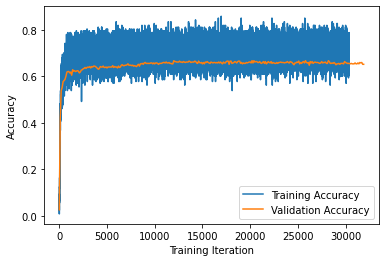

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()